In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import defaultdict
import os
import glob
import random

## Configuration

In [2]:
# Number of force cells in the robotic leg
N_CELLS = 8

# Directory where the derived data is stored
DERIVED_DATA_DIR = '../../../../data'

# Percentage of the date for the test set
TEST_SIZE = 0.3

TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', TORCH_DEVICE)

Using device: cpu


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


## Load data

In [3]:
exp_path = glob.glob(DERIVED_DATA_DIR + '/*/*')[0]
exp_path

'../../../../data/10032021/1'

In [4]:
H3_LEG = 'L' # L|R

# features = [H3_LEG + a + m for a in ['Hip', 'Knee', 'Ankle'] for m in ['Pos', 'Vel', 'Acc', 'Torque']] + ['LegKnee{}Filtered'.format(m) for m in ['Position', 'Velocity', 'Torque']]
features = [H3_LEG + a + m for a in ['Hip', 'Knee'] for m in ['Pos', 'Torque']]
targets = ['F3z'] #['F' + str(i + 1) + ax for i in range(N_CELLS) for ax in ['x', 'y', 'z']]

print('Number of features: {}'.format(len(features)))
print('Selected features: {}'.format(features))
print('\n')
print('Number of targets: {}'.format(len(targets)))
print('Selected targets: {}'.format(targets))

Number of features: 4
Selected features: ['LHipPos', 'LHipTorque', 'LKneePos', 'LKneeTorque']


Number of targets: 1
Selected targets: ['F3z']


In [5]:
# Load targets
targets_df = pd.read_csv(exp_path + '/force_cells_processed.csv')

# Load features
exo_df = pd.read_csv(exp_path + '/H3_processed.csv')
# leg_df = pd.read_csv(exp_path + '/leg_processed.csv')
# features_df = pd.concat([exo_df, leg_df], axis=1)
features_df = exo_df

idx_aux = targets_df.duplicated(keep='first')
targets_df = targets_df.loc[~idx_aux]
features_df = features_df.loc[~idx_aux]
print('Droping {} duplicated data points'.format(len(idx_aux[idx_aux == False])))

# Drop first row to remove noise in the start of the data recording
targets_df = targets_df.iloc[1:]
features_df = features_df.iloc[1:]
# Drop null values
idx = features_df.notna().all(axis=1)
features_df = features_df.loc[idx]
targets_df = targets_df.loc[idx]
print('Droping {} data points by null features'.format(len(idx[idx == False])))

assert(len(features_df) == len(targets_df))
# Store the final array
targets_arr = targets_df[targets].values
features_arr = features_df[features].values

print('X: {}, Y: {} \n'.format(features_arr.shape, targets_arr.shape))

Droping 2917 duplicated data points
Droping 0 data points by null features
X: (2916, 4), Y: (2916, 1) 



In [6]:
idx_split = int(targets_arr.shape[0] * (1 - TEST_SIZE))

X_train = features_arr[:idx_split, :]
X_test = features_arr[idx_split:, :]

Y_train = targets_arr[:idx_split, :]
Y_test = targets_arr[idx_split:, :]

print('Train -> X: {}, Y: {}'.format(X_train.shape, Y_train.shape))
print('Test -> X: {}, Y: {}'.format(X_test.shape, Y_test.shape))

Train -> X: (2041, 4), Y: (2041, 1)
Test -> X: (875, 4), Y: (875, 1)


In [7]:
s = MinMaxScaler().fit(X_train)

X_train_norm = s.transform(X_train)
X_test_norm = s.transform(X_test)

print('Train -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_train_norm, axis=0), np.max(X_train_norm, axis=0), np.mean(X_train_norm, axis=0), np.std(X_train_norm, axis=0)))
print('Test -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_test_norm, axis=0), np.max(X_test_norm, axis=0), np.mean(X_test_norm, axis=0), np.std(X_test_norm, axis=0)))

Train -> 
 min: [0. 0. 0. 0.], 
 max: [1. 1. 1. 1.], 
 mean: [0.43120976 0.40218019 0.22651369 0.45789431], 
 std: [0.33894781 0.24077308 0.29944424 0.2707551 ]

Test -> 
 min: [1.14634060e-03 1.39308522e-02 4.82467537e-06 3.17798687e-03], 
 max: [0.9996938  1.01692898 0.99964499 1.00058556], 
 mean: [0.44434938 0.40818974 0.23605292 0.4485459 ], 
 std: [0.34514506 0.24614727 0.30620312 0.27769232]



In [8]:
SEQUENCE_LEN = 5
    
splits = [i for i in range(0, X_train_norm.shape[0], SEQUENCE_LEN)]

X_train_norm_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(features)])
Y_train_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(targets)])
    
for idx, i in enumerate(splits[:-1]):
    X_train_norm_tensor[idx, :, :] = X_train_norm[splits[idx]:splits[idx + 1], :]
    Y_train_tensor[idx, :, :] = Y_train[splits[idx + 1] - 1, :]
        
print(X_train_norm_tensor.shape)
print(Y_train_tensor.shape)

(409, 5, 4)
(409, 5, 1)


In [9]:
splits = [i for i in range(0, X_test_norm.shape[0], SEQUENCE_LEN)]

X_test_norm_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(features)])
Y_test_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(targets)])
    
for idx, i in enumerate(splits[:-1]):
    X_test_norm_tensor[idx, :, :] = X_test_norm[splits[idx]:splits[idx + 1], :]
    Y_test_tensor[idx, :, :] = Y_test[splits[idx + 1] - 1, :]
        
print(X_test_norm_tensor.shape)
print(Y_test_tensor.shape)

(175, 5, 4)
(175, 5, 1)


## Recurrent Neural Network (LSTM)

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, sigma, output_size, sequence_length, num_iter, n_layers, device, lr=0.001, batch_size=16):
        
        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.sigma = sigma
        self.output_size = output_size
        self.sequence_length = sequence_length
        self.num_layers = n_layers
        
        # define an LSTM with specified parameters
        # batch_first=True means that the first dimension of the input will be the batch_size
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=0.3)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE

        
        self.lr = lr #Learning Rate
        self.batch_size = batch_size
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.num_iter = num_iter
        self.criterion = nn.MSELoss() #YOUR CODE HERE     
        
        self.device = device
        self.to(self.device)
        
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        
    def forward(self, x, h0=None):
        
        '''
        About the shape of the different tensors ...:
        
        - Input signal x has shape (batch_size, seq_length, input_size)
        - The initialization of the RNN hidden state h0 has shape (n_layers, batch_size, hidden_dim).
          If None value is used, internally it is initialized to zeros.
        - The RNN output (batch_size, seq_length, hidden_size). This output is the RNN state along time  

        '''
        batch_size = x.size(0) # Number of signals N
        seq_length = x.size(1) # T
        
        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state (we will use it for forecasting)
        #print(x.shape)
        r_out, hidden = self.rnn(x, h0)
        #print(r_out.shape, hidden.shape)
        
        # shape r_out to be (seq_length, hidden_dim) #UNDERSTANDING THIS POINT IS IMPORTANT!!        
        r_out = r_out.reshape(-1, self.hidden_dim) 
        #print(r_out.shape)
        
        output = self.fc1(r_out)
        #print(output.shape)
        
        noise = torch.randn_like(output) * self.sigma
        
        output += noise
        
        # reshape back to temporal structure
        output = output.reshape([-1, self.sequence_length, 1])

        return output, hidden
           
    def trainloop(self, x, y, x_val=None, y_val=None):
        
        # SGD Loop
        for e in range(int(self.num_iter)):
        
            running_loss = 0.
            
            idx = list(range(x.shape[0]))
            random.shuffle(idx)
            
            batchs = [idx[i:i + self.batch_size] for i in range(0, x.shape[0], self.batch_size)]
            for b in batchs:

                features = x[b, :, :]
                target = y[b, :, :]

                # print(features.shape, target.shape)
                self.optim.zero_grad() 
                
                features = torch.Tensor(features).to(self.device) #YOUR CODE HERE  
                target = torch.Tensor(target).to(self.device) #YOUR CODE HERE  
                
                out,hid = self.forward(features)

                # print(out.shape, hid.shape, target.shape)
                # print(out[:, -1, 0].size(), target[:, 0].size())
                loss = self.criterion(out[:, -1, 0], target[:, -1, 0]) #YOUR CODE HERE
                running_loss += loss.item()

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
                
            self.loss_during_training.append(running_loss / len(batchs))
            
            if x_val is not None and y_val is not None:
                with torch.no_grad():
                    # Set the model in evaluation mode 
                    self.eval()

                    running_loss_val = 0.
                    idx = list(range(x_val.shape[0]))

                    batchs = [idx[i:i + self.batch_size] for i in range(0, x_val.shape[0], self.batch_size)]
                    for b in batchs:
                        features = x_val[b, :, :]
                        target = y_val[b, :, :]

                        features = torch.Tensor(features).to(self.device) #YOUR CODE HERE  
                        target = torch.Tensor(target).to(self.device) #YOUR CODE HERE  

                        out,hid = self.forward(features)

                        # print(out.shape, hid.shape, target.shape)
                        # print(out[:, -1, 0].size(), target[:, -1, 0].size())
                        loss = self.criterion(out[:, -1, 0], target[:, -1, 0]) #YOUR CODE HERE
                        running_loss_val += loss.item()

                    self.valid_loss_during_training.append(running_loss_val / len(splits))

                # Return the model to training mode
                self.train()

                if(e % 1 == 0):
                    print("%d epochs -> Train loss: %f - Val loss: %f"%(e, self.loss_during_training[-1], self.valid_loss_during_training[-1]))
                    
            else:
                if(e % 1 == 0):
                    print("%d epochs -> Train loss: %f"%(e, self.loss_during_training[-1]))

                

In [11]:
model = LSTM(input_size=4, hidden_dim=32, sigma=1, output_size=1, sequence_length=SEQUENCE_LEN, 
            num_iter=200, n_layers=1, device=TORCH_DEVICE)

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [12]:
model.trainloop(X_train_norm_tensor, Y_train_tensor, X_test_norm_tensor, Y_test_tensor)

0 epochs -> Train loss: 2344.302561 - Val loss: 147.143571
1 epochs -> Train loss: 2296.177598 - Val loss: 141.715114
2 epochs -> Train loss: 2136.361812 - Val loss: 129.159902
3 epochs -> Train loss: 1965.090694 - Val loss: 119.718909
4 epochs -> Train loss: 1845.505639 - Val loss: 113.022405
5 epochs -> Train loss: 1762.329698 - Val loss: 108.233927
6 epochs -> Train loss: 1674.179570 - Val loss: 103.059088
7 epochs -> Train loss: 1602.217806 - Val loss: 99.061381
8 epochs -> Train loss: 1514.523804 - Val loss: 94.551260
9 epochs -> Train loss: 1467.342332 - Val loss: 90.138845
10 epochs -> Train loss: 1400.656201 - Val loss: 86.935957
11 epochs -> Train loss: 1332.628599 - Val loss: 83.549005
12 epochs -> Train loss: 1275.220900 - Val loss: 79.212013
13 epochs -> Train loss: 1212.183225 - Val loss: 75.551998
14 epochs -> Train loss: 1154.875315 - Val loss: 72.006054
15 epochs -> Train loss: 1106.619608 - Val loss: 68.133936
16 epochs -> Train loss: 1060.695566 - Val loss: 65.052912


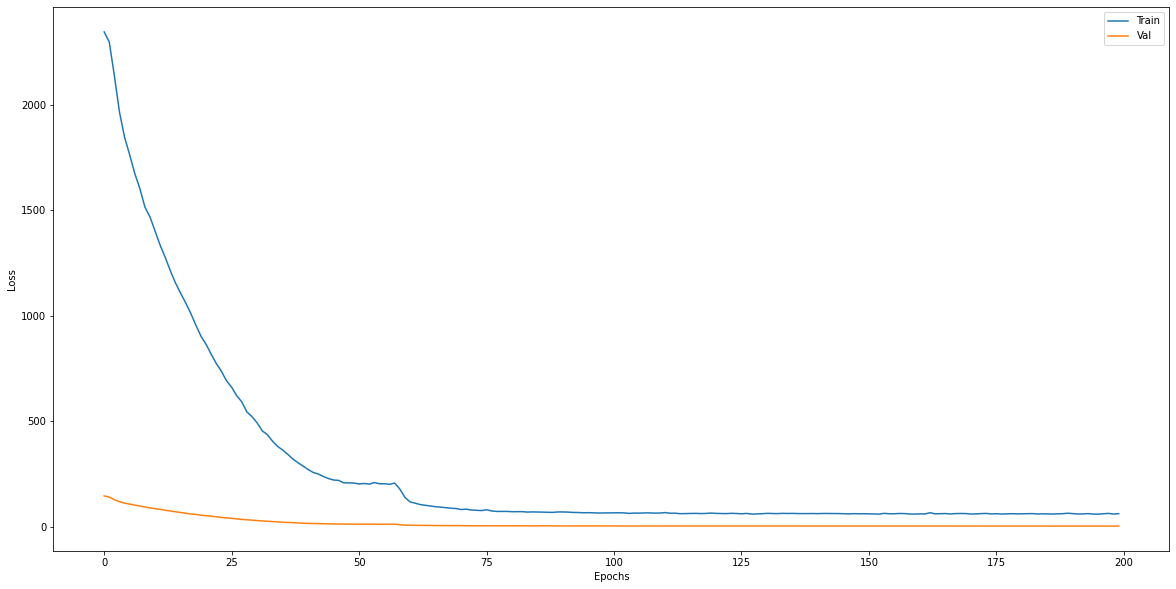

In [13]:
plt.figure(figsize=(20,10))

plt.plot(model.loss_during_training, label='Train')
plt.plot(model.valid_loss_during_training, label='Val')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

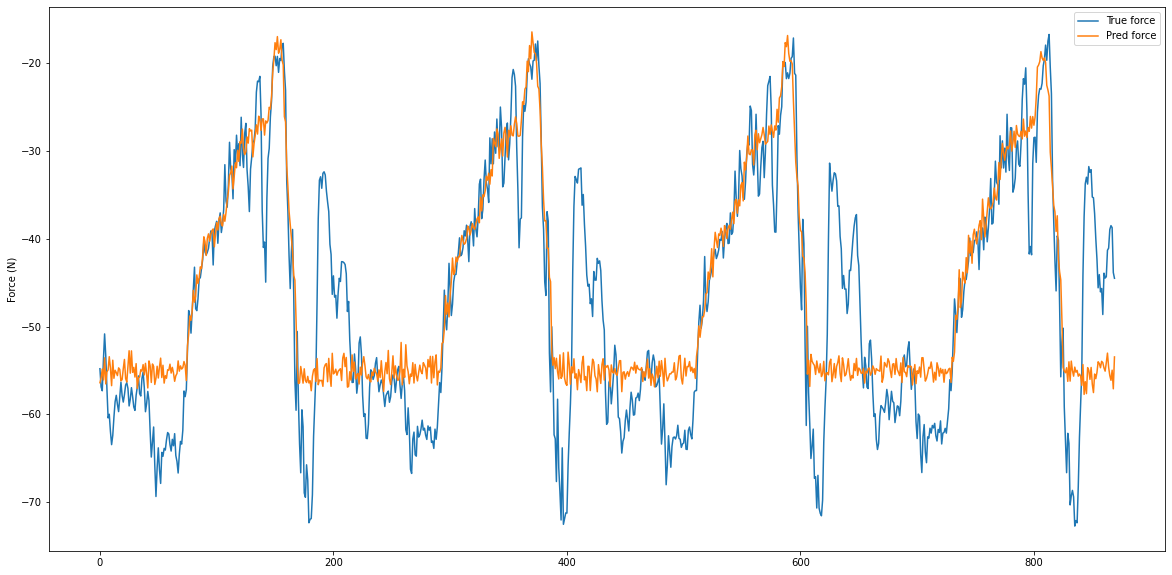

In [14]:
true = []
pred = []

for i in range(SEQUENCE_LEN, X_test_norm.shape[0]):
    features_ = torch.Tensor(X_test_norm[np.newaxis, i-SEQUENCE_LEN:i, :]).to(TORCH_DEVICE)
    target_ = torch.Tensor(Y_test[np.newaxis, i, :]).to(TORCH_DEVICE)
    
    out, hid = model.forward(features_)

    true.append(target_[:, 0].cpu().detach().numpy())
    pred.append(out[:, -1, 0].cpu().detach().numpy())
    
plt.figure(figsize=(20,10))

plt.plot(true, label='True force')
plt.plot(pred, label='Pred force')

plt.legend()
plt.ylabel('Force (N)')
plt.show()

In [15]:
results = {
    'MAE': mean_absolute_error(true, pred),
    'MSE': mean_squared_error(true, pred),
    'R2': r2_score(true, pred)
}

results

{'MAE': 5.6970377, 'MSE': 61.204487, 'R2': 0.6904594384761733}

## Try the model over all the experiments

In [16]:
experiments_dirs_path = glob.glob(DERIVED_DATA_DIR + '/*/*')
experiments_dirs_path

['../../../../data/10032021/1',
 '../../../../data/16022021/1',
 '../../../../data/16022021/2',
 '../../../../data/16022021/3',
 '../../../../data/16022021/4',
 '../../../../data/16022021/5',
 '../../../../data/16022021/6',
 '../../../../data/17022021/2',
 '../../../../data/17022021/3',
 '../../../../data/17022021/4',
 '../../../../data/19022021/1',
 '../../../../data/19022021/10',
 '../../../../data/19022021/11',
 '../../../../data/19022021/12',
 '../../../../data/19022021/13',
 '../../../../data/19022021/14',
 '../../../../data/19022021/15',
 '../../../../data/19022021/16',
 '../../../../data/19022021/17',
 '../../../../data/19022021/18',
 '../../../../data/19022021/2',
 '../../../../data/19022021/3',
 '../../../../data/19022021/4',
 '../../../../data/19022021/5',
 '../../../../data/19022021/6',
 '../../../../data/19022021/7',
 '../../../../data/19022021/8',
 '../../../../data/19022021/9',
 '../../../../data/22022021/1',
 '../../../../data/22022021/10',
 '../../../../data/22022021/11

In [17]:
SEQUENCE_LEN = 5

H3_LEG = 'L' # L|R

# features = [H3_LEG + a + m for a in ['Hip', 'Knee', 'Ankle'] for m in ['Pos', 'Vel', 'Acc', 'Torque']] + ['LegKnee{}Filtered'.format(m) for m in ['Position', 'Velocity', 'Torque']]
features = [H3_LEG + a + m for a in ['Hip', 'Knee'] for m in ['Pos', 'Torque']]
targets = ['F' + str(i + 1) + ax for i in range(N_CELLS) for ax in ['x', 'y', 'z']]

print('Number of features: {}'.format(len(features)))
print('Selected features: {}'.format(features))
print('\n')
print('Number of targets: {}'.format(len(targets)))
print('Selected targets: {}'.format(targets))

Number of features: 4
Selected features: ['LHipPos', 'LHipTorque', 'LKneePos', 'LKneeTorque']


Number of targets: 24
Selected targets: ['F1x', 'F1y', 'F1z', 'F2x', 'F2y', 'F2z', 'F3x', 'F3y', 'F3z', 'F4x', 'F4y', 'F4z', 'F5x', 'F5y', 'F5z', 'F6x', 'F6y', 'F6z', 'F7x', 'F7y', 'F7z', 'F8x', 'F8y', 'F8z']


In [18]:
results_full = defaultdict(list)

for exp_idx, exp_path in enumerate(experiments_dirs_path):
    print('<<<<<<<<<<<<<<<<<<<< {} >>>>>>>>>>>>>>>>>>>>'.format(exp_idx))
    print(exp_path)
    
    # Load targets
    targets_df = pd.read_csv(exp_path + '/force_cells_processed.csv')

    # Load features
    exo_df = pd.read_csv(exp_path + '/H3_processed.csv')
    # leg_df = pd.read_csv(exp_path + '/leg_processed.csv')
    # features_df = pd.concat([exo_df, leg_df], axis=1)
    features_df = exo_df

    idx_aux = targets_df.duplicated(keep='first')
    targets_df = targets_df.loc[~idx_aux]
    features_df = features_df.loc[~idx_aux]
    print('Droping {} duplicated data points'.format(len(idx_aux[idx_aux == False])))

    # Drop first row to remove noise in the start of the data recording
    targets_df = targets_df.iloc[1:]
    features_df = features_df.iloc[1:]
    # Drop null values
    idx = features_df.notna().all(axis=1)
    features_df = features_df.loc[idx]
    targets_df = targets_df.loc[idx]
    print('Droping {} data points by null features'.format(len(idx[idx == False])))

    assert(len(features_df) == len(targets_df))
    # Store the final array
    targets_arr = targets_df[targets].values
    features_arr = features_df[features].values

    print('X: {}, Y: {} \n'.format(features_arr.shape, targets_arr.shape))

    idx_split = int(targets_arr.shape[0] * (1 - TEST_SIZE))

    X_train = features_arr[:idx_split, :]
    X_test = features_arr[idx_split:, :]

    Y_train = targets_arr[:idx_split, :]
    Y_test = targets_arr[idx_split:, :]

    print('Train -> X: {}, Y: {}'.format(X_train.shape, Y_train.shape))
    print('Test -> X: {}, Y: {}'.format(X_test.shape, Y_test.shape))
    
    s = MinMaxScaler().fit(X_train)

    X_train_norm = s.transform(X_train)
    X_test_norm = s.transform(X_test)

    print('Train -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_train_norm, axis=0), np.max(X_train_norm, axis=0), np.mean(X_train_norm, axis=0), np.std(X_train_norm, axis=0)))
    print('Test -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_test_norm, axis=0), np.max(X_test_norm, axis=0), np.mean(X_test_norm, axis=0), np.std(X_test_norm, axis=0)))
    
    splits = [i for i in range(0, X_train_norm.shape[0], SEQUENCE_LEN)]

    X_train_norm_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(features)])
    Y_train_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(targets)])

    for idx, i in enumerate(splits[:-1]):
        X_train_norm_tensor[idx, :, :] = X_train_norm[splits[idx]:splits[idx + 1], :]
        Y_train_tensor[idx, :, :] = Y_train[splits[idx + 1] - 1, :]

    print(X_train_norm_tensor.shape)
    print(Y_train_tensor.shape)

    results = {'MAE': [], 'MSE': [], 'R2': []}
    for t in range(len(targets)):
        # Setup the model
        model = LSTM(input_size=4, hidden_dim=32, sigma=1, output_size=1, sequence_length=SEQUENCE_LEN, 
                num_iter=20, n_layers=1, device=TORCH_DEVICE)

        t_start = time.time()
        model.trainloop(X_train_norm_tensor, Y_train_tensor[:, :, t][:, :, np.newaxis])
        tr_time = time.time() - t_start
        print('Training time: {:.4f}'.format(tr_time))

        true = []
        pred = []

        for i in range(SEQUENCE_LEN, X_test_norm.shape[0]):
            features_ = torch.Tensor(X_test_norm[np.newaxis, i-SEQUENCE_LEN:i, :]).to(TORCH_DEVICE)
            target_ = torch.Tensor(Y_test[np.newaxis, i, t]).to(TORCH_DEVICE)

            out, hid = model.forward(features_)

            true.append(target_.cpu().detach().numpy())
            pred.append(out[:, -1, 0].cpu().detach().numpy())

        results['MAE'].append(mean_absolute_error(true, pred))
        results['MSE'].append(mean_squared_error(true, pred))
        results['R2'].append(r2_score(true, pred))

    results_summary = {}
    results_summary['Training time'] = tr_time
    # Display the score mean and standard deviation of each axis
    for f, force in enumerate(['Fx', 'Fy', 'Fz']):
        for loss in ['MAE', 'MSE', 'R2']:
            scores = [results[loss][i + f] for i in range(0, N_CELLS * 3, 3)]
            s_mean = np.mean(scores)
            s_std = np.std(scores)

            print(' '.join([force, loss]) + ': {:.4f} ± {:.4f}'.format(s_mean, s_std))
            results_summary[' '.join([force, loss])] = '{:.4f} ± {:.4f}'.format(s_mean, s_std)

            results_full[' '.join([force, loss])].append(s_mean)

    print('\n')

<<<<<<<<<<<<<<<<<<<< 0 >>>>>>>>>>>>>>>>>>>>
../../../../data/10032021/1
Droping 2917 duplicated data points
Droping 0 data points by null features
X: (2916, 4), Y: (2916, 24) 

Train -> X: (2041, 4), Y: (2041, 24)
Test -> X: (875, 4), Y: (875, 24)
Train -> 
 min: [0. 0. 0. 0.], 
 max: [1. 1. 1. 1.], 
 mean: [0.43120976 0.40218019 0.22651369 0.45789431], 
 std: [0.33894781 0.24077308 0.29944424 0.2707551 ]

Test -> 
 min: [1.14634060e-03 1.39308522e-02 4.82467537e-06 3.17798687e-03], 
 max: [0.9996938  1.01692898 0.99964499 1.00058556], 
 mean: [0.44434938 0.40818974 0.23605292 0.4485459 ], 
 std: [0.34514506 0.24614727 0.30620312 0.27769232]

(409, 5, 4)
(409, 5, 24)
0 epochs -> Train loss: 354.358026
1 epochs -> Train loss: 335.618638


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


2 epochs -> Train loss: 277.231782
3 epochs -> Train loss: 230.909433
4 epochs -> Train loss: 209.794591
5 epochs -> Train loss: 193.891830
6 epochs -> Train loss: 177.186110
7 epochs -> Train loss: 166.786664
8 epochs -> Train loss: 161.130661
9 epochs -> Train loss: 148.653732
10 epochs -> Train loss: 143.531572
11 epochs -> Train loss: 141.189749
12 epochs -> Train loss: 148.426698
13 epochs -> Train loss: 134.941107
14 epochs -> Train loss: 128.292771
15 epochs -> Train loss: 117.833512
16 epochs -> Train loss: 111.670387
17 epochs -> Train loss: 105.718298
18 epochs -> Train loss: 100.708812
19 epochs -> Train loss: 93.541823
Training time: 1.0593


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 12.225165
1 epochs -> Train loss: 11.195994
2 epochs -> Train loss: 9.141907
3 epochs -> Train loss: 7.626311
4 epochs -> Train loss: 6.525592
5 epochs -> Train loss: 5.284742
6 epochs -> Train loss: 4.459738
7 epochs -> Train loss: 4.251596
8 epochs -> Train loss: 4.090648
9 epochs -> Train loss: 3.789154
10 epochs -> Train loss: 3.863517
11 epochs -> Train loss: 3.626687
12 epochs -> Train loss: 3.972938
13 epochs -> Train loss: 3.482299
14 epochs -> Train loss: 3.515334
15 epochs -> Train loss: 3.701665
16 epochs -> Train loss: 3.521699
17 epochs -> Train loss: 3.631227
18 epochs -> Train loss: 3.552301
19 epochs -> Train loss: 3.399412
Training time: 1.0545


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 374.805944
1 epochs -> Train loss: 344.177057
2 epochs -> Train loss: 308.029788
3 epochs -> Train loss: 263.746551
4 epochs -> Train loss: 238.856452
5 epochs -> Train loss: 209.231234
6 epochs -> Train loss: 196.107248
7 epochs -> Train loss: 185.839403
8 epochs -> Train loss: 175.518249
9 epochs -> Train loss: 169.250655
10 epochs -> Train loss: 157.580877
11 epochs -> Train loss: 158.775360
12 epochs -> Train loss: 152.581471
13 epochs -> Train loss: 142.395473
14 epochs -> Train loss: 129.399051
15 epochs -> Train loss: 125.187529
16 epochs -> Train loss: 116.623009
17 epochs -> Train loss: 109.238138
18 epochs -> Train loss: 103.827857
19 epochs -> Train loss: 101.301457
Training time: 1.0922


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 242.716680
1 epochs -> Train loss: 234.461807
2 epochs -> Train loss: 217.946099
3 epochs -> Train loss: 186.608535
4 epochs -> Train loss: 173.131434
5 epochs -> Train loss: 165.436847
6 epochs -> Train loss: 150.123237
7 epochs -> Train loss: 138.332753
8 epochs -> Train loss: 122.186217
9 epochs -> Train loss: 109.312917
10 epochs -> Train loss: 102.482932
11 epochs -> Train loss: 94.990147
12 epochs -> Train loss: 88.092648
13 epochs -> Train loss: 84.588740
14 epochs -> Train loss: 78.447244
15 epochs -> Train loss: 75.052195
16 epochs -> Train loss: 68.988033
17 epochs -> Train loss: 64.148852
18 epochs -> Train loss: 58.116174
19 epochs -> Train loss: 53.966665
Training time: 1.3213


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 102.870975
1 epochs -> Train loss: 97.215081
2 epochs -> Train loss: 74.231313
3 epochs -> Train loss: 51.412374
4 epochs -> Train loss: 41.889385
5 epochs -> Train loss: 36.027135
6 epochs -> Train loss: 34.393215
7 epochs -> Train loss: 33.621057
8 epochs -> Train loss: 33.089658
9 epochs -> Train loss: 33.177862
10 epochs -> Train loss: 30.851794
11 epochs -> Train loss: 23.765490
12 epochs -> Train loss: 15.913228
13 epochs -> Train loss: 14.091466
14 epochs -> Train loss: 12.466363
15 epochs -> Train loss: 12.693027
16 epochs -> Train loss: 12.739946
17 epochs -> Train loss: 12.960743
18 epochs -> Train loss: 12.086815
19 epochs -> Train loss: 12.407201
Training time: 1.0621


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 390.735772
1 epochs -> Train loss: 361.834718
2 epochs -> Train loss: 307.560515
3 epochs -> Train loss: 245.497648
4 epochs -> Train loss: 209.702654
5 epochs -> Train loss: 179.714128
6 epochs -> Train loss: 159.053489
7 epochs -> Train loss: 140.399020
8 epochs -> Train loss: 124.755441
9 epochs -> Train loss: 111.761652
10 epochs -> Train loss: 102.902667
11 epochs -> Train loss: 89.746965
12 epochs -> Train loss: 81.662519
13 epochs -> Train loss: 77.395392
14 epochs -> Train loss: 72.068718
15 epochs -> Train loss: 67.692305
16 epochs -> Train loss: 66.759456
17 epochs -> Train loss: 66.453846
18 epochs -> Train loss: 62.277419
19 epochs -> Train loss: 53.805913
Training time: 1.1146


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2201.514569
1 epochs -> Train loss: 2173.888550
2 epochs -> Train loss: 2027.135766
3 epochs -> Train loss: 1851.026306
4 epochs -> Train loss: 1703.429734
5 epochs -> Train loss: 1644.168448
6 epochs -> Train loss: 1556.339759
7 epochs -> Train loss: 1484.564810
8 epochs -> Train loss: 1403.644048
9 epochs -> Train loss: 1353.204984
10 epochs -> Train loss: 1292.060624
11 epochs -> Train loss: 1231.804497
12 epochs -> Train loss: 1167.254160
13 epochs -> Train loss: 1120.178631
14 epochs -> Train loss: 1057.397484
15 epochs -> Train loss: 1004.898496
16 epochs -> Train loss: 959.447735
17 epochs -> Train loss: 913.708150
18 epochs -> Train loss: 854.936237
19 epochs -> Train loss: 816.580620
Training time: 1.2906


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 234.775827
1 epochs -> Train loss: 229.118608
2 epochs -> Train loss: 200.589769
3 epochs -> Train loss: 172.641073
4 epochs -> Train loss: 153.716522
5 epochs -> Train loss: 142.397891
6 epochs -> Train loss: 139.319466
7 epochs -> Train loss: 135.752190
8 epochs -> Train loss: 132.821618
9 epochs -> Train loss: 129.167675
10 epochs -> Train loss: 130.274634
11 epochs -> Train loss: 130.975691
12 epochs -> Train loss: 133.246395
13 epochs -> Train loss: 130.145313
14 epochs -> Train loss: 128.315453
15 epochs -> Train loss: 128.963884
16 epochs -> Train loss: 126.947383
17 epochs -> Train loss: 125.666990
18 epochs -> Train loss: 119.716868
19 epochs -> Train loss: 113.320587
Training time: 1.3424


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2341.256873
1 epochs -> Train loss: 2276.120986
2 epochs -> Train loss: 2105.290255
3 epochs -> Train loss: 1885.131582
4 epochs -> Train loss: 1775.945364
5 epochs -> Train loss: 1675.356492
6 epochs -> Train loss: 1617.502812
7 epochs -> Train loss: 1537.259667
8 epochs -> Train loss: 1455.506902
9 epochs -> Train loss: 1392.075320
10 epochs -> Train loss: 1334.259078
11 epochs -> Train loss: 1278.113316
12 epochs -> Train loss: 1201.342701
13 epochs -> Train loss: 1161.723961
14 epochs -> Train loss: 1095.124143
15 epochs -> Train loss: 1048.223311
16 epochs -> Train loss: 1003.675819
17 epochs -> Train loss: 946.255066
18 epochs -> Train loss: 894.741934
19 epochs -> Train loss: 857.356945
Training time: 1.1770


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 169.754014
1 epochs -> Train loss: 166.090547
2 epochs -> Train loss: 165.446406
3 epochs -> Train loss: 151.275336
4 epochs -> Train loss: 129.714119
5 epochs -> Train loss: 116.967182
6 epochs -> Train loss: 105.011665
7 epochs -> Train loss: 100.631212
8 epochs -> Train loss: 92.514718
9 epochs -> Train loss: 87.749173
10 epochs -> Train loss: 83.392998
11 epochs -> Train loss: 80.537633
12 epochs -> Train loss: 76.178834
13 epochs -> Train loss: 69.809877
14 epochs -> Train loss: 72.198220
15 epochs -> Train loss: 64.788715
16 epochs -> Train loss: 64.583779
17 epochs -> Train loss: 59.275535
18 epochs -> Train loss: 59.317045
19 epochs -> Train loss: 56.119514
Training time: 1.1312


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 200.342081
1 epochs -> Train loss: 198.727916
2 epochs -> Train loss: 181.659126
3 epochs -> Train loss: 168.021854
4 epochs -> Train loss: 158.940306
5 epochs -> Train loss: 149.714551
6 epochs -> Train loss: 144.654330
7 epochs -> Train loss: 136.370640
8 epochs -> Train loss: 133.039732
9 epochs -> Train loss: 130.073823
10 epochs -> Train loss: 128.235414
11 epochs -> Train loss: 124.769681
12 epochs -> Train loss: 123.332165
13 epochs -> Train loss: 117.519430
14 epochs -> Train loss: 114.300030
15 epochs -> Train loss: 116.729665
16 epochs -> Train loss: 110.987959
17 epochs -> Train loss: 107.516379
18 epochs -> Train loss: 103.787621
19 epochs -> Train loss: 98.296177
Training time: 1.3360


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 855.406135
1 epochs -> Train loss: 844.260137
2 epochs -> Train loss: 774.496966
3 epochs -> Train loss: 721.981258
4 epochs -> Train loss: 701.158985
5 epochs -> Train loss: 681.741887
6 epochs -> Train loss: 674.999906
7 epochs -> Train loss: 655.136449
8 epochs -> Train loss: 625.721036
9 epochs -> Train loss: 595.776805
10 epochs -> Train loss: 570.482428
11 epochs -> Train loss: 553.966469
12 epochs -> Train loss: 540.886591
13 epochs -> Train loss: 534.808675
14 epochs -> Train loss: 507.302408
15 epochs -> Train loss: 493.617433
16 epochs -> Train loss: 471.822686
17 epochs -> Train loss: 461.633114
18 epochs -> Train loss: 446.995031
19 epochs -> Train loss: 443.869634
Training time: 1.2759


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 274.393385
1 epochs -> Train loss: 259.565267
2 epochs -> Train loss: 233.187437
3 epochs -> Train loss: 198.232662
4 epochs -> Train loss: 184.967597
5 epochs -> Train loss: 170.286949
6 epochs -> Train loss: 160.589449
7 epochs -> Train loss: 141.581397
8 epochs -> Train loss: 121.956415
9 epochs -> Train loss: 110.130613
10 epochs -> Train loss: 103.762170
11 epochs -> Train loss: 99.723682
12 epochs -> Train loss: 89.956037
13 epochs -> Train loss: 84.364193
14 epochs -> Train loss: 82.019222
15 epochs -> Train loss: 75.485336
16 epochs -> Train loss: 69.763167
17 epochs -> Train loss: 65.173429
18 epochs -> Train loss: 64.339171
19 epochs -> Train loss: 58.704453
Training time: 1.3995


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 421.792735
1 epochs -> Train loss: 417.412143
2 epochs -> Train loss: 366.160537
3 epochs -> Train loss: 308.102706
4 epochs -> Train loss: 272.825784
5 epochs -> Train loss: 248.469249
6 epochs -> Train loss: 231.482250
7 epochs -> Train loss: 216.017829
8 epochs -> Train loss: 204.568330
9 epochs -> Train loss: 194.073493
10 epochs -> Train loss: 190.597569
11 epochs -> Train loss: 184.026991
12 epochs -> Train loss: 182.871882
13 epochs -> Train loss: 180.760332
14 epochs -> Train loss: 178.148234
15 epochs -> Train loss: 176.970701
16 epochs -> Train loss: 175.851058
17 epochs -> Train loss: 176.793127
18 epochs -> Train loss: 176.807913
19 epochs -> Train loss: 175.073050
Training time: 1.2657


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4357.890963
1 epochs -> Train loss: 4259.811552
2 epochs -> Train loss: 4021.844952
3 epochs -> Train loss: 3796.320331
4 epochs -> Train loss: 3614.722365
5 epochs -> Train loss: 3480.591994
6 epochs -> Train loss: 3390.910936
7 epochs -> Train loss: 3265.008216
8 epochs -> Train loss: 3163.603638
9 epochs -> Train loss: 3076.485877
10 epochs -> Train loss: 2962.636324
11 epochs -> Train loss: 2881.345853
12 epochs -> Train loss: 2780.317561
13 epochs -> Train loss: 2707.201444
14 epochs -> Train loss: 2619.619882
15 epochs -> Train loss: 2501.638367
16 epochs -> Train loss: 2434.200665
17 epochs -> Train loss: 2349.435866
18 epochs -> Train loss: 2272.417499
19 epochs -> Train loss: 2187.336956
Training time: 1.4058


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 598.582507
1 epochs -> Train loss: 569.522119
2 epochs -> Train loss: 492.285588
3 epochs -> Train loss: 438.180705
4 epochs -> Train loss: 400.877702
5 epochs -> Train loss: 361.563254
6 epochs -> Train loss: 332.801626
7 epochs -> Train loss: 313.670038
8 epochs -> Train loss: 297.383140
9 epochs -> Train loss: 280.901562
10 epochs -> Train loss: 265.797813
11 epochs -> Train loss: 245.331165
12 epochs -> Train loss: 233.019504
13 epochs -> Train loss: 224.755031
14 epochs -> Train loss: 220.117134
15 epochs -> Train loss: 209.575013
16 epochs -> Train loss: 209.592615
17 epochs -> Train loss: 190.082460
18 epochs -> Train loss: 172.875303
19 epochs -> Train loss: 157.746095
Training time: 1.1997


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 53.773136
1 epochs -> Train loss: 46.882411
2 epochs -> Train loss: 30.942562
3 epochs -> Train loss: 25.431784
4 epochs -> Train loss: 25.457503
5 epochs -> Train loss: 23.547681
6 epochs -> Train loss: 22.010405
7 epochs -> Train loss: 19.223641
8 epochs -> Train loss: 15.931799
9 epochs -> Train loss: 14.129012
10 epochs -> Train loss: 13.382177
11 epochs -> Train loss: 13.115764
12 epochs -> Train loss: 13.413388
13 epochs -> Train loss: 12.816821
14 epochs -> Train loss: 12.044236
15 epochs -> Train loss: 12.541228
16 epochs -> Train loss: 12.285397
17 epochs -> Train loss: 12.210552
18 epochs -> Train loss: 11.775640
19 epochs -> Train loss: 11.085721
Training time: 1.1156


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1802.503498
1 epochs -> Train loss: 1738.420959
2 epochs -> Train loss: 1605.093961
3 epochs -> Train loss: 1481.042671
4 epochs -> Train loss: 1387.947564
5 epochs -> Train loss: 1311.061052
6 epochs -> Train loss: 1238.480394
7 epochs -> Train loss: 1182.130338
8 epochs -> Train loss: 1135.799436
9 epochs -> Train loss: 1081.052444
10 epochs -> Train loss: 1020.356452
11 epochs -> Train loss: 986.513216
12 epochs -> Train loss: 914.027020
13 epochs -> Train loss: 878.058562
14 epochs -> Train loss: 845.878513
15 epochs -> Train loss: 789.761986
16 epochs -> Train loss: 760.370149
17 epochs -> Train loss: 716.800328
18 epochs -> Train loss: 664.455775
19 epochs -> Train loss: 632.448205
Training time: 1.0442


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 129.363411
1 epochs -> Train loss: 125.850042
2 epochs -> Train loss: 113.173479
3 epochs -> Train loss: 99.961880
4 epochs -> Train loss: 80.570796
5 epochs -> Train loss: 66.937197
6 epochs -> Train loss: 57.754457
7 epochs -> Train loss: 53.494754
8 epochs -> Train loss: 50.191364
9 epochs -> Train loss: 46.331505
10 epochs -> Train loss: 41.083181
11 epochs -> Train loss: 37.617077
12 epochs -> Train loss: 32.412613
13 epochs -> Train loss: 28.833752
14 epochs -> Train loss: 26.173587
15 epochs -> Train loss: 25.062818
16 epochs -> Train loss: 24.279873
17 epochs -> Train loss: 20.735067
18 epochs -> Train loss: 19.606770
19 epochs -> Train loss: 18.270022
Training time: 1.1867


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 148.487660
1 epochs -> Train loss: 138.525506
2 epochs -> Train loss: 98.522492
3 epochs -> Train loss: 61.946955
4 epochs -> Train loss: 43.410391
5 epochs -> Train loss: 31.957150
6 epochs -> Train loss: 23.331728
7 epochs -> Train loss: 17.247265
8 epochs -> Train loss: 13.711528
9 epochs -> Train loss: 12.168187
10 epochs -> Train loss: 10.879495
11 epochs -> Train loss: 10.851270
12 epochs -> Train loss: 10.125926
13 epochs -> Train loss: 10.980578
14 epochs -> Train loss: 10.245257
15 epochs -> Train loss: 10.196021
16 epochs -> Train loss: 9.713046
17 epochs -> Train loss: 9.934442
18 epochs -> Train loss: 9.486677
19 epochs -> Train loss: 9.231530
Training time: 1.2607


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 434.233265
1 epochs -> Train loss: 428.292839
2 epochs -> Train loss: 409.326336
3 epochs -> Train loss: 389.459949
4 epochs -> Train loss: 352.860602
5 epochs -> Train loss: 315.135719
6 epochs -> Train loss: 296.583083
7 epochs -> Train loss: 276.070600
8 epochs -> Train loss: 252.968838
9 epochs -> Train loss: 239.788469
10 epochs -> Train loss: 227.472137
11 epochs -> Train loss: 212.988228
12 epochs -> Train loss: 191.458955
13 epochs -> Train loss: 176.483457
14 epochs -> Train loss: 164.405127
15 epochs -> Train loss: 160.589464
16 epochs -> Train loss: 152.570887
17 epochs -> Train loss: 141.958273
18 epochs -> Train loss: 132.522883
19 epochs -> Train loss: 129.034014
Training time: 1.1406


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 752.093642
1 epochs -> Train loss: 733.617136
2 epochs -> Train loss: 672.765778
3 epochs -> Train loss: 583.656433
4 epochs -> Train loss: 538.652771
5 epochs -> Train loss: 504.866793
6 epochs -> Train loss: 471.887484
7 epochs -> Train loss: 450.713103
8 epochs -> Train loss: 423.227051
9 epochs -> Train loss: 411.769564
10 epochs -> Train loss: 390.138754
11 epochs -> Train loss: 374.780480
12 epochs -> Train loss: 359.576350
13 epochs -> Train loss: 352.059921
14 epochs -> Train loss: 339.011718
15 epochs -> Train loss: 333.341847
16 epochs -> Train loss: 329.951767
17 epochs -> Train loss: 320.025566
18 epochs -> Train loss: 316.570325
19 epochs -> Train loss: 300.178675
Training time: 1.2498


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 152.573200
1 epochs -> Train loss: 151.962078
2 epochs -> Train loss: 145.838249
3 epochs -> Train loss: 133.286347
4 epochs -> Train loss: 120.192885
5 epochs -> Train loss: 105.486957
6 epochs -> Train loss: 95.820114
7 epochs -> Train loss: 86.010189
8 epochs -> Train loss: 82.392133
9 epochs -> Train loss: 77.862598
10 epochs -> Train loss: 70.802355
11 epochs -> Train loss: 68.702303
12 epochs -> Train loss: 66.566916
13 epochs -> Train loss: 63.540697
14 epochs -> Train loss: 60.867163
15 epochs -> Train loss: 60.378200
16 epochs -> Train loss: 62.231842
17 epochs -> Train loss: 59.397037
18 epochs -> Train loss: 58.886830
19 epochs -> Train loss: 59.501170
Training time: 1.1432


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1533.955149
1 epochs -> Train loss: 1487.127986
2 epochs -> Train loss: 1349.102009
3 epochs -> Train loss: 1196.539823
4 epochs -> Train loss: 1103.598051
5 epochs -> Train loss: 1021.198597
6 epochs -> Train loss: 965.199374
7 epochs -> Train loss: 902.206569
8 epochs -> Train loss: 846.032574
9 epochs -> Train loss: 788.139695
10 epochs -> Train loss: 736.848804
11 epochs -> Train loss: 694.791006
12 epochs -> Train loss: 649.979823
13 epochs -> Train loss: 602.786781
14 epochs -> Train loss: 567.148688
15 epochs -> Train loss: 523.848825
16 epochs -> Train loss: 488.805585
17 epochs -> Train loss: 445.261792
18 epochs -> Train loss: 414.955249
19 epochs -> Train loss: 376.015988
Training time: 1.1120
Fx MAE: 8.7464 ± 7.4353
Fx MSE: 192.8649 ± 251.9450
Fx R2: -0.2005 ± 1.7579
Fy MAE: 4.9486 ± 3.0763
Fy MSE: 58.0471 ± 56.4710
Fy R2: 0.3790 ± 0.2425
Fz MAE: 17.0705 ± 11.9762
Fz MSE: 569.4306 ± 594.0219
Fz R2: -3.6713 ± 5.5047


<<<<<<<<<<<<<<<<<<<< 1 >>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 26.998311
1 epochs -> Train loss: 14.489701
2 epochs -> Train loss: 11.740589
3 epochs -> Train loss: 9.693376
4 epochs -> Train loss: 8.610769
5 epochs -> Train loss: 8.284992
6 epochs -> Train loss: 8.031947
7 epochs -> Train loss: 7.565712
8 epochs -> Train loss: 7.590269
9 epochs -> Train loss: 7.037556
10 epochs -> Train loss: 7.025929
11 epochs -> Train loss: 7.116311
12 epochs -> Train loss: 6.524918
13 epochs -> Train loss: 6.057206
14 epochs -> Train loss: 6.286091
15 epochs -> Train loss: 6.042121
16 epochs -> Train loss: 5.452600
17 epochs -> Train loss: 5.309943
18 epochs -> Train loss: 5.302790
19 epochs -> Train loss: 4.898568
Training time: 3.4504


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1.766402
1 epochs -> Train loss: 1.715864
2 epochs -> Train loss: 1.751520
3 epochs -> Train loss: 1.727659
4 epochs -> Train loss: 1.723906
5 epochs -> Train loss: 1.570202
6 epochs -> Train loss: 1.719658
7 epochs -> Train loss: 1.789838
8 epochs -> Train loss: 1.652347
9 epochs -> Train loss: 1.642741
10 epochs -> Train loss: 1.737622
11 epochs -> Train loss: 1.671853
12 epochs -> Train loss: 1.796204
13 epochs -> Train loss: 1.700574
14 epochs -> Train loss: 1.597376
15 epochs -> Train loss: 1.650315
16 epochs -> Train loss: 1.648545
17 epochs -> Train loss: 1.555274
18 epochs -> Train loss: 1.519007
19 epochs -> Train loss: 1.652247
Training time: 3.2587


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 14.963172
1 epochs -> Train loss: 4.470774
2 epochs -> Train loss: 3.642466
3 epochs -> Train loss: 3.500547
4 epochs -> Train loss: 3.130122
5 epochs -> Train loss: 3.142425
6 epochs -> Train loss: 2.706445
7 epochs -> Train loss: 2.714209
8 epochs -> Train loss: 2.763392
9 epochs -> Train loss: 2.502634
10 epochs -> Train loss: 2.307789
11 epochs -> Train loss: 2.235854
12 epochs -> Train loss: 2.339136
13 epochs -> Train loss: 2.229301
14 epochs -> Train loss: 2.307175
15 epochs -> Train loss: 2.203520
16 epochs -> Train loss: 2.322405
17 epochs -> Train loss: 2.202248
18 epochs -> Train loss: 2.211956
19 epochs -> Train loss: 2.028904
Training time: 3.3003


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.898245
1 epochs -> Train loss: 5.089484
2 epochs -> Train loss: 3.028366
3 epochs -> Train loss: 2.928401
4 epochs -> Train loss: 2.931198
5 epochs -> Train loss: 3.009387
6 epochs -> Train loss: 2.992851
7 epochs -> Train loss: 2.999928
8 epochs -> Train loss: 2.903076
9 epochs -> Train loss: 2.650566
10 epochs -> Train loss: 2.855900
11 epochs -> Train loss: 2.600342
12 epochs -> Train loss: 2.758466
13 epochs -> Train loss: 2.693049
14 epochs -> Train loss: 2.687236
15 epochs -> Train loss: 2.425747
16 epochs -> Train loss: 2.527728
17 epochs -> Train loss: 2.384924
18 epochs -> Train loss: 2.690141
19 epochs -> Train loss: 2.401390
Training time: 3.0749


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 35.443452
1 epochs -> Train loss: 11.783121
2 epochs -> Train loss: 10.251027
3 epochs -> Train loss: 8.638556
4 epochs -> Train loss: 7.498424
5 epochs -> Train loss: 7.364436
6 epochs -> Train loss: 7.364714
7 epochs -> Train loss: 7.171253
8 epochs -> Train loss: 6.940167
9 epochs -> Train loss: 7.188779
10 epochs -> Train loss: 6.696274
11 epochs -> Train loss: 6.584518
12 epochs -> Train loss: 6.749238
13 epochs -> Train loss: 6.707256
14 epochs -> Train loss: 6.796350
15 epochs -> Train loss: 6.737530
16 epochs -> Train loss: 6.760385
17 epochs -> Train loss: 6.534167
18 epochs -> Train loss: 6.772400
19 epochs -> Train loss: 6.460154
Training time: 3.1335


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 138.144799
1 epochs -> Train loss: 55.983951
2 epochs -> Train loss: 30.174341
3 epochs -> Train loss: 26.594351
4 epochs -> Train loss: 26.023484
5 epochs -> Train loss: 20.641690
6 epochs -> Train loss: 17.696424
7 epochs -> Train loss: 15.459577
8 epochs -> Train loss: 13.338201
9 epochs -> Train loss: 12.505668
10 epochs -> Train loss: 12.699526
11 epochs -> Train loss: 12.487640
12 epochs -> Train loss: 12.045099
13 epochs -> Train loss: 12.101922
14 epochs -> Train loss: 11.502955
15 epochs -> Train loss: 11.915728
16 epochs -> Train loss: 11.682174
17 epochs -> Train loss: 12.814995
18 epochs -> Train loss: 11.668660
19 epochs -> Train loss: 11.607057
Training time: 3.1854


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 190.514217
1 epochs -> Train loss: 107.919229
2 epochs -> Train loss: 70.923605
3 epochs -> Train loss: 63.346694
4 epochs -> Train loss: 58.138856
5 epochs -> Train loss: 52.674991
6 epochs -> Train loss: 48.701401
7 epochs -> Train loss: 45.374552
8 epochs -> Train loss: 40.743444
9 epochs -> Train loss: 37.761963
10 epochs -> Train loss: 36.053212
11 epochs -> Train loss: 34.532986
12 epochs -> Train loss: 36.176099
13 epochs -> Train loss: 34.627277
14 epochs -> Train loss: 33.467801
15 epochs -> Train loss: 34.333576
16 epochs -> Train loss: 33.034106
17 epochs -> Train loss: 33.626769
18 epochs -> Train loss: 32.378288
19 epochs -> Train loss: 33.204609
Training time: 3.1672


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 37.648213
1 epochs -> Train loss: 33.337484
2 epochs -> Train loss: 31.983371
3 epochs -> Train loss: 31.301517
4 epochs -> Train loss: 30.963879
5 epochs -> Train loss: 30.400867
6 epochs -> Train loss: 28.766938
7 epochs -> Train loss: 29.155810
8 epochs -> Train loss: 28.900893
9 epochs -> Train loss: 28.967785
10 epochs -> Train loss: 28.197981
11 epochs -> Train loss: 29.701502
12 epochs -> Train loss: 28.102124
13 epochs -> Train loss: 28.219687
14 epochs -> Train loss: 28.172901
15 epochs -> Train loss: 27.159879
16 epochs -> Train loss: 27.929100
17 epochs -> Train loss: 26.827899
18 epochs -> Train loss: 27.511307
19 epochs -> Train loss: 27.206443
Training time: 3.2152


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 861.654755
1 epochs -> Train loss: 597.365045
2 epochs -> Train loss: 459.500192
3 epochs -> Train loss: 357.411047
4 epochs -> Train loss: 268.950878
5 epochs -> Train loss: 199.760184
6 epochs -> Train loss: 144.869088
7 epochs -> Train loss: 102.879941
8 epochs -> Train loss: 77.694547
9 epochs -> Train loss: 62.098200
10 epochs -> Train loss: 58.693863
11 epochs -> Train loss: 59.924752
12 epochs -> Train loss: 57.877903
13 epochs -> Train loss: 60.432881
14 epochs -> Train loss: 52.925363
15 epochs -> Train loss: 46.631829
16 epochs -> Train loss: 42.837825
17 epochs -> Train loss: 39.400303
18 epochs -> Train loss: 34.876149
19 epochs -> Train loss: 31.738720
Training time: 3.2650


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 30.867732
1 epochs -> Train loss: 18.960584
2 epochs -> Train loss: 18.988058
3 epochs -> Train loss: 17.844984
4 epochs -> Train loss: 17.367169
5 epochs -> Train loss: 17.032834
6 epochs -> Train loss: 16.442014
7 epochs -> Train loss: 15.795965
8 epochs -> Train loss: 14.646234
9 epochs -> Train loss: 14.028740
10 epochs -> Train loss: 13.673968
11 epochs -> Train loss: 13.804381
12 epochs -> Train loss: 12.969078
13 epochs -> Train loss: 12.742083
14 epochs -> Train loss: 12.156336
15 epochs -> Train loss: 11.931573
16 epochs -> Train loss: 11.740536
17 epochs -> Train loss: 11.867692
18 epochs -> Train loss: 10.995024
19 epochs -> Train loss: 10.937417
Training time: 3.1932


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 25.011614
1 epochs -> Train loss: 19.436661
2 epochs -> Train loss: 17.557327
3 epochs -> Train loss: 17.493392
4 epochs -> Train loss: 17.450207
5 epochs -> Train loss: 17.207299
6 epochs -> Train loss: 17.464639
7 epochs -> Train loss: 16.910045
8 epochs -> Train loss: 17.554283
9 epochs -> Train loss: 16.877525
10 epochs -> Train loss: 17.057300
11 epochs -> Train loss: 16.226593
12 epochs -> Train loss: 15.961942
13 epochs -> Train loss: 15.910392
14 epochs -> Train loss: 16.213839
15 epochs -> Train loss: 16.050267
16 epochs -> Train loss: 16.130652
17 epochs -> Train loss: 15.889831
18 epochs -> Train loss: 15.979970
19 epochs -> Train loss: 15.926890
Training time: 3.2257


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 216.102395
1 epochs -> Train loss: 112.080630
2 epochs -> Train loss: 68.766473
3 epochs -> Train loss: 49.851825
4 epochs -> Train loss: 45.607853
5 epochs -> Train loss: 36.901187
6 epochs -> Train loss: 30.976028
7 epochs -> Train loss: 28.251611
8 epochs -> Train loss: 25.432320
9 epochs -> Train loss: 22.612566
10 epochs -> Train loss: 21.905256
11 epochs -> Train loss: 20.176235
12 epochs -> Train loss: 19.972718
13 epochs -> Train loss: 19.469697
14 epochs -> Train loss: 19.549768
15 epochs -> Train loss: 19.475647
16 epochs -> Train loss: 19.066144
17 epochs -> Train loss: 18.942035
18 epochs -> Train loss: 18.591798
19 epochs -> Train loss: 18.863516
Training time: 3.2490


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 122.500293
1 epochs -> Train loss: 100.118389
2 epochs -> Train loss: 67.100798
3 epochs -> Train loss: 48.043862
4 epochs -> Train loss: 41.998340
5 epochs -> Train loss: 38.448303
6 epochs -> Train loss: 34.567645
7 epochs -> Train loss: 30.875430
8 epochs -> Train loss: 28.325639
9 epochs -> Train loss: 26.518280
10 epochs -> Train loss: 23.831556
11 epochs -> Train loss: 22.296242
12 epochs -> Train loss: 22.439400
13 epochs -> Train loss: 21.337606
14 epochs -> Train loss: 20.077386
15 epochs -> Train loss: 20.116110
16 epochs -> Train loss: 19.032058
17 epochs -> Train loss: 18.866425
18 epochs -> Train loss: 18.068457
19 epochs -> Train loss: 17.279279
Training time: 3.2010


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 97.488573
1 epochs -> Train loss: 89.752539
2 epochs -> Train loss: 82.743581
3 epochs -> Train loss: 78.873293
4 epochs -> Train loss: 72.618631
5 epochs -> Train loss: 67.393379
6 epochs -> Train loss: 63.062124
7 epochs -> Train loss: 61.562908
8 epochs -> Train loss: 59.173045
9 epochs -> Train loss: 55.395510
10 epochs -> Train loss: 53.184662
11 epochs -> Train loss: 52.048117
12 epochs -> Train loss: 50.908992
13 epochs -> Train loss: 49.493532
14 epochs -> Train loss: 49.293676
15 epochs -> Train loss: 48.963290
16 epochs -> Train loss: 48.299399
17 epochs -> Train loss: 48.409918
18 epochs -> Train loss: 50.243625
19 epochs -> Train loss: 48.442616
Training time: 3.4117


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2089.133458
1 epochs -> Train loss: 1688.356025
2 epochs -> Train loss: 1429.444146
3 epochs -> Train loss: 1228.057679
4 epochs -> Train loss: 1057.494875
5 epochs -> Train loss: 903.810139
6 epochs -> Train loss: 755.324836
7 epochs -> Train loss: 631.103180
8 epochs -> Train loss: 516.158996
9 epochs -> Train loss: 411.718649
10 epochs -> Train loss: 326.951496
11 epochs -> Train loss: 254.804488
12 epochs -> Train loss: 195.449108
13 epochs -> Train loss: 147.496774
14 epochs -> Train loss: 113.023248
15 epochs -> Train loss: 94.572826
16 epochs -> Train loss: 85.075954
17 epochs -> Train loss: 85.334507
18 epochs -> Train loss: 84.195785
19 epochs -> Train loss: 84.441596
Training time: 3.4239


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 110.518093
1 epochs -> Train loss: 53.723840
2 epochs -> Train loss: 37.600394
3 epochs -> Train loss: 32.711411
4 epochs -> Train loss: 27.331874
5 epochs -> Train loss: 26.349106
6 epochs -> Train loss: 25.359116
7 epochs -> Train loss: 24.230442
8 epochs -> Train loss: 23.467406
9 epochs -> Train loss: 23.662636
10 epochs -> Train loss: 23.197346
11 epochs -> Train loss: 22.782044
12 epochs -> Train loss: 22.339353
13 epochs -> Train loss: 22.231442
14 epochs -> Train loss: 22.482427
15 epochs -> Train loss: 21.188154
16 epochs -> Train loss: 21.335122
17 epochs -> Train loss: 21.441805
18 epochs -> Train loss: 21.084532
19 epochs -> Train loss: 20.033454
Training time: 3.6149


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 38.689294
1 epochs -> Train loss: 12.016520
2 epochs -> Train loss: 9.671203
3 epochs -> Train loss: 9.474829
4 epochs -> Train loss: 9.569131
5 epochs -> Train loss: 9.640621
6 epochs -> Train loss: 9.549830
7 epochs -> Train loss: 9.428767
8 epochs -> Train loss: 9.670774
9 epochs -> Train loss: 9.396058
10 epochs -> Train loss: 9.880068
11 epochs -> Train loss: 9.264108
12 epochs -> Train loss: 9.524980
13 epochs -> Train loss: 9.413548
14 epochs -> Train loss: 9.654216
15 epochs -> Train loss: 9.406862
16 epochs -> Train loss: 9.430365
17 epochs -> Train loss: 9.498267
18 epochs -> Train loss: 9.337060
19 epochs -> Train loss: 9.320358
Training time: 3.7258


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 396.939088
1 epochs -> Train loss: 258.037185
2 epochs -> Train loss: 180.361315
3 epochs -> Train loss: 135.784585
4 epochs -> Train loss: 109.762982
5 epochs -> Train loss: 97.861872
6 epochs -> Train loss: 79.694926
7 epochs -> Train loss: 64.168100
8 epochs -> Train loss: 57.643479
9 epochs -> Train loss: 52.570994
10 epochs -> Train loss: 49.419431
11 epochs -> Train loss: 47.066069
12 epochs -> Train loss: 45.535529
13 epochs -> Train loss: 40.925390
14 epochs -> Train loss: 37.097485
15 epochs -> Train loss: 34.745064
16 epochs -> Train loss: 33.245990
17 epochs -> Train loss: 31.797000
18 epochs -> Train loss: 32.290070
19 epochs -> Train loss: 31.426588
Training time: 3.4383


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 28.247839
1 epochs -> Train loss: 17.799451
2 epochs -> Train loss: 11.599107
3 epochs -> Train loss: 10.375536
4 epochs -> Train loss: 9.594008
5 epochs -> Train loss: 9.503452
6 epochs -> Train loss: 9.065011
7 epochs -> Train loss: 8.694013
8 epochs -> Train loss: 8.394584
9 epochs -> Train loss: 8.085200
10 epochs -> Train loss: 7.030014
11 epochs -> Train loss: 6.471198
12 epochs -> Train loss: 5.792728
13 epochs -> Train loss: 5.288169
14 epochs -> Train loss: 5.147922
15 epochs -> Train loss: 4.666799
16 epochs -> Train loss: 4.770426
17 epochs -> Train loss: 4.156594
18 epochs -> Train loss: 3.972234
19 epochs -> Train loss: 4.097714
Training time: 4.0536


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 99.876714
1 epochs -> Train loss: 26.772297
2 epochs -> Train loss: 8.012307
3 epochs -> Train loss: 5.357879
4 epochs -> Train loss: 5.341869
5 epochs -> Train loss: 5.259053
6 epochs -> Train loss: 5.109023
7 epochs -> Train loss: 5.407057
8 epochs -> Train loss: 5.206308
9 epochs -> Train loss: 5.212378
10 epochs -> Train loss: 4.705230
11 epochs -> Train loss: 3.829482
12 epochs -> Train loss: 3.416025
13 epochs -> Train loss: 3.447776
14 epochs -> Train loss: 3.067380
15 epochs -> Train loss: 3.182283
16 epochs -> Train loss: 3.030659
17 epochs -> Train loss: 3.180605
18 epochs -> Train loss: 3.064564
19 epochs -> Train loss: 2.914957
Training time: 3.7519


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 206.032068
1 epochs -> Train loss: 136.927361
2 epochs -> Train loss: 98.385166
3 epochs -> Train loss: 60.752272
4 epochs -> Train loss: 44.986223
5 epochs -> Train loss: 35.908244
6 epochs -> Train loss: 30.178167
7 epochs -> Train loss: 24.679411
8 epochs -> Train loss: 20.565993
9 epochs -> Train loss: 18.668554
10 epochs -> Train loss: 17.016927
11 epochs -> Train loss: 16.681557
12 epochs -> Train loss: 15.735808
13 epochs -> Train loss: 15.033417
14 epochs -> Train loss: 14.902081
15 epochs -> Train loss: 14.671013
16 epochs -> Train loss: 13.845556
17 epochs -> Train loss: 14.316273
18 epochs -> Train loss: 14.499959
19 epochs -> Train loss: 13.892589
Training time: 3.6796


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 127.139751
1 epochs -> Train loss: 71.849691
2 epochs -> Train loss: 51.292622
3 epochs -> Train loss: 21.872244
4 epochs -> Train loss: 16.427090
5 epochs -> Train loss: 14.216096
6 epochs -> Train loss: 12.600594
7 epochs -> Train loss: 11.893652
8 epochs -> Train loss: 11.315249
9 epochs -> Train loss: 11.635947
10 epochs -> Train loss: 11.045270
11 epochs -> Train loss: 11.456195
12 epochs -> Train loss: 11.332989
13 epochs -> Train loss: 11.207230
14 epochs -> Train loss: 10.923280
15 epochs -> Train loss: 11.156005
16 epochs -> Train loss: 10.930203
17 epochs -> Train loss: 10.169215
18 epochs -> Train loss: 10.087460
19 epochs -> Train loss: 9.989297
Training time: 3.4389


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 117.978469
1 epochs -> Train loss: 105.230432
2 epochs -> Train loss: 86.062518
3 epochs -> Train loss: 77.077338
4 epochs -> Train loss: 67.820521
5 epochs -> Train loss: 63.256552
6 epochs -> Train loss: 61.635739
7 epochs -> Train loss: 58.785115
8 epochs -> Train loss: 57.261757
9 epochs -> Train loss: 56.547266
10 epochs -> Train loss: 56.401486
11 epochs -> Train loss: 55.004099
12 epochs -> Train loss: 55.082729
13 epochs -> Train loss: 54.160836
14 epochs -> Train loss: 53.774449
15 epochs -> Train loss: 52.877923
16 epochs -> Train loss: 54.571608
17 epochs -> Train loss: 51.628377
18 epochs -> Train loss: 51.048059
19 epochs -> Train loss: 51.810923
Training time: 3.3612


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 924.937486
1 epochs -> Train loss: 709.007898
2 epochs -> Train loss: 578.340893
3 epochs -> Train loss: 490.255852
4 epochs -> Train loss: 414.683634
5 epochs -> Train loss: 359.442528
6 epochs -> Train loss: 329.275351
7 epochs -> Train loss: 290.770598
8 epochs -> Train loss: 289.114917
9 epochs -> Train loss: 260.922863
10 epochs -> Train loss: 229.582372
11 epochs -> Train loss: 203.157096
12 epochs -> Train loss: 189.566829
13 epochs -> Train loss: 171.588822
14 epochs -> Train loss: 146.787266
15 epochs -> Train loss: 131.505979
16 epochs -> Train loss: 115.877823
17 epochs -> Train loss: 105.597843
18 epochs -> Train loss: 93.733746
19 epochs -> Train loss: 91.018604
Training time: 3.4275
Fx MAE: 2.3217 ± 0.8608
Fx MSE: 10.4959 ± 6.6807
Fx R2: 0.6887 ± 0.1568
Fy MAE: 2.6842 ± 1.3499
Fy MSE: 16.9930 ± 16.4823
Fy R2: -0.1219 ± 0.8469
Fz MAE: 3.3547 ± 1.7675
Fz MSE: 28.8121 ± 26.0903
Fz R2: 0.5735 ± 0.2670


<<<<<<<<<<<<<<<<<<<< 2 >>>>>>>>>>>>>>>>>>>>
../..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 109.251238
1 epochs -> Train loss: 39.465145
2 epochs -> Train loss: 21.902234
3 epochs -> Train loss: 19.235877
4 epochs -> Train loss: 13.347939
5 epochs -> Train loss: 11.737016
6 epochs -> Train loss: 11.346095
7 epochs -> Train loss: 10.773655
8 epochs -> Train loss: 10.289142
9 epochs -> Train loss: 9.647807
10 epochs -> Train loss: 9.240341
11 epochs -> Train loss: 9.093018
12 epochs -> Train loss: 9.061709
13 epochs -> Train loss: 8.309222
14 epochs -> Train loss: 8.316352
15 epochs -> Train loss: 8.420170
16 epochs -> Train loss: 8.162156
17 epochs -> Train loss: 8.229261
18 epochs -> Train loss: 8.135046
19 epochs -> Train loss: 7.886347
Training time: 3.3278


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3.210404
1 epochs -> Train loss: 2.364302
2 epochs -> Train loss: 2.260978
3 epochs -> Train loss: 2.195284
4 epochs -> Train loss: 2.261117
5 epochs -> Train loss: 2.179758
6 epochs -> Train loss: 2.223074
7 epochs -> Train loss: 2.162100
8 epochs -> Train loss: 2.157229
9 epochs -> Train loss: 2.233484
10 epochs -> Train loss: 2.012028
11 epochs -> Train loss: 2.056817
12 epochs -> Train loss: 2.081069
13 epochs -> Train loss: 2.025268
14 epochs -> Train loss: 2.070502
15 epochs -> Train loss: 2.033302
16 epochs -> Train loss: 2.100663
17 epochs -> Train loss: 2.161646
18 epochs -> Train loss: 1.982083
19 epochs -> Train loss: 2.110713
Training time: 3.4526


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 65.915476
1 epochs -> Train loss: 16.093379
2 epochs -> Train loss: 5.812724
3 epochs -> Train loss: 5.176979
4 epochs -> Train loss: 4.243277
5 epochs -> Train loss: 3.867718
6 epochs -> Train loss: 3.834629
7 epochs -> Train loss: 3.732985
8 epochs -> Train loss: 3.858167
9 epochs -> Train loss: 4.018381
10 epochs -> Train loss: 3.770770
11 epochs -> Train loss: 3.793186
12 epochs -> Train loss: 3.769501
13 epochs -> Train loss: 3.677901
14 epochs -> Train loss: 3.853992
15 epochs -> Train loss: 3.692691
16 epochs -> Train loss: 3.780230
17 epochs -> Train loss: 3.725114
18 epochs -> Train loss: 3.731033
19 epochs -> Train loss: 3.870745
Training time: 3.4763


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 11.354819
1 epochs -> Train loss: 6.939088
2 epochs -> Train loss: 5.519976
3 epochs -> Train loss: 5.344521
4 epochs -> Train loss: 4.759019
5 epochs -> Train loss: 4.580843
6 epochs -> Train loss: 4.511422
7 epochs -> Train loss: 4.404222
8 epochs -> Train loss: 4.332571
9 epochs -> Train loss: 3.977349
10 epochs -> Train loss: 3.787017
11 epochs -> Train loss: 3.704168
12 epochs -> Train loss: 3.854238
13 epochs -> Train loss: 3.556971
14 epochs -> Train loss: 3.561032
15 epochs -> Train loss: 3.523921
16 epochs -> Train loss: 3.431268
17 epochs -> Train loss: 3.598665
18 epochs -> Train loss: 3.544034
19 epochs -> Train loss: 3.485606
Training time: 3.4884


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 92.728571
1 epochs -> Train loss: 33.829735
2 epochs -> Train loss: 24.037523
3 epochs -> Train loss: 22.944176
4 epochs -> Train loss: 22.491112
5 epochs -> Train loss: 21.128057
6 epochs -> Train loss: 16.458882
7 epochs -> Train loss: 15.106159
8 epochs -> Train loss: 14.714174
9 epochs -> Train loss: 15.414122
10 epochs -> Train loss: 14.297935
11 epochs -> Train loss: 14.611869
12 epochs -> Train loss: 14.629262
13 epochs -> Train loss: 14.209469
14 epochs -> Train loss: 13.991259
15 epochs -> Train loss: 13.517687
16 epochs -> Train loss: 14.699658
17 epochs -> Train loss: 13.227629
18 epochs -> Train loss: 13.058511
19 epochs -> Train loss: 12.578059
Training time: 3.5257


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 355.191891
1 epochs -> Train loss: 210.090450
2 epochs -> Train loss: 137.298800
3 epochs -> Train loss: 93.059509
4 epochs -> Train loss: 61.885324
5 epochs -> Train loss: 48.172419
6 epochs -> Train loss: 45.814567
7 epochs -> Train loss: 42.216375
8 epochs -> Train loss: 25.920785
9 epochs -> Train loss: 22.981687
10 epochs -> Train loss: 21.640247
11 epochs -> Train loss: 21.293370
12 epochs -> Train loss: 20.801885
13 epochs -> Train loss: 20.887577
14 epochs -> Train loss: 20.618076
15 epochs -> Train loss: 21.147842
16 epochs -> Train loss: 20.966908
17 epochs -> Train loss: 20.522026
18 epochs -> Train loss: 20.452980
19 epochs -> Train loss: 21.325163
Training time: 3.4816


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 346.833827
1 epochs -> Train loss: 203.220490
2 epochs -> Train loss: 132.894162
3 epochs -> Train loss: 92.736538
4 epochs -> Train loss: 70.214528
5 epochs -> Train loss: 60.824270
6 epochs -> Train loss: 57.038574
7 epochs -> Train loss: 50.746089
8 epochs -> Train loss: 43.313474
9 epochs -> Train loss: 33.501601
10 epochs -> Train loss: 28.965580
11 epochs -> Train loss: 27.304171
12 epochs -> Train loss: 25.933361
13 epochs -> Train loss: 26.373194
14 epochs -> Train loss: 25.112065
15 epochs -> Train loss: 24.049584
16 epochs -> Train loss: 25.520693
17 epochs -> Train loss: 23.869658
18 epochs -> Train loss: 23.340006
19 epochs -> Train loss: 24.011077
Training time: 3.5440


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 66.827600
1 epochs -> Train loss: 54.593108
2 epochs -> Train loss: 49.116019
3 epochs -> Train loss: 47.174551
4 epochs -> Train loss: 46.420566
5 epochs -> Train loss: 45.195455
6 epochs -> Train loss: 45.066280
7 epochs -> Train loss: 44.476958
8 epochs -> Train loss: 43.662075
9 epochs -> Train loss: 44.400740
10 epochs -> Train loss: 44.356328
11 epochs -> Train loss: 44.529518
12 epochs -> Train loss: 44.292004
13 epochs -> Train loss: 43.968197
14 epochs -> Train loss: 43.683447
15 epochs -> Train loss: 43.914124
16 epochs -> Train loss: 43.549590
17 epochs -> Train loss: 42.706675
18 epochs -> Train loss: 44.165525
19 epochs -> Train loss: 43.207233
Training time: 3.6224


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1393.324954
1 epochs -> Train loss: 1038.010102
2 epochs -> Train loss: 836.192945
3 epochs -> Train loss: 693.435234
4 epochs -> Train loss: 560.364877
5 epochs -> Train loss: 450.523254
6 epochs -> Train loss: 345.972669
7 epochs -> Train loss: 262.838094
8 epochs -> Train loss: 192.784008
9 epochs -> Train loss: 138.592651
10 epochs -> Train loss: 97.986519
11 epochs -> Train loss: 67.592720
12 epochs -> Train loss: 50.791918
13 epochs -> Train loss: 47.299781
14 epochs -> Train loss: 45.381789
15 epochs -> Train loss: 45.914424
16 epochs -> Train loss: 46.235866
17 epochs -> Train loss: 45.763558
18 epochs -> Train loss: 41.324382
19 epochs -> Train loss: 36.626280
Training time: 3.7101


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 50.398705
1 epochs -> Train loss: 21.646173
2 epochs -> Train loss: 20.435737
3 epochs -> Train loss: 19.964549
4 epochs -> Train loss: 19.799382
5 epochs -> Train loss: 18.834738
6 epochs -> Train loss: 17.776753
7 epochs -> Train loss: 16.062368
8 epochs -> Train loss: 15.402985
9 epochs -> Train loss: 13.869062
10 epochs -> Train loss: 13.725743
11 epochs -> Train loss: 13.149345
12 epochs -> Train loss: 12.724002
13 epochs -> Train loss: 12.474572
14 epochs -> Train loss: 12.200961
15 epochs -> Train loss: 12.096076
16 epochs -> Train loss: 11.719871
17 epochs -> Train loss: 11.441912
18 epochs -> Train loss: 11.393510
19 epochs -> Train loss: 11.396389
Training time: 3.7825


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 32.763429
1 epochs -> Train loss: 24.579205
2 epochs -> Train loss: 21.801801
3 epochs -> Train loss: 20.687807
4 epochs -> Train loss: 20.421967
5 epochs -> Train loss: 20.891452
6 epochs -> Train loss: 19.794354
7 epochs -> Train loss: 19.899929
8 epochs -> Train loss: 19.536101
9 epochs -> Train loss: 19.252072
10 epochs -> Train loss: 18.753581
11 epochs -> Train loss: 18.752721
12 epochs -> Train loss: 19.108747
13 epochs -> Train loss: 18.490480
14 epochs -> Train loss: 18.163641
15 epochs -> Train loss: 19.075858
16 epochs -> Train loss: 17.790024
17 epochs -> Train loss: 18.450855
18 epochs -> Train loss: 17.937723
19 epochs -> Train loss: 17.940282
Training time: 3.5685


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 282.636083
1 epochs -> Train loss: 153.156976
2 epochs -> Train loss: 88.987748
3 epochs -> Train loss: 56.689283
4 epochs -> Train loss: 42.537566
5 epochs -> Train loss: 37.484994
6 epochs -> Train loss: 33.328445
7 epochs -> Train loss: 23.065365
8 epochs -> Train loss: 20.709313
9 epochs -> Train loss: 19.427998
10 epochs -> Train loss: 17.607619
11 epochs -> Train loss: 15.545276
12 epochs -> Train loss: 14.736941
13 epochs -> Train loss: 13.423792
14 epochs -> Train loss: 12.614302
15 epochs -> Train loss: 11.962530
16 epochs -> Train loss: 11.455307
17 epochs -> Train loss: 10.605467
18 epochs -> Train loss: 10.095450
19 epochs -> Train loss: 10.220936
Training time: 3.4788


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 106.220275
1 epochs -> Train loss: 73.832086
2 epochs -> Train loss: 46.340331
3 epochs -> Train loss: 37.810042
4 epochs -> Train loss: 31.340318
5 epochs -> Train loss: 28.167702
6 epochs -> Train loss: 24.281945
7 epochs -> Train loss: 23.150132
8 epochs -> Train loss: 21.881002
9 epochs -> Train loss: 20.378407
10 epochs -> Train loss: 18.649981
11 epochs -> Train loss: 17.740110
12 epochs -> Train loss: 16.237697
13 epochs -> Train loss: 15.775775
14 epochs -> Train loss: 13.995773
15 epochs -> Train loss: 14.053101
16 epochs -> Train loss: 12.917840
17 epochs -> Train loss: 12.237731
18 epochs -> Train loss: 12.084124
19 epochs -> Train loss: 11.567717
Training time: 3.4728


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 55.163893
1 epochs -> Train loss: 48.816475
2 epochs -> Train loss: 44.803618
3 epochs -> Train loss: 40.975222
4 epochs -> Train loss: 35.822667
5 epochs -> Train loss: 28.617620
6 epochs -> Train loss: 26.579970
7 epochs -> Train loss: 24.798590
8 epochs -> Train loss: 23.740509
9 epochs -> Train loss: 23.080259
10 epochs -> Train loss: 22.840472
11 epochs -> Train loss: 21.232331
12 epochs -> Train loss: 22.129188
13 epochs -> Train loss: 20.650104
14 epochs -> Train loss: 20.148213
15 epochs -> Train loss: 19.201714
16 epochs -> Train loss: 19.348362
17 epochs -> Train loss: 19.595039
18 epochs -> Train loss: 18.474383
19 epochs -> Train loss: 18.874161
Training time: 3.8624


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1579.846935
1 epochs -> Train loss: 1195.500614
2 epochs -> Train loss: 980.712139
3 epochs -> Train loss: 818.926657
4 epochs -> Train loss: 671.792217
5 epochs -> Train loss: 556.756412
6 epochs -> Train loss: 448.186004
7 epochs -> Train loss: 359.875999
8 epochs -> Train loss: 276.517299
9 epochs -> Train loss: 214.139751
10 epochs -> Train loss: 162.505227
11 epochs -> Train loss: 124.168100
12 epochs -> Train loss: 98.789999
13 epochs -> Train loss: 89.730135
14 epochs -> Train loss: 85.414766
15 epochs -> Train loss: 87.329463
16 epochs -> Train loss: 85.439138
17 epochs -> Train loss: 85.489896
18 epochs -> Train loss: 87.832747
19 epochs -> Train loss: 85.505847
Training time: 3.3872


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 51.230952
1 epochs -> Train loss: 26.524843
2 epochs -> Train loss: 20.420029
3 epochs -> Train loss: 16.866241
4 epochs -> Train loss: 12.738122
5 epochs -> Train loss: 10.200117
6 epochs -> Train loss: 9.286360
7 epochs -> Train loss: 8.313526
8 epochs -> Train loss: 8.093108
9 epochs -> Train loss: 7.212039
10 epochs -> Train loss: 6.948194
11 epochs -> Train loss: 6.805068
12 epochs -> Train loss: 6.644379
13 epochs -> Train loss: 6.203225
14 epochs -> Train loss: 6.323166
15 epochs -> Train loss: 6.236871
16 epochs -> Train loss: 6.170116
17 epochs -> Train loss: 6.061503
18 epochs -> Train loss: 6.310136
19 epochs -> Train loss: 6.086504
Training time: 3.6779


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 32.992987
1 epochs -> Train loss: 6.609937
2 epochs -> Train loss: 5.497627
3 epochs -> Train loss: 5.654159
4 epochs -> Train loss: 5.597392
5 epochs -> Train loss: 5.676570
6 epochs -> Train loss: 5.625784
7 epochs -> Train loss: 5.616289
8 epochs -> Train loss: 5.837572
9 epochs -> Train loss: 5.606381
10 epochs -> Train loss: 5.684991
11 epochs -> Train loss: 5.427194
12 epochs -> Train loss: 5.566341
13 epochs -> Train loss: 5.290848
14 epochs -> Train loss: 6.131748
15 epochs -> Train loss: 5.628184
16 epochs -> Train loss: 5.341099
17 epochs -> Train loss: 5.580471
18 epochs -> Train loss: 6.016604
19 epochs -> Train loss: 5.389032
Training time: 3.4501


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 207.687426
1 epochs -> Train loss: 123.834074
2 epochs -> Train loss: 86.739226
3 epochs -> Train loss: 69.656543
4 epochs -> Train loss: 51.781501
5 epochs -> Train loss: 40.925915
6 epochs -> Train loss: 31.724968
7 epochs -> Train loss: 26.000877
8 epochs -> Train loss: 21.523014
9 epochs -> Train loss: 18.219072
10 epochs -> Train loss: 16.310193
11 epochs -> Train loss: 15.115098
12 epochs -> Train loss: 13.077529
13 epochs -> Train loss: 12.607110
14 epochs -> Train loss: 11.469170
15 epochs -> Train loss: 10.788168
16 epochs -> Train loss: 10.383531
17 epochs -> Train loss: 9.809865
18 epochs -> Train loss: 9.772810
19 epochs -> Train loss: 10.189562
Training time: 3.4530


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 19.255662
1 epochs -> Train loss: 11.576555
2 epochs -> Train loss: 8.869927
3 epochs -> Train loss: 8.403773
4 epochs -> Train loss: 8.107576
5 epochs -> Train loss: 7.303015
6 epochs -> Train loss: 7.040650
7 epochs -> Train loss: 6.580183
8 epochs -> Train loss: 6.308273
9 epochs -> Train loss: 6.445788
10 epochs -> Train loss: 5.994802
11 epochs -> Train loss: 5.785693
12 epochs -> Train loss: 5.501085
13 epochs -> Train loss: 5.595413
14 epochs -> Train loss: 5.550996
15 epochs -> Train loss: 5.247426
16 epochs -> Train loss: 5.078686
17 epochs -> Train loss: 5.030373
18 epochs -> Train loss: 4.930232
19 epochs -> Train loss: 5.088206
Training time: 3.6508


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 87.305658
1 epochs -> Train loss: 24.295006
2 epochs -> Train loss: 6.692118
3 epochs -> Train loss: 4.824829
4 epochs -> Train loss: 4.920627
5 epochs -> Train loss: 4.843397
6 epochs -> Train loss: 4.705856
7 epochs -> Train loss: 4.508487
8 epochs -> Train loss: 3.893119
9 epochs -> Train loss: 3.393853
10 epochs -> Train loss: 3.121266
11 epochs -> Train loss: 2.832674
12 epochs -> Train loss: 3.061754
13 epochs -> Train loss: 2.873159
14 epochs -> Train loss: 2.735955
15 epochs -> Train loss: 2.679717
16 epochs -> Train loss: 2.695539
17 epochs -> Train loss: 2.553280
18 epochs -> Train loss: 2.566699
19 epochs -> Train loss: 2.581617
Training time: 3.6063


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 118.356789
1 epochs -> Train loss: 74.652169
2 epochs -> Train loss: 46.479356
3 epochs -> Train loss: 34.309470
4 epochs -> Train loss: 29.074615
5 epochs -> Train loss: 24.945906
6 epochs -> Train loss: 20.728670
7 epochs -> Train loss: 19.244384
8 epochs -> Train loss: 18.466787
9 epochs -> Train loss: 17.706674
10 epochs -> Train loss: 17.667162
11 epochs -> Train loss: 16.328476
12 epochs -> Train loss: 16.688642
13 epochs -> Train loss: 16.224924
14 epochs -> Train loss: 15.410965
15 epochs -> Train loss: 15.961967
16 epochs -> Train loss: 15.640677
17 epochs -> Train loss: 15.428302
18 epochs -> Train loss: 16.090267
19 epochs -> Train loss: 15.439161
Training time: 3.5160


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 117.473359
1 epochs -> Train loss: 64.548194
2 epochs -> Train loss: 56.212323
3 epochs -> Train loss: 30.354290
4 epochs -> Train loss: 19.674160
5 epochs -> Train loss: 16.921112
6 epochs -> Train loss: 15.131543
7 epochs -> Train loss: 14.071185
8 epochs -> Train loss: 14.069721
9 epochs -> Train loss: 13.730296
10 epochs -> Train loss: 13.366105
11 epochs -> Train loss: 13.625576
12 epochs -> Train loss: 13.084210
13 epochs -> Train loss: 12.882575
14 epochs -> Train loss: 12.562852
15 epochs -> Train loss: 12.150846
16 epochs -> Train loss: 12.071887
17 epochs -> Train loss: 11.253441
18 epochs -> Train loss: 11.360542
19 epochs -> Train loss: 10.659574
Training time: 3.3506


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 107.772945
1 epochs -> Train loss: 90.597189
2 epochs -> Train loss: 76.989097
3 epochs -> Train loss: 65.426999
4 epochs -> Train loss: 58.011212
5 epochs -> Train loss: 53.014050
6 epochs -> Train loss: 50.921840
7 epochs -> Train loss: 49.777256
8 epochs -> Train loss: 47.084629
9 epochs -> Train loss: 46.350772
10 epochs -> Train loss: 43.525504
11 epochs -> Train loss: 40.970029
12 epochs -> Train loss: 38.525825
13 epochs -> Train loss: 35.142793
14 epochs -> Train loss: 33.007557
15 epochs -> Train loss: 32.810610
16 epochs -> Train loss: 29.208222
17 epochs -> Train loss: 28.478078
18 epochs -> Train loss: 27.348371
19 epochs -> Train loss: 26.458049
Training time: 3.2303


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 735.467706
1 epochs -> Train loss: 552.651777
2 epochs -> Train loss: 453.482407
3 epochs -> Train loss: 388.691365
4 epochs -> Train loss: 352.210704
5 epochs -> Train loss: 310.298653
6 epochs -> Train loss: 291.014034
7 epochs -> Train loss: 275.680439
8 epochs -> Train loss: 231.036688
9 epochs -> Train loss: 210.751037
10 epochs -> Train loss: 194.855962
11 epochs -> Train loss: 169.813464
12 epochs -> Train loss: 151.498129
13 epochs -> Train loss: 137.037195
14 epochs -> Train loss: 124.175837
15 epochs -> Train loss: 110.411583
16 epochs -> Train loss: 104.624784
17 epochs -> Train loss: 89.457188
18 epochs -> Train loss: 80.658583
19 epochs -> Train loss: 73.304792
Training time: 3.2964
Fx MAE: 3.0898 ± 1.0624
Fx MSE: 20.6893 ± 13.0260
Fx R2: 0.2525 ± 0.4484
Fy MAE: 3.4548 ± 2.0222
Fy MSE: 31.4444 ± 34.5491
Fy R2: -0.0897 ± 0.4340
Fz MAE: 4.4651 ± 1.6555
Fz MSE: 46.6343 ± 27.4607
Fz R2: 0.2525 ± 0.1941


<<<<<<<<<<<<<<<<<<<< 3 >>>>>>>>>>>>>>>>>>>>
../..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 236.377947
1 epochs -> Train loss: 120.195464
2 epochs -> Train loss: 69.282417
3 epochs -> Train loss: 41.306527
4 epochs -> Train loss: 28.802331
5 epochs -> Train loss: 28.675955
6 epochs -> Train loss: 22.167683
7 epochs -> Train loss: 13.616036
8 epochs -> Train loss: 11.594063
9 epochs -> Train loss: 10.542086
10 epochs -> Train loss: 10.850610
11 epochs -> Train loss: 10.101969
12 epochs -> Train loss: 10.107210
13 epochs -> Train loss: 9.829757
14 epochs -> Train loss: 9.193762
15 epochs -> Train loss: 9.190132
16 epochs -> Train loss: 9.175170
17 epochs -> Train loss: 9.347280
18 epochs -> Train loss: 9.101880
19 epochs -> Train loss: 9.236028
Training time: 3.4063


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5.895446
1 epochs -> Train loss: 4.037959
2 epochs -> Train loss: 2.662178
3 epochs -> Train loss: 2.461900
4 epochs -> Train loss: 2.346479
5 epochs -> Train loss: 2.480832
6 epochs -> Train loss: 2.256620
7 epochs -> Train loss: 2.402817
8 epochs -> Train loss: 2.300835
9 epochs -> Train loss: 2.386343
10 epochs -> Train loss: 2.290784
11 epochs -> Train loss: 2.310924
12 epochs -> Train loss: 2.151106
13 epochs -> Train loss: 2.241251
14 epochs -> Train loss: 2.002564
15 epochs -> Train loss: 2.223564
16 epochs -> Train loss: 1.946737
17 epochs -> Train loss: 1.897049
18 epochs -> Train loss: 1.908291
19 epochs -> Train loss: 1.907308
Training time: 3.3752


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 125.190603
1 epochs -> Train loss: 44.103775
2 epochs -> Train loss: 15.834710
3 epochs -> Train loss: 7.421823
4 epochs -> Train loss: 6.161963
5 epochs -> Train loss: 4.138703
6 epochs -> Train loss: 3.377721
7 epochs -> Train loss: 3.557305
8 epochs -> Train loss: 3.079177
9 epochs -> Train loss: 2.955454
10 epochs -> Train loss: 3.146429
11 epochs -> Train loss: 2.942176
12 epochs -> Train loss: 2.861111
13 epochs -> Train loss: 2.968218
14 epochs -> Train loss: 2.916887
15 epochs -> Train loss: 2.764105
16 epochs -> Train loss: 2.944542
17 epochs -> Train loss: 2.828821
18 epochs -> Train loss: 2.883331
19 epochs -> Train loss: 2.942425
Training time: 3.4363


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 15.730193
1 epochs -> Train loss: 8.872167
2 epochs -> Train loss: 6.706595
3 epochs -> Train loss: 5.556374
4 epochs -> Train loss: 4.934034
5 epochs -> Train loss: 5.122096
6 epochs -> Train loss: 4.861470
7 epochs -> Train loss: 4.904935
8 epochs -> Train loss: 5.166198
9 epochs -> Train loss: 5.136774
10 epochs -> Train loss: 4.797211
11 epochs -> Train loss: 4.939313
12 epochs -> Train loss: 5.019510
13 epochs -> Train loss: 5.149568
14 epochs -> Train loss: 5.001651
15 epochs -> Train loss: 4.621413
16 epochs -> Train loss: 4.888981
17 epochs -> Train loss: 4.980246
18 epochs -> Train loss: 4.770773
19 epochs -> Train loss: 4.637347
Training time: 3.3864


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 122.896410
1 epochs -> Train loss: 54.080837
2 epochs -> Train loss: 32.806487
3 epochs -> Train loss: 29.357074
4 epochs -> Train loss: 29.184528
5 epochs -> Train loss: 29.341783
6 epochs -> Train loss: 29.367238
7 epochs -> Train loss: 29.534647
8 epochs -> Train loss: 27.447291
9 epochs -> Train loss: 21.747224
10 epochs -> Train loss: 20.212344
11 epochs -> Train loss: 19.450196
12 epochs -> Train loss: 18.646840
13 epochs -> Train loss: 18.339392
14 epochs -> Train loss: 17.877650
15 epochs -> Train loss: 18.133504
16 epochs -> Train loss: 18.134939
17 epochs -> Train loss: 17.303900
18 epochs -> Train loss: 17.931496
19 epochs -> Train loss: 17.845867
Training time: 3.2742


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 447.313150
1 epochs -> Train loss: 284.671628
2 epochs -> Train loss: 197.134625
3 epochs -> Train loss: 134.395655
4 epochs -> Train loss: 92.249394
5 epochs -> Train loss: 64.745061
6 epochs -> Train loss: 50.504487
7 epochs -> Train loss: 49.175628
8 epochs -> Train loss: 48.052506
9 epochs -> Train loss: 46.828667
10 epochs -> Train loss: 45.893931
11 epochs -> Train loss: 37.607765
12 epochs -> Train loss: 31.099234
13 epochs -> Train loss: 25.038589
14 epochs -> Train loss: 21.508432
15 epochs -> Train loss: 21.207306
16 epochs -> Train loss: 21.443834
17 epochs -> Train loss: 20.965863
18 epochs -> Train loss: 20.596133
19 epochs -> Train loss: 20.942314
Training time: 3.2370


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 773.454646
1 epochs -> Train loss: 539.603889
2 epochs -> Train loss: 400.337723
3 epochs -> Train loss: 303.901712
4 epochs -> Train loss: 225.298730
5 epochs -> Train loss: 166.699551
6 epochs -> Train loss: 122.154676
7 epochs -> Train loss: 88.300459
8 epochs -> Train loss: 70.386840
9 epochs -> Train loss: 64.831627
10 epochs -> Train loss: 62.448160
11 epochs -> Train loss: 54.509132
12 epochs -> Train loss: 50.829513
13 epochs -> Train loss: 47.107883
14 epochs -> Train loss: 47.516174
15 epochs -> Train loss: 45.684221
16 epochs -> Train loss: 45.377086
17 epochs -> Train loss: 43.058384
18 epochs -> Train loss: 42.114929
19 epochs -> Train loss: 41.498148
Training time: 3.1632


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 81.565311
1 epochs -> Train loss: 76.275257
2 epochs -> Train loss: 73.354643
3 epochs -> Train loss: 71.658208
4 epochs -> Train loss: 71.899277
5 epochs -> Train loss: 71.644477
6 epochs -> Train loss: 71.269324
7 epochs -> Train loss: 69.548991
8 epochs -> Train loss: 69.793635
9 epochs -> Train loss: 67.934986
10 epochs -> Train loss: 67.817290
11 epochs -> Train loss: 66.805302
12 epochs -> Train loss: 65.509328
13 epochs -> Train loss: 65.517255
14 epochs -> Train loss: 65.106233
15 epochs -> Train loss: 64.224307
16 epochs -> Train loss: 64.374909
17 epochs -> Train loss: 64.064952
18 epochs -> Train loss: 63.701032
19 epochs -> Train loss: 62.001423
Training time: 3.3057


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 965.192698
1 epochs -> Train loss: 700.460254
2 epochs -> Train loss: 535.296970
3 epochs -> Train loss: 412.949738
4 epochs -> Train loss: 314.346864
5 epochs -> Train loss: 232.957388
6 epochs -> Train loss: 165.661587
7 epochs -> Train loss: 108.268996
8 epochs -> Train loss: 67.879254
9 epochs -> Train loss: 41.701947
10 epochs -> Train loss: 26.971194
11 epochs -> Train loss: 23.949179
12 epochs -> Train loss: 24.624625
13 epochs -> Train loss: 24.662430
14 epochs -> Train loss: 24.301110
15 epochs -> Train loss: 24.346669
16 epochs -> Train loss: 24.849821
17 epochs -> Train loss: 23.334802
18 epochs -> Train loss: 23.023014
19 epochs -> Train loss: 22.457466
Training time: 3.2064


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 17.921691
1 epochs -> Train loss: 9.823074
2 epochs -> Train loss: 8.359643
3 epochs -> Train loss: 8.236537
4 epochs -> Train loss: 8.313939
5 epochs -> Train loss: 8.245661
6 epochs -> Train loss: 8.076597
7 epochs -> Train loss: 8.010525
8 epochs -> Train loss: 7.626459
9 epochs -> Train loss: 7.617919
10 epochs -> Train loss: 7.149426
11 epochs -> Train loss: 6.674526
12 epochs -> Train loss: 6.346462
13 epochs -> Train loss: 5.993811
14 epochs -> Train loss: 5.934805
15 epochs -> Train loss: 6.009241
16 epochs -> Train loss: 5.555633
17 epochs -> Train loss: 5.441106
18 epochs -> Train loss: 5.214986
19 epochs -> Train loss: 5.295590
Training time: 3.2459


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 36.447407
1 epochs -> Train loss: 24.736592
2 epochs -> Train loss: 22.297451
3 epochs -> Train loss: 20.636919
4 epochs -> Train loss: 20.876396
5 epochs -> Train loss: 20.187042
6 epochs -> Train loss: 20.346852
7 epochs -> Train loss: 20.141937
8 epochs -> Train loss: 19.722419
9 epochs -> Train loss: 19.418683
10 epochs -> Train loss: 19.115271
11 epochs -> Train loss: 19.159862
12 epochs -> Train loss: 18.789943
13 epochs -> Train loss: 18.818761
14 epochs -> Train loss: 18.545798
15 epochs -> Train loss: 18.945454
16 epochs -> Train loss: 18.654515
17 epochs -> Train loss: 18.680574
18 epochs -> Train loss: 18.898202
19 epochs -> Train loss: 17.977054
Training time: 3.2045


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 292.314044
1 epochs -> Train loss: 171.227366
2 epochs -> Train loss: 119.964901
3 epochs -> Train loss: 92.633641
4 epochs -> Train loss: 82.008554
5 epochs -> Train loss: 73.758894
6 epochs -> Train loss: 54.713450
7 epochs -> Train loss: 45.362918
8 epochs -> Train loss: 38.963465
9 epochs -> Train loss: 36.318677
10 epochs -> Train loss: 35.232644
11 epochs -> Train loss: 33.135480
12 epochs -> Train loss: 31.283232
13 epochs -> Train loss: 30.724747
14 epochs -> Train loss: 29.783795
15 epochs -> Train loss: 29.413722
16 epochs -> Train loss: 29.052868
17 epochs -> Train loss: 27.353927
18 epochs -> Train loss: 27.222527
19 epochs -> Train loss: 26.626030
Training time: 3.6188


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 96.549136
1 epochs -> Train loss: 67.038876
2 epochs -> Train loss: 46.909278
3 epochs -> Train loss: 39.000476
4 epochs -> Train loss: 35.152773
5 epochs -> Train loss: 30.494899
6 epochs -> Train loss: 27.251089
7 epochs -> Train loss: 24.076638
8 epochs -> Train loss: 21.466930
9 epochs -> Train loss: 19.771704
10 epochs -> Train loss: 18.471814
11 epochs -> Train loss: 17.064140
12 epochs -> Train loss: 17.135529
13 epochs -> Train loss: 15.904146
14 epochs -> Train loss: 15.819223
15 epochs -> Train loss: 15.551349
16 epochs -> Train loss: 15.180109
17 epochs -> Train loss: 15.229231
18 epochs -> Train loss: 14.797823
19 epochs -> Train loss: 15.026737
Training time: 3.3989


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 66.040035
1 epochs -> Train loss: 37.119700
2 epochs -> Train loss: 32.098730
3 epochs -> Train loss: 28.506934
4 epochs -> Train loss: 26.718633
5 epochs -> Train loss: 23.547170
6 epochs -> Train loss: 20.386998
7 epochs -> Train loss: 19.446187
8 epochs -> Train loss: 17.742744
9 epochs -> Train loss: 16.764147
10 epochs -> Train loss: 15.787439
11 epochs -> Train loss: 14.933858
12 epochs -> Train loss: 14.258790
13 epochs -> Train loss: 14.174900
14 epochs -> Train loss: 13.168754
15 epochs -> Train loss: 13.419681
16 epochs -> Train loss: 12.615177
17 epochs -> Train loss: 12.723670
18 epochs -> Train loss: 12.714055
19 epochs -> Train loss: 12.297348
Training time: 3.6048


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1052.767732
1 epochs -> Train loss: 789.797733
2 epochs -> Train loss: 621.215083
3 epochs -> Train loss: 507.551476
4 epochs -> Train loss: 404.285826
5 epochs -> Train loss: 324.030136
6 epochs -> Train loss: 250.914490
7 epochs -> Train loss: 197.131992
8 epochs -> Train loss: 156.843627
9 epochs -> Train loss: 129.980791
10 epochs -> Train loss: 118.348757
11 epochs -> Train loss: 113.829841
12 epochs -> Train loss: 114.035839
13 epochs -> Train loss: 114.755065
14 epochs -> Train loss: 114.897277
15 epochs -> Train loss: 100.285134
16 epochs -> Train loss: 90.905371
17 epochs -> Train loss: 83.402845
18 epochs -> Train loss: 80.813432
19 epochs -> Train loss: 78.419964
Training time: 3.4482


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.894587
1 epochs -> Train loss: 5.218724
2 epochs -> Train loss: 4.423686
3 epochs -> Train loss: 4.276822
4 epochs -> Train loss: 4.288554
5 epochs -> Train loss: 4.254551
6 epochs -> Train loss: 4.123825
7 epochs -> Train loss: 4.188008
8 epochs -> Train loss: 4.279759
9 epochs -> Train loss: 4.236197
10 epochs -> Train loss: 3.945040
11 epochs -> Train loss: 4.408252
12 epochs -> Train loss: 4.114529
13 epochs -> Train loss: 4.281540
14 epochs -> Train loss: 4.356712
15 epochs -> Train loss: 4.074800
16 epochs -> Train loss: 4.031512
17 epochs -> Train loss: 3.943849
18 epochs -> Train loss: 4.119507
19 epochs -> Train loss: 4.120648
Training time: 3.5127


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 40.094056
1 epochs -> Train loss: 4.587573
2 epochs -> Train loss: 2.676781
3 epochs -> Train loss: 2.604125
4 epochs -> Train loss: 2.514570
5 epochs -> Train loss: 2.436077
6 epochs -> Train loss: 2.629629
7 epochs -> Train loss: 2.546156
8 epochs -> Train loss: 2.487114
9 epochs -> Train loss: 2.413953
10 epochs -> Train loss: 2.486342
11 epochs -> Train loss: 2.391249
12 epochs -> Train loss: 2.253857
13 epochs -> Train loss: 2.432017
14 epochs -> Train loss: 2.355307
15 epochs -> Train loss: 2.387132
16 epochs -> Train loss: 2.392956
17 epochs -> Train loss: 2.475074
18 epochs -> Train loss: 2.315349
19 epochs -> Train loss: 2.422493
Training time: 3.6611


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 38.169318
1 epochs -> Train loss: 15.585825
2 epochs -> Train loss: 10.436627
3 epochs -> Train loss: 8.828039
4 epochs -> Train loss: 7.916089
5 epochs -> Train loss: 7.505515
6 epochs -> Train loss: 7.200527
7 epochs -> Train loss: 7.331809
8 epochs -> Train loss: 7.211245
9 epochs -> Train loss: 6.613725
10 epochs -> Train loss: 6.818649
11 epochs -> Train loss: 6.458656
12 epochs -> Train loss: 6.434996
13 epochs -> Train loss: 5.918167
14 epochs -> Train loss: 6.028522
15 epochs -> Train loss: 5.995791
16 epochs -> Train loss: 6.132343
17 epochs -> Train loss: 6.066975
18 epochs -> Train loss: 5.717859
19 epochs -> Train loss: 5.787806
Training time: 3.6528


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 158.433712
1 epochs -> Train loss: 88.881580
2 epochs -> Train loss: 63.996408
3 epochs -> Train loss: 51.667088
4 epochs -> Train loss: 36.810279
5 epochs -> Train loss: 28.797444
6 epochs -> Train loss: 25.422752
7 epochs -> Train loss: 23.547209
8 epochs -> Train loss: 23.018376
9 epochs -> Train loss: 22.438362
10 epochs -> Train loss: 21.706127
11 epochs -> Train loss: 19.945709
12 epochs -> Train loss: 18.080985
13 epochs -> Train loss: 16.282527
14 epochs -> Train loss: 15.552388
15 epochs -> Train loss: 14.697023
16 epochs -> Train loss: 13.876566
17 epochs -> Train loss: 13.018881
18 epochs -> Train loss: 13.061203
19 epochs -> Train loss: 12.695881
Training time: 4.0770


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 39.211939
1 epochs -> Train loss: 11.831417
2 epochs -> Train loss: 10.654199
3 epochs -> Train loss: 9.164416
4 epochs -> Train loss: 9.001114
5 epochs -> Train loss: 8.978052
6 epochs -> Train loss: 7.726061
7 epochs -> Train loss: 6.886067
8 epochs -> Train loss: 6.047417
9 epochs -> Train loss: 5.973582
10 epochs -> Train loss: 5.968180
11 epochs -> Train loss: 5.502504
12 epochs -> Train loss: 5.411219
13 epochs -> Train loss: 5.359464
14 epochs -> Train loss: 5.196051
15 epochs -> Train loss: 5.308403
16 epochs -> Train loss: 4.889300
17 epochs -> Train loss: 5.083136
18 epochs -> Train loss: 5.302565
19 epochs -> Train loss: 5.041292
Training time: 3.4804


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 898.870757
1 epochs -> Train loss: 662.744504
2 epochs -> Train loss: 529.130678
3 epochs -> Train loss: 437.569742
4 epochs -> Train loss: 362.625859
5 epochs -> Train loss: 298.328908
6 epochs -> Train loss: 254.960608
7 epochs -> Train loss: 224.730214
8 epochs -> Train loss: 205.573235
9 epochs -> Train loss: 170.362706
10 epochs -> Train loss: 122.382616
11 epochs -> Train loss: 107.059483
12 epochs -> Train loss: 92.295926
13 epochs -> Train loss: 85.849656
14 epochs -> Train loss: 74.838481
15 epochs -> Train loss: 66.005051
16 epochs -> Train loss: 55.738939
17 epochs -> Train loss: 51.741282
18 epochs -> Train loss: 43.895558
19 epochs -> Train loss: 38.671095
Training time: 3.7196


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 340.911668
1 epochs -> Train loss: 214.116184
2 epochs -> Train loss: 159.526992
3 epochs -> Train loss: 126.766685
4 epochs -> Train loss: 113.131807
5 epochs -> Train loss: 49.617436
6 epochs -> Train loss: 28.667853
7 epochs -> Train loss: 21.847611
8 epochs -> Train loss: 19.015781
9 epochs -> Train loss: 16.228174
10 epochs -> Train loss: 14.390250
11 epochs -> Train loss: 13.564782
12 epochs -> Train loss: 13.400818
13 epochs -> Train loss: 13.047647
14 epochs -> Train loss: 12.233016
15 epochs -> Train loss: 11.982248
16 epochs -> Train loss: 11.771096
17 epochs -> Train loss: 10.927087
18 epochs -> Train loss: 11.168289
19 epochs -> Train loss: 10.569946
Training time: 3.8964


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 142.916390
1 epochs -> Train loss: 119.133083
2 epochs -> Train loss: 93.708920
3 epochs -> Train loss: 84.098552
4 epochs -> Train loss: 78.725529
5 epochs -> Train loss: 74.051609
6 epochs -> Train loss: 70.610114
7 epochs -> Train loss: 68.909975
8 epochs -> Train loss: 67.746379
9 epochs -> Train loss: 63.312177
10 epochs -> Train loss: 60.981269
11 epochs -> Train loss: 60.915644
12 epochs -> Train loss: 58.601735
13 epochs -> Train loss: 56.883651
14 epochs -> Train loss: 55.150724
15 epochs -> Train loss: 53.153994
16 epochs -> Train loss: 50.631429
17 epochs -> Train loss: 49.169169
18 epochs -> Train loss: 47.254301
19 epochs -> Train loss: 46.429193
Training time: 3.4348


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1686.580776
1 epochs -> Train loss: 1314.785062
2 epochs -> Train loss: 1123.206932
3 epochs -> Train loss: 967.936671
4 epochs -> Train loss: 824.919092
5 epochs -> Train loss: 703.053910
6 epochs -> Train loss: 589.485780
7 epochs -> Train loss: 495.324741
8 epochs -> Train loss: 419.159523
9 epochs -> Train loss: 351.811593
10 epochs -> Train loss: 305.603458
11 epochs -> Train loss: 258.634054
12 epochs -> Train loss: 233.712356
13 epochs -> Train loss: 219.701750
14 epochs -> Train loss: 206.392636
15 epochs -> Train loss: 180.579778
16 epochs -> Train loss: 167.276169
17 epochs -> Train loss: 141.926113
18 epochs -> Train loss: 126.289394
19 epochs -> Train loss: 112.438981
Training time: 3.4434
Fx MAE: 2.4717 ± 0.8240
Fx MSE: 12.0750 ± 9.4494
Fx R2: 0.5546 ± 0.2522
Fy MAE: 2.9505 ± 1.8302
Fy MSE: 19.9450 ± 20.5352
Fy R2: 0.2763 ± 0.5488
Fz MAE: 3.8396 ± 2.0439
Fz MSE: 38.6035 ± 37.4694
Fz R2: 0.4956 ± 0.2599


<<<<<<<<<<<<<<<<<<<< 4 >>>>>>>>>>>>>>>>>>>>
.

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 92.847441
1 epochs -> Train loss: 35.373172
2 epochs -> Train loss: 25.601967
3 epochs -> Train loss: 20.151438
4 epochs -> Train loss: 13.898428
5 epochs -> Train loss: 11.684734
6 epochs -> Train loss: 10.125291
7 epochs -> Train loss: 8.629064
8 epochs -> Train loss: 7.703078
9 epochs -> Train loss: 7.189167
10 epochs -> Train loss: 6.563580
11 epochs -> Train loss: 6.155402
12 epochs -> Train loss: 6.021732
13 epochs -> Train loss: 5.850013
14 epochs -> Train loss: 5.284891
15 epochs -> Train loss: 5.406589
16 epochs -> Train loss: 5.366630
17 epochs -> Train loss: 5.311267
18 epochs -> Train loss: 5.437646
19 epochs -> Train loss: 4.878562
Training time: 3.5636


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.433364
1 epochs -> Train loss: 4.345785
2 epochs -> Train loss: 2.862686
3 epochs -> Train loss: 2.518647
4 epochs -> Train loss: 2.336869
5 epochs -> Train loss: 2.448208
6 epochs -> Train loss: 2.417446
7 epochs -> Train loss: 2.455146
8 epochs -> Train loss: 2.379882
9 epochs -> Train loss: 2.282839
10 epochs -> Train loss: 2.311638
11 epochs -> Train loss: 2.430088
12 epochs -> Train loss: 2.315615
13 epochs -> Train loss: 2.305559
14 epochs -> Train loss: 2.162244
15 epochs -> Train loss: 2.041358
16 epochs -> Train loss: 1.881605
17 epochs -> Train loss: 1.830687
18 epochs -> Train loss: 1.712650
19 epochs -> Train loss: 1.755775
Training time: 3.4327


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 42.364308
1 epochs -> Train loss: 10.483768
2 epochs -> Train loss: 7.302441
3 epochs -> Train loss: 5.224049
4 epochs -> Train loss: 4.089438
5 epochs -> Train loss: 3.833384
6 epochs -> Train loss: 3.718505
7 epochs -> Train loss: 3.355242
8 epochs -> Train loss: 3.388444
9 epochs -> Train loss: 3.163104
10 epochs -> Train loss: 2.936574
11 epochs -> Train loss: 2.883384
12 epochs -> Train loss: 2.953160
13 epochs -> Train loss: 2.837284
14 epochs -> Train loss: 2.635368
15 epochs -> Train loss: 2.520938
16 epochs -> Train loss: 2.560519
17 epochs -> Train loss: 2.658432
18 epochs -> Train loss: 2.504015
19 epochs -> Train loss: 2.296687
Training time: 3.5494


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 18.799111
1 epochs -> Train loss: 6.501803
2 epochs -> Train loss: 3.192845
3 epochs -> Train loss: 2.783054
4 epochs -> Train loss: 2.728227
5 epochs -> Train loss: 2.523253
6 epochs -> Train loss: 2.618250
7 epochs -> Train loss: 2.653798
8 epochs -> Train loss: 2.634756
9 epochs -> Train loss: 2.578541
10 epochs -> Train loss: 2.411223
11 epochs -> Train loss: 2.434221
12 epochs -> Train loss: 2.370606
13 epochs -> Train loss: 2.389714
14 epochs -> Train loss: 2.360327
15 epochs -> Train loss: 2.189646
16 epochs -> Train loss: 2.343425
17 epochs -> Train loss: 2.184860
18 epochs -> Train loss: 2.299919
19 epochs -> Train loss: 2.260354
Training time: 3.4125


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9.938817
1 epochs -> Train loss: 4.820242
2 epochs -> Train loss: 5.011265
3 epochs -> Train loss: 5.302799
4 epochs -> Train loss: 4.497180
5 epochs -> Train loss: 4.531501
6 epochs -> Train loss: 4.710826
7 epochs -> Train loss: 4.358295
8 epochs -> Train loss: 4.362891
9 epochs -> Train loss: 4.462910
10 epochs -> Train loss: 4.459486
11 epochs -> Train loss: 4.489090
12 epochs -> Train loss: 4.380794
13 epochs -> Train loss: 4.396147
14 epochs -> Train loss: 4.222124
15 epochs -> Train loss: 4.330839
16 epochs -> Train loss: 4.268397
17 epochs -> Train loss: 4.233008
18 epochs -> Train loss: 4.173526
19 epochs -> Train loss: 4.177977
Training time: 3.3558


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 53.853964
1 epochs -> Train loss: 10.288663
2 epochs -> Train loss: 7.451455
3 epochs -> Train loss: 7.300846
4 epochs -> Train loss: 7.370915
5 epochs -> Train loss: 7.232478
6 epochs -> Train loss: 7.020491
7 epochs -> Train loss: 6.880184
8 epochs -> Train loss: 7.073839
9 epochs -> Train loss: 6.779928
10 epochs -> Train loss: 6.698802
11 epochs -> Train loss: 6.405704
12 epochs -> Train loss: 6.528075
13 epochs -> Train loss: 6.306098
14 epochs -> Train loss: 6.350180
15 epochs -> Train loss: 5.923758
16 epochs -> Train loss: 6.468878
17 epochs -> Train loss: 6.065991
18 epochs -> Train loss: 5.808735
19 epochs -> Train loss: 5.780481
Training time: 3.3924


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 452.947225
1 epochs -> Train loss: 284.924218
2 epochs -> Train loss: 197.001212
3 epochs -> Train loss: 134.012060
4 epochs -> Train loss: 90.668590
5 epochs -> Train loss: 61.670037
6 epochs -> Train loss: 45.681250
7 epochs -> Train loss: 41.707996
8 epochs -> Train loss: 38.781054
9 epochs -> Train loss: 33.574426
10 epochs -> Train loss: 31.466343
11 epochs -> Train loss: 28.058362
12 epochs -> Train loss: 26.611237
13 epochs -> Train loss: 25.554887
14 epochs -> Train loss: 25.094679
15 epochs -> Train loss: 24.256626
16 epochs -> Train loss: 24.605194
17 epochs -> Train loss: 24.231418
18 epochs -> Train loss: 24.046513
19 epochs -> Train loss: 24.332178
Training time: 3.4115


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 47.602411
1 epochs -> Train loss: 36.205600
2 epochs -> Train loss: 28.738068
3 epochs -> Train loss: 28.291755
4 epochs -> Train loss: 27.205436
5 epochs -> Train loss: 27.686180
6 epochs -> Train loss: 26.986137
7 epochs -> Train loss: 26.785594
8 epochs -> Train loss: 26.579038
9 epochs -> Train loss: 26.137178
10 epochs -> Train loss: 25.779732
11 epochs -> Train loss: 25.995620
12 epochs -> Train loss: 25.280674
13 epochs -> Train loss: 24.902214
14 epochs -> Train loss: 24.312964
15 epochs -> Train loss: 24.019392
16 epochs -> Train loss: 24.062871
17 epochs -> Train loss: 23.917643
18 epochs -> Train loss: 23.685652
19 epochs -> Train loss: 23.462463
Training time: 3.5227


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1059.046164
1 epochs -> Train loss: 783.775651
2 epochs -> Train loss: 620.156711
3 epochs -> Train loss: 493.149714
4 epochs -> Train loss: 388.371146
5 epochs -> Train loss: 293.344128
6 epochs -> Train loss: 216.925444
7 epochs -> Train loss: 159.444228
8 epochs -> Train loss: 111.415075
9 epochs -> Train loss: 74.907317
10 epochs -> Train loss: 53.699507
11 epochs -> Train loss: 45.980900
12 epochs -> Train loss: 45.372499
13 epochs -> Train loss: 44.379532
14 epochs -> Train loss: 33.445732
15 epochs -> Train loss: 28.541857
16 epochs -> Train loss: 25.382996
17 epochs -> Train loss: 22.285428
18 epochs -> Train loss: 19.925562
19 epochs -> Train loss: 16.494959
Training time: 3.3853


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 15.984023
1 epochs -> Train loss: 10.841415
2 epochs -> Train loss: 9.189990
3 epochs -> Train loss: 8.588784
4 epochs -> Train loss: 8.460299
5 epochs -> Train loss: 8.035592
6 epochs -> Train loss: 7.862920
7 epochs -> Train loss: 7.651538
8 epochs -> Train loss: 7.352948
9 epochs -> Train loss: 7.482013
10 epochs -> Train loss: 7.114050
11 epochs -> Train loss: 7.118536
12 epochs -> Train loss: 6.988860
13 epochs -> Train loss: 6.829395
14 epochs -> Train loss: 6.851036
15 epochs -> Train loss: 6.678780
16 epochs -> Train loss: 6.512785
17 epochs -> Train loss: 6.374894
18 epochs -> Train loss: 6.210525
19 epochs -> Train loss: 6.257500
Training time: 3.6615


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 45.257125
1 epochs -> Train loss: 39.126526
2 epochs -> Train loss: 36.577139
3 epochs -> Train loss: 36.765478
4 epochs -> Train loss: 36.324294
5 epochs -> Train loss: 35.613311
6 epochs -> Train loss: 36.541975
7 epochs -> Train loss: 35.912629
8 epochs -> Train loss: 35.636327
9 epochs -> Train loss: 35.374361
10 epochs -> Train loss: 34.579458
11 epochs -> Train loss: 33.883387
12 epochs -> Train loss: 34.449157
13 epochs -> Train loss: 34.368666
14 epochs -> Train loss: 33.954540
15 epochs -> Train loss: 34.074001
16 epochs -> Train loss: 33.978792
17 epochs -> Train loss: 33.849533
18 epochs -> Train loss: 34.812693
19 epochs -> Train loss: 33.674271
Training time: 3.4127


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 718.961552
1 epochs -> Train loss: 497.585718
2 epochs -> Train loss: 373.999001
3 epochs -> Train loss: 286.898289
4 epochs -> Train loss: 218.932500
5 epochs -> Train loss: 165.788453
6 epochs -> Train loss: 123.589823
7 epochs -> Train loss: 96.467723
8 epochs -> Train loss: 84.344914
9 epochs -> Train loss: 78.079423
10 epochs -> Train loss: 49.691308
11 epochs -> Train loss: 38.533722
12 epochs -> Train loss: 30.599529
13 epochs -> Train loss: 24.624455
14 epochs -> Train loss: 20.852123
15 epochs -> Train loss: 18.021286
16 epochs -> Train loss: 16.454649
17 epochs -> Train loss: 15.067088
18 epochs -> Train loss: 13.596827
19 epochs -> Train loss: 12.962746
Training time: 3.3790


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 98.403295
1 epochs -> Train loss: 63.489484
2 epochs -> Train loss: 39.486614
3 epochs -> Train loss: 32.264617
4 epochs -> Train loss: 27.179319
5 epochs -> Train loss: 25.262026
6 epochs -> Train loss: 21.963738
7 epochs -> Train loss: 18.462158
8 epochs -> Train loss: 15.943717
9 epochs -> Train loss: 13.407373
10 epochs -> Train loss: 12.632652
11 epochs -> Train loss: 11.386266
12 epochs -> Train loss: 10.983565
13 epochs -> Train loss: 10.914958
14 epochs -> Train loss: 10.612038
15 epochs -> Train loss: 10.264843
16 epochs -> Train loss: 9.975684
17 epochs -> Train loss: 9.992218
18 epochs -> Train loss: 9.763016
19 epochs -> Train loss: 9.052054
Training time: 3.3875


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 49.412037
1 epochs -> Train loss: 40.762039
2 epochs -> Train loss: 35.415241
3 epochs -> Train loss: 32.619652
4 epochs -> Train loss: 32.112808
5 epochs -> Train loss: 30.918043
6 epochs -> Train loss: 30.446652
7 epochs -> Train loss: 29.213418
8 epochs -> Train loss: 27.081061
9 epochs -> Train loss: 25.409682
10 epochs -> Train loss: 24.334759
11 epochs -> Train loss: 23.308523
12 epochs -> Train loss: 22.657692
13 epochs -> Train loss: 22.018849
14 epochs -> Train loss: 21.504794
15 epochs -> Train loss: 22.150246
16 epochs -> Train loss: 21.508726
17 epochs -> Train loss: 21.109915
18 epochs -> Train loss: 20.416106
19 epochs -> Train loss: 20.899682
Training time: 3.5423


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1236.869086
1 epochs -> Train loss: 940.574119
2 epochs -> Train loss: 768.663915
3 epochs -> Train loss: 636.460901
4 epochs -> Train loss: 522.539737
5 epochs -> Train loss: 425.795165
6 epochs -> Train loss: 344.560439
7 epochs -> Train loss: 275.756679
8 epochs -> Train loss: 220.414915
9 epochs -> Train loss: 179.733575
10 epochs -> Train loss: 155.259450
11 epochs -> Train loss: 140.034879
12 epochs -> Train loss: 137.366154
13 epochs -> Train loss: 133.967973
14 epochs -> Train loss: 127.214671
15 epochs -> Train loss: 100.997439
16 epochs -> Train loss: 59.876659
17 epochs -> Train loss: 51.338177
18 epochs -> Train loss: 47.087545
19 epochs -> Train loss: 46.136468
Training time: 3.3900


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 41.550876
1 epochs -> Train loss: 29.950314
2 epochs -> Train loss: 19.665592
3 epochs -> Train loss: 15.752736
4 epochs -> Train loss: 12.772497
5 epochs -> Train loss: 11.669721
6 epochs -> Train loss: 11.155066
7 epochs -> Train loss: 10.451504
8 epochs -> Train loss: 9.329265
9 epochs -> Train loss: 9.500937
10 epochs -> Train loss: 9.710908
11 epochs -> Train loss: 9.103431
12 epochs -> Train loss: 8.980931
13 epochs -> Train loss: 8.824251
14 epochs -> Train loss: 8.251394
15 epochs -> Train loss: 8.092789
16 epochs -> Train loss: 7.807674
17 epochs -> Train loss: 7.933810
18 epochs -> Train loss: 8.038489
19 epochs -> Train loss: 7.526891
Training time: 3.3511


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 34.673062
1 epochs -> Train loss: 10.610857
2 epochs -> Train loss: 10.149242
3 epochs -> Train loss: 9.654494
4 epochs -> Train loss: 10.243059
5 epochs -> Train loss: 9.470949
6 epochs -> Train loss: 9.401605
7 epochs -> Train loss: 8.108923
8 epochs -> Train loss: 8.049889
9 epochs -> Train loss: 7.831096
10 epochs -> Train loss: 7.407571
11 epochs -> Train loss: 7.744353
12 epochs -> Train loss: 7.557607
13 epochs -> Train loss: 7.556771
14 epochs -> Train loss: 7.314336
15 epochs -> Train loss: 7.296408
16 epochs -> Train loss: 7.388821
17 epochs -> Train loss: 7.321676
18 epochs -> Train loss: 7.360001
19 epochs -> Train loss: 7.301256
Training time: 3.3317


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 180.573201
1 epochs -> Train loss: 88.489387
2 epochs -> Train loss: 55.693127
3 epochs -> Train loss: 42.671578
4 epochs -> Train loss: 34.556499
5 epochs -> Train loss: 28.391874
6 epochs -> Train loss: 23.219817
7 epochs -> Train loss: 18.193616
8 epochs -> Train loss: 15.640544
9 epochs -> Train loss: 13.712799
10 epochs -> Train loss: 12.171211
11 epochs -> Train loss: 11.275616
12 epochs -> Train loss: 10.686691
13 epochs -> Train loss: 9.823437
14 epochs -> Train loss: 9.580353
15 epochs -> Train loss: 9.114179
16 epochs -> Train loss: 8.809990
17 epochs -> Train loss: 8.995886
18 epochs -> Train loss: 8.625865
19 epochs -> Train loss: 8.400520
Training time: 3.4599


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 71.256073
1 epochs -> Train loss: 40.774567
2 epochs -> Train loss: 17.915550
3 epochs -> Train loss: 10.075591
4 epochs -> Train loss: 8.638053
5 epochs -> Train loss: 7.242841
6 epochs -> Train loss: 6.539482
7 epochs -> Train loss: 6.167859
8 epochs -> Train loss: 5.833070
9 epochs -> Train loss: 5.632862
10 epochs -> Train loss: 5.302682
11 epochs -> Train loss: 4.894773
12 epochs -> Train loss: 4.794204
13 epochs -> Train loss: 4.159836
14 epochs -> Train loss: 4.333059
15 epochs -> Train loss: 3.903457
16 epochs -> Train loss: 3.910475
17 epochs -> Train loss: 3.797986
18 epochs -> Train loss: 3.573646
19 epochs -> Train loss: 3.791987
Training time: 3.1392


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 85.924115
1 epochs -> Train loss: 28.370677
2 epochs -> Train loss: 8.838081
3 epochs -> Train loss: 7.440609
4 epochs -> Train loss: 6.790468
5 epochs -> Train loss: 5.990124
6 epochs -> Train loss: 5.360091
7 epochs -> Train loss: 4.982344
8 epochs -> Train loss: 4.891291
9 epochs -> Train loss: 5.126581
10 epochs -> Train loss: 4.538518
11 epochs -> Train loss: 4.733988
12 epochs -> Train loss: 4.620986
13 epochs -> Train loss: 4.290032
14 epochs -> Train loss: 4.601312
15 epochs -> Train loss: 4.551607
16 epochs -> Train loss: 4.377294
17 epochs -> Train loss: 4.283065
18 epochs -> Train loss: 4.142113
19 epochs -> Train loss: 4.192382
Training time: 3.1907


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 410.767313
1 epochs -> Train loss: 283.879425
2 epochs -> Train loss: 233.833122
3 epochs -> Train loss: 199.993700
4 epochs -> Train loss: 139.993602
5 epochs -> Train loss: 96.847029
6 epochs -> Train loss: 72.387681
7 epochs -> Train loss: 52.328720
8 epochs -> Train loss: 37.712390
9 epochs -> Train loss: 29.167326
10 epochs -> Train loss: 22.829387
11 epochs -> Train loss: 18.345843
12 epochs -> Train loss: 15.197133
13 epochs -> Train loss: 13.750038
14 epochs -> Train loss: 12.359143
15 epochs -> Train loss: 12.768168
16 epochs -> Train loss: 11.927295
17 epochs -> Train loss: 11.508846
18 epochs -> Train loss: 11.307138
19 epochs -> Train loss: 10.350774
Training time: 3.2003


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 76.600070
1 epochs -> Train loss: 45.466408
2 epochs -> Train loss: 22.024620
3 epochs -> Train loss: 18.046204
4 epochs -> Train loss: 13.967397
5 epochs -> Train loss: 11.498418
6 epochs -> Train loss: 10.361217
7 epochs -> Train loss: 8.893016
8 epochs -> Train loss: 8.444390
9 epochs -> Train loss: 7.590631
10 epochs -> Train loss: 7.214292
11 epochs -> Train loss: 7.385471
12 epochs -> Train loss: 7.029867
13 epochs -> Train loss: 7.003750
14 epochs -> Train loss: 6.888343
15 epochs -> Train loss: 6.596992
16 epochs -> Train loss: 6.609883
17 epochs -> Train loss: 6.443312
18 epochs -> Train loss: 6.209631
19 epochs -> Train loss: 6.799400
Training time: 3.2833


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 118.534097
1 epochs -> Train loss: 112.700046
2 epochs -> Train loss: 91.229055
3 epochs -> Train loss: 75.357004
4 epochs -> Train loss: 64.624991
5 epochs -> Train loss: 57.222985
6 epochs -> Train loss: 51.521036
7 epochs -> Train loss: 48.689156
8 epochs -> Train loss: 44.498479
9 epochs -> Train loss: 41.548503
10 epochs -> Train loss: 38.495323
11 epochs -> Train loss: 35.895036
12 epochs -> Train loss: 34.117752
13 epochs -> Train loss: 32.107489
14 epochs -> Train loss: 30.158589
15 epochs -> Train loss: 27.712134
16 epochs -> Train loss: 26.539191
17 epochs -> Train loss: 25.657027
18 epochs -> Train loss: 25.458611
19 epochs -> Train loss: 24.019213
Training time: 3.5650


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 807.289543
1 epochs -> Train loss: 593.863584
2 epochs -> Train loss: 470.368061
3 epochs -> Train loss: 390.049047
4 epochs -> Train loss: 328.361536
5 epochs -> Train loss: 272.706655
6 epochs -> Train loss: 239.267590
7 epochs -> Train loss: 220.637505
8 epochs -> Train loss: 205.782952
9 epochs -> Train loss: 179.222270
10 epochs -> Train loss: 156.448957
11 epochs -> Train loss: 138.099178
12 epochs -> Train loss: 120.677826
13 epochs -> Train loss: 106.899370
14 epochs -> Train loss: 93.502642
15 epochs -> Train loss: 84.382919
16 epochs -> Train loss: 75.936956
17 epochs -> Train loss: 66.752157
18 epochs -> Train loss: 59.497817
19 epochs -> Train loss: 53.317271
Training time: 3.4120
Fx MAE: 2.0105 ± 0.5682
Fx MSE: 7.0456 ± 3.8378
Fx R2: 0.7330 ± 0.1512
Fy MAE: 2.7724 ± 1.3605
Fy MSE: 15.7816 ± 13.0051
Fy R2: 0.3569 ± 0.2854
Fz MAE: 2.8297 ± 1.2200
Fz MSE: 20.1332 ± 18.4031
Fz R2: 0.6353 ± 0.2927


<<<<<<<<<<<<<<<<<<<< 5 >>>>>>>>>>>>>>>>>>>>
../../../..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 70.369087
1 epochs -> Train loss: 28.223312
2 epochs -> Train loss: 22.575202
3 epochs -> Train loss: 15.408002
4 epochs -> Train loss: 10.288169
5 epochs -> Train loss: 8.678527
6 epochs -> Train loss: 7.114870
7 epochs -> Train loss: 5.954050
8 epochs -> Train loss: 5.532631
9 epochs -> Train loss: 5.145085
10 epochs -> Train loss: 4.464174
11 epochs -> Train loss: 4.321203
12 epochs -> Train loss: 3.977261
13 epochs -> Train loss: 3.923514
14 epochs -> Train loss: 3.779885
15 epochs -> Train loss: 3.489686
16 epochs -> Train loss: 3.298842
17 epochs -> Train loss: 3.148482
18 epochs -> Train loss: 3.105748
19 epochs -> Train loss: 2.928253
Training time: 3.4790


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.285275
1 epochs -> Train loss: 4.211944
2 epochs -> Train loss: 2.679566
3 epochs -> Train loss: 2.310506
4 epochs -> Train loss: 2.454430
5 epochs -> Train loss: 2.447671
6 epochs -> Train loss: 2.394850
7 epochs -> Train loss: 2.185776
8 epochs -> Train loss: 2.341596
9 epochs -> Train loss: 2.210976
10 epochs -> Train loss: 2.372406
11 epochs -> Train loss: 2.165267
12 epochs -> Train loss: 2.220412
13 epochs -> Train loss: 2.315279
14 epochs -> Train loss: 2.183622
15 epochs -> Train loss: 2.133727
16 epochs -> Train loss: 2.249594
17 epochs -> Train loss: 2.128604
18 epochs -> Train loss: 2.172581
19 epochs -> Train loss: 2.011401
Training time: 3.2905


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 37.433514
1 epochs -> Train loss: 10.701890
2 epochs -> Train loss: 7.154874
3 epochs -> Train loss: 4.598607
4 epochs -> Train loss: 3.805725
5 epochs -> Train loss: 3.396303
6 epochs -> Train loss: 3.203753
7 epochs -> Train loss: 3.014194
8 epochs -> Train loss: 3.042878
9 epochs -> Train loss: 3.014229
10 epochs -> Train loss: 2.849120
11 epochs -> Train loss: 2.717605
12 epochs -> Train loss: 2.697647
13 epochs -> Train loss: 2.643336
14 epochs -> Train loss: 2.420151
15 epochs -> Train loss: 2.460468
16 epochs -> Train loss: 2.617141
17 epochs -> Train loss: 2.217349
18 epochs -> Train loss: 2.394041
19 epochs -> Train loss: 2.545411
Training time: 3.2240


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 33.115812
1 epochs -> Train loss: 12.346625
2 epochs -> Train loss: 5.906254
3 epochs -> Train loss: 3.922698
4 epochs -> Train loss: 3.304528
5 epochs -> Train loss: 2.967548
6 epochs -> Train loss: 3.026089
7 epochs -> Train loss: 2.978467
8 epochs -> Train loss: 2.925320
9 epochs -> Train loss: 2.875616
10 epochs -> Train loss: 2.831672
11 epochs -> Train loss: 2.754484
12 epochs -> Train loss: 2.739137
13 epochs -> Train loss: 2.868674
14 epochs -> Train loss: 2.950027
15 epochs -> Train loss: 3.019976
16 epochs -> Train loss: 2.990242
17 epochs -> Train loss: 3.016103
18 epochs -> Train loss: 2.973952
19 epochs -> Train loss: 2.802703
Training time: 3.2581


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.129592
1 epochs -> Train loss: 4.645696
2 epochs -> Train loss: 4.442321
3 epochs -> Train loss: 4.274001
4 epochs -> Train loss: 4.286960
5 epochs -> Train loss: 4.333475
6 epochs -> Train loss: 4.514266
7 epochs -> Train loss: 4.361901
8 epochs -> Train loss: 4.126666
9 epochs -> Train loss: 4.105153
10 epochs -> Train loss: 4.420198
11 epochs -> Train loss: 4.259379
12 epochs -> Train loss: 4.246055
13 epochs -> Train loss: 4.197052
14 epochs -> Train loss: 4.313379
15 epochs -> Train loss: 4.099248
16 epochs -> Train loss: 4.213448
17 epochs -> Train loss: 4.304148
18 epochs -> Train loss: 4.202956
19 epochs -> Train loss: 3.966647
Training time: 3.2916


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 45.846660
1 epochs -> Train loss: 11.781078
2 epochs -> Train loss: 7.017456
3 epochs -> Train loss: 6.799896
4 epochs -> Train loss: 6.291585
5 epochs -> Train loss: 5.554279
6 epochs -> Train loss: 5.681612
7 epochs -> Train loss: 5.581193
8 epochs -> Train loss: 5.144746
9 epochs -> Train loss: 5.335112
10 epochs -> Train loss: 5.409308
11 epochs -> Train loss: 5.435707
12 epochs -> Train loss: 4.977031
13 epochs -> Train loss: 4.931418
14 epochs -> Train loss: 4.882532
15 epochs -> Train loss: 4.812176
16 epochs -> Train loss: 4.705280
17 epochs -> Train loss: 5.047302
18 epochs -> Train loss: 4.770996
19 epochs -> Train loss: 4.928418
Training time: 3.1890


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 484.258527
1 epochs -> Train loss: 303.944667
2 epochs -> Train loss: 210.222322
3 epochs -> Train loss: 150.084957
4 epochs -> Train loss: 102.189625
5 epochs -> Train loss: 72.477211
6 epochs -> Train loss: 55.987008
7 epochs -> Train loss: 52.133496
8 epochs -> Train loss: 43.637653
9 epochs -> Train loss: 38.056525
10 epochs -> Train loss: 35.824638
11 epochs -> Train loss: 32.154282
12 epochs -> Train loss: 30.801194
13 epochs -> Train loss: 29.343049
14 epochs -> Train loss: 28.861423
15 epochs -> Train loss: 27.296953
16 epochs -> Train loss: 26.867133
17 epochs -> Train loss: 25.722806
18 epochs -> Train loss: 25.764785
19 epochs -> Train loss: 25.613279
Training time: 3.2305


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 57.706934
1 epochs -> Train loss: 41.684008
2 epochs -> Train loss: 33.255984
3 epochs -> Train loss: 29.658862
4 epochs -> Train loss: 29.774054
5 epochs -> Train loss: 28.639440
6 epochs -> Train loss: 27.997944
7 epochs -> Train loss: 27.871275
8 epochs -> Train loss: 28.089108
9 epochs -> Train loss: 27.655044
10 epochs -> Train loss: 26.877418
11 epochs -> Train loss: 25.951269
12 epochs -> Train loss: 24.386249
13 epochs -> Train loss: 23.518944
14 epochs -> Train loss: 22.841519
15 epochs -> Train loss: 21.932303
16 epochs -> Train loss: 20.937917
17 epochs -> Train loss: 20.458317
18 epochs -> Train loss: 20.820250
19 epochs -> Train loss: 19.371715
Training time: 3.2361


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 949.515154
1 epochs -> Train loss: 657.273353
2 epochs -> Train loss: 501.233052
3 epochs -> Train loss: 388.408691
4 epochs -> Train loss: 295.046525
5 epochs -> Train loss: 213.665497
6 epochs -> Train loss: 151.356428
7 epochs -> Train loss: 103.635944
8 epochs -> Train loss: 70.865179
9 epochs -> Train loss: 48.180519
10 epochs -> Train loss: 40.775559
11 epochs -> Train loss: 40.251542
12 epochs -> Train loss: 40.479995
13 epochs -> Train loss: 33.860555
14 epochs -> Train loss: 27.042977
15 epochs -> Train loss: 24.169021
16 epochs -> Train loss: 20.922035
17 epochs -> Train loss: 17.872566
18 epochs -> Train loss: 15.323943
19 epochs -> Train loss: 13.745082
Training time: 3.2226


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 17.638345
1 epochs -> Train loss: 12.590079
2 epochs -> Train loss: 11.765443
3 epochs -> Train loss: 11.087783
4 epochs -> Train loss: 11.007546
5 epochs -> Train loss: 10.642903
6 epochs -> Train loss: 10.598067
7 epochs -> Train loss: 10.566734
8 epochs -> Train loss: 10.351603
9 epochs -> Train loss: 9.359867
10 epochs -> Train loss: 9.353854
11 epochs -> Train loss: 9.249165
12 epochs -> Train loss: 8.898450
13 epochs -> Train loss: 8.614465
14 epochs -> Train loss: 8.646725
15 epochs -> Train loss: 8.603874
16 epochs -> Train loss: 8.617280
17 epochs -> Train loss: 8.611215
18 epochs -> Train loss: 8.933807
19 epochs -> Train loss: 8.620731
Training time: 3.2065


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 49.888911
1 epochs -> Train loss: 43.629494
2 epochs -> Train loss: 41.708054
3 epochs -> Train loss: 39.734298
4 epochs -> Train loss: 40.454432
5 epochs -> Train loss: 39.678792
6 epochs -> Train loss: 39.592447
7 epochs -> Train loss: 39.107394
8 epochs -> Train loss: 40.148031
9 epochs -> Train loss: 39.968492
10 epochs -> Train loss: 38.887423
11 epochs -> Train loss: 39.338784
12 epochs -> Train loss: 38.342484
13 epochs -> Train loss: 37.942975
14 epochs -> Train loss: 37.867662
15 epochs -> Train loss: 37.166393
16 epochs -> Train loss: 35.749655
17 epochs -> Train loss: 36.820707
18 epochs -> Train loss: 36.438504
19 epochs -> Train loss: 35.724277
Training time: 3.2240


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 617.646209
1 epochs -> Train loss: 406.215267
2 epochs -> Train loss: 298.928055
3 epochs -> Train loss: 222.020180
4 epochs -> Train loss: 167.213493
5 epochs -> Train loss: 120.788523
6 epochs -> Train loss: 93.548856
7 epochs -> Train loss: 79.986366
8 epochs -> Train loss: 75.890051
9 epochs -> Train loss: 53.722781
10 epochs -> Train loss: 39.184068
11 epochs -> Train loss: 31.544318
12 epochs -> Train loss: 25.418958
13 epochs -> Train loss: 24.091634
14 epochs -> Train loss: 21.617912
15 epochs -> Train loss: 20.056300
16 epochs -> Train loss: 17.351701
17 epochs -> Train loss: 16.727051
18 epochs -> Train loss: 15.821710
19 epochs -> Train loss: 15.672170
Training time: 3.4350


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 104.988671
1 epochs -> Train loss: 83.374605
2 epochs -> Train loss: 62.791341
3 epochs -> Train loss: 49.532468
4 epochs -> Train loss: 39.180891
5 epochs -> Train loss: 34.820596
6 epochs -> Train loss: 32.558675
7 epochs -> Train loss: 30.476628
8 epochs -> Train loss: 29.929397
9 epochs -> Train loss: 28.081648
10 epochs -> Train loss: 25.554227
11 epochs -> Train loss: 24.257605
12 epochs -> Train loss: 22.617407
13 epochs -> Train loss: 21.142135
14 epochs -> Train loss: 19.524259
15 epochs -> Train loss: 18.329205
16 epochs -> Train loss: 18.191260
17 epochs -> Train loss: 17.885452
18 epochs -> Train loss: 17.196387
19 epochs -> Train loss: 17.561780
Training time: 3.3240


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 42.024373
1 epochs -> Train loss: 39.662896
2 epochs -> Train loss: 35.604613
3 epochs -> Train loss: 32.395864
4 epochs -> Train loss: 31.746846
5 epochs -> Train loss: 30.975557
6 epochs -> Train loss: 28.450882
7 epochs -> Train loss: 27.408362
8 epochs -> Train loss: 26.450113
9 epochs -> Train loss: 25.752412
10 epochs -> Train loss: 24.790201
11 epochs -> Train loss: 25.081642
12 epochs -> Train loss: 23.690662
13 epochs -> Train loss: 23.651693
14 epochs -> Train loss: 23.220937
15 epochs -> Train loss: 22.278273
16 epochs -> Train loss: 21.960115
17 epochs -> Train loss: 22.302670
18 epochs -> Train loss: 21.282239
19 epochs -> Train loss: 21.744870
Training time: 3.2086


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1973.823444
1 epochs -> Train loss: 1579.014894
2 epochs -> Train loss: 1342.317482
3 epochs -> Train loss: 1150.742663
4 epochs -> Train loss: 986.670136
5 epochs -> Train loss: 846.159114
6 epochs -> Train loss: 713.163746
7 epochs -> Train loss: 596.932684
8 epochs -> Train loss: 490.549285
9 epochs -> Train loss: 403.806128
10 epochs -> Train loss: 327.120074
11 epochs -> Train loss: 262.275231
12 epochs -> Train loss: 219.560907
13 epochs -> Train loss: 180.994208
14 epochs -> Train loss: 158.512555
15 epochs -> Train loss: 148.066952
16 epochs -> Train loss: 146.397897
17 epochs -> Train loss: 147.423317
18 epochs -> Train loss: 147.708742
19 epochs -> Train loss: 145.381005
Training time: 3.1946


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 108.403967
1 epochs -> Train loss: 75.814709
2 epochs -> Train loss: 56.945688
3 epochs -> Train loss: 47.819484
4 epochs -> Train loss: 41.262901
5 epochs -> Train loss: 37.023755
6 epochs -> Train loss: 34.004932
7 epochs -> Train loss: 31.352491
8 epochs -> Train loss: 29.093170
9 epochs -> Train loss: 27.774063
10 epochs -> Train loss: 25.883739
11 epochs -> Train loss: 24.977858
12 epochs -> Train loss: 24.178047
13 epochs -> Train loss: 23.456070
14 epochs -> Train loss: 22.856711
15 epochs -> Train loss: 22.136500
16 epochs -> Train loss: 21.897166
17 epochs -> Train loss: 21.013580
18 epochs -> Train loss: 20.882859
19 epochs -> Train loss: 20.337899
Training time: 3.2899


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 21.927322
1 epochs -> Train loss: 13.087031
2 epochs -> Train loss: 10.451098
3 epochs -> Train loss: 10.136345
4 epochs -> Train loss: 9.656870
5 epochs -> Train loss: 9.860611
6 epochs -> Train loss: 9.423346
7 epochs -> Train loss: 9.312012
8 epochs -> Train loss: 8.854188
9 epochs -> Train loss: 8.602440
10 epochs -> Train loss: 8.785243
11 epochs -> Train loss: 8.934427
12 epochs -> Train loss: 8.467577
13 epochs -> Train loss: 8.875938
14 epochs -> Train loss: 8.292822
15 epochs -> Train loss: 8.027665
16 epochs -> Train loss: 8.162484
17 epochs -> Train loss: 7.745488
18 epochs -> Train loss: 7.784248
19 epochs -> Train loss: 7.816357
Training time: 3.4962


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 503.026903
1 epochs -> Train loss: 321.631281
2 epochs -> Train loss: 223.011923
3 epochs -> Train loss: 158.102002
4 epochs -> Train loss: 114.140302
5 epochs -> Train loss: 82.927729
6 epochs -> Train loss: 65.854220
7 epochs -> Train loss: 58.920325
8 epochs -> Train loss: 56.216543
9 epochs -> Train loss: 50.513721
10 epochs -> Train loss: 45.197943
11 epochs -> Train loss: 42.516915
12 epochs -> Train loss: 37.045236
13 epochs -> Train loss: 37.325054
14 epochs -> Train loss: 34.603928
15 epochs -> Train loss: 34.834179
16 epochs -> Train loss: 33.081327
17 epochs -> Train loss: 32.464425
18 epochs -> Train loss: 33.257270
19 epochs -> Train loss: 32.022746
Training time: 3.4385


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 64.016105
1 epochs -> Train loss: 40.154632
2 epochs -> Train loss: 18.436714
3 epochs -> Train loss: 12.037264
4 epochs -> Train loss: 8.890931
5 epochs -> Train loss: 7.417743
6 epochs -> Train loss: 6.685751
7 epochs -> Train loss: 6.395761
8 epochs -> Train loss: 6.219275
9 epochs -> Train loss: 6.048633
10 epochs -> Train loss: 5.666196
11 epochs -> Train loss: 6.114392
12 epochs -> Train loss: 5.396277
13 epochs -> Train loss: 5.533221
14 epochs -> Train loss: 5.660294
15 epochs -> Train loss: 5.244797
16 epochs -> Train loss: 4.961334
17 epochs -> Train loss: 5.068494
18 epochs -> Train loss: 4.831606
19 epochs -> Train loss: 4.667751
Training time: 3.4321


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 82.308497
1 epochs -> Train loss: 20.243584
2 epochs -> Train loss: 5.745246
3 epochs -> Train loss: 4.771146
4 epochs -> Train loss: 4.823854
5 epochs -> Train loss: 4.113260
6 epochs -> Train loss: 3.987313
7 epochs -> Train loss: 3.898101
8 epochs -> Train loss: 3.934760
9 epochs -> Train loss: 3.792747
10 epochs -> Train loss: 3.759522
11 epochs -> Train loss: 3.569308
12 epochs -> Train loss: 3.651775
13 epochs -> Train loss: 3.965457
14 epochs -> Train loss: 3.987571
15 epochs -> Train loss: 3.644952
16 epochs -> Train loss: 3.507984
17 epochs -> Train loss: 3.566202
18 epochs -> Train loss: 3.570016
19 epochs -> Train loss: 3.655180
Training time: 3.3790


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 343.247436
1 epochs -> Train loss: 240.465572
2 epochs -> Train loss: 198.237580
3 epochs -> Train loss: 149.787920
4 epochs -> Train loss: 95.615724
5 epochs -> Train loss: 69.609497
6 epochs -> Train loss: 50.453352
7 epochs -> Train loss: 35.256462
8 epochs -> Train loss: 28.289564
9 epochs -> Train loss: 22.642463
10 epochs -> Train loss: 19.132706
11 epochs -> Train loss: 17.045757
12 epochs -> Train loss: 15.893470
13 epochs -> Train loss: 15.253568
14 epochs -> Train loss: 14.242139
15 epochs -> Train loss: 13.824845
16 epochs -> Train loss: 12.866051
17 epochs -> Train loss: 12.788576
18 epochs -> Train loss: 12.409230
19 epochs -> Train loss: 11.649744
Training time: 3.3768


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 49.779483
1 epochs -> Train loss: 30.003857
2 epochs -> Train loss: 18.628951
3 epochs -> Train loss: 14.755061
4 epochs -> Train loss: 12.348029
5 epochs -> Train loss: 11.580225
6 epochs -> Train loss: 9.662822
7 epochs -> Train loss: 8.605153
8 epochs -> Train loss: 8.142031
9 epochs -> Train loss: 7.365106
10 epochs -> Train loss: 7.008244
11 epochs -> Train loss: 6.803824
12 epochs -> Train loss: 6.935643
13 epochs -> Train loss: 6.346058
14 epochs -> Train loss: 6.459647
15 epochs -> Train loss: 6.002770
16 epochs -> Train loss: 6.226922
17 epochs -> Train loss: 6.149888
18 epochs -> Train loss: 5.893825
19 epochs -> Train loss: 5.723924
Training time: 3.3742


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 115.378111
1 epochs -> Train loss: 104.169254
2 epochs -> Train loss: 91.741149
3 epochs -> Train loss: 84.982038
4 epochs -> Train loss: 79.906670
5 epochs -> Train loss: 75.372986
6 epochs -> Train loss: 73.800541
7 epochs -> Train loss: 69.901031
8 epochs -> Train loss: 64.374603
9 epochs -> Train loss: 62.088091
10 epochs -> Train loss: 60.038361
11 epochs -> Train loss: 55.426187
12 epochs -> Train loss: 52.914580
13 epochs -> Train loss: 49.640794
14 epochs -> Train loss: 47.126102
15 epochs -> Train loss: 44.378462
16 epochs -> Train loss: 42.651578
17 epochs -> Train loss: 39.962156
18 epochs -> Train loss: 38.507975
19 epochs -> Train loss: 34.511151
Training time: 3.4029


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 702.137305
1 epochs -> Train loss: 525.230450
2 epochs -> Train loss: 394.305197
3 epochs -> Train loss: 327.325348
4 epochs -> Train loss: 275.201392
5 epochs -> Train loss: 243.050971
6 epochs -> Train loss: 222.626337
7 epochs -> Train loss: 212.650087
8 epochs -> Train loss: 180.056314
9 epochs -> Train loss: 157.753619
10 epochs -> Train loss: 139.040643
11 epochs -> Train loss: 121.490301
12 epochs -> Train loss: 111.687029
13 epochs -> Train loss: 96.081598
14 epochs -> Train loss: 83.599193
15 epochs -> Train loss: 74.858306
16 epochs -> Train loss: 61.857212
17 epochs -> Train loss: 56.295527
18 epochs -> Train loss: 48.757288
19 epochs -> Train loss: 43.921371
Training time: 3.3953
Fx MAE: 2.3357 ± 0.9304
Fx MSE: 10.9522 ± 7.8399
Fx R2: 0.7175 ± 0.1875
Fy MAE: 2.9589 ± 1.4988
Fy MSE: 18.4455 ± 16.1824
Fy R2: 0.3422 ± 0.3121
Fz MAE: 3.5699 ± 2.4184
Fz MSE: 35.9617 ± 46.4367
Fz R2: 0.5452 ± 0.3082


<<<<<<<<<<<<<<<<<<<< 6 >>>>>>>>>>>>>>>>>>>>
../../../..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1116.685116
1 epochs -> Train loss: 857.850164
2 epochs -> Train loss: 700.557953
3 epochs -> Train loss: 588.580650
4 epochs -> Train loss: 496.352862
5 epochs -> Train loss: 418.822211
6 epochs -> Train loss: 357.231743
7 epochs -> Train loss: 312.743998
8 epochs -> Train loss: 278.044336
9 epochs -> Train loss: 260.611873
10 epochs -> Train loss: 251.556715
11 epochs -> Train loss: 237.369706
12 epochs -> Train loss: 187.782196
13 epochs -> Train loss: 168.611220
14 epochs -> Train loss: 151.291292
15 epochs -> Train loss: 135.682229
16 epochs -> Train loss: 123.313185
17 epochs -> Train loss: 111.215309
18 epochs -> Train loss: 100.658411
19 epochs -> Train loss: 91.895381
Training time: 3.3257


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 45.452403
1 epochs -> Train loss: 10.576212
2 epochs -> Train loss: 6.918258
3 epochs -> Train loss: 5.935175
4 epochs -> Train loss: 4.102212
5 epochs -> Train loss: 4.042349
6 epochs -> Train loss: 3.947571
7 epochs -> Train loss: 3.755951
8 epochs -> Train loss: 3.558820
9 epochs -> Train loss: 3.704530
10 epochs -> Train loss: 3.793262
11 epochs -> Train loss: 3.660640
12 epochs -> Train loss: 3.538935
13 epochs -> Train loss: 3.462418
14 epochs -> Train loss: 3.350908
15 epochs -> Train loss: 3.355271
16 epochs -> Train loss: 3.204614
17 epochs -> Train loss: 3.306203
18 epochs -> Train loss: 3.315004
19 epochs -> Train loss: 3.367729
Training time: 3.3844


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 352.030816
1 epochs -> Train loss: 221.593059
2 epochs -> Train loss: 162.451515
3 epochs -> Train loss: 126.894572
4 epochs -> Train loss: 110.512838
5 epochs -> Train loss: 99.452668
6 epochs -> Train loss: 77.521533
7 epochs -> Train loss: 65.024658
8 epochs -> Train loss: 53.921777
9 epochs -> Train loss: 44.276293
10 epochs -> Train loss: 36.596223
11 epochs -> Train loss: 30.629290
12 epochs -> Train loss: 25.744332
13 epochs -> Train loss: 22.233453
14 epochs -> Train loss: 19.898444
15 epochs -> Train loss: 18.456503
16 epochs -> Train loss: 15.988756
17 epochs -> Train loss: 14.410193
18 epochs -> Train loss: 13.143031
19 epochs -> Train loss: 12.521340
Training time: 3.3438


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 11.922812
1 epochs -> Train loss: 9.465528
2 epochs -> Train loss: 7.065448
3 epochs -> Train loss: 6.444797
4 epochs -> Train loss: 6.569510
5 epochs -> Train loss: 6.341291
6 epochs -> Train loss: 6.512748
7 epochs -> Train loss: 6.431472
8 epochs -> Train loss: 6.152849
9 epochs -> Train loss: 6.447923
10 epochs -> Train loss: 6.014552
11 epochs -> Train loss: 5.797299
12 epochs -> Train loss: 5.825441
13 epochs -> Train loss: 5.780802
14 epochs -> Train loss: 5.781825
15 epochs -> Train loss: 5.660810
16 epochs -> Train loss: 5.820530
17 epochs -> Train loss: 5.474305
18 epochs -> Train loss: 5.230831
19 epochs -> Train loss: 5.494606
Training time: 3.3128


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 21.824636
1 epochs -> Train loss: 14.582634
2 epochs -> Train loss: 12.881485
3 epochs -> Train loss: 11.532677
4 epochs -> Train loss: 11.113633
5 epochs -> Train loss: 10.757621
6 epochs -> Train loss: 10.753063
7 epochs -> Train loss: 10.159557
8 epochs -> Train loss: 9.904065
9 epochs -> Train loss: 9.518832
10 epochs -> Train loss: 9.302606
11 epochs -> Train loss: 9.126323
12 epochs -> Train loss: 8.751326
13 epochs -> Train loss: 8.079299
14 epochs -> Train loss: 8.139546
15 epochs -> Train loss: 8.134109
16 epochs -> Train loss: 8.061839
17 epochs -> Train loss: 7.806832
18 epochs -> Train loss: 7.768555
19 epochs -> Train loss: 7.493775
Training time: 3.3350


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 738.067663
1 epochs -> Train loss: 499.131573
2 epochs -> Train loss: 375.381888
3 epochs -> Train loss: 283.699573
4 epochs -> Train loss: 210.589983
5 epochs -> Train loss: 152.183962
6 epochs -> Train loss: 107.711488
7 epochs -> Train loss: 76.715375
8 epochs -> Train loss: 59.872240
9 epochs -> Train loss: 54.971248
10 epochs -> Train loss: 53.233443
11 epochs -> Train loss: 51.459814
12 epochs -> Train loss: 39.077000
13 epochs -> Train loss: 33.128007
14 epochs -> Train loss: 31.386112
15 epochs -> Train loss: 30.248931
16 epochs -> Train loss: 29.135896
17 epochs -> Train loss: 27.805456
18 epochs -> Train loss: 27.209343
19 epochs -> Train loss: 25.560649
Training time: 3.4350


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1848.351813
1 epochs -> Train loss: 1483.977496
2 epochs -> Train loss: 1238.649841
3 epochs -> Train loss: 1054.876850
4 epochs -> Train loss: 896.881946
5 epochs -> Train loss: 752.730953
6 epochs -> Train loss: 623.806588
7 epochs -> Train loss: 509.487393
8 epochs -> Train loss: 410.470314
9 epochs -> Train loss: 320.685699
10 epochs -> Train loss: 251.376746
11 epochs -> Train loss: 189.749532
12 epochs -> Train loss: 140.802224
13 epochs -> Train loss: 105.628707
14 epochs -> Train loss: 84.350071
15 epochs -> Train loss: 76.414563
16 epochs -> Train loss: 74.697887
17 epochs -> Train loss: 74.703046
18 epochs -> Train loss: 65.523804
19 epochs -> Train loss: 60.303994
Training time: 3.3818


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 122.066467
1 epochs -> Train loss: 107.558579
2 epochs -> Train loss: 108.043482
3 epochs -> Train loss: 106.520279
4 epochs -> Train loss: 105.699698
5 epochs -> Train loss: 107.495462
6 epochs -> Train loss: 106.486206
7 epochs -> Train loss: 106.020375
8 epochs -> Train loss: 105.345250
9 epochs -> Train loss: 105.856509
10 epochs -> Train loss: 104.736339
11 epochs -> Train loss: 103.173896
12 epochs -> Train loss: 103.110274
13 epochs -> Train loss: 103.039435
14 epochs -> Train loss: 100.808866
15 epochs -> Train loss: 99.636177
16 epochs -> Train loss: 98.252873
17 epochs -> Train loss: 99.390435
18 epochs -> Train loss: 98.671762
19 epochs -> Train loss: 98.249997
Training time: 3.3487


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2233.711832
1 epochs -> Train loss: 1829.214799
2 epochs -> Train loss: 1570.725372
3 epochs -> Train loss: 1362.237477
4 epochs -> Train loss: 1180.240623
5 epochs -> Train loss: 1012.796755
6 epochs -> Train loss: 859.607582
7 epochs -> Train loss: 723.613236
8 epochs -> Train loss: 599.295522
9 epochs -> Train loss: 488.682117
10 epochs -> Train loss: 389.079240
11 epochs -> Train loss: 302.068418
12 epochs -> Train loss: 226.303852
13 epochs -> Train loss: 164.656214
14 epochs -> Train loss: 113.701127
15 epochs -> Train loss: 75.530381
16 epochs -> Train loss: 48.844373
17 epochs -> Train loss: 35.373165
18 epochs -> Train loss: 31.840915
19 epochs -> Train loss: 31.881781
Training time: 3.3014


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 183.352881
1 epochs -> Train loss: 132.392525
2 epochs -> Train loss: 110.733711
3 epochs -> Train loss: 86.492852
4 epochs -> Train loss: 73.381757
5 epochs -> Train loss: 61.911752
6 epochs -> Train loss: 52.575205
7 epochs -> Train loss: 45.330634
8 epochs -> Train loss: 39.919764
9 epochs -> Train loss: 34.363602
10 epochs -> Train loss: 30.607612
11 epochs -> Train loss: 27.151523
12 epochs -> Train loss: 24.163931
13 epochs -> Train loss: 21.012882
14 epochs -> Train loss: 19.902182
15 epochs -> Train loss: 17.875995
16 epochs -> Train loss: 15.729037
17 epochs -> Train loss: 14.485401
18 epochs -> Train loss: 13.497083
19 epochs -> Train loss: 12.640632
Training time: 3.3020


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 35.436793
1 epochs -> Train loss: 28.413971
2 epochs -> Train loss: 22.996169
3 epochs -> Train loss: 18.807433
4 epochs -> Train loss: 16.804536
5 epochs -> Train loss: 14.865114
6 epochs -> Train loss: 13.797905
7 epochs -> Train loss: 12.654748
8 epochs -> Train loss: 12.210817
9 epochs -> Train loss: 11.202004
10 epochs -> Train loss: 10.361680
11 epochs -> Train loss: 10.367533
12 epochs -> Train loss: 9.936260
13 epochs -> Train loss: 9.542414
14 epochs -> Train loss: 9.141601
15 epochs -> Train loss: 9.880776
16 epochs -> Train loss: 8.766757
17 epochs -> Train loss: 8.608645
18 epochs -> Train loss: 8.042003
19 epochs -> Train loss: 8.130830
Training time: 3.2995


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2011.028410
1 epochs -> Train loss: 1587.490119
2 epochs -> Train loss: 1345.117668
3 epochs -> Train loss: 1150.999823
4 epochs -> Train loss: 982.934129
5 epochs -> Train loss: 832.378692
6 epochs -> Train loss: 694.939858
7 epochs -> Train loss: 571.452893
8 epochs -> Train loss: 461.087659
9 epochs -> Train loss: 367.096988
10 epochs -> Train loss: 283.662385
11 epochs -> Train loss: 213.798100
12 epochs -> Train loss: 156.987993
13 epochs -> Train loss: 111.954433
14 epochs -> Train loss: 81.592231
15 epochs -> Train loss: 63.735356
16 epochs -> Train loss: 57.913678
17 epochs -> Train loss: 56.323497
18 epochs -> Train loss: 50.250496
19 epochs -> Train loss: 42.028440
Training time: 3.3214


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 153.840845
1 epochs -> Train loss: 126.719624
2 epochs -> Train loss: 92.993009
3 epochs -> Train loss: 79.001906
4 epochs -> Train loss: 69.366690
5 epochs -> Train loss: 61.747790
6 epochs -> Train loss: 58.955774
7 epochs -> Train loss: 50.623989
8 epochs -> Train loss: 44.091161
9 epochs -> Train loss: 37.368292
10 epochs -> Train loss: 34.331203
11 epochs -> Train loss: 30.245414
12 epochs -> Train loss: 26.261176
13 epochs -> Train loss: 23.988840
14 epochs -> Train loss: 20.241799
15 epochs -> Train loss: 18.722736
16 epochs -> Train loss: 16.748341
17 epochs -> Train loss: 14.892476
18 epochs -> Train loss: 12.738415
19 epochs -> Train loss: 11.302169
Training time: 3.3323


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 160.565348
1 epochs -> Train loss: 94.870688
2 epochs -> Train loss: 75.054308
3 epochs -> Train loss: 69.060325
4 epochs -> Train loss: 54.971456
5 epochs -> Train loss: 37.780480
6 epochs -> Train loss: 33.508852
7 epochs -> Train loss: 29.955542
8 epochs -> Train loss: 25.095058
9 epochs -> Train loss: 23.090036
10 epochs -> Train loss: 21.245901
11 epochs -> Train loss: 20.582151
12 epochs -> Train loss: 21.688613
13 epochs -> Train loss: 20.710493
14 epochs -> Train loss: 20.562974
15 epochs -> Train loss: 20.908940
16 epochs -> Train loss: 19.892309
17 epochs -> Train loss: 20.580805
18 epochs -> Train loss: 20.608836
19 epochs -> Train loss: 20.205704
Training time: 3.3177


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2995.880284
1 epochs -> Train loss: 2503.334542
2 epochs -> Train loss: 2212.651918
3 epochs -> Train loss: 1969.858450
4 epochs -> Train loss: 1748.231227
5 epochs -> Train loss: 1546.511606
6 epochs -> Train loss: 1357.378388
7 epochs -> Train loss: 1182.630155
8 epochs -> Train loss: 1021.629974
9 epochs -> Train loss: 872.891685
10 epochs -> Train loss: 736.349745
11 epochs -> Train loss: 619.425464
12 epochs -> Train loss: 512.811926
13 epochs -> Train loss: 416.357299
14 epochs -> Train loss: 333.115542
15 epochs -> Train loss: 263.066549
16 epochs -> Train loss: 207.767970
17 epochs -> Train loss: 164.136513
18 epochs -> Train loss: 133.741852
19 epochs -> Train loss: 114.827955
Training time: 3.3258


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 275.921295
1 epochs -> Train loss: 175.052645
2 epochs -> Train loss: 136.360664
3 epochs -> Train loss: 116.469457
4 epochs -> Train loss: 95.434905
5 epochs -> Train loss: 84.950125
6 epochs -> Train loss: 77.114294
7 epochs -> Train loss: 71.576658
8 epochs -> Train loss: 65.952205
9 epochs -> Train loss: 59.320384
10 epochs -> Train loss: 54.075909
11 epochs -> Train loss: 48.950215
12 epochs -> Train loss: 44.737676
13 epochs -> Train loss: 41.320882
14 epochs -> Train loss: 38.913432
15 epochs -> Train loss: 36.400869
16 epochs -> Train loss: 33.890179
17 epochs -> Train loss: 32.576598
18 epochs -> Train loss: 31.076495
19 epochs -> Train loss: 29.194178
Training time: 3.2883


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 22.723229
1 epochs -> Train loss: 13.215161
2 epochs -> Train loss: 9.286992
3 epochs -> Train loss: 8.508983
4 epochs -> Train loss: 8.320885
5 epochs -> Train loss: 7.963590
6 epochs -> Train loss: 7.855548
7 epochs -> Train loss: 7.534420
8 epochs -> Train loss: 7.151899
9 epochs -> Train loss: 7.176818
10 epochs -> Train loss: 7.212660
11 epochs -> Train loss: 6.665160
12 epochs -> Train loss: 6.816526
13 epochs -> Train loss: 6.920096
14 epochs -> Train loss: 6.929824
15 epochs -> Train loss: 6.833452
16 epochs -> Train loss: 6.639815
17 epochs -> Train loss: 6.560813
18 epochs -> Train loss: 6.768096
19 epochs -> Train loss: 6.523575
Training time: 3.2880


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1003.316016
1 epochs -> Train loss: 777.633595
2 epochs -> Train loss: 648.748688
3 epochs -> Train loss: 557.048953
4 epochs -> Train loss: 484.655225
5 epochs -> Train loss: 426.895639
6 epochs -> Train loss: 385.271285
7 epochs -> Train loss: 353.369217
8 epochs -> Train loss: 309.398599
9 epochs -> Train loss: 277.148099
10 epochs -> Train loss: 253.276159
11 epochs -> Train loss: 231.876736
12 epochs -> Train loss: 218.368579
13 epochs -> Train loss: 202.591822
14 epochs -> Train loss: 191.103097
15 epochs -> Train loss: 182.440546
16 epochs -> Train loss: 176.038177
17 epochs -> Train loss: 163.347513
18 epochs -> Train loss: 154.968189
19 epochs -> Train loss: 146.361444
Training time: 3.3458


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 464.771381
1 epochs -> Train loss: 304.957656
2 epochs -> Train loss: 231.679798
3 epochs -> Train loss: 179.860242
4 epochs -> Train loss: 147.012138
5 epochs -> Train loss: 128.334776
6 epochs -> Train loss: 121.291603
7 epochs -> Train loss: 94.130672
8 epochs -> Train loss: 53.315840
9 epochs -> Train loss: 40.560554
10 epochs -> Train loss: 33.902905
11 epochs -> Train loss: 29.863788
12 epochs -> Train loss: 26.524309
13 epochs -> Train loss: 23.707353
14 epochs -> Train loss: 23.707132
15 epochs -> Train loss: 19.339643
16 epochs -> Train loss: 19.072393
17 epochs -> Train loss: 16.886430
18 epochs -> Train loss: 17.044832
19 epochs -> Train loss: 15.895685
Training time: 3.3544


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 36.743634
1 epochs -> Train loss: 13.235148
2 epochs -> Train loss: 12.155060
3 epochs -> Train loss: 12.203148
4 epochs -> Train loss: 12.071914
5 epochs -> Train loss: 11.692287
6 epochs -> Train loss: 11.993903
7 epochs -> Train loss: 12.092909
8 epochs -> Train loss: 11.713612
9 epochs -> Train loss: 11.240412
10 epochs -> Train loss: 11.304687
11 epochs -> Train loss: 11.274433
12 epochs -> Train loss: 10.999023
13 epochs -> Train loss: 11.087046
14 epochs -> Train loss: 11.017869
15 epochs -> Train loss: 10.348182
16 epochs -> Train loss: 10.510894
17 epochs -> Train loss: 10.378355
18 epochs -> Train loss: 9.790899
19 epochs -> Train loss: 9.815330
Training time: 3.2941


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1962.718348
1 epochs -> Train loss: 1614.563958
2 epochs -> Train loss: 1400.005153
3 epochs -> Train loss: 1230.807183
4 epochs -> Train loss: 1089.303917
5 epochs -> Train loss: 955.439293
6 epochs -> Train loss: 843.687420
7 epochs -> Train loss: 741.065063
8 epochs -> Train loss: 653.216487
9 epochs -> Train loss: 581.005759
10 epochs -> Train loss: 522.947150
11 epochs -> Train loss: 478.745258
12 epochs -> Train loss: 446.619687
13 epochs -> Train loss: 425.862453
14 epochs -> Train loss: 381.786857
15 epochs -> Train loss: 270.644434
16 epochs -> Train loss: 178.018459
17 epochs -> Train loss: 149.171571
18 epochs -> Train loss: 124.685991
19 epochs -> Train loss: 107.813509
Training time: 3.3614


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 188.171064
1 epochs -> Train loss: 138.081178
2 epochs -> Train loss: 89.140397
3 epochs -> Train loss: 61.624500
4 epochs -> Train loss: 41.933727
5 epochs -> Train loss: 31.654740
6 epochs -> Train loss: 25.756669
7 epochs -> Train loss: 22.960342
8 epochs -> Train loss: 20.924816
9 epochs -> Train loss: 19.730870
10 epochs -> Train loss: 18.113580
11 epochs -> Train loss: 16.701513
12 epochs -> Train loss: 15.392915
13 epochs -> Train loss: 14.169005
14 epochs -> Train loss: 13.344330
15 epochs -> Train loss: 12.427293
16 epochs -> Train loss: 12.070038
17 epochs -> Train loss: 11.540248
18 epochs -> Train loss: 10.586286
19 epochs -> Train loss: 10.417110
Training time: 3.3552


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 75.741118
1 epochs -> Train loss: 39.424519
2 epochs -> Train loss: 34.111058
3 epochs -> Train loss: 30.961180
4 epochs -> Train loss: 29.495135
5 epochs -> Train loss: 29.672947
6 epochs -> Train loss: 28.826301
7 epochs -> Train loss: 28.757883
8 epochs -> Train loss: 28.719316
9 epochs -> Train loss: 28.750910
10 epochs -> Train loss: 27.848336
11 epochs -> Train loss: 28.030251
12 epochs -> Train loss: 27.570558
13 epochs -> Train loss: 25.784477
14 epochs -> Train loss: 25.660373
15 epochs -> Train loss: 24.912878
16 epochs -> Train loss: 24.021023
17 epochs -> Train loss: 24.229991
18 epochs -> Train loss: 23.553963
19 epochs -> Train loss: 22.842683
Training time: 3.3786


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2472.776910
1 epochs -> Train loss: 2047.872016
2 epochs -> Train loss: 1778.020047
3 epochs -> Train loss: 1564.315889
4 epochs -> Train loss: 1354.953215
5 epochs -> Train loss: 1173.641884
6 epochs -> Train loss: 1006.271928
7 epochs -> Train loss: 856.765167
8 epochs -> Train loss: 717.681951
9 epochs -> Train loss: 596.985317
10 epochs -> Train loss: 487.051157
11 epochs -> Train loss: 391.462786
12 epochs -> Train loss: 308.011440
13 epochs -> Train loss: 237.753573
14 epochs -> Train loss: 181.936013
15 epochs -> Train loss: 134.664000
16 epochs -> Train loss: 103.130926
17 epochs -> Train loss: 85.221031
18 epochs -> Train loss: 78.180168
19 epochs -> Train loss: 76.141207
Training time: 3.3035
Fx MAE: 3.0160 ± 1.0865
Fx MSE: 23.4924 ± 19.2721
Fx R2: 0.7262 ± 0.2421
Fy MAE: 3.0694 ± 2.1843
Fy MSE: 21.1170 ± 28.7943
Fy R2: 0.4268 ± 0.2573
Fz MAE: 5.3657 ± 2.1160
Fz MSE: 63.2715 ± 45.3186
Fz R2: 0.3209 ± 0.4383


<<<<<<<<<<<<<<<<<<<< 7 >>>>>>>>>>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 820.967174
1 epochs -> Train loss: 618.217772
2 epochs -> Train loss: 521.157579
3 epochs -> Train loss: 446.469244
4 epochs -> Train loss: 404.669285
5 epochs -> Train loss: 360.190486
6 epochs -> Train loss: 339.842938
7 epochs -> Train loss: 330.657929
8 epochs -> Train loss: 280.932452
9 epochs -> Train loss: 242.745605
10 epochs -> Train loss: 217.786284
11 epochs -> Train loss: 195.884067
12 epochs -> Train loss: 175.786004
13 epochs -> Train loss: 160.601079
14 epochs -> Train loss: 145.026680
15 epochs -> Train loss: 137.848803
16 epochs -> Train loss: 121.432425
17 epochs -> Train loss: 111.922804
18 epochs -> Train loss: 103.240174
19 epochs -> Train loss: 99.318802
Training time: 3.3671


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 32.425586
1 epochs -> Train loss: 21.847746
2 epochs -> Train loss: 18.675468
3 epochs -> Train loss: 16.446432
4 epochs -> Train loss: 16.053664
5 epochs -> Train loss: 16.043499
6 epochs -> Train loss: 15.227220
7 epochs -> Train loss: 14.879271
8 epochs -> Train loss: 14.263492
9 epochs -> Train loss: 13.333237
10 epochs -> Train loss: 12.697166
11 epochs -> Train loss: 12.355636
12 epochs -> Train loss: 11.753035
13 epochs -> Train loss: 11.203976
14 epochs -> Train loss: 10.796906
15 epochs -> Train loss: 10.120485
16 epochs -> Train loss: 10.359394
17 epochs -> Train loss: 9.286572
18 epochs -> Train loss: 9.275041
19 epochs -> Train loss: 9.503757
Training time: 3.3867


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 706.900622
1 epochs -> Train loss: 543.885423
2 epochs -> Train loss: 462.431616
3 epochs -> Train loss: 412.140408
4 epochs -> Train loss: 380.570918
5 epochs -> Train loss: 345.148761
6 epochs -> Train loss: 301.095740
7 epochs -> Train loss: 266.916420
8 epochs -> Train loss: 238.882406
9 epochs -> Train loss: 216.309054
10 epochs -> Train loss: 193.090479
11 epochs -> Train loss: 173.465578
12 epochs -> Train loss: 155.331072
13 epochs -> Train loss: 146.423056
14 epochs -> Train loss: 126.214127
15 epochs -> Train loss: 115.203720
16 epochs -> Train loss: 106.459538
17 epochs -> Train loss: 97.302392
18 epochs -> Train loss: 90.670202
19 epochs -> Train loss: 78.865355
Training time: 3.3492


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 270.824455
1 epochs -> Train loss: 178.530625
2 epochs -> Train loss: 136.684789
3 epochs -> Train loss: 116.007032
4 epochs -> Train loss: 103.528418
5 epochs -> Train loss: 72.757532
6 epochs -> Train loss: 56.152990
7 epochs -> Train loss: 42.020724
8 epochs -> Train loss: 32.102475
9 epochs -> Train loss: 24.067569
10 epochs -> Train loss: 18.139417
11 epochs -> Train loss: 14.593249
12 epochs -> Train loss: 11.307016
13 epochs -> Train loss: 9.376997
14 epochs -> Train loss: 8.131199
15 epochs -> Train loss: 6.785318
16 epochs -> Train loss: 6.394809
17 epochs -> Train loss: 5.604863
18 epochs -> Train loss: 5.374970
19 epochs -> Train loss: 4.884130
Training time: 3.4144


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 16.632783
1 epochs -> Train loss: 10.248817
2 epochs -> Train loss: 7.022427
3 epochs -> Train loss: 5.858130
4 epochs -> Train loss: 5.036212
5 epochs -> Train loss: 4.669211
6 epochs -> Train loss: 4.026501
7 epochs -> Train loss: 3.097252
8 epochs -> Train loss: 2.773792
9 epochs -> Train loss: 2.479612
10 epochs -> Train loss: 2.238502
11 epochs -> Train loss: 2.211498
12 epochs -> Train loss: 2.041662
13 epochs -> Train loss: 2.223964
14 epochs -> Train loss: 2.315523
15 epochs -> Train loss: 2.306005
16 epochs -> Train loss: 2.131506
17 epochs -> Train loss: 2.577913
18 epochs -> Train loss: 2.486210
19 epochs -> Train loss: 2.318191
Training time: 3.6698


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 16.780187
1 epochs -> Train loss: 6.597760
2 epochs -> Train loss: 3.739869
3 epochs -> Train loss: 3.146294
4 epochs -> Train loss: 3.089442
5 epochs -> Train loss: 2.993036
6 epochs -> Train loss: 2.958997
7 epochs -> Train loss: 3.134543
8 epochs -> Train loss: 2.869250
9 epochs -> Train loss: 2.965620
10 epochs -> Train loss: 2.911082
11 epochs -> Train loss: 2.886769
12 epochs -> Train loss: 2.749753
13 epochs -> Train loss: 2.850809
14 epochs -> Train loss: 2.789695
15 epochs -> Train loss: 2.788212
16 epochs -> Train loss: 2.743182
17 epochs -> Train loss: 2.803806
18 epochs -> Train loss: 2.743154
19 epochs -> Train loss: 2.545363
Training time: 4.1545


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1757.674293
1 epochs -> Train loss: 1424.942678
2 epochs -> Train loss: 1229.919305
3 epochs -> Train loss: 1078.463036
4 epochs -> Train loss: 941.892361
5 epochs -> Train loss: 837.126019
6 epochs -> Train loss: 741.458871
7 epochs -> Train loss: 642.576762
8 epochs -> Train loss: 571.347578
9 epochs -> Train loss: 524.583264
10 epochs -> Train loss: 480.964138
11 epochs -> Train loss: 451.093071
12 epochs -> Train loss: 435.812045
13 epochs -> Train loss: 374.875033
14 epochs -> Train loss: 314.908363
15 epochs -> Train loss: 281.874963
16 epochs -> Train loss: 256.135740
17 epochs -> Train loss: 232.313258
18 epochs -> Train loss: 213.037415
19 epochs -> Train loss: 191.738046
Training time: 4.6875


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 146.534846
1 epochs -> Train loss: 109.779624
2 epochs -> Train loss: 104.888043
3 epochs -> Train loss: 103.450796
4 epochs -> Train loss: 99.456199
5 epochs -> Train loss: 94.955637
6 epochs -> Train loss: 93.860662
7 epochs -> Train loss: 94.391731
8 epochs -> Train loss: 92.647998
9 epochs -> Train loss: 92.550840
10 epochs -> Train loss: 93.302582
11 epochs -> Train loss: 91.791343
12 epochs -> Train loss: 92.488560
13 epochs -> Train loss: 91.124178
14 epochs -> Train loss: 90.224764
15 epochs -> Train loss: 90.198709
16 epochs -> Train loss: 87.344378
17 epochs -> Train loss: 86.595823
18 epochs -> Train loss: 85.820319
19 epochs -> Train loss: 85.288017
Training time: 3.7689


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 896.793932
1 epochs -> Train loss: 641.726593
2 epochs -> Train loss: 495.977979
3 epochs -> Train loss: 391.435064
4 epochs -> Train loss: 304.447659
5 epochs -> Train loss: 234.953778
6 epochs -> Train loss: 180.082870
7 epochs -> Train loss: 136.643518
8 epochs -> Train loss: 107.419601
9 epochs -> Train loss: 94.661406
10 epochs -> Train loss: 89.061499
11 epochs -> Train loss: 88.605683
12 epochs -> Train loss: 87.169463
13 epochs -> Train loss: 81.028659
14 epochs -> Train loss: 68.221740
15 epochs -> Train loss: 47.231850
16 epochs -> Train loss: 39.021051
17 epochs -> Train loss: 37.205626
18 epochs -> Train loss: 31.842508
19 epochs -> Train loss: 30.689054
Training time: 3.8010


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 682.932095
1 epochs -> Train loss: 589.295980
2 epochs -> Train loss: 524.282569
3 epochs -> Train loss: 469.506954
4 epochs -> Train loss: 438.922125
5 epochs -> Train loss: 405.523379
6 epochs -> Train loss: 362.301278
7 epochs -> Train loss: 334.263575
8 epochs -> Train loss: 304.181620
9 epochs -> Train loss: 283.649928
10 epochs -> Train loss: 261.654518
11 epochs -> Train loss: 244.026312
12 epochs -> Train loss: 235.490184
13 epochs -> Train loss: 205.552938
14 epochs -> Train loss: 190.650995
15 epochs -> Train loss: 175.832497
16 epochs -> Train loss: 171.210451
17 epochs -> Train loss: 150.427117
18 epochs -> Train loss: 138.594005
19 epochs -> Train loss: 129.892673
Training time: 3.7855


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 880.939658
1 epochs -> Train loss: 786.487500
2 epochs -> Train loss: 697.643458
3 epochs -> Train loss: 631.026794
4 epochs -> Train loss: 596.742038
5 epochs -> Train loss: 559.453422
6 epochs -> Train loss: 516.924644
7 epochs -> Train loss: 499.001329
8 epochs -> Train loss: 484.382738
9 epochs -> Train loss: 445.397128
10 epochs -> Train loss: 422.931304
11 epochs -> Train loss: 406.493815
12 epochs -> Train loss: 369.378230
13 epochs -> Train loss: 358.867344
14 epochs -> Train loss: 337.954569
15 epochs -> Train loss: 333.157347
16 epochs -> Train loss: 301.391210
17 epochs -> Train loss: 295.856558
18 epochs -> Train loss: 275.642354
19 epochs -> Train loss: 271.629252
Training time: 3.7715


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9139.419567
1 epochs -> Train loss: 8336.621940
2 epochs -> Train loss: 7898.306182
3 epochs -> Train loss: 7587.721459
4 epochs -> Train loss: 7286.208872
5 epochs -> Train loss: 6902.086756
6 epochs -> Train loss: 6535.386207
7 epochs -> Train loss: 6342.957582
8 epochs -> Train loss: 5949.441330
9 epochs -> Train loss: 5691.460820
10 epochs -> Train loss: 5523.837167
11 epochs -> Train loss: 5233.733993
12 epochs -> Train loss: 5009.311798
13 epochs -> Train loss: 4857.649959
14 epochs -> Train loss: 4606.225618
15 epochs -> Train loss: 4499.984754
16 epochs -> Train loss: 4280.069322
17 epochs -> Train loss: 4205.841269
18 epochs -> Train loss: 4098.966320
19 epochs -> Train loss: 3857.990823
Training time: 3.7272


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 243.603850
1 epochs -> Train loss: 169.289504
2 epochs -> Train loss: 122.780501
3 epochs -> Train loss: 83.243778
4 epochs -> Train loss: 59.573731
5 epochs -> Train loss: 46.489711
6 epochs -> Train loss: 37.974887
7 epochs -> Train loss: 30.829923
8 epochs -> Train loss: 26.484565
9 epochs -> Train loss: 23.869828
10 epochs -> Train loss: 19.808959
11 epochs -> Train loss: 18.136053
12 epochs -> Train loss: 17.345117
13 epochs -> Train loss: 16.553929
14 epochs -> Train loss: 16.455657
15 epochs -> Train loss: 16.228799
16 epochs -> Train loss: 15.776155
17 epochs -> Train loss: 15.102036
18 epochs -> Train loss: 14.509453
19 epochs -> Train loss: 14.232396
Training time: 3.7342


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1748.909599
1 epochs -> Train loss: 1466.388456
2 epochs -> Train loss: 1265.635130
3 epochs -> Train loss: 1131.731355
4 epochs -> Train loss: 1009.405494
5 epochs -> Train loss: 910.199510
6 epochs -> Train loss: 837.615260
7 epochs -> Train loss: 761.310128
8 epochs -> Train loss: 701.966769
9 epochs -> Train loss: 670.482926
10 epochs -> Train loss: 642.809383
11 epochs -> Train loss: 594.104422
12 epochs -> Train loss: 408.907934
13 epochs -> Train loss: 361.097508
14 epochs -> Train loss: 321.569735
15 epochs -> Train loss: 281.642040
16 epochs -> Train loss: 243.919265
17 epochs -> Train loss: 218.361370
18 epochs -> Train loss: 194.983191
19 epochs -> Train loss: 176.206849
Training time: 3.7396


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6150.844333
1 epochs -> Train loss: 5491.961635
2 epochs -> Train loss: 5034.576686
3 epochs -> Train loss: 4652.569162
4 epochs -> Train loss: 4311.227076
5 epochs -> Train loss: 3996.985085
6 epochs -> Train loss: 3726.953635
7 epochs -> Train loss: 3433.887077
8 epochs -> Train loss: 3169.026405
9 epochs -> Train loss: 2918.423584
10 epochs -> Train loss: 2660.650156
11 epochs -> Train loss: 2449.574881
12 epochs -> Train loss: 2234.806850
13 epochs -> Train loss: 2019.457645
14 epochs -> Train loss: 1845.384116
15 epochs -> Train loss: 1669.894131
16 epochs -> Train loss: 1516.889678
17 epochs -> Train loss: 1360.628938
18 epochs -> Train loss: 1230.763911
19 epochs -> Train loss: 1105.582789
Training time: 3.5197


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 841.140187
1 epochs -> Train loss: 683.613432
2 epochs -> Train loss: 591.751740
3 epochs -> Train loss: 536.114357
4 epochs -> Train loss: 493.919493
5 epochs -> Train loss: 445.362302
6 epochs -> Train loss: 405.911483
7 epochs -> Train loss: 366.598132
8 epochs -> Train loss: 323.913230
9 epochs -> Train loss: 294.030183
10 epochs -> Train loss: 274.252911
11 epochs -> Train loss: 238.855366
12 epochs -> Train loss: 214.176526
13 epochs -> Train loss: 195.697275
14 epochs -> Train loss: 181.185644
15 epochs -> Train loss: 158.107979
16 epochs -> Train loss: 141.759332
17 epochs -> Train loss: 129.303816
18 epochs -> Train loss: 115.266148
19 epochs -> Train loss: 104.067576
Training time: 3.3872


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 44.107321
1 epochs -> Train loss: 29.325022
2 epochs -> Train loss: 22.485690
3 epochs -> Train loss: 20.613303
4 epochs -> Train loss: 19.680910
5 epochs -> Train loss: 19.090716
6 epochs -> Train loss: 17.242803
7 epochs -> Train loss: 16.423219
8 epochs -> Train loss: 14.628920
9 epochs -> Train loss: 13.751568
10 epochs -> Train loss: 12.367324
11 epochs -> Train loss: 11.817708
12 epochs -> Train loss: 11.310971
13 epochs -> Train loss: 10.903314
14 epochs -> Train loss: 9.736329
15 epochs -> Train loss: 9.573499
16 epochs -> Train loss: 9.019075
17 epochs -> Train loss: 9.143199
18 epochs -> Train loss: 8.550619
19 epochs -> Train loss: 8.606236
Training time: 3.1521


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2857.299770
1 epochs -> Train loss: 2454.121703
2 epochs -> Train loss: 2197.561297
3 epochs -> Train loss: 2029.645212
4 epochs -> Train loss: 1862.756320
5 epochs -> Train loss: 1742.477283
6 epochs -> Train loss: 1572.770770
7 epochs -> Train loss: 1431.249283
8 epochs -> Train loss: 1318.370709
9 epochs -> Train loss: 1235.485504
10 epochs -> Train loss: 1149.109880
11 epochs -> Train loss: 1091.651864
12 epochs -> Train loss: 1034.226113
13 epochs -> Train loss: 1006.119055
14 epochs -> Train loss: 897.724423
15 epochs -> Train loss: 847.065040
16 epochs -> Train loss: 820.805292
17 epochs -> Train loss: 806.186024
18 epochs -> Train loss: 747.890000
19 epochs -> Train loss: 714.415126
Training time: 3.2211


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 283.482434
1 epochs -> Train loss: 232.000761
2 epochs -> Train loss: 181.988653
3 epochs -> Train loss: 149.551642
4 epochs -> Train loss: 121.367275
5 epochs -> Train loss: 108.865079
6 epochs -> Train loss: 101.079122
7 epochs -> Train loss: 92.969955
8 epochs -> Train loss: 84.292878
9 epochs -> Train loss: 74.736128
10 epochs -> Train loss: 67.400617
11 epochs -> Train loss: 61.337100
12 epochs -> Train loss: 55.192401
13 epochs -> Train loss: 48.745137
14 epochs -> Train loss: 44.273899
15 epochs -> Train loss: 40.107601
16 epochs -> Train loss: 35.521639
17 epochs -> Train loss: 32.791814
18 epochs -> Train loss: 31.019430
19 epochs -> Train loss: 27.907616
Training time: 3.3219


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 126.783213
1 epochs -> Train loss: 62.552592
2 epochs -> Train loss: 35.802412
3 epochs -> Train loss: 29.105934
4 epochs -> Train loss: 28.482548
5 epochs -> Train loss: 28.762161
6 epochs -> Train loss: 29.605831
7 epochs -> Train loss: 27.597638
8 epochs -> Train loss: 23.218032
9 epochs -> Train loss: 15.206026
10 epochs -> Train loss: 14.210844
11 epochs -> Train loss: 13.143258
12 epochs -> Train loss: 12.917798
13 epochs -> Train loss: 12.790676
14 epochs -> Train loss: 11.966811
15 epochs -> Train loss: 12.971944
16 epochs -> Train loss: 11.759091
17 epochs -> Train loss: 11.854992
18 epochs -> Train loss: 11.395363
19 epochs -> Train loss: 11.345616
Training time: 3.4789


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 523.836016
1 epochs -> Train loss: 359.173625
2 epochs -> Train loss: 261.934706
3 epochs -> Train loss: 214.352052
4 epochs -> Train loss: 171.786479
5 epochs -> Train loss: 152.795003
6 epochs -> Train loss: 145.984371
7 epochs -> Train loss: 142.855118
8 epochs -> Train loss: 142.777957
9 epochs -> Train loss: 134.018661
10 epochs -> Train loss: 124.819225
11 epochs -> Train loss: 121.575442
12 epochs -> Train loss: 117.158670
13 epochs -> Train loss: 109.791385
14 epochs -> Train loss: 107.730837
15 epochs -> Train loss: 104.321276
16 epochs -> Train loss: 104.256464
17 epochs -> Train loss: 95.750615
18 epochs -> Train loss: 93.912898
19 epochs -> Train loss: 94.362378
Training time: 3.4483


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 59.988945
1 epochs -> Train loss: 20.298271
2 epochs -> Train loss: 15.037282
3 epochs -> Train loss: 13.401001
4 epochs -> Train loss: 12.261440
5 epochs -> Train loss: 11.336680
6 epochs -> Train loss: 10.126576
7 epochs -> Train loss: 8.667782
8 epochs -> Train loss: 7.640372
9 epochs -> Train loss: 6.872832
10 epochs -> Train loss: 6.645438
11 epochs -> Train loss: 6.326859
12 epochs -> Train loss: 5.951954
13 epochs -> Train loss: 5.660171
14 epochs -> Train loss: 5.204856
15 epochs -> Train loss: 5.166624
16 epochs -> Train loss: 4.962184
17 epochs -> Train loss: 4.751290
18 epochs -> Train loss: 4.570920
19 epochs -> Train loss: 4.603901
Training time: 3.4130


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 14.022703
1 epochs -> Train loss: 6.720931
2 epochs -> Train loss: 6.396976
3 epochs -> Train loss: 6.362719
4 epochs -> Train loss: 6.304660
5 epochs -> Train loss: 6.158399
6 epochs -> Train loss: 5.904790
7 epochs -> Train loss: 5.752263
8 epochs -> Train loss: 5.222002
9 epochs -> Train loss: 5.174209
10 epochs -> Train loss: 5.040666
11 epochs -> Train loss: 4.744816
12 epochs -> Train loss: 4.711850
13 epochs -> Train loss: 4.649565
14 epochs -> Train loss: 4.912078
15 epochs -> Train loss: 4.583787
16 epochs -> Train loss: 4.402134
17 epochs -> Train loss: 4.450176
18 epochs -> Train loss: 4.758932
19 epochs -> Train loss: 4.561443
Training time: 3.3822


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 32.058597
1 epochs -> Train loss: 25.216304
2 epochs -> Train loss: 23.061913
3 epochs -> Train loss: 19.638203
4 epochs -> Train loss: 17.816360
5 epochs -> Train loss: 15.403689
6 epochs -> Train loss: 14.238820
7 epochs -> Train loss: 13.497665
8 epochs -> Train loss: 12.508775
9 epochs -> Train loss: 11.962716
10 epochs -> Train loss: 11.770173
11 epochs -> Train loss: 11.285152
12 epochs -> Train loss: 10.588126
13 epochs -> Train loss: 10.335978
14 epochs -> Train loss: 10.049920
15 epochs -> Train loss: 9.878303
16 epochs -> Train loss: 9.627044
17 epochs -> Train loss: 10.020263
18 epochs -> Train loss: 10.067117
19 epochs -> Train loss: 9.470974
Training time: 3.3975
Fx MAE: 4.2852 ± 2.4612
Fx MSE: 64.0635 ± 58.5513
Fx R2: 0.7955 ± 0.1063
Fy MAE: 4.7026 ± 3.6973
Fy MSE: 69.8186 ± 91.3997
Fy R2: 0.4701 ± 0.2573
Fz MAE: 12.1006 ± 12.9836
Fz MSE: 757.9238 ± 1292.5133
Fz R2: 0.2976 ± 0.4682


<<<<<<<<<<<<<<<<<<<< 8 >>>>>>>>>>>>>>>>>>>>
../../../../data/1702

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 673.137247
1 epochs -> Train loss: 463.751077
2 epochs -> Train loss: 357.405555
3 epochs -> Train loss: 279.950421
4 epochs -> Train loss: 224.567745
5 epochs -> Train loss: 183.101296
6 epochs -> Train loss: 153.638882
7 epochs -> Train loss: 138.750224
8 epochs -> Train loss: 134.564803
9 epochs -> Train loss: 115.551682
10 epochs -> Train loss: 93.724990
11 epochs -> Train loss: 81.307849
12 epochs -> Train loss: 73.323640
13 epochs -> Train loss: 64.742350
14 epochs -> Train loss: 58.919009
15 epochs -> Train loss: 54.108357
16 epochs -> Train loss: 50.293216
17 epochs -> Train loss: 46.951481
18 epochs -> Train loss: 44.774954
19 epochs -> Train loss: 42.025589
Training time: 3.3662


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 14.484841
1 epochs -> Train loss: 5.902912
2 epochs -> Train loss: 5.735406
3 epochs -> Train loss: 5.398106
4 epochs -> Train loss: 5.403246
5 epochs -> Train loss: 4.988875
6 epochs -> Train loss: 4.827741
7 epochs -> Train loss: 4.559437
8 epochs -> Train loss: 4.441412
9 epochs -> Train loss: 4.238523
10 epochs -> Train loss: 4.316533
11 epochs -> Train loss: 4.180412
12 epochs -> Train loss: 3.929522
13 epochs -> Train loss: 3.721612
14 epochs -> Train loss: 3.729139
15 epochs -> Train loss: 3.617776
16 epochs -> Train loss: 3.398293
17 epochs -> Train loss: 3.530041
18 epochs -> Train loss: 3.554623
19 epochs -> Train loss: 3.459443
Training time: 3.3732


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 656.069473
1 epochs -> Train loss: 458.460789
2 epochs -> Train loss: 358.264591
3 epochs -> Train loss: 288.546047
4 epochs -> Train loss: 235.988307
5 epochs -> Train loss: 200.604111
6 epochs -> Train loss: 180.295980
7 epochs -> Train loss: 170.803470
8 epochs -> Train loss: 140.112777
9 epochs -> Train loss: 118.564154
10 epochs -> Train loss: 102.646335
11 epochs -> Train loss: 88.554652
12 epochs -> Train loss: 75.573789
13 epochs -> Train loss: 65.280566
14 epochs -> Train loss: 58.099116
15 epochs -> Train loss: 49.838049
16 epochs -> Train loss: 44.618383
17 epochs -> Train loss: 39.587589
18 epochs -> Train loss: 37.188068
19 epochs -> Train loss: 33.884259
Training time: 3.4052


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 273.185550
1 epochs -> Train loss: 177.222428
2 epochs -> Train loss: 110.540171
3 epochs -> Train loss: 75.608887
4 epochs -> Train loss: 58.792601
5 epochs -> Train loss: 55.478521
6 epochs -> Train loss: 43.076705
7 epochs -> Train loss: 29.217008
8 epochs -> Train loss: 21.750640
9 epochs -> Train loss: 16.712441
10 epochs -> Train loss: 13.433010
11 epochs -> Train loss: 11.381933
12 epochs -> Train loss: 9.992784
13 epochs -> Train loss: 9.808805
14 epochs -> Train loss: 8.931592
15 epochs -> Train loss: 8.331230
16 epochs -> Train loss: 7.796409
17 epochs -> Train loss: 8.026763
18 epochs -> Train loss: 7.556928
19 epochs -> Train loss: 7.728374
Training time: 3.4168


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 22.690486
1 epochs -> Train loss: 13.505147
2 epochs -> Train loss: 7.838245
3 epochs -> Train loss: 6.506277
4 epochs -> Train loss: 6.476151
5 epochs -> Train loss: 6.051018
6 epochs -> Train loss: 6.507373
7 epochs -> Train loss: 6.084530
8 epochs -> Train loss: 6.386602
9 epochs -> Train loss: 6.284925
10 epochs -> Train loss: 6.101686
11 epochs -> Train loss: 6.055727
12 epochs -> Train loss: 5.994420
13 epochs -> Train loss: 6.120981
14 epochs -> Train loss: 6.061819
15 epochs -> Train loss: 6.429443
16 epochs -> Train loss: 5.953043
17 epochs -> Train loss: 6.184722
18 epochs -> Train loss: 6.220377
19 epochs -> Train loss: 6.148323
Training time: 3.4819


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 92.743219
1 epochs -> Train loss: 32.981300
2 epochs -> Train loss: 18.945306
3 epochs -> Train loss: 18.754313
4 epochs -> Train loss: 18.562578
5 epochs -> Train loss: 17.888537
6 epochs -> Train loss: 17.565224
7 epochs -> Train loss: 16.030138
8 epochs -> Train loss: 14.183033
9 epochs -> Train loss: 13.168793
10 epochs -> Train loss: 13.121447
11 epochs -> Train loss: 13.160722
12 epochs -> Train loss: 12.436098
13 epochs -> Train loss: 12.808935
14 epochs -> Train loss: 12.511206
15 epochs -> Train loss: 12.276895
16 epochs -> Train loss: 12.171788
17 epochs -> Train loss: 12.049484
18 epochs -> Train loss: 11.588519
19 epochs -> Train loss: 11.243071
Training time: 3.3384


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1284.758676
1 epochs -> Train loss: 987.538674
2 epochs -> Train loss: 794.838974
3 epochs -> Train loss: 650.178399
4 epochs -> Train loss: 530.572019
5 epochs -> Train loss: 423.568623
6 epochs -> Train loss: 331.392436
7 epochs -> Train loss: 255.752385
8 epochs -> Train loss: 195.662172
9 epochs -> Train loss: 146.966394
10 epochs -> Train loss: 111.873687
11 epochs -> Train loss: 90.490117
12 epochs -> Train loss: 80.873665
13 epochs -> Train loss: 79.585131
14 epochs -> Train loss: 80.406497
15 epochs -> Train loss: 74.505475
16 epochs -> Train loss: 56.972763
17 epochs -> Train loss: 48.405991
18 epochs -> Train loss: 41.968188
19 epochs -> Train loss: 37.492491
Training time: 3.3519


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 116.537658
1 epochs -> Train loss: 52.507016
2 epochs -> Train loss: 35.256915
3 epochs -> Train loss: 32.379286
4 epochs -> Train loss: 32.706337
5 epochs -> Train loss: 32.187882
6 epochs -> Train loss: 33.040251
7 epochs -> Train loss: 32.952956
8 epochs -> Train loss: 32.907635
9 epochs -> Train loss: 32.752171
10 epochs -> Train loss: 32.266486
11 epochs -> Train loss: 32.014204
12 epochs -> Train loss: 31.729730
13 epochs -> Train loss: 30.895991
14 epochs -> Train loss: 30.468860
15 epochs -> Train loss: 29.933880
16 epochs -> Train loss: 29.676087
17 epochs -> Train loss: 28.669803
18 epochs -> Train loss: 28.779762
19 epochs -> Train loss: 28.456442
Training time: 3.1989


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1338.081770
1 epochs -> Train loss: 974.171007
2 epochs -> Train loss: 778.410662
3 epochs -> Train loss: 633.212114
4 epochs -> Train loss: 508.929339
5 epochs -> Train loss: 396.265958
6 epochs -> Train loss: 303.073316
7 epochs -> Train loss: 222.528341
8 epochs -> Train loss: 157.287019
9 epochs -> Train loss: 104.214932
10 epochs -> Train loss: 63.578218
11 epochs -> Train loss: 37.862217
12 epochs -> Train loss: 25.399723
13 epochs -> Train loss: 23.314218
14 epochs -> Train loss: 23.350742
15 epochs -> Train loss: 22.923650
16 epochs -> Train loss: 23.460027
17 epochs -> Train loss: 23.321787
18 epochs -> Train loss: 20.423775
19 epochs -> Train loss: 19.159171
Training time: 3.1310


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 618.887539
1 epochs -> Train loss: 512.822895
2 epochs -> Train loss: 479.983805
3 epochs -> Train loss: 430.762099
4 epochs -> Train loss: 392.254342
5 epochs -> Train loss: 363.422422
6 epochs -> Train loss: 339.547627
7 epochs -> Train loss: 315.575869
8 epochs -> Train loss: 295.678373
9 epochs -> Train loss: 285.604147
10 epochs -> Train loss: 256.399638
11 epochs -> Train loss: 240.744606
12 epochs -> Train loss: 222.504624
13 epochs -> Train loss: 212.104151
14 epochs -> Train loss: 198.461408
15 epochs -> Train loss: 186.711335
16 epochs -> Train loss: 176.409304
17 epochs -> Train loss: 168.615496
18 epochs -> Train loss: 161.913799
19 epochs -> Train loss: 155.072276
Training time: 3.1660


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 634.596453
1 epochs -> Train loss: 531.283679
2 epochs -> Train loss: 479.090848
3 epochs -> Train loss: 411.662184
4 epochs -> Train loss: 360.185314
5 epochs -> Train loss: 332.511426
6 epochs -> Train loss: 308.345689
7 epochs -> Train loss: 286.381329
8 epochs -> Train loss: 268.377259
9 epochs -> Train loss: 246.552890
10 epochs -> Train loss: 227.009143
11 epochs -> Train loss: 213.882220
12 epochs -> Train loss: 201.222141
13 epochs -> Train loss: 189.616478
14 epochs -> Train loss: 183.164859
15 epochs -> Train loss: 179.305692
16 epochs -> Train loss: 168.887861
17 epochs -> Train loss: 164.050988
18 epochs -> Train loss: 157.338161
19 epochs -> Train loss: 151.748878
Training time: 3.2309


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7084.976632
1 epochs -> Train loss: 6492.712762
2 epochs -> Train loss: 6108.102534
3 epochs -> Train loss: 5805.768972
4 epochs -> Train loss: 5478.517549
5 epochs -> Train loss: 5234.314605
6 epochs -> Train loss: 4927.295223
7 epochs -> Train loss: 4673.424591
8 epochs -> Train loss: 4500.232951
9 epochs -> Train loss: 4254.786074
10 epochs -> Train loss: 4103.168658
11 epochs -> Train loss: 3844.260487
12 epochs -> Train loss: 3688.198144
13 epochs -> Train loss: 3488.926750
14 epochs -> Train loss: 3356.479314
15 epochs -> Train loss: 3213.325208
16 epochs -> Train loss: 3130.863829
17 epochs -> Train loss: 2978.617009
18 epochs -> Train loss: 2913.727508
19 epochs -> Train loss: 2818.197056
Training time: 3.1952


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 112.757586
1 epochs -> Train loss: 86.237594
2 epochs -> Train loss: 56.840327
3 epochs -> Train loss: 46.373879
4 epochs -> Train loss: 37.466051
5 epochs -> Train loss: 31.159734
6 epochs -> Train loss: 29.119455
7 epochs -> Train loss: 27.634232
8 epochs -> Train loss: 26.799200
9 epochs -> Train loss: 25.524301
10 epochs -> Train loss: 25.342313
11 epochs -> Train loss: 24.901417
12 epochs -> Train loss: 24.462815
13 epochs -> Train loss: 24.864947
14 epochs -> Train loss: 24.353576
15 epochs -> Train loss: 23.519169
16 epochs -> Train loss: 22.915655
17 epochs -> Train loss: 23.122768
18 epochs -> Train loss: 23.382654
19 epochs -> Train loss: 22.328204
Training time: 3.4953


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1602.287459
1 epochs -> Train loss: 1312.239604
2 epochs -> Train loss: 1142.470585
3 epochs -> Train loss: 1012.283024
4 epochs -> Train loss: 910.158100
5 epochs -> Train loss: 816.736407
6 epochs -> Train loss: 749.131633
7 epochs -> Train loss: 686.576200
8 epochs -> Train loss: 644.774691
9 epochs -> Train loss: 612.376617
10 epochs -> Train loss: 587.317423
11 epochs -> Train loss: 546.229953
12 epochs -> Train loss: 377.795574
13 epochs -> Train loss: 333.095807
14 epochs -> Train loss: 299.771898
15 epochs -> Train loss: 269.405640
16 epochs -> Train loss: 243.204408
17 epochs -> Train loss: 221.898772
18 epochs -> Train loss: 199.656727
19 epochs -> Train loss: 180.201745
Training time: 3.3946


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4287.127356
1 epochs -> Train loss: 3736.320864
2 epochs -> Train loss: 3351.649424
3 epochs -> Train loss: 3049.292842
4 epochs -> Train loss: 2782.585638
5 epochs -> Train loss: 2536.694812
6 epochs -> Train loss: 2319.437234
7 epochs -> Train loss: 2100.817383
8 epochs -> Train loss: 1916.367699
9 epochs -> Train loss: 1733.432221
10 epochs -> Train loss: 1557.633856
11 epochs -> Train loss: 1408.769253
12 epochs -> Train loss: 1274.730664
13 epochs -> Train loss: 1143.238687
14 epochs -> Train loss: 1028.978869
15 epochs -> Train loss: 930.630002
16 epochs -> Train loss: 846.570863
17 epochs -> Train loss: 776.784735
18 epochs -> Train loss: 715.504949
19 epochs -> Train loss: 672.079078
Training time: 4.5179


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 169.408018
1 epochs -> Train loss: 128.137741
2 epochs -> Train loss: 98.577671
3 epochs -> Train loss: 78.566333
4 epochs -> Train loss: 62.108914
5 epochs -> Train loss: 50.964813
6 epochs -> Train loss: 41.604218
7 epochs -> Train loss: 33.980798
8 epochs -> Train loss: 29.158382
9 epochs -> Train loss: 24.987602
10 epochs -> Train loss: 21.156551
11 epochs -> Train loss: 19.564412
12 epochs -> Train loss: 17.175739
13 epochs -> Train loss: 16.607192
14 epochs -> Train loss: 15.058966
15 epochs -> Train loss: 14.564739
16 epochs -> Train loss: 13.022373
17 epochs -> Train loss: 13.068576
18 epochs -> Train loss: 12.075517
19 epochs -> Train loss: 11.452197
Training time: 3.7873


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 35.483337
1 epochs -> Train loss: 21.665070
2 epochs -> Train loss: 14.856696
3 epochs -> Train loss: 13.703821
4 epochs -> Train loss: 12.752597
5 epochs -> Train loss: 12.183545
6 epochs -> Train loss: 11.290231
7 epochs -> Train loss: 10.073851
8 epochs -> Train loss: 9.844054
9 epochs -> Train loss: 9.114780
10 epochs -> Train loss: 8.862679
11 epochs -> Train loss: 7.674136
12 epochs -> Train loss: 7.510190
13 epochs -> Train loss: 7.397184
14 epochs -> Train loss: 7.122552
15 epochs -> Train loss: 6.774610
16 epochs -> Train loss: 6.617160
17 epochs -> Train loss: 5.988244
18 epochs -> Train loss: 6.361747
19 epochs -> Train loss: 6.185092
Training time: 3.4486


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1777.245581
1 epochs -> Train loss: 1449.548149
2 epochs -> Train loss: 1284.227274
3 epochs -> Train loss: 1161.375773
4 epochs -> Train loss: 1045.643843
5 epochs -> Train loss: 949.874555
6 epochs -> Train loss: 874.069929
7 epochs -> Train loss: 828.047968
8 epochs -> Train loss: 776.570713
9 epochs -> Train loss: 741.552221
10 epochs -> Train loss: 680.985426
11 epochs -> Train loss: 640.107106
12 epochs -> Train loss: 605.769332
13 epochs -> Train loss: 574.891419
14 epochs -> Train loss: 533.419177
15 epochs -> Train loss: 505.833689
16 epochs -> Train loss: 465.617035
17 epochs -> Train loss: 442.578734
18 epochs -> Train loss: 407.639951
19 epochs -> Train loss: 383.075175
Training time: 3.4049


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 100.226045
1 epochs -> Train loss: 80.579006
2 epochs -> Train loss: 54.668854
3 epochs -> Train loss: 44.735772
4 epochs -> Train loss: 37.018283
5 epochs -> Train loss: 32.100433
6 epochs -> Train loss: 28.479466
7 epochs -> Train loss: 25.809554
8 epochs -> Train loss: 23.832023
9 epochs -> Train loss: 21.492333
10 epochs -> Train loss: 20.513739
11 epochs -> Train loss: 18.984934
12 epochs -> Train loss: 17.062368
13 epochs -> Train loss: 17.209738
14 epochs -> Train loss: 16.721481
15 epochs -> Train loss: 16.557655
16 epochs -> Train loss: 16.175695
17 epochs -> Train loss: 16.216484
18 epochs -> Train loss: 15.291850
19 epochs -> Train loss: 16.151431
Training time: 3.3547


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 66.315549
1 epochs -> Train loss: 31.771888
2 epochs -> Train loss: 22.906424
3 epochs -> Train loss: 13.855181
4 epochs -> Train loss: 13.118631
5 epochs -> Train loss: 12.823921
6 epochs -> Train loss: 12.719549
7 epochs -> Train loss: 11.644701
8 epochs -> Train loss: 11.105687
9 epochs -> Train loss: 11.077253
10 epochs -> Train loss: 11.388188
11 epochs -> Train loss: 11.267425
12 epochs -> Train loss: 11.208125
13 epochs -> Train loss: 10.549079
14 epochs -> Train loss: 11.176581
15 epochs -> Train loss: 10.775828
16 epochs -> Train loss: 10.335438
17 epochs -> Train loss: 10.211067
18 epochs -> Train loss: 10.497716
19 epochs -> Train loss: 10.192995
Training time: 3.3670


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 350.673920
1 epochs -> Train loss: 216.421706
2 epochs -> Train loss: 153.643905
3 epochs -> Train loss: 111.924512
4 epochs -> Train loss: 87.187283
5 epochs -> Train loss: 78.046846
6 epochs -> Train loss: 74.643301
7 epochs -> Train loss: 74.750846
8 epochs -> Train loss: 75.630069
9 epochs -> Train loss: 70.439170
10 epochs -> Train loss: 65.910121
11 epochs -> Train loss: 63.455493
12 epochs -> Train loss: 61.754923
13 epochs -> Train loss: 60.779080
14 epochs -> Train loss: 58.397526
15 epochs -> Train loss: 58.133876
16 epochs -> Train loss: 58.092159
17 epochs -> Train loss: 55.800506
18 epochs -> Train loss: 55.513740
19 epochs -> Train loss: 55.054127
Training time: 3.4382


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 65.237351
1 epochs -> Train loss: 21.048123
2 epochs -> Train loss: 13.402138
3 epochs -> Train loss: 9.960960
4 epochs -> Train loss: 9.065456
5 epochs -> Train loss: 8.536326
6 epochs -> Train loss: 8.653275
7 epochs -> Train loss: 8.314210
8 epochs -> Train loss: 8.331855
9 epochs -> Train loss: 8.718710
10 epochs -> Train loss: 8.284186
11 epochs -> Train loss: 8.084170
12 epochs -> Train loss: 7.776929
13 epochs -> Train loss: 7.458968
14 epochs -> Train loss: 6.487605
15 epochs -> Train loss: 6.453571
16 epochs -> Train loss: 6.194101
17 epochs -> Train loss: 5.723519
18 epochs -> Train loss: 5.489810
19 epochs -> Train loss: 5.349217
Training time: 3.3483


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 14.144046
1 epochs -> Train loss: 10.952085
2 epochs -> Train loss: 11.039268
3 epochs -> Train loss: 10.582472
4 epochs -> Train loss: 10.757108
5 epochs -> Train loss: 10.516807
6 epochs -> Train loss: 10.672718
7 epochs -> Train loss: 10.683533
8 epochs -> Train loss: 10.303896
9 epochs -> Train loss: 9.637557
10 epochs -> Train loss: 9.380957
11 epochs -> Train loss: 8.721739
12 epochs -> Train loss: 8.620786
13 epochs -> Train loss: 8.417687
14 epochs -> Train loss: 8.269475
15 epochs -> Train loss: 8.284546
16 epochs -> Train loss: 8.046915
17 epochs -> Train loss: 7.873750
18 epochs -> Train loss: 7.392517
19 epochs -> Train loss: 7.440226
Training time: 3.4251


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 66.914141
1 epochs -> Train loss: 23.163673
2 epochs -> Train loss: 19.374705
3 epochs -> Train loss: 19.423568
4 epochs -> Train loss: 19.524016
5 epochs -> Train loss: 18.894723
6 epochs -> Train loss: 18.550259
7 epochs -> Train loss: 18.129750
8 epochs -> Train loss: 18.240125
9 epochs -> Train loss: 18.188425
10 epochs -> Train loss: 17.536577
11 epochs -> Train loss: 17.067843
12 epochs -> Train loss: 16.809540
13 epochs -> Train loss: 16.518307
14 epochs -> Train loss: 16.063312
15 epochs -> Train loss: 15.888224
16 epochs -> Train loss: 15.726980
17 epochs -> Train loss: 15.790870
18 epochs -> Train loss: 15.496347
19 epochs -> Train loss: 15.757083
Training time: 3.3586
Fx MAE: 2.9519 ± 1.1511
Fx MSE: 18.2055 ± 13.3769
Fx R2: 0.7800 ± 0.1157
Fy MAE: 3.8929 ± 2.9872
Fy MSE: 43.8083 ± 59.2351
Fy R2: 0.5050 ± 0.2334
Fz MAE: 10.0604 ± 11.0988
Fz MSE: 524.3307 ± 1015.6597
Fz R2: 0.2176 ± 0.3273


<<<<<<<<<<<<<<<<<<<< 9 >>>>>>>>>>>>>>>>>>>>
../../../../data/1

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 539.381265
1 epochs -> Train loss: 350.968749
2 epochs -> Train loss: 258.685409
3 epochs -> Train loss: 209.179692
4 epochs -> Train loss: 166.769039
5 epochs -> Train loss: 131.725528
6 epochs -> Train loss: 121.157873
7 epochs -> Train loss: 117.695516
8 epochs -> Train loss: 93.109413
9 epochs -> Train loss: 80.020613
10 epochs -> Train loss: 71.061383
11 epochs -> Train loss: 61.812437
12 epochs -> Train loss: 54.494519
13 epochs -> Train loss: 48.624428
14 epochs -> Train loss: 43.041171
15 epochs -> Train loss: 39.222289
16 epochs -> Train loss: 35.441082
17 epochs -> Train loss: 32.686089
18 epochs -> Train loss: 31.421079
19 epochs -> Train loss: 29.912059
Training time: 3.3701


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 33.731012
1 epochs -> Train loss: 29.925735
2 epochs -> Train loss: 25.367196
3 epochs -> Train loss: 22.939040
4 epochs -> Train loss: 21.257133
5 epochs -> Train loss: 21.130699
6 epochs -> Train loss: 22.052557
7 epochs -> Train loss: 19.768482
8 epochs -> Train loss: 20.432160
9 epochs -> Train loss: 19.778429
10 epochs -> Train loss: 19.639086
11 epochs -> Train loss: 19.519647
12 epochs -> Train loss: 19.708687
13 epochs -> Train loss: 19.502358
14 epochs -> Train loss: 18.596339
15 epochs -> Train loss: 19.137695
16 epochs -> Train loss: 19.413910
17 epochs -> Train loss: 18.908403
18 epochs -> Train loss: 18.875375
19 epochs -> Train loss: 19.750434
Training time: 3.7038


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 421.939558
1 epochs -> Train loss: 287.620216
2 epochs -> Train loss: 228.074348
3 epochs -> Train loss: 193.150334
4 epochs -> Train loss: 172.559564
5 epochs -> Train loss: 157.292131
6 epochs -> Train loss: 127.307784
7 epochs -> Train loss: 113.526633
8 epochs -> Train loss: 89.603221
9 epochs -> Train loss: 78.037981
10 epochs -> Train loss: 69.746413
11 epochs -> Train loss: 58.285219
12 epochs -> Train loss: 50.334839
13 epochs -> Train loss: 48.037970
14 epochs -> Train loss: 40.097505
15 epochs -> Train loss: 35.820599
16 epochs -> Train loss: 31.447042
17 epochs -> Train loss: 29.368168
18 epochs -> Train loss: 25.348423
19 epochs -> Train loss: 23.829336
Training time: 3.3889


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 121.914283
1 epochs -> Train loss: 54.729979
2 epochs -> Train loss: 37.210152
3 epochs -> Train loss: 29.675998
4 epochs -> Train loss: 19.229269
5 epochs -> Train loss: 14.055752
6 epochs -> Train loss: 11.552088
7 epochs -> Train loss: 9.958038
8 epochs -> Train loss: 8.932904
9 epochs -> Train loss: 8.592561
10 epochs -> Train loss: 8.594049
11 epochs -> Train loss: 7.897589
12 epochs -> Train loss: 7.895553
13 epochs -> Train loss: 8.158921
14 epochs -> Train loss: 8.275585
15 epochs -> Train loss: 7.733678
16 epochs -> Train loss: 7.647030
17 epochs -> Train loss: 7.669277
18 epochs -> Train loss: 7.437373
19 epochs -> Train loss: 7.412925
Training time: 3.3621


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 26.828096
1 epochs -> Train loss: 13.054185
2 epochs -> Train loss: 7.506079
3 epochs -> Train loss: 6.035348
4 epochs -> Train loss: 5.216811
5 epochs -> Train loss: 5.658294
6 epochs -> Train loss: 3.959386
7 epochs -> Train loss: 3.617659
8 epochs -> Train loss: 3.641800
9 epochs -> Train loss: 3.524045
10 epochs -> Train loss: 3.498085
11 epochs -> Train loss: 3.537814
12 epochs -> Train loss: 3.557127
13 epochs -> Train loss: 3.334932
14 epochs -> Train loss: 3.625258
15 epochs -> Train loss: 3.659156
16 epochs -> Train loss: 3.592545
17 epochs -> Train loss: 3.203423
18 epochs -> Train loss: 3.338574
19 epochs -> Train loss: 3.347619
Training time: 3.3262


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 57.591699
1 epochs -> Train loss: 19.726091
2 epochs -> Train loss: 15.452405
3 epochs -> Train loss: 10.891718
4 epochs -> Train loss: 10.052074
5 epochs -> Train loss: 9.877112
6 epochs -> Train loss: 9.696142
7 epochs -> Train loss: 9.139212
8 epochs -> Train loss: 8.974547
9 epochs -> Train loss: 8.951444
10 epochs -> Train loss: 8.615887
11 epochs -> Train loss: 9.102791
12 epochs -> Train loss: 8.629399
13 epochs -> Train loss: 8.738581
14 epochs -> Train loss: 8.779118
15 epochs -> Train loss: 8.487765
16 epochs -> Train loss: 8.316845
17 epochs -> Train loss: 8.942689
18 epochs -> Train loss: 8.337368
19 epochs -> Train loss: 8.114380
Training time: 3.3595


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 629.220711
1 epochs -> Train loss: 432.269406
2 epochs -> Train loss: 325.839789
3 epochs -> Train loss: 244.311274
4 epochs -> Train loss: 187.381239
5 epochs -> Train loss: 142.360589
6 epochs -> Train loss: 117.091700
7 epochs -> Train loss: 100.327462
8 epochs -> Train loss: 93.787473
9 epochs -> Train loss: 80.486558
10 epochs -> Train loss: 68.051849
11 epochs -> Train loss: 61.448765
12 epochs -> Train loss: 54.994391
13 epochs -> Train loss: 50.307364
14 epochs -> Train loss: 45.525473
15 epochs -> Train loss: 41.220361
16 epochs -> Train loss: 38.202429
17 epochs -> Train loss: 35.796565
18 epochs -> Train loss: 34.405140
19 epochs -> Train loss: 33.784534
Training time: 3.4169


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 31.861199
1 epochs -> Train loss: 16.239220
2 epochs -> Train loss: 16.057411
3 epochs -> Train loss: 15.299424
4 epochs -> Train loss: 13.005597
5 epochs -> Train loss: 12.654604
6 epochs -> Train loss: 12.080940
7 epochs -> Train loss: 12.142137
8 epochs -> Train loss: 12.414010
9 epochs -> Train loss: 12.377778
10 epochs -> Train loss: 12.079760
11 epochs -> Train loss: 12.174671
12 epochs -> Train loss: 11.942697
13 epochs -> Train loss: 12.553230
14 epochs -> Train loss: 11.982623
15 epochs -> Train loss: 11.874147
16 epochs -> Train loss: 11.206340
17 epochs -> Train loss: 11.084513
18 epochs -> Train loss: 10.785573
19 epochs -> Train loss: 10.641886
Training time: 3.3282


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 795.651411
1 epochs -> Train loss: 539.166984
2 epochs -> Train loss: 391.423416
3 epochs -> Train loss: 292.817207
4 epochs -> Train loss: 210.236140
5 epochs -> Train loss: 142.445210
6 epochs -> Train loss: 90.408670
7 epochs -> Train loss: 51.983196
8 epochs -> Train loss: 29.504518
9 epochs -> Train loss: 18.305384
10 epochs -> Train loss: 16.141296
11 epochs -> Train loss: 17.544689
12 epochs -> Train loss: 17.324268
13 epochs -> Train loss: 16.847506
14 epochs -> Train loss: 16.245943
15 epochs -> Train loss: 16.277832
16 epochs -> Train loss: 16.482401
17 epochs -> Train loss: 14.774540
18 epochs -> Train loss: 9.888816
19 epochs -> Train loss: 9.726870
Training time: 3.3250


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 198.055613
1 epochs -> Train loss: 161.177031
2 epochs -> Train loss: 131.610086
3 epochs -> Train loss: 116.860089
4 epochs -> Train loss: 94.998744
5 epochs -> Train loss: 86.772167
6 epochs -> Train loss: 83.340624
7 epochs -> Train loss: 70.840564
8 epochs -> Train loss: 64.958317
9 epochs -> Train loss: 60.750783
10 epochs -> Train loss: 56.994221
11 epochs -> Train loss: 54.013545
12 epochs -> Train loss: 51.828525
13 epochs -> Train loss: 49.743148
14 epochs -> Train loss: 49.475305
15 epochs -> Train loss: 48.020537
16 epochs -> Train loss: 46.303371
17 epochs -> Train loss: 45.749962
18 epochs -> Train loss: 44.140788
19 epochs -> Train loss: 43.168499
Training time: 3.4057


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 287.323014
1 epochs -> Train loss: 223.302201
2 epochs -> Train loss: 178.599843
3 epochs -> Train loss: 154.064553
4 epochs -> Train loss: 144.241536
5 epochs -> Train loss: 132.986542
6 epochs -> Train loss: 126.230953
7 epochs -> Train loss: 115.766928
8 epochs -> Train loss: 108.305506
9 epochs -> Train loss: 94.833907
10 epochs -> Train loss: 91.531629
11 epochs -> Train loss: 80.844540
12 epochs -> Train loss: 76.878117
13 epochs -> Train loss: 70.640653
14 epochs -> Train loss: 68.884672
15 epochs -> Train loss: 64.892425
16 epochs -> Train loss: 59.833276
17 epochs -> Train loss: 56.946793
18 epochs -> Train loss: 55.288593
19 epochs -> Train loss: 53.324286
Training time: 3.3582


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3794.896646
1 epochs -> Train loss: 3248.048807
2 epochs -> Train loss: 2998.896022
3 epochs -> Train loss: 2798.233793
4 epochs -> Train loss: 2609.618642
5 epochs -> Train loss: 2448.611196
6 epochs -> Train loss: 2316.043552
7 epochs -> Train loss: 2217.666842
8 epochs -> Train loss: 2079.758187
9 epochs -> Train loss: 1957.212751
10 epochs -> Train loss: 1874.319368
11 epochs -> Train loss: 1841.317126
12 epochs -> Train loss: 1745.049039
13 epochs -> Train loss: 1745.003848
14 epochs -> Train loss: 1555.544692
15 epochs -> Train loss: 1493.476554
16 epochs -> Train loss: 1439.952412
17 epochs -> Train loss: 1387.492132
18 epochs -> Train loss: 1426.723944
19 epochs -> Train loss: 1297.568577
Training time: 3.3716


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 88.929927
1 epochs -> Train loss: 62.922119
2 epochs -> Train loss: 43.291352
3 epochs -> Train loss: 36.465951
4 epochs -> Train loss: 32.118692
5 epochs -> Train loss: 29.497760
6 epochs -> Train loss: 27.888125
7 epochs -> Train loss: 24.702646
8 epochs -> Train loss: 23.248423
9 epochs -> Train loss: 22.274073
10 epochs -> Train loss: 21.561950
11 epochs -> Train loss: 21.799328
12 epochs -> Train loss: 21.817889
13 epochs -> Train loss: 20.731720
14 epochs -> Train loss: 20.837622
15 epochs -> Train loss: 19.546198
16 epochs -> Train loss: 19.706472
17 epochs -> Train loss: 19.793677
18 epochs -> Train loss: 18.326419
19 epochs -> Train loss: 19.431516
Training time: 3.3645


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1509.493249
1 epochs -> Train loss: 1252.948286
2 epochs -> Train loss: 1105.081677
3 epochs -> Train loss: 987.838296
4 epochs -> Train loss: 903.552539
5 epochs -> Train loss: 819.575557
6 epochs -> Train loss: 746.714193
7 epochs -> Train loss: 683.102989
8 epochs -> Train loss: 653.866243
9 epochs -> Train loss: 616.125818
10 epochs -> Train loss: 523.292057
11 epochs -> Train loss: 397.497281
12 epochs -> Train loss: 358.627541
13 epochs -> Train loss: 322.775751
14 epochs -> Train loss: 290.922766
15 epochs -> Train loss: 261.942674
16 epochs -> Train loss: 238.991643
17 epochs -> Train loss: 213.616607
18 epochs -> Train loss: 193.527157
19 epochs -> Train loss: 179.014134
Training time: 3.3541


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3927.974327
1 epochs -> Train loss: 3386.534513
2 epochs -> Train loss: 3067.345091
3 epochs -> Train loss: 2797.916396
4 epochs -> Train loss: 2530.820828
5 epochs -> Train loss: 2283.066354
6 epochs -> Train loss: 2082.756245
7 epochs -> Train loss: 1878.371633
8 epochs -> Train loss: 1711.658168
9 epochs -> Train loss: 1554.205455
10 epochs -> Train loss: 1398.039132
11 epochs -> Train loss: 1247.570150
12 epochs -> Train loss: 1132.002238
13 epochs -> Train loss: 1018.036349
14 epochs -> Train loss: 926.775211
15 epochs -> Train loss: 839.448563
16 epochs -> Train loss: 759.147978
17 epochs -> Train loss: 712.185048
18 epochs -> Train loss: 671.258264
19 epochs -> Train loss: 643.051646
Training time: 3.3510


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 469.778029
1 epochs -> Train loss: 339.282820
2 epochs -> Train loss: 290.188625
3 epochs -> Train loss: 263.257576
4 epochs -> Train loss: 222.218193
5 epochs -> Train loss: 199.187189
6 epochs -> Train loss: 171.321027
7 epochs -> Train loss: 151.703755
8 epochs -> Train loss: 130.631290
9 epochs -> Train loss: 113.430721
10 epochs -> Train loss: 104.907494
11 epochs -> Train loss: 84.410395
12 epochs -> Train loss: 73.736434
13 epochs -> Train loss: 68.189404
14 epochs -> Train loss: 57.401769
15 epochs -> Train loss: 51.184900
16 epochs -> Train loss: 47.511316
17 epochs -> Train loss: 41.786994
18 epochs -> Train loss: 38.270312
19 epochs -> Train loss: 36.847425
Training time: 3.3439


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 26.781529
1 epochs -> Train loss: 15.573913
2 epochs -> Train loss: 10.143614
3 epochs -> Train loss: 9.796389
4 epochs -> Train loss: 9.281969
5 epochs -> Train loss: 9.012611
6 epochs -> Train loss: 8.557709
7 epochs -> Train loss: 8.089521
8 epochs -> Train loss: 7.457243
9 epochs -> Train loss: 7.242714
10 epochs -> Train loss: 7.395238
11 epochs -> Train loss: 6.896198
12 epochs -> Train loss: 6.832516
13 epochs -> Train loss: 6.581776
14 epochs -> Train loss: 6.450585
15 epochs -> Train loss: 6.366986
16 epochs -> Train loss: 6.634009
17 epochs -> Train loss: 6.373150
18 epochs -> Train loss: 6.159452
19 epochs -> Train loss: 6.386862
Training time: 3.3556


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1118.417349
1 epochs -> Train loss: 847.138543
2 epochs -> Train loss: 712.937299
3 epochs -> Train loss: 607.397678
4 epochs -> Train loss: 528.652655
5 epochs -> Train loss: 461.060492
6 epochs -> Train loss: 407.398604
7 epochs -> Train loss: 373.046287
8 epochs -> Train loss: 350.815667
9 epochs -> Train loss: 322.294851
10 epochs -> Train loss: 290.347073
11 epochs -> Train loss: 268.721286
12 epochs -> Train loss: 251.161550
13 epochs -> Train loss: 225.913127
14 epochs -> Train loss: 207.817820
15 epochs -> Train loss: 185.862236
16 epochs -> Train loss: 168.455398
17 epochs -> Train loss: 150.061066
18 epochs -> Train loss: 137.220757
19 epochs -> Train loss: 126.734311
Training time: 3.3508


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 159.885817
1 epochs -> Train loss: 122.564591
2 epochs -> Train loss: 91.077060
3 epochs -> Train loss: 73.078102
4 epochs -> Train loss: 61.684742
5 epochs -> Train loss: 53.084947
6 epochs -> Train loss: 48.365515
7 epochs -> Train loss: 40.453881
8 epochs -> Train loss: 35.623058
9 epochs -> Train loss: 32.088341
10 epochs -> Train loss: 29.539180
11 epochs -> Train loss: 27.535315
12 epochs -> Train loss: 27.141014
13 epochs -> Train loss: 25.492435
14 epochs -> Train loss: 23.688103
15 epochs -> Train loss: 22.977615
16 epochs -> Train loss: 22.052525
17 epochs -> Train loss: 21.314890
18 epochs -> Train loss: 22.383454
19 epochs -> Train loss: 22.241157
Training time: 3.3509


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 58.581876
1 epochs -> Train loss: 25.875543
2 epochs -> Train loss: 22.176749
3 epochs -> Train loss: 21.223246
4 epochs -> Train loss: 17.249138
5 epochs -> Train loss: 10.924029
6 epochs -> Train loss: 9.854238
7 epochs -> Train loss: 9.782531
8 epochs -> Train loss: 8.886716
9 epochs -> Train loss: 8.208032
10 epochs -> Train loss: 7.758828
11 epochs -> Train loss: 7.403782
12 epochs -> Train loss: 6.653508
13 epochs -> Train loss: 6.414220
14 epochs -> Train loss: 6.517182
15 epochs -> Train loss: 6.529913
16 epochs -> Train loss: 6.596463
17 epochs -> Train loss: 6.266998
18 epochs -> Train loss: 5.877663
19 epochs -> Train loss: 6.223284
Training time: 3.3761


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 235.747626
1 epochs -> Train loss: 134.963137
2 epochs -> Train loss: 89.929981
3 epochs -> Train loss: 67.534675
4 epochs -> Train loss: 63.528197
5 epochs -> Train loss: 62.892914
6 epochs -> Train loss: 63.759996
7 epochs -> Train loss: 63.321713
8 epochs -> Train loss: 58.836068
9 epochs -> Train loss: 57.182656
10 epochs -> Train loss: 56.168616
11 epochs -> Train loss: 52.512266
12 epochs -> Train loss: 52.150689
13 epochs -> Train loss: 52.411819
14 epochs -> Train loss: 51.944231
15 epochs -> Train loss: 51.619636
16 epochs -> Train loss: 50.875818
17 epochs -> Train loss: 49.338652
18 epochs -> Train loss: 49.201978
19 epochs -> Train loss: 49.288615
Training time: 3.3815


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 17.744390
1 epochs -> Train loss: 9.664611
2 epochs -> Train loss: 8.725423
3 epochs -> Train loss: 7.962341
4 epochs -> Train loss: 7.607348
5 epochs -> Train loss: 7.234506
6 epochs -> Train loss: 6.795729
7 epochs -> Train loss: 6.591005
8 epochs -> Train loss: 6.073174
9 epochs -> Train loss: 6.052238
10 epochs -> Train loss: 5.597480
11 epochs -> Train loss: 5.649683
12 epochs -> Train loss: 5.796178
13 epochs -> Train loss: 5.663240
14 epochs -> Train loss: 5.436753
15 epochs -> Train loss: 5.424306
16 epochs -> Train loss: 5.213191
17 epochs -> Train loss: 5.203301
18 epochs -> Train loss: 5.287729
19 epochs -> Train loss: 5.148036
Training time: 3.3589


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 17.343463
1 epochs -> Train loss: 8.984807
2 epochs -> Train loss: 8.292948
3 epochs -> Train loss: 8.027372
4 epochs -> Train loss: 8.094097
5 epochs -> Train loss: 8.068620
6 epochs -> Train loss: 8.039328
7 epochs -> Train loss: 7.763309
8 epochs -> Train loss: 7.439267
9 epochs -> Train loss: 7.442063
10 epochs -> Train loss: 7.585642
11 epochs -> Train loss: 7.473957
12 epochs -> Train loss: 7.321986
13 epochs -> Train loss: 7.046619
14 epochs -> Train loss: 7.123348
15 epochs -> Train loss: 7.121973
16 epochs -> Train loss: 7.009208
17 epochs -> Train loss: 6.825394
18 epochs -> Train loss: 6.583663
19 epochs -> Train loss: 6.481643
Training time: 3.3965


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 32.360029
1 epochs -> Train loss: 21.662028
2 epochs -> Train loss: 17.132565
3 epochs -> Train loss: 15.786757
4 epochs -> Train loss: 15.085924
5 epochs -> Train loss: 14.753849
6 epochs -> Train loss: 14.384103
7 epochs -> Train loss: 13.851775
8 epochs -> Train loss: 14.649493
9 epochs -> Train loss: 14.822159
10 epochs -> Train loss: 14.396709
11 epochs -> Train loss: 14.218662
12 epochs -> Train loss: 14.686738
13 epochs -> Train loss: 13.945281
14 epochs -> Train loss: 14.552161
15 epochs -> Train loss: 14.292051
16 epochs -> Train loss: 13.918127
17 epochs -> Train loss: 13.805071
18 epochs -> Train loss: 13.973462
19 epochs -> Train loss: 14.111587
Training time: 3.4256
Fx MAE: 4.1470 ± 1.5565
Fx MSE: 33.8682 ± 23.0325
Fx R2: 0.4890 ± 0.2962
Fy MAE: 4.1457 ± 3.0100
Fy MSE: 44.9000 ± 66.4489
Fy R2: 0.0045 ± 0.7762
Fz MAE: 8.4311 ± 7.5162
Fz MSE: 278.4640 ± 441.5364
Fz R2: -0.0797 ± 0.6451


<<<<<<<<<<<<<<<<<<<< 10 >>>>>>>>>>>>>>>>>>>>
../../../../data/19

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 134.631094
1 epochs -> Train loss: 52.262691
2 epochs -> Train loss: 26.081004
3 epochs -> Train loss: 20.874196
4 epochs -> Train loss: 20.842502
5 epochs -> Train loss: 19.946007
6 epochs -> Train loss: 16.964924
7 epochs -> Train loss: 15.866515
8 epochs -> Train loss: 15.298258
9 epochs -> Train loss: 15.629445
10 epochs -> Train loss: 14.896781
11 epochs -> Train loss: 14.453339
12 epochs -> Train loss: 14.268035
13 epochs -> Train loss: 14.040673
14 epochs -> Train loss: 13.352778
15 epochs -> Train loss: 11.499425
16 epochs -> Train loss: 10.902086
17 epochs -> Train loss: 10.674614
18 epochs -> Train loss: 9.579859
19 epochs -> Train loss: 9.012685
Training time: 3.6504


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 15.908619
1 epochs -> Train loss: 12.810099
2 epochs -> Train loss: 11.832220
3 epochs -> Train loss: 11.090617
4 epochs -> Train loss: 11.262738
5 epochs -> Train loss: 10.335420
6 epochs -> Train loss: 9.726174
7 epochs -> Train loss: 9.151469
8 epochs -> Train loss: 8.951925
9 epochs -> Train loss: 8.782124
10 epochs -> Train loss: 8.821075
11 epochs -> Train loss: 8.281987
12 epochs -> Train loss: 8.098168
13 epochs -> Train loss: 7.532122
14 epochs -> Train loss: 7.927302
15 epochs -> Train loss: 7.895057
16 epochs -> Train loss: 7.077644
17 epochs -> Train loss: 7.332373
18 epochs -> Train loss: 7.628641
19 epochs -> Train loss: 7.706436
Training time: 3.3693


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 155.277382
1 epochs -> Train loss: 68.166197
2 epochs -> Train loss: 30.635978
3 epochs -> Train loss: 15.266582
4 epochs -> Train loss: 12.594843
5 epochs -> Train loss: 12.204693
6 epochs -> Train loss: 10.276877
7 epochs -> Train loss: 8.321701
8 epochs -> Train loss: 8.136823
9 epochs -> Train loss: 7.764086
10 epochs -> Train loss: 7.818150
11 epochs -> Train loss: 7.632880
12 epochs -> Train loss: 7.658529
13 epochs -> Train loss: 7.796505
14 epochs -> Train loss: 7.612216
15 epochs -> Train loss: 7.859762
16 epochs -> Train loss: 7.913605
17 epochs -> Train loss: 7.181325
18 epochs -> Train loss: 7.400857
19 epochs -> Train loss: 8.044861
Training time: 3.3581


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 143.632025
1 epochs -> Train loss: 63.756716
2 epochs -> Train loss: 30.687432
3 epochs -> Train loss: 19.837189
4 epochs -> Train loss: 18.193305
5 epochs -> Train loss: 18.747088
6 epochs -> Train loss: 16.773428
7 epochs -> Train loss: 13.316201
8 epochs -> Train loss: 12.642693
9 epochs -> Train loss: 12.687368
10 epochs -> Train loss: 12.191717
11 epochs -> Train loss: 11.803627
12 epochs -> Train loss: 11.953066
13 epochs -> Train loss: 11.880400
14 epochs -> Train loss: 11.409455
15 epochs -> Train loss: 11.466058
16 epochs -> Train loss: 11.581301
17 epochs -> Train loss: 11.177715
18 epochs -> Train loss: 11.344075
19 epochs -> Train loss: 11.632627
Training time: 3.3632


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 301.871432
1 epochs -> Train loss: 191.391972
2 epochs -> Train loss: 131.781943
3 epochs -> Train loss: 99.307159
4 epochs -> Train loss: 85.053549
5 epochs -> Train loss: 81.425484
6 epochs -> Train loss: 79.289249
7 epochs -> Train loss: 77.186956
8 epochs -> Train loss: 74.352803
9 epochs -> Train loss: 67.349385
10 epochs -> Train loss: 57.341879
11 epochs -> Train loss: 55.470475
12 epochs -> Train loss: 52.953235
13 epochs -> Train loss: 52.959986
14 epochs -> Train loss: 51.922309
15 epochs -> Train loss: 51.602840
16 epochs -> Train loss: 52.505590
17 epochs -> Train loss: 53.126082
18 epochs -> Train loss: 49.997383
19 epochs -> Train loss: 49.711897
Training time: 3.3836


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 322.090882
1 epochs -> Train loss: 181.350462
2 epochs -> Train loss: 109.949556
3 epochs -> Train loss: 73.315265
4 epochs -> Train loss: 53.107312
5 epochs -> Train loss: 44.878239
6 epochs -> Train loss: 45.312777
7 epochs -> Train loss: 44.357568
8 epochs -> Train loss: 44.640467
9 epochs -> Train loss: 41.567863
10 epochs -> Train loss: 32.995149
11 epochs -> Train loss: 26.462785
12 epochs -> Train loss: 24.021180
13 epochs -> Train loss: 21.154677
14 epochs -> Train loss: 19.158511
15 epochs -> Train loss: 18.527444
16 epochs -> Train loss: 18.646571
17 epochs -> Train loss: 18.049146
18 epochs -> Train loss: 18.069217
19 epochs -> Train loss: 18.136195
Training time: 3.4125


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1322.211326
1 epochs -> Train loss: 1000.910716
2 epochs -> Train loss: 815.938873
3 epochs -> Train loss: 674.530522
4 epochs -> Train loss: 552.950495
5 epochs -> Train loss: 440.335287
6 epochs -> Train loss: 346.426971
7 epochs -> Train loss: 266.790716
8 epochs -> Train loss: 200.425305
9 epochs -> Train loss: 146.978378
10 epochs -> Train loss: 105.966370
11 epochs -> Train loss: 77.408918
12 epochs -> Train loss: 66.615780
13 epochs -> Train loss: 63.288308
14 epochs -> Train loss: 61.088052
15 epochs -> Train loss: 57.763426
16 epochs -> Train loss: 53.964282
17 epochs -> Train loss: 48.728143
18 epochs -> Train loss: 48.566886
19 epochs -> Train loss: 46.677026
Training time: 3.3993


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 255.931801
1 epochs -> Train loss: 235.495305
2 epochs -> Train loss: 220.170779
3 epochs -> Train loss: 213.082812
4 epochs -> Train loss: 209.363527
5 epochs -> Train loss: 208.640851
6 epochs -> Train loss: 204.345653
7 epochs -> Train loss: 202.750268
8 epochs -> Train loss: 201.214998
9 epochs -> Train loss: 199.230243
10 epochs -> Train loss: 201.203832
11 epochs -> Train loss: 198.652478
12 epochs -> Train loss: 196.714538
13 epochs -> Train loss: 200.703340
14 epochs -> Train loss: 194.790424
15 epochs -> Train loss: 190.455909
16 epochs -> Train loss: 194.057005
17 epochs -> Train loss: 191.742859
18 epochs -> Train loss: 189.164646
19 epochs -> Train loss: 186.384641
Training time: 3.3492


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1983.810342
1 epochs -> Train loss: 1619.422431
2 epochs -> Train loss: 1380.798387
3 epochs -> Train loss: 1197.051022
4 epochs -> Train loss: 1029.413506
5 epochs -> Train loss: 888.814495
6 epochs -> Train loss: 741.118666
7 epochs -> Train loss: 610.095996
8 epochs -> Train loss: 493.126613
9 epochs -> Train loss: 394.477270
10 epochs -> Train loss: 308.699270
11 epochs -> Train loss: 233.043121
12 epochs -> Train loss: 174.386510
13 epochs -> Train loss: 128.854157
14 epochs -> Train loss: 94.186145
15 epochs -> Train loss: 74.249422
16 epochs -> Train loss: 68.646304
17 epochs -> Train loss: 67.382601
18 epochs -> Train loss: 66.519364
19 epochs -> Train loss: 72.906690
Training time: 3.4140


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 40.062353
1 epochs -> Train loss: 19.613553
2 epochs -> Train loss: 16.907369
3 epochs -> Train loss: 16.392517
4 epochs -> Train loss: 15.179347
5 epochs -> Train loss: 14.799047
6 epochs -> Train loss: 14.504774
7 epochs -> Train loss: 13.088579
8 epochs -> Train loss: 12.513435
9 epochs -> Train loss: 11.730191
10 epochs -> Train loss: 10.852397
11 epochs -> Train loss: 10.574278
12 epochs -> Train loss: 10.095839
13 epochs -> Train loss: 9.904472
14 epochs -> Train loss: 9.603363
15 epochs -> Train loss: 9.296934
16 epochs -> Train loss: 9.612614
17 epochs -> Train loss: 9.059070
18 epochs -> Train loss: 8.755981
19 epochs -> Train loss: 8.970091
Training time: 3.3685


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 29.050127
1 epochs -> Train loss: 23.416347
2 epochs -> Train loss: 21.408496
3 epochs -> Train loss: 20.519529
4 epochs -> Train loss: 20.722067
5 epochs -> Train loss: 20.029341
6 epochs -> Train loss: 20.517995
7 epochs -> Train loss: 19.314888
8 epochs -> Train loss: 19.896965
9 epochs -> Train loss: 19.161815
10 epochs -> Train loss: 19.374864
11 epochs -> Train loss: 18.693877
12 epochs -> Train loss: 18.494827
13 epochs -> Train loss: 19.281961
14 epochs -> Train loss: 18.719785
15 epochs -> Train loss: 18.742920
16 epochs -> Train loss: 18.545209
17 epochs -> Train loss: 18.556146
18 epochs -> Train loss: 18.409760
19 epochs -> Train loss: 18.619262
Training time: 3.3724


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 545.699084
1 epochs -> Train loss: 353.406234
2 epochs -> Train loss: 250.711385
3 epochs -> Train loss: 181.586115
4 epochs -> Train loss: 125.831684
5 epochs -> Train loss: 88.795684
6 epochs -> Train loss: 67.657644
7 epochs -> Train loss: 55.365446
8 epochs -> Train loss: 53.727620
9 epochs -> Train loss: 53.326543
10 epochs -> Train loss: 49.815410
11 epochs -> Train loss: 33.936041
12 epochs -> Train loss: 28.781405
13 epochs -> Train loss: 26.812366
14 epochs -> Train loss: 25.346070
15 epochs -> Train loss: 24.168271
16 epochs -> Train loss: 22.803272
17 epochs -> Train loss: 22.019440
18 epochs -> Train loss: 21.682612
19 epochs -> Train loss: 21.996666
Training time: 3.4029


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 137.069272
1 epochs -> Train loss: 99.304787
2 epochs -> Train loss: 75.111429
3 epochs -> Train loss: 62.160433
4 epochs -> Train loss: 59.077093
5 epochs -> Train loss: 55.270905
6 epochs -> Train loss: 53.083939
7 epochs -> Train loss: 51.832585
8 epochs -> Train loss: 49.250944
9 epochs -> Train loss: 48.158907
10 epochs -> Train loss: 47.969586
11 epochs -> Train loss: 48.483033
12 epochs -> Train loss: 48.365541
13 epochs -> Train loss: 47.756839
14 epochs -> Train loss: 47.928644
15 epochs -> Train loss: 47.116579
16 epochs -> Train loss: 47.084272
17 epochs -> Train loss: 48.034733
18 epochs -> Train loss: 47.079953
19 epochs -> Train loss: 46.641272
Training time: 3.3553


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 189.920666
1 epochs -> Train loss: 158.026325
2 epochs -> Train loss: 136.621576
3 epochs -> Train loss: 122.696775
4 epochs -> Train loss: 112.639123
5 epochs -> Train loss: 109.467139
6 epochs -> Train loss: 103.128704
7 epochs -> Train loss: 98.084028
8 epochs -> Train loss: 97.441660
9 epochs -> Train loss: 93.253191
10 epochs -> Train loss: 93.528125
11 epochs -> Train loss: 91.404559
12 epochs -> Train loss: 92.911668
13 epochs -> Train loss: 95.047357
14 epochs -> Train loss: 89.042851
15 epochs -> Train loss: 94.635996
16 epochs -> Train loss: 88.138608
17 epochs -> Train loss: 87.423812
18 epochs -> Train loss: 86.945136
19 epochs -> Train loss: 87.068113
Training time: 3.1837


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7324.316096
1 epochs -> Train loss: 6519.821264
2 epochs -> Train loss: 6010.404367
3 epochs -> Train loss: 5549.562154
4 epochs -> Train loss: 5209.082133
5 epochs -> Train loss: 4819.111553
6 epochs -> Train loss: 4473.027369
7 epochs -> Train loss: 4110.436837
8 epochs -> Train loss: 3783.826785
9 epochs -> Train loss: 3509.852079
10 epochs -> Train loss: 3210.233785
11 epochs -> Train loss: 2928.876211
12 epochs -> Train loss: 2679.701349
13 epochs -> Train loss: 2428.476788
14 epochs -> Train loss: 2197.969346
15 epochs -> Train loss: 1966.102298
16 epochs -> Train loss: 1760.249512
17 epochs -> Train loss: 1566.669457
18 epochs -> Train loss: 1373.185441
19 epochs -> Train loss: 1200.736332
Training time: 3.1248


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 346.189483
1 epochs -> Train loss: 191.799099
2 epochs -> Train loss: 127.465851
3 epochs -> Train loss: 88.636272
4 epochs -> Train loss: 64.136608
5 epochs -> Train loss: 56.350454
6 epochs -> Train loss: 52.550188
7 epochs -> Train loss: 44.767477
8 epochs -> Train loss: 41.127304
9 epochs -> Train loss: 37.037291
10 epochs -> Train loss: 35.524543
11 epochs -> Train loss: 34.165483
12 epochs -> Train loss: 32.176608
13 epochs -> Train loss: 30.153252
14 epochs -> Train loss: 29.602019
15 epochs -> Train loss: 27.836789
16 epochs -> Train loss: 27.796325
17 epochs -> Train loss: 27.337993
18 epochs -> Train loss: 26.465279
19 epochs -> Train loss: 26.367689
Training time: 3.1624


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 38.871242
1 epochs -> Train loss: 18.689251
2 epochs -> Train loss: 15.790059
3 epochs -> Train loss: 16.486657
4 epochs -> Train loss: 13.097336
5 epochs -> Train loss: 12.600813
6 epochs -> Train loss: 12.308406
7 epochs -> Train loss: 12.603580
8 epochs -> Train loss: 12.743560
9 epochs -> Train loss: 12.227131
10 epochs -> Train loss: 12.220419
11 epochs -> Train loss: 12.740160
12 epochs -> Train loss: 12.351747
13 epochs -> Train loss: 12.346411
14 epochs -> Train loss: 12.640450
15 epochs -> Train loss: 12.243278
16 epochs -> Train loss: 12.496575
17 epochs -> Train loss: 11.996678
18 epochs -> Train loss: 11.928714
19 epochs -> Train loss: 12.014679
Training time: 3.4113


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1076.673903
1 epochs -> Train loss: 795.037657
2 epochs -> Train loss: 623.689031
3 epochs -> Train loss: 497.227920
4 epochs -> Train loss: 388.792440
5 epochs -> Train loss: 295.270807
6 epochs -> Train loss: 216.642322
7 epochs -> Train loss: 150.836430
8 epochs -> Train loss: 103.855691
9 epochs -> Train loss: 65.828595
10 epochs -> Train loss: 39.916478
11 epochs -> Train loss: 31.216201
12 epochs -> Train loss: 28.473530
13 epochs -> Train loss: 29.256868
14 epochs -> Train loss: 29.500975
15 epochs -> Train loss: 30.200867
16 epochs -> Train loss: 27.998198
17 epochs -> Train loss: 27.161896
18 epochs -> Train loss: 25.906915
19 epochs -> Train loss: 25.261924
Training time: 3.4019


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 79.263240
1 epochs -> Train loss: 57.857531
2 epochs -> Train loss: 39.032535
3 epochs -> Train loss: 34.173821
4 epochs -> Train loss: 34.323601
5 epochs -> Train loss: 31.081032
6 epochs -> Train loss: 29.278997
7 epochs -> Train loss: 32.264558
8 epochs -> Train loss: 28.731771
9 epochs -> Train loss: 28.333745
10 epochs -> Train loss: 27.785267
11 epochs -> Train loss: 26.768106
12 epochs -> Train loss: 25.541901
13 epochs -> Train loss: 25.174625
14 epochs -> Train loss: 24.470131
15 epochs -> Train loss: 22.840332
16 epochs -> Train loss: 21.899699
17 epochs -> Train loss: 22.158215
18 epochs -> Train loss: 21.282179
19 epochs -> Train loss: 20.438810
Training time: 3.3659


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 74.513471
1 epochs -> Train loss: 21.202861
2 epochs -> Train loss: 10.001758
3 epochs -> Train loss: 9.327616
4 epochs -> Train loss: 9.135215
5 epochs -> Train loss: 8.273406
6 epochs -> Train loss: 8.038979
7 epochs -> Train loss: 7.414381
8 epochs -> Train loss: 6.625025
9 epochs -> Train loss: 6.701701
10 epochs -> Train loss: 6.181225
11 epochs -> Train loss: 6.527705
12 epochs -> Train loss: 6.285530
13 epochs -> Train loss: 6.192498
14 epochs -> Train loss: 5.928645
15 epochs -> Train loss: 6.301003
16 epochs -> Train loss: 6.187116
17 epochs -> Train loss: 6.386416
18 epochs -> Train loss: 6.023715
19 epochs -> Train loss: 5.766765
Training time: 3.3535


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 669.013218
1 epochs -> Train loss: 494.952942
2 epochs -> Train loss: 416.630877
3 epochs -> Train loss: 362.291324
4 epochs -> Train loss: 319.201525
5 epochs -> Train loss: 300.607982
6 epochs -> Train loss: 230.136650
7 epochs -> Train loss: 155.334221
8 epochs -> Train loss: 125.065831
9 epochs -> Train loss: 104.088851
10 epochs -> Train loss: 90.300061
11 epochs -> Train loss: 76.947529
12 epochs -> Train loss: 65.577969
13 epochs -> Train loss: 59.011087
14 epochs -> Train loss: 52.382733
15 epochs -> Train loss: 46.307158
16 epochs -> Train loss: 43.384217
17 epochs -> Train loss: 40.930593
18 epochs -> Train loss: 39.628782
19 epochs -> Train loss: 36.857918
Training time: 3.8608


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 436.456382
1 epochs -> Train loss: 268.582732
2 epochs -> Train loss: 182.602979
3 epochs -> Train loss: 127.272605
4 epochs -> Train loss: 88.456828
5 epochs -> Train loss: 64.779491
6 epochs -> Train loss: 55.370566
7 epochs -> Train loss: 53.135299
8 epochs -> Train loss: 50.759668
9 epochs -> Train loss: 31.174188
10 epochs -> Train loss: 19.258711
11 epochs -> Train loss: 16.832585
12 epochs -> Train loss: 16.488045
13 epochs -> Train loss: 15.079447
14 epochs -> Train loss: 14.288621
15 epochs -> Train loss: 14.621053
16 epochs -> Train loss: 13.941130
17 epochs -> Train loss: 14.149733
18 epochs -> Train loss: 13.826962
19 epochs -> Train loss: 13.540044
Training time: 3.4028


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 117.318918
1 epochs -> Train loss: 90.200174
2 epochs -> Train loss: 73.992424
3 epochs -> Train loss: 63.127065
4 epochs -> Train loss: 59.322875
5 epochs -> Train loss: 56.929524
6 epochs -> Train loss: 55.617770
7 epochs -> Train loss: 53.743024
8 epochs -> Train loss: 51.358630
9 epochs -> Train loss: 49.888276
10 epochs -> Train loss: 47.955876
11 epochs -> Train loss: 46.232583
12 epochs -> Train loss: 45.599040
13 epochs -> Train loss: 44.303818
14 epochs -> Train loss: 43.303810
15 epochs -> Train loss: 41.988316
16 epochs -> Train loss: 41.055763
17 epochs -> Train loss: 40.971463
18 epochs -> Train loss: 40.413048
19 epochs -> Train loss: 39.469485
Training time: 3.3993


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1339.881658
1 epochs -> Train loss: 1061.805111
2 epochs -> Train loss: 862.371424
3 epochs -> Train loss: 729.380473
4 epochs -> Train loss: 613.913973
5 epochs -> Train loss: 507.042817
6 epochs -> Train loss: 416.760216
7 epochs -> Train loss: 342.052614
8 epochs -> Train loss: 275.319059
9 epochs -> Train loss: 222.803390
10 epochs -> Train loss: 189.543658
11 epochs -> Train loss: 167.500838
12 epochs -> Train loss: 159.155441
13 epochs -> Train loss: 157.604613
14 epochs -> Train loss: 151.049668
15 epochs -> Train loss: 129.180973
16 epochs -> Train loss: 116.041692
17 epochs -> Train loss: 106.635054
18 epochs -> Train loss: 97.137028
19 epochs -> Train loss: 91.709813
Training time: 3.3488
Fx MAE: 2.9674 ± 0.9409
Fx MSE: 16.2164 ± 11.4202
Fx R2: 0.5398 ± 0.2098
Fy MAE: 4.5746 ± 3.1441
Fy MSE: 45.7607 ± 54.9807
Fy R2: 0.4409 ± 0.2420
Fz MAE: 7.1858 ± 9.5341
Fz MSE: 172.5457 ± 386.8846
Fz R2: -0.2744 ± 1.9588


<<<<<<<<<<<<<<<<<<<< 11 >>>>>>>>>>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 470.124662
1 epochs -> Train loss: 331.717913
2 epochs -> Train loss: 259.443471
3 epochs -> Train loss: 216.709880
4 epochs -> Train loss: 197.234754
5 epochs -> Train loss: 185.439264
6 epochs -> Train loss: 177.163531
7 epochs -> Train loss: 138.471231
8 epochs -> Train loss: 122.385911
9 epochs -> Train loss: 109.076356
10 epochs -> Train loss: 95.453497
11 epochs -> Train loss: 84.318581
12 epochs -> Train loss: 73.730420
13 epochs -> Train loss: 66.871915
14 epochs -> Train loss: 59.743748
15 epochs -> Train loss: 53.223490
16 epochs -> Train loss: 49.253906
17 epochs -> Train loss: 42.775068
18 epochs -> Train loss: 38.428936
19 epochs -> Train loss: 34.459167
Training time: 3.3789


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 49.757867
1 epochs -> Train loss: 28.279966
2 epochs -> Train loss: 26.350035
3 epochs -> Train loss: 20.229371
4 epochs -> Train loss: 17.351690
5 epochs -> Train loss: 15.995236
6 epochs -> Train loss: 13.729836
7 epochs -> Train loss: 12.383375
8 epochs -> Train loss: 12.499384
9 epochs -> Train loss: 12.246303
10 epochs -> Train loss: 11.922005
11 epochs -> Train loss: 11.781993
12 epochs -> Train loss: 11.448498
13 epochs -> Train loss: 11.376106
14 epochs -> Train loss: 11.104561
15 epochs -> Train loss: 11.208827
16 epochs -> Train loss: 11.381523
17 epochs -> Train loss: 10.626950
18 epochs -> Train loss: 10.972638
19 epochs -> Train loss: 11.097849
Training time: 3.3487


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 957.128014
1 epochs -> Train loss: 763.898687
2 epochs -> Train loss: 679.851591
3 epochs -> Train loss: 616.002112
4 epochs -> Train loss: 573.838819
5 epochs -> Train loss: 535.165139
6 epochs -> Train loss: 505.872609
7 epochs -> Train loss: 444.202389
8 epochs -> Train loss: 403.654520
9 epochs -> Train loss: 364.724811
10 epochs -> Train loss: 337.999597
11 epochs -> Train loss: 307.418791
12 epochs -> Train loss: 286.488527
13 epochs -> Train loss: 266.552617
14 epochs -> Train loss: 240.350251
15 epochs -> Train loss: 222.929602
16 epochs -> Train loss: 200.536345
17 epochs -> Train loss: 185.556255
18 epochs -> Train loss: 168.781687
19 epochs -> Train loss: 155.567557
Training time: 3.4225


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 590.362819
1 epochs -> Train loss: 474.497830
2 epochs -> Train loss: 405.315593
3 epochs -> Train loss: 371.081357
4 epochs -> Train loss: 334.350125
5 epochs -> Train loss: 274.571638
6 epochs -> Train loss: 237.797669
7 epochs -> Train loss: 212.583169
8 epochs -> Train loss: 188.955278
9 epochs -> Train loss: 162.506784
10 epochs -> Train loss: 144.398018
11 epochs -> Train loss: 125.782602
12 epochs -> Train loss: 109.406150
13 epochs -> Train loss: 96.411036
14 epochs -> Train loss: 83.333951
15 epochs -> Train loss: 73.263909
16 epochs -> Train loss: 65.443180
17 epochs -> Train loss: 56.706213
18 epochs -> Train loss: 49.691375
19 epochs -> Train loss: 42.929955
Training time: 3.3976


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 10.714891
1 epochs -> Train loss: 9.178197
2 epochs -> Train loss: 7.860458
3 epochs -> Train loss: 7.177437
4 epochs -> Train loss: 6.905674
5 epochs -> Train loss: 6.316812
6 epochs -> Train loss: 6.120412
7 epochs -> Train loss: 5.559683
8 epochs -> Train loss: 5.289463
9 epochs -> Train loss: 4.957319
10 epochs -> Train loss: 4.424634
11 epochs -> Train loss: 4.168167
12 epochs -> Train loss: 3.838205
13 epochs -> Train loss: 3.569965
14 epochs -> Train loss: 3.372003
15 epochs -> Train loss: 3.270738
16 epochs -> Train loss: 2.934190
17 epochs -> Train loss: 2.960283
18 epochs -> Train loss: 2.891640
19 epochs -> Train loss: 2.754467
Training time: 3.3652


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5.785677
1 epochs -> Train loss: 2.450747
2 epochs -> Train loss: 1.992072
3 epochs -> Train loss: 1.955745
4 epochs -> Train loss: 1.852550
5 epochs -> Train loss: 1.751734
6 epochs -> Train loss: 1.813288
7 epochs -> Train loss: 1.925767
8 epochs -> Train loss: 1.740919
9 epochs -> Train loss: 1.775583
10 epochs -> Train loss: 1.799538
11 epochs -> Train loss: 1.723550
12 epochs -> Train loss: 1.942607
13 epochs -> Train loss: 1.726952
14 epochs -> Train loss: 1.729093
15 epochs -> Train loss: 1.711100
16 epochs -> Train loss: 1.708150
17 epochs -> Train loss: 1.659430
18 epochs -> Train loss: 1.675355
19 epochs -> Train loss: 1.689206
Training time: 3.3830


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1987.802016
1 epochs -> Train loss: 1677.450538
2 epochs -> Train loss: 1507.954954
3 epochs -> Train loss: 1383.098023
4 epochs -> Train loss: 1265.519004
5 epochs -> Train loss: 1147.911981
6 epochs -> Train loss: 1075.694559
7 epochs -> Train loss: 1005.863301
8 epochs -> Train loss: 968.159741
9 epochs -> Train loss: 922.804016
10 epochs -> Train loss: 877.737525
11 epochs -> Train loss: 752.596559
12 epochs -> Train loss: 698.676759
13 epochs -> Train loss: 655.053792
14 epochs -> Train loss: 604.916853
15 epochs -> Train loss: 564.921037
16 epochs -> Train loss: 525.478136
17 epochs -> Train loss: 492.617867
18 epochs -> Train loss: 465.539584
19 epochs -> Train loss: 438.637192
Training time: 3.4099


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 337.620877
1 epochs -> Train loss: 258.266910
2 epochs -> Train loss: 225.145064
3 epochs -> Train loss: 215.422518
4 epochs -> Train loss: 211.223395
5 epochs -> Train loss: 208.685876
6 epochs -> Train loss: 209.577315
7 epochs -> Train loss: 209.092674
8 epochs -> Train loss: 208.106603
9 epochs -> Train loss: 210.182107
10 epochs -> Train loss: 208.094227
11 epochs -> Train loss: 206.995943
12 epochs -> Train loss: 209.282263
13 epochs -> Train loss: 214.144905
14 epochs -> Train loss: 207.641569
15 epochs -> Train loss: 207.520130
16 epochs -> Train loss: 207.536918
17 epochs -> Train loss: 210.964197
18 epochs -> Train loss: 211.277218
19 epochs -> Train loss: 208.362561
Training time: 3.4083


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1395.001140
1 epochs -> Train loss: 1052.229105
2 epochs -> Train loss: 850.032712
3 epochs -> Train loss: 702.506087
4 epochs -> Train loss: 576.133611
5 epochs -> Train loss: 470.631238
6 epochs -> Train loss: 375.014400
7 epochs -> Train loss: 294.982015
8 epochs -> Train loss: 233.286246
9 epochs -> Train loss: 178.222835
10 epochs -> Train loss: 143.187368
11 epochs -> Train loss: 118.413392
12 epochs -> Train loss: 106.591550
13 epochs -> Train loss: 104.673078
14 epochs -> Train loss: 105.663947
15 epochs -> Train loss: 105.392517
16 epochs -> Train loss: 100.958420
17 epochs -> Train loss: 95.635200
18 epochs -> Train loss: 88.435911
19 epochs -> Train loss: 82.862795
Training time: 3.0667


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 678.232200
1 epochs -> Train loss: 529.000506
2 epochs -> Train loss: 466.894241
3 epochs -> Train loss: 436.537561
4 epochs -> Train loss: 394.857725
5 epochs -> Train loss: 364.989515
6 epochs -> Train loss: 333.987819
7 epochs -> Train loss: 306.936285
8 epochs -> Train loss: 282.489625
9 epochs -> Train loss: 261.285637
10 epochs -> Train loss: 235.333836
11 epochs -> Train loss: 218.535150
12 epochs -> Train loss: 198.244500
13 epochs -> Train loss: 179.665228
14 epochs -> Train loss: 165.441916
15 epochs -> Train loss: 153.181059
16 epochs -> Train loss: 140.725606
17 epochs -> Train loss: 127.415826
18 epochs -> Train loss: 116.860119
19 epochs -> Train loss: 110.664624
Training time: 3.1255


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2209.254466
1 epochs -> Train loss: 2011.141454
2 epochs -> Train loss: 1879.313083
3 epochs -> Train loss: 1796.507863
4 epochs -> Train loss: 1702.871941
5 epochs -> Train loss: 1632.702364
6 epochs -> Train loss: 1573.018001
7 epochs -> Train loss: 1522.204273
8 epochs -> Train loss: 1483.180549
9 epochs -> Train loss: 1394.299893
10 epochs -> Train loss: 1352.943749
11 epochs -> Train loss: 1301.247746
12 epochs -> Train loss: 1229.258336
13 epochs -> Train loss: 1189.298119
14 epochs -> Train loss: 1150.241764
15 epochs -> Train loss: 1120.828410
16 epochs -> Train loss: 1098.215573
17 epochs -> Train loss: 1049.277609
18 epochs -> Train loss: 1035.271128
19 epochs -> Train loss: 1005.509693
Training time: 3.1428


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 13129.223179
1 epochs -> Train loss: 12537.683898
2 epochs -> Train loss: 12000.582150
3 epochs -> Train loss: 11658.119413
4 epochs -> Train loss: 11123.638088
5 epochs -> Train loss: 10922.946048
6 epochs -> Train loss: 10433.070429
7 epochs -> Train loss: 10125.433494
8 epochs -> Train loss: 9890.676159
9 epochs -> Train loss: 9537.812781
10 epochs -> Train loss: 9349.666740
11 epochs -> Train loss: 8970.593299
12 epochs -> Train loss: 8700.161181
13 epochs -> Train loss: 8614.128052
14 epochs -> Train loss: 8338.304915
15 epochs -> Train loss: 8023.326215
16 epochs -> Train loss: 7950.803027
17 epochs -> Train loss: 7821.416987
18 epochs -> Train loss: 7489.233717
19 epochs -> Train loss: 7554.419235
Training time: 3.1740


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 389.837447
1 epochs -> Train loss: 250.337092
2 epochs -> Train loss: 179.454463
3 epochs -> Train loss: 140.367278
4 epochs -> Train loss: 113.290662
5 epochs -> Train loss: 88.589975
6 epochs -> Train loss: 58.684431
7 epochs -> Train loss: 43.501375
8 epochs -> Train loss: 31.394187
9 epochs -> Train loss: 24.118948
10 epochs -> Train loss: 20.464321
11 epochs -> Train loss: 16.182546
12 epochs -> Train loss: 13.115016
13 epochs -> Train loss: 11.761529
14 epochs -> Train loss: 11.184227
15 epochs -> Train loss: 10.416340
16 epochs -> Train loss: 10.118310
17 epochs -> Train loss: 9.879313
18 epochs -> Train loss: 9.141050
19 epochs -> Train loss: 9.260295
Training time: 3.1677


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1196.480397
1 epochs -> Train loss: 996.123794
2 epochs -> Train loss: 877.224926
3 epochs -> Train loss: 798.752983
4 epochs -> Train loss: 737.934316
5 epochs -> Train loss: 698.444828
6 epochs -> Train loss: 669.413028
7 epochs -> Train loss: 600.799850
8 epochs -> Train loss: 387.388821
9 epochs -> Train loss: 328.611891
10 epochs -> Train loss: 277.137332
11 epochs -> Train loss: 232.657932
12 epochs -> Train loss: 195.944965
13 epochs -> Train loss: 168.303494
14 epochs -> Train loss: 139.411942
15 epochs -> Train loss: 118.462478
16 epochs -> Train loss: 100.001314
17 epochs -> Train loss: 87.258312
18 epochs -> Train loss: 78.046900
19 epochs -> Train loss: 68.864586
Training time: 3.2068


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6738.488380
1 epochs -> Train loss: 6062.043495
2 epochs -> Train loss: 5552.110788
3 epochs -> Train loss: 5211.364340
4 epochs -> Train loss: 4844.901719
5 epochs -> Train loss: 4546.395486
6 epochs -> Train loss: 4228.628288
7 epochs -> Train loss: 3960.306419
8 epochs -> Train loss: 3662.944819
9 epochs -> Train loss: 3412.652177
10 epochs -> Train loss: 3180.612950
11 epochs -> Train loss: 2951.651543
12 epochs -> Train loss: 2733.119439
13 epochs -> Train loss: 2518.914167
14 epochs -> Train loss: 2343.683086
15 epochs -> Train loss: 2168.250002
16 epochs -> Train loss: 1996.386242
17 epochs -> Train loss: 1860.513547
18 epochs -> Train loss: 1711.688644
19 epochs -> Train loss: 1592.788334
Training time: 3.2633


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1321.187853
1 epochs -> Train loss: 1089.519672
2 epochs -> Train loss: 953.060987
3 epochs -> Train loss: 863.238434
4 epochs -> Train loss: 786.556810
5 epochs -> Train loss: 724.809677
6 epochs -> Train loss: 683.246648
7 epochs -> Train loss: 657.084863
8 epochs -> Train loss: 592.151863
9 epochs -> Train loss: 537.664643
10 epochs -> Train loss: 504.735496
11 epochs -> Train loss: 458.049082
12 epochs -> Train loss: 418.342389
13 epochs -> Train loss: 393.757308
14 epochs -> Train loss: 357.815739
15 epochs -> Train loss: 332.205883
16 epochs -> Train loss: 308.569523
17 epochs -> Train loss: 284.599799
18 epochs -> Train loss: 261.464632
19 epochs -> Train loss: 243.889116
Training time: 3.2250


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 74.375358
1 epochs -> Train loss: 43.597556
2 epochs -> Train loss: 40.974099
3 epochs -> Train loss: 36.371004
4 epochs -> Train loss: 35.544779
5 epochs -> Train loss: 34.177338
6 epochs -> Train loss: 33.145565
7 epochs -> Train loss: 33.158794
8 epochs -> Train loss: 32.427870
9 epochs -> Train loss: 33.525872
10 epochs -> Train loss: 31.256485
11 epochs -> Train loss: 31.101751
12 epochs -> Train loss: 30.797710
13 epochs -> Train loss: 30.441611
14 epochs -> Train loss: 29.575210
15 epochs -> Train loss: 27.546510
16 epochs -> Train loss: 25.385995
17 epochs -> Train loss: 23.523626
18 epochs -> Train loss: 22.265906
19 epochs -> Train loss: 20.257562
Training time: 3.3668


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3579.627947
1 epochs -> Train loss: 3131.530489
2 epochs -> Train loss: 2828.737487
3 epochs -> Train loss: 2588.383202
4 epochs -> Train loss: 2364.800409
5 epochs -> Train loss: 2188.390735
6 epochs -> Train loss: 2006.892683
7 epochs -> Train loss: 1861.415244
8 epochs -> Train loss: 1689.987212
9 epochs -> Train loss: 1552.690047
10 epochs -> Train loss: 1430.318513
11 epochs -> Train loss: 1315.466176
12 epochs -> Train loss: 1217.548800
13 epochs -> Train loss: 1141.901979
14 epochs -> Train loss: 1078.613136
15 epochs -> Train loss: 1019.070088
16 epochs -> Train loss: 972.707232
17 epochs -> Train loss: 956.367679
18 epochs -> Train loss: 899.538116
19 epochs -> Train loss: 791.091969
Training time: 3.5370


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 225.480505
1 epochs -> Train loss: 196.869950
2 epochs -> Train loss: 159.279307
3 epochs -> Train loss: 137.637290
4 epochs -> Train loss: 124.193327
5 epochs -> Train loss: 111.725905
6 epochs -> Train loss: 99.565229
7 epochs -> Train loss: 91.609835
8 epochs -> Train loss: 81.107571
9 epochs -> Train loss: 70.899222
10 epochs -> Train loss: 61.939865
11 epochs -> Train loss: 54.248086
12 epochs -> Train loss: 49.365761
13 epochs -> Train loss: 44.570850
14 epochs -> Train loss: 38.737418
15 epochs -> Train loss: 35.868114
16 epochs -> Train loss: 33.484855
17 epochs -> Train loss: 29.631728
18 epochs -> Train loss: 27.614269
19 epochs -> Train loss: 25.465642
Training time: 3.4591


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 134.559860
1 epochs -> Train loss: 62.065066
2 epochs -> Train loss: 38.142030
3 epochs -> Train loss: 32.966040
4 epochs -> Train loss: 31.720940
5 epochs -> Train loss: 31.231479
6 epochs -> Train loss: 29.436495
7 epochs -> Train loss: 22.941774
8 epochs -> Train loss: 14.829923
9 epochs -> Train loss: 13.994963
10 epochs -> Train loss: 13.467941
11 epochs -> Train loss: 12.406461
12 epochs -> Train loss: 12.865692
13 epochs -> Train loss: 12.539103
14 epochs -> Train loss: 11.486356
15 epochs -> Train loss: 10.821159
16 epochs -> Train loss: 10.129798
17 epochs -> Train loss: 10.551151
18 epochs -> Train loss: 10.867193
19 epochs -> Train loss: 10.364178
Training time: 3.4340


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 417.482022
1 epochs -> Train loss: 352.195787
2 epochs -> Train loss: 328.938069
3 epochs -> Train loss: 303.993278
4 epochs -> Train loss: 285.671119
5 epochs -> Train loss: 265.009145
6 epochs -> Train loss: 247.766912
7 epochs -> Train loss: 240.264983
8 epochs -> Train loss: 229.738353
9 epochs -> Train loss: 209.539825
10 epochs -> Train loss: 187.281281
11 epochs -> Train loss: 175.972884
12 epochs -> Train loss: 162.928063
13 epochs -> Train loss: 156.218254
14 epochs -> Train loss: 144.536538
15 epochs -> Train loss: 137.584501
16 epochs -> Train loss: 131.748840
17 epochs -> Train loss: 125.823107
18 epochs -> Train loss: 114.784069
19 epochs -> Train loss: 107.026425
Training time: 3.4223


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 55.394897
1 epochs -> Train loss: 11.874969
2 epochs -> Train loss: 4.079159
3 epochs -> Train loss: 3.813169
4 epochs -> Train loss: 3.548816
5 epochs -> Train loss: 3.502522
6 epochs -> Train loss: 3.253159
7 epochs -> Train loss: 3.247543
8 epochs -> Train loss: 3.264081
9 epochs -> Train loss: 3.108344
10 epochs -> Train loss: 2.919058
11 epochs -> Train loss: 2.705546
12 epochs -> Train loss: 2.699009
13 epochs -> Train loss: 2.610946
14 epochs -> Train loss: 2.385808
15 epochs -> Train loss: 2.271531
16 epochs -> Train loss: 2.352024
17 epochs -> Train loss: 2.316553
18 epochs -> Train loss: 2.230974
19 epochs -> Train loss: 2.144862
Training time: 3.3520


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 10.887429
1 epochs -> Train loss: 3.752429
2 epochs -> Train loss: 2.830719
3 epochs -> Train loss: 2.781901
4 epochs -> Train loss: 2.650505
5 epochs -> Train loss: 2.600569
6 epochs -> Train loss: 2.543016
7 epochs -> Train loss: 2.668309
8 epochs -> Train loss: 2.651043
9 epochs -> Train loss: 2.603343
10 epochs -> Train loss: 2.653823
11 epochs -> Train loss: 2.371739
12 epochs -> Train loss: 2.516219
13 epochs -> Train loss: 2.554130
14 epochs -> Train loss: 2.728587
15 epochs -> Train loss: 2.479751
16 epochs -> Train loss: 2.603313
17 epochs -> Train loss: 2.623454
18 epochs -> Train loss: 2.482637
19 epochs -> Train loss: 2.644850
Training time: 3.4820


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7.846969
1 epochs -> Train loss: 5.310934
2 epochs -> Train loss: 4.671599
3 epochs -> Train loss: 3.902289
4 epochs -> Train loss: 3.662713
5 epochs -> Train loss: 3.455044
6 epochs -> Train loss: 3.301717
7 epochs -> Train loss: 3.262257
8 epochs -> Train loss: 3.241611
9 epochs -> Train loss: 3.371739
10 epochs -> Train loss: 3.147485
11 epochs -> Train loss: 3.223168
12 epochs -> Train loss: 3.146090
13 epochs -> Train loss: 3.154366
14 epochs -> Train loss: 3.072996
15 epochs -> Train loss: 3.303938
16 epochs -> Train loss: 3.050438
17 epochs -> Train loss: 2.997527
18 epochs -> Train loss: 3.008477
19 epochs -> Train loss: 2.947946
Training time: 3.8761
Fx MAE: 4.7102 ± 3.2219
Fx MSE: 101.5125 ± 126.5462
Fx R2: 0.7082 ± 0.2129
Fy MAE: 5.1603 ± 4.8384
Fy MSE: 152.8981 ± 296.3858
Fy R2: 0.5265 ± 0.2767
Fz MAE: 14.9453 ± 17.0268
Fz MSE: 1241.0847 ± 2349.8601
Fz R2: 0.3076 ± 0.3718


<<<<<<<<<<<<<<<<<<<< 12 >>>>>>>>>>>>>>>>>>>>
../../../../data/19022021/11
Dro

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 456.804854
1 epochs -> Train loss: 321.084132
2 epochs -> Train loss: 248.656972
3 epochs -> Train loss: 214.457495
4 epochs -> Train loss: 192.635316
5 epochs -> Train loss: 186.718752
6 epochs -> Train loss: 166.914660
7 epochs -> Train loss: 135.207951
8 epochs -> Train loss: 116.937841
9 epochs -> Train loss: 104.654915
10 epochs -> Train loss: 93.290942
11 epochs -> Train loss: 82.444185
12 epochs -> Train loss: 73.719089
13 epochs -> Train loss: 67.130638
14 epochs -> Train loss: 59.538428
15 epochs -> Train loss: 52.013045
16 epochs -> Train loss: 47.718109
17 epochs -> Train loss: 42.037238
18 epochs -> Train loss: 38.548881
19 epochs -> Train loss: 33.704715
Training time: 3.5516


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 44.139449
1 epochs -> Train loss: 16.816657
2 epochs -> Train loss: 15.262706
3 epochs -> Train loss: 14.528046
4 epochs -> Train loss: 12.608535
5 epochs -> Train loss: 10.655220
6 epochs -> Train loss: 8.823077
7 epochs -> Train loss: 7.841723
8 epochs -> Train loss: 6.445569
9 epochs -> Train loss: 5.848434
10 epochs -> Train loss: 5.756427
11 epochs -> Train loss: 5.730356
12 epochs -> Train loss: 5.250712
13 epochs -> Train loss: 5.024918
14 epochs -> Train loss: 4.686477
15 epochs -> Train loss: 4.709256
16 epochs -> Train loss: 4.625697
17 epochs -> Train loss: 4.734523
18 epochs -> Train loss: 4.526327
19 epochs -> Train loss: 4.328704
Training time: 3.3556


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 894.577033
1 epochs -> Train loss: 722.167062
2 epochs -> Train loss: 625.799640
3 epochs -> Train loss: 572.850068
4 epochs -> Train loss: 524.028348
5 epochs -> Train loss: 502.342355
6 epochs -> Train loss: 477.161320
7 epochs -> Train loss: 408.585559
8 epochs -> Train loss: 371.619190
9 epochs -> Train loss: 342.607074
10 epochs -> Train loss: 323.067351
11 epochs -> Train loss: 289.261825
12 epochs -> Train loss: 264.787770
13 epochs -> Train loss: 239.656646
14 epochs -> Train loss: 220.655451
15 epochs -> Train loss: 202.669759
16 epochs -> Train loss: 187.528139
17 epochs -> Train loss: 171.314214
18 epochs -> Train loss: 155.712714
19 epochs -> Train loss: 143.962138
Training time: 3.4063


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 587.243649
1 epochs -> Train loss: 460.220679
2 epochs -> Train loss: 394.884680
3 epochs -> Train loss: 364.114777
4 epochs -> Train loss: 328.751203
5 epochs -> Train loss: 265.790643
6 epochs -> Train loss: 236.035819
7 epochs -> Train loss: 205.853192
8 epochs -> Train loss: 180.385538
9 epochs -> Train loss: 162.062799
10 epochs -> Train loss: 135.546325
11 epochs -> Train loss: 117.491473
12 epochs -> Train loss: 102.665171
13 epochs -> Train loss: 86.935632
14 epochs -> Train loss: 74.481635
15 epochs -> Train loss: 62.136326
16 epochs -> Train loss: 54.278707
17 epochs -> Train loss: 49.405037
18 epochs -> Train loss: 40.202812
19 epochs -> Train loss: 35.955033
Training time: 3.3950


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 10.060610
1 epochs -> Train loss: 8.576624
2 epochs -> Train loss: 7.359425
3 epochs -> Train loss: 6.912734
4 epochs -> Train loss: 6.741033
5 epochs -> Train loss: 6.006427
6 epochs -> Train loss: 5.896599
7 epochs -> Train loss: 5.157967
8 epochs -> Train loss: 5.187532
9 epochs -> Train loss: 4.541319
10 epochs -> Train loss: 3.960851
11 epochs -> Train loss: 3.629731
12 epochs -> Train loss: 3.721275
13 epochs -> Train loss: 3.294246
14 epochs -> Train loss: 3.312510
15 epochs -> Train loss: 3.042442
16 epochs -> Train loss: 2.971718
17 epochs -> Train loss: 3.108263
18 epochs -> Train loss: 2.635005
19 epochs -> Train loss: 2.661774
Training time: 3.3766


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5.838248
1 epochs -> Train loss: 2.670958
2 epochs -> Train loss: 2.018943
3 epochs -> Train loss: 1.935939
4 epochs -> Train loss: 1.912770
5 epochs -> Train loss: 1.740156
6 epochs -> Train loss: 1.840173
7 epochs -> Train loss: 1.925847
8 epochs -> Train loss: 1.741535
9 epochs -> Train loss: 1.667101
10 epochs -> Train loss: 1.711729
11 epochs -> Train loss: 1.738629
12 epochs -> Train loss: 1.561178
13 epochs -> Train loss: 1.688443
14 epochs -> Train loss: 1.635474
15 epochs -> Train loss: 1.460281
16 epochs -> Train loss: 1.529350
17 epochs -> Train loss: 1.499167
18 epochs -> Train loss: 1.512198
19 epochs -> Train loss: 1.458955
Training time: 3.3744


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1797.203793
1 epochs -> Train loss: 1506.107327
2 epochs -> Train loss: 1336.907023
3 epochs -> Train loss: 1207.588867
4 epochs -> Train loss: 1100.557231
5 epochs -> Train loss: 1044.065216
6 epochs -> Train loss: 963.330945
7 epochs -> Train loss: 925.006473
8 epochs -> Train loss: 890.255632
9 epochs -> Train loss: 851.774195
10 epochs -> Train loss: 833.670115
11 epochs -> Train loss: 713.045480
12 epochs -> Train loss: 634.406823
13 epochs -> Train loss: 574.987517
14 epochs -> Train loss: 537.955851
15 epochs -> Train loss: 489.484912
16 epochs -> Train loss: 463.038542
17 epochs -> Train loss: 416.440795
18 epochs -> Train loss: 388.074590
19 epochs -> Train loss: 357.998229
Training time: 3.3879


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 338.242129
1 epochs -> Train loss: 252.204449
2 epochs -> Train loss: 206.262578
3 epochs -> Train loss: 196.574380
4 epochs -> Train loss: 191.127004
5 epochs -> Train loss: 192.667878
6 epochs -> Train loss: 190.221985
7 epochs -> Train loss: 188.666867
8 epochs -> Train loss: 193.851558
9 epochs -> Train loss: 190.438247
10 epochs -> Train loss: 192.304754
11 epochs -> Train loss: 190.087955
12 epochs -> Train loss: 189.375964
13 epochs -> Train loss: 188.773917
14 epochs -> Train loss: 187.831345
15 epochs -> Train loss: 186.019526
16 epochs -> Train loss: 186.700610
17 epochs -> Train loss: 185.419204
18 epochs -> Train loss: 184.088920
19 epochs -> Train loss: 180.620054
Training time: 3.2068


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1213.783102
1 epochs -> Train loss: 922.013051
2 epochs -> Train loss: 737.283461
3 epochs -> Train loss: 610.412453
4 epochs -> Train loss: 489.129878
5 epochs -> Train loss: 388.595787
6 epochs -> Train loss: 303.885857
7 epochs -> Train loss: 235.073014
8 epochs -> Train loss: 178.766436
9 epochs -> Train loss: 137.762474
10 epochs -> Train loss: 108.955391
11 epochs -> Train loss: 93.677668
12 epochs -> Train loss: 88.375636
13 epochs -> Train loss: 88.003336
14 epochs -> Train loss: 88.945321
15 epochs -> Train loss: 88.554149
16 epochs -> Train loss: 85.681970
17 epochs -> Train loss: 81.079327
18 epochs -> Train loss: 76.895126
19 epochs -> Train loss: 71.579512
Training time: 3.0975


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 630.411640
1 epochs -> Train loss: 511.941194
2 epochs -> Train loss: 454.306552
3 epochs -> Train loss: 412.337305
4 epochs -> Train loss: 378.120740
5 epochs -> Train loss: 343.599990
6 epochs -> Train loss: 325.377133
7 epochs -> Train loss: 293.100740
8 epochs -> Train loss: 265.897595
9 epochs -> Train loss: 241.256000
10 epochs -> Train loss: 221.981512
11 epochs -> Train loss: 203.798866
12 epochs -> Train loss: 187.834892
13 epochs -> Train loss: 172.383221
14 epochs -> Train loss: 154.054644
15 epochs -> Train loss: 143.459306
16 epochs -> Train loss: 128.480602
17 epochs -> Train loss: 120.457723
18 epochs -> Train loss: 109.840167
19 epochs -> Train loss: 97.131583
Training time: 3.1352


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1941.706570
1 epochs -> Train loss: 1791.748348
2 epochs -> Train loss: 1710.209023
3 epochs -> Train loss: 1576.650602
4 epochs -> Train loss: 1501.956111
5 epochs -> Train loss: 1441.703261
6 epochs -> Train loss: 1374.519245
7 epochs -> Train loss: 1385.974826
8 epochs -> Train loss: 1292.634702
9 epochs -> Train loss: 1219.205033
10 epochs -> Train loss: 1187.460345
11 epochs -> Train loss: 1133.978830
12 epochs -> Train loss: 1090.963682
13 epochs -> Train loss: 1060.627048
14 epochs -> Train loss: 1025.533902
15 epochs -> Train loss: 997.471112
16 epochs -> Train loss: 974.658904
17 epochs -> Train loss: 945.698557
18 epochs -> Train loss: 913.737911
19 epochs -> Train loss: 874.762367
Training time: 3.1431


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 12436.599931
1 epochs -> Train loss: 11820.806152
2 epochs -> Train loss: 11437.839476
3 epochs -> Train loss: 11026.457122
4 epochs -> Train loss: 10497.586378
5 epochs -> Train loss: 10359.675960
6 epochs -> Train loss: 10023.591661
7 epochs -> Train loss: 9566.208261
8 epochs -> Train loss: 9297.448838
9 epochs -> Train loss: 9004.034960
10 epochs -> Train loss: 8850.405543
11 epochs -> Train loss: 8704.753158
12 epochs -> Train loss: 8336.535261
13 epochs -> Train loss: 8064.626408
14 epochs -> Train loss: 7889.220616
15 epochs -> Train loss: 7913.230878
16 epochs -> Train loss: 7548.265769
17 epochs -> Train loss: 7464.726918
18 epochs -> Train loss: 7262.642380
19 epochs -> Train loss: 7240.759348
Training time: 3.1430


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 372.924882
1 epochs -> Train loss: 233.408293
2 epochs -> Train loss: 164.982509
3 epochs -> Train loss: 123.818404
4 epochs -> Train loss: 97.444543
5 epochs -> Train loss: 83.434488
6 epochs -> Train loss: 52.203611
7 epochs -> Train loss: 38.268449
8 epochs -> Train loss: 29.158529
9 epochs -> Train loss: 23.329326
10 epochs -> Train loss: 19.813388
11 epochs -> Train loss: 16.135254
12 epochs -> Train loss: 14.793816
13 epochs -> Train loss: 12.798660
14 epochs -> Train loss: 11.682067
15 epochs -> Train loss: 10.535838
16 epochs -> Train loss: 10.737805
17 epochs -> Train loss: 10.623877
18 epochs -> Train loss: 10.699036
19 epochs -> Train loss: 10.319101
Training time: 3.3128


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1279.275130
1 epochs -> Train loss: 1036.519640
2 epochs -> Train loss: 913.899824
3 epochs -> Train loss: 835.713038
4 epochs -> Train loss: 777.335442
5 epochs -> Train loss: 719.027387
6 epochs -> Train loss: 525.712436
7 epochs -> Train loss: 433.030963
8 epochs -> Train loss: 364.643262
9 epochs -> Train loss: 300.382127
10 epochs -> Train loss: 250.505892
11 epochs -> Train loss: 209.820495
12 epochs -> Train loss: 178.134122
13 epochs -> Train loss: 150.990373
14 epochs -> Train loss: 126.508796
15 epochs -> Train loss: 107.735035
16 epochs -> Train loss: 93.231770
17 epochs -> Train loss: 82.522733
18 epochs -> Train loss: 70.205355
19 epochs -> Train loss: 61.629794
Training time: 3.3170


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6627.405701
1 epochs -> Train loss: 5902.720725
2 epochs -> Train loss: 5472.975627
3 epochs -> Train loss: 5118.291104
4 epochs -> Train loss: 4793.305043
5 epochs -> Train loss: 4474.084057
6 epochs -> Train loss: 4172.750346
7 epochs -> Train loss: 3914.276900
8 epochs -> Train loss: 3634.207776
9 epochs -> Train loss: 3388.479005
10 epochs -> Train loss: 3121.655308
11 epochs -> Train loss: 2904.789235
12 epochs -> Train loss: 2694.080841
13 epochs -> Train loss: 2507.540682
14 epochs -> Train loss: 2328.799813
15 epochs -> Train loss: 2163.936533
16 epochs -> Train loss: 1994.780300
17 epochs -> Train loss: 1861.298154
18 epochs -> Train loss: 1720.311966
19 epochs -> Train loss: 1606.237153
Training time: 5.0237


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1228.342364
1 epochs -> Train loss: 1012.228588
2 epochs -> Train loss: 892.285284
3 epochs -> Train loss: 794.439413
4 epochs -> Train loss: 726.420951
5 epochs -> Train loss: 677.209461
6 epochs -> Train loss: 633.667740
7 epochs -> Train loss: 616.945910
8 epochs -> Train loss: 581.652129
9 epochs -> Train loss: 525.322982
10 epochs -> Train loss: 474.772236
11 epochs -> Train loss: 427.654885
12 epochs -> Train loss: 394.951718
13 epochs -> Train loss: 370.388961
14 epochs -> Train loss: 333.374030
15 epochs -> Train loss: 306.474313
16 epochs -> Train loss: 290.169188
17 epochs -> Train loss: 260.086394
18 epochs -> Train loss: 241.047515
19 epochs -> Train loss: 220.057843
Training time: 3.7102


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 82.424802
1 epochs -> Train loss: 46.853796
2 epochs -> Train loss: 45.044434
3 epochs -> Train loss: 40.556350
4 epochs -> Train loss: 37.490178
5 epochs -> Train loss: 35.562439
6 epochs -> Train loss: 33.900283
7 epochs -> Train loss: 33.194876
8 epochs -> Train loss: 32.240158
9 epochs -> Train loss: 32.416918
10 epochs -> Train loss: 31.256935
11 epochs -> Train loss: 31.489655
12 epochs -> Train loss: 30.714973
13 epochs -> Train loss: 30.126980
14 epochs -> Train loss: 29.133580
15 epochs -> Train loss: 30.183777
16 epochs -> Train loss: 29.046631
17 epochs -> Train loss: 28.888041
18 epochs -> Train loss: 28.998771
19 epochs -> Train loss: 27.932180
Training time: 3.5188


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3399.077475
1 epochs -> Train loss: 2967.740756
2 epochs -> Train loss: 2662.534563
3 epochs -> Train loss: 2440.936973
4 epochs -> Train loss: 2234.913199
5 epochs -> Train loss: 2051.806342
6 epochs -> Train loss: 1925.487260
7 epochs -> Train loss: 1749.724865
8 epochs -> Train loss: 1596.952011
9 epochs -> Train loss: 1449.600170
10 epochs -> Train loss: 1344.115778
11 epochs -> Train loss: 1254.748160
12 epochs -> Train loss: 1166.158473
13 epochs -> Train loss: 1092.283775
14 epochs -> Train loss: 1024.106840
15 epochs -> Train loss: 981.217470
16 epochs -> Train loss: 965.721566
17 epochs -> Train loss: 932.860239
18 epochs -> Train loss: 826.075716
19 epochs -> Train loss: 759.533095
Training time: 3.4212


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 187.153076
1 epochs -> Train loss: 155.452426
2 epochs -> Train loss: 132.677534
3 epochs -> Train loss: 118.736130
4 epochs -> Train loss: 105.579727
5 epochs -> Train loss: 97.834394
6 epochs -> Train loss: 90.220824
7 epochs -> Train loss: 80.408820
8 epochs -> Train loss: 72.615810
9 epochs -> Train loss: 65.390085
10 epochs -> Train loss: 56.967158
11 epochs -> Train loss: 51.384679
12 epochs -> Train loss: 44.407106
13 epochs -> Train loss: 40.587269
14 epochs -> Train loss: 35.251582
15 epochs -> Train loss: 32.302135
16 epochs -> Train loss: 29.729640
17 epochs -> Train loss: 27.094519
18 epochs -> Train loss: 23.997678
19 epochs -> Train loss: 21.843201
Training time: 3.5359


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 100.602042
1 epochs -> Train loss: 43.081344
2 epochs -> Train loss: 31.166113
3 epochs -> Train loss: 27.145326
4 epochs -> Train loss: 14.344719
5 epochs -> Train loss: 11.119479
6 epochs -> Train loss: 10.560907
7 epochs -> Train loss: 9.821283
8 epochs -> Train loss: 9.466425
9 epochs -> Train loss: 8.814010
10 epochs -> Train loss: 9.087935
11 epochs -> Train loss: 8.611270
12 epochs -> Train loss: 8.193964
13 epochs -> Train loss: 7.979017
14 epochs -> Train loss: 8.536256
15 epochs -> Train loss: 8.402194
16 epochs -> Train loss: 7.902897
17 epochs -> Train loss: 8.089775
18 epochs -> Train loss: 8.451961
19 epochs -> Train loss: 7.624841
Training time: 3.3745


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 364.077235
1 epochs -> Train loss: 307.192355
2 epochs -> Train loss: 284.422767
3 epochs -> Train loss: 282.840483
4 epochs -> Train loss: 266.804504
5 epochs -> Train loss: 248.039725
6 epochs -> Train loss: 231.265130
7 epochs -> Train loss: 222.419363
8 epochs -> Train loss: 216.057801
9 epochs -> Train loss: 201.848396
10 epochs -> Train loss: 184.544451
11 epochs -> Train loss: 164.612743
12 epochs -> Train loss: 155.708576
13 epochs -> Train loss: 138.396534
14 epochs -> Train loss: 129.155367
15 epochs -> Train loss: 122.898658
16 epochs -> Train loss: 116.102146
17 epochs -> Train loss: 108.678120
18 epochs -> Train loss: 103.466177
19 epochs -> Train loss: 97.023894
Training time: 3.3473


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 46.990709
1 epochs -> Train loss: 7.154593
2 epochs -> Train loss: 3.183714
3 epochs -> Train loss: 2.955815
4 epochs -> Train loss: 3.018630
5 epochs -> Train loss: 3.002136
6 epochs -> Train loss: 2.751018
7 epochs -> Train loss: 2.609230
8 epochs -> Train loss: 2.634478
9 epochs -> Train loss: 2.660247
10 epochs -> Train loss: 2.529118
11 epochs -> Train loss: 2.434966
12 epochs -> Train loss: 2.334266
13 epochs -> Train loss: 2.187539
14 epochs -> Train loss: 2.062767
15 epochs -> Train loss: 1.824169
16 epochs -> Train loss: 1.913782
17 epochs -> Train loss: 1.862079
18 epochs -> Train loss: 1.745359
19 epochs -> Train loss: 1.717511
Training time: 3.4132


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 13.804505
1 epochs -> Train loss: 3.517763
2 epochs -> Train loss: 2.700928
3 epochs -> Train loss: 2.213296
4 epochs -> Train loss: 2.448036
5 epochs -> Train loss: 2.436911
6 epochs -> Train loss: 2.462410
7 epochs -> Train loss: 2.443580
8 epochs -> Train loss: 2.403314
9 epochs -> Train loss: 2.417028
10 epochs -> Train loss: 2.412454
11 epochs -> Train loss: 2.351004
12 epochs -> Train loss: 2.383110
13 epochs -> Train loss: 2.455174
14 epochs -> Train loss: 2.175994
15 epochs -> Train loss: 2.328262
16 epochs -> Train loss: 2.443139
17 epochs -> Train loss: 2.248724
18 epochs -> Train loss: 2.494677
19 epochs -> Train loss: 2.198948
Training time: 3.3175


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7.121084
1 epochs -> Train loss: 3.635724
2 epochs -> Train loss: 3.161859
3 epochs -> Train loss: 2.863602
4 epochs -> Train loss: 2.597695
5 epochs -> Train loss: 2.419155
6 epochs -> Train loss: 2.192185
7 epochs -> Train loss: 2.218254
8 epochs -> Train loss: 2.022461
9 epochs -> Train loss: 1.754907
10 epochs -> Train loss: 1.785061
11 epochs -> Train loss: 1.761225
12 epochs -> Train loss: 1.707778
13 epochs -> Train loss: 1.715843
14 epochs -> Train loss: 1.729606
15 epochs -> Train loss: 1.686903
16 epochs -> Train loss: 1.764211
17 epochs -> Train loss: 1.631549
18 epochs -> Train loss: 1.656792
19 epochs -> Train loss: 1.747815
Training time: 3.2713
Fx MAE: 4.4242 ± 2.8776
Fx MSE: 95.6165 ± 116.5424
Fx R2: 0.6945 ± 0.2492
Fy MAE: 4.9640 ± 4.8820
Fy MSE: 151.2559 ± 301.9377
Fy R2: 0.5152 ± 0.2897
Fz MAE: 14.9041 ± 17.0525
Fz MSE: 1246.5835 ± 2367.3821
Fz R2: 0.3194 ± 0.3698


<<<<<<<<<<<<<<<<<<<< 13 >>>>>>>>>>>>>>>>>>>>
../../../../data/19022021/12
Drop

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 403.037262
1 epochs -> Train loss: 256.666900
2 epochs -> Train loss: 186.597388
3 epochs -> Train loss: 143.229666
4 epochs -> Train loss: 121.897807
5 epochs -> Train loss: 113.011228
6 epochs -> Train loss: 93.331289
7 epochs -> Train loss: 74.014886
8 epochs -> Train loss: 63.525438
9 epochs -> Train loss: 54.872781
10 epochs -> Train loss: 47.168775
11 epochs -> Train loss: 40.730515
12 epochs -> Train loss: 35.063039
13 epochs -> Train loss: 30.602459
14 epochs -> Train loss: 28.158869
15 epochs -> Train loss: 24.650392
16 epochs -> Train loss: 21.539376
17 epochs -> Train loss: 18.926871
18 epochs -> Train loss: 17.197141
19 epochs -> Train loss: 16.172010
Training time: 3.1592


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 52.333138
1 epochs -> Train loss: 27.466427
2 epochs -> Train loss: 24.704536
3 epochs -> Train loss: 20.510646
4 epochs -> Train loss: 20.058625
5 epochs -> Train loss: 19.365916
6 epochs -> Train loss: 19.364023
7 epochs -> Train loss: 19.472046
8 epochs -> Train loss: 19.204995
9 epochs -> Train loss: 19.691268
10 epochs -> Train loss: 19.152962
11 epochs -> Train loss: 18.403872
12 epochs -> Train loss: 17.843285
13 epochs -> Train loss: 18.100641
14 epochs -> Train loss: 17.868445
15 epochs -> Train loss: 17.078234
16 epochs -> Train loss: 16.682721
17 epochs -> Train loss: 16.395962
18 epochs -> Train loss: 15.981134
19 epochs -> Train loss: 15.668121
Training time: 3.1652


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 860.584819
1 epochs -> Train loss: 675.156442
2 epochs -> Train loss: 564.896722
3 epochs -> Train loss: 483.471565
4 epochs -> Train loss: 428.471240
5 epochs -> Train loss: 385.689932
6 epochs -> Train loss: 358.100686
7 epochs -> Train loss: 339.080224
8 epochs -> Train loss: 311.359971
9 epochs -> Train loss: 264.366174
10 epochs -> Train loss: 239.035795
11 epochs -> Train loss: 220.479526
12 epochs -> Train loss: 199.828182
13 epochs -> Train loss: 183.594638
14 epochs -> Train loss: 165.726250
15 epochs -> Train loss: 151.696782
16 epochs -> Train loss: 137.314697
17 epochs -> Train loss: 125.527205
18 epochs -> Train loss: 115.953222
19 epochs -> Train loss: 107.353197
Training time: 3.3994


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 219.840366
1 epochs -> Train loss: 133.198637
2 epochs -> Train loss: 103.408774
3 epochs -> Train loss: 94.783345
4 epochs -> Train loss: 69.023261
5 epochs -> Train loss: 53.741977
6 epochs -> Train loss: 41.949167
7 epochs -> Train loss: 34.879124
8 epochs -> Train loss: 27.200341
9 epochs -> Train loss: 22.302692
10 epochs -> Train loss: 18.097813
11 epochs -> Train loss: 14.990939
12 epochs -> Train loss: 12.689980
13 epochs -> Train loss: 11.310903
14 epochs -> Train loss: 10.222650
15 epochs -> Train loss: 8.813480
16 epochs -> Train loss: 8.006702
17 epochs -> Train loss: 7.640563
18 epochs -> Train loss: 6.641754
19 epochs -> Train loss: 6.550209
Training time: 3.3841


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9.767208
1 epochs -> Train loss: 4.560739
2 epochs -> Train loss: 3.362948
3 epochs -> Train loss: 3.339912
4 epochs -> Train loss: 3.315353
5 epochs -> Train loss: 3.209564
6 epochs -> Train loss: 3.280693
7 epochs -> Train loss: 3.278084
8 epochs -> Train loss: 3.229896
9 epochs -> Train loss: 3.200557
10 epochs -> Train loss: 3.195732
11 epochs -> Train loss: 3.000305
12 epochs -> Train loss: 3.029380
13 epochs -> Train loss: 3.063703
14 epochs -> Train loss: 3.228255
15 epochs -> Train loss: 2.913347
16 epochs -> Train loss: 2.985885
17 epochs -> Train loss: 3.030661
18 epochs -> Train loss: 3.134242
19 epochs -> Train loss: 3.045868
Training time: 3.3729


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 10.834668
1 epochs -> Train loss: 3.632663
2 epochs -> Train loss: 2.514306
3 epochs -> Train loss: 2.457681
4 epochs -> Train loss: 2.476766
5 epochs -> Train loss: 2.475564
6 epochs -> Train loss: 2.280543
7 epochs -> Train loss: 2.346165
8 epochs -> Train loss: 2.282575
9 epochs -> Train loss: 2.425056
10 epochs -> Train loss: 2.258210
11 epochs -> Train loss: 2.263509
12 epochs -> Train loss: 2.177017
13 epochs -> Train loss: 2.437725
14 epochs -> Train loss: 2.164028
15 epochs -> Train loss: 2.130485
16 epochs -> Train loss: 2.162093
17 epochs -> Train loss: 2.425976
18 epochs -> Train loss: 2.261699
19 epochs -> Train loss: 2.152014
Training time: 3.3675


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1159.020955
1 epochs -> Train loss: 939.618222
2 epochs -> Train loss: 801.889758
3 epochs -> Train loss: 703.602631
4 epochs -> Train loss: 615.949667
5 epochs -> Train loss: 545.066445
6 epochs -> Train loss: 494.841283
7 epochs -> Train loss: 460.326492
8 epochs -> Train loss: 441.689575
9 epochs -> Train loss: 424.122192
10 epochs -> Train loss: 354.469362
11 epochs -> Train loss: 315.539033
12 epochs -> Train loss: 287.709572
13 epochs -> Train loss: 252.936230
14 epochs -> Train loss: 228.206483
15 epochs -> Train loss: 211.243460
16 epochs -> Train loss: 190.718032
17 epochs -> Train loss: 174.877920
18 epochs -> Train loss: 159.640054
19 epochs -> Train loss: 148.415994
Training time: 3.3576


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 78.944450
1 epochs -> Train loss: 44.580338
2 epochs -> Train loss: 38.531662
3 epochs -> Train loss: 27.796724
4 epochs -> Train loss: 21.545286
5 epochs -> Train loss: 19.188287
6 epochs -> Train loss: 18.055772
7 epochs -> Train loss: 17.687083
8 epochs -> Train loss: 17.049347
9 epochs -> Train loss: 17.345301
10 epochs -> Train loss: 17.321107
11 epochs -> Train loss: 17.019157
12 epochs -> Train loss: 17.276508
13 epochs -> Train loss: 17.048279
14 epochs -> Train loss: 16.565137
15 epochs -> Train loss: 16.782810
16 epochs -> Train loss: 17.122214
17 epochs -> Train loss: 17.020967
18 epochs -> Train loss: 16.429632
19 epochs -> Train loss: 16.599325
Training time: 3.4069


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 692.431684
1 epochs -> Train loss: 451.742342
2 epochs -> Train loss: 326.829610
3 epochs -> Train loss: 237.866260
4 epochs -> Train loss: 165.338252
5 epochs -> Train loss: 110.054443
6 epochs -> Train loss: 69.489080
7 epochs -> Train loss: 42.205492
8 epochs -> Train loss: 28.372120
9 epochs -> Train loss: 25.463464
10 epochs -> Train loss: 25.676956
11 epochs -> Train loss: 25.778785
12 epochs -> Train loss: 25.610513
13 epochs -> Train loss: 24.516016
14 epochs -> Train loss: 24.820138
15 epochs -> Train loss: 24.009233
16 epochs -> Train loss: 22.849015
17 epochs -> Train loss: 22.520058
18 epochs -> Train loss: 21.548187
19 epochs -> Train loss: 20.748141
Training time: 3.3967


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 207.565694
1 epochs -> Train loss: 158.012710
2 epochs -> Train loss: 136.188671
3 epochs -> Train loss: 122.139180
4 epochs -> Train loss: 112.150509
5 epochs -> Train loss: 101.594706
6 epochs -> Train loss: 90.083465
7 epochs -> Train loss: 80.584321
8 epochs -> Train loss: 73.283559
9 epochs -> Train loss: 66.377647
10 epochs -> Train loss: 61.114945
11 epochs -> Train loss: 57.086612
12 epochs -> Train loss: 53.126444
13 epochs -> Train loss: 51.235456
14 epochs -> Train loss: 47.911880
15 epochs -> Train loss: 46.718385
16 epochs -> Train loss: 44.824995
17 epochs -> Train loss: 42.856046
18 epochs -> Train loss: 40.276039
19 epochs -> Train loss: 39.205736
Training time: 3.3293


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 982.215276
1 epochs -> Train loss: 873.179566
2 epochs -> Train loss: 816.018939
3 epochs -> Train loss: 752.695773
4 epochs -> Train loss: 677.622774
5 epochs -> Train loss: 634.857098
6 epochs -> Train loss: 599.244907
7 epochs -> Train loss: 575.266586
8 epochs -> Train loss: 534.714931
9 epochs -> Train loss: 511.981780
10 epochs -> Train loss: 480.428038
11 epochs -> Train loss: 464.602291
12 epochs -> Train loss: 434.116009
13 epochs -> Train loss: 424.068887
14 epochs -> Train loss: 401.701063
15 epochs -> Train loss: 395.228729
16 epochs -> Train loss: 372.042928
17 epochs -> Train loss: 362.859022
18 epochs -> Train loss: 351.521289
19 epochs -> Train loss: 341.813253
Training time: 3.3155


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7993.966160
1 epochs -> Train loss: 7354.672626
2 epochs -> Train loss: 7009.804416
3 epochs -> Train loss: 6749.974596
4 epochs -> Train loss: 6407.912979
5 epochs -> Train loss: 6148.291954
6 epochs -> Train loss: 5869.846231
7 epochs -> Train loss: 5633.451743
8 epochs -> Train loss: 5465.169972
9 epochs -> Train loss: 5190.203951
10 epochs -> Train loss: 4998.327482
11 epochs -> Train loss: 4823.340191
12 epochs -> Train loss: 4678.776800
13 epochs -> Train loss: 4554.340724
14 epochs -> Train loss: 4389.444013
15 epochs -> Train loss: 4316.972075
16 epochs -> Train loss: 4172.376331
17 epochs -> Train loss: 4062.565393
18 epochs -> Train loss: 3921.827051
19 epochs -> Train loss: 3746.958476
Training time: 3.2933


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 422.739191
1 epochs -> Train loss: 263.383630
2 epochs -> Train loss: 188.064597
3 epochs -> Train loss: 140.741671
4 epochs -> Train loss: 108.497609
5 epochs -> Train loss: 90.078878
6 epochs -> Train loss: 58.502425
7 epochs -> Train loss: 44.552756
8 epochs -> Train loss: 35.278043
9 epochs -> Train loss: 29.328079
10 epochs -> Train loss: 25.203210
11 epochs -> Train loss: 23.045374
12 epochs -> Train loss: 21.020587
13 epochs -> Train loss: 19.256424
14 epochs -> Train loss: 18.232159
15 epochs -> Train loss: 16.915455
16 epochs -> Train loss: 16.692199
17 epochs -> Train loss: 16.657368
18 epochs -> Train loss: 16.436096
19 epochs -> Train loss: 15.560757
Training time: 3.3034


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1067.878614
1 epochs -> Train loss: 873.885473
2 epochs -> Train loss: 764.810718
3 epochs -> Train loss: 705.053140
4 epochs -> Train loss: 663.468739
5 epochs -> Train loss: 509.042949
6 epochs -> Train loss: 401.296010
7 epochs -> Train loss: 347.875342
8 epochs -> Train loss: 298.916169
9 epochs -> Train loss: 260.857520
10 epochs -> Train loss: 222.515118
11 epochs -> Train loss: 191.887506
12 epochs -> Train loss: 161.516524
13 epochs -> Train loss: 136.710753
14 epochs -> Train loss: 116.374481
15 epochs -> Train loss: 104.624631
16 epochs -> Train loss: 94.564102
17 epochs -> Train loss: 84.692271
18 epochs -> Train loss: 79.521051
19 epochs -> Train loss: 73.969317
Training time: 3.3036


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6111.592130
1 epochs -> Train loss: 5402.529059
2 epochs -> Train loss: 4972.606953
3 epochs -> Train loss: 4637.853132
4 epochs -> Train loss: 4306.936875
5 epochs -> Train loss: 4026.378724
6 epochs -> Train loss: 3744.933495
7 epochs -> Train loss: 3462.026064
8 epochs -> Train loss: 3217.159021
9 epochs -> Train loss: 2985.956668
10 epochs -> Train loss: 2768.762308
11 epochs -> Train loss: 2555.016868
12 epochs -> Train loss: 2364.908863
13 epochs -> Train loss: 2184.496661
14 epochs -> Train loss: 2012.672655
15 epochs -> Train loss: 1858.198269
16 epochs -> Train loss: 1705.507215
17 epochs -> Train loss: 1576.091129
18 epochs -> Train loss: 1470.309834
19 epochs -> Train loss: 1366.760634
Training time: 3.3200


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 336.941556
1 epochs -> Train loss: 232.453644
2 epochs -> Train loss: 182.187905
3 epochs -> Train loss: 160.402512
4 epochs -> Train loss: 133.788112
5 epochs -> Train loss: 111.496332
6 epochs -> Train loss: 94.756190
7 epochs -> Train loss: 78.891804
8 epochs -> Train loss: 68.932725
9 epochs -> Train loss: 59.043961
10 epochs -> Train loss: 50.861842
11 epochs -> Train loss: 43.580233
12 epochs -> Train loss: 37.705507
13 epochs -> Train loss: 33.727733
14 epochs -> Train loss: 30.611184
15 epochs -> Train loss: 26.944279
16 epochs -> Train loss: 24.168505
17 epochs -> Train loss: 22.301144
18 epochs -> Train loss: 19.814598
19 epochs -> Train loss: 18.317680
Training time: 3.3235


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 99.292291
1 epochs -> Train loss: 53.185915
2 epochs -> Train loss: 44.384053
3 epochs -> Train loss: 43.077596
4 epochs -> Train loss: 42.810042
5 epochs -> Train loss: 42.567159
6 epochs -> Train loss: 42.641159
7 epochs -> Train loss: 41.992800
8 epochs -> Train loss: 41.116512
9 epochs -> Train loss: 41.114455
10 epochs -> Train loss: 39.815398
11 epochs -> Train loss: 37.826255
12 epochs -> Train loss: 37.393745
13 epochs -> Train loss: 35.584132
14 epochs -> Train loss: 34.085908
15 epochs -> Train loss: 32.596498
16 epochs -> Train loss: 30.336843
17 epochs -> Train loss: 28.037584
18 epochs -> Train loss: 26.548408
19 epochs -> Train loss: 25.041028
Training time: 3.3155


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3417.243545
1 epochs -> Train loss: 2999.420027
2 epochs -> Train loss: 2697.018738
3 epochs -> Train loss: 2443.519396
4 epochs -> Train loss: 2213.345985
5 epochs -> Train loss: 2029.536730
6 epochs -> Train loss: 1847.933038
7 epochs -> Train loss: 1691.543791
8 epochs -> Train loss: 1555.197756
9 epochs -> Train loss: 1433.212531
10 epochs -> Train loss: 1341.135249
11 epochs -> Train loss: 1226.108420
12 epochs -> Train loss: 1129.198586
13 epochs -> Train loss: 1055.476437
14 epochs -> Train loss: 1000.459659
15 epochs -> Train loss: 953.827578
16 epochs -> Train loss: 931.994578
17 epochs -> Train loss: 846.727811
18 epochs -> Train loss: 797.876263
19 epochs -> Train loss: 753.081600
Training time: 3.3484


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 266.214721
1 epochs -> Train loss: 235.300753
2 epochs -> Train loss: 198.639178
3 epochs -> Train loss: 167.729095
4 epochs -> Train loss: 148.982827
5 epochs -> Train loss: 134.351975
6 epochs -> Train loss: 120.971590
7 epochs -> Train loss: 110.613836
8 epochs -> Train loss: 98.599204
9 epochs -> Train loss: 90.930737
10 epochs -> Train loss: 78.199906
11 epochs -> Train loss: 71.377753
12 epochs -> Train loss: 65.114272
13 epochs -> Train loss: 58.980720
14 epochs -> Train loss: 49.564975
15 epochs -> Train loss: 45.639995
16 epochs -> Train loss: 42.292278
17 epochs -> Train loss: 38.801045
18 epochs -> Train loss: 35.341052
19 epochs -> Train loss: 33.748687
Training time: 3.3592


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 84.361700
1 epochs -> Train loss: 35.913715
2 epochs -> Train loss: 27.955979
3 epochs -> Train loss: 26.740679
4 epochs -> Train loss: 20.388404
5 epochs -> Train loss: 15.228302
6 epochs -> Train loss: 14.475269
7 epochs -> Train loss: 14.550146
8 epochs -> Train loss: 14.649657
9 epochs -> Train loss: 13.626402
10 epochs -> Train loss: 14.134439
11 epochs -> Train loss: 14.056436
12 epochs -> Train loss: 13.978941
13 epochs -> Train loss: 14.021294
14 epochs -> Train loss: 13.782083
15 epochs -> Train loss: 13.895928
16 epochs -> Train loss: 13.261896
17 epochs -> Train loss: 13.568276
18 epochs -> Train loss: 13.504300
19 epochs -> Train loss: 13.636510
Training time: 3.1284


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 512.407081
1 epochs -> Train loss: 360.910948
2 epochs -> Train loss: 285.910602
3 epochs -> Train loss: 245.170269
4 epochs -> Train loss: 222.424167
5 epochs -> Train loss: 212.277114
6 epochs -> Train loss: 207.075548
7 epochs -> Train loss: 180.084647
8 epochs -> Train loss: 162.512671
9 epochs -> Train loss: 150.044154
10 epochs -> Train loss: 137.296421
11 epochs -> Train loss: 125.132748
12 epochs -> Train loss: 114.592995
13 epochs -> Train loss: 107.016526
14 epochs -> Train loss: 102.739284
15 epochs -> Train loss: 94.591265
16 epochs -> Train loss: 89.586462
17 epochs -> Train loss: 85.694128
18 epochs -> Train loss: 82.412842
19 epochs -> Train loss: 78.185719
Training time: 3.1778


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 148.360761
1 epochs -> Train loss: 64.862801
2 epochs -> Train loss: 28.565795
3 epochs -> Train loss: 15.630223
4 epochs -> Train loss: 13.608569
5 epochs -> Train loss: 12.948587
6 epochs -> Train loss: 12.908428
7 epochs -> Train loss: 11.838206
8 epochs -> Train loss: 11.219737
9 epochs -> Train loss: 11.277156
10 epochs -> Train loss: 10.399333
11 epochs -> Train loss: 10.088830
12 epochs -> Train loss: 9.638253
13 epochs -> Train loss: 9.619714
14 epochs -> Train loss: 9.454259
15 epochs -> Train loss: 9.218010
16 epochs -> Train loss: 8.728817
17 epochs -> Train loss: 8.650002
18 epochs -> Train loss: 8.608503
19 epochs -> Train loss: 8.175411
Training time: 3.1758


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 38.092655
1 epochs -> Train loss: 24.893409
2 epochs -> Train loss: 19.798366
3 epochs -> Train loss: 18.373379
4 epochs -> Train loss: 18.360543
5 epochs -> Train loss: 17.992326
6 epochs -> Train loss: 18.473925
7 epochs -> Train loss: 17.794734
8 epochs -> Train loss: 18.214281
9 epochs -> Train loss: 17.835022
10 epochs -> Train loss: 17.741494
11 epochs -> Train loss: 17.733421
12 epochs -> Train loss: 18.088979
13 epochs -> Train loss: 17.433186
14 epochs -> Train loss: 17.467400
15 epochs -> Train loss: 17.122014
16 epochs -> Train loss: 17.203313
17 epochs -> Train loss: 17.064465
18 epochs -> Train loss: 17.062267
19 epochs -> Train loss: 17.362406
Training time: 3.1744


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 98.142833
1 epochs -> Train loss: 57.067794
2 epochs -> Train loss: 50.741930
3 epochs -> Train loss: 37.607177
4 epochs -> Train loss: 29.932418
5 epochs -> Train loss: 27.549311
6 epochs -> Train loss: 27.271459
7 epochs -> Train loss: 26.437670
8 epochs -> Train loss: 26.396497
9 epochs -> Train loss: 25.961383
10 epochs -> Train loss: 25.726761
11 epochs -> Train loss: 25.734412
12 epochs -> Train loss: 25.520906
13 epochs -> Train loss: 26.321683
14 epochs -> Train loss: 26.039576
15 epochs -> Train loss: 25.218588
16 epochs -> Train loss: 25.989603
17 epochs -> Train loss: 25.838488
18 epochs -> Train loss: 25.000214
19 epochs -> Train loss: 25.315596
Training time: 3.1680
Fx MAE: 2.9826 ± 1.5422
Fx MSE: 27.3351 ± 38.9683
Fx R2: 0.7979 ± 0.1671
Fy MAE: 3.8973 ± 2.5183
Fy MSE: 57.0347 ± 96.3852
Fy R2: 0.5235 ± 0.2200
Fz MAE: 11.7855 ± 12.0697
Fz MSE: 728.3149 ± 1202.0160
Fz R2: 0.2862 ± 0.3190


<<<<<<<<<<<<<<<<<<<< 14 >>>>>>>>>>>>>>>>>>>>
../../../../data/

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 323.161956
1 epochs -> Train loss: 229.290431
2 epochs -> Train loss: 163.137508
3 epochs -> Train loss: 129.257967
4 epochs -> Train loss: 102.527939
5 epochs -> Train loss: 86.816239
6 epochs -> Train loss: 75.844113
7 epochs -> Train loss: 73.022025
8 epochs -> Train loss: 71.821922
9 epochs -> Train loss: 60.992942
10 epochs -> Train loss: 46.915836
11 epochs -> Train loss: 41.745908
12 epochs -> Train loss: 38.146458
13 epochs -> Train loss: 34.408590
14 epochs -> Train loss: 32.024529
15 epochs -> Train loss: 29.520563
16 epochs -> Train loss: 25.493384
17 epochs -> Train loss: 23.552775
18 epochs -> Train loss: 21.801279
19 epochs -> Train loss: 18.713016
Training time: 2.0948


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 66.539433
1 epochs -> Train loss: 37.305806
2 epochs -> Train loss: 23.258099
3 epochs -> Train loss: 22.806392
4 epochs -> Train loss: 22.030249
5 epochs -> Train loss: 19.396613
6 epochs -> Train loss: 17.071995
7 epochs -> Train loss: 16.809031
8 epochs -> Train loss: 17.037689
9 epochs -> Train loss: 16.444903
10 epochs -> Train loss: 16.444320
11 epochs -> Train loss: 16.227262
12 epochs -> Train loss: 17.181647
13 epochs -> Train loss: 16.151947
14 epochs -> Train loss: 15.867502
15 epochs -> Train loss: 16.180722
16 epochs -> Train loss: 16.314025
17 epochs -> Train loss: 15.882407
18 epochs -> Train loss: 15.880487
19 epochs -> Train loss: 16.294111
Training time: 2.1101


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 958.203617
1 epochs -> Train loss: 833.696180
2 epochs -> Train loss: 707.740535
3 epochs -> Train loss: 626.735926
4 epochs -> Train loss: 568.947430
5 epochs -> Train loss: 526.032806
6 epochs -> Train loss: 485.105059
7 epochs -> Train loss: 458.318855
8 epochs -> Train loss: 427.361595
9 epochs -> Train loss: 406.722202
10 epochs -> Train loss: 390.383088
11 epochs -> Train loss: 347.514416
12 epochs -> Train loss: 316.820923
13 epochs -> Train loss: 299.014403
14 epochs -> Train loss: 278.374296
15 epochs -> Train loss: 261.222631
16 epochs -> Train loss: 248.063756
17 epochs -> Train loss: 226.527144
18 epochs -> Train loss: 214.765722
19 epochs -> Train loss: 198.422338
Training time: 2.1020


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 208.191069
1 epochs -> Train loss: 149.337597
2 epochs -> Train loss: 114.420431
3 epochs -> Train loss: 101.080657
4 epochs -> Train loss: 94.343506
5 epochs -> Train loss: 77.599100
6 epochs -> Train loss: 63.652212
7 epochs -> Train loss: 52.026582
8 epochs -> Train loss: 44.750729
9 epochs -> Train loss: 38.955344
10 epochs -> Train loss: 32.501545
11 epochs -> Train loss: 26.884757
12 epochs -> Train loss: 22.809729
13 epochs -> Train loss: 20.279595
14 epochs -> Train loss: 16.772667
15 epochs -> Train loss: 14.667311
16 epochs -> Train loss: 13.010271
17 epochs -> Train loss: 11.142589
18 epochs -> Train loss: 10.059689
19 epochs -> Train loss: 9.121928
Training time: 2.2672


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.768642
1 epochs -> Train loss: 4.460846
2 epochs -> Train loss: 3.309205
3 epochs -> Train loss: 2.917897
4 epochs -> Train loss: 2.790415
5 epochs -> Train loss: 2.938370
6 epochs -> Train loss: 2.681547
7 epochs -> Train loss: 2.823314
8 epochs -> Train loss: 2.807407
9 epochs -> Train loss: 2.724525
10 epochs -> Train loss: 2.695419
11 epochs -> Train loss: 2.564327
12 epochs -> Train loss: 2.524172
13 epochs -> Train loss: 2.518944
14 epochs -> Train loss: 2.407515
15 epochs -> Train loss: 2.254811
16 epochs -> Train loss: 2.208283
17 epochs -> Train loss: 2.264561
18 epochs -> Train loss: 2.172663
19 epochs -> Train loss: 2.109852
Training time: 2.2823


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.227749
1 epochs -> Train loss: 2.456437
2 epochs -> Train loss: 1.954289
3 epochs -> Train loss: 1.709285
4 epochs -> Train loss: 1.733301
5 epochs -> Train loss: 1.618656
6 epochs -> Train loss: 1.613223
7 epochs -> Train loss: 1.466424
8 epochs -> Train loss: 1.614167
9 epochs -> Train loss: 1.424263
10 epochs -> Train loss: 1.486162
11 epochs -> Train loss: 1.606488
12 epochs -> Train loss: 1.669888
13 epochs -> Train loss: 1.508952
14 epochs -> Train loss: 1.527901
15 epochs -> Train loss: 1.543009
16 epochs -> Train loss: 1.429617
17 epochs -> Train loss: 1.399617
18 epochs -> Train loss: 1.520020
19 epochs -> Train loss: 1.462758
Training time: 2.2183


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1634.230433
1 epochs -> Train loss: 1446.975795
2 epochs -> Train loss: 1263.095606
3 epochs -> Train loss: 1148.437539
4 epochs -> Train loss: 1064.615998
5 epochs -> Train loss: 963.191147
6 epochs -> Train loss: 895.980585
7 epochs -> Train loss: 830.704383
8 epochs -> Train loss: 765.378027
9 epochs -> Train loss: 709.612838
10 epochs -> Train loss: 659.172011
11 epochs -> Train loss: 620.651670
12 epochs -> Train loss: 590.216766
13 epochs -> Train loss: 557.868448
14 epochs -> Train loss: 537.471641
15 epochs -> Train loss: 518.131684
16 epochs -> Train loss: 486.764020
17 epochs -> Train loss: 437.233929
18 epochs -> Train loss: 405.066426
19 epochs -> Train loss: 383.607079
Training time: 2.2334


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 123.190321
1 epochs -> Train loss: 76.407725
2 epochs -> Train loss: 49.634718
3 epochs -> Train loss: 41.210331
4 epochs -> Train loss: 38.774662
5 epochs -> Train loss: 37.749829
6 epochs -> Train loss: 35.208210
7 epochs -> Train loss: 33.176012
8 epochs -> Train loss: 30.505505
9 epochs -> Train loss: 30.863117
10 epochs -> Train loss: 29.885218
11 epochs -> Train loss: 29.426667
12 epochs -> Train loss: 29.846179
13 epochs -> Train loss: 28.499710
14 epochs -> Train loss: 29.094690
15 epochs -> Train loss: 28.146074
16 epochs -> Train loss: 28.588820
17 epochs -> Train loss: 28.763931
18 epochs -> Train loss: 27.258168
19 epochs -> Train loss: 26.906077
Training time: 2.2268


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2329.206158
1 epochs -> Train loss: 2013.754021
2 epochs -> Train loss: 1745.541152
3 epochs -> Train loss: 1581.712809
4 epochs -> Train loss: 1435.897602
5 epochs -> Train loss: 1304.359768
6 epochs -> Train loss: 1182.155784
7 epochs -> Train loss: 1066.377718
8 epochs -> Train loss: 962.203467
9 epochs -> Train loss: 860.625789
10 epochs -> Train loss: 765.359355
11 epochs -> Train loss: 681.159689
12 epochs -> Train loss: 597.987869
13 epochs -> Train loss: 521.257426
14 epochs -> Train loss: 453.394801
15 epochs -> Train loss: 390.542961
16 epochs -> Train loss: 334.285969
17 epochs -> Train loss: 281.088657
18 epochs -> Train loss: 235.417299
19 epochs -> Train loss: 195.751363
Training time: 2.2234


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 116.815608
1 epochs -> Train loss: 105.187265
2 epochs -> Train loss: 88.297810
3 epochs -> Train loss: 74.771650
4 epochs -> Train loss: 64.978538
5 epochs -> Train loss: 59.044851
6 epochs -> Train loss: 53.197769
7 epochs -> Train loss: 48.054508
8 epochs -> Train loss: 43.340470
9 epochs -> Train loss: 37.929486
10 epochs -> Train loss: 34.965221
11 epochs -> Train loss: 33.283731
12 epochs -> Train loss: 31.027999
13 epochs -> Train loss: 29.186935
14 epochs -> Train loss: 28.433617
15 epochs -> Train loss: 27.377606
16 epochs -> Train loss: 25.900214
17 epochs -> Train loss: 25.656109
18 epochs -> Train loss: 23.988710
19 epochs -> Train loss: 23.387825
Training time: 2.1658


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2059.282894
1 epochs -> Train loss: 1952.600329
2 epochs -> Train loss: 1840.225354
3 epochs -> Train loss: 1789.364635
4 epochs -> Train loss: 1689.631206
5 epochs -> Train loss: 1569.487811
6 epochs -> Train loss: 1505.955985
7 epochs -> Train loss: 1447.131200
8 epochs -> Train loss: 1382.300232
9 epochs -> Train loss: 1346.948271
10 epochs -> Train loss: 1316.321647
11 epochs -> Train loss: 1258.835114
12 epochs -> Train loss: 1226.929639
13 epochs -> Train loss: 1188.699319
14 epochs -> Train loss: 1146.018359
15 epochs -> Train loss: 1116.514706
16 epochs -> Train loss: 1085.469025
17 epochs -> Train loss: 1053.901552
18 epochs -> Train loss: 1021.878773
19 epochs -> Train loss: 985.961278
Training time: 2.0446


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 15820.694250
1 epochs -> Train loss: 15182.524716
2 epochs -> Train loss: 14642.029823
3 epochs -> Train loss: 14277.345607
4 epochs -> Train loss: 13833.101287
5 epochs -> Train loss: 13645.471886
6 epochs -> Train loss: 13239.599897
7 epochs -> Train loss: 13108.328302
8 epochs -> Train loss: 12731.990249
9 epochs -> Train loss: 12433.863631
10 epochs -> Train loss: 12194.648447
11 epochs -> Train loss: 11919.605182
12 epochs -> Train loss: 11670.165479
13 epochs -> Train loss: 11470.232400
14 epochs -> Train loss: 11280.889221
15 epochs -> Train loss: 10974.685373
16 epochs -> Train loss: 10772.460791
17 epochs -> Train loss: 10603.722752
18 epochs -> Train loss: 10291.616472
19 epochs -> Train loss: 10218.049148
Training time: 2.0892


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 823.727970
1 epochs -> Train loss: 683.175093
2 epochs -> Train loss: 532.403471
3 epochs -> Train loss: 456.973493
4 epochs -> Train loss: 391.822432
5 epochs -> Train loss: 334.042626
6 epochs -> Train loss: 288.072660
7 epochs -> Train loss: 246.822896
8 epochs -> Train loss: 214.659333
9 epochs -> Train loss: 188.221408
10 epochs -> Train loss: 170.306250
11 epochs -> Train loss: 151.526182
12 epochs -> Train loss: 114.935013
13 epochs -> Train loss: 93.134508
14 epochs -> Train loss: 81.609643
15 epochs -> Train loss: 69.399895
16 epochs -> Train loss: 59.881178
17 epochs -> Train loss: 51.327487
18 epochs -> Train loss: 44.382130
19 epochs -> Train loss: 38.371605
Training time: 2.1057


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1197.255456
1 epochs -> Train loss: 1062.382857
2 epochs -> Train loss: 937.506248
3 epochs -> Train loss: 874.141227
4 epochs -> Train loss: 819.259583
5 epochs -> Train loss: 781.461322
6 epochs -> Train loss: 741.027310
7 epochs -> Train loss: 715.776023
8 epochs -> Train loss: 689.959345
9 epochs -> Train loss: 589.880386
10 epochs -> Train loss: 452.394985
11 epochs -> Train loss: 407.604153
12 epochs -> Train loss: 369.191494
13 epochs -> Train loss: 335.719472
14 epochs -> Train loss: 305.007473
15 epochs -> Train loss: 282.990286
16 epochs -> Train loss: 256.616239
17 epochs -> Train loss: 234.164496
18 epochs -> Train loss: 221.393854
19 epochs -> Train loss: 208.601338
Training time: 2.1324


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7772.968281
1 epochs -> Train loss: 7250.044089
2 epochs -> Train loss: 6782.054927
3 epochs -> Train loss: 6464.964786
4 epochs -> Train loss: 6210.481350
5 epochs -> Train loss: 5931.913459
6 epochs -> Train loss: 5686.862592
7 epochs -> Train loss: 5445.544391
8 epochs -> Train loss: 5197.860869
9 epochs -> Train loss: 4974.664982
10 epochs -> Train loss: 4747.748621
11 epochs -> Train loss: 4543.948405
12 epochs -> Train loss: 4333.023600
13 epochs -> Train loss: 4128.319901
14 epochs -> Train loss: 3935.161243
15 epochs -> Train loss: 3747.150912
16 epochs -> Train loss: 3571.696672
17 epochs -> Train loss: 3389.519874
18 epochs -> Train loss: 3225.040465
19 epochs -> Train loss: 3063.900398
Training time: 2.2379


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 154.629665
1 epochs -> Train loss: 113.996961
2 epochs -> Train loss: 93.170703
3 epochs -> Train loss: 83.509567
4 epochs -> Train loss: 69.528772
5 epochs -> Train loss: 59.939560
6 epochs -> Train loss: 54.633029
7 epochs -> Train loss: 50.000137
8 epochs -> Train loss: 46.195519
9 epochs -> Train loss: 41.857680
10 epochs -> Train loss: 36.957998
11 epochs -> Train loss: 34.593954
12 epochs -> Train loss: 30.886659
13 epochs -> Train loss: 28.304981
14 epochs -> Train loss: 26.541863
15 epochs -> Train loss: 25.540260
16 epochs -> Train loss: 23.879455
17 epochs -> Train loss: 21.690417
18 epochs -> Train loss: 21.159643
19 epochs -> Train loss: 20.146577
Training time: 2.1575


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 115.107444
1 epochs -> Train loss: 83.320199
2 epochs -> Train loss: 70.329678
3 epochs -> Train loss: 67.212092
4 epochs -> Train loss: 59.688155
5 epochs -> Train loss: 51.785823
6 epochs -> Train loss: 47.971443
7 epochs -> Train loss: 46.320196
8 epochs -> Train loss: 43.455097
9 epochs -> Train loss: 42.020800
10 epochs -> Train loss: 39.613338
11 epochs -> Train loss: 36.981235
12 epochs -> Train loss: 32.913649
13 epochs -> Train loss: 32.002530
14 epochs -> Train loss: 30.615999
15 epochs -> Train loss: 29.261473
16 epochs -> Train loss: 28.407500
17 epochs -> Train loss: 26.817236
18 epochs -> Train loss: 25.424151
19 epochs -> Train loss: 25.275431
Training time: 2.2605


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4394.304812
1 epochs -> Train loss: 4041.649965
2 epochs -> Train loss: 3692.947309
3 epochs -> Train loss: 3486.104674
4 epochs -> Train loss: 3302.008667
5 epochs -> Train loss: 3119.652121
6 epochs -> Train loss: 2973.509337
7 epochs -> Train loss: 2805.956045
8 epochs -> Train loss: 2657.216905
9 epochs -> Train loss: 2503.551453
10 epochs -> Train loss: 2373.375414
11 epochs -> Train loss: 2243.819934
12 epochs -> Train loss: 2120.978934
13 epochs -> Train loss: 2007.890198
14 epochs -> Train loss: 1893.990878
15 epochs -> Train loss: 1782.505782
16 epochs -> Train loss: 1676.161826
17 epochs -> Train loss: 1583.055258
18 epochs -> Train loss: 1503.176834
19 epochs -> Train loss: 1413.406683
Training time: 2.1175


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 359.281198
1 epochs -> Train loss: 334.158495
2 epochs -> Train loss: 281.231507
3 epochs -> Train loss: 245.068504
4 epochs -> Train loss: 219.974166
5 epochs -> Train loss: 200.418941
6 epochs -> Train loss: 186.765188
7 epochs -> Train loss: 179.065478
8 epochs -> Train loss: 166.506051
9 epochs -> Train loss: 156.368683
10 epochs -> Train loss: 146.085345
11 epochs -> Train loss: 136.361725
12 epochs -> Train loss: 131.359518
13 epochs -> Train loss: 120.312732
14 epochs -> Train loss: 111.808552
15 epochs -> Train loss: 106.223563
16 epochs -> Train loss: 100.085900
17 epochs -> Train loss: 91.658905
18 epochs -> Train loss: 85.736786
19 epochs -> Train loss: 78.200513
Training time: 2.1196


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 71.863588
1 epochs -> Train loss: 59.306493
2 epochs -> Train loss: 42.183808
3 epochs -> Train loss: 31.223109
4 epochs -> Train loss: 28.547114
5 epochs -> Train loss: 24.743512
6 epochs -> Train loss: 23.391773
7 epochs -> Train loss: 22.651101
8 epochs -> Train loss: 20.911080
9 epochs -> Train loss: 20.326812
10 epochs -> Train loss: 19.462916
11 epochs -> Train loss: 18.862700
12 epochs -> Train loss: 17.896323
13 epochs -> Train loss: 17.246994
14 epochs -> Train loss: 17.234472
15 epochs -> Train loss: 15.831709
16 epochs -> Train loss: 15.190027
17 epochs -> Train loss: 14.741655
18 epochs -> Train loss: 14.080044
19 epochs -> Train loss: 13.708106
Training time: 2.0971


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1144.263279
1 epochs -> Train loss: 967.076342
2 epochs -> Train loss: 834.027942
3 epochs -> Train loss: 741.082196
4 epochs -> Train loss: 670.322239
5 epochs -> Train loss: 608.373114
6 epochs -> Train loss: 552.289039
7 epochs -> Train loss: 500.706717
8 epochs -> Train loss: 457.691637
9 epochs -> Train loss: 418.906676
10 epochs -> Train loss: 389.507325
11 epochs -> Train loss: 370.086684
12 epochs -> Train loss: 357.149387
13 epochs -> Train loss: 345.439191
14 epochs -> Train loss: 339.181270
15 epochs -> Train loss: 330.535244
16 epochs -> Train loss: 300.870924
17 epochs -> Train loss: 267.661168
18 epochs -> Train loss: 255.248480
19 epochs -> Train loss: 243.909746
Training time: 2.1262


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 186.290265
1 epochs -> Train loss: 118.830714
2 epochs -> Train loss: 74.076258
3 epochs -> Train loss: 52.223290
4 epochs -> Train loss: 40.966889
5 epochs -> Train loss: 36.045319
6 epochs -> Train loss: 31.452189
7 epochs -> Train loss: 28.709892
8 epochs -> Train loss: 26.869256
9 epochs -> Train loss: 26.687843
10 epochs -> Train loss: 24.500441
11 epochs -> Train loss: 22.538334
12 epochs -> Train loss: 21.172521
13 epochs -> Train loss: 19.928226
14 epochs -> Train loss: 18.550104
15 epochs -> Train loss: 17.624512
16 epochs -> Train loss: 17.410701
17 epochs -> Train loss: 16.195067
18 epochs -> Train loss: 15.242629
19 epochs -> Train loss: 14.400551
Training time: 2.1321


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 153.075978
1 epochs -> Train loss: 101.329799
2 epochs -> Train loss: 82.254478
3 epochs -> Train loss: 76.348091
4 epochs -> Train loss: 75.555731
5 epochs -> Train loss: 75.996105
6 epochs -> Train loss: 70.592619
7 epochs -> Train loss: 52.743995
8 epochs -> Train loss: 46.227022
9 epochs -> Train loss: 42.290667
10 epochs -> Train loss: 40.348021
11 epochs -> Train loss: 39.815881
12 epochs -> Train loss: 39.041263
13 epochs -> Train loss: 40.688067
14 epochs -> Train loss: 39.629649
15 epochs -> Train loss: 38.872802
16 epochs -> Train loss: 38.987196
17 epochs -> Train loss: 38.534099
18 epochs -> Train loss: 38.459488
19 epochs -> Train loss: 37.700251
Training time: 2.1523


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 387.861680
1 epochs -> Train loss: 304.403218
2 epochs -> Train loss: 235.522865
3 epochs -> Train loss: 195.759411
4 epochs -> Train loss: 167.483553
5 epochs -> Train loss: 147.658503
6 epochs -> Train loss: 138.423193
7 epochs -> Train loss: 132.884870
8 epochs -> Train loss: 130.826640
9 epochs -> Train loss: 130.211365
10 epochs -> Train loss: 128.671194
11 epochs -> Train loss: 128.820829
12 epochs -> Train loss: 126.054826
13 epochs -> Train loss: 106.196779
14 epochs -> Train loss: 96.337150
15 epochs -> Train loss: 90.703298
16 epochs -> Train loss: 88.049795
17 epochs -> Train loss: 87.212740
18 epochs -> Train loss: 85.117450
19 epochs -> Train loss: 83.778048
Training time: 2.1585
Fx MAE: 10.6292 ± 5.3926
Fx MSE: 406.4759 ± 376.5560
Fx R2: 0.2709 ± 0.3188
Fy MAE: 9.6804 ± 7.0074
Fy MSE: 353.4789 ± 466.5052
Fy R2: -0.0006 ± 0.2902
Fz MAE: 27.7510 ± 18.7978
Fz MSE: 2466.0657 ± 2861.4829
Fz R2: -0.6437 ± 1.0313


<<<<<<<<<<<<<<<<<<<< 15 >>>>>>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 204.034619
1 epochs -> Train loss: 93.147212
2 epochs -> Train loss: 54.473844
3 epochs -> Train loss: 43.323913
4 epochs -> Train loss: 40.461983
5 epochs -> Train loss: 39.791388
6 epochs -> Train loss: 35.221393
7 epochs -> Train loss: 28.295671
8 epochs -> Train loss: 24.214084
9 epochs -> Train loss: 21.119452
10 epochs -> Train loss: 19.653788
11 epochs -> Train loss: 17.064863
12 epochs -> Train loss: 15.831721
13 epochs -> Train loss: 15.172223
14 epochs -> Train loss: 13.357147
15 epochs -> Train loss: 13.296056
16 epochs -> Train loss: 12.166670
17 epochs -> Train loss: 11.672176
18 epochs -> Train loss: 11.297926
19 epochs -> Train loss: 9.982196
Training time: 3.3410


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 54.333504
1 epochs -> Train loss: 45.234737
2 epochs -> Train loss: 41.501469
3 epochs -> Train loss: 38.768907
4 epochs -> Train loss: 37.407978
5 epochs -> Train loss: 34.312162
6 epochs -> Train loss: 31.716592
7 epochs -> Train loss: 29.333686
8 epochs -> Train loss: 27.413418
9 epochs -> Train loss: 25.660309
10 epochs -> Train loss: 24.034170
11 epochs -> Train loss: 24.498732
12 epochs -> Train loss: 24.435789
13 epochs -> Train loss: 24.446111
14 epochs -> Train loss: 23.623547
15 epochs -> Train loss: 22.825500
16 epochs -> Train loss: 21.654349
17 epochs -> Train loss: 21.755565
18 epochs -> Train loss: 21.495549
19 epochs -> Train loss: 20.205830
Training time: 3.4629


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 290.694022
1 epochs -> Train loss: 190.772915
2 epochs -> Train loss: 148.873311
3 epochs -> Train loss: 136.732286
4 epochs -> Train loss: 121.562065
5 epochs -> Train loss: 96.070833
6 epochs -> Train loss: 85.391113
7 epochs -> Train loss: 70.856676
8 epochs -> Train loss: 61.624540
9 epochs -> Train loss: 54.758493
10 epochs -> Train loss: 51.145575
11 epochs -> Train loss: 43.210828
12 epochs -> Train loss: 38.686866
13 epochs -> Train loss: 34.566452
14 epochs -> Train loss: 32.847867
15 epochs -> Train loss: 30.577433
16 epochs -> Train loss: 26.123237
17 epochs -> Train loss: 24.543700
18 epochs -> Train loss: 22.642899
19 epochs -> Train loss: 20.781412
Training time: 3.3951


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 374.239938
1 epochs -> Train loss: 283.397179
2 epochs -> Train loss: 229.391547
3 epochs -> Train loss: 207.094740
4 epochs -> Train loss: 181.860806
5 epochs -> Train loss: 143.614639
6 epochs -> Train loss: 120.472432
7 epochs -> Train loss: 102.925735
8 epochs -> Train loss: 89.719016
9 epochs -> Train loss: 78.610437
10 epochs -> Train loss: 64.449921
11 epochs -> Train loss: 56.409199
12 epochs -> Train loss: 48.533937
13 epochs -> Train loss: 42.743548
14 epochs -> Train loss: 38.350667
15 epochs -> Train loss: 33.451806
16 epochs -> Train loss: 29.746768
17 epochs -> Train loss: 26.743528
18 epochs -> Train loss: 24.071792
19 epochs -> Train loss: 22.639623
Training time: 3.3856


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 14.285115
1 epochs -> Train loss: 11.069941
2 epochs -> Train loss: 10.128386
3 epochs -> Train loss: 9.886666
4 epochs -> Train loss: 9.975951
5 epochs -> Train loss: 10.360342
6 epochs -> Train loss: 9.679865
7 epochs -> Train loss: 9.940036
8 epochs -> Train loss: 9.233000
9 epochs -> Train loss: 9.226326
10 epochs -> Train loss: 8.981689
11 epochs -> Train loss: 9.072889
12 epochs -> Train loss: 8.863832
13 epochs -> Train loss: 8.676312
14 epochs -> Train loss: 8.923652
15 epochs -> Train loss: 8.505502
16 epochs -> Train loss: 8.338881
17 epochs -> Train loss: 7.733209
18 epochs -> Train loss: 7.400380
19 epochs -> Train loss: 7.412243
Training time: 3.3291


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.114469
1 epochs -> Train loss: 7.019932
2 epochs -> Train loss: 6.568579
3 epochs -> Train loss: 6.042392
4 epochs -> Train loss: 5.970078
5 epochs -> Train loss: 5.894987
6 epochs -> Train loss: 5.605625
7 epochs -> Train loss: 5.182001
8 epochs -> Train loss: 5.055597
9 epochs -> Train loss: 4.732866
10 epochs -> Train loss: 4.524782
11 epochs -> Train loss: 4.271270
12 epochs -> Train loss: 4.404144
13 epochs -> Train loss: 3.984865
14 epochs -> Train loss: 4.097372
15 epochs -> Train loss: 3.985613
16 epochs -> Train loss: 3.768722
17 epochs -> Train loss: 3.698987
18 epochs -> Train loss: 3.554430
19 epochs -> Train loss: 3.447508
Training time: 3.3796


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1545.479496
1 epochs -> Train loss: 1196.714160
2 epochs -> Train loss: 999.162131
3 epochs -> Train loss: 846.676236
4 epochs -> Train loss: 716.499707
5 epochs -> Train loss: 603.171919
6 epochs -> Train loss: 507.484030
7 epochs -> Train loss: 426.788891
8 epochs -> Train loss: 355.173507
9 epochs -> Train loss: 303.687295
10 epochs -> Train loss: 265.343563
11 epochs -> Train loss: 235.288035
12 epochs -> Train loss: 220.716197
13 epochs -> Train loss: 216.052686
14 epochs -> Train loss: 180.892464
15 epochs -> Train loss: 171.235107
16 epochs -> Train loss: 154.018009
17 epochs -> Train loss: 146.517894
18 epochs -> Train loss: 135.873581
19 epochs -> Train loss: 130.128275
Training time: 3.3313


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 373.649523
1 epochs -> Train loss: 335.519175
2 epochs -> Train loss: 309.259348
3 epochs -> Train loss: 284.874175
4 epochs -> Train loss: 273.478294
5 epochs -> Train loss: 254.923415
6 epochs -> Train loss: 243.785356
7 epochs -> Train loss: 237.638003
8 epochs -> Train loss: 238.788896
9 epochs -> Train loss: 230.586640
10 epochs -> Train loss: 229.511560
11 epochs -> Train loss: 224.706646
12 epochs -> Train loss: 225.821714
13 epochs -> Train loss: 223.613413
14 epochs -> Train loss: 221.079140
15 epochs -> Train loss: 220.322540
16 epochs -> Train loss: 216.280200
17 epochs -> Train loss: 221.688825
18 epochs -> Train loss: 217.160679
19 epochs -> Train loss: 214.855650
Training time: 3.3345


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2761.138640
1 epochs -> Train loss: 2298.488403
2 epochs -> Train loss: 2012.275533
3 epochs -> Train loss: 1788.545989
4 epochs -> Train loss: 1594.616090
5 epochs -> Train loss: 1401.348425
6 epochs -> Train loss: 1238.078425
7 epochs -> Train loss: 1089.434211
8 epochs -> Train loss: 951.898853
9 epochs -> Train loss: 828.683381
10 epochs -> Train loss: 716.753184
11 epochs -> Train loss: 620.649347
12 epochs -> Train loss: 535.789224
13 epochs -> Train loss: 467.635255
14 epochs -> Train loss: 415.472324
15 epochs -> Train loss: 372.728236
16 epochs -> Train loss: 347.020555
17 epochs -> Train loss: 328.918103
18 epochs -> Train loss: 320.755791
19 epochs -> Train loss: 321.042123
Training time: 3.3168


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 115.285475
1 epochs -> Train loss: 93.033552
2 epochs -> Train loss: 74.762383
3 epochs -> Train loss: 67.039316
4 epochs -> Train loss: 59.879154
5 epochs -> Train loss: 56.397599
6 epochs -> Train loss: 52.344171
7 epochs -> Train loss: 50.946165
8 epochs -> Train loss: 49.024074
9 epochs -> Train loss: 47.915634
10 epochs -> Train loss: 45.194355
11 epochs -> Train loss: 43.867050
12 epochs -> Train loss: 42.475498
13 epochs -> Train loss: 40.244521
14 epochs -> Train loss: 38.465096
15 epochs -> Train loss: 36.638447
16 epochs -> Train loss: 36.206779
17 epochs -> Train loss: 34.941702
18 epochs -> Train loss: 33.431671
19 epochs -> Train loss: 31.752600
Training time: 3.3296


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 445.208769
1 epochs -> Train loss: 409.395587
2 epochs -> Train loss: 340.429157
3 epochs -> Train loss: 297.900285
4 epochs -> Train loss: 277.043684
5 epochs -> Train loss: 260.397337
6 epochs -> Train loss: 233.256650
7 epochs -> Train loss: 221.312084
8 epochs -> Train loss: 206.482999
9 epochs -> Train loss: 196.364675
10 epochs -> Train loss: 180.762901
11 epochs -> Train loss: 170.175418
12 epochs -> Train loss: 165.897114
13 epochs -> Train loss: 158.986014
14 epochs -> Train loss: 150.395882
15 epochs -> Train loss: 137.932736
16 epochs -> Train loss: 131.151037
17 epochs -> Train loss: 136.661515
18 epochs -> Train loss: 121.811477
19 epochs -> Train loss: 121.367068
Training time: 3.3374


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3736.270383
1 epochs -> Train loss: 3234.454228
2 epochs -> Train loss: 2940.483327
3 epochs -> Train loss: 2697.079206
4 epochs -> Train loss: 2479.166391
5 epochs -> Train loss: 2263.084023
6 epochs -> Train loss: 2071.104110
7 epochs -> Train loss: 1901.056232
8 epochs -> Train loss: 1742.866112
9 epochs -> Train loss: 1589.532924
10 epochs -> Train loss: 1467.787097
11 epochs -> Train loss: 1369.161023
12 epochs -> Train loss: 1259.776715
13 epochs -> Train loss: 1191.437576
14 epochs -> Train loss: 1097.344736
15 epochs -> Train loss: 1043.704621
16 epochs -> Train loss: 1004.472427
17 epochs -> Train loss: 971.526996
18 epochs -> Train loss: 918.952608
19 epochs -> Train loss: 853.058054
Training time: 3.4526


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 201.922495
1 epochs -> Train loss: 122.944515
2 epochs -> Train loss: 91.901167
3 epochs -> Train loss: 64.485564
4 epochs -> Train loss: 46.631852
5 epochs -> Train loss: 37.050594
6 epochs -> Train loss: 30.626127
7 epochs -> Train loss: 26.003253
8 epochs -> Train loss: 23.392741
9 epochs -> Train loss: 21.063348
10 epochs -> Train loss: 19.904533
11 epochs -> Train loss: 18.427923
12 epochs -> Train loss: 17.467055
13 epochs -> Train loss: 16.754895
14 epochs -> Train loss: 16.887515
15 epochs -> Train loss: 16.078505
16 epochs -> Train loss: 15.848490
17 epochs -> Train loss: 15.701740
18 epochs -> Train loss: 15.962213
19 epochs -> Train loss: 15.429101
Training time: 3.3256


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 821.823810
1 epochs -> Train loss: 663.765087
2 epochs -> Train loss: 587.027943
3 epochs -> Train loss: 503.733320
4 epochs -> Train loss: 399.842305
5 epochs -> Train loss: 346.325615
6 epochs -> Train loss: 302.703858
7 epochs -> Train loss: 267.279504
8 epochs -> Train loss: 229.468561
9 epochs -> Train loss: 200.648196
10 epochs -> Train loss: 183.438775
11 epochs -> Train loss: 163.905601
12 epochs -> Train loss: 153.767948
13 epochs -> Train loss: 140.551588
14 epochs -> Train loss: 130.931928
15 epochs -> Train loss: 123.317603
16 epochs -> Train loss: 113.555304
17 epochs -> Train loss: 105.042508
18 epochs -> Train loss: 97.877096
19 epochs -> Train loss: 93.187914
Training time: 3.3438


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3668.531840
1 epochs -> Train loss: 3197.879908
2 epochs -> Train loss: 2901.676054
3 epochs -> Train loss: 2642.199280
4 epochs -> Train loss: 2442.060396
5 epochs -> Train loss: 2236.354335
6 epochs -> Train loss: 2069.941975
7 epochs -> Train loss: 1879.264545
8 epochs -> Train loss: 1727.279760
9 epochs -> Train loss: 1584.068812
10 epochs -> Train loss: 1458.374641
11 epochs -> Train loss: 1344.212844
12 epochs -> Train loss: 1246.914584
13 epochs -> Train loss: 1146.478107
14 epochs -> Train loss: 1081.780281
15 epochs -> Train loss: 1016.556338
16 epochs -> Train loss: 965.869971
17 epochs -> Train loss: 936.659553
18 epochs -> Train loss: 920.268461
19 epochs -> Train loss: 679.832660
Training time: 3.3125


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 570.732078
1 epochs -> Train loss: 462.521854
2 epochs -> Train loss: 423.892117
3 epochs -> Train loss: 405.722819
4 epochs -> Train loss: 350.696659
5 epochs -> Train loss: 320.819843
6 epochs -> Train loss: 280.986001
7 epochs -> Train loss: 255.975987
8 epochs -> Train loss: 229.970597
9 epochs -> Train loss: 212.950548
10 epochs -> Train loss: 192.575273
11 epochs -> Train loss: 170.426644
12 epochs -> Train loss: 158.095060
13 epochs -> Train loss: 146.173506
14 epochs -> Train loss: 131.490601
15 epochs -> Train loss: 119.393830
16 epochs -> Train loss: 108.295687
17 epochs -> Train loss: 100.288214
18 epochs -> Train loss: 95.488350
19 epochs -> Train loss: 86.844764
Training time: 3.1732


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 244.548694
1 epochs -> Train loss: 180.094578
2 epochs -> Train loss: 169.544945
3 epochs -> Train loss: 144.179087
4 epochs -> Train loss: 143.220526
5 epochs -> Train loss: 141.812809
6 epochs -> Train loss: 140.421009
7 epochs -> Train loss: 139.631301
8 epochs -> Train loss: 139.886508
9 epochs -> Train loss: 140.256255
10 epochs -> Train loss: 138.597987
11 epochs -> Train loss: 138.415162
12 epochs -> Train loss: 139.138021
13 epochs -> Train loss: 139.857200
14 epochs -> Train loss: 137.314438
15 epochs -> Train loss: 139.615142
16 epochs -> Train loss: 137.391028
17 epochs -> Train loss: 139.126390
18 epochs -> Train loss: 138.732690
19 epochs -> Train loss: 137.657957
Training time: 3.4038


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1498.999762
1 epochs -> Train loss: 1239.062372
2 epochs -> Train loss: 1067.276066
3 epochs -> Train loss: 945.553976
4 epochs -> Train loss: 825.727359
5 epochs -> Train loss: 733.689047
6 epochs -> Train loss: 656.552734
7 epochs -> Train loss: 593.514326
8 epochs -> Train loss: 541.850362
9 epochs -> Train loss: 510.720187
10 epochs -> Train loss: 492.238975
11 epochs -> Train loss: 449.161326
12 epochs -> Train loss: 401.869801
13 epochs -> Train loss: 376.737597
14 epochs -> Train loss: 358.663410
15 epochs -> Train loss: 345.833715
16 epochs -> Train loss: 340.210293
17 epochs -> Train loss: 314.565094
18 epochs -> Train loss: 311.733050
19 epochs -> Train loss: 293.191080
Training time: 3.2706


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 307.615131
1 epochs -> Train loss: 257.035887
2 epochs -> Train loss: 200.113052
3 epochs -> Train loss: 173.215207
4 epochs -> Train loss: 143.457123
5 epochs -> Train loss: 124.820504
6 epochs -> Train loss: 113.319000
7 epochs -> Train loss: 107.995026
8 epochs -> Train loss: 100.926160
9 epochs -> Train loss: 98.337556
10 epochs -> Train loss: 92.374041
11 epochs -> Train loss: 89.912960
12 epochs -> Train loss: 84.449737
13 epochs -> Train loss: 82.293268
14 epochs -> Train loss: 80.815983
15 epochs -> Train loss: 79.267274
16 epochs -> Train loss: 79.286887
17 epochs -> Train loss: 75.040110
18 epochs -> Train loss: 73.239892
19 epochs -> Train loss: 74.515505
Training time: 3.5393


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 140.240583
1 epochs -> Train loss: 106.700858
2 epochs -> Train loss: 89.535565
3 epochs -> Train loss: 81.760084
4 epochs -> Train loss: 77.574861
5 epochs -> Train loss: 76.962372
6 epochs -> Train loss: 73.541990
7 epochs -> Train loss: 71.882587
8 epochs -> Train loss: 68.694214
9 epochs -> Train loss: 69.272408
10 epochs -> Train loss: 67.409002
11 epochs -> Train loss: 64.739101
12 epochs -> Train loss: 64.894579
13 epochs -> Train loss: 62.691107
14 epochs -> Train loss: 60.733429
15 epochs -> Train loss: 59.037467
16 epochs -> Train loss: 57.448207
17 epochs -> Train loss: 59.278145
18 epochs -> Train loss: 56.126364
19 epochs -> Train loss: 56.975511
Training time: 3.3334


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1184.068370
1 epochs -> Train loss: 908.998666
2 epochs -> Train loss: 752.026086
3 epochs -> Train loss: 632.847724
4 epochs -> Train loss: 525.594230
5 epochs -> Train loss: 437.034549
6 epochs -> Train loss: 365.541899
7 epochs -> Train loss: 310.046063
8 epochs -> Train loss: 266.998855
9 epochs -> Train loss: 234.829535
10 epochs -> Train loss: 216.850322
11 epochs -> Train loss: 212.142598
12 epochs -> Train loss: 210.321993
13 epochs -> Train loss: 204.726441
14 epochs -> Train loss: 204.552390
15 epochs -> Train loss: 204.708277
16 epochs -> Train loss: 204.883141
17 epochs -> Train loss: 204.803050
18 epochs -> Train loss: 197.252544
19 epochs -> Train loss: 186.090484
Training time: 3.3396


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 380.466229
1 epochs -> Train loss: 272.242115
2 epochs -> Train loss: 226.825289
3 epochs -> Train loss: 201.526881
4 epochs -> Train loss: 163.011496
5 epochs -> Train loss: 133.696718
6 epochs -> Train loss: 112.649346
7 epochs -> Train loss: 94.957289
8 epochs -> Train loss: 84.958190
9 epochs -> Train loss: 87.749427
10 epochs -> Train loss: 78.203142
11 epochs -> Train loss: 74.841561
12 epochs -> Train loss: 76.853008
13 epochs -> Train loss: 66.579039
14 epochs -> Train loss: 64.142146
15 epochs -> Train loss: 60.624204
16 epochs -> Train loss: 56.253257
17 epochs -> Train loss: 54.163166
18 epochs -> Train loss: 50.721008
19 epochs -> Train loss: 48.321030
Training time: 3.1791


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 435.569429
1 epochs -> Train loss: 352.219562
2 epochs -> Train loss: 281.145731
3 epochs -> Train loss: 210.190360
4 epochs -> Train loss: 172.074634
5 epochs -> Train loss: 148.743465
6 epochs -> Train loss: 132.697964
7 epochs -> Train loss: 121.045440
8 epochs -> Train loss: 116.431686
9 epochs -> Train loss: 111.620923
10 epochs -> Train loss: 106.880037
11 epochs -> Train loss: 100.291706
12 epochs -> Train loss: 95.434515
13 epochs -> Train loss: 85.315268
14 epochs -> Train loss: 82.363794
15 epochs -> Train loss: 73.696976
16 epochs -> Train loss: 68.797758
17 epochs -> Train loss: 67.612060
18 epochs -> Train loss: 63.141623
19 epochs -> Train loss: 60.641730
Training time: 3.2242


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3980.555937
1 epochs -> Train loss: 3422.056758
2 epochs -> Train loss: 3086.379226
3 epochs -> Train loss: 2784.473596
4 epochs -> Train loss: 2529.720830
5 epochs -> Train loss: 2275.793623
6 epochs -> Train loss: 2037.860658
7 epochs -> Train loss: 1821.709718
8 epochs -> Train loss: 1617.437949
9 epochs -> Train loss: 1422.368726
10 epochs -> Train loss: 1242.981810
11 epochs -> Train loss: 1081.552991
12 epochs -> Train loss: 926.440718
13 epochs -> Train loss: 789.127007
14 epochs -> Train loss: 667.702821
15 epochs -> Train loss: 551.491555
16 epochs -> Train loss: 453.824415
17 epochs -> Train loss: 366.184907
18 epochs -> Train loss: 295.694861
19 epochs -> Train loss: 233.856275
Training time: 3.1868
Fx MAE: 3.9694 ± 1.3738
Fx MSE: 33.9006 ± 24.1901
Fx R2: 0.7619 ± 0.1226
Fy MAE: 4.6362 ± 2.3188
Fy MSE: 50.6183 ± 46.5534
Fy R2: 0.5679 ± 0.2229
Fz MAE: 9.7148 ± 6.0859
Fz MSE: 254.7162 ± 247.3011
Fz R2: 0.2476 ± 0.3456


<<<<<<<<<<<<<<<<<<<< 16 >>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 143.317866
1 epochs -> Train loss: 66.414914
2 epochs -> Train loss: 38.889190
3 epochs -> Train loss: 33.552709
4 epochs -> Train loss: 33.118188
5 epochs -> Train loss: 26.954611
6 epochs -> Train loss: 23.589979
7 epochs -> Train loss: 21.517560
8 epochs -> Train loss: 19.569513
9 epochs -> Train loss: 17.453349
10 epochs -> Train loss: 15.271525
11 epochs -> Train loss: 12.950751
12 epochs -> Train loss: 11.898226
13 epochs -> Train loss: 10.298657
14 epochs -> Train loss: 9.405896
15 epochs -> Train loss: 8.065981
16 epochs -> Train loss: 6.666270
17 epochs -> Train loss: 6.126389
18 epochs -> Train loss: 5.641502
19 epochs -> Train loss: 5.250714
Training time: 3.1871


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 29.332827
1 epochs -> Train loss: 18.726711
2 epochs -> Train loss: 18.390149
3 epochs -> Train loss: 16.799654
4 epochs -> Train loss: 14.232889
5 epochs -> Train loss: 13.117466
6 epochs -> Train loss: 12.487403
7 epochs -> Train loss: 12.105032
8 epochs -> Train loss: 11.826063
9 epochs -> Train loss: 10.371352
10 epochs -> Train loss: 9.756483
11 epochs -> Train loss: 9.099024
12 epochs -> Train loss: 8.825691
13 epochs -> Train loss: 8.619212
14 epochs -> Train loss: 8.290404
15 epochs -> Train loss: 8.546091
16 epochs -> Train loss: 8.285847
17 epochs -> Train loss: 8.231071
18 epochs -> Train loss: 8.018653
19 epochs -> Train loss: 7.979376
Training time: 3.1986


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 185.919204
1 epochs -> Train loss: 116.827989
2 epochs -> Train loss: 96.715940
3 epochs -> Train loss: 84.506383
4 epochs -> Train loss: 64.677082
5 epochs -> Train loss: 54.331557
6 epochs -> Train loss: 46.084654
7 epochs -> Train loss: 38.423021
8 epochs -> Train loss: 31.583400
9 epochs -> Train loss: 26.445134
10 epochs -> Train loss: 22.604677
11 epochs -> Train loss: 19.304657
12 epochs -> Train loss: 16.593683
13 epochs -> Train loss: 15.198937
14 epochs -> Train loss: 13.182409
15 epochs -> Train loss: 11.630136
16 epochs -> Train loss: 10.460061
17 epochs -> Train loss: 9.292992
18 epochs -> Train loss: 8.287371
19 epochs -> Train loss: 7.783731
Training time: 3.3489


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 322.890471
1 epochs -> Train loss: 230.799739
2 epochs -> Train loss: 198.544361
3 epochs -> Train loss: 182.263239
4 epochs -> Train loss: 152.863681
5 epochs -> Train loss: 121.877884
6 epochs -> Train loss: 101.075783
7 epochs -> Train loss: 83.915508
8 epochs -> Train loss: 71.121049
9 epochs -> Train loss: 58.930812
10 epochs -> Train loss: 49.250026
11 epochs -> Train loss: 42.010172
12 epochs -> Train loss: 36.730943
13 epochs -> Train loss: 30.641728
14 epochs -> Train loss: 27.606187
15 epochs -> Train loss: 23.647886
16 epochs -> Train loss: 21.427970
17 epochs -> Train loss: 19.232939
18 epochs -> Train loss: 16.418944
19 epochs -> Train loss: 14.860584
Training time: 3.6204


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9.803677
1 epochs -> Train loss: 9.463569
2 epochs -> Train loss: 8.981367
3 epochs -> Train loss: 8.600164
4 epochs -> Train loss: 8.607188
5 epochs -> Train loss: 8.210148
6 epochs -> Train loss: 8.445332
7 epochs -> Train loss: 7.928583
8 epochs -> Train loss: 7.423829
9 epochs -> Train loss: 6.263687
10 epochs -> Train loss: 5.759309
11 epochs -> Train loss: 5.220629
12 epochs -> Train loss: 4.545621
13 epochs -> Train loss: 4.292389
14 epochs -> Train loss: 4.052279
15 epochs -> Train loss: 4.067253
16 epochs -> Train loss: 3.975232
17 epochs -> Train loss: 3.552929
18 epochs -> Train loss: 3.269169
19 epochs -> Train loss: 3.286088
Training time: 3.5562


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4.600635
1 epochs -> Train loss: 3.016043
2 epochs -> Train loss: 2.420528
3 epochs -> Train loss: 2.170705
4 epochs -> Train loss: 1.869909
5 epochs -> Train loss: 1.772567
6 epochs -> Train loss: 1.647144
7 epochs -> Train loss: 1.588746
8 epochs -> Train loss: 1.522027
9 epochs -> Train loss: 1.478135
10 epochs -> Train loss: 1.484992
11 epochs -> Train loss: 1.386784
12 epochs -> Train loss: 1.479219
13 epochs -> Train loss: 1.565917
14 epochs -> Train loss: 1.558442
15 epochs -> Train loss: 1.338449
16 epochs -> Train loss: 1.508028
17 epochs -> Train loss: 1.523101
18 epochs -> Train loss: 1.404173
19 epochs -> Train loss: 1.441141
Training time: 3.5882


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1193.196446
1 epochs -> Train loss: 922.204925
2 epochs -> Train loss: 759.845667
3 epochs -> Train loss: 635.364965
4 epochs -> Train loss: 526.617000
5 epochs -> Train loss: 435.899047
6 epochs -> Train loss: 359.926088
7 epochs -> Train loss: 296.793162
8 epochs -> Train loss: 248.121740
9 epochs -> Train loss: 210.493529
10 epochs -> Train loss: 191.889784
11 epochs -> Train loss: 184.111875
12 epochs -> Train loss: 168.720371
13 epochs -> Train loss: 137.445221
14 epochs -> Train loss: 121.716412
15 epochs -> Train loss: 106.859530
16 epochs -> Train loss: 97.814074
17 epochs -> Train loss: 87.575245
18 epochs -> Train loss: 78.672743
19 epochs -> Train loss: 68.753473
Training time: 4.3115


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 316.593143
1 epochs -> Train loss: 266.565516
2 epochs -> Train loss: 244.904029
3 epochs -> Train loss: 228.143962
4 epochs -> Train loss: 205.269105
5 epochs -> Train loss: 192.797607
6 epochs -> Train loss: 186.562673
7 epochs -> Train loss: 175.679598
8 epochs -> Train loss: 162.679063
9 epochs -> Train loss: 152.313019
10 epochs -> Train loss: 147.166618
11 epochs -> Train loss: 141.969781
12 epochs -> Train loss: 143.410101
13 epochs -> Train loss: 138.736445
14 epochs -> Train loss: 137.527202
15 epochs -> Train loss: 138.210645
16 epochs -> Train loss: 137.314331
17 epochs -> Train loss: 139.785748
18 epochs -> Train loss: 135.681192
19 epochs -> Train loss: 134.231748
Training time: 3.4118


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1631.092949
1 epochs -> Train loss: 1262.793771
2 epochs -> Train loss: 1058.300394
3 epochs -> Train loss: 897.063124
4 epochs -> Train loss: 752.818658
5 epochs -> Train loss: 630.706580
6 epochs -> Train loss: 521.724358
7 epochs -> Train loss: 429.316734
8 epochs -> Train loss: 349.251734
9 epochs -> Train loss: 282.446337
10 epochs -> Train loss: 229.526294
11 epochs -> Train loss: 190.656374
12 epochs -> Train loss: 167.608894
13 epochs -> Train loss: 153.275519
14 epochs -> Train loss: 151.600768
15 epochs -> Train loss: 149.819036
16 epochs -> Train loss: 148.448955
17 epochs -> Train loss: 149.952906
18 epochs -> Train loss: 149.254708
19 epochs -> Train loss: 148.509044
Training time: 3.1656


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 132.012104
1 epochs -> Train loss: 103.545909
2 epochs -> Train loss: 80.250446
3 epochs -> Train loss: 67.767767
4 epochs -> Train loss: 60.974714
5 epochs -> Train loss: 56.273609
6 epochs -> Train loss: 52.825585
7 epochs -> Train loss: 50.455324
8 epochs -> Train loss: 49.175460
9 epochs -> Train loss: 48.401351
10 epochs -> Train loss: 45.567154
11 epochs -> Train loss: 43.354908
12 epochs -> Train loss: 40.802600
13 epochs -> Train loss: 37.748740
14 epochs -> Train loss: 36.691594
15 epochs -> Train loss: 35.110361
16 epochs -> Train loss: 33.731509
17 epochs -> Train loss: 32.088649
18 epochs -> Train loss: 31.080827
19 epochs -> Train loss: 29.968867
Training time: 3.2552


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 301.406286
1 epochs -> Train loss: 255.033200
2 epochs -> Train loss: 217.096986
3 epochs -> Train loss: 198.389008
4 epochs -> Train loss: 182.954932
5 epochs -> Train loss: 166.657810
6 epochs -> Train loss: 158.864913
7 epochs -> Train loss: 154.895645
8 epochs -> Train loss: 151.553511
9 epochs -> Train loss: 138.468525
10 epochs -> Train loss: 127.080052
11 epochs -> Train loss: 116.485082
12 epochs -> Train loss: 108.533926
13 epochs -> Train loss: 101.442265
14 epochs -> Train loss: 93.756167
15 epochs -> Train loss: 89.331902
16 epochs -> Train loss: 84.154203
17 epochs -> Train loss: 83.295404
18 epochs -> Train loss: 79.941457
19 epochs -> Train loss: 75.866538
Training time: 3.2254


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2612.766869
1 epochs -> Train loss: 2225.135982
2 epochs -> Train loss: 2001.688311
3 epochs -> Train loss: 1828.902428
4 epochs -> Train loss: 1682.227582
5 epochs -> Train loss: 1552.790685
6 epochs -> Train loss: 1409.454129
7 epochs -> Train loss: 1304.290152
8 epochs -> Train loss: 1205.038220
9 epochs -> Train loss: 1138.146413
10 epochs -> Train loss: 1060.701016
11 epochs -> Train loss: 1024.571840
12 epochs -> Train loss: 976.275342
13 epochs -> Train loss: 895.752597
14 epochs -> Train loss: 830.024838
15 epochs -> Train loss: 788.457296
16 epochs -> Train loss: 741.375783
17 epochs -> Train loss: 704.332947
18 epochs -> Train loss: 666.940197
19 epochs -> Train loss: 639.568031
Training time: 3.2073


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 163.480032
1 epochs -> Train loss: 110.781671
2 epochs -> Train loss: 73.098100
3 epochs -> Train loss: 55.172133
4 epochs -> Train loss: 44.952977
5 epochs -> Train loss: 38.346268
6 epochs -> Train loss: 29.013208
7 epochs -> Train loss: 23.413615
8 epochs -> Train loss: 21.779574
9 epochs -> Train loss: 22.739605
10 epochs -> Train loss: 20.358315
11 epochs -> Train loss: 19.377051
12 epochs -> Train loss: 19.039273
13 epochs -> Train loss: 18.678706
14 epochs -> Train loss: 19.014468
15 epochs -> Train loss: 17.577595
16 epochs -> Train loss: 17.490148
17 epochs -> Train loss: 17.473420
18 epochs -> Train loss: 16.716834
19 epochs -> Train loss: 16.096215
Training time: 3.1834


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 568.127875
1 epochs -> Train loss: 456.222530
2 epochs -> Train loss: 395.550454
3 epochs -> Train loss: 365.512978
4 epochs -> Train loss: 294.933579
5 epochs -> Train loss: 215.284327
6 epochs -> Train loss: 183.648742
7 epochs -> Train loss: 159.969109
8 epochs -> Train loss: 142.279994
9 epochs -> Train loss: 127.221435
10 epochs -> Train loss: 122.556807
11 epochs -> Train loss: 115.059646
12 epochs -> Train loss: 111.531139
13 epochs -> Train loss: 109.093500
14 epochs -> Train loss: 106.603303
15 epochs -> Train loss: 107.724057
16 epochs -> Train loss: 106.352203
17 epochs -> Train loss: 99.887366
18 epochs -> Train loss: 98.672800
19 epochs -> Train loss: 96.033219
Training time: 3.2156


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3485.925518
1 epochs -> Train loss: 3017.020592
2 epochs -> Train loss: 2755.302313
3 epochs -> Train loss: 2524.761928
4 epochs -> Train loss: 2342.602163
5 epochs -> Train loss: 2157.905356
6 epochs -> Train loss: 1995.631180
7 epochs -> Train loss: 1847.061756
8 epochs -> Train loss: 1716.929477
9 epochs -> Train loss: 1596.089471
10 epochs -> Train loss: 1493.326446
11 epochs -> Train loss: 1407.869638
12 epochs -> Train loss: 1319.555911
13 epochs -> Train loss: 1270.535648
14 epochs -> Train loss: 1220.878394
15 epochs -> Train loss: 1191.184208
16 epochs -> Train loss: 1156.353818
17 epochs -> Train loss: 1089.202782
18 epochs -> Train loss: 776.571064
19 epochs -> Train loss: 674.124578
Training time: 3.2365


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 380.475296
1 epochs -> Train loss: 294.338183
2 epochs -> Train loss: 261.964354
3 epochs -> Train loss: 232.757006
4 epochs -> Train loss: 194.129312
5 epochs -> Train loss: 165.694765
6 epochs -> Train loss: 140.736495
7 epochs -> Train loss: 121.045864
8 epochs -> Train loss: 103.052199
9 epochs -> Train loss: 87.563510
10 epochs -> Train loss: 74.712259
11 epochs -> Train loss: 66.329166
12 epochs -> Train loss: 58.115493
13 epochs -> Train loss: 49.486548
14 epochs -> Train loss: 42.765481
15 epochs -> Train loss: 37.086914
16 epochs -> Train loss: 32.863017
17 epochs -> Train loss: 28.297737
18 epochs -> Train loss: 26.140692
19 epochs -> Train loss: 22.704021
Training time: 3.2117


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 118.494658
1 epochs -> Train loss: 59.825413
2 epochs -> Train loss: 50.452529
3 epochs -> Train loss: 43.288504
4 epochs -> Train loss: 38.136782
5 epochs -> Train loss: 36.638709
6 epochs -> Train loss: 34.876357
7 epochs -> Train loss: 33.481731
8 epochs -> Train loss: 32.716360
9 epochs -> Train loss: 32.154403
10 epochs -> Train loss: 31.623683
11 epochs -> Train loss: 30.889837
12 epochs -> Train loss: 31.084585
13 epochs -> Train loss: 30.647960
14 epochs -> Train loss: 29.341864
15 epochs -> Train loss: 28.422924
16 epochs -> Train loss: 27.313694
17 epochs -> Train loss: 26.967156
18 epochs -> Train loss: 25.809588
19 epochs -> Train loss: 25.094042
Training time: 3.2202


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1259.982867
1 epochs -> Train loss: 1012.035181
2 epochs -> Train loss: 870.225832
3 epochs -> Train loss: 765.146085
4 epochs -> Train loss: 675.778080
5 epochs -> Train loss: 596.998887
6 epochs -> Train loss: 540.138757
7 epochs -> Train loss: 499.346977
8 epochs -> Train loss: 472.551474
9 epochs -> Train loss: 420.593339
10 epochs -> Train loss: 377.046048
11 epochs -> Train loss: 352.158918
12 epochs -> Train loss: 332.324500
13 epochs -> Train loss: 313.019378
14 epochs -> Train loss: 290.973384
15 epochs -> Train loss: 273.917005
16 epochs -> Train loss: 259.120325
17 epochs -> Train loss: 243.640628
18 epochs -> Train loss: 228.906384
19 epochs -> Train loss: 212.157415
Training time: 3.4892


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 276.464540
1 epochs -> Train loss: 206.789179
2 epochs -> Train loss: 166.074606
3 epochs -> Train loss: 114.732805
4 epochs -> Train loss: 93.983226
5 epochs -> Train loss: 80.776265
6 epochs -> Train loss: 67.571060
7 epochs -> Train loss: 59.653190
8 epochs -> Train loss: 52.422907
9 epochs -> Train loss: 48.446373
10 epochs -> Train loss: 45.066625
11 epochs -> Train loss: 41.712110
12 epochs -> Train loss: 44.696063
13 epochs -> Train loss: 38.847634
14 epochs -> Train loss: 37.804639
15 epochs -> Train loss: 35.873615
16 epochs -> Train loss: 39.010395
17 epochs -> Train loss: 35.573917
18 epochs -> Train loss: 34.948178
19 epochs -> Train loss: 32.691953
Training time: 3.4017


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 70.647350
1 epochs -> Train loss: 49.704569
2 epochs -> Train loss: 37.843745
3 epochs -> Train loss: 34.902459
4 epochs -> Train loss: 32.093829
5 epochs -> Train loss: 28.121731
6 epochs -> Train loss: 23.413783
7 epochs -> Train loss: 20.543860
8 epochs -> Train loss: 18.591371
9 epochs -> Train loss: 17.885512
10 epochs -> Train loss: 17.615391
11 epochs -> Train loss: 16.909785
12 epochs -> Train loss: 16.037769
13 epochs -> Train loss: 15.376927
14 epochs -> Train loss: 15.622376
15 epochs -> Train loss: 14.702736
16 epochs -> Train loss: 14.429393
17 epochs -> Train loss: 14.130858
18 epochs -> Train loss: 13.311568
19 epochs -> Train loss: 13.158207
Training time: 3.4166


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 693.582086
1 epochs -> Train loss: 474.695591
2 epochs -> Train loss: 363.994663
3 epochs -> Train loss: 290.433547
4 epochs -> Train loss: 230.359626
5 epochs -> Train loss: 188.385847
6 epochs -> Train loss: 162.406973
7 epochs -> Train loss: 149.081039
8 epochs -> Train loss: 143.588008
9 epochs -> Train loss: 143.034485
10 epochs -> Train loss: 143.738161
11 epochs -> Train loss: 143.229303
12 epochs -> Train loss: 142.080800
13 epochs -> Train loss: 138.000571
14 epochs -> Train loss: 138.144628
15 epochs -> Train loss: 133.359486
16 epochs -> Train loss: 130.046836
17 epochs -> Train loss: 126.408274
18 epochs -> Train loss: 120.785813
19 epochs -> Train loss: 117.329840
Training time: 3.3700


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 216.537633
1 epochs -> Train loss: 140.572896
2 epochs -> Train loss: 107.930932
3 epochs -> Train loss: 99.188678
4 epochs -> Train loss: 80.528185
5 epochs -> Train loss: 68.142624
6 epochs -> Train loss: 61.410138
7 epochs -> Train loss: 55.980882
8 epochs -> Train loss: 52.133353
9 epochs -> Train loss: 50.839832
10 epochs -> Train loss: 46.941801
11 epochs -> Train loss: 43.315944
12 epochs -> Train loss: 39.728713
13 epochs -> Train loss: 36.724302
14 epochs -> Train loss: 34.986581
15 epochs -> Train loss: 33.717813
16 epochs -> Train loss: 32.384591
17 epochs -> Train loss: 32.904406
18 epochs -> Train loss: 32.900887
19 epochs -> Train loss: 32.257575
Training time: 3.3776


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 384.879239
1 epochs -> Train loss: 277.238889
2 epochs -> Train loss: 227.559870
3 epochs -> Train loss: 203.573118
4 epochs -> Train loss: 183.355481
5 epochs -> Train loss: 142.578701
6 epochs -> Train loss: 110.596443
7 epochs -> Train loss: 99.746232
8 epochs -> Train loss: 92.252773
9 epochs -> Train loss: 87.085398
10 epochs -> Train loss: 82.875474
11 epochs -> Train loss: 79.255197
12 epochs -> Train loss: 79.842906
13 epochs -> Train loss: 76.849310
14 epochs -> Train loss: 77.199607
15 epochs -> Train loss: 77.122035
16 epochs -> Train loss: 75.047379
17 epochs -> Train loss: 73.722270
18 epochs -> Train loss: 73.107413
19 epochs -> Train loss: 71.279169
Training time: 3.3266


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2811.189647
1 epochs -> Train loss: 2333.777613
2 epochs -> Train loss: 2044.585738
3 epochs -> Train loss: 1804.314260
4 epochs -> Train loss: 1589.226385
5 epochs -> Train loss: 1394.259934
6 epochs -> Train loss: 1215.696188
7 epochs -> Train loss: 1051.211574
8 epochs -> Train loss: 895.443760
9 epochs -> Train loss: 757.744872
10 epochs -> Train loss: 632.485823
11 epochs -> Train loss: 519.079256
12 epochs -> Train loss: 425.361116
13 epochs -> Train loss: 340.622474
14 epochs -> Train loss: 269.020334
15 epochs -> Train loss: 210.034782
16 epochs -> Train loss: 165.052819
17 epochs -> Train loss: 134.481222
18 epochs -> Train loss: 113.908403
19 epochs -> Train loss: 109.237395
Training time: 3.3614
Fx MAE: 3.7347 ± 1.3677
Fx MSE: 31.6477 ± 21.2094
Fx R2: 0.7822 ± 0.1116
Fy MAE: 4.9331 ± 2.4920
Fy MSE: 55.0569 ± 43.9466
Fy R2: 0.5438 ± 0.1694
Fz MAE: 9.4733 ± 6.3174
Fz MSE: 256.5587 ± 271.5363
Fz R2: 0.3171 ± 0.3045


<<<<<<<<<<<<<<<<<<<< 17 >>>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 589.707209
1 epochs -> Train loss: 416.127598
2 epochs -> Train loss: 310.957463
3 epochs -> Train loss: 239.577132
4 epochs -> Train loss: 184.460715
5 epochs -> Train loss: 148.272884
6 epochs -> Train loss: 118.156946
7 epochs -> Train loss: 104.350178
8 epochs -> Train loss: 102.788256
9 epochs -> Train loss: 87.660372
10 epochs -> Train loss: 70.479863
11 epochs -> Train loss: 68.585254
12 epochs -> Train loss: 59.289978
13 epochs -> Train loss: 55.083056
14 epochs -> Train loss: 52.767236
15 epochs -> Train loss: 50.530703
16 epochs -> Train loss: 43.165529
17 epochs -> Train loss: 40.554146
18 epochs -> Train loss: 38.964009
19 epochs -> Train loss: 35.493423
Training time: 3.6516


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 36.709938
1 epochs -> Train loss: 21.244228
2 epochs -> Train loss: 21.341406
3 epochs -> Train loss: 21.193336
4 epochs -> Train loss: 19.111212
5 epochs -> Train loss: 16.264381
6 epochs -> Train loss: 13.994923
7 epochs -> Train loss: 11.634953
8 epochs -> Train loss: 10.664484
9 epochs -> Train loss: 10.337484
10 epochs -> Train loss: 9.999846
11 epochs -> Train loss: 8.843002
12 epochs -> Train loss: 8.424311
13 epochs -> Train loss: 8.010549
14 epochs -> Train loss: 7.396856
15 epochs -> Train loss: 6.858564
16 epochs -> Train loss: 6.965751
17 epochs -> Train loss: 6.254018
18 epochs -> Train loss: 6.025679
19 epochs -> Train loss: 5.945559
Training time: 3.1461


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 331.504570
1 epochs -> Train loss: 220.480725
2 epochs -> Train loss: 151.387773
3 epochs -> Train loss: 110.170292
4 epochs -> Train loss: 88.192791
5 epochs -> Train loss: 81.852241
6 epochs -> Train loss: 68.029913
7 epochs -> Train loss: 53.516891
8 epochs -> Train loss: 44.785065
9 epochs -> Train loss: 38.793937
10 epochs -> Train loss: 33.352801
11 epochs -> Train loss: 28.331427
12 epochs -> Train loss: 24.219049
13 epochs -> Train loss: 20.682030
14 epochs -> Train loss: 18.877898
15 epochs -> Train loss: 17.147529
16 epochs -> Train loss: 15.175990
17 epochs -> Train loss: 14.286455
18 epochs -> Train loss: 12.850290
19 epochs -> Train loss: 12.236653
Training time: 3.1842


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 64.671957
1 epochs -> Train loss: 23.124765
2 epochs -> Train loss: 17.418097
3 epochs -> Train loss: 10.985525
4 epochs -> Train loss: 7.561024
5 epochs -> Train loss: 7.632585
6 epochs -> Train loss: 6.157850
7 epochs -> Train loss: 5.813698
8 epochs -> Train loss: 5.808354
9 epochs -> Train loss: 5.725083
10 epochs -> Train loss: 5.549452
11 epochs -> Train loss: 5.411548
12 epochs -> Train loss: 5.050085
13 epochs -> Train loss: 5.176585
14 epochs -> Train loss: 5.024832
15 epochs -> Train loss: 4.976961
16 epochs -> Train loss: 4.865474
17 epochs -> Train loss: 5.265091
18 epochs -> Train loss: 5.034506
19 epochs -> Train loss: 4.940612
Training time: 3.2324


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 29.760854
1 epochs -> Train loss: 14.109618
2 epochs -> Train loss: 14.140631
3 epochs -> Train loss: 12.435224
4 epochs -> Train loss: 10.807811
5 epochs -> Train loss: 10.480473
6 epochs -> Train loss: 10.416290
7 epochs -> Train loss: 10.258172
8 epochs -> Train loss: 10.171688
9 epochs -> Train loss: 10.211025
10 epochs -> Train loss: 10.373369
11 epochs -> Train loss: 9.816791
12 epochs -> Train loss: 10.120609
13 epochs -> Train loss: 9.616498
14 epochs -> Train loss: 10.060384
15 epochs -> Train loss: 9.893595
16 epochs -> Train loss: 9.500952
17 epochs -> Train loss: 9.210907
18 epochs -> Train loss: 9.170032
19 epochs -> Train loss: 8.569042
Training time: 3.3688


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 19.472878
1 epochs -> Train loss: 8.096268
2 epochs -> Train loss: 7.916796
3 epochs -> Train loss: 6.945549
4 epochs -> Train loss: 6.813012
5 epochs -> Train loss: 6.861935
6 epochs -> Train loss: 7.428040
7 epochs -> Train loss: 6.828418
8 epochs -> Train loss: 6.866260
9 epochs -> Train loss: 8.091370
10 epochs -> Train loss: 6.759490
11 epochs -> Train loss: 6.545342
12 epochs -> Train loss: 6.637435
13 epochs -> Train loss: 6.878381
14 epochs -> Train loss: 6.685090
15 epochs -> Train loss: 6.893569
16 epochs -> Train loss: 6.644658
17 epochs -> Train loss: 6.617548
18 epochs -> Train loss: 6.670716
19 epochs -> Train loss: 6.604988
Training time: 3.3987


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1705.471364
1 epochs -> Train loss: 1324.598900
2 epochs -> Train loss: 1129.333759
3 epochs -> Train loss: 958.416970
4 epochs -> Train loss: 827.268586
5 epochs -> Train loss: 675.109968
6 epochs -> Train loss: 556.910064
7 epochs -> Train loss: 456.819787
8 epochs -> Train loss: 370.901425
9 epochs -> Train loss: 296.733229
10 epochs -> Train loss: 233.562510
11 epochs -> Train loss: 176.728634
12 epochs -> Train loss: 137.102078
13 epochs -> Train loss: 113.197401
14 epochs -> Train loss: 93.584474
15 epochs -> Train loss: 89.702062
16 epochs -> Train loss: 76.315068
17 epochs -> Train loss: 63.886032
18 epochs -> Train loss: 55.788518
19 epochs -> Train loss: 49.544211
Training time: 3.3888


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 106.846336
1 epochs -> Train loss: 62.753869
2 epochs -> Train loss: 53.926768
3 epochs -> Train loss: 40.252677
4 epochs -> Train loss: 35.062159
5 epochs -> Train loss: 32.757000
6 epochs -> Train loss: 32.351385
7 epochs -> Train loss: 31.244269
8 epochs -> Train loss: 30.265081
9 epochs -> Train loss: 29.668637
10 epochs -> Train loss: 28.145771
11 epochs -> Train loss: 27.418802
12 epochs -> Train loss: 27.695842
13 epochs -> Train loss: 28.261120
14 epochs -> Train loss: 27.528561
15 epochs -> Train loss: 26.870184
16 epochs -> Train loss: 26.723601
17 epochs -> Train loss: 26.874756
18 epochs -> Train loss: 26.342158
19 epochs -> Train loss: 27.304162
Training time: 3.3347


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1622.154170
1 epochs -> Train loss: 1263.524324
2 epochs -> Train loss: 1048.282416
3 epochs -> Train loss: 879.548680
4 epochs -> Train loss: 741.249679
5 epochs -> Train loss: 614.920266
6 epochs -> Train loss: 507.324918
7 epochs -> Train loss: 411.661205
8 epochs -> Train loss: 330.483233
9 epochs -> Train loss: 258.476584
10 epochs -> Train loss: 200.440255
11 epochs -> Train loss: 155.310844
12 epochs -> Train loss: 119.301457
13 epochs -> Train loss: 96.886794
14 epochs -> Train loss: 92.238246
15 epochs -> Train loss: 84.865448
16 epochs -> Train loss: 85.488797
17 epochs -> Train loss: 84.726334
18 epochs -> Train loss: 83.956475
19 epochs -> Train loss: 83.177125
Training time: 3.3107


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 138.791706
1 epochs -> Train loss: 116.329394
2 epochs -> Train loss: 100.508901
3 epochs -> Train loss: 86.683660
4 epochs -> Train loss: 79.850894
5 epochs -> Train loss: 73.007852
6 epochs -> Train loss: 67.850657
7 epochs -> Train loss: 65.473880
8 epochs -> Train loss: 62.801410
9 epochs -> Train loss: 61.098205
10 epochs -> Train loss: 60.532469
11 epochs -> Train loss: 59.858765
12 epochs -> Train loss: 57.750323
13 epochs -> Train loss: 56.840945
14 epochs -> Train loss: 56.035546
15 epochs -> Train loss: 53.307719
16 epochs -> Train loss: 52.743597
17 epochs -> Train loss: 52.169618
18 epochs -> Train loss: 50.882655
19 epochs -> Train loss: 49.797926
Training time: 3.3630


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 270.848100
1 epochs -> Train loss: 226.042361
2 epochs -> Train loss: 188.968708
3 epochs -> Train loss: 168.665215
4 epochs -> Train loss: 157.120264
5 epochs -> Train loss: 145.131542
6 epochs -> Train loss: 135.201514
7 epochs -> Train loss: 130.131296
8 epochs -> Train loss: 133.090563
9 epochs -> Train loss: 120.213200
10 epochs -> Train loss: 115.052602
11 epochs -> Train loss: 112.213057
12 epochs -> Train loss: 109.978240
13 epochs -> Train loss: 106.961650
14 epochs -> Train loss: 104.256946
15 epochs -> Train loss: 99.967434
16 epochs -> Train loss: 100.876775
17 epochs -> Train loss: 103.568466
18 epochs -> Train loss: 97.031547
19 epochs -> Train loss: 96.248000
Training time: 3.6848


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3489.543260
1 epochs -> Train loss: 2989.575444
2 epochs -> Train loss: 2664.888271
3 epochs -> Train loss: 2443.832489
4 epochs -> Train loss: 2255.283332
5 epochs -> Train loss: 2092.101432
6 epochs -> Train loss: 1900.464022
7 epochs -> Train loss: 1741.862171
8 epochs -> Train loss: 1620.170748
9 epochs -> Train loss: 1498.639294
10 epochs -> Train loss: 1368.177052
11 epochs -> Train loss: 1262.402349
12 epochs -> Train loss: 1188.157096
13 epochs -> Train loss: 1093.945336
14 epochs -> Train loss: 1026.519626
15 epochs -> Train loss: 977.897744
16 epochs -> Train loss: 976.280972
17 epochs -> Train loss: 883.430625
18 epochs -> Train loss: 818.128496
19 epochs -> Train loss: 780.180726
Training time: 3.4178


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 307.388652
1 epochs -> Train loss: 200.032809
2 epochs -> Train loss: 151.361165
3 epochs -> Train loss: 124.177501
4 epochs -> Train loss: 89.173310
5 epochs -> Train loss: 68.061396
6 epochs -> Train loss: 53.791332
7 epochs -> Train loss: 46.921625
8 epochs -> Train loss: 44.102889
9 epochs -> Train loss: 40.713353
10 epochs -> Train loss: 38.324466
11 epochs -> Train loss: 34.699185
12 epochs -> Train loss: 32.467923
13 epochs -> Train loss: 30.447296
14 epochs -> Train loss: 29.409595
15 epochs -> Train loss: 28.632823
16 epochs -> Train loss: 28.393541
17 epochs -> Train loss: 27.708433
18 epochs -> Train loss: 28.231634
19 epochs -> Train loss: 26.709839
Training time: 3.6397


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 998.251600
1 epochs -> Train loss: 838.183406
2 epochs -> Train loss: 730.842362
3 epochs -> Train loss: 669.741277
4 epochs -> Train loss: 615.901555
5 epochs -> Train loss: 538.937095
6 epochs -> Train loss: 416.649908
7 epochs -> Train loss: 365.744263
8 epochs -> Train loss: 332.072284
9 epochs -> Train loss: 301.104261
10 epochs -> Train loss: 274.781506
11 epochs -> Train loss: 264.603731
12 epochs -> Train loss: 236.567306
13 epochs -> Train loss: 223.064876
14 epochs -> Train loss: 210.136849
15 epochs -> Train loss: 199.373906
16 epochs -> Train loss: 185.848454
17 epochs -> Train loss: 181.155187
18 epochs -> Train loss: 170.423689
19 epochs -> Train loss: 160.954481
Training time: 3.9706


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4506.123373
1 epochs -> Train loss: 4008.627353
2 epochs -> Train loss: 3684.217014
3 epochs -> Train loss: 3402.475948
4 epochs -> Train loss: 3225.135175
5 epochs -> Train loss: 3014.253037
6 epochs -> Train loss: 2801.535748
7 epochs -> Train loss: 2589.151747
8 epochs -> Train loss: 2381.460739
9 epochs -> Train loss: 2234.100741
10 epochs -> Train loss: 2105.567737
11 epochs -> Train loss: 1989.988037
12 epochs -> Train loss: 1817.194507
13 epochs -> Train loss: 1723.791016
14 epochs -> Train loss: 1599.329070
15 epochs -> Train loss: 1507.767354
16 epochs -> Train loss: 1446.522753
17 epochs -> Train loss: 1388.084728
18 epochs -> Train loss: 1310.034062
19 epochs -> Train loss: 1290.110218
Training time: 4.2946


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 206.910604
1 epochs -> Train loss: 134.750847
2 epochs -> Train loss: 117.020388
3 epochs -> Train loss: 100.667211
4 epochs -> Train loss: 81.296869
5 epochs -> Train loss: 67.625212
6 epochs -> Train loss: 58.771238
7 epochs -> Train loss: 48.794634
8 epochs -> Train loss: 41.990936
9 epochs -> Train loss: 35.409405
10 epochs -> Train loss: 31.336945
11 epochs -> Train loss: 28.442075
12 epochs -> Train loss: 25.496510
13 epochs -> Train loss: 23.520446
14 epochs -> Train loss: 22.205828
15 epochs -> Train loss: 20.440611
16 epochs -> Train loss: 18.969843
17 epochs -> Train loss: 18.329295
18 epochs -> Train loss: 17.427674
19 epochs -> Train loss: 17.206108
Training time: 4.4009


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 135.587145
1 epochs -> Train loss: 80.408802
2 epochs -> Train loss: 57.869083
3 epochs -> Train loss: 55.569998
4 epochs -> Train loss: 50.977768
5 epochs -> Train loss: 47.808940
6 epochs -> Train loss: 43.957505
7 epochs -> Train loss: 41.750769
8 epochs -> Train loss: 39.014051
9 epochs -> Train loss: 39.204756
10 epochs -> Train loss: 37.073793
11 epochs -> Train loss: 35.271817
12 epochs -> Train loss: 36.364027
13 epochs -> Train loss: 34.493125
14 epochs -> Train loss: 33.909779
15 epochs -> Train loss: 33.528933
16 epochs -> Train loss: 32.977812
17 epochs -> Train loss: 33.554010
18 epochs -> Train loss: 32.965310
19 epochs -> Train loss: 31.205052
Training time: 3.3637


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2250.734680
1 epochs -> Train loss: 1877.235809
2 epochs -> Train loss: 1616.398857
3 epochs -> Train loss: 1438.161443
4 epochs -> Train loss: 1326.635669
5 epochs -> Train loss: 1138.893686
6 epochs -> Train loss: 1020.866410
7 epochs -> Train loss: 900.427573
8 epochs -> Train loss: 798.803417
9 epochs -> Train loss: 705.876534
10 epochs -> Train loss: 644.286782
11 epochs -> Train loss: 569.694665
12 epochs -> Train loss: 529.018353
13 epochs -> Train loss: 476.548797
14 epochs -> Train loss: 456.431802
15 epochs -> Train loss: 429.121286
16 epochs -> Train loss: 383.505682
17 epochs -> Train loss: 367.447638
18 epochs -> Train loss: 357.104970
19 epochs -> Train loss: 336.258888
Training time: 3.4367


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 138.220875
1 epochs -> Train loss: 125.481185
2 epochs -> Train loss: 109.477326
3 epochs -> Train loss: 99.782923
4 epochs -> Train loss: 91.729167
5 epochs -> Train loss: 85.784454
6 epochs -> Train loss: 81.984084
7 epochs -> Train loss: 79.829338
8 epochs -> Train loss: 78.035258
9 epochs -> Train loss: 76.336786
10 epochs -> Train loss: 75.671026
11 epochs -> Train loss: 74.708291
12 epochs -> Train loss: 73.392679
13 epochs -> Train loss: 72.580486
14 epochs -> Train loss: 73.406265
15 epochs -> Train loss: 72.557820
16 epochs -> Train loss: 76.597406
17 epochs -> Train loss: 71.973018
18 epochs -> Train loss: 71.025013
19 epochs -> Train loss: 71.151285
Training time: 3.5451


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 69.875961
1 epochs -> Train loss: 27.191441
2 epochs -> Train loss: 22.622190
3 epochs -> Train loss: 21.555957
4 epochs -> Train loss: 18.110234
5 epochs -> Train loss: 13.891015
6 epochs -> Train loss: 12.145672
7 epochs -> Train loss: 12.161289
8 epochs -> Train loss: 12.005267
9 epochs -> Train loss: 12.252109
10 epochs -> Train loss: 11.887405
11 epochs -> Train loss: 12.179506
12 epochs -> Train loss: 12.291078
13 epochs -> Train loss: 12.158137
14 epochs -> Train loss: 12.471744
15 epochs -> Train loss: 11.716597
16 epochs -> Train loss: 11.684076
17 epochs -> Train loss: 11.704024
18 epochs -> Train loss: 11.485872
19 epochs -> Train loss: 11.656607
Training time: 3.8721


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 855.112446
1 epochs -> Train loss: 657.402646
2 epochs -> Train loss: 521.449288
3 epochs -> Train loss: 429.776080
4 epochs -> Train loss: 348.147147
5 epochs -> Train loss: 285.805151
6 epochs -> Train loss: 235.954445
7 epochs -> Train loss: 204.401501
8 epochs -> Train loss: 177.115628
9 epochs -> Train loss: 165.252852
10 epochs -> Train loss: 159.262875
11 epochs -> Train loss: 168.490010
12 epochs -> Train loss: 158.567664
13 epochs -> Train loss: 165.649979
14 epochs -> Train loss: 156.442461
15 epochs -> Train loss: 169.680218
16 epochs -> Train loss: 156.990213
17 epochs -> Train loss: 158.122479
18 epochs -> Train loss: 163.074684
19 epochs -> Train loss: 156.755925
Training time: 5.0770


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 307.655718
1 epochs -> Train loss: 187.574260
2 epochs -> Train loss: 143.024721
3 epochs -> Train loss: 123.920027
4 epochs -> Train loss: 114.678566
5 epochs -> Train loss: 92.772500
6 epochs -> Train loss: 78.311201
7 epochs -> Train loss: 70.681005
8 epochs -> Train loss: 64.374964
9 epochs -> Train loss: 57.528851
10 epochs -> Train loss: 51.080643
11 epochs -> Train loss: 45.774860
12 epochs -> Train loss: 42.578489
13 epochs -> Train loss: 39.637316
14 epochs -> Train loss: 37.433460
15 epochs -> Train loss: 35.100381
16 epochs -> Train loss: 34.724098
17 epochs -> Train loss: 33.579206
18 epochs -> Train loss: 34.173226
19 epochs -> Train loss: 32.837581
Training time: 4.7362


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 305.469458
1 epochs -> Train loss: 254.627556
2 epochs -> Train loss: 198.875276
3 epochs -> Train loss: 166.803710
4 epochs -> Train loss: 151.291820
5 epochs -> Train loss: 142.543010
6 epochs -> Train loss: 135.144866
7 epochs -> Train loss: 131.579093
8 epochs -> Train loss: 130.862323
9 epochs -> Train loss: 126.608372
10 epochs -> Train loss: 126.017368
11 epochs -> Train loss: 124.532528
12 epochs -> Train loss: 125.765945
13 epochs -> Train loss: 123.261016
14 epochs -> Train loss: 123.767504
15 epochs -> Train loss: 124.239478
16 epochs -> Train loss: 121.307944
17 epochs -> Train loss: 120.369542
18 epochs -> Train loss: 121.598053
19 epochs -> Train loss: 120.574271
Training time: 4.0490


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2739.136321
1 epochs -> Train loss: 2307.041840
2 epochs -> Train loss: 2020.867865
3 epochs -> Train loss: 1787.702260
4 epochs -> Train loss: 1580.079655
5 epochs -> Train loss: 1401.985161
6 epochs -> Train loss: 1224.750475
7 epochs -> Train loss: 1058.434018
8 epochs -> Train loss: 906.033667
9 epochs -> Train loss: 776.612174
10 epochs -> Train loss: 654.616348
11 epochs -> Train loss: 550.277156
12 epochs -> Train loss: 442.954716
13 epochs -> Train loss: 351.494195
14 epochs -> Train loss: 278.645638
15 epochs -> Train loss: 217.682444
16 epochs -> Train loss: 165.538012
17 epochs -> Train loss: 125.285336
18 epochs -> Train loss: 102.658080
19 epochs -> Train loss: 84.241773
Training time: 4.8668
Fx MAE: 3.7261 ± 1.1282
Fx MSE: 25.6087 ± 13.8474
Fx R2: 0.6435 ± 0.1298
Fy MAE: 4.7347 ± 2.6902
Fy MSE: 53.0993 ± 55.7617
Fy R2: 0.4854 ± 0.1829
Fz MAE: 10.1703 ± 8.8144
Fz MSE: 306.0012 ± 400.6236
Fz R2: -0.2868 ± 0.8338


<<<<<<<<<<<<<<<<<<<< 18 >>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 558.006975
1 epochs -> Train loss: 366.363893
2 epochs -> Train loss: 260.961576
3 epochs -> Train loss: 191.091014
4 epochs -> Train loss: 141.636809
5 epochs -> Train loss: 105.806384
6 epochs -> Train loss: 87.533075
7 epochs -> Train loss: 80.329962
8 epochs -> Train loss: 69.353245
9 epochs -> Train loss: 55.545701
10 epochs -> Train loss: 48.096874
11 epochs -> Train loss: 44.324721
12 epochs -> Train loss: 38.619153
13 epochs -> Train loss: 32.430022
14 epochs -> Train loss: 29.045144
15 epochs -> Train loss: 25.265736
16 epochs -> Train loss: 22.736135
17 epochs -> Train loss: 21.203156
18 epochs -> Train loss: 17.689352
19 epochs -> Train loss: 16.536755
Training time: 4.8515


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 51.526015
1 epochs -> Train loss: 23.527440
2 epochs -> Train loss: 21.657802
3 epochs -> Train loss: 20.310489
4 epochs -> Train loss: 15.549081
5 epochs -> Train loss: 13.267578
6 epochs -> Train loss: 11.811864
7 epochs -> Train loss: 10.517986
8 epochs -> Train loss: 9.693740
9 epochs -> Train loss: 8.152169
10 epochs -> Train loss: 7.287396
11 epochs -> Train loss: 6.429158
12 epochs -> Train loss: 5.849489
13 epochs -> Train loss: 5.634705
14 epochs -> Train loss: 5.316503
15 epochs -> Train loss: 5.220891
16 epochs -> Train loss: 5.087227
17 epochs -> Train loss: 4.856866
18 epochs -> Train loss: 4.779544
19 epochs -> Train loss: 4.691782
Training time: 4.6484


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 352.482322
1 epochs -> Train loss: 212.281494
2 epochs -> Train loss: 145.133257
3 epochs -> Train loss: 107.635846
4 epochs -> Train loss: 88.458192
5 epochs -> Train loss: 80.878478
6 epochs -> Train loss: 66.771836
7 epochs -> Train loss: 50.876002
8 epochs -> Train loss: 43.840046
9 epochs -> Train loss: 36.193184
10 epochs -> Train loss: 30.053705
11 epochs -> Train loss: 24.896735
12 epochs -> Train loss: 20.695558
13 epochs -> Train loss: 17.225457
14 epochs -> Train loss: 14.464251
15 epochs -> Train loss: 12.395297
16 epochs -> Train loss: 10.656295
17 epochs -> Train loss: 9.252055
18 epochs -> Train loss: 8.206185
19 epochs -> Train loss: 7.591108
Training time: 4.9592


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 66.954003
1 epochs -> Train loss: 21.662103
2 epochs -> Train loss: 14.215741
3 epochs -> Train loss: 8.861878
4 epochs -> Train loss: 4.816837
5 epochs -> Train loss: 3.723298
6 epochs -> Train loss: 3.305149
7 epochs -> Train loss: 2.890551
8 epochs -> Train loss: 2.636012
9 epochs -> Train loss: 2.504475
10 epochs -> Train loss: 2.402520
11 epochs -> Train loss: 2.554414
12 epochs -> Train loss: 2.388917
13 epochs -> Train loss: 2.329295
14 epochs -> Train loss: 2.341827
15 epochs -> Train loss: 2.176726
16 epochs -> Train loss: 2.433534
17 epochs -> Train loss: 2.276763
18 epochs -> Train loss: 2.388580
19 epochs -> Train loss: 2.257249
Training time: 5.8241


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 16.803826
1 epochs -> Train loss: 5.814620
2 epochs -> Train loss: 5.613327
3 epochs -> Train loss: 5.035519
4 epochs -> Train loss: 4.998909
5 epochs -> Train loss: 4.873481
6 epochs -> Train loss: 5.104329
7 epochs -> Train loss: 4.824451
8 epochs -> Train loss: 4.848044
9 epochs -> Train loss: 4.984964
10 epochs -> Train loss: 4.944380
11 epochs -> Train loss: 4.645711
12 epochs -> Train loss: 4.698026
13 epochs -> Train loss: 4.729368
14 epochs -> Train loss: 4.759595
15 epochs -> Train loss: 4.588869
16 epochs -> Train loss: 4.542374
17 epochs -> Train loss: 4.576187
18 epochs -> Train loss: 4.720095
19 epochs -> Train loss: 4.608752
Training time: 3.8540


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.741039
1 epochs -> Train loss: 2.669977
2 epochs -> Train loss: 2.831644
3 epochs -> Train loss: 2.392792
4 epochs -> Train loss: 2.333813
5 epochs -> Train loss: 2.249623
6 epochs -> Train loss: 2.183299
7 epochs -> Train loss: 2.068569
8 epochs -> Train loss: 1.948472
9 epochs -> Train loss: 2.051451
10 epochs -> Train loss: 1.997452
11 epochs -> Train loss: 2.198677
12 epochs -> Train loss: 2.068621
13 epochs -> Train loss: 2.161439
14 epochs -> Train loss: 1.814003
15 epochs -> Train loss: 1.795350
16 epochs -> Train loss: 1.841667
17 epochs -> Train loss: 1.727340
18 epochs -> Train loss: 1.820083
19 epochs -> Train loss: 1.791572
Training time: 3.5515


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2701.275145
1 epochs -> Train loss: 2231.559421
2 epochs -> Train loss: 1934.888012
3 epochs -> Train loss: 1698.454863
4 epochs -> Train loss: 1488.798942
5 epochs -> Train loss: 1313.121925
6 epochs -> Train loss: 1134.641986
7 epochs -> Train loss: 964.922374
8 epochs -> Train loss: 822.768620
9 epochs -> Train loss: 694.620709
10 epochs -> Train loss: 580.253938
11 epochs -> Train loss: 473.184124
12 epochs -> Train loss: 381.077817
13 epochs -> Train loss: 304.545771
14 epochs -> Train loss: 240.198628
15 epochs -> Train loss: 187.602932
16 epochs -> Train loss: 148.196766
17 epochs -> Train loss: 125.560838
18 epochs -> Train loss: 114.230954
19 epochs -> Train loss: 110.184056
Training time: 3.4382


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 275.310929
1 epochs -> Train loss: 171.352891
2 epochs -> Train loss: 130.276685
3 epochs -> Train loss: 113.671197
4 epochs -> Train loss: 77.752618
5 epochs -> Train loss: 42.092857
6 epochs -> Train loss: 31.539340
7 epochs -> Train loss: 24.605059
8 epochs -> Train loss: 20.363066
9 epochs -> Train loss: 16.975510
10 epochs -> Train loss: 15.501318
11 epochs -> Train loss: 15.057000
12 epochs -> Train loss: 15.076844
13 epochs -> Train loss: 14.657239
14 epochs -> Train loss: 14.228274
15 epochs -> Train loss: 13.789332
16 epochs -> Train loss: 14.022827
17 epochs -> Train loss: 13.746154
18 epochs -> Train loss: 13.799050
19 epochs -> Train loss: 14.022222
Training time: 3.3909


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3087.554599
1 epochs -> Train loss: 2561.549072
2 epochs -> Train loss: 2256.639487
3 epochs -> Train loss: 2000.875644
4 epochs -> Train loss: 1776.306154
5 epochs -> Train loss: 1566.644271
6 epochs -> Train loss: 1375.859513
7 epochs -> Train loss: 1193.624390
8 epochs -> Train loss: 1038.248844
9 epochs -> Train loss: 890.276250
10 epochs -> Train loss: 753.081505
11 epochs -> Train loss: 633.518807
12 epochs -> Train loss: 523.185948
13 epochs -> Train loss: 427.646870
14 epochs -> Train loss: 346.679670
15 epochs -> Train loss: 279.427499
16 epochs -> Train loss: 223.743615
17 epochs -> Train loss: 183.255234
18 epochs -> Train loss: 156.022790
19 epochs -> Train loss: 140.623048
Training time: 3.4699


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 66.889427
1 epochs -> Train loss: 52.553312
2 epochs -> Train loss: 39.505868
3 epochs -> Train loss: 33.640625
4 epochs -> Train loss: 29.481409
5 epochs -> Train loss: 27.345199
6 epochs -> Train loss: 25.105404
7 epochs -> Train loss: 23.753981
8 epochs -> Train loss: 21.067301
9 epochs -> Train loss: 19.886577
10 epochs -> Train loss: 18.635236
11 epochs -> Train loss: 17.827668
12 epochs -> Train loss: 17.374751
13 epochs -> Train loss: 16.244909
14 epochs -> Train loss: 16.031243
15 epochs -> Train loss: 15.474459
16 epochs -> Train loss: 15.278746
17 epochs -> Train loss: 14.934386
18 epochs -> Train loss: 14.189717
19 epochs -> Train loss: 13.567592
Training time: 3.3958


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 517.923435
1 epochs -> Train loss: 440.215065
2 epochs -> Train loss: 360.749573
3 epochs -> Train loss: 318.248618
4 epochs -> Train loss: 289.614352
5 epochs -> Train loss: 268.068006
6 epochs -> Train loss: 249.967300
7 epochs -> Train loss: 237.951041
8 epochs -> Train loss: 225.775581
9 epochs -> Train loss: 213.248763
10 epochs -> Train loss: 199.943513
11 epochs -> Train loss: 184.287820
12 epochs -> Train loss: 174.274940
13 epochs -> Train loss: 167.706246
14 epochs -> Train loss: 162.046887
15 epochs -> Train loss: 152.226593
16 epochs -> Train loss: 146.466199
17 epochs -> Train loss: 137.418574
18 epochs -> Train loss: 131.939138
19 epochs -> Train loss: 123.680324
Training time: 3.5016


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6860.613722
1 epochs -> Train loss: 6132.967593
2 epochs -> Train loss: 5691.391491
3 epochs -> Train loss: 5302.833502
4 epochs -> Train loss: 4964.192887
5 epochs -> Train loss: 4641.418005
6 epochs -> Train loss: 4367.035667
7 epochs -> Train loss: 4099.662209
8 epochs -> Train loss: 3802.031424
9 epochs -> Train loss: 3533.103016
10 epochs -> Train loss: 3288.257676
11 epochs -> Train loss: 3062.757684
12 epochs -> Train loss: 2856.632970
13 epochs -> Train loss: 2667.599892
14 epochs -> Train loss: 2462.054576
15 epochs -> Train loss: 2311.339250
16 epochs -> Train loss: 2128.326815
17 epochs -> Train loss: 1973.814289
18 epochs -> Train loss: 1833.257241
19 epochs -> Train loss: 1707.152224
Training time: 3.4402


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 579.172827
1 epochs -> Train loss: 392.139473
2 epochs -> Train loss: 298.074046
3 epochs -> Train loss: 236.728243
4 epochs -> Train loss: 189.731409
5 epochs -> Train loss: 153.166892
6 epochs -> Train loss: 95.653123
7 epochs -> Train loss: 69.683870
8 epochs -> Train loss: 53.149438
9 epochs -> Train loss: 39.728923
10 epochs -> Train loss: 31.964927
11 epochs -> Train loss: 26.879993
12 epochs -> Train loss: 24.003090
13 epochs -> Train loss: 22.168832
14 epochs -> Train loss: 21.188408
15 epochs -> Train loss: 20.004524
16 epochs -> Train loss: 18.481596
17 epochs -> Train loss: 18.020902
18 epochs -> Train loss: 17.578044
19 epochs -> Train loss: 16.559408
Training time: 3.6718


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 920.349010
1 epochs -> Train loss: 749.893266
2 epochs -> Train loss: 653.847376
3 epochs -> Train loss: 591.130249
4 epochs -> Train loss: 545.148271
5 epochs -> Train loss: 518.347441
6 epochs -> Train loss: 395.157623
7 epochs -> Train loss: 291.772375
8 epochs -> Train loss: 248.627494
9 epochs -> Train loss: 208.660602
10 epochs -> Train loss: 176.346549
11 epochs -> Train loss: 152.450039
12 epochs -> Train loss: 133.424318
13 epochs -> Train loss: 114.755529
14 epochs -> Train loss: 102.383291
15 epochs -> Train loss: 91.578811
16 epochs -> Train loss: 85.716044
17 epochs -> Train loss: 79.250005
18 epochs -> Train loss: 74.847472
19 epochs -> Train loss: 70.806077
Training time: 3.6447


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6744.623989
1 epochs -> Train loss: 6084.797867
2 epochs -> Train loss: 5694.847209
3 epochs -> Train loss: 5292.101360
4 epochs -> Train loss: 4970.579200
5 epochs -> Train loss: 4677.349955
6 epochs -> Train loss: 4366.483230
7 epochs -> Train loss: 4092.286060
8 epochs -> Train loss: 3833.259620
9 epochs -> Train loss: 3598.758204
10 epochs -> Train loss: 3347.131251
11 epochs -> Train loss: 3136.156347
12 epochs -> Train loss: 2928.450718
13 epochs -> Train loss: 2725.526719
14 epochs -> Train loss: 2548.777085
15 epochs -> Train loss: 2404.429727
16 epochs -> Train loss: 2241.115520
17 epochs -> Train loss: 2092.067839
18 epochs -> Train loss: 1969.319910
19 epochs -> Train loss: 1864.445901
Training time: 3.5768


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 225.496840
1 epochs -> Train loss: 158.450582
2 epochs -> Train loss: 136.850355
3 epochs -> Train loss: 106.639913
4 epochs -> Train loss: 89.812628
5 epochs -> Train loss: 77.796739
6 epochs -> Train loss: 66.760390
7 epochs -> Train loss: 56.507025
8 epochs -> Train loss: 50.750878
9 epochs -> Train loss: 45.353379
10 epochs -> Train loss: 39.767557
11 epochs -> Train loss: 34.912600
12 epochs -> Train loss: 31.090159
13 epochs -> Train loss: 27.678067
14 epochs -> Train loss: 24.619571
15 epochs -> Train loss: 21.841945
16 epochs -> Train loss: 19.116900
17 epochs -> Train loss: 17.196723
18 epochs -> Train loss: 15.036842
19 epochs -> Train loss: 13.902723
Training time: 3.5133


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 102.999268
1 epochs -> Train loss: 69.944665
2 epochs -> Train loss: 61.647597
3 epochs -> Train loss: 52.784097
4 epochs -> Train loss: 41.154778
5 epochs -> Train loss: 30.014967
6 epochs -> Train loss: 26.782610
7 epochs -> Train loss: 22.721038
8 epochs -> Train loss: 20.667783
9 epochs -> Train loss: 19.118057
10 epochs -> Train loss: 17.883654
11 epochs -> Train loss: 17.335611
12 epochs -> Train loss: 17.287515
13 epochs -> Train loss: 16.204488
14 epochs -> Train loss: 15.141519
15 epochs -> Train loss: 14.919278
16 epochs -> Train loss: 14.290169
17 epochs -> Train loss: 13.461710
18 epochs -> Train loss: 12.999777
19 epochs -> Train loss: 12.040184
Training time: 4.5951


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4391.058315
1 epochs -> Train loss: 3890.167687
2 epochs -> Train loss: 3545.498172
3 epochs -> Train loss: 3254.543609
4 epochs -> Train loss: 2981.386616
5 epochs -> Train loss: 2749.215638
6 epochs -> Train loss: 2506.687185
7 epochs -> Train loss: 2301.578043
8 epochs -> Train loss: 2093.903771
9 epochs -> Train loss: 1912.805029
10 epochs -> Train loss: 1747.417976
11 epochs -> Train loss: 1575.399114
12 epochs -> Train loss: 1429.864007
13 epochs -> Train loss: 1297.110802
14 epochs -> Train loss: 1178.704443
15 epochs -> Train loss: 1072.690274
16 epochs -> Train loss: 977.521454
17 epochs -> Train loss: 902.315000
18 epochs -> Train loss: 827.243988
19 epochs -> Train loss: 780.043829
Training time: 4.8502


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 175.028754
1 epochs -> Train loss: 146.385522
2 epochs -> Train loss: 114.184871
3 epochs -> Train loss: 95.979483
4 epochs -> Train loss: 83.543747
5 epochs -> Train loss: 72.608736
6 epochs -> Train loss: 63.183805
7 epochs -> Train loss: 56.723807
8 epochs -> Train loss: 50.768003
9 epochs -> Train loss: 45.385374
10 epochs -> Train loss: 42.031432
11 epochs -> Train loss: 39.373100
12 epochs -> Train loss: 37.071137
13 epochs -> Train loss: 36.012818
14 epochs -> Train loss: 33.823185
15 epochs -> Train loss: 33.597617
16 epochs -> Train loss: 32.517393
17 epochs -> Train loss: 31.982187
18 epochs -> Train loss: 32.252147
19 epochs -> Train loss: 30.784239
Training time: 4.5598


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 61.597556
1 epochs -> Train loss: 31.803350
2 epochs -> Train loss: 28.845724
3 epochs -> Train loss: 17.302146
4 epochs -> Train loss: 14.169466
5 epochs -> Train loss: 13.065061
6 epochs -> Train loss: 11.480875
7 epochs -> Train loss: 10.501213
8 epochs -> Train loss: 10.004346
9 epochs -> Train loss: 9.672385
10 epochs -> Train loss: 9.196271
11 epochs -> Train loss: 9.446775
12 epochs -> Train loss: 9.224066
13 epochs -> Train loss: 7.970914
14 epochs -> Train loss: 7.810810
15 epochs -> Train loss: 7.610893
16 epochs -> Train loss: 7.374803
17 epochs -> Train loss: 7.017174
18 epochs -> Train loss: 7.092921
19 epochs -> Train loss: 7.156231
Training time: 3.9190


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1479.241415
1 epochs -> Train loss: 1163.979043
2 epochs -> Train loss: 955.368654
3 epochs -> Train loss: 813.945050
4 epochs -> Train loss: 681.559400
5 epochs -> Train loss: 570.712673
6 epochs -> Train loss: 473.965996
7 epochs -> Train loss: 389.481830
8 epochs -> Train loss: 321.885496
9 epochs -> Train loss: 268.713915
10 epochs -> Train loss: 228.338616
11 epochs -> Train loss: 199.323259
12 epochs -> Train loss: 184.496832
13 epochs -> Train loss: 181.050082
14 epochs -> Train loss: 177.425429
15 epochs -> Train loss: 179.214655
16 epochs -> Train loss: 179.736211
17 epochs -> Train loss: 175.929062
18 epochs -> Train loss: 177.796715
19 epochs -> Train loss: 178.274917
Training time: 5.4791


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 491.111483
1 epochs -> Train loss: 324.457658
2 epochs -> Train loss: 239.391587
3 epochs -> Train loss: 189.421537
4 epochs -> Train loss: 152.481369
5 epochs -> Train loss: 132.894941
6 epochs -> Train loss: 96.168122
7 epochs -> Train loss: 71.809225
8 epochs -> Train loss: 57.500389
9 epochs -> Train loss: 47.647112
10 epochs -> Train loss: 39.592236
11 epochs -> Train loss: 31.906738
12 epochs -> Train loss: 27.610512
13 epochs -> Train loss: 24.451604
14 epochs -> Train loss: 22.042837
15 epochs -> Train loss: 20.521283
16 epochs -> Train loss: 20.125922
17 epochs -> Train loss: 18.941019
18 epochs -> Train loss: 18.585653
19 epochs -> Train loss: 17.701417
Training time: 4.7644


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 354.926758
1 epochs -> Train loss: 277.398960
2 epochs -> Train loss: 223.612790
3 epochs -> Train loss: 162.561968
4 epochs -> Train loss: 131.880596
5 epochs -> Train loss: 109.690995
6 epochs -> Train loss: 93.078029
7 epochs -> Train loss: 81.846051
8 epochs -> Train loss: 74.915536
9 epochs -> Train loss: 69.005613
10 epochs -> Train loss: 68.536604
11 epochs -> Train loss: 64.691305
12 epochs -> Train loss: 63.148501
13 epochs -> Train loss: 63.056989
14 epochs -> Train loss: 62.107341
15 epochs -> Train loss: 61.116590
16 epochs -> Train loss: 59.111709
17 epochs -> Train loss: 58.417662
18 epochs -> Train loss: 57.459775
19 epochs -> Train loss: 56.255140
Training time: 4.3717


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3431.762714
1 epochs -> Train loss: 2850.105741
2 epochs -> Train loss: 2514.749807
3 epochs -> Train loss: 2240.477541
4 epochs -> Train loss: 1997.346767
5 epochs -> Train loss: 1776.408530
6 epochs -> Train loss: 1562.501084
7 epochs -> Train loss: 1371.491393
8 epochs -> Train loss: 1187.549797
9 epochs -> Train loss: 1022.215901
10 epochs -> Train loss: 864.755606
11 epochs -> Train loss: 729.724047
12 epochs -> Train loss: 600.245330
13 epochs -> Train loss: 490.037351
14 epochs -> Train loss: 389.351987
15 epochs -> Train loss: 302.400844
16 epochs -> Train loss: 228.440958
17 epochs -> Train loss: 166.679815
18 epochs -> Train loss: 120.097786
19 epochs -> Train loss: 87.928609
Training time: 3.5213
Fx MAE: 4.0201 ± 1.8782
Fx MSE: 35.7948 ± 27.3168
Fx R2: 0.6029 ± 0.2987
Fy MAE: 4.8837 ± 2.5092
Fy MSE: 58.8974 ± 51.1727
Fy R2: 0.4517 ± 0.2908
Fz MAE: 12.9933 ± 11.0852
Fz MSE: 532.8735 ± 653.6752
Fz R2: -0.0656 ± 0.4230


<<<<<<<<<<<<<<<<<<<< 19 >>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 195.753229
1 epochs -> Train loss: 92.538513
2 epochs -> Train loss: 56.782868
3 epochs -> Train loss: 43.056001
4 epochs -> Train loss: 40.225566
5 epochs -> Train loss: 38.119815
6 epochs -> Train loss: 30.963378
7 epochs -> Train loss: 29.242223
8 epochs -> Train loss: 26.557997
9 epochs -> Train loss: 23.308823
10 epochs -> Train loss: 20.249034
11 epochs -> Train loss: 17.573010
12 epochs -> Train loss: 15.743359
13 epochs -> Train loss: 14.397943
14 epochs -> Train loss: 13.377833
15 epochs -> Train loss: 12.936468
16 epochs -> Train loss: 11.631049
17 epochs -> Train loss: 10.961469
18 epochs -> Train loss: 10.762934
19 epochs -> Train loss: 10.231626
Training time: 3.5118


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 49.666943
1 epochs -> Train loss: 32.892482
2 epochs -> Train loss: 26.261240
3 epochs -> Train loss: 20.378244
4 epochs -> Train loss: 18.367182
5 epochs -> Train loss: 17.204488
6 epochs -> Train loss: 15.993121
7 epochs -> Train loss: 15.774510
8 epochs -> Train loss: 15.646934
9 epochs -> Train loss: 14.594676
10 epochs -> Train loss: 14.348049
11 epochs -> Train loss: 13.020037
12 epochs -> Train loss: 12.600701
13 epochs -> Train loss: 12.314466
14 epochs -> Train loss: 11.795332
15 epochs -> Train loss: 11.398076
16 epochs -> Train loss: 11.222917
17 epochs -> Train loss: 11.088825
18 epochs -> Train loss: 11.108092
19 epochs -> Train loss: 10.664323
Training time: 3.5197


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 245.825070
1 epochs -> Train loss: 168.098115
2 epochs -> Train loss: 127.524796
3 epochs -> Train loss: 114.236454
4 epochs -> Train loss: 92.423362
5 epochs -> Train loss: 78.851032
6 epochs -> Train loss: 68.773613
7 epochs -> Train loss: 59.950712
8 epochs -> Train loss: 52.934995
9 epochs -> Train loss: 45.121328
10 epochs -> Train loss: 41.330242
11 epochs -> Train loss: 37.429501
12 epochs -> Train loss: 34.585243
13 epochs -> Train loss: 30.762979
14 epochs -> Train loss: 28.405242
15 epochs -> Train loss: 26.611989
16 epochs -> Train loss: 25.813314
17 epochs -> Train loss: 22.904238
18 epochs -> Train loss: 21.051177
19 epochs -> Train loss: 20.612519
Training time: 3.8534


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 492.669404
1 epochs -> Train loss: 362.582753
2 epochs -> Train loss: 297.866575
3 epochs -> Train loss: 261.891333
4 epochs -> Train loss: 238.083889
5 epochs -> Train loss: 209.982904
6 epochs -> Train loss: 169.411783
7 epochs -> Train loss: 149.031925
8 epochs -> Train loss: 130.575230
9 epochs -> Train loss: 113.656645
10 epochs -> Train loss: 99.918099
11 epochs -> Train loss: 88.682803
12 epochs -> Train loss: 78.381979
13 epochs -> Train loss: 70.773667
14 epochs -> Train loss: 64.189599
15 epochs -> Train loss: 58.283431
16 epochs -> Train loss: 53.873883
17 epochs -> Train loss: 48.194269
18 epochs -> Train loss: 43.849065
19 epochs -> Train loss: 41.057852
Training time: 3.6761


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 17.498388
1 epochs -> Train loss: 16.207536
2 epochs -> Train loss: 15.051104
3 epochs -> Train loss: 14.045157
4 epochs -> Train loss: 12.320721
5 epochs -> Train loss: 11.436216
6 epochs -> Train loss: 11.324126
7 epochs -> Train loss: 10.859679
8 epochs -> Train loss: 10.497090
9 epochs -> Train loss: 10.425003
10 epochs -> Train loss: 9.480098
11 epochs -> Train loss: 8.717807
12 epochs -> Train loss: 8.370202
13 epochs -> Train loss: 8.195167
14 epochs -> Train loss: 7.942065
15 epochs -> Train loss: 7.908342
16 epochs -> Train loss: 7.674846
17 epochs -> Train loss: 7.455610
18 epochs -> Train loss: 7.083856
19 epochs -> Train loss: 7.050472
Training time: 3.8593


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7.728376
1 epochs -> Train loss: 5.546267
2 epochs -> Train loss: 4.773524
3 epochs -> Train loss: 4.206906
4 epochs -> Train loss: 4.411804
5 epochs -> Train loss: 4.305072
6 epochs -> Train loss: 4.026775
7 epochs -> Train loss: 3.985216
8 epochs -> Train loss: 3.839541
9 epochs -> Train loss: 3.843881
10 epochs -> Train loss: 3.634754
11 epochs -> Train loss: 3.605627
12 epochs -> Train loss: 3.610431
13 epochs -> Train loss: 3.526401
14 epochs -> Train loss: 3.556832
15 epochs -> Train loss: 3.676819
16 epochs -> Train loss: 3.621331
17 epochs -> Train loss: 3.554497
18 epochs -> Train loss: 3.663038
19 epochs -> Train loss: 3.583905
Training time: 3.9648


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1978.195634
1 epochs -> Train loss: 1570.305248
2 epochs -> Train loss: 1332.556086
3 epochs -> Train loss: 1155.875374
4 epochs -> Train loss: 1004.728509
5 epochs -> Train loss: 853.300448
6 epochs -> Train loss: 735.776376
7 epochs -> Train loss: 620.262768
8 epochs -> Train loss: 524.292585
9 epochs -> Train loss: 440.940271
10 epochs -> Train loss: 369.103472
11 epochs -> Train loss: 318.143942
12 epochs -> Train loss: 270.022264
13 epochs -> Train loss: 246.673634
14 epochs -> Train loss: 232.704357
15 epochs -> Train loss: 221.688064
16 epochs -> Train loss: 196.659365
17 epochs -> Train loss: 173.621055
18 epochs -> Train loss: 158.043228
19 epochs -> Train loss: 145.053113
Training time: 3.6366


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 472.016790
1 epochs -> Train loss: 402.763006
2 epochs -> Train loss: 370.013217
3 epochs -> Train loss: 318.865547
4 epochs -> Train loss: 292.249045
5 epochs -> Train loss: 275.047936
6 epochs -> Train loss: 262.448608
7 epochs -> Train loss: 252.181071
8 epochs -> Train loss: 244.077357
9 epochs -> Train loss: 243.802376
10 epochs -> Train loss: 234.476246
11 epochs -> Train loss: 228.173633
12 epochs -> Train loss: 214.670098
13 epochs -> Train loss: 206.243506
14 epochs -> Train loss: 207.216674
15 epochs -> Train loss: 205.669619
16 epochs -> Train loss: 204.215933
17 epochs -> Train loss: 203.636850
18 epochs -> Train loss: 203.069484
19 epochs -> Train loss: 203.714598
Training time: 3.5308


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2169.375040
1 epochs -> Train loss: 1785.444081
2 epochs -> Train loss: 1545.233588
3 epochs -> Train loss: 1345.878387
4 epochs -> Train loss: 1179.569283
5 epochs -> Train loss: 1021.268892
6 epochs -> Train loss: 885.045142
7 epochs -> Train loss: 763.021423
8 epochs -> Train loss: 643.857050
9 epochs -> Train loss: 549.087249
10 epochs -> Train loss: 466.918847
11 epochs -> Train loss: 401.987081
12 epochs -> Train loss: 341.976467
13 epochs -> Train loss: 304.976653
14 epochs -> Train loss: 277.380623
15 epochs -> Train loss: 260.738603
16 epochs -> Train loss: 253.592026
17 epochs -> Train loss: 249.552402
18 epochs -> Train loss: 247.702495
19 epochs -> Train loss: 227.760427
Training time: 3.6557


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 156.226827
1 epochs -> Train loss: 125.528053
2 epochs -> Train loss: 98.630310
3 epochs -> Train loss: 83.119897
4 epochs -> Train loss: 73.172601
5 epochs -> Train loss: 65.742096
6 epochs -> Train loss: 59.805654
7 epochs -> Train loss: 55.295997
8 epochs -> Train loss: 51.103270
9 epochs -> Train loss: 47.973328
10 epochs -> Train loss: 44.381124
11 epochs -> Train loss: 42.455940
12 epochs -> Train loss: 40.493450
13 epochs -> Train loss: 39.222817
14 epochs -> Train loss: 37.324955
15 epochs -> Train loss: 35.078041
16 epochs -> Train loss: 34.799581
17 epochs -> Train loss: 33.679013
18 epochs -> Train loss: 32.129883
19 epochs -> Train loss: 32.027909
Training time: 4.0153


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 424.855848
1 epochs -> Train loss: 360.779090
2 epochs -> Train loss: 306.225939
3 epochs -> Train loss: 280.234003
4 epochs -> Train loss: 257.210902
5 epochs -> Train loss: 243.114442
6 epochs -> Train loss: 241.771712
7 epochs -> Train loss: 227.383032
8 epochs -> Train loss: 221.227269
9 epochs -> Train loss: 210.748165
10 epochs -> Train loss: 202.623014
11 epochs -> Train loss: 195.247060
12 epochs -> Train loss: 189.815474
13 epochs -> Train loss: 181.266584
14 epochs -> Train loss: 175.798023
15 epochs -> Train loss: 171.562472
16 epochs -> Train loss: 166.225984
17 epochs -> Train loss: 160.297962
18 epochs -> Train loss: 157.059641
19 epochs -> Train loss: 154.609906
Training time: 3.4587


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3587.066956
1 epochs -> Train loss: 3143.596480
2 epochs -> Train loss: 2846.377601
3 epochs -> Train loss: 2621.163950
4 epochs -> Train loss: 2413.898594
5 epochs -> Train loss: 2248.594559
6 epochs -> Train loss: 2064.265651
7 epochs -> Train loss: 1909.696869
8 epochs -> Train loss: 1796.380161
9 epochs -> Train loss: 1655.098836
10 epochs -> Train loss: 1531.225576
11 epochs -> Train loss: 1458.756078
12 epochs -> Train loss: 1369.738433
13 epochs -> Train loss: 1281.173616
14 epochs -> Train loss: 1230.799345
15 epochs -> Train loss: 1188.596317
16 epochs -> Train loss: 1098.362893
17 epochs -> Train loss: 1045.535174
18 epochs -> Train loss: 1034.283639
19 epochs -> Train loss: 943.507382
Training time: 3.3276


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 148.015181
1 epochs -> Train loss: 110.750768
2 epochs -> Train loss: 66.080977
3 epochs -> Train loss: 42.710242
4 epochs -> Train loss: 32.105848
5 epochs -> Train loss: 25.749935
6 epochs -> Train loss: 22.021571
7 epochs -> Train loss: 19.073056
8 epochs -> Train loss: 17.295617
9 epochs -> Train loss: 16.215306
10 epochs -> Train loss: 15.271091
11 epochs -> Train loss: 15.304538
12 epochs -> Train loss: 14.377194
13 epochs -> Train loss: 14.318211
14 epochs -> Train loss: 13.568815
15 epochs -> Train loss: 13.359682
16 epochs -> Train loss: 13.606376
17 epochs -> Train loss: 12.834540
18 epochs -> Train loss: 12.773862
19 epochs -> Train loss: 13.158610
Training time: 3.1831


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 330.343744
1 epochs -> Train loss: 256.641609
2 epochs -> Train loss: 186.096659
3 epochs -> Train loss: 145.168100
4 epochs -> Train loss: 116.776907
5 epochs -> Train loss: 92.658080
6 epochs -> Train loss: 70.701975
7 epochs -> Train loss: 58.566414
8 epochs -> Train loss: 52.785740
9 epochs -> Train loss: 46.629003
10 epochs -> Train loss: 43.271054
11 epochs -> Train loss: 38.933531
12 epochs -> Train loss: 35.549284
13 epochs -> Train loss: 33.925274
14 epochs -> Train loss: 30.973960
15 epochs -> Train loss: 30.191198
16 epochs -> Train loss: 29.338861
17 epochs -> Train loss: 28.281058
18 epochs -> Train loss: 28.949064
19 epochs -> Train loss: 28.254616
Training time: 3.2104


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1587.822975
1 epochs -> Train loss: 1287.908760
2 epochs -> Train loss: 1138.426655
3 epochs -> Train loss: 1021.820337
4 epochs -> Train loss: 912.304234
5 epochs -> Train loss: 829.425347
6 epochs -> Train loss: 761.085662
7 epochs -> Train loss: 706.358364
8 epochs -> Train loss: 665.802818
9 epochs -> Train loss: 640.428368
10 epochs -> Train loss: 605.700670
11 epochs -> Train loss: 380.959759
12 epochs -> Train loss: 329.206071
13 epochs -> Train loss: 285.511136
14 epochs -> Train loss: 243.112917
15 epochs -> Train loss: 210.139631
16 epochs -> Train loss: 176.576133
17 epochs -> Train loss: 152.642346
18 epochs -> Train loss: 129.787771
19 epochs -> Train loss: 113.801961
Training time: 3.2440


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 187.441454
1 epochs -> Train loss: 138.654952
2 epochs -> Train loss: 109.578145
3 epochs -> Train loss: 86.762201
4 epochs -> Train loss: 70.467839
5 epochs -> Train loss: 57.215065
6 epochs -> Train loss: 47.460339
7 epochs -> Train loss: 40.111223
8 epochs -> Train loss: 33.296500
9 epochs -> Train loss: 28.366126
10 epochs -> Train loss: 24.179044
11 epochs -> Train loss: 21.112570
12 epochs -> Train loss: 18.867676
13 epochs -> Train loss: 17.742519
14 epochs -> Train loss: 16.101020
15 epochs -> Train loss: 15.648819
16 epochs -> Train loss: 15.670340
17 epochs -> Train loss: 15.055031
18 epochs -> Train loss: 13.789097
19 epochs -> Train loss: 13.627399
Training time: 3.4461


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 143.016745
1 epochs -> Train loss: 70.782150
2 epochs -> Train loss: 45.567255
3 epochs -> Train loss: 37.533570
4 epochs -> Train loss: 31.067094
5 epochs -> Train loss: 28.976683
6 epochs -> Train loss: 27.418747
7 epochs -> Train loss: 24.557884
8 epochs -> Train loss: 22.458842
9 epochs -> Train loss: 21.495975
10 epochs -> Train loss: 20.988155
11 epochs -> Train loss: 20.280282
12 epochs -> Train loss: 19.249415
13 epochs -> Train loss: 18.744135
14 epochs -> Train loss: 18.258360
15 epochs -> Train loss: 17.508682
16 epochs -> Train loss: 18.113029
17 epochs -> Train loss: 16.979283
18 epochs -> Train loss: 16.087032
19 epochs -> Train loss: 15.137398
Training time: 3.4362


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 367.368073
1 epochs -> Train loss: 285.348638
2 epochs -> Train loss: 236.264245
3 epochs -> Train loss: 194.446655
4 epochs -> Train loss: 162.438903
5 epochs -> Train loss: 144.899427
6 epochs -> Train loss: 131.335065
7 epochs -> Train loss: 119.915062
8 epochs -> Train loss: 108.857421
9 epochs -> Train loss: 98.278784
10 epochs -> Train loss: 90.127380
11 epochs -> Train loss: 84.425531
12 epochs -> Train loss: 75.691499
13 epochs -> Train loss: 70.178858
14 epochs -> Train loss: 64.523756
15 epochs -> Train loss: 60.788901
16 epochs -> Train loss: 57.359292
17 epochs -> Train loss: 54.972449
18 epochs -> Train loss: 50.806933
19 epochs -> Train loss: 47.610712
Training time: 3.4317


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 559.535671
1 epochs -> Train loss: 369.372243
2 epochs -> Train loss: 264.043983
3 epochs -> Train loss: 196.577743
4 epochs -> Train loss: 147.618381
5 epochs -> Train loss: 112.447956
6 epochs -> Train loss: 93.363186
7 epochs -> Train loss: 85.962174
8 epochs -> Train loss: 86.151131
9 epochs -> Train loss: 83.764189
10 epochs -> Train loss: 86.182559
11 epochs -> Train loss: 83.963433
12 epochs -> Train loss: 85.502541
13 epochs -> Train loss: 85.319943
14 epochs -> Train loss: 85.243450
15 epochs -> Train loss: 74.400250
16 epochs -> Train loss: 67.073705
17 epochs -> Train loss: 58.531091
18 epochs -> Train loss: 55.518428
19 epochs -> Train loss: 55.116052
Training time: 3.4046


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 90.276422
1 epochs -> Train loss: 57.291306
2 epochs -> Train loss: 38.487026
3 epochs -> Train loss: 33.169626
4 epochs -> Train loss: 30.927552
5 epochs -> Train loss: 28.779627
6 epochs -> Train loss: 25.012713
7 epochs -> Train loss: 22.411910
8 epochs -> Train loss: 21.142543
9 epochs -> Train loss: 20.315243
10 epochs -> Train loss: 19.605545
11 epochs -> Train loss: 20.322693
12 epochs -> Train loss: 18.546866
13 epochs -> Train loss: 17.696623
14 epochs -> Train loss: 17.816370
15 epochs -> Train loss: 17.757796
16 epochs -> Train loss: 17.666572
17 epochs -> Train loss: 16.846114
18 epochs -> Train loss: 16.538281
19 epochs -> Train loss: 17.654692
Training time: 3.3934


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 892.523507
1 epochs -> Train loss: 656.663267
2 epochs -> Train loss: 521.248401
3 epochs -> Train loss: 425.086662
4 epochs -> Train loss: 349.014638
5 epochs -> Train loss: 286.144197
6 epochs -> Train loss: 241.584140
7 epochs -> Train loss: 215.296450
8 epochs -> Train loss: 199.272991
9 epochs -> Train loss: 193.211379
10 epochs -> Train loss: 190.680772
11 epochs -> Train loss: 190.188937
12 epochs -> Train loss: 191.051873
13 epochs -> Train loss: 190.615411
14 epochs -> Train loss: 188.250821
15 epochs -> Train loss: 190.754593
16 epochs -> Train loss: 179.411266
17 epochs -> Train loss: 170.399558
18 epochs -> Train loss: 170.071412
19 epochs -> Train loss: 169.303403
Training time: 3.4043


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 279.024074
1 epochs -> Train loss: 191.096851
2 epochs -> Train loss: 144.010195
3 epochs -> Train loss: 127.320074
4 epochs -> Train loss: 97.280211
5 epochs -> Train loss: 73.870784
6 epochs -> Train loss: 67.184074
7 epochs -> Train loss: 62.175564
8 epochs -> Train loss: 57.651383
9 epochs -> Train loss: 53.289949
10 epochs -> Train loss: 51.945619
11 epochs -> Train loss: 47.961707
12 epochs -> Train loss: 45.854268
13 epochs -> Train loss: 43.414140
14 epochs -> Train loss: 41.918615
15 epochs -> Train loss: 40.098725
16 epochs -> Train loss: 38.218755
17 epochs -> Train loss: 37.570076
18 epochs -> Train loss: 36.715128
19 epochs -> Train loss: 36.788752
Training time: 3.4804


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 385.605153
1 epochs -> Train loss: 299.163666
2 epochs -> Train loss: 266.497096
3 epochs -> Train loss: 241.822427
4 epochs -> Train loss: 176.268463
5 epochs -> Train loss: 150.169951
6 epochs -> Train loss: 137.570059
7 epochs -> Train loss: 127.620142
8 epochs -> Train loss: 118.999059
9 epochs -> Train loss: 112.181237
10 epochs -> Train loss: 104.716059
11 epochs -> Train loss: 102.095767
12 epochs -> Train loss: 96.406754
13 epochs -> Train loss: 92.645466
14 epochs -> Train loss: 89.519145
15 epochs -> Train loss: 90.490365
16 epochs -> Train loss: 85.794661
17 epochs -> Train loss: 83.669749
18 epochs -> Train loss: 83.356076
19 epochs -> Train loss: 82.377565
Training time: 3.4215


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2848.008799
1 epochs -> Train loss: 2327.707684
2 epochs -> Train loss: 2031.333040
3 epochs -> Train loss: 1792.019901
4 epochs -> Train loss: 1576.720220
5 epochs -> Train loss: 1383.632451
6 epochs -> Train loss: 1196.826048
7 epochs -> Train loss: 1031.987159
8 epochs -> Train loss: 877.788378
9 epochs -> Train loss: 741.053565
10 epochs -> Train loss: 611.114461
11 epochs -> Train loss: 500.024800
12 epochs -> Train loss: 402.702009
13 epochs -> Train loss: 317.758487
14 epochs -> Train loss: 244.603149
15 epochs -> Train loss: 187.219138
16 epochs -> Train loss: 140.046980
17 epochs -> Train loss: 109.236590
18 epochs -> Train loss: 90.765134
19 epochs -> Train loss: 83.701191
Training time: 3.3661
Fx MAE: 4.7574 ± 1.4429
Fx MSE: 50.2204 ± 30.9316
Fx R2: 0.5819 ± 0.2227
Fy MAE: 5.9365 ± 3.8231
Fy MSE: 99.0072 ± 120.2945
Fy R2: 0.3242 ± 0.4340
Fz MAE: 7.8416 ± 4.5493
Fz MSE: 210.3995 ± 285.3423
Fz R2: 0.3297 ± 0.3295


<<<<<<<<<<<<<<<<<<<< 20 >>>>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 124.355999
1 epochs -> Train loss: 50.306975
2 epochs -> Train loss: 27.098595
3 epochs -> Train loss: 21.633907
4 epochs -> Train loss: 21.821535
5 epochs -> Train loss: 21.552134
6 epochs -> Train loss: 20.500667
7 epochs -> Train loss: 16.355908
8 epochs -> Train loss: 15.031262
9 epochs -> Train loss: 15.253299
10 epochs -> Train loss: 15.442532
11 epochs -> Train loss: 15.369978
12 epochs -> Train loss: 14.908582
13 epochs -> Train loss: 15.180108
14 epochs -> Train loss: 15.013774
15 epochs -> Train loss: 15.296497
16 epochs -> Train loss: 14.660583
17 epochs -> Train loss: 14.881231
18 epochs -> Train loss: 15.327547
19 epochs -> Train loss: 15.163381
Training time: 4.3185


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 33.137809
1 epochs -> Train loss: 22.800523
2 epochs -> Train loss: 16.334794
3 epochs -> Train loss: 11.592678
4 epochs -> Train loss: 9.939356
5 epochs -> Train loss: 9.860677
6 epochs -> Train loss: 9.196994
7 epochs -> Train loss: 8.637687
8 epochs -> Train loss: 7.838128
9 epochs -> Train loss: 7.962474
10 epochs -> Train loss: 7.517092
11 epochs -> Train loss: 6.279794
12 epochs -> Train loss: 6.436608
13 epochs -> Train loss: 6.048392
14 epochs -> Train loss: 5.418102
15 epochs -> Train loss: 5.725994
16 epochs -> Train loss: 6.245644
17 epochs -> Train loss: 6.005192
18 epochs -> Train loss: 5.608360
19 epochs -> Train loss: 5.626365
Training time: 4.4562


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 146.912131
1 epochs -> Train loss: 69.980919
2 epochs -> Train loss: 33.596464
3 epochs -> Train loss: 21.751986
4 epochs -> Train loss: 20.736804
5 epochs -> Train loss: 21.299746
6 epochs -> Train loss: 20.061983
7 epochs -> Train loss: 12.750242
8 epochs -> Train loss: 10.627674
9 epochs -> Train loss: 10.240590
10 epochs -> Train loss: 10.340576
11 epochs -> Train loss: 10.208518
12 epochs -> Train loss: 9.803167
13 epochs -> Train loss: 9.838518
14 epochs -> Train loss: 9.951286
15 epochs -> Train loss: 10.253246
16 epochs -> Train loss: 9.771370
17 epochs -> Train loss: 10.162052
18 epochs -> Train loss: 10.329023
19 epochs -> Train loss: 9.813854
Training time: 3.4851


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 94.409117
1 epochs -> Train loss: 33.680665
2 epochs -> Train loss: 18.797574
3 epochs -> Train loss: 18.589256
4 epochs -> Train loss: 17.118068
5 epochs -> Train loss: 13.782123
6 epochs -> Train loss: 13.729588
7 epochs -> Train loss: 13.284627
8 epochs -> Train loss: 12.678792
9 epochs -> Train loss: 12.169862
10 epochs -> Train loss: 11.003613
11 epochs -> Train loss: 11.078565
12 epochs -> Train loss: 10.365984
13 epochs -> Train loss: 10.058421
14 epochs -> Train loss: 9.226436
15 epochs -> Train loss: 8.981583
16 epochs -> Train loss: 9.075523
17 epochs -> Train loss: 8.544955
18 epochs -> Train loss: 8.028217
19 epochs -> Train loss: 8.075024
Training time: 3.5931


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 590.475951
1 epochs -> Train loss: 395.166165
2 epochs -> Train loss: 297.406544
3 epochs -> Train loss: 232.615182
4 epochs -> Train loss: 181.268188
5 epochs -> Train loss: 145.979978
6 epochs -> Train loss: 127.960297
7 epochs -> Train loss: 120.602961
8 epochs -> Train loss: 119.456285
9 epochs -> Train loss: 101.974113
10 epochs -> Train loss: 60.536678
11 epochs -> Train loss: 48.392121
12 epochs -> Train loss: 42.172216
13 epochs -> Train loss: 38.430935
14 epochs -> Train loss: 37.967095
15 epochs -> Train loss: 36.855303
16 epochs -> Train loss: 35.484530
17 epochs -> Train loss: 36.217040
18 epochs -> Train loss: 35.490855
19 epochs -> Train loss: 34.315672
Training time: 3.9536


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 303.123569
1 epochs -> Train loss: 186.637678
2 epochs -> Train loss: 117.933182
3 epochs -> Train loss: 79.295628
4 epochs -> Train loss: 59.060855
5 epochs -> Train loss: 53.054057
6 epochs -> Train loss: 52.226114
7 epochs -> Train loss: 50.391755
8 epochs -> Train loss: 40.300905
9 epochs -> Train loss: 23.339616
10 epochs -> Train loss: 17.833400
11 epochs -> Train loss: 16.370836
12 epochs -> Train loss: 14.674616
13 epochs -> Train loss: 14.071053
14 epochs -> Train loss: 13.239720
15 epochs -> Train loss: 13.647874
16 epochs -> Train loss: 13.492607
17 epochs -> Train loss: 12.961347
18 epochs -> Train loss: 13.587267
19 epochs -> Train loss: 13.687031
Training time: 3.7268


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1117.496703
1 epochs -> Train loss: 813.647119
2 epochs -> Train loss: 639.549350
3 epochs -> Train loss: 509.383107
4 epochs -> Train loss: 396.230833
5 epochs -> Train loss: 310.054989
6 epochs -> Train loss: 234.865735
7 epochs -> Train loss: 170.471516
8 epochs -> Train loss: 120.807285
9 epochs -> Train loss: 85.776441
10 epochs -> Train loss: 66.168622
11 epochs -> Train loss: 57.748073
12 epochs -> Train loss: 55.621198
13 epochs -> Train loss: 55.889089
14 epochs -> Train loss: 52.582979
15 epochs -> Train loss: 47.987133
16 epochs -> Train loss: 44.165422
17 epochs -> Train loss: 42.047360
18 epochs -> Train loss: 41.164666
19 epochs -> Train loss: 39.800829
Training time: 4.0310


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 258.820257
1 epochs -> Train loss: 233.754725
2 epochs -> Train loss: 215.130943
3 epochs -> Train loss: 201.902100
4 epochs -> Train loss: 193.441302
5 epochs -> Train loss: 186.134232
6 epochs -> Train loss: 179.696604
7 epochs -> Train loss: 175.491817
8 epochs -> Train loss: 170.289150
9 epochs -> Train loss: 168.283493
10 epochs -> Train loss: 166.842883
11 epochs -> Train loss: 168.578002
12 epochs -> Train loss: 165.349509
13 epochs -> Train loss: 162.807794
14 epochs -> Train loss: 164.300007
15 epochs -> Train loss: 162.828941
16 epochs -> Train loss: 163.143364
17 epochs -> Train loss: 162.053853
18 epochs -> Train loss: 163.098429
19 epochs -> Train loss: 161.827520
Training time: 3.4669


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2105.925681
1 epochs -> Train loss: 1690.588019
2 epochs -> Train loss: 1443.367561
3 epochs -> Train loss: 1246.066971
4 epochs -> Train loss: 1073.501324
5 epochs -> Train loss: 907.116626
6 epochs -> Train loss: 759.287646
7 epochs -> Train loss: 627.807586
8 epochs -> Train loss: 507.611698
9 epochs -> Train loss: 405.931676
10 epochs -> Train loss: 309.667935
11 epochs -> Train loss: 230.081731
12 epochs -> Train loss: 166.020889
13 epochs -> Train loss: 113.130232
14 epochs -> Train loss: 74.410789
15 epochs -> Train loss: 47.072915
16 epochs -> Train loss: 35.494364
17 epochs -> Train loss: 32.993778
18 epochs -> Train loss: 31.887347
19 epochs -> Train loss: 32.564030
Training time: 3.4602


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 43.448257
1 epochs -> Train loss: 15.889173
2 epochs -> Train loss: 14.589453
3 epochs -> Train loss: 13.132399
4 epochs -> Train loss: 12.629838
5 epochs -> Train loss: 12.823489
6 epochs -> Train loss: 12.520936
7 epochs -> Train loss: 12.988506
8 epochs -> Train loss: 11.947027
9 epochs -> Train loss: 12.186157
10 epochs -> Train loss: 11.806291
11 epochs -> Train loss: 12.652578
12 epochs -> Train loss: 12.056828
13 epochs -> Train loss: 11.386228
14 epochs -> Train loss: 11.644487
15 epochs -> Train loss: 11.036942
16 epochs -> Train loss: 11.195672
17 epochs -> Train loss: 10.671789
18 epochs -> Train loss: 10.221189
19 epochs -> Train loss: 10.388966
Training time: 3.3992


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 26.185557
1 epochs -> Train loss: 21.752074
2 epochs -> Train loss: 19.381854
3 epochs -> Train loss: 19.644092
4 epochs -> Train loss: 18.592500
5 epochs -> Train loss: 17.786014
6 epochs -> Train loss: 18.432725
7 epochs -> Train loss: 17.190739
8 epochs -> Train loss: 17.104206
9 epochs -> Train loss: 16.715228
10 epochs -> Train loss: 16.597986
11 epochs -> Train loss: 17.194914
12 epochs -> Train loss: 16.915228
13 epochs -> Train loss: 16.469632
14 epochs -> Train loss: 16.581799
15 epochs -> Train loss: 16.340995
16 epochs -> Train loss: 16.618233
17 epochs -> Train loss: 16.586726
18 epochs -> Train loss: 15.808996
19 epochs -> Train loss: 15.440755
Training time: 3.4112


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 491.035354
1 epochs -> Train loss: 320.438819
2 epochs -> Train loss: 225.072027
3 epochs -> Train loss: 160.459427
4 epochs -> Train loss: 112.341011
5 epochs -> Train loss: 77.581055
6 epochs -> Train loss: 58.204771
7 epochs -> Train loss: 51.247176
8 epochs -> Train loss: 50.109260
9 epochs -> Train loss: 48.830005
10 epochs -> Train loss: 37.461594
11 epochs -> Train loss: 29.319631
12 epochs -> Train loss: 27.168425
13 epochs -> Train loss: 25.399393
14 epochs -> Train loss: 22.603615
15 epochs -> Train loss: 21.431430
16 epochs -> Train loss: 19.846030
17 epochs -> Train loss: 19.278257
18 epochs -> Train loss: 17.336991
19 epochs -> Train loss: 17.108067
Training time: 3.4132


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 126.656424
1 epochs -> Train loss: 80.503907
2 epochs -> Train loss: 62.456836
3 epochs -> Train loss: 42.240949
4 epochs -> Train loss: 36.909310
5 epochs -> Train loss: 33.260908
6 epochs -> Train loss: 31.544292
7 epochs -> Train loss: 29.975794
8 epochs -> Train loss: 29.519364
9 epochs -> Train loss: 29.752496
10 epochs -> Train loss: 28.777977
11 epochs -> Train loss: 29.602091
12 epochs -> Train loss: 28.572385
13 epochs -> Train loss: 29.132936
14 epochs -> Train loss: 29.263714
15 epochs -> Train loss: 28.550501
16 epochs -> Train loss: 28.019362
17 epochs -> Train loss: 28.326125
18 epochs -> Train loss: 28.498152
19 epochs -> Train loss: 29.072670
Training time: 3.3974


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 210.102104
1 epochs -> Train loss: 169.403928
2 epochs -> Train loss: 123.694431
3 epochs -> Train loss: 94.584876
4 epochs -> Train loss: 82.993357
5 epochs -> Train loss: 72.527863
6 epochs -> Train loss: 67.737045
7 epochs -> Train loss: 62.756974
8 epochs -> Train loss: 59.874609
9 epochs -> Train loss: 58.097862
10 epochs -> Train loss: 57.445357
11 epochs -> Train loss: 54.542650
12 epochs -> Train loss: 53.738777
13 epochs -> Train loss: 54.647076
14 epochs -> Train loss: 50.729466
15 epochs -> Train loss: 49.989355
16 epochs -> Train loss: 48.215637
17 epochs -> Train loss: 49.160362
18 epochs -> Train loss: 46.372936
19 epochs -> Train loss: 45.873660
Training time: 3.4096


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7668.365241
1 epochs -> Train loss: 6934.723576
2 epochs -> Train loss: 6412.343566
3 epochs -> Train loss: 5975.593154
4 epochs -> Train loss: 5572.204533
5 epochs -> Train loss: 5195.271120
6 epochs -> Train loss: 4845.808426
7 epochs -> Train loss: 4503.898910
8 epochs -> Train loss: 4148.991487
9 epochs -> Train loss: 3844.656776
10 epochs -> Train loss: 3543.588445
11 epochs -> Train loss: 3272.747229
12 epochs -> Train loss: 2985.976620
13 epochs -> Train loss: 2725.146421
14 epochs -> Train loss: 2450.531616
15 epochs -> Train loss: 2224.263266
16 epochs -> Train loss: 2012.081381
17 epochs -> Train loss: 1789.007013
18 epochs -> Train loss: 1595.123083
19 epochs -> Train loss: 1421.281767
Training time: 3.3362


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 301.344823
1 epochs -> Train loss: 161.220123
2 epochs -> Train loss: 97.652671
3 epochs -> Train loss: 63.030407
4 epochs -> Train loss: 44.194094
5 epochs -> Train loss: 39.140161
6 epochs -> Train loss: 31.460963
7 epochs -> Train loss: 24.861061
8 epochs -> Train loss: 22.218025
9 epochs -> Train loss: 18.890163
10 epochs -> Train loss: 16.605775
11 epochs -> Train loss: 14.314008
12 epochs -> Train loss: 13.983707
13 epochs -> Train loss: 12.205519
14 epochs -> Train loss: 11.951665
15 epochs -> Train loss: 11.690589
16 epochs -> Train loss: 11.253260
17 epochs -> Train loss: 10.904395
18 epochs -> Train loss: 10.679011
19 epochs -> Train loss: 10.587076
Training time: 3.3446


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 31.545537
1 epochs -> Train loss: 10.771474
2 epochs -> Train loss: 5.891921
3 epochs -> Train loss: 3.507225
4 epochs -> Train loss: 3.429479
5 epochs -> Train loss: 3.690524
6 epochs -> Train loss: 3.498431
7 epochs -> Train loss: 3.478290
8 epochs -> Train loss: 3.458342
9 epochs -> Train loss: 3.533778
10 epochs -> Train loss: 3.312928
11 epochs -> Train loss: 3.339946
12 epochs -> Train loss: 3.516964
13 epochs -> Train loss: 3.391321
14 epochs -> Train loss: 3.141319
15 epochs -> Train loss: 3.405370
16 epochs -> Train loss: 3.170487
17 epochs -> Train loss: 3.169541
18 epochs -> Train loss: 3.178456
19 epochs -> Train loss: 3.278442
Training time: 3.3555


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1095.916957
1 epochs -> Train loss: 812.265784
2 epochs -> Train loss: 642.792316
3 epochs -> Train loss: 515.565801
4 epochs -> Train loss: 405.720744
5 epochs -> Train loss: 307.410242
6 epochs -> Train loss: 228.082207
7 epochs -> Train loss: 159.132790
8 epochs -> Train loss: 105.715654
9 epochs -> Train loss: 66.043142
10 epochs -> Train loss: 38.604925
11 epochs -> Train loss: 24.476293
12 epochs -> Train loss: 22.017249
13 epochs -> Train loss: 22.830929
14 epochs -> Train loss: 22.400648
15 epochs -> Train loss: 22.216510
16 epochs -> Train loss: 22.047081
17 epochs -> Train loss: 22.111744
18 epochs -> Train loss: 22.317893
19 epochs -> Train loss: 22.447579
Training time: 3.3379


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 50.777245
1 epochs -> Train loss: 28.819592
2 epochs -> Train loss: 16.476510
3 epochs -> Train loss: 12.666991
4 epochs -> Train loss: 12.211276
5 epochs -> Train loss: 11.494112
6 epochs -> Train loss: 10.995798
7 epochs -> Train loss: 10.954906
8 epochs -> Train loss: 11.013027
9 epochs -> Train loss: 10.069980
10 epochs -> Train loss: 8.337056
11 epochs -> Train loss: 7.499256
12 epochs -> Train loss: 6.672900
13 epochs -> Train loss: 6.060274
14 epochs -> Train loss: 5.594167
15 epochs -> Train loss: 5.163401
16 epochs -> Train loss: 4.946600
17 epochs -> Train loss: 5.149709
18 epochs -> Train loss: 4.406262
19 epochs -> Train loss: 4.139827
Training time: 3.4191


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 93.691235
1 epochs -> Train loss: 24.765438
2 epochs -> Train loss: 7.188833
3 epochs -> Train loss: 5.889262
4 epochs -> Train loss: 5.798805
5 epochs -> Train loss: 5.862855
6 epochs -> Train loss: 5.819697
7 epochs -> Train loss: 5.727759
8 epochs -> Train loss: 5.563173
9 epochs -> Train loss: 5.486083
10 epochs -> Train loss: 4.199531
11 epochs -> Train loss: 3.783041
12 epochs -> Train loss: 3.634143
13 epochs -> Train loss: 3.378378
14 epochs -> Train loss: 3.641289
15 epochs -> Train loss: 3.248507
16 epochs -> Train loss: 3.119093
17 epochs -> Train loss: 3.221846
18 epochs -> Train loss: 2.889702
19 epochs -> Train loss: 3.096211
Training time: 3.3720


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 550.252571
1 epochs -> Train loss: 394.467074
2 epochs -> Train loss: 315.492931
3 epochs -> Train loss: 264.838268
4 epochs -> Train loss: 228.424286
5 epochs -> Train loss: 205.610695
6 epochs -> Train loss: 196.319399
7 epochs -> Train loss: 124.591733
8 epochs -> Train loss: 83.128172
9 epochs -> Train loss: 64.392246
10 epochs -> Train loss: 50.701278
11 epochs -> Train loss: 40.933424
12 epochs -> Train loss: 35.270977
13 epochs -> Train loss: 28.218613
14 epochs -> Train loss: 26.176965
15 epochs -> Train loss: 24.438536
16 epochs -> Train loss: 22.693203
17 epochs -> Train loss: 22.589465
18 epochs -> Train loss: 21.449912
19 epochs -> Train loss: 21.125248
Training time: 3.3755


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 415.814882
1 epochs -> Train loss: 246.684666
2 epochs -> Train loss: 165.588812
3 epochs -> Train loss: 110.657241
4 epochs -> Train loss: 76.293532
5 epochs -> Train loss: 54.920066
6 epochs -> Train loss: 46.965239
7 epochs -> Train loss: 46.192676
8 epochs -> Train loss: 46.899803
9 epochs -> Train loss: 43.667398
10 epochs -> Train loss: 36.060778
11 epochs -> Train loss: 16.395666
12 epochs -> Train loss: 13.840770
13 epochs -> Train loss: 13.321389
14 epochs -> Train loss: 12.104138
15 epochs -> Train loss: 11.930242
16 epochs -> Train loss: 11.920474
17 epochs -> Train loss: 11.552486
18 epochs -> Train loss: 11.174414
19 epochs -> Train loss: 11.067355
Training time: 3.3798


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 117.644832
1 epochs -> Train loss: 91.376449
2 epochs -> Train loss: 72.893061
3 epochs -> Train loss: 63.695641
4 epochs -> Train loss: 56.807904
5 epochs -> Train loss: 54.497647
6 epochs -> Train loss: 52.208899
7 epochs -> Train loss: 47.303293
8 epochs -> Train loss: 45.486604
9 epochs -> Train loss: 43.161747
10 epochs -> Train loss: 42.687333
11 epochs -> Train loss: 42.147516
12 epochs -> Train loss: 41.720987
13 epochs -> Train loss: 40.316622
14 epochs -> Train loss: 39.452212
15 epochs -> Train loss: 38.095013
16 epochs -> Train loss: 37.280364
17 epochs -> Train loss: 37.431405
18 epochs -> Train loss: 36.524385
19 epochs -> Train loss: 35.347871
Training time: 3.3614


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1027.489069
1 epochs -> Train loss: 771.855385
2 epochs -> Train loss: 613.569790
3 epochs -> Train loss: 505.237061
4 epochs -> Train loss: 408.436387
5 epochs -> Train loss: 331.491795
6 epochs -> Train loss: 278.166454
7 epochs -> Train loss: 218.516103
8 epochs -> Train loss: 183.955972
9 epochs -> Train loss: 167.701835
10 epochs -> Train loss: 158.998767
11 epochs -> Train loss: 153.023872
12 epochs -> Train loss: 145.221688
13 epochs -> Train loss: 125.857925
14 epochs -> Train loss: 113.875275
15 epochs -> Train loss: 103.031708
16 epochs -> Train loss: 94.614822
17 epochs -> Train loss: 82.773164
18 epochs -> Train loss: 75.196023
19 epochs -> Train loss: 68.388808
Training time: 3.3775
Fx MAE: 2.8060 ± 0.8985
Fx MSE: 14.9696 ± 10.4853
Fx R2: 0.5549 ± 0.2202
Fy MAE: 4.0633 ± 2.7917
Fy MSE: 39.2721 ± 48.0178
Fy R2: 0.5571 ± 0.2184
Fz MAE: 7.2515 ± 9.9377
Fz MSE: 183.9756 ± 418.9625
Fz R2: -0.2535 ± 1.9476


<<<<<<<<<<<<<<<<<<<< 21 >>>>>>>>>>>>>>>>>>>>
..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 98.704614
1 epochs -> Train loss: 33.908095
2 epochs -> Train loss: 21.371347
3 epochs -> Train loss: 20.708905
4 epochs -> Train loss: 20.760273
5 epochs -> Train loss: 21.110115
6 epochs -> Train loss: 20.221714
7 epochs -> Train loss: 19.366606
8 epochs -> Train loss: 15.479361
9 epochs -> Train loss: 14.601953
10 epochs -> Train loss: 14.277956
11 epochs -> Train loss: 14.586322
12 epochs -> Train loss: 14.934384
13 epochs -> Train loss: 14.371269
14 epochs -> Train loss: 14.463126
15 epochs -> Train loss: 14.398795
16 epochs -> Train loss: 14.378044
17 epochs -> Train loss: 14.118046
18 epochs -> Train loss: 14.412617
19 epochs -> Train loss: 14.903222
Training time: 3.3776


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 31.116957
1 epochs -> Train loss: 22.073482
2 epochs -> Train loss: 15.546902
3 epochs -> Train loss: 13.774028
4 epochs -> Train loss: 12.887432
5 epochs -> Train loss: 12.039096
6 epochs -> Train loss: 12.373379
7 epochs -> Train loss: 12.324289
8 epochs -> Train loss: 11.515088
9 epochs -> Train loss: 11.515333
10 epochs -> Train loss: 10.453383
11 epochs -> Train loss: 10.928185
12 epochs -> Train loss: 10.228706
13 epochs -> Train loss: 9.303538
14 epochs -> Train loss: 8.732861
15 epochs -> Train loss: 8.211594
16 epochs -> Train loss: 7.597381
17 epochs -> Train loss: 7.523629
18 epochs -> Train loss: 7.937022
19 epochs -> Train loss: 6.886394
Training time: 3.4786


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 109.071321
1 epochs -> Train loss: 44.342609
2 epochs -> Train loss: 25.090415
3 epochs -> Train loss: 22.647118
4 epochs -> Train loss: 22.901936
5 epochs -> Train loss: 22.869399
6 epochs -> Train loss: 19.484463
7 epochs -> Train loss: 11.743859
8 epochs -> Train loss: 10.207365
9 epochs -> Train loss: 10.017181
10 epochs -> Train loss: 10.039949
11 epochs -> Train loss: 10.328315
12 epochs -> Train loss: 9.987215
13 epochs -> Train loss: 10.492534
14 epochs -> Train loss: 9.976369
15 epochs -> Train loss: 9.965672
16 epochs -> Train loss: 9.871839
17 epochs -> Train loss: 9.677333
18 epochs -> Train loss: 9.910018
19 epochs -> Train loss: 9.924220
Training time: 3.3504


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 55.882742
1 epochs -> Train loss: 21.697886
2 epochs -> Train loss: 19.923535
3 epochs -> Train loss: 19.231057
4 epochs -> Train loss: 13.715273
5 epochs -> Train loss: 10.941049
6 epochs -> Train loss: 9.771344
7 epochs -> Train loss: 8.916972
8 epochs -> Train loss: 8.745529
9 epochs -> Train loss: 7.516052
10 epochs -> Train loss: 7.327041
11 epochs -> Train loss: 7.280786
12 epochs -> Train loss: 7.157421
13 epochs -> Train loss: 6.804820
14 epochs -> Train loss: 6.607773
15 epochs -> Train loss: 6.422494
16 epochs -> Train loss: 6.022541
17 epochs -> Train loss: 5.981691
18 epochs -> Train loss: 5.971515
19 epochs -> Train loss: 5.879908
Training time: 3.3470


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 411.151013
1 epochs -> Train loss: 257.794025
2 epochs -> Train loss: 185.155141
3 epochs -> Train loss: 142.642966
4 epochs -> Train loss: 115.156453
5 epochs -> Train loss: 102.985223
6 epochs -> Train loss: 100.927596
7 epochs -> Train loss: 99.799102
8 epochs -> Train loss: 92.868157
9 epochs -> Train loss: 78.248022
10 epochs -> Train loss: 50.635253
11 epochs -> Train loss: 42.376943
12 epochs -> Train loss: 38.167352
13 epochs -> Train loss: 37.272293
14 epochs -> Train loss: 36.585399
15 epochs -> Train loss: 36.403032
16 epochs -> Train loss: 36.409674
17 epochs -> Train loss: 35.506364
18 epochs -> Train loss: 35.226388
19 epochs -> Train loss: 35.311445
Training time: 3.2228


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 263.279533
1 epochs -> Train loss: 150.737516
2 epochs -> Train loss: 98.411516
3 epochs -> Train loss: 73.464907
4 epochs -> Train loss: 64.466416
5 epochs -> Train loss: 63.145017
6 epochs -> Train loss: 61.578459
7 epochs -> Train loss: 45.625885
8 epochs -> Train loss: 26.369430
9 epochs -> Train loss: 20.295021
10 epochs -> Train loss: 17.210699
11 epochs -> Train loss: 14.836481
12 epochs -> Train loss: 14.131265
13 epochs -> Train loss: 13.742176
14 epochs -> Train loss: 13.290885
15 epochs -> Train loss: 12.927025
16 epochs -> Train loss: 12.987195
17 epochs -> Train loss: 12.356569
18 epochs -> Train loss: 12.370681
19 epochs -> Train loss: 12.727213
Training time: 3.3984


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1020.048430
1 epochs -> Train loss: 763.375378
2 epochs -> Train loss: 602.270778
3 epochs -> Train loss: 483.522569
4 epochs -> Train loss: 381.062186
5 epochs -> Train loss: 296.947399
6 epochs -> Train loss: 225.625144
7 epochs -> Train loss: 166.336490
8 epochs -> Train loss: 123.303577
9 epochs -> Train loss: 94.441079
10 epochs -> Train loss: 77.337945
11 epochs -> Train loss: 72.111298
12 epochs -> Train loss: 72.039920
13 epochs -> Train loss: 71.044291
14 epochs -> Train loss: 68.406984
15 epochs -> Train loss: 60.960228
16 epochs -> Train loss: 48.123707
17 epochs -> Train loss: 42.345369
18 epochs -> Train loss: 40.432958
19 epochs -> Train loss: 40.098988
Training time: 3.4096


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 292.299163
1 epochs -> Train loss: 245.399636
2 epochs -> Train loss: 234.901550
3 epochs -> Train loss: 231.764129
4 epochs -> Train loss: 221.563519
5 epochs -> Train loss: 198.930270
6 epochs -> Train loss: 189.318275
7 epochs -> Train loss: 184.062249
8 epochs -> Train loss: 182.522291
9 epochs -> Train loss: 178.418089
10 epochs -> Train loss: 175.939039
11 epochs -> Train loss: 174.891534
12 epochs -> Train loss: 172.004752
13 epochs -> Train loss: 172.357574
14 epochs -> Train loss: 169.266755
15 epochs -> Train loss: 169.944234
16 epochs -> Train loss: 169.458360
17 epochs -> Train loss: 170.068574
18 epochs -> Train loss: 169.600448
19 epochs -> Train loss: 168.390838
Training time: 3.4376


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2811.160600
1 epochs -> Train loss: 2332.374962
2 epochs -> Train loss: 2044.781570
3 epochs -> Train loss: 1803.731680
4 epochs -> Train loss: 1590.393502
5 epochs -> Train loss: 1387.469841
6 epochs -> Train loss: 1202.736035
7 epochs -> Train loss: 1030.213988
8 epochs -> Train loss: 878.562188
9 epochs -> Train loss: 738.890382
10 epochs -> Train loss: 608.445801
11 epochs -> Train loss: 494.563961
12 epochs -> Train loss: 391.979858
13 epochs -> Train loss: 305.296967
14 epochs -> Train loss: 230.271517
15 epochs -> Train loss: 166.878875
16 epochs -> Train loss: 118.209368
17 epochs -> Train loss: 82.523527
18 epochs -> Train loss: 59.188558
19 epochs -> Train loss: 51.560536
Training time: 3.3518


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 87.482056
1 epochs -> Train loss: 33.581118
2 epochs -> Train loss: 22.011674
3 epochs -> Train loss: 21.934833
4 epochs -> Train loss: 19.693067
5 epochs -> Train loss: 14.487084
6 epochs -> Train loss: 13.082342
7 epochs -> Train loss: 11.992498
8 epochs -> Train loss: 11.482811
9 epochs -> Train loss: 10.987893
10 epochs -> Train loss: 10.376371
11 epochs -> Train loss: 9.748958
12 epochs -> Train loss: 8.723933
13 epochs -> Train loss: 8.529437
14 epochs -> Train loss: 8.165960
15 epochs -> Train loss: 7.764968
16 epochs -> Train loss: 7.345870
17 epochs -> Train loss: 7.267112
18 epochs -> Train loss: 6.943474
19 epochs -> Train loss: 6.623460
Training time: 3.3965


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 64.288219
1 epochs -> Train loss: 38.758738
2 epochs -> Train loss: 37.598313
3 epochs -> Train loss: 31.769870
4 epochs -> Train loss: 27.877375
5 epochs -> Train loss: 27.494121
6 epochs -> Train loss: 27.086758
7 epochs -> Train loss: 26.501702
8 epochs -> Train loss: 26.459585
9 epochs -> Train loss: 26.242935
10 epochs -> Train loss: 25.784923
11 epochs -> Train loss: 25.697744
12 epochs -> Train loss: 25.564004
13 epochs -> Train loss: 25.097067
14 epochs -> Train loss: 24.475063
15 epochs -> Train loss: 25.143807
16 epochs -> Train loss: 24.500571
17 epochs -> Train loss: 25.602870
18 epochs -> Train loss: 25.009837
19 epochs -> Train loss: 24.711290
Training time: 3.3887


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 895.423581
1 epochs -> Train loss: 668.757258
2 epochs -> Train loss: 516.406474
3 epochs -> Train loss: 406.349819
4 epochs -> Train loss: 314.448959
5 epochs -> Train loss: 239.700231
6 epochs -> Train loss: 177.405199
7 epochs -> Train loss: 129.811630
8 epochs -> Train loss: 96.848718
9 epochs -> Train loss: 77.821951
10 epochs -> Train loss: 70.250281
11 epochs -> Train loss: 69.155089
12 epochs -> Train loss: 68.973618
13 epochs -> Train loss: 54.347715
14 epochs -> Train loss: 41.866070
15 epochs -> Train loss: 35.474687
16 epochs -> Train loss: 32.875241
17 epochs -> Train loss: 32.196977
18 epochs -> Train loss: 29.401988
19 epochs -> Train loss: 28.300110
Training time: 3.3494


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 88.650912
1 epochs -> Train loss: 61.840154
2 epochs -> Train loss: 44.352571
3 epochs -> Train loss: 37.049350
4 epochs -> Train loss: 35.668244
5 epochs -> Train loss: 34.135819
6 epochs -> Train loss: 32.197466
7 epochs -> Train loss: 32.370931
8 epochs -> Train loss: 30.741562
9 epochs -> Train loss: 30.646992
10 epochs -> Train loss: 30.531293
11 epochs -> Train loss: 29.737380
12 epochs -> Train loss: 29.916103
13 epochs -> Train loss: 29.977982
14 epochs -> Train loss: 29.557753
15 epochs -> Train loss: 29.691128
16 epochs -> Train loss: 29.440256
17 epochs -> Train loss: 29.535116
18 epochs -> Train loss: 29.623549
19 epochs -> Train loss: 28.846465
Training time: 3.3643


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 160.597159
1 epochs -> Train loss: 125.324717
2 epochs -> Train loss: 92.012090
3 epochs -> Train loss: 75.685203
4 epochs -> Train loss: 65.516867
5 epochs -> Train loss: 62.678868
6 epochs -> Train loss: 62.523417
7 epochs -> Train loss: 60.681412
8 epochs -> Train loss: 61.696218
9 epochs -> Train loss: 60.206648
10 epochs -> Train loss: 58.833386
11 epochs -> Train loss: 58.527375
12 epochs -> Train loss: 55.245997
13 epochs -> Train loss: 53.668828
14 epochs -> Train loss: 52.687286
15 epochs -> Train loss: 52.658645
16 epochs -> Train loss: 51.367519
17 epochs -> Train loss: 51.342752
18 epochs -> Train loss: 51.471550
19 epochs -> Train loss: 50.352258
Training time: 3.3779


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6225.651970
1 epochs -> Train loss: 5535.388681
2 epochs -> Train loss: 5051.252169
3 epochs -> Train loss: 4662.129214
4 epochs -> Train loss: 4312.190265
5 epochs -> Train loss: 3976.125726
6 epochs -> Train loss: 3671.924075
7 epochs -> Train loss: 3352.778761
8 epochs -> Train loss: 3079.590445
9 epochs -> Train loss: 2812.885273
10 epochs -> Train loss: 2563.086392
11 epochs -> Train loss: 2318.380477
12 epochs -> Train loss: 2094.038872
13 epochs -> Train loss: 1879.616580
14 epochs -> Train loss: 1680.209625
15 epochs -> Train loss: 1495.005423
16 epochs -> Train loss: 1319.052164
17 epochs -> Train loss: 1164.774429
18 epochs -> Train loss: 1015.407525
19 epochs -> Train loss: 879.543586
Training time: 3.3931


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 154.522071
1 epochs -> Train loss: 67.510536
2 epochs -> Train loss: 38.525465
3 epochs -> Train loss: 30.660405
4 epochs -> Train loss: 27.321242
5 epochs -> Train loss: 20.748420
6 epochs -> Train loss: 16.796629
7 epochs -> Train loss: 15.052349
8 epochs -> Train loss: 13.587150
9 epochs -> Train loss: 12.714116
10 epochs -> Train loss: 11.947935
11 epochs -> Train loss: 11.362673
12 epochs -> Train loss: 10.712119
13 epochs -> Train loss: 10.400376
14 epochs -> Train loss: 10.136884
15 epochs -> Train loss: 10.067261
16 epochs -> Train loss: 9.773769
17 epochs -> Train loss: 10.179160
18 epochs -> Train loss: 10.026743
19 epochs -> Train loss: 8.964685
Training time: 3.2634


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 23.588280
1 epochs -> Train loss: 14.223078
2 epochs -> Train loss: 12.443078
3 epochs -> Train loss: 11.557107
4 epochs -> Train loss: 11.373685
5 epochs -> Train loss: 10.989865
6 epochs -> Train loss: 10.796130
7 epochs -> Train loss: 10.512716
8 epochs -> Train loss: 10.293767
9 epochs -> Train loss: 10.695462
10 epochs -> Train loss: 9.757855
11 epochs -> Train loss: 9.910455
12 epochs -> Train loss: 9.906032
13 epochs -> Train loss: 10.226205
14 epochs -> Train loss: 10.181963
15 epochs -> Train loss: 10.031072
16 epochs -> Train loss: 10.110539
17 epochs -> Train loss: 9.792395
18 epochs -> Train loss: 9.845894
19 epochs -> Train loss: 9.682576
Training time: 3.3947


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 565.401173
1 epochs -> Train loss: 362.533495
2 epochs -> Train loss: 253.673584
3 epochs -> Train loss: 175.560639
4 epochs -> Train loss: 116.342522
5 epochs -> Train loss: 71.638849
6 epochs -> Train loss: 41.871677
7 epochs -> Train loss: 26.074697
8 epochs -> Train loss: 22.486413
9 epochs -> Train loss: 22.299656
10 epochs -> Train loss: 23.195726
11 epochs -> Train loss: 22.804967
12 epochs -> Train loss: 22.121603
13 epochs -> Train loss: 22.383753
14 epochs -> Train loss: 22.528970
15 epochs -> Train loss: 21.251613
16 epochs -> Train loss: 19.181764
17 epochs -> Train loss: 18.677269
18 epochs -> Train loss: 18.182444
19 epochs -> Train loss: 17.891038
Training time: 3.3998


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 73.068546
1 epochs -> Train loss: 38.647961
2 epochs -> Train loss: 24.672115
3 epochs -> Train loss: 13.349613
4 epochs -> Train loss: 11.342222
5 epochs -> Train loss: 9.799955
6 epochs -> Train loss: 8.515422
7 epochs -> Train loss: 7.637176
8 epochs -> Train loss: 6.599356
9 epochs -> Train loss: 6.332788
10 epochs -> Train loss: 6.136204
11 epochs -> Train loss: 6.031402
12 epochs -> Train loss: 6.171827
13 epochs -> Train loss: 6.026229
14 epochs -> Train loss: 5.931978
15 epochs -> Train loss: 5.669458
16 epochs -> Train loss: 5.407775
17 epochs -> Train loss: 5.502929
18 epochs -> Train loss: 5.363654
19 epochs -> Train loss: 5.865492
Training time: 3.3521


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 61.629439
1 epochs -> Train loss: 14.045557
2 epochs -> Train loss: 7.027924
3 epochs -> Train loss: 6.868355
4 epochs -> Train loss: 6.734206
5 epochs -> Train loss: 6.521448
6 epochs -> Train loss: 6.568068
7 epochs -> Train loss: 6.762359
8 epochs -> Train loss: 6.462515
9 epochs -> Train loss: 6.317949
10 epochs -> Train loss: 6.393331
11 epochs -> Train loss: 5.897180
12 epochs -> Train loss: 6.175425
13 epochs -> Train loss: 6.102098
14 epochs -> Train loss: 6.187126
15 epochs -> Train loss: 5.946012
16 epochs -> Train loss: 5.752309
17 epochs -> Train loss: 5.719860
18 epochs -> Train loss: 5.891868
19 epochs -> Train loss: 5.808053
Training time: 3.3756


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 457.534260
1 epochs -> Train loss: 314.400238
2 epochs -> Train loss: 241.069661
3 epochs -> Train loss: 199.810206
4 epochs -> Train loss: 171.483751
5 epochs -> Train loss: 149.788603
6 epochs -> Train loss: 88.470828
7 epochs -> Train loss: 67.115509
8 epochs -> Train loss: 48.902705
9 epochs -> Train loss: 36.558067
10 epochs -> Train loss: 29.424244
11 epochs -> Train loss: 25.375206
12 epochs -> Train loss: 23.189177
13 epochs -> Train loss: 21.680036
14 epochs -> Train loss: 19.766751
15 epochs -> Train loss: 19.658662
16 epochs -> Train loss: 19.867754
17 epochs -> Train loss: 19.420278
18 epochs -> Train loss: 18.514026
19 epochs -> Train loss: 18.196631
Training time: 3.3626


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 233.125796
1 epochs -> Train loss: 119.571645
2 epochs -> Train loss: 72.289776
3 epochs -> Train loss: 52.533005
4 epochs -> Train loss: 45.393622
5 epochs -> Train loss: 45.150463
6 epochs -> Train loss: 44.651714
7 epochs -> Train loss: 44.550243
8 epochs -> Train loss: 40.679235
9 epochs -> Train loss: 24.030736
10 epochs -> Train loss: 14.221060
11 epochs -> Train loss: 13.830826
12 epochs -> Train loss: 13.513891
13 epochs -> Train loss: 12.922564
14 epochs -> Train loss: 13.259578
15 epochs -> Train loss: 12.909043
16 epochs -> Train loss: 13.008435
17 epochs -> Train loss: 12.781926
18 epochs -> Train loss: 12.643344
19 epochs -> Train loss: 12.522220
Training time: 3.3436


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 103.521181
1 epochs -> Train loss: 82.944091
2 epochs -> Train loss: 64.365310
3 epochs -> Train loss: 59.590897
4 epochs -> Train loss: 55.607177
5 epochs -> Train loss: 53.090017
6 epochs -> Train loss: 50.908194
7 epochs -> Train loss: 48.829814
8 epochs -> Train loss: 46.723275
9 epochs -> Train loss: 44.756384
10 epochs -> Train loss: 45.059007
11 epochs -> Train loss: 41.871552
12 epochs -> Train loss: 41.018229
13 epochs -> Train loss: 39.585188
14 epochs -> Train loss: 38.008374
15 epochs -> Train loss: 36.046957
16 epochs -> Train loss: 34.851616
17 epochs -> Train loss: 32.800168
18 epochs -> Train loss: 32.579943
19 epochs -> Train loss: 30.668803
Training time: 3.6685


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 877.936858
1 epochs -> Train loss: 655.691905
2 epochs -> Train loss: 523.213823
3 epochs -> Train loss: 428.974539
4 epochs -> Train loss: 349.481924
5 epochs -> Train loss: 284.793866
6 epochs -> Train loss: 235.040542
7 epochs -> Train loss: 200.340253
8 epochs -> Train loss: 183.527582
9 epochs -> Train loss: 175.588156
10 epochs -> Train loss: 165.402099
11 epochs -> Train loss: 143.751190
12 epochs -> Train loss: 128.674590
13 epochs -> Train loss: 116.571781
14 epochs -> Train loss: 105.079072
15 epochs -> Train loss: 95.787605
16 epochs -> Train loss: 88.357427
17 epochs -> Train loss: 79.016709
18 epochs -> Train loss: 73.690397
19 epochs -> Train loss: 67.660213
Training time: 3.5450
Fx MAE: 3.7714 ± 1.2560
Fx MSE: 30.6080 ± 25.2818
Fx R2: 0.1050 ± 0.4991
Fy MAE: 5.1341 ± 3.4011
Fy MSE: 60.0361 ± 69.6902
Fy R2: 0.0943 ± 0.7170
Fz MAE: 7.1863 ± 6.4346
Fz MSE: 128.7888 ± 212.7423
Fz R2: -0.0932 ± 0.7825


<<<<<<<<<<<<<<<<<<<< 22 >>>>>>>>>>>>>>>>>>>>
../.

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 98.455157
1 epochs -> Train loss: 37.572012
2 epochs -> Train loss: 19.624082
3 epochs -> Train loss: 18.054041
4 epochs -> Train loss: 18.302911
5 epochs -> Train loss: 17.588909
6 epochs -> Train loss: 14.213505
7 epochs -> Train loss: 13.047060
8 epochs -> Train loss: 12.591177
9 epochs -> Train loss: 12.997021
10 epochs -> Train loss: 12.767886
11 epochs -> Train loss: 12.704148
12 epochs -> Train loss: 12.910277
13 epochs -> Train loss: 12.727810
14 epochs -> Train loss: 12.880388
15 epochs -> Train loss: 12.595741
16 epochs -> Train loss: 12.808228
17 epochs -> Train loss: 12.529049
18 epochs -> Train loss: 12.803438
19 epochs -> Train loss: 12.582425
Training time: 3.6118


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 30.057137
1 epochs -> Train loss: 20.934301
2 epochs -> Train loss: 13.635131
3 epochs -> Train loss: 11.308188
4 epochs -> Train loss: 10.643683
5 epochs -> Train loss: 10.096900
6 epochs -> Train loss: 9.578280
7 epochs -> Train loss: 9.586285
8 epochs -> Train loss: 9.090408
9 epochs -> Train loss: 8.709541
10 epochs -> Train loss: 9.267995
11 epochs -> Train loss: 8.450170
12 epochs -> Train loss: 8.363783
13 epochs -> Train loss: 7.945695
14 epochs -> Train loss: 7.358722
15 epochs -> Train loss: 7.019142
16 epochs -> Train loss: 6.914389
17 epochs -> Train loss: 6.523994
18 epochs -> Train loss: 6.086099
19 epochs -> Train loss: 5.524947
Training time: 3.7701


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 121.909495
1 epochs -> Train loss: 46.132308
2 epochs -> Train loss: 25.121156
3 epochs -> Train loss: 21.536463
4 epochs -> Train loss: 22.217435
5 epochs -> Train loss: 19.801186
6 epochs -> Train loss: 13.590528
7 epochs -> Train loss: 11.937273
8 epochs -> Train loss: 11.374483
9 epochs -> Train loss: 11.140547
10 epochs -> Train loss: 11.013688
11 epochs -> Train loss: 11.369732
12 epochs -> Train loss: 11.136988
13 epochs -> Train loss: 11.599699
14 epochs -> Train loss: 11.278300
15 epochs -> Train loss: 11.017104
16 epochs -> Train loss: 11.320841
17 epochs -> Train loss: 11.051274
18 epochs -> Train loss: 11.063997
19 epochs -> Train loss: 11.160685
Training time: 3.8107


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 64.744027
1 epochs -> Train loss: 22.520914
2 epochs -> Train loss: 19.113520
3 epochs -> Train loss: 18.624312
4 epochs -> Train loss: 16.253568
5 epochs -> Train loss: 13.388279
6 epochs -> Train loss: 11.865001
7 epochs -> Train loss: 10.952044
8 epochs -> Train loss: 10.048912
9 epochs -> Train loss: 9.454338
10 epochs -> Train loss: 9.101863
11 epochs -> Train loss: 9.432692
12 epochs -> Train loss: 8.650104
13 epochs -> Train loss: 8.751376
14 epochs -> Train loss: 8.894986
15 epochs -> Train loss: 8.557565
16 epochs -> Train loss: 8.533046
17 epochs -> Train loss: 8.121917
18 epochs -> Train loss: 8.295302
19 epochs -> Train loss: 8.124536
Training time: 3.5005


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 333.255136
1 epochs -> Train loss: 197.285594
2 epochs -> Train loss: 136.686295
3 epochs -> Train loss: 101.656451
4 epochs -> Train loss: 80.136624
5 epochs -> Train loss: 72.862174
6 epochs -> Train loss: 71.525726
7 epochs -> Train loss: 72.055644
8 epochs -> Train loss: 71.086117
9 epochs -> Train loss: 54.862096
10 epochs -> Train loss: 38.621513
11 epochs -> Train loss: 33.178301
12 epochs -> Train loss: 30.445565
13 epochs -> Train loss: 29.783765
14 epochs -> Train loss: 29.676876
15 epochs -> Train loss: 28.766861
16 epochs -> Train loss: 29.599769
17 epochs -> Train loss: 29.675691
18 epochs -> Train loss: 28.426971
19 epochs -> Train loss: 28.945357
Training time: 4.1967


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 226.046258
1 epochs -> Train loss: 123.357317
2 epochs -> Train loss: 69.097430
3 epochs -> Train loss: 50.115502
4 epochs -> Train loss: 43.483062
5 epochs -> Train loss: 43.293116
6 epochs -> Train loss: 42.910864
7 epochs -> Train loss: 40.008960
8 epochs -> Train loss: 30.869159
9 epochs -> Train loss: 18.999560
10 epochs -> Train loss: 14.340210
11 epochs -> Train loss: 13.519435
12 epochs -> Train loss: 13.991952
13 epochs -> Train loss: 13.634466
14 epochs -> Train loss: 13.556155
15 epochs -> Train loss: 13.179358
16 epochs -> Train loss: 13.538480
17 epochs -> Train loss: 13.476981
18 epochs -> Train loss: 13.257839
19 epochs -> Train loss: 13.285541
Training time: 4.1693


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 972.164390
1 epochs -> Train loss: 664.822573
2 epochs -> Train loss: 505.075732
3 epochs -> Train loss: 391.512424
4 epochs -> Train loss: 302.695407
5 epochs -> Train loss: 226.323915
6 epochs -> Train loss: 168.912530
7 epochs -> Train loss: 122.752916
8 epochs -> Train loss: 91.591028
9 epochs -> Train loss: 75.515317
10 epochs -> Train loss: 69.865051
11 epochs -> Train loss: 70.620116
12 epochs -> Train loss: 69.373719
13 epochs -> Train loss: 66.734917
14 epochs -> Train loss: 57.874750
15 epochs -> Train loss: 51.920884
16 epochs -> Train loss: 48.609088
17 epochs -> Train loss: 47.197254
18 epochs -> Train loss: 44.336353
19 epochs -> Train loss: 44.862110
Training time: 3.9473


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 272.043109
1 epochs -> Train loss: 229.310961
2 epochs -> Train loss: 209.187242
3 epochs -> Train loss: 187.991380
4 epochs -> Train loss: 181.951247
5 epochs -> Train loss: 176.171916
6 epochs -> Train loss: 177.752025
7 epochs -> Train loss: 176.554761
8 epochs -> Train loss: 175.801035
9 epochs -> Train loss: 173.874102
10 epochs -> Train loss: 175.050381
11 epochs -> Train loss: 170.491009
12 epochs -> Train loss: 171.977184
13 epochs -> Train loss: 170.595727
14 epochs -> Train loss: 167.327599
15 epochs -> Train loss: 169.623258
16 epochs -> Train loss: 165.833082
17 epochs -> Train loss: 168.229872
18 epochs -> Train loss: 165.669973
19 epochs -> Train loss: 166.933532
Training time: 3.5554


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2556.610894
1 epochs -> Train loss: 2082.822901
2 epochs -> Train loss: 1810.585245
3 epochs -> Train loss: 1578.632839
4 epochs -> Train loss: 1384.032312
5 epochs -> Train loss: 1196.935710
6 epochs -> Train loss: 1023.899455
7 epochs -> Train loss: 867.637488
8 epochs -> Train loss: 723.533470
9 epochs -> Train loss: 600.959359
10 epochs -> Train loss: 482.407254
11 epochs -> Train loss: 383.345766
12 epochs -> Train loss: 294.442326
13 epochs -> Train loss: 222.173681
14 epochs -> Train loss: 160.461061
15 epochs -> Train loss: 112.366324
16 epochs -> Train loss: 76.854427
17 epochs -> Train loss: 54.478914
18 epochs -> Train loss: 45.793719
19 epochs -> Train loss: 44.458517
Training time: 3.6440


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 57.859776
1 epochs -> Train loss: 27.142128
2 epochs -> Train loss: 25.031437
3 epochs -> Train loss: 24.300814
4 epochs -> Train loss: 24.039161
5 epochs -> Train loss: 21.916253
6 epochs -> Train loss: 21.061759
7 epochs -> Train loss: 20.059276
8 epochs -> Train loss: 19.525038
9 epochs -> Train loss: 19.524259
10 epochs -> Train loss: 19.372023
11 epochs -> Train loss: 18.248282
12 epochs -> Train loss: 18.536036
13 epochs -> Train loss: 18.111811
14 epochs -> Train loss: 17.687810
15 epochs -> Train loss: 17.803852
16 epochs -> Train loss: 17.788673
17 epochs -> Train loss: 16.548667
18 epochs -> Train loss: 17.048629
19 epochs -> Train loss: 15.875084
Training time: 3.5365


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 72.950485
1 epochs -> Train loss: 43.265857
2 epochs -> Train loss: 38.254135
3 epochs -> Train loss: 34.866018
4 epochs -> Train loss: 32.093451
5 epochs -> Train loss: 29.577979
6 epochs -> Train loss: 30.008488
7 epochs -> Train loss: 28.976389
8 epochs -> Train loss: 28.712843
9 epochs -> Train loss: 28.424931
10 epochs -> Train loss: 28.088975
11 epochs -> Train loss: 28.114665
12 epochs -> Train loss: 26.550149
13 epochs -> Train loss: 27.118434
14 epochs -> Train loss: 27.401424
15 epochs -> Train loss: 26.795100
16 epochs -> Train loss: 25.738478
17 epochs -> Train loss: 25.774401
18 epochs -> Train loss: 25.436536
19 epochs -> Train loss: 25.022064
Training time: 3.4179


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 921.952195
1 epochs -> Train loss: 685.499243
2 epochs -> Train loss: 533.544559
3 epochs -> Train loss: 423.751437
4 epochs -> Train loss: 328.073683
5 epochs -> Train loss: 248.832457
6 epochs -> Train loss: 185.750082
7 epochs -> Train loss: 136.510794
8 epochs -> Train loss: 99.696345
9 epochs -> Train loss: 77.001341
10 epochs -> Train loss: 69.070202
11 epochs -> Train loss: 66.730997
12 epochs -> Train loss: 66.753312
13 epochs -> Train loss: 50.653024
14 epochs -> Train loss: 34.048767
15 epochs -> Train loss: 32.239877
16 epochs -> Train loss: 28.925778
17 epochs -> Train loss: 27.572538
18 epochs -> Train loss: 27.750740
19 epochs -> Train loss: 25.059530
Training time: 3.4273


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 122.844189
1 epochs -> Train loss: 77.447898
2 epochs -> Train loss: 50.487305
3 epochs -> Train loss: 40.424139
4 epochs -> Train loss: 37.224224
5 epochs -> Train loss: 35.732093
6 epochs -> Train loss: 33.640171
7 epochs -> Train loss: 32.636146
8 epochs -> Train loss: 32.055526
9 epochs -> Train loss: 31.260198
10 epochs -> Train loss: 30.803117
11 epochs -> Train loss: 30.235045
12 epochs -> Train loss: 29.468073
13 epochs -> Train loss: 29.040578
14 epochs -> Train loss: 29.842923
15 epochs -> Train loss: 30.007954
16 epochs -> Train loss: 28.860446
17 epochs -> Train loss: 29.235449
18 epochs -> Train loss: 28.473731
19 epochs -> Train loss: 29.657975
Training time: 3.3771


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 103.851006
1 epochs -> Train loss: 86.116228
2 epochs -> Train loss: 67.700828
3 epochs -> Train loss: 57.389241
4 epochs -> Train loss: 53.465756
5 epochs -> Train loss: 53.159522
6 epochs -> Train loss: 50.640550
7 epochs -> Train loss: 49.198120
8 epochs -> Train loss: 47.161469
9 epochs -> Train loss: 46.642545
10 epochs -> Train loss: 45.507819
11 epochs -> Train loss: 43.793867
12 epochs -> Train loss: 44.563884
13 epochs -> Train loss: 42.498235
14 epochs -> Train loss: 41.233042
15 epochs -> Train loss: 41.497597
16 epochs -> Train loss: 40.127995
17 epochs -> Train loss: 40.643149
18 epochs -> Train loss: 39.772427
19 epochs -> Train loss: 39.014189
Training time: 3.3708


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5384.660711
1 epochs -> Train loss: 4671.937107
2 epochs -> Train loss: 4217.332139
3 epochs -> Train loss: 3874.251034
4 epochs -> Train loss: 3539.447516
5 epochs -> Train loss: 3243.944009
6 epochs -> Train loss: 2962.918045
7 epochs -> Train loss: 2703.758970
8 epochs -> Train loss: 2449.080118
9 epochs -> Train loss: 2201.292574
10 epochs -> Train loss: 1980.793092
11 epochs -> Train loss: 1767.835238
12 epochs -> Train loss: 1575.957756
13 epochs -> Train loss: 1391.670894
14 epochs -> Train loss: 1217.289965
15 epochs -> Train loss: 1060.662440
16 epochs -> Train loss: 918.422737
17 epochs -> Train loss: 789.049975
18 epochs -> Train loss: 668.178510
19 epochs -> Train loss: 566.106011
Training time: 3.4422


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 182.787589
1 epochs -> Train loss: 86.352868
2 epochs -> Train loss: 49.095780
3 epochs -> Train loss: 35.472712
4 epochs -> Train loss: 32.570210
5 epochs -> Train loss: 26.690903
6 epochs -> Train loss: 22.485779
7 epochs -> Train loss: 20.100687
8 epochs -> Train loss: 18.350755
9 epochs -> Train loss: 17.413997
10 epochs -> Train loss: 16.649131
11 epochs -> Train loss: 15.797409
12 epochs -> Train loss: 15.440244
13 epochs -> Train loss: 15.350518
14 epochs -> Train loss: 14.657472
15 epochs -> Train loss: 14.063807
16 epochs -> Train loss: 14.266634
17 epochs -> Train loss: 13.467420
18 epochs -> Train loss: 13.164229
19 epochs -> Train loss: 13.449218
Training time: 3.2436


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 23.047118
1 epochs -> Train loss: 8.582992
2 epochs -> Train loss: 5.466282
3 epochs -> Train loss: 4.685521
4 epochs -> Train loss: 4.661835
5 epochs -> Train loss: 4.485301
6 epochs -> Train loss: 4.415166
7 epochs -> Train loss: 4.162428
8 epochs -> Train loss: 4.136294
9 epochs -> Train loss: 4.425074
10 epochs -> Train loss: 4.319989
11 epochs -> Train loss: 4.186754
12 epochs -> Train loss: 4.013049
13 epochs -> Train loss: 3.960387
14 epochs -> Train loss: 4.043725
15 epochs -> Train loss: 4.142682
16 epochs -> Train loss: 4.006108
17 epochs -> Train loss: 3.923567
18 epochs -> Train loss: 3.974160
19 epochs -> Train loss: 4.052051
Training time: 3.4106


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 761.966266
1 epochs -> Train loss: 517.887044
2 epochs -> Train loss: 380.118164
3 epochs -> Train loss: 285.206193
4 epochs -> Train loss: 202.824754
5 epochs -> Train loss: 140.734677
6 epochs -> Train loss: 92.803816
7 epochs -> Train loss: 56.857859
8 epochs -> Train loss: 34.071363
9 epochs -> Train loss: 25.848053
10 epochs -> Train loss: 25.290135
11 epochs -> Train loss: 24.522517
12 epochs -> Train loss: 24.790428
13 epochs -> Train loss: 24.562348
14 epochs -> Train loss: 21.507599
15 epochs -> Train loss: 19.883322
16 epochs -> Train loss: 19.229800
17 epochs -> Train loss: 18.012228
18 epochs -> Train loss: 17.416486
19 epochs -> Train loss: 15.857945
Training time: 3.3892


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 81.758457
1 epochs -> Train loss: 40.224316
2 epochs -> Train loss: 27.039079
3 epochs -> Train loss: 16.147951
4 epochs -> Train loss: 14.578757
5 epochs -> Train loss: 13.811567
6 epochs -> Train loss: 13.238677
7 epochs -> Train loss: 11.868287
8 epochs -> Train loss: 11.575527
9 epochs -> Train loss: 10.744989
10 epochs -> Train loss: 10.501650
11 epochs -> Train loss: 9.637923
12 epochs -> Train loss: 9.871091
13 epochs -> Train loss: 9.265562
14 epochs -> Train loss: 9.398095
15 epochs -> Train loss: 8.941588
16 epochs -> Train loss: 9.292467
17 epochs -> Train loss: 8.762613
18 epochs -> Train loss: 8.452961
19 epochs -> Train loss: 8.644156
Training time: 3.3611


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 62.222308
1 epochs -> Train loss: 12.751354
2 epochs -> Train loss: 3.708840
3 epochs -> Train loss: 3.506440
4 epochs -> Train loss: 3.593772
5 epochs -> Train loss: 3.485560
6 epochs -> Train loss: 3.418942
7 epochs -> Train loss: 3.135131
8 epochs -> Train loss: 3.092143
9 epochs -> Train loss: 3.142155
10 epochs -> Train loss: 2.820784
11 epochs -> Train loss: 2.945904
12 epochs -> Train loss: 2.901607
13 epochs -> Train loss: 2.683047
14 epochs -> Train loss: 2.774236
15 epochs -> Train loss: 2.560110
16 epochs -> Train loss: 2.766263
17 epochs -> Train loss: 2.730108
18 epochs -> Train loss: 2.688463
19 epochs -> Train loss: 2.695792
Training time: 3.3586


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 521.382372
1 epochs -> Train loss: 351.197212
2 epochs -> Train loss: 271.462522
3 epochs -> Train loss: 225.455598
4 epochs -> Train loss: 195.033960
5 epochs -> Train loss: 179.753413
6 epochs -> Train loss: 135.219886
7 epochs -> Train loss: 83.609208
8 epochs -> Train loss: 65.469390
9 epochs -> Train loss: 52.006310
10 epochs -> Train loss: 42.592469
11 epochs -> Train loss: 34.688748
12 epochs -> Train loss: 31.014380
13 epochs -> Train loss: 26.183668
14 epochs -> Train loss: 22.274364
15 epochs -> Train loss: 18.867634
16 epochs -> Train loss: 16.648689
17 epochs -> Train loss: 13.927294
18 epochs -> Train loss: 13.159666
19 epochs -> Train loss: 12.247254
Training time: 3.3542


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 259.388235
1 epochs -> Train loss: 135.554057
2 epochs -> Train loss: 85.237967
3 epochs -> Train loss: 61.478265
4 epochs -> Train loss: 51.721229
5 epochs -> Train loss: 50.736102
6 epochs -> Train loss: 50.384271
7 epochs -> Train loss: 51.446209
8 epochs -> Train loss: 49.506543
9 epochs -> Train loss: 18.220615
10 epochs -> Train loss: 12.699398
11 epochs -> Train loss: 12.252674
12 epochs -> Train loss: 10.605240
13 epochs -> Train loss: 10.919368
14 epochs -> Train loss: 10.991685
15 epochs -> Train loss: 10.709923
16 epochs -> Train loss: 10.273242
17 epochs -> Train loss: 10.669981
18 epochs -> Train loss: 10.332256
19 epochs -> Train loss: 9.968280
Training time: 3.3568


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 97.862909
1 epochs -> Train loss: 77.339909
2 epochs -> Train loss: 58.016588
3 epochs -> Train loss: 53.001861
4 epochs -> Train loss: 49.415789
5 epochs -> Train loss: 47.403258
6 epochs -> Train loss: 45.322573
7 epochs -> Train loss: 44.625888
8 epochs -> Train loss: 43.815420
9 epochs -> Train loss: 43.632847
10 epochs -> Train loss: 41.742562
11 epochs -> Train loss: 40.777975
12 epochs -> Train loss: 39.435797
13 epochs -> Train loss: 37.850660
14 epochs -> Train loss: 36.943465
15 epochs -> Train loss: 36.492809
16 epochs -> Train loss: 36.720450
17 epochs -> Train loss: 35.493290
18 epochs -> Train loss: 35.595597
19 epochs -> Train loss: 33.744533
Training time: 3.3295


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 854.779337
1 epochs -> Train loss: 601.966089
2 epochs -> Train loss: 475.604696
3 epochs -> Train loss: 385.341776
4 epochs -> Train loss: 305.340759
5 epochs -> Train loss: 246.485916
6 epochs -> Train loss: 200.384525
7 epochs -> Train loss: 174.513923
8 epochs -> Train loss: 150.239777
9 epochs -> Train loss: 149.088780
10 epochs -> Train loss: 143.263843
11 epochs -> Train loss: 125.435170
12 epochs -> Train loss: 115.092902
13 epochs -> Train loss: 105.730748
14 epochs -> Train loss: 92.924904
15 epochs -> Train loss: 85.100762
16 epochs -> Train loss: 79.990908
17 epochs -> Train loss: 72.175834
18 epochs -> Train loss: 67.308618
19 epochs -> Train loss: 60.409248
Training time: 3.3504
Fx MAE: 3.6409 ± 1.1010
Fx MSE: 25.9086 ± 17.8736
Fx R2: 0.2614 ± 0.3632
Fy MAE: 4.8595 ± 3.3366
Fy MSE: 51.1013 ± 64.6563
Fy R2: 0.2068 ± 0.4416
Fz MAE: 6.4748 ± 5.3802
Fz MSE: 99.2655 ± 154.4247
Fz R2: 0.0617 ± 0.6630


<<<<<<<<<<<<<<<<<<<< 23 >>>>>>>>>>>>>>>>>>>>
../../.

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 86.754646
1 epochs -> Train loss: 27.931802
2 epochs -> Train loss: 16.599853
3 epochs -> Train loss: 15.701817
4 epochs -> Train loss: 15.825411
5 epochs -> Train loss: 15.736532
6 epochs -> Train loss: 15.371794
7 epochs -> Train loss: 13.463925
8 epochs -> Train loss: 11.440678
9 epochs -> Train loss: 11.569367
10 epochs -> Train loss: 11.136255
11 epochs -> Train loss: 11.425684
12 epochs -> Train loss: 11.279161
13 epochs -> Train loss: 11.650476
14 epochs -> Train loss: 11.336152
15 epochs -> Train loss: 11.827576
16 epochs -> Train loss: 11.482629
17 epochs -> Train loss: 11.306484
18 epochs -> Train loss: 11.267360
19 epochs -> Train loss: 11.304945
Training time: 3.3875


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 29.929364
1 epochs -> Train loss: 22.361033
2 epochs -> Train loss: 16.531116
3 epochs -> Train loss: 12.236182
4 epochs -> Train loss: 10.279304
5 epochs -> Train loss: 10.108647
6 epochs -> Train loss: 9.738862
7 epochs -> Train loss: 8.990569
8 epochs -> Train loss: 8.795646
9 epochs -> Train loss: 8.183060
10 epochs -> Train loss: 7.938883
11 epochs -> Train loss: 7.586056
12 epochs -> Train loss: 7.646122
13 epochs -> Train loss: 6.875002
14 epochs -> Train loss: 6.243782
15 epochs -> Train loss: 6.084974
16 epochs -> Train loss: 5.813221
17 epochs -> Train loss: 5.495684
18 epochs -> Train loss: 5.276997
19 epochs -> Train loss: 4.820532
Training time: 3.4312


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 106.471836
1 epochs -> Train loss: 42.131580
2 epochs -> Train loss: 23.632803
3 epochs -> Train loss: 21.264225
4 epochs -> Train loss: 20.310179
5 epochs -> Train loss: 20.124054
6 epochs -> Train loss: 20.577885
7 epochs -> Train loss: 19.143742
8 epochs -> Train loss: 14.141903
9 epochs -> Train loss: 11.850600
10 epochs -> Train loss: 11.139525
11 epochs -> Train loss: 11.091126
12 epochs -> Train loss: 11.370328
13 epochs -> Train loss: 10.739446
14 epochs -> Train loss: 11.119845
15 epochs -> Train loss: 10.847043
16 epochs -> Train loss: 11.114447
17 epochs -> Train loss: 10.870082
18 epochs -> Train loss: 11.213279
19 epochs -> Train loss: 10.808685
Training time: 3.3720


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 53.359822
1 epochs -> Train loss: 20.853064
2 epochs -> Train loss: 18.779124
3 epochs -> Train loss: 16.386631
4 epochs -> Train loss: 11.915231
5 epochs -> Train loss: 10.177104
6 epochs -> Train loss: 9.587012
7 epochs -> Train loss: 9.020380
8 epochs -> Train loss: 8.329897
9 epochs -> Train loss: 7.937531
10 epochs -> Train loss: 7.653335
11 epochs -> Train loss: 7.406727
12 epochs -> Train loss: 7.288583
13 epochs -> Train loss: 7.036977
14 epochs -> Train loss: 6.532856
15 epochs -> Train loss: 6.764254
16 epochs -> Train loss: 6.711554
17 epochs -> Train loss: 6.220667
18 epochs -> Train loss: 6.653409
19 epochs -> Train loss: 6.441161
Training time: 3.5981


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 310.612157
1 epochs -> Train loss: 177.022207
2 epochs -> Train loss: 116.950775
3 epochs -> Train loss: 87.787805
4 epochs -> Train loss: 73.858284
5 epochs -> Train loss: 70.586262
6 epochs -> Train loss: 69.847214
7 epochs -> Train loss: 67.926641
8 epochs -> Train loss: 52.681698
9 epochs -> Train loss: 37.609291
10 epochs -> Train loss: 32.880866
11 epochs -> Train loss: 31.108550
12 epochs -> Train loss: 30.272020
13 epochs -> Train loss: 29.643896
14 epochs -> Train loss: 29.829017
15 epochs -> Train loss: 29.460397
16 epochs -> Train loss: 29.677117
17 epochs -> Train loss: 28.883641
18 epochs -> Train loss: 29.792322
19 epochs -> Train loss: 29.116396
Training time: 3.4547


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 185.942815
1 epochs -> Train loss: 90.468742
2 epochs -> Train loss: 58.802232
3 epochs -> Train loss: 48.445593
4 epochs -> Train loss: 45.820582
5 epochs -> Train loss: 45.857613
6 epochs -> Train loss: 43.043705
7 epochs -> Train loss: 25.763837
8 epochs -> Train loss: 19.401657
9 epochs -> Train loss: 16.023682
10 epochs -> Train loss: 15.675812
11 epochs -> Train loss: 15.218412
12 epochs -> Train loss: 14.872830
13 epochs -> Train loss: 14.851851
14 epochs -> Train loss: 14.791476
15 epochs -> Train loss: 14.838845
16 epochs -> Train loss: 14.471502
17 epochs -> Train loss: 14.276943
18 epochs -> Train loss: 14.338999
19 epochs -> Train loss: 14.982679
Training time: 3.1595


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 926.644800
1 epochs -> Train loss: 673.242547
2 epochs -> Train loss: 524.617653
3 epochs -> Train loss: 412.208672
4 epochs -> Train loss: 318.529209
5 epochs -> Train loss: 247.514443
6 epochs -> Train loss: 187.883897
7 epochs -> Train loss: 140.376780
8 epochs -> Train loss: 109.391888
9 epochs -> Train loss: 92.104888
10 epochs -> Train loss: 84.978949
11 epochs -> Train loss: 85.802931
12 epochs -> Train loss: 85.677838
13 epochs -> Train loss: 84.291252
14 epochs -> Train loss: 63.785071
15 epochs -> Train loss: 50.893411
16 epochs -> Train loss: 47.116170
17 epochs -> Train loss: 44.678554
18 epochs -> Train loss: 42.056954
19 epochs -> Train loss: 41.569565
Training time: 3.4646


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 326.617948
1 epochs -> Train loss: 252.105871
2 epochs -> Train loss: 225.351413
3 epochs -> Train loss: 220.537611
4 epochs -> Train loss: 217.720748
5 epochs -> Train loss: 218.653349
6 epochs -> Train loss: 215.166703
7 epochs -> Train loss: 179.846377
8 epochs -> Train loss: 174.406833
9 epochs -> Train loss: 171.560885
10 epochs -> Train loss: 168.088904
11 epochs -> Train loss: 165.658641
12 epochs -> Train loss: 167.462712
13 epochs -> Train loss: 166.747926
14 epochs -> Train loss: 165.616384
15 epochs -> Train loss: 164.178920
16 epochs -> Train loss: 166.097328
17 epochs -> Train loss: 164.357079
18 epochs -> Train loss: 164.201823
19 epochs -> Train loss: 162.788737
Training time: 3.2586


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2873.885086
1 epochs -> Train loss: 2342.093720
2 epochs -> Train loss: 2027.553877
3 epochs -> Train loss: 1775.960692
4 epochs -> Train loss: 1562.632403
5 epochs -> Train loss: 1365.614088
6 epochs -> Train loss: 1180.703843
7 epochs -> Train loss: 1009.292228
8 epochs -> Train loss: 854.332352
9 epochs -> Train loss: 715.602597
10 epochs -> Train loss: 587.389237
11 epochs -> Train loss: 477.197849
12 epochs -> Train loss: 376.066339
13 epochs -> Train loss: 291.248956
14 epochs -> Train loss: 217.270272
15 epochs -> Train loss: 158.259632
16 epochs -> Train loss: 111.122300
17 epochs -> Train loss: 79.188219
18 epochs -> Train loss: 57.832107
19 epochs -> Train loss: 51.269283
Training time: 3.9725


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 78.131864
1 epochs -> Train loss: 33.631233
2 epochs -> Train loss: 28.964738
3 epochs -> Train loss: 28.782246
4 epochs -> Train loss: 28.211843
5 epochs -> Train loss: 22.403892
6 epochs -> Train loss: 17.349219
7 epochs -> Train loss: 16.027602
8 epochs -> Train loss: 15.238974
9 epochs -> Train loss: 15.069608
10 epochs -> Train loss: 14.339137
11 epochs -> Train loss: 13.626119
12 epochs -> Train loss: 13.583872
13 epochs -> Train loss: 13.136287
14 epochs -> Train loss: 13.440427
15 epochs -> Train loss: 12.971304
16 epochs -> Train loss: 12.738832
17 epochs -> Train loss: 12.270002
18 epochs -> Train loss: 12.118759
19 epochs -> Train loss: 11.413623
Training time: 3.3973


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 105.328365
1 epochs -> Train loss: 53.250646
2 epochs -> Train loss: 43.289071
3 epochs -> Train loss: 42.374828
4 epochs -> Train loss: 41.808821
5 epochs -> Train loss: 38.730925
6 epochs -> Train loss: 28.634032
7 epochs -> Train loss: 27.104729
8 epochs -> Train loss: 26.690922
9 epochs -> Train loss: 26.855920
10 epochs -> Train loss: 26.535088
11 epochs -> Train loss: 26.362842
12 epochs -> Train loss: 27.511738
13 epochs -> Train loss: 26.588653
14 epochs -> Train loss: 27.456623
15 epochs -> Train loss: 27.242703
16 epochs -> Train loss: 26.208700
17 epochs -> Train loss: 25.836553
18 epochs -> Train loss: 25.821813
19 epochs -> Train loss: 25.601878
Training time: 3.8879


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1097.353125
1 epochs -> Train loss: 821.421080
2 epochs -> Train loss: 640.569503
3 epochs -> Train loss: 512.224097
4 epochs -> Train loss: 405.082290
5 epochs -> Train loss: 314.504329
6 epochs -> Train loss: 239.938872
7 epochs -> Train loss: 178.621700
8 epochs -> Train loss: 131.393203
9 epochs -> Train loss: 97.501435
10 epochs -> Train loss: 77.768476
11 epochs -> Train loss: 69.591319
12 epochs -> Train loss: 68.848187
13 epochs -> Train loss: 67.671912
14 epochs -> Train loss: 56.918151
15 epochs -> Train loss: 34.953003
16 epochs -> Train loss: 31.717516
17 epochs -> Train loss: 28.514656
18 epochs -> Train loss: 26.431848
19 epochs -> Train loss: 23.724371
Training time: 3.4844


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 106.056280
1 epochs -> Train loss: 73.161164
2 epochs -> Train loss: 54.993640
3 epochs -> Train loss: 42.304887
4 epochs -> Train loss: 40.400217
5 epochs -> Train loss: 37.914851
6 epochs -> Train loss: 36.021251
7 epochs -> Train loss: 34.193486
8 epochs -> Train loss: 33.604340
9 epochs -> Train loss: 33.192752
10 epochs -> Train loss: 32.565665
11 epochs -> Train loss: 32.310728
12 epochs -> Train loss: 32.263360
13 epochs -> Train loss: 31.439590
14 epochs -> Train loss: 32.086518
15 epochs -> Train loss: 31.460615
16 epochs -> Train loss: 30.956808
17 epochs -> Train loss: 29.813415
18 epochs -> Train loss: 30.274721
19 epochs -> Train loss: 29.259168
Training time: 3.4373


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 101.531985
1 epochs -> Train loss: 81.169612
2 epochs -> Train loss: 63.228868
3 epochs -> Train loss: 54.268483
4 epochs -> Train loss: 50.300775
5 epochs -> Train loss: 46.715311
6 epochs -> Train loss: 45.376048
7 epochs -> Train loss: 43.644728
8 epochs -> Train loss: 41.525955
9 epochs -> Train loss: 40.166483
10 epochs -> Train loss: 38.915624
11 epochs -> Train loss: 38.185048
12 epochs -> Train loss: 37.880435
13 epochs -> Train loss: 37.692098
14 epochs -> Train loss: 36.542747
15 epochs -> Train loss: 35.814055
16 epochs -> Train loss: 35.064827
17 epochs -> Train loss: 32.975208
18 epochs -> Train loss: 31.372163
19 epochs -> Train loss: 30.311304
Training time: 3.5356


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5531.312227
1 epochs -> Train loss: 4839.003653
2 epochs -> Train loss: 4406.158092
3 epochs -> Train loss: 4048.863624
4 epochs -> Train loss: 3738.764585
5 epochs -> Train loss: 3431.715091
6 epochs -> Train loss: 3136.119325
7 epochs -> Train loss: 2865.767091
8 epochs -> Train loss: 2617.792013
9 epochs -> Train loss: 2379.978979
10 epochs -> Train loss: 2156.714628
11 epochs -> Train loss: 1940.818030
12 epochs -> Train loss: 1742.072911
13 epochs -> Train loss: 1550.369829
14 epochs -> Train loss: 1376.244519
15 epochs -> Train loss: 1214.855224
16 epochs -> Train loss: 1067.014373
17 epochs -> Train loss: 938.636909
18 epochs -> Train loss: 821.613501
19 epochs -> Train loss: 709.841931
Training time: 4.4095


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 154.654359
1 epochs -> Train loss: 69.996326
2 epochs -> Train loss: 41.891704
3 epochs -> Train loss: 33.493435
4 epochs -> Train loss: 31.396822
5 epochs -> Train loss: 23.556183
6 epochs -> Train loss: 17.973956
7 epochs -> Train loss: 15.764915
8 epochs -> Train loss: 13.863430
9 epochs -> Train loss: 12.846393
10 epochs -> Train loss: 12.339878
11 epochs -> Train loss: 11.460516
12 epochs -> Train loss: 11.153337
13 epochs -> Train loss: 10.576257
14 epochs -> Train loss: 10.933324
15 epochs -> Train loss: 10.072828
16 epochs -> Train loss: 9.732532
17 epochs -> Train loss: 9.568263
18 epochs -> Train loss: 9.584140
19 epochs -> Train loss: 9.028630
Training time: 4.2555


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 15.018566
1 epochs -> Train loss: 7.505730
2 epochs -> Train loss: 5.094923
3 epochs -> Train loss: 4.749095
4 epochs -> Train loss: 3.831033
5 epochs -> Train loss: 3.552259
6 epochs -> Train loss: 3.461828
7 epochs -> Train loss: 3.248672
8 epochs -> Train loss: 3.253157
9 epochs -> Train loss: 3.346288
10 epochs -> Train loss: 3.258729
11 epochs -> Train loss: 3.248588
12 epochs -> Train loss: 3.194397
13 epochs -> Train loss: 3.089659
14 epochs -> Train loss: 3.198754
15 epochs -> Train loss: 3.162395
16 epochs -> Train loss: 2.981418
17 epochs -> Train loss: 2.924574
18 epochs -> Train loss: 2.925682
19 epochs -> Train loss: 2.757231
Training time: 3.6672


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 766.071086
1 epochs -> Train loss: 519.858580
2 epochs -> Train loss: 377.076165
3 epochs -> Train loss: 275.801655
4 epochs -> Train loss: 197.091173
5 epochs -> Train loss: 135.676364
6 epochs -> Train loss: 86.973899
7 epochs -> Train loss: 53.276650
8 epochs -> Train loss: 32.718051
9 epochs -> Train loss: 25.779964
10 epochs -> Train loss: 25.487452
11 epochs -> Train loss: 25.074765
12 epochs -> Train loss: 24.529255
13 epochs -> Train loss: 21.721610
14 epochs -> Train loss: 18.882679
15 epochs -> Train loss: 18.062764
16 epochs -> Train loss: 16.397517
17 epochs -> Train loss: 14.598394
18 epochs -> Train loss: 13.977531
19 epochs -> Train loss: 13.363211
Training time: 3.7803


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 84.935672
1 epochs -> Train loss: 41.982825
2 epochs -> Train loss: 33.371347
3 epochs -> Train loss: 20.284097
4 epochs -> Train loss: 16.845870
5 epochs -> Train loss: 15.828990
6 epochs -> Train loss: 15.946345
7 epochs -> Train loss: 15.533010
8 epochs -> Train loss: 14.184973
9 epochs -> Train loss: 13.458704
10 epochs -> Train loss: 13.420290
11 epochs -> Train loss: 12.531737
12 epochs -> Train loss: 11.886642
13 epochs -> Train loss: 11.393030
14 epochs -> Train loss: 10.937703
15 epochs -> Train loss: 10.552661
16 epochs -> Train loss: 10.638582
17 epochs -> Train loss: 10.450310
18 epochs -> Train loss: 10.920073
19 epochs -> Train loss: 10.022791
Training time: 3.6219


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 53.004674
1 epochs -> Train loss: 6.936840
2 epochs -> Train loss: 3.494310
3 epochs -> Train loss: 3.243702
4 epochs -> Train loss: 3.405364
5 epochs -> Train loss: 3.345656
6 epochs -> Train loss: 3.216675
7 epochs -> Train loss: 3.034184
8 epochs -> Train loss: 2.886615
9 epochs -> Train loss: 2.700596
10 epochs -> Train loss: 2.783460
11 epochs -> Train loss: 2.739656
12 epochs -> Train loss: 2.673480
13 epochs -> Train loss: 2.627716
14 epochs -> Train loss: 2.827039
15 epochs -> Train loss: 2.707726
16 epochs -> Train loss: 2.661511
17 epochs -> Train loss: 2.559919
18 epochs -> Train loss: 2.562861
19 epochs -> Train loss: 2.399931
Training time: 3.6406


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 450.304313
1 epochs -> Train loss: 308.516464
2 epochs -> Train loss: 238.138681
3 epochs -> Train loss: 202.277246
4 epochs -> Train loss: 183.110678
5 epochs -> Train loss: 142.722578
6 epochs -> Train loss: 87.774176
7 epochs -> Train loss: 70.341940
8 epochs -> Train loss: 57.577699
9 epochs -> Train loss: 48.385595
10 epochs -> Train loss: 39.388411
11 epochs -> Train loss: 29.517819
12 epochs -> Train loss: 24.209473
13 epochs -> Train loss: 21.420342
14 epochs -> Train loss: 20.618998
15 epochs -> Train loss: 20.528893
16 epochs -> Train loss: 20.573092
17 epochs -> Train loss: 19.498647
18 epochs -> Train loss: 19.950998
19 epochs -> Train loss: 18.962971
Training time: 3.6398


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 261.556903
1 epochs -> Train loss: 152.061170
2 epochs -> Train loss: 93.401791
3 epochs -> Train loss: 65.287215
4 epochs -> Train loss: 54.613507
5 epochs -> Train loss: 51.551394
6 epochs -> Train loss: 50.656757
7 epochs -> Train loss: 52.418676
8 epochs -> Train loss: 49.355096
9 epochs -> Train loss: 43.318084
10 epochs -> Train loss: 23.297335
11 epochs -> Train loss: 16.137674
12 epochs -> Train loss: 14.435016
13 epochs -> Train loss: 14.095863
14 epochs -> Train loss: 14.187803
15 epochs -> Train loss: 13.726810
16 epochs -> Train loss: 13.673452
17 epochs -> Train loss: 13.138764
18 epochs -> Train loss: 13.283452
19 epochs -> Train loss: 12.987234
Training time: 3.6390


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 83.681078
1 epochs -> Train loss: 70.741342
2 epochs -> Train loss: 56.442026
3 epochs -> Train loss: 50.775560
4 epochs -> Train loss: 49.688081
5 epochs -> Train loss: 48.444496
6 epochs -> Train loss: 47.087453
7 epochs -> Train loss: 45.292092
8 epochs -> Train loss: 43.254984
9 epochs -> Train loss: 41.570198
10 epochs -> Train loss: 41.707506
11 epochs -> Train loss: 38.595221
12 epochs -> Train loss: 38.409589
13 epochs -> Train loss: 36.887728
14 epochs -> Train loss: 36.186465
15 epochs -> Train loss: 35.346641
16 epochs -> Train loss: 33.342284
17 epochs -> Train loss: 31.879166
18 epochs -> Train loss: 31.410095
19 epochs -> Train loss: 30.028822
Training time: 3.6342


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 795.945079
1 epochs -> Train loss: 570.090901
2 epochs -> Train loss: 455.411250
3 epochs -> Train loss: 359.998825
4 epochs -> Train loss: 294.195900
5 epochs -> Train loss: 235.278113
6 epochs -> Train loss: 196.426127
7 epochs -> Train loss: 168.273191
8 epochs -> Train loss: 157.006047
9 epochs -> Train loss: 150.537142
10 epochs -> Train loss: 145.590596
11 epochs -> Train loss: 129.401831
12 epochs -> Train loss: 116.229489
13 epochs -> Train loss: 104.704491
14 epochs -> Train loss: 97.727062
15 epochs -> Train loss: 90.680270
16 epochs -> Train loss: 83.008706
17 epochs -> Train loss: 75.724106
18 epochs -> Train loss: 69.974290
19 epochs -> Train loss: 64.521265
Training time: 3.6191
Fx MAE: 4.4503 ± 1.7943
Fx MSE: 41.7115 ± 38.7367
Fx R2: 0.0009 ± 0.5129
Fy MAE: 5.3053 ± 3.4306
Fy MSE: 63.1740 ± 71.2797
Fy R2: -0.0970 ± 0.6604
Fz MAE: 7.0290 ± 6.0194
Fz MSE: 121.6109 ± 200.6298
Fz R2: 0.0781 ± 0.5268


<<<<<<<<<<<<<<<<<<<< 24 >>>>>>>>>>>>>>>>>>>>
../..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 145.214269
1 epochs -> Train loss: 60.585377
2 epochs -> Train loss: 27.952904
3 epochs -> Train loss: 17.460270
4 epochs -> Train loss: 16.286861
5 epochs -> Train loss: 16.622687
6 epochs -> Train loss: 16.517492
7 epochs -> Train loss: 16.275563
8 epochs -> Train loss: 15.318439
9 epochs -> Train loss: 12.483985
10 epochs -> Train loss: 11.941818
11 epochs -> Train loss: 12.223111
12 epochs -> Train loss: 12.017095
13 epochs -> Train loss: 11.803315
14 epochs -> Train loss: 11.554625
15 epochs -> Train loss: 10.219684
16 epochs -> Train loss: 9.041343
17 epochs -> Train loss: 7.841101
18 epochs -> Train loss: 7.065010
19 epochs -> Train loss: 6.226371
Training time: 3.7088


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 49.549122
1 epochs -> Train loss: 34.933831
2 epochs -> Train loss: 24.553329
3 epochs -> Train loss: 20.003941
4 epochs -> Train loss: 18.017791
5 epochs -> Train loss: 16.624440
6 epochs -> Train loss: 15.449658
7 epochs -> Train loss: 15.394446
8 epochs -> Train loss: 14.652956
9 epochs -> Train loss: 13.556457
10 epochs -> Train loss: 13.882233
11 epochs -> Train loss: 13.208466
12 epochs -> Train loss: 13.262743
13 epochs -> Train loss: 12.546578
14 epochs -> Train loss: 12.412666
15 epochs -> Train loss: 12.044486
16 epochs -> Train loss: 11.381852
17 epochs -> Train loss: 11.255177
18 epochs -> Train loss: 9.926108
19 epochs -> Train loss: 9.522103
Training time: 3.6708


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 149.097376
1 epochs -> Train loss: 63.381595
2 epochs -> Train loss: 31.540478
3 epochs -> Train loss: 24.089373
4 epochs -> Train loss: 23.202667
5 epochs -> Train loss: 19.806018
6 epochs -> Train loss: 13.537021
7 epochs -> Train loss: 12.141792
8 epochs -> Train loss: 11.173175
9 epochs -> Train loss: 10.306793
10 epochs -> Train loss: 10.613309
11 epochs -> Train loss: 9.765954
12 epochs -> Train loss: 9.818962
13 epochs -> Train loss: 9.475020
14 epochs -> Train loss: 9.489800
15 epochs -> Train loss: 9.714826
16 epochs -> Train loss: 9.005361
17 epochs -> Train loss: 9.366856
18 epochs -> Train loss: 8.997540
19 epochs -> Train loss: 8.956494
Training time: 3.6310


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 64.454265
1 epochs -> Train loss: 27.416598
2 epochs -> Train loss: 21.485813
3 epochs -> Train loss: 18.361661
4 epochs -> Train loss: 13.304650
5 epochs -> Train loss: 11.897389
6 epochs -> Train loss: 11.209628
7 epochs -> Train loss: 10.832600
8 epochs -> Train loss: 10.680172
9 epochs -> Train loss: 10.548237
10 epochs -> Train loss: 9.874099
11 epochs -> Train loss: 9.152518
12 epochs -> Train loss: 8.822692
13 epochs -> Train loss: 8.174458
14 epochs -> Train loss: 7.977086
15 epochs -> Train loss: 7.798772
16 epochs -> Train loss: 7.916958
17 epochs -> Train loss: 7.866679
18 epochs -> Train loss: 7.664769
19 epochs -> Train loss: 7.511394
Training time: 4.3738


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 459.564835
1 epochs -> Train loss: 308.542117
2 epochs -> Train loss: 226.810749
3 epochs -> Train loss: 179.727445
4 epochs -> Train loss: 146.869093
5 epochs -> Train loss: 130.433505
6 epochs -> Train loss: 125.460795
7 epochs -> Train loss: 118.939450
8 epochs -> Train loss: 80.413506
9 epochs -> Train loss: 69.087661
10 epochs -> Train loss: 62.190976
11 epochs -> Train loss: 56.464283
12 epochs -> Train loss: 53.673862
13 epochs -> Train loss: 52.205390
14 epochs -> Train loss: 52.196574
15 epochs -> Train loss: 50.473748
16 epochs -> Train loss: 48.872247
17 epochs -> Train loss: 47.191628
18 epochs -> Train loss: 45.770539
19 epochs -> Train loss: 44.092347
Training time: 4.4900


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 215.732059
1 epochs -> Train loss: 112.533019
2 epochs -> Train loss: 67.927268
3 epochs -> Train loss: 51.254433
4 epochs -> Train loss: 46.409676
5 epochs -> Train loss: 45.579447
6 epochs -> Train loss: 35.138797
7 epochs -> Train loss: 25.147700
8 epochs -> Train loss: 20.594528
9 epochs -> Train loss: 17.899367
10 epochs -> Train loss: 16.153138
11 epochs -> Train loss: 16.244647
12 epochs -> Train loss: 15.367204
13 epochs -> Train loss: 14.496202
14 epochs -> Train loss: 13.481990
15 epochs -> Train loss: 12.990843
16 epochs -> Train loss: 13.299628
17 epochs -> Train loss: 12.827450
18 epochs -> Train loss: 12.202106
19 epochs -> Train loss: 11.567050
Training time: 4.6306


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1434.576869
1 epochs -> Train loss: 1087.062930
2 epochs -> Train loss: 892.429968
3 epochs -> Train loss: 741.602410
4 epochs -> Train loss: 608.638016
5 epochs -> Train loss: 497.243984
6 epochs -> Train loss: 398.442923
7 epochs -> Train loss: 315.892274
8 epochs -> Train loss: 244.839519
9 epochs -> Train loss: 186.396660
10 epochs -> Train loss: 141.040425
11 epochs -> Train loss: 114.478948
12 epochs -> Train loss: 98.460033
13 epochs -> Train loss: 92.588269
14 epochs -> Train loss: 91.175823
15 epochs -> Train loss: 91.422066
16 epochs -> Train loss: 90.798145
17 epochs -> Train loss: 93.193681
18 epochs -> Train loss: 92.930472
19 epochs -> Train loss: 92.814886
Training time: 3.5751


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 431.253881
1 epochs -> Train loss: 342.701198
2 epochs -> Train loss: 310.817234
3 epochs -> Train loss: 305.116174
4 epochs -> Train loss: 297.289345
5 epochs -> Train loss: 295.929112
6 epochs -> Train loss: 293.181781
7 epochs -> Train loss: 291.311877
8 epochs -> Train loss: 290.420675
9 epochs -> Train loss: 275.712667
10 epochs -> Train loss: 259.089316
11 epochs -> Train loss: 254.154473
12 epochs -> Train loss: 250.279110
13 epochs -> Train loss: 247.537817
14 epochs -> Train loss: 245.881052
15 epochs -> Train loss: 246.862004
16 epochs -> Train loss: 242.871791
17 epochs -> Train loss: 243.620541
18 epochs -> Train loss: 241.855963
19 epochs -> Train loss: 241.073220
Training time: 3.7059


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3615.323185
1 epochs -> Train loss: 3078.136158
2 epochs -> Train loss: 2731.972488
3 epochs -> Train loss: 2451.709777
4 epochs -> Train loss: 2187.665161
5 epochs -> Train loss: 1956.675555
6 epochs -> Train loss: 1735.141082
7 epochs -> Train loss: 1531.259028
8 epochs -> Train loss: 1345.954298
9 epochs -> Train loss: 1165.378445
10 epochs -> Train loss: 1005.067357
11 epochs -> Train loss: 857.033616
12 epochs -> Train loss: 719.806646
13 epochs -> Train loss: 596.958115
14 epochs -> Train loss: 489.024970
15 epochs -> Train loss: 393.282034
16 epochs -> Train loss: 309.555792
17 epochs -> Train loss: 242.222366
18 epochs -> Train loss: 184.995798
19 epochs -> Train loss: 140.562247
Training time: 3.8880


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 92.397714
1 epochs -> Train loss: 41.949610
2 epochs -> Train loss: 30.590985
3 epochs -> Train loss: 30.367254
4 epochs -> Train loss: 29.136731
5 epochs -> Train loss: 27.072711
6 epochs -> Train loss: 25.708020
7 epochs -> Train loss: 25.851570
8 epochs -> Train loss: 24.588341
9 epochs -> Train loss: 24.887673
10 epochs -> Train loss: 24.639016
11 epochs -> Train loss: 24.371610
12 epochs -> Train loss: 25.229934
13 epochs -> Train loss: 24.552554
14 epochs -> Train loss: 23.173385
15 epochs -> Train loss: 23.483277
16 epochs -> Train loss: 23.190585
17 epochs -> Train loss: 23.689511
18 epochs -> Train loss: 22.913160
19 epochs -> Train loss: 22.335842
Training time: 3.9839


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 164.779615
1 epochs -> Train loss: 88.127696
2 epochs -> Train loss: 62.509885
3 epochs -> Train loss: 55.247238
4 epochs -> Train loss: 53.167089
5 epochs -> Train loss: 47.644202
6 epochs -> Train loss: 36.156663
7 epochs -> Train loss: 33.986858
8 epochs -> Train loss: 32.335884
9 epochs -> Train loss: 31.953358
10 epochs -> Train loss: 31.499917
11 epochs -> Train loss: 31.435767
12 epochs -> Train loss: 31.816733
13 epochs -> Train loss: 30.547326
14 epochs -> Train loss: 30.585983
15 epochs -> Train loss: 29.856587
16 epochs -> Train loss: 29.683931
17 epochs -> Train loss: 30.884432
18 epochs -> Train loss: 30.021273
19 epochs -> Train loss: 29.735591
Training time: 3.6734


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1648.110932
1 epochs -> Train loss: 1294.389147
2 epochs -> Train loss: 1067.837966
3 epochs -> Train loss: 902.939755
4 epochs -> Train loss: 753.602568
5 epochs -> Train loss: 630.916890
6 epochs -> Train loss: 511.553767
7 epochs -> Train loss: 407.245057
8 epochs -> Train loss: 325.905296
9 epochs -> Train loss: 252.819339
10 epochs -> Train loss: 191.738855
11 epochs -> Train loss: 149.094321
12 epochs -> Train loss: 114.918167
13 epochs -> Train loss: 95.174415
14 epochs -> Train loss: 89.029304
15 epochs -> Train loss: 87.780842
16 epochs -> Train loss: 88.053716
17 epochs -> Train loss: 87.491406
18 epochs -> Train loss: 74.296211
19 epochs -> Train loss: 49.701103
Training time: 3.6536


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 64.690864
1 epochs -> Train loss: 56.591643
2 epochs -> Train loss: 46.561052
3 epochs -> Train loss: 40.443725
4 epochs -> Train loss: 39.377450
5 epochs -> Train loss: 37.984699
6 epochs -> Train loss: 37.492657
7 epochs -> Train loss: 38.399931
8 epochs -> Train loss: 36.499158
9 epochs -> Train loss: 35.809813
10 epochs -> Train loss: 35.362954
11 epochs -> Train loss: 34.818016
12 epochs -> Train loss: 35.103882
13 epochs -> Train loss: 33.971552
14 epochs -> Train loss: 32.777625
15 epochs -> Train loss: 32.061534
16 epochs -> Train loss: 32.028678
17 epochs -> Train loss: 32.586226
18 epochs -> Train loss: 31.229133
19 epochs -> Train loss: 30.623903
Training time: 3.8315


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 57.521782
1 epochs -> Train loss: 47.652398
2 epochs -> Train loss: 40.184690
3 epochs -> Train loss: 35.361280
4 epochs -> Train loss: 33.065607
5 epochs -> Train loss: 32.047617
6 epochs -> Train loss: 32.440522
7 epochs -> Train loss: 31.698818
8 epochs -> Train loss: 30.915978
9 epochs -> Train loss: 30.643380
10 epochs -> Train loss: 29.389807
11 epochs -> Train loss: 29.079952
12 epochs -> Train loss: 27.792669
13 epochs -> Train loss: 26.720609
14 epochs -> Train loss: 25.825757
15 epochs -> Train loss: 25.413586
16 epochs -> Train loss: 25.015270
17 epochs -> Train loss: 24.831843
18 epochs -> Train loss: 23.186366
19 epochs -> Train loss: 23.631972
Training time: 4.7149


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4423.282109
1 epochs -> Train loss: 3823.450639
2 epochs -> Train loss: 3458.547135
3 epochs -> Train loss: 3159.844926
4 epochs -> Train loss: 2874.704095
5 epochs -> Train loss: 2623.918866
6 epochs -> Train loss: 2379.000260
7 epochs -> Train loss: 2148.513589
8 epochs -> Train loss: 1934.653866
9 epochs -> Train loss: 1732.760048
10 epochs -> Train loss: 1552.078349
11 epochs -> Train loss: 1382.840536
12 epochs -> Train loss: 1214.825125
13 epochs -> Train loss: 1070.542938
14 epochs -> Train loss: 935.270961
15 epochs -> Train loss: 817.034122
16 epochs -> Train loss: 712.865213
17 epochs -> Train loss: 612.450042
18 epochs -> Train loss: 537.536019
19 epochs -> Train loss: 471.510250
Training time: 4.7728


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 74.753742
1 epochs -> Train loss: 32.927297
2 epochs -> Train loss: 28.230515
3 epochs -> Train loss: 24.025108
4 epochs -> Train loss: 20.657943
5 epochs -> Train loss: 19.695462
6 epochs -> Train loss: 19.182273
7 epochs -> Train loss: 18.469700
8 epochs -> Train loss: 17.869452
9 epochs -> Train loss: 17.358367
10 epochs -> Train loss: 16.769895
11 epochs -> Train loss: 15.845107
12 epochs -> Train loss: 15.449398
13 epochs -> Train loss: 14.884813
14 epochs -> Train loss: 15.077585
15 epochs -> Train loss: 14.695244
16 epochs -> Train loss: 14.449083
17 epochs -> Train loss: 14.430750
18 epochs -> Train loss: 14.372513
19 epochs -> Train loss: 13.856761
Training time: 4.2317


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 21.970485
1 epochs -> Train loss: 14.491054
2 epochs -> Train loss: 12.519202
3 epochs -> Train loss: 12.013932
4 epochs -> Train loss: 11.782032
5 epochs -> Train loss: 11.768577
6 epochs -> Train loss: 11.796236
7 epochs -> Train loss: 11.484958
8 epochs -> Train loss: 11.411319
9 epochs -> Train loss: 11.606124
10 epochs -> Train loss: 10.664825
11 epochs -> Train loss: 11.372361
12 epochs -> Train loss: 10.844066
13 epochs -> Train loss: 10.727469
14 epochs -> Train loss: 11.150230
15 epochs -> Train loss: 10.539585
16 epochs -> Train loss: 10.298065
17 epochs -> Train loss: 10.492867
18 epochs -> Train loss: 10.013960
19 epochs -> Train loss: 9.857041
Training time: 4.9877


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 373.665249
1 epochs -> Train loss: 216.626754
2 epochs -> Train loss: 139.113700
3 epochs -> Train loss: 89.096184
4 epochs -> Train loss: 54.708159
5 epochs -> Train loss: 34.970226
6 epochs -> Train loss: 28.197899
7 epochs -> Train loss: 28.220359
8 epochs -> Train loss: 27.165185
9 epochs -> Train loss: 28.038538
10 epochs -> Train loss: 27.714700
11 epochs -> Train loss: 27.721292
12 epochs -> Train loss: 27.310380
13 epochs -> Train loss: 25.814174
14 epochs -> Train loss: 24.701594
15 epochs -> Train loss: 25.107060
16 epochs -> Train loss: 24.676332
17 epochs -> Train loss: 24.842396
18 epochs -> Train loss: 24.585852
19 epochs -> Train loss: 24.299786
Training time: 4.6289


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 115.764823
1 epochs -> Train loss: 59.813576
2 epochs -> Train loss: 48.528546
3 epochs -> Train loss: 37.933688
4 epochs -> Train loss: 29.713121
5 epochs -> Train loss: 27.479785
6 epochs -> Train loss: 27.220815
7 epochs -> Train loss: 27.160893
8 epochs -> Train loss: 24.930314
9 epochs -> Train loss: 25.006142
10 epochs -> Train loss: 24.441692
11 epochs -> Train loss: 24.161704
12 epochs -> Train loss: 23.087177
13 epochs -> Train loss: 21.129063
14 epochs -> Train loss: 21.028745
15 epochs -> Train loss: 19.667335
16 epochs -> Train loss: 17.938718
17 epochs -> Train loss: 17.106204
18 epochs -> Train loss: 16.678938
19 epochs -> Train loss: 15.881157
Training time: 4.0066


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 67.274999
1 epochs -> Train loss: 18.297533
2 epochs -> Train loss: 5.726180
3 epochs -> Train loss: 5.616099
4 epochs -> Train loss: 5.347668
5 epochs -> Train loss: 5.556791
6 epochs -> Train loss: 5.753068
7 epochs -> Train loss: 5.623538
8 epochs -> Train loss: 5.250017
9 epochs -> Train loss: 4.894703
10 epochs -> Train loss: 4.987402
11 epochs -> Train loss: 4.615973
12 epochs -> Train loss: 4.862362
13 epochs -> Train loss: 4.743381
14 epochs -> Train loss: 4.842766
15 epochs -> Train loss: 4.774200
16 epochs -> Train loss: 4.765955
17 epochs -> Train loss: 4.738475
18 epochs -> Train loss: 4.704644
19 epochs -> Train loss: 4.626360
Training time: 3.8940


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 756.583064
1 epochs -> Train loss: 550.107128
2 epochs -> Train loss: 448.526690
3 epochs -> Train loss: 375.054009
4 epochs -> Train loss: 317.459588
5 epochs -> Train loss: 275.022957
6 epochs -> Train loss: 250.462087
7 epochs -> Train loss: 238.378756
8 epochs -> Train loss: 217.101266
9 epochs -> Train loss: 144.024065
10 epochs -> Train loss: 116.256086
11 epochs -> Train loss: 100.170660
12 epochs -> Train loss: 88.261974
13 epochs -> Train loss: 77.738565
14 epochs -> Train loss: 67.233123
15 epochs -> Train loss: 59.200232
16 epochs -> Train loss: 55.719442
17 epochs -> Train loss: 52.291935
18 epochs -> Train loss: 48.237980
19 epochs -> Train loss: 44.341171
Training time: 4.8162


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 436.079204
1 epochs -> Train loss: 276.940028
2 epochs -> Train loss: 197.919435
3 epochs -> Train loss: 141.798420
4 epochs -> Train loss: 106.114198
5 epochs -> Train loss: 82.996587
6 epochs -> Train loss: 73.451541
7 epochs -> Train loss: 74.243191
8 epochs -> Train loss: 66.958469
9 epochs -> Train loss: 37.618489
10 epochs -> Train loss: 27.843083
11 epochs -> Train loss: 25.702488
12 epochs -> Train loss: 24.857752
13 epochs -> Train loss: 24.487553
14 epochs -> Train loss: 23.824733
15 epochs -> Train loss: 21.969455
16 epochs -> Train loss: 21.210314
17 epochs -> Train loss: 21.600253
18 epochs -> Train loss: 19.891610
19 epochs -> Train loss: 19.565569
Training time: 4.9705


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 105.266742
1 epochs -> Train loss: 84.898894
2 epochs -> Train loss: 67.731178
3 epochs -> Train loss: 61.007398
4 epochs -> Train loss: 57.177921
5 epochs -> Train loss: 55.794077
6 epochs -> Train loss: 53.865931
7 epochs -> Train loss: 55.077919
8 epochs -> Train loss: 51.398764
9 epochs -> Train loss: 49.792540
10 epochs -> Train loss: 46.972094
11 epochs -> Train loss: 44.606832
12 epochs -> Train loss: 43.244181
13 epochs -> Train loss: 42.738566
14 epochs -> Train loss: 40.562693
15 epochs -> Train loss: 40.442525
16 epochs -> Train loss: 40.796956
17 epochs -> Train loss: 39.626330
18 epochs -> Train loss: 39.473332
19 epochs -> Train loss: 38.287173
Training time: 3.8141


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1079.379632
1 epochs -> Train loss: 793.760562
2 epochs -> Train loss: 648.282412
3 epochs -> Train loss: 530.800311
4 epochs -> Train loss: 433.495314
5 epochs -> Train loss: 349.856503
6 epochs -> Train loss: 280.780495
7 epochs -> Train loss: 226.375876
8 epochs -> Train loss: 183.562700
9 epochs -> Train loss: 159.079872
10 epochs -> Train loss: 144.189746
11 epochs -> Train loss: 140.393938
12 epochs -> Train loss: 140.536797
13 epochs -> Train loss: 139.758554
14 epochs -> Train loss: 135.712573
15 epochs -> Train loss: 120.949235
16 epochs -> Train loss: 111.942110
17 epochs -> Train loss: 104.226698
18 epochs -> Train loss: 95.575854
19 epochs -> Train loss: 87.796734
Training time: 3.8279
Fx MAE: 3.5814 ± 1.4758
Fx MSE: 26.2666 ± 23.5445
Fx R2: 0.4168 ± 0.2897
Fy MAE: 4.6737 ± 3.9272
Fy MSE: 54.7193 ± 90.2613
Fy R2: 0.4235 ± 0.2988
Fz MAE: 6.3376 ± 4.5299
Fz MSE: 95.4674 ± 121.0066
Fz R2: 0.2708 ± 0.4395


<<<<<<<<<<<<<<<<<<<< 25 >>>>>>>>>>>>>>>>>>>>
..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 168.388252
1 epochs -> Train loss: 74.072258
2 epochs -> Train loss: 37.291079
3 epochs -> Train loss: 24.427910
4 epochs -> Train loss: 22.816598
5 epochs -> Train loss: 23.198722
6 epochs -> Train loss: 23.841046
7 epochs -> Train loss: 20.820341
8 epochs -> Train loss: 18.287335
9 epochs -> Train loss: 17.783916
10 epochs -> Train loss: 17.098910
11 epochs -> Train loss: 17.723891
12 epochs -> Train loss: 17.925321
13 epochs -> Train loss: 17.692017
14 epochs -> Train loss: 17.467648
15 epochs -> Train loss: 17.105605
16 epochs -> Train loss: 17.273951
17 epochs -> Train loss: 16.651613
18 epochs -> Train loss: 17.208877
19 epochs -> Train loss: 16.461555
Training time: 5.3798


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5.830005
1 epochs -> Train loss: 3.664353
2 epochs -> Train loss: 2.624131
3 epochs -> Train loss: 2.235021
4 epochs -> Train loss: 2.358151
5 epochs -> Train loss: 2.256903
6 epochs -> Train loss: 2.263360
7 epochs -> Train loss: 2.155545
8 epochs -> Train loss: 2.228765
9 epochs -> Train loss: 2.132909
10 epochs -> Train loss: 2.119334
11 epochs -> Train loss: 2.077505
12 epochs -> Train loss: 2.189805
13 epochs -> Train loss: 1.996816
14 epochs -> Train loss: 2.172820
15 epochs -> Train loss: 2.043379
16 epochs -> Train loss: 2.119893
17 epochs -> Train loss: 2.076977
18 epochs -> Train loss: 2.033022
19 epochs -> Train loss: 2.067748
Training time: 4.0884


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 143.887900
1 epochs -> Train loss: 62.284873
2 epochs -> Train loss: 29.881977
3 epochs -> Train loss: 17.148547
4 epochs -> Train loss: 16.159170
5 epochs -> Train loss: 16.760450
6 epochs -> Train loss: 16.010625
7 epochs -> Train loss: 15.756721
8 epochs -> Train loss: 13.736027
9 epochs -> Train loss: 13.167753
10 epochs -> Train loss: 12.518913
11 epochs -> Train loss: 12.106213
12 epochs -> Train loss: 12.047125
13 epochs -> Train loss: 12.708877
14 epochs -> Train loss: 12.146157
15 epochs -> Train loss: 12.493302
16 epochs -> Train loss: 12.120474
17 epochs -> Train loss: 12.027720
18 epochs -> Train loss: 12.320942
19 epochs -> Train loss: 12.075180
Training time: 3.8922


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 70.850452
1 epochs -> Train loss: 20.387596
2 epochs -> Train loss: 10.481077
3 epochs -> Train loss: 10.340171
4 epochs -> Train loss: 9.610532
5 epochs -> Train loss: 7.071918
6 epochs -> Train loss: 5.756627
7 epochs -> Train loss: 6.112778
8 epochs -> Train loss: 6.152397
9 epochs -> Train loss: 5.839625
10 epochs -> Train loss: 5.615232
11 epochs -> Train loss: 5.495223
12 epochs -> Train loss: 5.427854
13 epochs -> Train loss: 4.906598
14 epochs -> Train loss: 5.147981
15 epochs -> Train loss: 5.231945
16 epochs -> Train loss: 4.921187
17 epochs -> Train loss: 4.984436
18 epochs -> Train loss: 4.811151
19 epochs -> Train loss: 5.043994
Training time: 4.8927


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 140.104715
1 epochs -> Train loss: 65.402708
2 epochs -> Train loss: 40.797976
3 epochs -> Train loss: 36.277678
4 epochs -> Train loss: 35.844953
5 epochs -> Train loss: 35.918265
6 epochs -> Train loss: 36.289452
7 epochs -> Train loss: 34.281062
8 epochs -> Train loss: 24.310705
9 epochs -> Train loss: 22.075575
10 epochs -> Train loss: 20.312957
11 epochs -> Train loss: 19.642689
12 epochs -> Train loss: 19.334896
13 epochs -> Train loss: 18.622888
14 epochs -> Train loss: 18.865459
15 epochs -> Train loss: 18.189106
16 epochs -> Train loss: 17.687071
17 epochs -> Train loss: 17.533278
18 epochs -> Train loss: 17.250591
19 epochs -> Train loss: 18.047754
Training time: 4.7096


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 237.868151
1 epochs -> Train loss: 128.378322
2 epochs -> Train loss: 75.079723
3 epochs -> Train loss: 51.803574
4 epochs -> Train loss: 43.625088
5 epochs -> Train loss: 43.190373
6 epochs -> Train loss: 42.535807
7 epochs -> Train loss: 42.507722
8 epochs -> Train loss: 42.846048
9 epochs -> Train loss: 41.427631
10 epochs -> Train loss: 38.581719
11 epochs -> Train loss: 36.467671
12 epochs -> Train loss: 34.722877
13 epochs -> Train loss: 33.399342
14 epochs -> Train loss: 33.403785
15 epochs -> Train loss: 33.089389
16 epochs -> Train loss: 32.900466
17 epochs -> Train loss: 31.596977
18 epochs -> Train loss: 30.694202
19 epochs -> Train loss: 29.647710
Training time: 4.6215


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1151.028511
1 epochs -> Train loss: 836.804038
2 epochs -> Train loss: 668.267370
3 epochs -> Train loss: 537.830442
4 epochs -> Train loss: 433.090975
5 epochs -> Train loss: 335.459360
6 epochs -> Train loss: 257.946511
7 epochs -> Train loss: 198.463408
8 epochs -> Train loss: 145.069977
9 epochs -> Train loss: 111.553743
10 epochs -> Train loss: 87.151037
11 epochs -> Train loss: 77.422993
12 epochs -> Train loss: 74.356044
13 epochs -> Train loss: 74.676881
14 epochs -> Train loss: 74.069043
15 epochs -> Train loss: 73.865768
16 epochs -> Train loss: 68.762628
17 epochs -> Train loss: 63.576978
18 epochs -> Train loss: 57.824484
19 epochs -> Train loss: 54.989967
Training time: 4.7555


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 80.075891
1 epochs -> Train loss: 56.961845
2 epochs -> Train loss: 44.007229
3 epochs -> Train loss: 36.727195
4 epochs -> Train loss: 35.142304
5 epochs -> Train loss: 33.841785
6 epochs -> Train loss: 33.446513
7 epochs -> Train loss: 32.441004
8 epochs -> Train loss: 31.336421
9 epochs -> Train loss: 28.712403
10 epochs -> Train loss: 27.996225
11 epochs -> Train loss: 27.407587
12 epochs -> Train loss: 26.455952
13 epochs -> Train loss: 26.360493
14 epochs -> Train loss: 25.557708
15 epochs -> Train loss: 25.170806
16 epochs -> Train loss: 25.105158
17 epochs -> Train loss: 24.875183
18 epochs -> Train loss: 24.346874
19 epochs -> Train loss: 24.391610
Training time: 4.4530


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2111.909359
1 epochs -> Train loss: 1704.757873
2 epochs -> Train loss: 1463.196866
3 epochs -> Train loss: 1255.141104
4 epochs -> Train loss: 1077.571405
5 epochs -> Train loss: 914.980680
6 epochs -> Train loss: 762.448292
7 epochs -> Train loss: 631.786779
8 epochs -> Train loss: 509.277505
9 epochs -> Train loss: 400.194523
10 epochs -> Train loss: 309.156329
11 epochs -> Train loss: 230.286940
12 epochs -> Train loss: 161.438198
13 epochs -> Train loss: 107.214286
14 epochs -> Train loss: 67.255496
15 epochs -> Train loss: 39.535804
16 epochs -> Train loss: 24.728051
17 epochs -> Train loss: 21.668285
18 epochs -> Train loss: 22.222354
19 epochs -> Train loss: 21.941642
Training time: 4.1176


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 41.286516
1 epochs -> Train loss: 28.190048
2 epochs -> Train loss: 27.431187
3 epochs -> Train loss: 26.396252
4 epochs -> Train loss: 26.247447
5 epochs -> Train loss: 25.796761
6 epochs -> Train loss: 25.524696
7 epochs -> Train loss: 24.743976
8 epochs -> Train loss: 25.181033
9 epochs -> Train loss: 24.973114
10 epochs -> Train loss: 24.714437
11 epochs -> Train loss: 24.425099
12 epochs -> Train loss: 24.297600
13 epochs -> Train loss: 25.175091
14 epochs -> Train loss: 24.814238
15 epochs -> Train loss: 24.343485
16 epochs -> Train loss: 24.394017
17 epochs -> Train loss: 24.257005
18 epochs -> Train loss: 23.859903
19 epochs -> Train loss: 23.635124
Training time: 4.0329


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 78.736417
1 epochs -> Train loss: 62.376806
2 epochs -> Train loss: 59.923005
3 epochs -> Train loss: 57.044334
4 epochs -> Train loss: 55.258993
5 epochs -> Train loss: 53.994356
6 epochs -> Train loss: 55.248034
7 epochs -> Train loss: 54.710887
8 epochs -> Train loss: 54.459289
9 epochs -> Train loss: 53.514979
10 epochs -> Train loss: 52.554070
11 epochs -> Train loss: 52.403604
12 epochs -> Train loss: 52.422630
13 epochs -> Train loss: 51.438885
14 epochs -> Train loss: 51.792112
15 epochs -> Train loss: 50.878580
16 epochs -> Train loss: 51.571619
17 epochs -> Train loss: 51.957040
18 epochs -> Train loss: 50.973016
19 epochs -> Train loss: 52.187269
Training time: 4.2947


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1174.870981
1 epochs -> Train loss: 880.447276
2 epochs -> Train loss: 706.699198
3 epochs -> Train loss: 579.486692
4 epochs -> Train loss: 464.117159
5 epochs -> Train loss: 370.617497
6 epochs -> Train loss: 289.257778
7 epochs -> Train loss: 225.924126
8 epochs -> Train loss: 172.277210
9 epochs -> Train loss: 133.809288
10 epochs -> Train loss: 108.706676
11 epochs -> Train loss: 99.388176
12 epochs -> Train loss: 97.191042
13 epochs -> Train loss: 90.893196
14 epochs -> Train loss: 65.274898
15 epochs -> Train loss: 57.752549
16 epochs -> Train loss: 52.928033
17 epochs -> Train loss: 48.359236
18 epochs -> Train loss: 45.095513
19 epochs -> Train loss: 40.398658
Training time: 4.6608


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 130.857979
1 epochs -> Train loss: 99.109107
2 epochs -> Train loss: 70.013024
3 epochs -> Train loss: 57.566607
4 epochs -> Train loss: 46.086493
5 epochs -> Train loss: 38.149459
6 epochs -> Train loss: 35.978932
7 epochs -> Train loss: 35.559213
8 epochs -> Train loss: 34.389154
9 epochs -> Train loss: 33.252561
10 epochs -> Train loss: 32.836510
11 epochs -> Train loss: 33.024190
12 epochs -> Train loss: 33.134462
13 epochs -> Train loss: 32.019004
14 epochs -> Train loss: 32.287046
15 epochs -> Train loss: 32.328845
16 epochs -> Train loss: 31.279122
17 epochs -> Train loss: 31.513984
18 epochs -> Train loss: 31.465912
19 epochs -> Train loss: 30.235649
Training time: 5.0680


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 105.358207
1 epochs -> Train loss: 98.378864
2 epochs -> Train loss: 94.265388
3 epochs -> Train loss: 90.172202
4 epochs -> Train loss: 85.719934
5 epochs -> Train loss: 80.534587
6 epochs -> Train loss: 79.168189
7 epochs -> Train loss: 78.483921
8 epochs -> Train loss: 75.292758
9 epochs -> Train loss: 75.333502
10 epochs -> Train loss: 74.128063
11 epochs -> Train loss: 72.658093
12 epochs -> Train loss: 69.106116
13 epochs -> Train loss: 64.915920
14 epochs -> Train loss: 62.756342
15 epochs -> Train loss: 61.589535
16 epochs -> Train loss: 59.932195
17 epochs -> Train loss: 59.895068
18 epochs -> Train loss: 58.952860
19 epochs -> Train loss: 56.409038
Training time: 4.9296


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5334.744673
1 epochs -> Train loss: 4649.305350
2 epochs -> Train loss: 4221.635749
3 epochs -> Train loss: 3913.262857
4 epochs -> Train loss: 3582.057509
5 epochs -> Train loss: 3298.489204
6 epochs -> Train loss: 3005.565534
7 epochs -> Train loss: 2738.686141
8 epochs -> Train loss: 2482.120877
9 epochs -> Train loss: 2253.741109
10 epochs -> Train loss: 2030.072139
11 epochs -> Train loss: 1825.026833
12 epochs -> Train loss: 1627.391435
13 epochs -> Train loss: 1434.354124
14 epochs -> Train loss: 1270.032413
15 epochs -> Train loss: 1111.964386
16 epochs -> Train loss: 973.295683
17 epochs -> Train loss: 845.399786
18 epochs -> Train loss: 728.546673
19 epochs -> Train loss: 624.908888
Training time: 4.6039


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 36.428893
1 epochs -> Train loss: 12.934665
2 epochs -> Train loss: 8.786705
3 epochs -> Train loss: 6.436976
4 epochs -> Train loss: 5.653321
5 epochs -> Train loss: 4.987206
6 epochs -> Train loss: 4.759984
7 epochs -> Train loss: 4.567737
8 epochs -> Train loss: 4.341958
9 epochs -> Train loss: 4.326293
10 epochs -> Train loss: 4.435912
11 epochs -> Train loss: 4.630929
12 epochs -> Train loss: 4.400953
13 epochs -> Train loss: 4.501883
14 epochs -> Train loss: 4.534768
15 epochs -> Train loss: 4.475876
16 epochs -> Train loss: 4.359745
17 epochs -> Train loss: 4.584121
18 epochs -> Train loss: 4.408584
19 epochs -> Train loss: 4.505701
Training time: 3.8119


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 17.350524
1 epochs -> Train loss: 9.444396
2 epochs -> Train loss: 8.141385
3 epochs -> Train loss: 7.596975
4 epochs -> Train loss: 7.405951
5 epochs -> Train loss: 7.232671
6 epochs -> Train loss: 7.382467
7 epochs -> Train loss: 7.060468
8 epochs -> Train loss: 7.059722
9 epochs -> Train loss: 7.132009
10 epochs -> Train loss: 7.185354
11 epochs -> Train loss: 6.886179
12 epochs -> Train loss: 6.866725
13 epochs -> Train loss: 6.817572
14 epochs -> Train loss: 6.805635
15 epochs -> Train loss: 6.786088
16 epochs -> Train loss: 6.977813
17 epochs -> Train loss: 6.676780
18 epochs -> Train loss: 6.838975
19 epochs -> Train loss: 6.713391
Training time: 4.0713


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 997.707404
1 epochs -> Train loss: 722.845587
2 epochs -> Train loss: 564.508029
3 epochs -> Train loss: 446.256226
4 epochs -> Train loss: 348.142116
5 epochs -> Train loss: 259.144982
6 epochs -> Train loss: 190.789952
7 epochs -> Train loss: 134.761644
8 epochs -> Train loss: 93.394985
9 epochs -> Train loss: 64.726616
10 epochs -> Train loss: 53.154538
11 epochs -> Train loss: 49.452286
12 epochs -> Train loss: 49.613237
13 epochs -> Train loss: 48.943160
14 epochs -> Train loss: 48.521145
15 epochs -> Train loss: 48.062579
16 epochs -> Train loss: 47.226782
17 epochs -> Train loss: 45.161348
18 epochs -> Train loss: 42.954135
19 epochs -> Train loss: 44.312287
Training time: 3.6637


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 30.130135
1 epochs -> Train loss: 21.932498
2 epochs -> Train loss: 17.183912
3 epochs -> Train loss: 15.730302
4 epochs -> Train loss: 15.951220
5 epochs -> Train loss: 15.740259
6 epochs -> Train loss: 14.847832
7 epochs -> Train loss: 14.273857
8 epochs -> Train loss: 13.537966
9 epochs -> Train loss: 13.543923
10 epochs -> Train loss: 12.817393
11 epochs -> Train loss: 11.328587
12 epochs -> Train loss: 10.011167
13 epochs -> Train loss: 9.280160
14 epochs -> Train loss: 9.299779
15 epochs -> Train loss: 8.692532
16 epochs -> Train loss: 8.243462
17 epochs -> Train loss: 7.703396
18 epochs -> Train loss: 6.927091
19 epochs -> Train loss: 6.948022
Training time: 3.8973


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 32.513400
1 epochs -> Train loss: 9.009405
2 epochs -> Train loss: 7.996935
3 epochs -> Train loss: 8.056114
4 epochs -> Train loss: 7.685300
5 epochs -> Train loss: 7.180714
6 epochs -> Train loss: 6.998274
7 epochs -> Train loss: 7.018748
8 epochs -> Train loss: 6.914454
9 epochs -> Train loss: 7.384108
10 epochs -> Train loss: 6.697292
11 epochs -> Train loss: 6.674947
12 epochs -> Train loss: 6.642788
13 epochs -> Train loss: 6.746002
14 epochs -> Train loss: 6.669839
15 epochs -> Train loss: 6.460328
16 epochs -> Train loss: 6.738753
17 epochs -> Train loss: 6.569052
18 epochs -> Train loss: 6.512770
19 epochs -> Train loss: 6.259621
Training time: 3.4995


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 918.877695
1 epochs -> Train loss: 703.002934
2 epochs -> Train loss: 576.218603
3 epochs -> Train loss: 488.573159
4 epochs -> Train loss: 417.833849
5 epochs -> Train loss: 366.619605
6 epochs -> Train loss: 319.992185
7 epochs -> Train loss: 302.693013
8 epochs -> Train loss: 258.259926
9 epochs -> Train loss: 194.057705
10 epochs -> Train loss: 171.090119
11 epochs -> Train loss: 152.573252
12 epochs -> Train loss: 139.880149
13 epochs -> Train loss: 126.986994
14 epochs -> Train loss: 118.164673
15 epochs -> Train loss: 112.180480
16 epochs -> Train loss: 107.051426
17 epochs -> Train loss: 102.503700
18 epochs -> Train loss: 101.775167
19 epochs -> Train loss: 100.235707
Training time: 3.4790


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 370.606468
1 epochs -> Train loss: 220.564250
2 epochs -> Train loss: 152.258053
3 epochs -> Train loss: 107.377028
4 epochs -> Train loss: 79.459315
5 epochs -> Train loss: 65.351908
6 epochs -> Train loss: 63.469888
7 epochs -> Train loss: 61.710102
8 epochs -> Train loss: 62.422186
9 epochs -> Train loss: 63.138904
10 epochs -> Train loss: 61.932219
11 epochs -> Train loss: 59.571341
12 epochs -> Train loss: 47.526442
13 epochs -> Train loss: 31.140031
14 epochs -> Train loss: 28.278967
15 epochs -> Train loss: 27.101930
16 epochs -> Train loss: 27.500929
17 epochs -> Train loss: 26.592249
18 epochs -> Train loss: 26.455126
19 epochs -> Train loss: 26.862423
Training time: 3.5942


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 140.950517
1 epochs -> Train loss: 119.517742
2 epochs -> Train loss: 101.053338
3 epochs -> Train loss: 93.676494
4 epochs -> Train loss: 91.968140
5 epochs -> Train loss: 87.193763
6 epochs -> Train loss: 86.469042
7 epochs -> Train loss: 83.378118
8 epochs -> Train loss: 82.272337
9 epochs -> Train loss: 80.320205
10 epochs -> Train loss: 80.646323
11 epochs -> Train loss: 78.345103
12 epochs -> Train loss: 79.757193
13 epochs -> Train loss: 77.427517
14 epochs -> Train loss: 77.936223
15 epochs -> Train loss: 76.483007
16 epochs -> Train loss: 76.497534
17 epochs -> Train loss: 76.021788
18 epochs -> Train loss: 77.235847
19 epochs -> Train loss: 74.949362
Training time: 3.4854


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1443.879242
1 epochs -> Train loss: 1140.267667
2 epochs -> Train loss: 950.736007
3 epochs -> Train loss: 792.131108
4 epochs -> Train loss: 670.286203
5 epochs -> Train loss: 562.276592
6 epochs -> Train loss: 471.007494
7 epochs -> Train loss: 391.665383
8 epochs -> Train loss: 324.377428
9 epochs -> Train loss: 273.223956
10 epochs -> Train loss: 233.400381
11 epochs -> Train loss: 207.786143
12 epochs -> Train loss: 198.856715
13 epochs -> Train loss: 195.534170
14 epochs -> Train loss: 187.259286
15 epochs -> Train loss: 172.324064
16 epochs -> Train loss: 162.720879
17 epochs -> Train loss: 152.089688
18 epochs -> Train loss: 143.644113
19 epochs -> Train loss: 136.994224
Training time: 3.6961
Fx MAE: 3.8965 ± 1.8846
Fx MSE: 27.6295 ± 21.5384
Fx R2: 0.0895 ± 0.4396
Fy MAE: 3.7447 ± 1.3933
Fy MSE: 25.4317 ± 16.3248
Fy R2: 0.0642 ± 0.7429
Fz MAE: 8.3000 ± 6.3883
Fz MSE: 138.0909 ± 180.4301
Fz R2: -0.2133 ± 0.5470


<<<<<<<<<<<<<<<<<<<< 26 >>>>>>>>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 171.974274
1 epochs -> Train loss: 83.792119
2 epochs -> Train loss: 42.802812
3 epochs -> Train loss: 26.779146
4 epochs -> Train loss: 23.505881
5 epochs -> Train loss: 23.429095
6 epochs -> Train loss: 21.234804
7 epochs -> Train loss: 15.831415
8 epochs -> Train loss: 14.277808
9 epochs -> Train loss: 13.781612
10 epochs -> Train loss: 13.838566
11 epochs -> Train loss: 13.304143
12 epochs -> Train loss: 13.323232
13 epochs -> Train loss: 12.990531
14 epochs -> Train loss: 12.285359
15 epochs -> Train loss: 11.707174
16 epochs -> Train loss: 10.221349
17 epochs -> Train loss: 9.812348
18 epochs -> Train loss: 9.695242
19 epochs -> Train loss: 9.788090
Training time: 3.8723


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 14.513000
1 epochs -> Train loss: 7.120512
2 epochs -> Train loss: 4.371700
3 epochs -> Train loss: 3.859206
4 epochs -> Train loss: 3.793793
5 epochs -> Train loss: 3.421088
6 epochs -> Train loss: 3.079448
7 epochs -> Train loss: 2.860223
8 epochs -> Train loss: 2.768751
9 epochs -> Train loss: 2.533216
10 epochs -> Train loss: 2.461174
11 epochs -> Train loss: 2.396104
12 epochs -> Train loss: 2.561413
13 epochs -> Train loss: 2.392357
14 epochs -> Train loss: 2.398971
15 epochs -> Train loss: 2.355783
16 epochs -> Train loss: 2.412743
17 epochs -> Train loss: 2.100281
18 epochs -> Train loss: 2.337330
19 epochs -> Train loss: 2.189627
Training time: 3.5936


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 154.424918
1 epochs -> Train loss: 64.009482
2 epochs -> Train loss: 33.754335
3 epochs -> Train loss: 22.598542
4 epochs -> Train loss: 22.140244
5 epochs -> Train loss: 21.946984
6 epochs -> Train loss: 20.073331
7 epochs -> Train loss: 16.183211
8 epochs -> Train loss: 13.116124
9 epochs -> Train loss: 12.739883
10 epochs -> Train loss: 11.938062
11 epochs -> Train loss: 11.748793
12 epochs -> Train loss: 11.604396
13 epochs -> Train loss: 11.720983
14 epochs -> Train loss: 11.351054
15 epochs -> Train loss: 11.338405
16 epochs -> Train loss: 11.920484
17 epochs -> Train loss: 11.165942
18 epochs -> Train loss: 10.523406
19 epochs -> Train loss: 10.845671
Training time: 3.5454


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 86.855447
1 epochs -> Train loss: 27.416624
2 epochs -> Train loss: 12.415377
3 epochs -> Train loss: 11.339301
4 epochs -> Train loss: 8.625722
5 epochs -> Train loss: 5.321225
6 epochs -> Train loss: 4.692279
7 epochs -> Train loss: 4.208800
8 epochs -> Train loss: 4.396427
9 epochs -> Train loss: 4.492286
10 epochs -> Train loss: 4.556849
11 epochs -> Train loss: 4.183415
12 epochs -> Train loss: 4.382236
13 epochs -> Train loss: 4.304961
14 epochs -> Train loss: 4.217016
15 epochs -> Train loss: 4.291798
16 epochs -> Train loss: 4.292000
17 epochs -> Train loss: 4.140459
18 epochs -> Train loss: 4.072973
19 epochs -> Train loss: 4.009560
Training time: 3.4086


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 147.534228
1 epochs -> Train loss: 75.880533
2 epochs -> Train loss: 49.818443
3 epochs -> Train loss: 44.738197
4 epochs -> Train loss: 44.332721
5 epochs -> Train loss: 41.185340
6 epochs -> Train loss: 30.087271
7 epochs -> Train loss: 25.989694
8 epochs -> Train loss: 23.307889
9 epochs -> Train loss: 22.045683
10 epochs -> Train loss: 22.260127
11 epochs -> Train loss: 21.236801
12 epochs -> Train loss: 20.783572
13 epochs -> Train loss: 20.769175
14 epochs -> Train loss: 20.060692
15 epochs -> Train loss: 20.284127
16 epochs -> Train loss: 20.591869
17 epochs -> Train loss: 19.780371
18 epochs -> Train loss: 19.501347
19 epochs -> Train loss: 19.211795
Training time: 3.4733


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 164.968465
1 epochs -> Train loss: 75.533013
2 epochs -> Train loss: 44.181265
3 epochs -> Train loss: 35.419716
4 epochs -> Train loss: 34.212690
5 epochs -> Train loss: 33.392447
6 epochs -> Train loss: 29.967235
7 epochs -> Train loss: 27.663550
8 epochs -> Train loss: 25.826583
9 epochs -> Train loss: 25.184272
10 epochs -> Train loss: 24.187178
11 epochs -> Train loss: 23.170090
12 epochs -> Train loss: 23.139008
13 epochs -> Train loss: 22.967219
14 epochs -> Train loss: 23.428697
15 epochs -> Train loss: 22.382584
16 epochs -> Train loss: 22.647997
17 epochs -> Train loss: 21.454643
18 epochs -> Train loss: 21.197875
19 epochs -> Train loss: 20.459353
Training time: 3.4410


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1458.594027
1 epochs -> Train loss: 1149.866571
2 epochs -> Train loss: 955.103874
3 epochs -> Train loss: 796.129327
4 epochs -> Train loss: 661.538362
5 epochs -> Train loss: 540.136223
6 epochs -> Train loss: 436.757736
7 epochs -> Train loss: 348.734706
8 epochs -> Train loss: 271.453568
9 epochs -> Train loss: 207.738244
10 epochs -> Train loss: 157.462744
11 epochs -> Train loss: 122.050013
12 epochs -> Train loss: 99.229492
13 epochs -> Train loss: 89.506502
14 epochs -> Train loss: 88.595833
15 epochs -> Train loss: 88.189002
16 epochs -> Train loss: 88.303372
17 epochs -> Train loss: 77.982432
18 epochs -> Train loss: 67.432405
19 epochs -> Train loss: 62.033069
Training time: 3.3906


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 109.451381
1 epochs -> Train loss: 74.982212
2 epochs -> Train loss: 54.577649
3 epochs -> Train loss: 44.540300
4 epochs -> Train loss: 41.136156
5 epochs -> Train loss: 40.750088
6 epochs -> Train loss: 40.982008
7 epochs -> Train loss: 40.848915
8 epochs -> Train loss: 40.431875
9 epochs -> Train loss: 38.831725
10 epochs -> Train loss: 38.336009
11 epochs -> Train loss: 37.620881
12 epochs -> Train loss: 37.080112
13 epochs -> Train loss: 35.709767
14 epochs -> Train loss: 34.599283
15 epochs -> Train loss: 32.392796
16 epochs -> Train loss: 31.740951
17 epochs -> Train loss: 29.935586
18 epochs -> Train loss: 27.693609
19 epochs -> Train loss: 26.644712
Training time: 3.3950


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4110.407379
1 epochs -> Train loss: 3557.617188
2 epochs -> Train loss: 3170.124889
3 epochs -> Train loss: 2868.232767
4 epochs -> Train loss: 2592.333826
5 epochs -> Train loss: 2330.295810
6 epochs -> Train loss: 2083.703307
7 epochs -> Train loss: 1853.647115
8 epochs -> Train loss: 1643.562800
9 epochs -> Train loss: 1442.081105
10 epochs -> Train loss: 1257.381910
11 epochs -> Train loss: 1084.822994
12 epochs -> Train loss: 922.808707
13 epochs -> Train loss: 777.136873
14 epochs -> Train loss: 646.587395
15 epochs -> Train loss: 526.304438
16 epochs -> Train loss: 422.890721
17 epochs -> Train loss: 328.899796
18 epochs -> Train loss: 245.977510
19 epochs -> Train loss: 180.707162
Training time: 3.3813


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 124.365801
1 epochs -> Train loss: 66.625168
2 epochs -> Train loss: 51.228574
3 epochs -> Train loss: 49.512910
4 epochs -> Train loss: 49.943045
5 epochs -> Train loss: 48.942391
6 epochs -> Train loss: 47.781740
7 epochs -> Train loss: 46.579751
8 epochs -> Train loss: 45.401371
9 epochs -> Train loss: 44.371215
10 epochs -> Train loss: 43.714642
11 epochs -> Train loss: 42.416138
12 epochs -> Train loss: 42.476066
13 epochs -> Train loss: 40.819356
14 epochs -> Train loss: 40.274813
15 epochs -> Train loss: 40.024779
16 epochs -> Train loss: 40.016424
17 epochs -> Train loss: 39.950614
18 epochs -> Train loss: 39.129567
19 epochs -> Train loss: 39.256177
Training time: 3.3904


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 192.011877
1 epochs -> Train loss: 136.439084
2 epochs -> Train loss: 124.134672
3 epochs -> Train loss: 121.575015
4 epochs -> Train loss: 121.187491
5 epochs -> Train loss: 121.154626
6 epochs -> Train loss: 113.197957
7 epochs -> Train loss: 104.540542
8 epochs -> Train loss: 102.539221
9 epochs -> Train loss: 102.904341
10 epochs -> Train loss: 101.027834
11 epochs -> Train loss: 99.945783
12 epochs -> Train loss: 99.569330
13 epochs -> Train loss: 99.657410
14 epochs -> Train loss: 100.355568
15 epochs -> Train loss: 99.311018
16 epochs -> Train loss: 98.521774
17 epochs -> Train loss: 97.682431
18 epochs -> Train loss: 99.350615
19 epochs -> Train loss: 98.572287
Training time: 3.4425


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3347.541101
1 epochs -> Train loss: 2831.679171
2 epochs -> Train loss: 2514.940258
3 epochs -> Train loss: 2250.585774
4 epochs -> Train loss: 2011.498053
5 epochs -> Train loss: 1781.654960
6 epochs -> Train loss: 1575.246133
7 epochs -> Train loss: 1384.131629
8 epochs -> Train loss: 1204.566856
9 epochs -> Train loss: 1041.697009
10 epochs -> Train loss: 887.024905
11 epochs -> Train loss: 750.918532
12 epochs -> Train loss: 627.601660
13 epochs -> Train loss: 515.608748
14 epochs -> Train loss: 417.364475
15 epochs -> Train loss: 334.072233
16 epochs -> Train loss: 259.726611
17 epochs -> Train loss: 201.752868
18 epochs -> Train loss: 157.824056
19 epochs -> Train loss: 123.083978
Training time: 3.3662


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 172.502264
1 epochs -> Train loss: 109.726861
2 epochs -> Train loss: 81.079620
3 epochs -> Train loss: 50.596088
4 epochs -> Train loss: 40.655586
5 epochs -> Train loss: 37.145015
6 epochs -> Train loss: 36.050872
7 epochs -> Train loss: 35.112186
8 epochs -> Train loss: 34.429399
9 epochs -> Train loss: 33.803857
10 epochs -> Train loss: 33.769329
11 epochs -> Train loss: 33.126822
12 epochs -> Train loss: 33.088375
13 epochs -> Train loss: 32.543076
14 epochs -> Train loss: 32.422139
15 epochs -> Train loss: 32.421038
16 epochs -> Train loss: 31.595345
17 epochs -> Train loss: 31.060747
18 epochs -> Train loss: 30.767373
19 epochs -> Train loss: 30.443813
Training time: 3.3481


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 526.334320
1 epochs -> Train loss: 389.547742
2 epochs -> Train loss: 315.392751
3 epochs -> Train loss: 273.048156
4 epochs -> Train loss: 247.553499
5 epochs -> Train loss: 236.920389
6 epochs -> Train loss: 232.454345
7 epochs -> Train loss: 221.482262
8 epochs -> Train loss: 196.103726
9 epochs -> Train loss: 181.036101
10 epochs -> Train loss: 175.069488
11 epochs -> Train loss: 171.959254
12 epochs -> Train loss: 170.608963
13 epochs -> Train loss: 169.028756
14 epochs -> Train loss: 167.923674
15 epochs -> Train loss: 168.532064
16 epochs -> Train loss: 168.842214
17 epochs -> Train loss: 166.922473
18 epochs -> Train loss: 166.858955
19 epochs -> Train loss: 165.572057
Training time: 3.3534


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9223.132889
1 epochs -> Train loss: 8411.298536
2 epochs -> Train loss: 7791.068175
3 epochs -> Train loss: 7311.269874
4 epochs -> Train loss: 6870.446549
5 epochs -> Train loss: 6434.168584
6 epochs -> Train loss: 6032.400353
7 epochs -> Train loss: 5669.963702
8 epochs -> Train loss: 5285.442082
9 epochs -> Train loss: 4929.798118
10 epochs -> Train loss: 4590.534227
11 epochs -> Train loss: 4276.866861
12 epochs -> Train loss: 3946.394214
13 epochs -> Train loss: 3648.903542
14 epochs -> Train loss: 3374.108040
15 epochs -> Train loss: 3111.858525
16 epochs -> Train loss: 2843.547370
17 epochs -> Train loss: 2595.232702
18 epochs -> Train loss: 2372.098202
19 epochs -> Train loss: 2147.523067
Training time: 3.3655


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 102.047114
1 epochs -> Train loss: 42.788385
2 epochs -> Train loss: 27.318176
3 epochs -> Train loss: 22.988019
4 epochs -> Train loss: 15.247699
5 epochs -> Train loss: 11.902135
6 epochs -> Train loss: 9.175781
7 epochs -> Train loss: 7.483051
8 epochs -> Train loss: 7.203408
9 epochs -> Train loss: 6.442909
10 epochs -> Train loss: 6.552934
11 epochs -> Train loss: 6.435717
12 epochs -> Train loss: 6.208466
13 epochs -> Train loss: 6.468055
14 epochs -> Train loss: 6.285149
15 epochs -> Train loss: 6.130650
16 epochs -> Train loss: 6.081541
17 epochs -> Train loss: 6.393575
18 epochs -> Train loss: 6.012645
19 epochs -> Train loss: 6.283546
Training time: 3.3429


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 23.697171
1 epochs -> Train loss: 18.582761
2 epochs -> Train loss: 16.103177
3 epochs -> Train loss: 15.025970
4 epochs -> Train loss: 15.211083
5 epochs -> Train loss: 14.859864
6 epochs -> Train loss: 15.357097
7 epochs -> Train loss: 14.910438
8 epochs -> Train loss: 14.696837
9 epochs -> Train loss: 15.237497
10 epochs -> Train loss: 14.722866
11 epochs -> Train loss: 14.722593
12 epochs -> Train loss: 14.729538
13 epochs -> Train loss: 14.364217
14 epochs -> Train loss: 14.383679
15 epochs -> Train loss: 14.338894
16 epochs -> Train loss: 14.301624
17 epochs -> Train loss: 14.480986
18 epochs -> Train loss: 14.028610
19 epochs -> Train loss: 14.053039
Training time: 3.3444


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3012.141636
1 epochs -> Train loss: 2554.965082
2 epochs -> Train loss: 2261.142740
3 epochs -> Train loss: 2010.837046
4 epochs -> Train loss: 1791.175336
5 epochs -> Train loss: 1590.767500
6 epochs -> Train loss: 1394.534584
7 epochs -> Train loss: 1225.276748
8 epochs -> Train loss: 1065.230225
9 epochs -> Train loss: 912.233972
10 epochs -> Train loss: 783.270273
11 epochs -> Train loss: 661.650416
12 epochs -> Train loss: 551.417423
13 epochs -> Train loss: 459.934893
14 epochs -> Train loss: 378.694910
15 epochs -> Train loss: 307.691116
16 epochs -> Train loss: 256.151111
17 epochs -> Train loss: 215.155820
18 epochs -> Train loss: 188.356627
19 epochs -> Train loss: 173.349498
Training time: 3.3915


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 53.832016
1 epochs -> Train loss: 38.255295
2 epochs -> Train loss: 25.298222
3 epochs -> Train loss: 20.378472
4 epochs -> Train loss: 19.220826
5 epochs -> Train loss: 18.359929
6 epochs -> Train loss: 17.686325
7 epochs -> Train loss: 17.342403
8 epochs -> Train loss: 17.569028
9 epochs -> Train loss: 17.193641
10 epochs -> Train loss: 16.669329
11 epochs -> Train loss: 15.927823
12 epochs -> Train loss: 15.724302
13 epochs -> Train loss: 15.223627
14 epochs -> Train loss: 14.608449
15 epochs -> Train loss: 13.836043
16 epochs -> Train loss: 14.491415
17 epochs -> Train loss: 13.247739
18 epochs -> Train loss: 12.513203
19 epochs -> Train loss: 12.417319
Training time: 3.3751


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 31.100809
1 epochs -> Train loss: 9.332671
2 epochs -> Train loss: 8.959662
3 epochs -> Train loss: 8.584593
4 epochs -> Train loss: 8.552049
5 epochs -> Train loss: 8.384934
6 epochs -> Train loss: 8.407323
7 epochs -> Train loss: 8.383359
8 epochs -> Train loss: 8.355804
9 epochs -> Train loss: 8.382252
10 epochs -> Train loss: 8.075737
11 epochs -> Train loss: 7.984461
12 epochs -> Train loss: 8.455566
13 epochs -> Train loss: 8.052159
14 epochs -> Train loss: 7.997184
15 epochs -> Train loss: 8.075474
16 epochs -> Train loss: 7.797926
17 epochs -> Train loss: 8.200027
18 epochs -> Train loss: 7.623490
19 epochs -> Train loss: 8.253826
Training time: 3.3850


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 896.718010
1 epochs -> Train loss: 683.698325
2 epochs -> Train loss: 553.823884
3 epochs -> Train loss: 462.056071
4 epochs -> Train loss: 393.157389
5 epochs -> Train loss: 340.628955
6 epochs -> Train loss: 304.219179
7 epochs -> Train loss: 280.896646
8 epochs -> Train loss: 268.052097
9 epochs -> Train loss: 206.802879
10 epochs -> Train loss: 133.208096
11 epochs -> Train loss: 110.078710
12 epochs -> Train loss: 92.709792
13 epochs -> Train loss: 78.274638
14 epochs -> Train loss: 65.167443
15 epochs -> Train loss: 54.047116
16 epochs -> Train loss: 45.846320
17 epochs -> Train loss: 38.707815
18 epochs -> Train loss: 33.806147
19 epochs -> Train loss: 32.322903
Training time: 3.3893


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 316.482302
1 epochs -> Train loss: 193.686995
2 epochs -> Train loss: 132.328260
3 epochs -> Train loss: 97.441582
4 epochs -> Train loss: 77.365344
5 epochs -> Train loss: 71.894726
6 epochs -> Train loss: 69.488396
7 epochs -> Train loss: 52.681432
8 epochs -> Train loss: 30.763053
9 epochs -> Train loss: 26.011399
10 epochs -> Train loss: 24.775257
11 epochs -> Train loss: 24.159784
12 epochs -> Train loss: 24.453854
13 epochs -> Train loss: 23.767390
14 epochs -> Train loss: 23.640564
15 epochs -> Train loss: 23.801189
16 epochs -> Train loss: 23.832268
17 epochs -> Train loss: 23.153478
18 epochs -> Train loss: 23.238273
19 epochs -> Train loss: 22.992219
Training time: 3.4155


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 123.159373
1 epochs -> Train loss: 108.105197
2 epochs -> Train loss: 94.695845
3 epochs -> Train loss: 89.398339
4 epochs -> Train loss: 86.934961
5 epochs -> Train loss: 82.931020
6 epochs -> Train loss: 83.280199
7 epochs -> Train loss: 81.589719
8 epochs -> Train loss: 79.939882
9 epochs -> Train loss: 79.206643
10 epochs -> Train loss: 77.699053
11 epochs -> Train loss: 76.646216
12 epochs -> Train loss: 72.397223
13 epochs -> Train loss: 71.944022
14 epochs -> Train loss: 69.002051
15 epochs -> Train loss: 66.374025
16 epochs -> Train loss: 64.857831
17 epochs -> Train loss: 64.266602
18 epochs -> Train loss: 61.689226
19 epochs -> Train loss: 60.134479
Training time: 3.3522


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1260.397977
1 epochs -> Train loss: 959.949655
2 epochs -> Train loss: 785.856585
3 epochs -> Train loss: 647.401163
4 epochs -> Train loss: 531.060195
5 epochs -> Train loss: 429.484902
6 epochs -> Train loss: 342.107170
7 epochs -> Train loss: 272.019724
8 epochs -> Train loss: 209.096061
9 epochs -> Train loss: 164.407115
10 epochs -> Train loss: 130.005727
11 epochs -> Train loss: 112.127190
12 epochs -> Train loss: 107.012695
13 epochs -> Train loss: 104.776936
14 epochs -> Train loss: 100.075022
15 epochs -> Train loss: 93.683360
16 epochs -> Train loss: 83.345160
17 epochs -> Train loss: 74.339957
18 epochs -> Train loss: 68.584407
19 epochs -> Train loss: 65.697467
Training time: 3.3430
Fx MAE: 3.2514 ± 1.4805
Fx MSE: 20.7760 ± 16.5078
Fx R2: 0.5821 ± 0.1734
Fy MAE: 4.4389 ± 2.6444
Fy MSE: 41.8836 ± 44.0453
Fy R2: 0.4331 ± 0.2209
Fz MAE: 9.7672 ± 10.9433
Fz MSE: 281.6123 ± 571.5876
Fz R2: -0.5119 ± 1.5707


<<<<<<<<<<<<<<<<<<<< 27 >>>>>>>>>>>>>>>>>>>>
..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 452.276558
1 epochs -> Train loss: 312.782398
2 epochs -> Train loss: 239.013407
3 epochs -> Train loss: 199.170610
4 epochs -> Train loss: 174.079109
5 epochs -> Train loss: 170.836932
6 epochs -> Train loss: 156.520553
7 epochs -> Train loss: 130.942515
8 epochs -> Train loss: 117.943696
9 epochs -> Train loss: 112.781464
10 epochs -> Train loss: 100.328040
11 epochs -> Train loss: 94.186742
12 epochs -> Train loss: 83.313907
13 epochs -> Train loss: 76.976350
14 epochs -> Train loss: 71.597345
15 epochs -> Train loss: 65.410361
16 epochs -> Train loss: 61.393056
17 epochs -> Train loss: 56.235073
18 epochs -> Train loss: 51.724441
19 epochs -> Train loss: 48.740882
Training time: 3.3517


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 70.935284
1 epochs -> Train loss: 48.075180
2 epochs -> Train loss: 37.146937
3 epochs -> Train loss: 34.403142
4 epochs -> Train loss: 31.290921
5 epochs -> Train loss: 27.935258
6 epochs -> Train loss: 25.493012
7 epochs -> Train loss: 24.326096
8 epochs -> Train loss: 22.274122
9 epochs -> Train loss: 19.833040
10 epochs -> Train loss: 18.409371
11 epochs -> Train loss: 18.073519
12 epochs -> Train loss: 18.886243
13 epochs -> Train loss: 19.318887
14 epochs -> Train loss: 16.761724
15 epochs -> Train loss: 15.950081
16 epochs -> Train loss: 14.833495
17 epochs -> Train loss: 14.074003
18 epochs -> Train loss: 13.557994
19 epochs -> Train loss: 13.269485
Training time: 3.3483


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1179.538471
1 epochs -> Train loss: 977.926291
2 epochs -> Train loss: 875.652258
3 epochs -> Train loss: 767.438064
4 epochs -> Train loss: 710.490050
5 epochs -> Train loss: 659.020653
6 epochs -> Train loss: 634.445996
7 epochs -> Train loss: 588.139029
8 epochs -> Train loss: 563.344999
9 epochs -> Train loss: 498.417860
10 epochs -> Train loss: 479.313008
11 epochs -> Train loss: 436.630509
12 epochs -> Train loss: 421.462870
13 epochs -> Train loss: 383.285890
14 epochs -> Train loss: 360.151847
15 epochs -> Train loss: 340.422973
16 epochs -> Train loss: 330.579146
17 epochs -> Train loss: 303.254884
18 epochs -> Train loss: 285.723929
19 epochs -> Train loss: 264.723223
Training time: 3.3418


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 559.584963
1 epochs -> Train loss: 432.492079
2 epochs -> Train loss: 378.249232
3 epochs -> Train loss: 338.039843
4 epochs -> Train loss: 295.263624
5 epochs -> Train loss: 250.411218
6 epochs -> Train loss: 215.983828
7 epochs -> Train loss: 195.081621
8 epochs -> Train loss: 166.463718
9 epochs -> Train loss: 155.333187
10 epochs -> Train loss: 129.360000
11 epochs -> Train loss: 111.824387
12 epochs -> Train loss: 98.506024
13 epochs -> Train loss: 86.877933
14 epochs -> Train loss: 75.895257
15 epochs -> Train loss: 67.385185
16 epochs -> Train loss: 60.022256
17 epochs -> Train loss: 53.085823
18 epochs -> Train loss: 47.170383
19 epochs -> Train loss: 42.315438
Training time: 3.3433


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 18.769972
1 epochs -> Train loss: 14.831596
2 epochs -> Train loss: 13.988734
3 epochs -> Train loss: 13.961143
4 epochs -> Train loss: 13.541176
5 epochs -> Train loss: 13.079260
6 epochs -> Train loss: 12.625711
7 epochs -> Train loss: 12.308547
8 epochs -> Train loss: 12.190073
9 epochs -> Train loss: 11.457543
10 epochs -> Train loss: 12.001017
11 epochs -> Train loss: 11.367323
12 epochs -> Train loss: 11.898818
13 epochs -> Train loss: 10.078388
14 epochs -> Train loss: 11.218289
15 epochs -> Train loss: 10.123323
16 epochs -> Train loss: 10.227854
17 epochs -> Train loss: 10.413156
18 epochs -> Train loss: 10.263291
19 epochs -> Train loss: 9.220889
Training time: 3.3253


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6.680200
1 epochs -> Train loss: 3.711617
2 epochs -> Train loss: 2.790254
3 epochs -> Train loss: 2.669204
4 epochs -> Train loss: 2.572097
5 epochs -> Train loss: 2.555650
6 epochs -> Train loss: 2.525062
7 epochs -> Train loss: 2.581184
8 epochs -> Train loss: 2.244212
9 epochs -> Train loss: 2.329431
10 epochs -> Train loss: 2.442060
11 epochs -> Train loss: 2.269299
12 epochs -> Train loss: 2.337705
13 epochs -> Train loss: 2.205386
14 epochs -> Train loss: 2.323961
15 epochs -> Train loss: 2.289682
16 epochs -> Train loss: 2.432951
17 epochs -> Train loss: 2.267644
18 epochs -> Train loss: 2.434808
19 epochs -> Train loss: 2.243238
Training time: 3.3524


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1452.965439
1 epochs -> Train loss: 1166.903707
2 epochs -> Train loss: 1039.813316
3 epochs -> Train loss: 926.139756
4 epochs -> Train loss: 865.173156
5 epochs -> Train loss: 760.641389
6 epochs -> Train loss: 719.440497
7 epochs -> Train loss: 671.152645
8 epochs -> Train loss: 614.299260
9 epochs -> Train loss: 532.326287
10 epochs -> Train loss: 479.479338
11 epochs -> Train loss: 437.881445
12 epochs -> Train loss: 406.432229
13 epochs -> Train loss: 374.673605
14 epochs -> Train loss: 352.248867
15 epochs -> Train loss: 329.950980
16 epochs -> Train loss: 297.911119
17 epochs -> Train loss: 273.866314
18 epochs -> Train loss: 247.906025
19 epochs -> Train loss: 232.503769
Training time: 3.3598


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 217.756738
1 epochs -> Train loss: 190.451367
2 epochs -> Train loss: 184.121311
3 epochs -> Train loss: 182.814415
4 epochs -> Train loss: 175.016932
5 epochs -> Train loss: 172.124982
6 epochs -> Train loss: 169.680390
7 epochs -> Train loss: 165.617071
8 epochs -> Train loss: 163.255479
9 epochs -> Train loss: 160.192635
10 epochs -> Train loss: 157.287307
11 epochs -> Train loss: 156.137893
12 epochs -> Train loss: 159.431509
13 epochs -> Train loss: 150.275707
14 epochs -> Train loss: 146.003682
15 epochs -> Train loss: 143.167890
16 epochs -> Train loss: 141.264345
17 epochs -> Train loss: 139.638187
18 epochs -> Train loss: 137.349584
19 epochs -> Train loss: 135.927761
Training time: 3.3661


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 634.130991
1 epochs -> Train loss: 434.935512
2 epochs -> Train loss: 325.487476
3 epochs -> Train loss: 248.912734
4 epochs -> Train loss: 186.830103
5 epochs -> Train loss: 145.145028
6 epochs -> Train loss: 113.255230
7 epochs -> Train loss: 97.971190
8 epochs -> Train loss: 93.173266
9 epochs -> Train loss: 95.538447
10 epochs -> Train loss: 92.813437
11 epochs -> Train loss: 78.859872
12 epochs -> Train loss: 61.923976
13 epochs -> Train loss: 46.033154
14 epochs -> Train loss: 38.857055
15 epochs -> Train loss: 34.885704
16 epochs -> Train loss: 33.790606
17 epochs -> Train loss: 32.121711
18 epochs -> Train loss: 31.485573
19 epochs -> Train loss: 32.475101
Training time: 3.3176


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 637.024717
1 epochs -> Train loss: 522.857660
2 epochs -> Train loss: 463.327870
3 epochs -> Train loss: 420.862123
4 epochs -> Train loss: 384.940062
5 epochs -> Train loss: 354.135699
6 epochs -> Train loss: 333.953027
7 epochs -> Train loss: 308.089906
8 epochs -> Train loss: 286.197683
9 epochs -> Train loss: 263.099363
10 epochs -> Train loss: 249.159217
11 epochs -> Train loss: 235.970848
12 epochs -> Train loss: 231.643428
13 epochs -> Train loss: 205.718928
14 epochs -> Train loss: 201.230335
15 epochs -> Train loss: 178.831785
16 epochs -> Train loss: 165.156119
17 epochs -> Train loss: 160.205996
18 epochs -> Train loss: 143.413839
19 epochs -> Train loss: 135.716393
Training time: 3.3937


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1165.507542
1 epochs -> Train loss: 1058.888296
2 epochs -> Train loss: 962.641657
3 epochs -> Train loss: 882.411521
4 epochs -> Train loss: 837.246454
5 epochs -> Train loss: 793.191920
6 epochs -> Train loss: 762.685377
7 epochs -> Train loss: 731.481528
8 epochs -> Train loss: 707.979385
9 epochs -> Train loss: 736.995581
10 epochs -> Train loss: 650.868012
11 epochs -> Train loss: 635.620730
12 epochs -> Train loss: 608.123538
13 epochs -> Train loss: 588.524425
14 epochs -> Train loss: 576.481945
15 epochs -> Train loss: 584.413441
16 epochs -> Train loss: 546.617321
17 epochs -> Train loss: 558.883185
18 epochs -> Train loss: 521.141155
19 epochs -> Train loss: 506.204840
Training time: 3.4012


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9018.059348
1 epochs -> Train loss: 8288.254158
2 epochs -> Train loss: 8195.114410
3 epochs -> Train loss: 7766.837050
4 epochs -> Train loss: 7252.120932
5 epochs -> Train loss: 7066.171680
6 epochs -> Train loss: 6742.759492
7 epochs -> Train loss: 6652.903058
8 epochs -> Train loss: 6228.745223
9 epochs -> Train loss: 6070.956238
10 epochs -> Train loss: 5813.846981
11 epochs -> Train loss: 5614.145700
12 epochs -> Train loss: 5441.319498
13 epochs -> Train loss: 5269.766211
14 epochs -> Train loss: 5124.941104
15 epochs -> Train loss: 5067.909056
16 epochs -> Train loss: 4886.955493
17 epochs -> Train loss: 4781.505874
18 epochs -> Train loss: 4589.611190
19 epochs -> Train loss: 4448.637462
Training time: 3.3917


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 268.703810
1 epochs -> Train loss: 178.053505
2 epochs -> Train loss: 139.531496
3 epochs -> Train loss: 124.801988
4 epochs -> Train loss: 88.215701
5 epochs -> Train loss: 71.752895
6 epochs -> Train loss: 62.422586
7 epochs -> Train loss: 58.057922
8 epochs -> Train loss: 53.094208
9 epochs -> Train loss: 51.152307
10 epochs -> Train loss: 49.389503
11 epochs -> Train loss: 49.494232
12 epochs -> Train loss: 49.009931
13 epochs -> Train loss: 46.740882
14 epochs -> Train loss: 46.330093
15 epochs -> Train loss: 44.402337
16 epochs -> Train loss: 42.569686
17 epochs -> Train loss: 42.366490
18 epochs -> Train loss: 42.104200
19 epochs -> Train loss: 40.525376
Training time: 3.4275


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1583.665839
1 epochs -> Train loss: 1338.529406
2 epochs -> Train loss: 1193.220864
3 epochs -> Train loss: 1088.401816
4 epochs -> Train loss: 997.833674
5 epochs -> Train loss: 937.892774
6 epochs -> Train loss: 876.124080
7 epochs -> Train loss: 830.535671
8 epochs -> Train loss: 658.170980
9 epochs -> Train loss: 524.148332
10 epochs -> Train loss: 473.337611
11 epochs -> Train loss: 427.664263
12 epochs -> Train loss: 393.755030
13 epochs -> Train loss: 351.546666
14 epochs -> Train loss: 322.410557
15 epochs -> Train loss: 300.200935
16 epochs -> Train loss: 275.634203
17 epochs -> Train loss: 259.333335
18 epochs -> Train loss: 241.659692
19 epochs -> Train loss: 222.181523
Training time: 3.3537


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5890.810680
1 epochs -> Train loss: 5319.577110
2 epochs -> Train loss: 4942.317297
3 epochs -> Train loss: 4544.072950
4 epochs -> Train loss: 4248.921171
5 epochs -> Train loss: 3945.156562
6 epochs -> Train loss: 3713.654855
7 epochs -> Train loss: 3429.908890
8 epochs -> Train loss: 3174.985575
9 epochs -> Train loss: 2991.950059
10 epochs -> Train loss: 2763.426924
11 epochs -> Train loss: 2597.001844
12 epochs -> Train loss: 2407.042060
13 epochs -> Train loss: 2231.117218
14 epochs -> Train loss: 2078.844547
15 epochs -> Train loss: 1925.443651
16 epochs -> Train loss: 1798.156312
17 epochs -> Train loss: 1683.995773
18 epochs -> Train loss: 1574.214501
19 epochs -> Train loss: 1514.002217
Training time: 3.7227


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1641.328162
1 epochs -> Train loss: 1364.351461
2 epochs -> Train loss: 1205.212109
3 epochs -> Train loss: 1097.412840
4 epochs -> Train loss: 990.986070
5 epochs -> Train loss: 884.623514
6 epochs -> Train loss: 838.712778
7 epochs -> Train loss: 759.629069
8 epochs -> Train loss: 719.774942
9 epochs -> Train loss: 694.383572
10 epochs -> Train loss: 662.386770
11 epochs -> Train loss: 570.383258
12 epochs -> Train loss: 523.789595
13 epochs -> Train loss: 483.572626
14 epochs -> Train loss: 458.383742
15 epochs -> Train loss: 419.088628
16 epochs -> Train loss: 379.666300
17 epochs -> Train loss: 348.620565
18 epochs -> Train loss: 318.818214
19 epochs -> Train loss: 292.546900
Training time: 3.3340


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 57.703018
1 epochs -> Train loss: 44.188699
2 epochs -> Train loss: 41.514838
3 epochs -> Train loss: 41.426688
4 epochs -> Train loss: 40.605626
5 epochs -> Train loss: 39.963583
6 epochs -> Train loss: 39.508422
7 epochs -> Train loss: 38.066894
8 epochs -> Train loss: 37.612027
9 epochs -> Train loss: 36.988356
10 epochs -> Train loss: 35.755176
11 epochs -> Train loss: 35.423423
12 epochs -> Train loss: 33.761479
13 epochs -> Train loss: 32.192851
14 epochs -> Train loss: 31.169804
15 epochs -> Train loss: 29.951375
16 epochs -> Train loss: 28.782107
17 epochs -> Train loss: 29.223806
18 epochs -> Train loss: 28.112619
19 epochs -> Train loss: 27.856469
Training time: 3.7206


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3337.317237
1 epochs -> Train loss: 2888.789938
2 epochs -> Train loss: 2628.998564
3 epochs -> Train loss: 2364.686736
4 epochs -> Train loss: 2182.814893
5 epochs -> Train loss: 1998.799241
6 epochs -> Train loss: 1811.553211
7 epochs -> Train loss: 1697.754257
8 epochs -> Train loss: 1574.023993
9 epochs -> Train loss: 1410.055912
10 epochs -> Train loss: 1294.710982
11 epochs -> Train loss: 1227.151962
12 epochs -> Train loss: 1148.392489
13 epochs -> Train loss: 1049.843900
14 epochs -> Train loss: 1030.259997
15 epochs -> Train loss: 960.592850
16 epochs -> Train loss: 941.134461
17 epochs -> Train loss: 860.511781
18 epochs -> Train loss: 780.034215
19 epochs -> Train loss: 738.905759
Training time: 3.3360


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 140.133225
1 epochs -> Train loss: 118.868918
2 epochs -> Train loss: 89.711300
3 epochs -> Train loss: 78.594662
4 epochs -> Train loss: 66.617086
5 epochs -> Train loss: 58.073586
6 epochs -> Train loss: 50.609538
7 epochs -> Train loss: 46.231578
8 epochs -> Train loss: 40.766668
9 epochs -> Train loss: 39.070087
10 epochs -> Train loss: 34.740695
11 epochs -> Train loss: 32.483899
12 epochs -> Train loss: 29.133125
13 epochs -> Train loss: 27.167643
14 epochs -> Train loss: 27.193634
15 epochs -> Train loss: 25.808182
16 epochs -> Train loss: 23.189214
17 epochs -> Train loss: 23.238924
18 epochs -> Train loss: 21.832381
19 epochs -> Train loss: 21.722760
Training time: 3.3290


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 147.542611
1 epochs -> Train loss: 72.444132
2 epochs -> Train loss: 46.674430
3 epochs -> Train loss: 41.853266
4 epochs -> Train loss: 39.479799
5 epochs -> Train loss: 41.496046
6 epochs -> Train loss: 40.663547
7 epochs -> Train loss: 40.485379
8 epochs -> Train loss: 28.820846
9 epochs -> Train loss: 17.015406
10 epochs -> Train loss: 16.292348
11 epochs -> Train loss: 14.152638
12 epochs -> Train loss: 13.502025
13 epochs -> Train loss: 13.145147
14 epochs -> Train loss: 11.527315
15 epochs -> Train loss: 11.463308
16 epochs -> Train loss: 11.202467
17 epochs -> Train loss: 10.978409
18 epochs -> Train loss: 10.929845
19 epochs -> Train loss: 11.481620
Training time: 3.3223


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 144.225822
1 epochs -> Train loss: 134.796219
2 epochs -> Train loss: 127.379682
3 epochs -> Train loss: 124.634612
4 epochs -> Train loss: 115.265037
5 epochs -> Train loss: 110.199417
6 epochs -> Train loss: 106.638887
7 epochs -> Train loss: 111.316045
8 epochs -> Train loss: 100.362456
9 epochs -> Train loss: 98.728948
10 epochs -> Train loss: 101.238472
11 epochs -> Train loss: 91.820388
12 epochs -> Train loss: 88.207116
13 epochs -> Train loss: 81.955639
14 epochs -> Train loss: 77.723738
15 epochs -> Train loss: 77.011695
16 epochs -> Train loss: 71.338588
17 epochs -> Train loss: 64.396813
18 epochs -> Train loss: 59.678891
19 epochs -> Train loss: 57.007839
Training time: 3.3139


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 48.832360
1 epochs -> Train loss: 8.915195
2 epochs -> Train loss: 3.716180
3 epochs -> Train loss: 3.693973
4 epochs -> Train loss: 3.508304
5 epochs -> Train loss: 2.114040
6 epochs -> Train loss: 2.142180
7 epochs -> Train loss: 1.917397
8 epochs -> Train loss: 1.900667
9 epochs -> Train loss: 1.852130
10 epochs -> Train loss: 1.903466
11 epochs -> Train loss: 1.805452
12 epochs -> Train loss: 1.813635
13 epochs -> Train loss: 1.745679
14 epochs -> Train loss: 1.913254
15 epochs -> Train loss: 1.738957
16 epochs -> Train loss: 1.840796
17 epochs -> Train loss: 1.801102
18 epochs -> Train loss: 1.738302
19 epochs -> Train loss: 1.706951
Training time: 3.3130


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.814332
1 epochs -> Train loss: 2.105410
2 epochs -> Train loss: 2.105955
3 epochs -> Train loss: 1.827049
4 epochs -> Train loss: 2.030974
5 epochs -> Train loss: 1.879795
6 epochs -> Train loss: 1.810459
7 epochs -> Train loss: 1.680934
8 epochs -> Train loss: 1.884898
9 epochs -> Train loss: 1.779461
10 epochs -> Train loss: 1.853926
11 epochs -> Train loss: 1.716694
12 epochs -> Train loss: 1.608364
13 epochs -> Train loss: 1.658816
14 epochs -> Train loss: 1.705275
15 epochs -> Train loss: 1.546495
16 epochs -> Train loss: 1.671983
17 epochs -> Train loss: 1.592787
18 epochs -> Train loss: 1.540227
19 epochs -> Train loss: 1.563554
Training time: 3.3260


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7.113025
1 epochs -> Train loss: 2.038357
2 epochs -> Train loss: 1.814481
3 epochs -> Train loss: 1.841341
4 epochs -> Train loss: 1.826015
5 epochs -> Train loss: 1.847589
6 epochs -> Train loss: 1.886723
7 epochs -> Train loss: 1.943950
8 epochs -> Train loss: 1.773740
9 epochs -> Train loss: 1.759939
10 epochs -> Train loss: 1.792447
11 epochs -> Train loss: 1.740853
12 epochs -> Train loss: 1.712501
13 epochs -> Train loss: 1.734374
14 epochs -> Train loss: 1.719136
15 epochs -> Train loss: 1.781410
16 epochs -> Train loss: 1.859638
17 epochs -> Train loss: 1.807817
18 epochs -> Train loss: 1.608587
19 epochs -> Train loss: 1.698974
Training time: 3.2992
Fx MAE: 4.8992 ± 3.0336
Fx MSE: 96.9508 ± 103.9728
Fx R2: 0.6900 ± 0.1870
Fy MAE: 4.7977 ± 3.9156
Fy MSE: 94.4850 ± 157.5058
Fy R2: 0.5192 ± 0.2943
Fz MAE: 12.3546 ± 12.9296
Fz MSE: 809.8127 ± 1341.4261
Fz R2: 0.3203 ± 0.3234


<<<<<<<<<<<<<<<<<<<< 28 >>>>>>>>>>>>>>>>>>>>
../../../../data/22022021/1
Droping

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 308.637972
1 epochs -> Train loss: 185.991317
2 epochs -> Train loss: 126.799851
3 epochs -> Train loss: 92.498434
4 epochs -> Train loss: 78.458145
5 epochs -> Train loss: 75.382954
6 epochs -> Train loss: 62.571864
7 epochs -> Train loss: 50.458721
8 epochs -> Train loss: 43.122403
9 epochs -> Train loss: 38.071993
10 epochs -> Train loss: 33.504985
11 epochs -> Train loss: 30.708037
12 epochs -> Train loss: 26.897220
13 epochs -> Train loss: 23.952670
14 epochs -> Train loss: 21.689500
15 epochs -> Train loss: 19.671633
16 epochs -> Train loss: 19.066058
17 epochs -> Train loss: 16.771377
18 epochs -> Train loss: 14.982217
19 epochs -> Train loss: 15.281646
Training time: 3.3165


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 36.388226
1 epochs -> Train loss: 25.036711
2 epochs -> Train loss: 15.763563
3 epochs -> Train loss: 12.746941
4 epochs -> Train loss: 10.500278
5 epochs -> Train loss: 9.403950
6 epochs -> Train loss: 8.510931
7 epochs -> Train loss: 7.497752
8 epochs -> Train loss: 6.798296
9 epochs -> Train loss: 6.689455
10 epochs -> Train loss: 6.095744
11 epochs -> Train loss: 6.043378
12 epochs -> Train loss: 5.948761
13 epochs -> Train loss: 5.865275
14 epochs -> Train loss: 5.897733
15 epochs -> Train loss: 5.265754
16 epochs -> Train loss: 5.150702
17 epochs -> Train loss: 5.065987
18 epochs -> Train loss: 5.186658
19 epochs -> Train loss: 5.253757
Training time: 3.3373


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 363.225297
1 epochs -> Train loss: 231.432255
2 epochs -> Train loss: 155.176767
3 epochs -> Train loss: 116.832374
4 epochs -> Train loss: 97.128947
5 epochs -> Train loss: 86.981132
6 epochs -> Train loss: 72.403392
7 epochs -> Train loss: 61.890327
8 epochs -> Train loss: 51.133426
9 epochs -> Train loss: 43.155698
10 epochs -> Train loss: 36.271566
11 epochs -> Train loss: 30.832751
12 epochs -> Train loss: 28.123297
13 epochs -> Train loss: 24.792821
14 epochs -> Train loss: 21.986448
15 epochs -> Train loss: 19.060212
16 epochs -> Train loss: 17.710833
17 epochs -> Train loss: 16.206318
18 epochs -> Train loss: 14.784256
19 epochs -> Train loss: 13.517795
Training time: 3.3261


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 380.384741
1 epochs -> Train loss: 223.294270
2 epochs -> Train loss: 144.861905
3 epochs -> Train loss: 91.988943
4 epochs -> Train loss: 56.981919
5 epochs -> Train loss: 36.930725
6 epochs -> Train loss: 30.276027
7 epochs -> Train loss: 29.213773
8 epochs -> Train loss: 25.248953
9 epochs -> Train loss: 21.409595
10 epochs -> Train loss: 17.574923
11 epochs -> Train loss: 15.226114
12 epochs -> Train loss: 13.562047
13 epochs -> Train loss: 12.037559
14 epochs -> Train loss: 11.217564
15 epochs -> Train loss: 10.115839
16 epochs -> Train loss: 10.063529
17 epochs -> Train loss: 9.907451
18 epochs -> Train loss: 9.367940
19 epochs -> Train loss: 9.697004
Training time: 3.3108


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 73.173223
1 epochs -> Train loss: 40.599593
2 epochs -> Train loss: 36.018277
3 epochs -> Train loss: 25.723367
4 epochs -> Train loss: 19.368001
5 epochs -> Train loss: 16.849457
6 epochs -> Train loss: 16.040892
7 epochs -> Train loss: 16.028730
8 epochs -> Train loss: 15.356404
9 epochs -> Train loss: 14.502645
10 epochs -> Train loss: 14.659398
11 epochs -> Train loss: 14.065184
12 epochs -> Train loss: 13.912561
13 epochs -> Train loss: 13.774947
14 epochs -> Train loss: 13.842630
15 epochs -> Train loss: 13.965378
16 epochs -> Train loss: 13.587680
17 epochs -> Train loss: 13.701671
18 epochs -> Train loss: 14.185365
19 epochs -> Train loss: 13.272646
Training time: 3.4317


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 453.574030
1 epochs -> Train loss: 284.048860
2 epochs -> Train loss: 193.119603
3 epochs -> Train loss: 131.213308
4 epochs -> Train loss: 90.515393
5 epochs -> Train loss: 63.420603
6 epochs -> Train loss: 51.479449
7 epochs -> Train loss: 48.974208
8 epochs -> Train loss: 48.643157
9 epochs -> Train loss: 45.242069
10 epochs -> Train loss: 41.882045
11 epochs -> Train loss: 39.259512
12 epochs -> Train loss: 28.791890
13 epochs -> Train loss: 16.350393
14 epochs -> Train loss: 11.754164
15 epochs -> Train loss: 10.140894
16 epochs -> Train loss: 9.861610
17 epochs -> Train loss: 9.764661
18 epochs -> Train loss: 9.798018
19 epochs -> Train loss: 9.621475
Training time: 3.4736


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2665.015663
1 epochs -> Train loss: 2208.426314
2 epochs -> Train loss: 1936.019436
3 epochs -> Train loss: 1709.349012
4 epochs -> Train loss: 1495.272581
5 epochs -> Train loss: 1298.181725
6 epochs -> Train loss: 1135.533362
7 epochs -> Train loss: 979.880766
8 epochs -> Train loss: 842.450812
9 epochs -> Train loss: 714.235422
10 epochs -> Train loss: 594.818093
11 epochs -> Train loss: 496.062388
12 epochs -> Train loss: 407.010931
13 epochs -> Train loss: 334.309840
14 epochs -> Train loss: 275.686744
15 epochs -> Train loss: 227.157030
16 epochs -> Train loss: 193.784213
17 epochs -> Train loss: 173.337233
18 epochs -> Train loss: 165.852539
19 epochs -> Train loss: 163.015117
Training time: 3.3382


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 560.681376
1 epochs -> Train loss: 507.295419
2 epochs -> Train loss: 452.188564
3 epochs -> Train loss: 418.944187
4 epochs -> Train loss: 393.004220
5 epochs -> Train loss: 372.676622
6 epochs -> Train loss: 360.734815
7 epochs -> Train loss: 353.843739
8 epochs -> Train loss: 339.661466
9 epochs -> Train loss: 329.487409
10 epochs -> Train loss: 320.785761
11 epochs -> Train loss: 318.160536
12 epochs -> Train loss: 300.841177
13 epochs -> Train loss: 295.135656
14 epochs -> Train loss: 291.275802
15 epochs -> Train loss: 278.765639
16 epochs -> Train loss: 268.816619
17 epochs -> Train loss: 267.403390
18 epochs -> Train loss: 264.996833
19 epochs -> Train loss: 250.439515
Training time: 3.3421


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3272.258287
1 epochs -> Train loss: 2763.762887
2 epochs -> Train loss: 2471.673479
3 epochs -> Train loss: 2223.957887
4 epochs -> Train loss: 1985.717764
5 epochs -> Train loss: 1776.848214
6 epochs -> Train loss: 1585.264182
7 epochs -> Train loss: 1413.112409
8 epochs -> Train loss: 1249.073261
9 epochs -> Train loss: 1096.988800
10 epochs -> Train loss: 967.712621
11 epochs -> Train loss: 842.971110
12 epochs -> Train loss: 734.894325
13 epochs -> Train loss: 636.683524
14 epochs -> Train loss: 551.477094
15 epochs -> Train loss: 488.921768
16 epochs -> Train loss: 432.468687
17 epochs -> Train loss: 386.968137
18 epochs -> Train loss: 362.837525
19 epochs -> Train loss: 343.640332
Training time: 3.3963


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 69.703109
1 epochs -> Train loss: 43.576667
2 epochs -> Train loss: 26.989719
3 epochs -> Train loss: 21.657052
4 epochs -> Train loss: 17.643321
5 epochs -> Train loss: 14.842171
6 epochs -> Train loss: 13.187658
7 epochs -> Train loss: 12.521145
8 epochs -> Train loss: 12.182299
9 epochs -> Train loss: 11.987773
10 epochs -> Train loss: 11.869346
11 epochs -> Train loss: 12.640303
12 epochs -> Train loss: 11.924495
13 epochs -> Train loss: 11.560675
14 epochs -> Train loss: 11.944087
15 epochs -> Train loss: 11.581016
16 epochs -> Train loss: 10.777282
17 epochs -> Train loss: 11.435306
18 epochs -> Train loss: 10.526224
19 epochs -> Train loss: 10.475081
Training time: 3.3623


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 164.774479
1 epochs -> Train loss: 146.131687
2 epochs -> Train loss: 127.908103
3 epochs -> Train loss: 119.210366
4 epochs -> Train loss: 109.035799
5 epochs -> Train loss: 101.662622
6 epochs -> Train loss: 96.135494
7 epochs -> Train loss: 84.724122
8 epochs -> Train loss: 76.235633
9 epochs -> Train loss: 70.711113
10 epochs -> Train loss: 64.307013
11 epochs -> Train loss: 58.939584
12 epochs -> Train loss: 55.474651
13 epochs -> Train loss: 50.632200
14 epochs -> Train loss: 47.198250
15 epochs -> Train loss: 45.825583
16 epochs -> Train loss: 43.196267
17 epochs -> Train loss: 40.390254
18 epochs -> Train loss: 40.480742
19 epochs -> Train loss: 36.285284
Training time: 3.3585


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1930.153117
1 epochs -> Train loss: 1649.001969
2 epochs -> Train loss: 1461.025114
3 epochs -> Train loss: 1352.484996
4 epochs -> Train loss: 1231.464117
5 epochs -> Train loss: 1132.880621
6 epochs -> Train loss: 1052.180375
7 epochs -> Train loss: 1042.990154
8 epochs -> Train loss: 952.275799
9 epochs -> Train loss: 892.405742
10 epochs -> Train loss: 813.792280
11 epochs -> Train loss: 773.175940
12 epochs -> Train loss: 727.764301
13 epochs -> Train loss: 693.325390
14 epochs -> Train loss: 653.032237
15 epochs -> Train loss: 639.492901
16 epochs -> Train loss: 584.231774
17 epochs -> Train loss: 576.181529
18 epochs -> Train loss: 527.763820
19 epochs -> Train loss: 492.291682
Training time: 3.3339


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 51.416841
1 epochs -> Train loss: 32.943526
2 epochs -> Train loss: 19.123133
3 epochs -> Train loss: 15.514631
4 epochs -> Train loss: 13.856494
5 epochs -> Train loss: 12.559863
6 epochs -> Train loss: 12.329663
7 epochs -> Train loss: 11.461777
8 epochs -> Train loss: 11.559537
9 epochs -> Train loss: 10.771601
10 epochs -> Train loss: 11.296304
11 epochs -> Train loss: 10.524641
12 epochs -> Train loss: 10.867824
13 epochs -> Train loss: 10.520031
14 epochs -> Train loss: 10.603437
15 epochs -> Train loss: 10.413970
16 epochs -> Train loss: 10.521272
17 epochs -> Train loss: 10.635888
18 epochs -> Train loss: 10.794407
19 epochs -> Train loss: 10.251273
Training time: 3.3600


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 906.127148
1 epochs -> Train loss: 750.291294
2 epochs -> Train loss: 650.097800
3 epochs -> Train loss: 587.030962
4 epochs -> Train loss: 540.401495
5 epochs -> Train loss: 501.891454
6 epochs -> Train loss: 371.523283
7 epochs -> Train loss: 315.562552
8 epochs -> Train loss: 268.182960
9 epochs -> Train loss: 222.514942
10 epochs -> Train loss: 195.230987
11 epochs -> Train loss: 167.311532
12 epochs -> Train loss: 144.586549
13 epochs -> Train loss: 125.304635
14 epochs -> Train loss: 110.630942
15 epochs -> Train loss: 99.147409
16 epochs -> Train loss: 89.443234
17 epochs -> Train loss: 80.221631
18 epochs -> Train loss: 72.721361
19 epochs -> Train loss: 69.165786
Training time: 3.3866


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1984.852385
1 epochs -> Train loss: 1670.425344
2 epochs -> Train loss: 1425.300707
3 epochs -> Train loss: 1258.607495
4 epochs -> Train loss: 1115.643081
5 epochs -> Train loss: 994.801468
6 epochs -> Train loss: 884.367520
7 epochs -> Train loss: 787.671243
8 epochs -> Train loss: 708.889589
9 epochs -> Train loss: 639.230480
10 epochs -> Train loss: 593.684144
11 epochs -> Train loss: 558.201375
12 epochs -> Train loss: 536.572792
13 epochs -> Train loss: 488.703394
14 epochs -> Train loss: 435.269173
15 epochs -> Train loss: 293.992233
16 epochs -> Train loss: 241.176433
17 epochs -> Train loss: 215.115924
18 epochs -> Train loss: 189.704751
19 epochs -> Train loss: 170.908890
Training time: 3.3447


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 192.859971
1 epochs -> Train loss: 142.575967
2 epochs -> Train loss: 114.064157
3 epochs -> Train loss: 91.647517
4 epochs -> Train loss: 72.171872
5 epochs -> Train loss: 59.328238
6 epochs -> Train loss: 48.217115
7 epochs -> Train loss: 39.124437
8 epochs -> Train loss: 32.158994
9 epochs -> Train loss: 27.279002
10 epochs -> Train loss: 23.641728
11 epochs -> Train loss: 19.869182
12 epochs -> Train loss: 17.686331
13 epochs -> Train loss: 15.914206
14 epochs -> Train loss: 14.967151
15 epochs -> Train loss: 13.823622
16 epochs -> Train loss: 12.735076
17 epochs -> Train loss: 12.545140
18 epochs -> Train loss: 12.333944
19 epochs -> Train loss: 11.453148
Training time: 3.3280


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 70.084678
1 epochs -> Train loss: 24.965748
2 epochs -> Train loss: 17.135279
3 epochs -> Train loss: 17.152095
4 epochs -> Train loss: 14.068981
5 epochs -> Train loss: 8.433866
6 epochs -> Train loss: 7.581346
7 epochs -> Train loss: 7.128896
8 epochs -> Train loss: 7.398410
9 epochs -> Train loss: 6.987309
10 epochs -> Train loss: 6.841112
11 epochs -> Train loss: 6.631743
12 epochs -> Train loss: 6.573129
13 epochs -> Train loss: 6.517931
14 epochs -> Train loss: 6.266664
15 epochs -> Train loss: 6.283620
16 epochs -> Train loss: 5.794995
17 epochs -> Train loss: 6.334982
18 epochs -> Train loss: 5.739836
19 epochs -> Train loss: 5.449584
Training time: 3.3139


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 340.849473
1 epochs -> Train loss: 228.087671
2 epochs -> Train loss: 179.724395
3 epochs -> Train loss: 160.239979
4 epochs -> Train loss: 130.433610
5 epochs -> Train loss: 110.615943
6 epochs -> Train loss: 96.995694
7 epochs -> Train loss: 88.105218
8 epochs -> Train loss: 77.212042
9 epochs -> Train loss: 66.622599
10 epochs -> Train loss: 55.730593
11 epochs -> Train loss: 49.608010
12 epochs -> Train loss: 42.666627
13 epochs -> Train loss: 37.885099
14 epochs -> Train loss: 33.155842
15 epochs -> Train loss: 30.472342
16 epochs -> Train loss: 26.995394
17 epochs -> Train loss: 23.975972
18 epochs -> Train loss: 23.549671
19 epochs -> Train loss: 20.853425
Training time: 3.3061


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 145.737963
1 epochs -> Train loss: 94.127257
2 epochs -> Train loss: 79.466135
3 epochs -> Train loss: 78.169660
4 epochs -> Train loss: 78.458720
5 epochs -> Train loss: 72.259952
6 epochs -> Train loss: 55.204187
7 epochs -> Train loss: 45.922514
8 epochs -> Train loss: 37.341639
9 epochs -> Train loss: 33.406501
10 epochs -> Train loss: 31.632565
11 epochs -> Train loss: 30.098897
12 epochs -> Train loss: 29.499268
13 epochs -> Train loss: 29.738253
14 epochs -> Train loss: 27.407671
15 epochs -> Train loss: 26.679200
16 epochs -> Train loss: 26.611817
17 epochs -> Train loss: 27.198123
18 epochs -> Train loss: 27.844553
19 epochs -> Train loss: 24.122212
Training time: 3.3271


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 90.919625
1 epochs -> Train loss: 45.130366
2 epochs -> Train loss: 37.469245
3 epochs -> Train loss: 29.420624
4 epochs -> Train loss: 16.787294
5 epochs -> Train loss: 15.810187
6 epochs -> Train loss: 14.520150
7 epochs -> Train loss: 13.220901
8 epochs -> Train loss: 12.073105
9 epochs -> Train loss: 11.759502
10 epochs -> Train loss: 9.567406
11 epochs -> Train loss: 9.898528
12 epochs -> Train loss: 9.583355
13 epochs -> Train loss: 9.326321
14 epochs -> Train loss: 9.571440
15 epochs -> Train loss: 9.311774
16 epochs -> Train loss: 9.595550
17 epochs -> Train loss: 9.086490
18 epochs -> Train loss: 8.852175
19 epochs -> Train loss: 8.843257
Training time: 3.3082


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 790.598005
1 epochs -> Train loss: 583.021212
2 epochs -> Train loss: 456.336276
3 epochs -> Train loss: 367.098619
4 epochs -> Train loss: 289.342138
5 epochs -> Train loss: 234.295626
6 epochs -> Train loss: 194.174159
7 epochs -> Train loss: 170.575846
8 epochs -> Train loss: 156.270205
9 epochs -> Train loss: 150.436781
10 epochs -> Train loss: 153.115378
11 epochs -> Train loss: 149.453049
12 epochs -> Train loss: 148.678726
13 epochs -> Train loss: 149.576809
14 epochs -> Train loss: 148.982587
15 epochs -> Train loss: 151.803892
16 epochs -> Train loss: 153.390726
17 epochs -> Train loss: 149.635790
18 epochs -> Train loss: 148.219099
19 epochs -> Train loss: 142.165752
Training time: 3.3627


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 796.441240
1 epochs -> Train loss: 601.880526
2 epochs -> Train loss: 475.764834
3 epochs -> Train loss: 391.845897
4 epochs -> Train loss: 328.023594
5 epochs -> Train loss: 282.660497
6 epochs -> Train loss: 246.500059
7 epochs -> Train loss: 230.892404
8 epochs -> Train loss: 218.195739
9 epochs -> Train loss: 174.425132
10 epochs -> Train loss: 93.190291
11 epochs -> Train loss: 74.497804
12 epochs -> Train loss: 56.508527
13 epochs -> Train loss: 49.190222
14 epochs -> Train loss: 43.353907
15 epochs -> Train loss: 38.634668
16 epochs -> Train loss: 37.004701
17 epochs -> Train loss: 35.200712
18 epochs -> Train loss: 34.071172
19 epochs -> Train loss: 33.394867
Training time: 3.3428


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 396.855857
1 epochs -> Train loss: 312.833678
2 epochs -> Train loss: 234.571427
3 epochs -> Train loss: 182.391598
4 epochs -> Train loss: 147.896480
5 epochs -> Train loss: 121.908052
6 epochs -> Train loss: 107.181313
7 epochs -> Train loss: 97.173956
8 epochs -> Train loss: 84.713583
9 epochs -> Train loss: 77.190747
10 epochs -> Train loss: 71.893657
11 epochs -> Train loss: 65.082178
12 epochs -> Train loss: 62.107860
13 epochs -> Train loss: 60.536089
14 epochs -> Train loss: 54.862101
15 epochs -> Train loss: 53.563520
16 epochs -> Train loss: 49.309191
17 epochs -> Train loss: 46.167131
18 epochs -> Train loss: 43.476582
19 epochs -> Train loss: 43.129404
Training time: 3.6015


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3930.624623
1 epochs -> Train loss: 3363.947503
2 epochs -> Train loss: 3011.447202
3 epochs -> Train loss: 2706.005577
4 epochs -> Train loss: 2440.628895
5 epochs -> Train loss: 2192.060682
6 epochs -> Train loss: 1952.861255
7 epochs -> Train loss: 1734.878759
8 epochs -> Train loss: 1533.511281
9 epochs -> Train loss: 1347.222997
10 epochs -> Train loss: 1168.693407
11 epochs -> Train loss: 1013.425036
12 epochs -> Train loss: 864.051480
13 epochs -> Train loss: 722.692636
14 epochs -> Train loss: 603.699262
15 epochs -> Train loss: 505.346829
16 epochs -> Train loss: 403.102869
17 epochs -> Train loss: 322.033140
18 epochs -> Train loss: 253.654836
19 epochs -> Train loss: 198.190289
Training time: 3.3297
Fx MAE: 4.0331 ± 2.5542
Fx MSE: 39.6113 ± 48.0031
Fx R2: 0.5963 ± 0.3217
Fy MAE: 4.4976 ± 3.0154
Fy MSE: 50.1339 ± 68.9043
Fy R2: 0.6740 ± 0.1593
Fz MAE: 7.5541 ± 4.0598
Fz MSE: 148.0279 ± 151.8269
Fz R2: 0.4246 ± 0.3795


<<<<<<<<<<<<<<<<<<<< 29 >>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 162.824805
1 epochs -> Train loss: 96.814136
2 epochs -> Train loss: 83.127733
3 epochs -> Train loss: 77.024702
4 epochs -> Train loss: 67.820166
5 epochs -> Train loss: 63.012037
6 epochs -> Train loss: 61.093118
7 epochs -> Train loss: 57.908868
8 epochs -> Train loss: 55.560309
9 epochs -> Train loss: 51.833907
10 epochs -> Train loss: 49.011836
11 epochs -> Train loss: 47.777402
12 epochs -> Train loss: 45.038796
13 epochs -> Train loss: 44.186079
14 epochs -> Train loss: 43.578208
15 epochs -> Train loss: 41.851869
16 epochs -> Train loss: 41.713228
17 epochs -> Train loss: 40.187977
18 epochs -> Train loss: 41.181376
19 epochs -> Train loss: 38.899228
Training time: 3.3321


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 35.153462
1 epochs -> Train loss: 26.935408
2 epochs -> Train loss: 22.772792
3 epochs -> Train loss: 20.347204
4 epochs -> Train loss: 18.514547
5 epochs -> Train loss: 17.891697
6 epochs -> Train loss: 17.421903
7 epochs -> Train loss: 16.733255
8 epochs -> Train loss: 17.062286
9 epochs -> Train loss: 16.619296
10 epochs -> Train loss: 16.399384
11 epochs -> Train loss: 15.960841
12 epochs -> Train loss: 15.664017
13 epochs -> Train loss: 15.503240
14 epochs -> Train loss: 14.843900
15 epochs -> Train loss: 14.752439
16 epochs -> Train loss: 14.446006
17 epochs -> Train loss: 14.771961
18 epochs -> Train loss: 14.352319
19 epochs -> Train loss: 14.656839
Training time: 3.3250


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 418.438606
1 epochs -> Train loss: 323.090578
2 epochs -> Train loss: 296.934053
3 epochs -> Train loss: 269.069407
4 epochs -> Train loss: 244.842160
5 epochs -> Train loss: 229.404745
6 epochs -> Train loss: 213.727408
7 epochs -> Train loss: 196.909913
8 epochs -> Train loss: 182.888112
9 epochs -> Train loss: 171.677948
10 epochs -> Train loss: 163.868501
11 epochs -> Train loss: 153.348308
12 epochs -> Train loss: 145.947456
13 epochs -> Train loss: 135.473685
14 epochs -> Train loss: 127.086515
15 epochs -> Train loss: 122.435843
16 epochs -> Train loss: 120.672477
17 epochs -> Train loss: 111.378267
18 epochs -> Train loss: 106.846050
19 epochs -> Train loss: 104.662434
Training time: 3.3345


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 272.323499
1 epochs -> Train loss: 221.142225
2 epochs -> Train loss: 193.075040
3 epochs -> Train loss: 166.199034
4 epochs -> Train loss: 152.167976
5 epochs -> Train loss: 137.204091
6 epochs -> Train loss: 126.439169
7 epochs -> Train loss: 115.895595
8 epochs -> Train loss: 109.331668
9 epochs -> Train loss: 102.962398
10 epochs -> Train loss: 95.080525
11 epochs -> Train loss: 91.639632
12 epochs -> Train loss: 85.758011
13 epochs -> Train loss: 80.599319
14 epochs -> Train loss: 76.569535
15 epochs -> Train loss: 74.851790
16 epochs -> Train loss: 69.179523
17 epochs -> Train loss: 66.770309
18 epochs -> Train loss: 65.832703
19 epochs -> Train loss: 65.708453
Training time: 3.3553


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 18.113926
1 epochs -> Train loss: 14.218617
2 epochs -> Train loss: 11.566156
3 epochs -> Train loss: 10.374557
4 epochs -> Train loss: 10.176316
5 epochs -> Train loss: 9.378833
6 epochs -> Train loss: 8.966078
7 epochs -> Train loss: 8.434387
8 epochs -> Train loss: 8.496271
9 epochs -> Train loss: 7.852343
10 epochs -> Train loss: 7.642795
11 epochs -> Train loss: 7.628606
12 epochs -> Train loss: 7.026758
13 epochs -> Train loss: 7.341622
14 epochs -> Train loss: 6.804669
15 epochs -> Train loss: 7.150193
16 epochs -> Train loss: 7.327338
17 epochs -> Train loss: 6.867560
18 epochs -> Train loss: 6.819941
19 epochs -> Train loss: 6.815600
Training time: 3.2949


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9.621382
1 epochs -> Train loss: 6.944672
2 epochs -> Train loss: 6.068222
3 epochs -> Train loss: 6.058390
4 epochs -> Train loss: 5.924031
5 epochs -> Train loss: 5.867261
6 epochs -> Train loss: 5.885705
7 epochs -> Train loss: 5.831996
8 epochs -> Train loss: 5.847053
9 epochs -> Train loss: 5.853478
10 epochs -> Train loss: 5.861987
11 epochs -> Train loss: 5.977965
12 epochs -> Train loss: 5.919196
13 epochs -> Train loss: 5.874140
14 epochs -> Train loss: 5.848598
15 epochs -> Train loss: 5.945131
16 epochs -> Train loss: 5.821961
17 epochs -> Train loss: 5.977069
18 epochs -> Train loss: 5.655551
19 epochs -> Train loss: 5.853872
Training time: 3.3192


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 201.679609
1 epochs -> Train loss: 175.562132
2 epochs -> Train loss: 140.484401
3 epochs -> Train loss: 125.506059
4 epochs -> Train loss: 113.969444
5 epochs -> Train loss: 108.328426
6 epochs -> Train loss: 98.117654
7 epochs -> Train loss: 93.277482
8 epochs -> Train loss: 88.264330
9 epochs -> Train loss: 83.328168
10 epochs -> Train loss: 76.880236
11 epochs -> Train loss: 72.458399
12 epochs -> Train loss: 69.991194
13 epochs -> Train loss: 66.414800
14 epochs -> Train loss: 62.465304
15 epochs -> Train loss: 58.051302
16 epochs -> Train loss: 55.266494
17 epochs -> Train loss: 52.925588
18 epochs -> Train loss: 51.577318
19 epochs -> Train loss: 48.638942
Training time: 3.3567


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 84.992584
1 epochs -> Train loss: 61.848168
2 epochs -> Train loss: 59.441275
3 epochs -> Train loss: 55.672715
4 epochs -> Train loss: 53.471381
5 epochs -> Train loss: 52.170263
6 epochs -> Train loss: 52.960746
7 epochs -> Train loss: 52.727378
8 epochs -> Train loss: 52.224520
9 epochs -> Train loss: 51.877732
10 epochs -> Train loss: 51.255994
11 epochs -> Train loss: 50.982662
12 epochs -> Train loss: 50.676949
13 epochs -> Train loss: 50.916993
14 epochs -> Train loss: 50.997717
15 epochs -> Train loss: 50.000952
16 epochs -> Train loss: 50.848839
17 epochs -> Train loss: 50.541990
18 epochs -> Train loss: 51.169516
19 epochs -> Train loss: 50.239916
Training time: 3.3556


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1698.402680
1 epochs -> Train loss: 1305.694426
2 epochs -> Train loss: 1076.990872
3 epochs -> Train loss: 904.692988
4 epochs -> Train loss: 766.161787
5 epochs -> Train loss: 629.969055
6 epochs -> Train loss: 518.894949
7 epochs -> Train loss: 419.734472
8 epochs -> Train loss: 339.657486
9 epochs -> Train loss: 269.993013
10 epochs -> Train loss: 211.260692
11 epochs -> Train loss: 168.491454
12 epochs -> Train loss: 139.798494
13 epochs -> Train loss: 123.774544
14 epochs -> Train loss: 119.680964
15 epochs -> Train loss: 118.831164
16 epochs -> Train loss: 119.388074
17 epochs -> Train loss: 118.345843
18 epochs -> Train loss: 118.092964
19 epochs -> Train loss: 119.207338
Training time: 3.3841


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 398.671303
1 epochs -> Train loss: 359.335466
2 epochs -> Train loss: 311.727984
3 epochs -> Train loss: 285.881368
4 epochs -> Train loss: 258.277040
5 epochs -> Train loss: 240.777233
6 epochs -> Train loss: 225.288646
7 epochs -> Train loss: 212.532291
8 epochs -> Train loss: 197.786139
9 epochs -> Train loss: 186.060178
10 epochs -> Train loss: 178.013344
11 epochs -> Train loss: 169.494865
12 epochs -> Train loss: 160.217119
13 epochs -> Train loss: 152.603406
14 epochs -> Train loss: 151.720083
15 epochs -> Train loss: 139.783331
16 epochs -> Train loss: 133.391561
17 epochs -> Train loss: 126.536393
18 epochs -> Train loss: 122.764721
19 epochs -> Train loss: 120.026002
Training time: 3.3295


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 408.150205
1 epochs -> Train loss: 346.723154
2 epochs -> Train loss: 301.993827
3 epochs -> Train loss: 256.549451
4 epochs -> Train loss: 233.051593
5 epochs -> Train loss: 204.362643
6 epochs -> Train loss: 186.262273
7 epochs -> Train loss: 166.275882
8 epochs -> Train loss: 153.404459
9 epochs -> Train loss: 138.826797
10 epochs -> Train loss: 126.209440
11 epochs -> Train loss: 118.339784
12 epochs -> Train loss: 108.391524
13 epochs -> Train loss: 99.913323
14 epochs -> Train loss: 93.289493
15 epochs -> Train loss: 86.056925
16 epochs -> Train loss: 79.279312
17 epochs -> Train loss: 74.500646
18 epochs -> Train loss: 69.723874
19 epochs -> Train loss: 67.356028
Training time: 3.4584


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7900.511319
1 epochs -> Train loss: 7260.167433
2 epochs -> Train loss: 6889.366111
3 epochs -> Train loss: 6626.421654
4 epochs -> Train loss: 6366.222962
5 epochs -> Train loss: 6131.861100
6 epochs -> Train loss: 5984.780459
7 epochs -> Train loss: 5706.593006
8 epochs -> Train loss: 5560.775088
9 epochs -> Train loss: 5418.933007
10 epochs -> Train loss: 5194.758470
11 epochs -> Train loss: 5034.290848
12 epochs -> Train loss: 4956.573386
13 epochs -> Train loss: 4815.191709
14 epochs -> Train loss: 4718.961469
15 epochs -> Train loss: 4625.829314
16 epochs -> Train loss: 4598.782556
17 epochs -> Train loss: 4401.894910
18 epochs -> Train loss: 4277.109896
19 epochs -> Train loss: 4222.839449
Training time: 3.4728


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 168.377771
1 epochs -> Train loss: 121.134187
2 epochs -> Train loss: 70.164984
3 epochs -> Train loss: 44.769185
4 epochs -> Train loss: 30.066392
5 epochs -> Train loss: 21.437885
6 epochs -> Train loss: 16.982221
7 epochs -> Train loss: 16.083709
8 epochs -> Train loss: 14.542102
9 epochs -> Train loss: 14.309952
10 epochs -> Train loss: 13.855057
11 epochs -> Train loss: 13.324294
12 epochs -> Train loss: 13.736595
13 epochs -> Train loss: 13.471390
14 epochs -> Train loss: 13.712749
15 epochs -> Train loss: 13.531671
16 epochs -> Train loss: 13.315760
17 epochs -> Train loss: 13.038020
18 epochs -> Train loss: 13.319862
19 epochs -> Train loss: 13.303040
Training time: 3.1500


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 557.088677
1 epochs -> Train loss: 450.053299
2 epochs -> Train loss: 357.631885
3 epochs -> Train loss: 306.072833
4 epochs -> Train loss: 261.448589
5 epochs -> Train loss: 223.966624
6 epochs -> Train loss: 192.220539
7 epochs -> Train loss: 168.266827
8 epochs -> Train loss: 151.508217
9 epochs -> Train loss: 134.934867
10 epochs -> Train loss: 122.274726
11 epochs -> Train loss: 113.042302
12 epochs -> Train loss: 105.040976
13 epochs -> Train loss: 99.449509
14 epochs -> Train loss: 93.981212
15 epochs -> Train loss: 87.567448
16 epochs -> Train loss: 83.770019
17 epochs -> Train loss: 79.130182
18 epochs -> Train loss: 76.634953
19 epochs -> Train loss: 72.649895
Training time: 6.1011


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9312.585728
1 epochs -> Train loss: 8463.932864
2 epochs -> Train loss: 7875.753095
3 epochs -> Train loss: 7434.643276
4 epochs -> Train loss: 6985.764813
5 epochs -> Train loss: 6625.972961
6 epochs -> Train loss: 6216.387765
7 epochs -> Train loss: 5848.298381
8 epochs -> Train loss: 5514.846008
9 epochs -> Train loss: 5202.389652
10 epochs -> Train loss: 4861.713179
11 epochs -> Train loss: 4549.652784
12 epochs -> Train loss: 4250.785740
13 epochs -> Train loss: 3982.160565
14 epochs -> Train loss: 3705.542604
15 epochs -> Train loss: 3445.172303
16 epochs -> Train loss: 3214.618510
17 epochs -> Train loss: 2999.641421
18 epochs -> Train loss: 2758.652328
19 epochs -> Train loss: 2569.522405
Training time: 4.7129


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1009.935839
1 epochs -> Train loss: 800.900924
2 epochs -> Train loss: 689.882667
3 epochs -> Train loss: 608.893623
4 epochs -> Train loss: 552.224747
5 epochs -> Train loss: 500.900686
6 epochs -> Train loss: 477.918311
7 epochs -> Train loss: 447.274892
8 epochs -> Train loss: 383.105609
9 epochs -> Train loss: 351.246667
10 epochs -> Train loss: 321.022905
11 epochs -> Train loss: 300.273642
12 epochs -> Train loss: 269.374068
13 epochs -> Train loss: 250.891660
14 epochs -> Train loss: 231.283026
15 epochs -> Train loss: 216.825676
16 epochs -> Train loss: 199.153432
17 epochs -> Train loss: 183.325715
18 epochs -> Train loss: 170.942408
19 epochs -> Train loss: 159.169889
Training time: 3.5512


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 112.316856
1 epochs -> Train loss: 106.875079
2 epochs -> Train loss: 107.201158
3 epochs -> Train loss: 105.642133
4 epochs -> Train loss: 105.880121
5 epochs -> Train loss: 104.595304
6 epochs -> Train loss: 103.984409
7 epochs -> Train loss: 108.815733
8 epochs -> Train loss: 104.691579
9 epochs -> Train loss: 102.687499
10 epochs -> Train loss: 103.405047
11 epochs -> Train loss: 102.557801
12 epochs -> Train loss: 102.174478
13 epochs -> Train loss: 102.659662
14 epochs -> Train loss: 101.409497
15 epochs -> Train loss: 102.473736
16 epochs -> Train loss: 100.906218
17 epochs -> Train loss: 100.957046
18 epochs -> Train loss: 100.765726
19 epochs -> Train loss: 100.555145
Training time: 3.5929


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3309.760397
1 epochs -> Train loss: 2815.666827
2 epochs -> Train loss: 2518.845113
3 epochs -> Train loss: 2264.750205
4 epochs -> Train loss: 2042.186755
5 epochs -> Train loss: 1816.761395
6 epochs -> Train loss: 1633.822712
7 epochs -> Train loss: 1453.877678
8 epochs -> Train loss: 1287.532238
9 epochs -> Train loss: 1135.819509
10 epochs -> Train loss: 1001.455281
11 epochs -> Train loss: 884.619031
12 epochs -> Train loss: 776.122273
13 epochs -> Train loss: 680.101888
14 epochs -> Train loss: 583.204705
15 epochs -> Train loss: 513.459370
16 epochs -> Train loss: 458.543374
17 epochs -> Train loss: 410.446954
18 epochs -> Train loss: 382.679430
19 epochs -> Train loss: 367.630480
Training time: 3.3698


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 540.868786
1 epochs -> Train loss: 456.410747
2 epochs -> Train loss: 402.453973
3 epochs -> Train loss: 357.765469
4 epochs -> Train loss: 323.622344
5 epochs -> Train loss: 292.758559
6 epochs -> Train loss: 268.970350
7 epochs -> Train loss: 248.515093
8 epochs -> Train loss: 232.524394
9 epochs -> Train loss: 210.601409
10 epochs -> Train loss: 194.977758
11 epochs -> Train loss: 184.690704
12 epochs -> Train loss: 172.772597
13 epochs -> Train loss: 161.603046
14 epochs -> Train loss: 151.861698
15 epochs -> Train loss: 143.582884
16 epochs -> Train loss: 135.304240
17 epochs -> Train loss: 128.403825
18 epochs -> Train loss: 122.719737
19 epochs -> Train loss: 114.087774
Training time: 3.6529


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 134.975091
1 epochs -> Train loss: 86.931350
2 epochs -> Train loss: 77.452772
3 epochs -> Train loss: 73.852006
4 epochs -> Train loss: 66.360570
5 epochs -> Train loss: 62.710870
6 epochs -> Train loss: 53.271165
7 epochs -> Train loss: 46.291423
8 epochs -> Train loss: 45.274728
9 epochs -> Train loss: 42.110895
10 epochs -> Train loss: 41.745521
11 epochs -> Train loss: 42.006224
12 epochs -> Train loss: 40.725259
13 epochs -> Train loss: 40.704502
14 epochs -> Train loss: 40.373440
15 epochs -> Train loss: 40.466104
16 epochs -> Train loss: 38.842171
17 epochs -> Train loss: 40.249010
18 epochs -> Train loss: 38.616795
19 epochs -> Train loss: 39.467514
Training time: 3.3994


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 575.034740
1 epochs -> Train loss: 430.020576
2 epochs -> Train loss: 370.786853
3 epochs -> Train loss: 336.872686
4 epochs -> Train loss: 317.241032
5 epochs -> Train loss: 298.843524
6 epochs -> Train loss: 253.787121
7 epochs -> Train loss: 231.934729
8 epochs -> Train loss: 220.725853
9 epochs -> Train loss: 205.128561
10 epochs -> Train loss: 192.724780
11 epochs -> Train loss: 180.087976
12 epochs -> Train loss: 165.205405
13 epochs -> Train loss: 156.993323
14 epochs -> Train loss: 150.247870
15 epochs -> Train loss: 143.148968
16 epochs -> Train loss: 137.420152
17 epochs -> Train loss: 134.058596
18 epochs -> Train loss: 129.130619
19 epochs -> Train loss: 124.487538
Training time: 3.6482


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 44.369808
1 epochs -> Train loss: 22.318719
2 epochs -> Train loss: 17.136328
3 epochs -> Train loss: 9.721673
4 epochs -> Train loss: 9.267026
5 epochs -> Train loss: 8.711533
6 epochs -> Train loss: 8.310185
7 epochs -> Train loss: 7.883474
8 epochs -> Train loss: 7.627525
9 epochs -> Train loss: 7.551757
10 epochs -> Train loss: 7.453562
11 epochs -> Train loss: 7.525146
12 epochs -> Train loss: 7.432363
13 epochs -> Train loss: 7.181377
14 epochs -> Train loss: 6.835386
15 epochs -> Train loss: 6.883098
16 epochs -> Train loss: 6.933941
17 epochs -> Train loss: 7.115162
18 epochs -> Train loss: 6.569289
19 epochs -> Train loss: 6.963247
Training time: 3.8985


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 32.525547
1 epochs -> Train loss: 18.371841
2 epochs -> Train loss: 10.889492
3 epochs -> Train loss: 9.863938
4 epochs -> Train loss: 9.932273
5 epochs -> Train loss: 9.520642
6 epochs -> Train loss: 9.423195
7 epochs -> Train loss: 9.289860
8 epochs -> Train loss: 8.241585
9 epochs -> Train loss: 7.905287
10 epochs -> Train loss: 7.032374
11 epochs -> Train loss: 6.575431
12 epochs -> Train loss: 6.038622
13 epochs -> Train loss: 5.943858
14 epochs -> Train loss: 5.826851
15 epochs -> Train loss: 5.869957
16 epochs -> Train loss: 5.650737
17 epochs -> Train loss: 5.577894
18 epochs -> Train loss: 5.561037
19 epochs -> Train loss: 5.643779
Training time: 3.6615


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 260.535362
1 epochs -> Train loss: 144.247375
2 epochs -> Train loss: 92.779367
3 epochs -> Train loss: 68.637490
4 epochs -> Train loss: 59.447633
5 epochs -> Train loss: 56.140557
6 epochs -> Train loss: 52.256315
7 epochs -> Train loss: 45.438334
8 epochs -> Train loss: 41.343949
9 epochs -> Train loss: 39.376107
10 epochs -> Train loss: 37.371778
11 epochs -> Train loss: 37.204788
12 epochs -> Train loss: 35.061521
13 epochs -> Train loss: 35.406857
14 epochs -> Train loss: 34.171003
15 epochs -> Train loss: 34.732222
16 epochs -> Train loss: 32.932041
17 epochs -> Train loss: 31.715619
18 epochs -> Train loss: 31.332823
19 epochs -> Train loss: 30.818839
Training time: 3.4048
Fx MAE: 4.2134 ± 1.1348
Fx MSE: 38.9239 ± 24.4257
Fx R2: 0.5378 ± 0.3686
Fy MAE: 3.8062 ± 1.7223
Fy MSE: 33.3394 ± 27.3772
Fy R2: 0.0156 ± 0.8136
Fz MAE: 13.4635 ± 13.3198
Fz MSE: 783.2813 ± 1237.7932
Fz R2: -0.5400 ± 1.3872


<<<<<<<<<<<<<<<<<<<< 30 >>>>>>>>>>>>>>>>>>>>
../../../../da

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 588.195086
1 epochs -> Train loss: 421.850607
2 epochs -> Train loss: 341.393563
3 epochs -> Train loss: 278.295497
4 epochs -> Train loss: 229.052158
5 epochs -> Train loss: 203.619015
6 epochs -> Train loss: 197.932043
7 epochs -> Train loss: 166.216535
8 epochs -> Train loss: 148.889323
9 epochs -> Train loss: 135.562872
10 epochs -> Train loss: 125.276764
11 epochs -> Train loss: 123.751446
12 epochs -> Train loss: 114.517137
13 epochs -> Train loss: 108.008911
14 epochs -> Train loss: 98.416933
15 epochs -> Train loss: 92.698779
16 epochs -> Train loss: 87.238545
17 epochs -> Train loss: 81.912959
18 epochs -> Train loss: 79.810164
19 epochs -> Train loss: 73.034818
Training time: 3.3900


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 59.403495
1 epochs -> Train loss: 28.952462
2 epochs -> Train loss: 26.021011
3 epochs -> Train loss: 22.051454
4 epochs -> Train loss: 17.339641
5 epochs -> Train loss: 16.261673
6 epochs -> Train loss: 16.245577
7 epochs -> Train loss: 15.516531
8 epochs -> Train loss: 15.048658
9 epochs -> Train loss: 14.654123
10 epochs -> Train loss: 13.035984
11 epochs -> Train loss: 12.125013
12 epochs -> Train loss: 11.070004
13 epochs -> Train loss: 10.541964
14 epochs -> Train loss: 10.276845
15 epochs -> Train loss: 9.303316
16 epochs -> Train loss: 8.065728
17 epochs -> Train loss: 8.065938
18 epochs -> Train loss: 7.369061
19 epochs -> Train loss: 7.221170
Training time: 3.2710


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 540.388713
1 epochs -> Train loss: 404.465272
2 epochs -> Train loss: 327.898051
3 epochs -> Train loss: 278.759638
4 epochs -> Train loss: 243.646645
5 epochs -> Train loss: 229.472422
6 epochs -> Train loss: 206.786256
7 epochs -> Train loss: 182.752752
8 epochs -> Train loss: 156.269258
9 epochs -> Train loss: 135.342275
10 epochs -> Train loss: 118.873273
11 epochs -> Train loss: 106.665987
12 epochs -> Train loss: 92.966227
13 epochs -> Train loss: 91.838271
14 epochs -> Train loss: 75.583397
15 epochs -> Train loss: 65.438327
16 epochs -> Train loss: 58.076093
17 epochs -> Train loss: 51.861957
18 epochs -> Train loss: 46.633745
19 epochs -> Train loss: 41.798901
Training time: 3.1887


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 569.397111
1 epochs -> Train loss: 428.156774
2 epochs -> Train loss: 353.423695
3 epochs -> Train loss: 301.917759
4 epochs -> Train loss: 272.053249
5 epochs -> Train loss: 244.592245
6 epochs -> Train loss: 202.820440
7 epochs -> Train loss: 175.769254
8 epochs -> Train loss: 158.756849
9 epochs -> Train loss: 129.821150
10 epochs -> Train loss: 112.738154
11 epochs -> Train loss: 101.770485
12 epochs -> Train loss: 82.617288
13 epochs -> Train loss: 72.880094
14 epochs -> Train loss: 60.105174
15 epochs -> Train loss: 50.554743
16 epochs -> Train loss: 41.954574
17 epochs -> Train loss: 39.165548
18 epochs -> Train loss: 31.398132
19 epochs -> Train loss: 27.230151
Training time: 3.2693


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 10.652300
1 epochs -> Train loss: 6.358810
2 epochs -> Train loss: 4.082390
3 epochs -> Train loss: 3.791999
4 epochs -> Train loss: 3.458888
5 epochs -> Train loss: 2.810987
6 epochs -> Train loss: 2.160562
7 epochs -> Train loss: 2.297674
8 epochs -> Train loss: 2.152223
9 epochs -> Train loss: 1.943982
10 epochs -> Train loss: 2.006562
11 epochs -> Train loss: 2.045247
12 epochs -> Train loss: 1.832330
13 epochs -> Train loss: 1.846396
14 epochs -> Train loss: 2.090031
15 epochs -> Train loss: 1.895655
16 epochs -> Train loss: 1.893306
17 epochs -> Train loss: 1.919070
18 epochs -> Train loss: 1.922941
19 epochs -> Train loss: 1.815444
Training time: 3.6618


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6.611605
1 epochs -> Train loss: 3.538304
2 epochs -> Train loss: 2.856341
3 epochs -> Train loss: 2.740712
4 epochs -> Train loss: 2.771289
5 epochs -> Train loss: 2.588019
6 epochs -> Train loss: 2.311169
7 epochs -> Train loss: 2.250200
8 epochs -> Train loss: 2.355020
9 epochs -> Train loss: 2.200028
10 epochs -> Train loss: 2.247969
11 epochs -> Train loss: 2.255466
12 epochs -> Train loss: 2.165188
13 epochs -> Train loss: 2.001620
14 epochs -> Train loss: 2.115897
15 epochs -> Train loss: 2.152895
16 epochs -> Train loss: 2.070282
17 epochs -> Train loss: 2.048261
18 epochs -> Train loss: 1.854798
19 epochs -> Train loss: 2.076283
Training time: 4.8347


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 116.524579
1 epochs -> Train loss: 76.177472
2 epochs -> Train loss: 49.687320
3 epochs -> Train loss: 42.386078
4 epochs -> Train loss: 34.917351
5 epochs -> Train loss: 25.404252
6 epochs -> Train loss: 19.424271
7 epochs -> Train loss: 16.697392
8 epochs -> Train loss: 14.877089
9 epochs -> Train loss: 13.885742
10 epochs -> Train loss: 13.209528
11 epochs -> Train loss: 12.304888
12 epochs -> Train loss: 12.267850
13 epochs -> Train loss: 11.428801
14 epochs -> Train loss: 11.333943
15 epochs -> Train loss: 10.758700
16 epochs -> Train loss: 10.677800
17 epochs -> Train loss: 10.827223
18 epochs -> Train loss: 10.366081
19 epochs -> Train loss: 10.014210
Training time: 4.1606


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 155.584154
1 epochs -> Train loss: 110.976075
2 epochs -> Train loss: 100.486112
3 epochs -> Train loss: 87.145204
4 epochs -> Train loss: 81.866388
5 epochs -> Train loss: 77.088023
6 epochs -> Train loss: 79.042706
7 epochs -> Train loss: 75.673116
8 epochs -> Train loss: 76.219202
9 epochs -> Train loss: 75.010329
10 epochs -> Train loss: 75.756924
11 epochs -> Train loss: 74.107872
12 epochs -> Train loss: 74.377034
13 epochs -> Train loss: 73.833315
14 epochs -> Train loss: 74.905239
15 epochs -> Train loss: 73.264854
16 epochs -> Train loss: 73.486654
17 epochs -> Train loss: 73.265275
18 epochs -> Train loss: 74.231231
19 epochs -> Train loss: 76.935319
Training time: 4.9234


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2018.898821
1 epochs -> Train loss: 1693.299691
2 epochs -> Train loss: 1438.115570
3 epochs -> Train loss: 1223.932824
4 epochs -> Train loss: 1046.439880
5 epochs -> Train loss: 885.854602
6 epochs -> Train loss: 740.299182
7 epochs -> Train loss: 617.410122
8 epochs -> Train loss: 507.939912
9 epochs -> Train loss: 409.460352
10 epochs -> Train loss: 318.363833
11 epochs -> Train loss: 243.682230
12 epochs -> Train loss: 183.974615
13 epochs -> Train loss: 140.723265
14 epochs -> Train loss: 107.390310
15 epochs -> Train loss: 86.777687
16 epochs -> Train loss: 80.593320
17 epochs -> Train loss: 79.699696
18 epochs -> Train loss: 78.549747
19 epochs -> Train loss: 67.598311
Training time: 4.7336


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3855.874776
1 epochs -> Train loss: 3579.236625
2 epochs -> Train loss: 3420.036517
3 epochs -> Train loss: 3095.452621
4 epochs -> Train loss: 2940.535908
5 epochs -> Train loss: 2791.323468
6 epochs -> Train loss: 2666.559192
7 epochs -> Train loss: 2571.682525
8 epochs -> Train loss: 2440.739564
9 epochs -> Train loss: 2355.482833
10 epochs -> Train loss: 2282.456453
11 epochs -> Train loss: 2222.192791
12 epochs -> Train loss: 2104.883116
13 epochs -> Train loss: 2015.965365
14 epochs -> Train loss: 1931.598765
15 epochs -> Train loss: 1855.050729
16 epochs -> Train loss: 1782.169050
17 epochs -> Train loss: 1704.046315
18 epochs -> Train loss: 1636.913008
19 epochs -> Train loss: 1574.100676
Training time: 4.9444


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1260.881417
1 epochs -> Train loss: 1045.771903
2 epochs -> Train loss: 956.613857
3 epochs -> Train loss: 911.579867
4 epochs -> Train loss: 890.317328
5 epochs -> Train loss: 791.343382
6 epochs -> Train loss: 772.812707
7 epochs -> Train loss: 679.529730
8 epochs -> Train loss: 631.859164
9 epochs -> Train loss: 614.854693
10 epochs -> Train loss: 552.145428
11 epochs -> Train loss: 510.339408
12 epochs -> Train loss: 511.102831
13 epochs -> Train loss: 448.799434
14 epochs -> Train loss: 421.043925
15 epochs -> Train loss: 399.635891
16 epochs -> Train loss: 371.866622
17 epochs -> Train loss: 353.104501
18 epochs -> Train loss: 333.944828
19 epochs -> Train loss: 313.678758
Training time: 5.2270


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 11390.822782
1 epochs -> Train loss: 10485.119906
2 epochs -> Train loss: 10051.348301
3 epochs -> Train loss: 9670.079845
4 epochs -> Train loss: 9288.774389
5 epochs -> Train loss: 8959.092261
6 epochs -> Train loss: 8634.152961
7 epochs -> Train loss: 8323.917960
8 epochs -> Train loss: 8162.180266
9 epochs -> Train loss: 7778.467062
10 epochs -> Train loss: 7529.034494
11 epochs -> Train loss: 7270.007777
12 epochs -> Train loss: 7395.683898
13 epochs -> Train loss: 6820.303770
14 epochs -> Train loss: 6582.646609
15 epochs -> Train loss: 6400.957427
16 epochs -> Train loss: 6215.563942
17 epochs -> Train loss: 6177.151324
18 epochs -> Train loss: 5911.773735
19 epochs -> Train loss: 6132.766341
Training time: 4.1660


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 204.133618
1 epochs -> Train loss: 154.870830
2 epochs -> Train loss: 100.471639
3 epochs -> Train loss: 66.741779
4 epochs -> Train loss: 41.351240
5 epochs -> Train loss: 26.205519
6 epochs -> Train loss: 19.645847
7 epochs -> Train loss: 14.874268
8 epochs -> Train loss: 12.087055
9 epochs -> Train loss: 9.851435
10 epochs -> Train loss: 8.442162
11 epochs -> Train loss: 7.136374
12 epochs -> Train loss: 6.574165
13 epochs -> Train loss: 6.133730
14 epochs -> Train loss: 5.584516
15 epochs -> Train loss: 5.033164
16 epochs -> Train loss: 5.063897
17 epochs -> Train loss: 4.811956
18 epochs -> Train loss: 4.742234
19 epochs -> Train loss: 4.674668
Training time: 3.6993


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 487.820030
1 epochs -> Train loss: 384.657394
2 epochs -> Train loss: 280.621911
3 epochs -> Train loss: 218.754517
4 epochs -> Train loss: 164.209838
5 epochs -> Train loss: 124.912100
6 epochs -> Train loss: 99.195002
7 epochs -> Train loss: 79.610618
8 epochs -> Train loss: 66.221404
9 epochs -> Train loss: 56.818266
10 epochs -> Train loss: 47.365803
11 epochs -> Train loss: 43.885277
12 epochs -> Train loss: 38.562135
13 epochs -> Train loss: 35.277789
14 epochs -> Train loss: 32.434626
15 epochs -> Train loss: 29.743942
16 epochs -> Train loss: 27.935511
17 epochs -> Train loss: 25.630408
18 epochs -> Train loss: 24.597498
19 epochs -> Train loss: 23.496267
Training time: 3.9933


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9361.684374
1 epochs -> Train loss: 8458.472973
2 epochs -> Train loss: 7951.184190
3 epochs -> Train loss: 7458.993399
4 epochs -> Train loss: 6983.697627
5 epochs -> Train loss: 6555.160188
6 epochs -> Train loss: 6185.100396
7 epochs -> Train loss: 5842.912652
8 epochs -> Train loss: 5491.147467
9 epochs -> Train loss: 5174.440167
10 epochs -> Train loss: 4807.371243
11 epochs -> Train loss: 4506.895013
12 epochs -> Train loss: 4212.099009
13 epochs -> Train loss: 3913.071657
14 epochs -> Train loss: 3645.007248
15 epochs -> Train loss: 3399.651270
16 epochs -> Train loss: 3167.374574
17 epochs -> Train loss: 2925.246948
18 epochs -> Train loss: 2716.505474
19 epochs -> Train loss: 2486.611796
Training time: 4.8853


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 837.767050
1 epochs -> Train loss: 660.065406
2 epochs -> Train loss: 566.402595
3 epochs -> Train loss: 512.220271
4 epochs -> Train loss: 467.630110
5 epochs -> Train loss: 423.670681
6 epochs -> Train loss: 395.527983
7 epochs -> Train loss: 330.820629
8 epochs -> Train loss: 292.575797
9 epochs -> Train loss: 263.717221
10 epochs -> Train loss: 231.554619
11 epochs -> Train loss: 212.733670
12 epochs -> Train loss: 183.466847
13 epochs -> Train loss: 167.912558
14 epochs -> Train loss: 150.090743
15 epochs -> Train loss: 126.360761
16 epochs -> Train loss: 111.013759
17 epochs -> Train loss: 99.803243
18 epochs -> Train loss: 88.174656
19 epochs -> Train loss: 77.693042
Training time: 5.5867


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 42.026981
1 epochs -> Train loss: 31.048650
2 epochs -> Train loss: 28.380061
3 epochs -> Train loss: 27.029874
4 epochs -> Train loss: 26.852815
5 epochs -> Train loss: 26.666705
6 epochs -> Train loss: 27.749142
7 epochs -> Train loss: 25.492069
8 epochs -> Train loss: 24.994949
9 epochs -> Train loss: 24.249704
10 epochs -> Train loss: 22.881689
11 epochs -> Train loss: 22.940867
12 epochs -> Train loss: 22.428361
13 epochs -> Train loss: 22.606985
14 epochs -> Train loss: 22.360790
15 epochs -> Train loss: 22.301349
16 epochs -> Train loss: 22.058518
17 epochs -> Train loss: 22.256088
18 epochs -> Train loss: 20.949878
19 epochs -> Train loss: 21.124460
Training time: 5.3054


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3002.196620
1 epochs -> Train loss: 2511.077240
2 epochs -> Train loss: 2216.097421
3 epochs -> Train loss: 2017.203556
4 epochs -> Train loss: 1802.834718
5 epochs -> Train loss: 1594.247850
6 epochs -> Train loss: 1445.804056
7 epochs -> Train loss: 1282.594810
8 epochs -> Train loss: 1110.897859
9 epochs -> Train loss: 993.903300
10 epochs -> Train loss: 857.216400
11 epochs -> Train loss: 749.685347
12 epochs -> Train loss: 656.587860
13 epochs -> Train loss: 578.922417
14 epochs -> Train loss: 531.182137
15 epochs -> Train loss: 460.483370
16 epochs -> Train loss: 421.961328
17 epochs -> Train loss: 398.619128
18 epochs -> Train loss: 381.181523
19 epochs -> Train loss: 329.065455
Training time: 4.0431


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 442.155946
1 epochs -> Train loss: 382.332961
2 epochs -> Train loss: 331.948000
3 epochs -> Train loss: 273.316852
4 epochs -> Train loss: 239.096711
5 epochs -> Train loss: 213.471674
6 epochs -> Train loss: 188.291211
7 epochs -> Train loss: 175.282088
8 epochs -> Train loss: 150.983293
9 epochs -> Train loss: 135.873809
10 epochs -> Train loss: 122.774432
11 epochs -> Train loss: 109.183695
12 epochs -> Train loss: 99.308351
13 epochs -> Train loss: 87.605029
14 epochs -> Train loss: 80.423871
15 epochs -> Train loss: 71.219911
16 epochs -> Train loss: 64.381646
17 epochs -> Train loss: 66.658311
18 epochs -> Train loss: 51.951674
19 epochs -> Train loss: 46.830144
Training time: 3.9876


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 100.191825
1 epochs -> Train loss: 67.803158
2 epochs -> Train loss: 59.247044
3 epochs -> Train loss: 53.164453
4 epochs -> Train loss: 48.405073
5 epochs -> Train loss: 47.405836
6 epochs -> Train loss: 47.357415
7 epochs -> Train loss: 47.409168
8 epochs -> Train loss: 44.541757
9 epochs -> Train loss: 41.840037
10 epochs -> Train loss: 38.416818
11 epochs -> Train loss: 36.082209
12 epochs -> Train loss: 33.097332
13 epochs -> Train loss: 32.443015
14 epochs -> Train loss: 30.664290
15 epochs -> Train loss: 30.873314
16 epochs -> Train loss: 28.225703
17 epochs -> Train loss: 27.930643
18 epochs -> Train loss: 27.577910
19 epochs -> Train loss: 28.112859
Training time: 3.5181


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 985.076967
1 epochs -> Train loss: 790.842229
2 epochs -> Train loss: 688.734066
3 epochs -> Train loss: 610.212122
4 epochs -> Train loss: 553.852246
5 epochs -> Train loss: 524.591239
6 epochs -> Train loss: 478.215677
7 epochs -> Train loss: 463.418811
8 epochs -> Train loss: 456.940054
9 epochs -> Train loss: 419.893119
10 epochs -> Train loss: 348.158397
11 epochs -> Train loss: 325.901778
12 epochs -> Train loss: 302.414857
13 epochs -> Train loss: 290.233220
14 epochs -> Train loss: 268.895473
15 epochs -> Train loss: 253.439550
16 epochs -> Train loss: 243.678230
17 epochs -> Train loss: 230.901044
18 epochs -> Train loss: 213.996493
19 epochs -> Train loss: 203.932653
Training time: 3.5016


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 67.164196
1 epochs -> Train loss: 21.496331
2 epochs -> Train loss: 13.417813
3 epochs -> Train loss: 13.483517
4 epochs -> Train loss: 12.769486
5 epochs -> Train loss: 11.373622
6 epochs -> Train loss: 10.830804
7 epochs -> Train loss: 10.465454
8 epochs -> Train loss: 10.033208
9 epochs -> Train loss: 9.367273
10 epochs -> Train loss: 8.800115
11 epochs -> Train loss: 8.325276
12 epochs -> Train loss: 8.179098
13 epochs -> Train loss: 7.938648
14 epochs -> Train loss: 7.191039
15 epochs -> Train loss: 7.262176
16 epochs -> Train loss: 6.983280
17 epochs -> Train loss: 6.863762
18 epochs -> Train loss: 6.559326
19 epochs -> Train loss: 5.974401
Training time: 3.4306


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 47.029520
1 epochs -> Train loss: 26.484422
2 epochs -> Train loss: 11.992754
3 epochs -> Train loss: 9.631606
4 epochs -> Train loss: 8.410103
5 epochs -> Train loss: 7.611182
6 epochs -> Train loss: 7.220715
7 epochs -> Train loss: 7.035388
8 epochs -> Train loss: 6.345697
9 epochs -> Train loss: 6.240818
10 epochs -> Train loss: 6.034482
11 epochs -> Train loss: 5.749122
12 epochs -> Train loss: 5.761568
13 epochs -> Train loss: 5.164428
14 epochs -> Train loss: 5.492163
15 epochs -> Train loss: 5.282680
16 epochs -> Train loss: 5.440422
17 epochs -> Train loss: 5.336780
18 epochs -> Train loss: 5.379636
19 epochs -> Train loss: 5.417938
Training time: 3.3860


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 245.542607
1 epochs -> Train loss: 147.844516
2 epochs -> Train loss: 110.863376
3 epochs -> Train loss: 92.301876
4 epochs -> Train loss: 90.134614
5 epochs -> Train loss: 61.267154
6 epochs -> Train loss: 47.600269
7 epochs -> Train loss: 40.981085
8 epochs -> Train loss: 35.403860
9 epochs -> Train loss: 29.593692
10 epochs -> Train loss: 27.913661
11 epochs -> Train loss: 23.861636
12 epochs -> Train loss: 20.641087
13 epochs -> Train loss: 18.771706
14 epochs -> Train loss: 16.984743
15 epochs -> Train loss: 15.080667
16 epochs -> Train loss: 13.700002
17 epochs -> Train loss: 12.978517
18 epochs -> Train loss: 10.653574
19 epochs -> Train loss: 10.088617
Training time: 3.4763
Fx MAE: 5.1832 ± 5.6466
Fx MSE: 210.5914 ± 476.9702
Fx R2: 0.7685 ± 0.2006
Fy MAE: 3.7679 ± 2.2981
Fy MSE: 53.5778 ± 83.7741
Fy R2: 0.6202 ± 0.2260
Fz MAE: 14.3968 ± 15.9984
Fz MSE: 1079.6061 ± 1922.8264
Fz R2: 0.2344 ± 0.6552


<<<<<<<<<<<<<<<<<<<< 31 >>>>>>>>>>>>>>>>>>>>
../../../..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 254.998024
1 epochs -> Train loss: 160.264130
2 epochs -> Train loss: 115.982372
3 epochs -> Train loss: 98.786797
4 epochs -> Train loss: 92.990808
5 epochs -> Train loss: 79.490506
6 epochs -> Train loss: 61.027094
7 epochs -> Train loss: 51.878919
8 epochs -> Train loss: 43.899644
9 epochs -> Train loss: 38.194289
10 epochs -> Train loss: 32.188323
11 epochs -> Train loss: 29.163188
12 epochs -> Train loss: 24.932382
13 epochs -> Train loss: 21.434893
14 epochs -> Train loss: 19.211269
15 epochs -> Train loss: 17.960457
16 epochs -> Train loss: 16.802875
17 epochs -> Train loss: 15.934490
18 epochs -> Train loss: 14.559946
19 epochs -> Train loss: 13.462344
Training time: 3.1597


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 18.573989
1 epochs -> Train loss: 13.741347
2 epochs -> Train loss: 11.964387
3 epochs -> Train loss: 10.649747
4 epochs -> Train loss: 8.997593
5 epochs -> Train loss: 7.132672
6 epochs -> Train loss: 6.459102
7 epochs -> Train loss: 5.934544
8 epochs -> Train loss: 5.785792
9 epochs -> Train loss: 5.046403
10 epochs -> Train loss: 4.516451
11 epochs -> Train loss: 3.638487
12 epochs -> Train loss: 3.147949
13 epochs -> Train loss: 2.866975
14 epochs -> Train loss: 2.801553
15 epochs -> Train loss: 2.814005
16 epochs -> Train loss: 2.508589
17 epochs -> Train loss: 2.711403
18 epochs -> Train loss: 2.404430
19 epochs -> Train loss: 2.536793
Training time: 3.1727


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 481.138784
1 epochs -> Train loss: 367.264810
2 epochs -> Train loss: 304.068892
3 epochs -> Train loss: 281.150200
4 epochs -> Train loss: 252.218310
5 epochs -> Train loss: 204.351980
6 epochs -> Train loss: 183.519660
7 epochs -> Train loss: 160.101701
8 epochs -> Train loss: 140.901892
9 epochs -> Train loss: 121.461104
10 epochs -> Train loss: 110.105961
11 epochs -> Train loss: 91.867161
12 epochs -> Train loss: 83.703268
13 epochs -> Train loss: 68.254944
14 epochs -> Train loss: 60.208941
15 epochs -> Train loss: 50.205675
16 epochs -> Train loss: 45.117615
17 epochs -> Train loss: 40.505551
18 epochs -> Train loss: 36.367361
19 epochs -> Train loss: 31.994837
Training time: 3.1794


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 145.456766
1 epochs -> Train loss: 88.872174
2 epochs -> Train loss: 73.619450
3 epochs -> Train loss: 62.821155
4 epochs -> Train loss: 43.824004
5 epochs -> Train loss: 32.542848
6 epochs -> Train loss: 24.350216
7 epochs -> Train loss: 18.917157
8 epochs -> Train loss: 14.387427
9 epochs -> Train loss: 11.455348
10 epochs -> Train loss: 10.126960
11 epochs -> Train loss: 8.579422
12 epochs -> Train loss: 7.035996
13 epochs -> Train loss: 6.701738
14 epochs -> Train loss: 5.488248
15 epochs -> Train loss: 5.239050
16 epochs -> Train loss: 5.331465
17 epochs -> Train loss: 4.910304
18 epochs -> Train loss: 4.525247
19 epochs -> Train loss: 4.384473
Training time: 3.2009


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6.162366
1 epochs -> Train loss: 3.666199
2 epochs -> Train loss: 2.067656
3 epochs -> Train loss: 1.898937
4 epochs -> Train loss: 1.891859
5 epochs -> Train loss: 1.765478
6 epochs -> Train loss: 1.745266
7 epochs -> Train loss: 1.848865
8 epochs -> Train loss: 1.917411
9 epochs -> Train loss: 1.766765
10 epochs -> Train loss: 1.696019
11 epochs -> Train loss: 1.835707
12 epochs -> Train loss: 1.760485
13 epochs -> Train loss: 1.784994
14 epochs -> Train loss: 1.816688
15 epochs -> Train loss: 1.746274
16 epochs -> Train loss: 1.833910
17 epochs -> Train loss: 1.693387
18 epochs -> Train loss: 1.715773
19 epochs -> Train loss: 1.816071
Training time: 3.2939


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.150519
1 epochs -> Train loss: 3.895509
2 epochs -> Train loss: 2.361572
3 epochs -> Train loss: 2.440133
4 epochs -> Train loss: 2.452992
5 epochs -> Train loss: 2.280422
6 epochs -> Train loss: 2.169379
7 epochs -> Train loss: 2.159858
8 epochs -> Train loss: 2.164864
9 epochs -> Train loss: 2.210575
10 epochs -> Train loss: 2.238407
11 epochs -> Train loss: 2.110621
12 epochs -> Train loss: 2.109306
13 epochs -> Train loss: 2.094050
14 epochs -> Train loss: 2.066114
15 epochs -> Train loss: 2.117625
16 epochs -> Train loss: 2.136394
17 epochs -> Train loss: 2.211960
18 epochs -> Train loss: 2.041823
19 epochs -> Train loss: 2.131843
Training time: 3.3867


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 35.287525
1 epochs -> Train loss: 29.744087
2 epochs -> Train loss: 28.386049
3 epochs -> Train loss: 21.380972
4 epochs -> Train loss: 19.407529
5 epochs -> Train loss: 19.233928
6 epochs -> Train loss: 19.593056
7 epochs -> Train loss: 19.579915
8 epochs -> Train loss: 18.978610
9 epochs -> Train loss: 18.792084
10 epochs -> Train loss: 18.740289
11 epochs -> Train loss: 18.634004
12 epochs -> Train loss: 18.013455
13 epochs -> Train loss: 18.663233
14 epochs -> Train loss: 18.732294
15 epochs -> Train loss: 17.566722
16 epochs -> Train loss: 18.241476
17 epochs -> Train loss: 17.873983
18 epochs -> Train loss: 17.148270
19 epochs -> Train loss: 17.429923
Training time: 3.4116


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 24.193729
1 epochs -> Train loss: 16.986150
2 epochs -> Train loss: 14.718742
3 epochs -> Train loss: 13.690526
4 epochs -> Train loss: 13.869347
5 epochs -> Train loss: 13.762701
6 epochs -> Train loss: 13.687678
7 epochs -> Train loss: 13.704743
8 epochs -> Train loss: 12.915541
9 epochs -> Train loss: 13.179955
10 epochs -> Train loss: 13.178203
11 epochs -> Train loss: 12.981452
12 epochs -> Train loss: 12.178238
13 epochs -> Train loss: 12.203807
14 epochs -> Train loss: 12.034332
15 epochs -> Train loss: 11.567528
16 epochs -> Train loss: 11.823585
17 epochs -> Train loss: 11.801086
18 epochs -> Train loss: 11.432673
19 epochs -> Train loss: 11.782035
Training time: 3.4047


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1107.718904
1 epochs -> Train loss: 849.585094
2 epochs -> Train loss: 681.612398
3 epochs -> Train loss: 545.710251
4 epochs -> Train loss: 436.912781
5 epochs -> Train loss: 339.427957
6 epochs -> Train loss: 258.803953
7 epochs -> Train loss: 190.462430
8 epochs -> Train loss: 137.228043
9 epochs -> Train loss: 96.744102
10 epochs -> Train loss: 67.867257
11 epochs -> Train loss: 53.854480
12 epochs -> Train loss: 50.764367
13 epochs -> Train loss: 50.640020
14 epochs -> Train loss: 46.269059
15 epochs -> Train loss: 40.883786
16 epochs -> Train loss: 36.191310
17 epochs -> Train loss: 32.888085
18 epochs -> Train loss: 30.501683
19 epochs -> Train loss: 28.669940
Training time: 3.5424


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 434.723801
1 epochs -> Train loss: 372.233451
2 epochs -> Train loss: 328.332293
3 epochs -> Train loss: 289.834073
4 epochs -> Train loss: 257.571239
5 epochs -> Train loss: 225.806581
6 epochs -> Train loss: 201.945711
7 epochs -> Train loss: 181.242244
8 epochs -> Train loss: 166.740877
9 epochs -> Train loss: 148.063825
10 epochs -> Train loss: 134.600132
11 epochs -> Train loss: 120.506650
12 epochs -> Train loss: 111.244413
13 epochs -> Train loss: 99.728210
14 epochs -> Train loss: 92.127787
15 epochs -> Train loss: 88.327801
16 epochs -> Train loss: 81.318432
17 epochs -> Train loss: 77.286580
18 epochs -> Train loss: 71.010687
19 epochs -> Train loss: 68.144137
Training time: 3.4513


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1278.461691
1 epochs -> Train loss: 1141.808045
2 epochs -> Train loss: 1049.776397
3 epochs -> Train loss: 942.868875
4 epochs -> Train loss: 869.274838
5 epochs -> Train loss: 843.646773
6 epochs -> Train loss: 778.729554
7 epochs -> Train loss: 735.001535
8 epochs -> Train loss: 698.504977
9 epochs -> Train loss: 669.626559
10 epochs -> Train loss: 645.343305
11 epochs -> Train loss: 628.613710
12 epochs -> Train loss: 611.494824
13 epochs -> Train loss: 586.754622
14 epochs -> Train loss: 553.559268
15 epochs -> Train loss: 536.659011
16 epochs -> Train loss: 483.604113
17 epochs -> Train loss: 457.031326
18 epochs -> Train loss: 437.733633
19 epochs -> Train loss: 412.776617
Training time: 3.5748


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9115.870888
1 epochs -> Train loss: 8491.985516
2 epochs -> Train loss: 8089.946972
3 epochs -> Train loss: 7779.880107
4 epochs -> Train loss: 7450.692969
5 epochs -> Train loss: 7167.671317
6 epochs -> Train loss: 6893.266713
7 epochs -> Train loss: 6637.373712
8 epochs -> Train loss: 6643.944317
9 epochs -> Train loss: 6185.654078
10 epochs -> Train loss: 6125.296356
11 epochs -> Train loss: 5946.541236
12 epochs -> Train loss: 5602.318853
13 epochs -> Train loss: 5540.487542
14 epochs -> Train loss: 5297.902560
15 epochs -> Train loss: 5221.207156
16 epochs -> Train loss: 5089.197317
17 epochs -> Train loss: 4911.742922
18 epochs -> Train loss: 4808.422203
19 epochs -> Train loss: 4738.818279
Training time: 3.4912


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 563.644450
1 epochs -> Train loss: 377.170686
2 epochs -> Train loss: 277.581573
3 epochs -> Train loss: 215.254645
4 epochs -> Train loss: 158.373684
5 epochs -> Train loss: 123.421910
6 epochs -> Train loss: 102.687291
7 epochs -> Train loss: 80.356392
8 epochs -> Train loss: 62.217354
9 epochs -> Train loss: 54.015719
10 epochs -> Train loss: 44.363286
11 epochs -> Train loss: 39.399204
12 epochs -> Train loss: 35.643739
13 epochs -> Train loss: 33.772128
14 epochs -> Train loss: 30.857635
15 epochs -> Train loss: 29.772387
16 epochs -> Train loss: 28.968960
17 epochs -> Train loss: 28.855573
18 epochs -> Train loss: 27.917610
19 epochs -> Train loss: 28.185922
Training time: 3.5181


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2102.526588
1 epochs -> Train loss: 1776.434983
2 epochs -> Train loss: 1585.935908
3 epochs -> Train loss: 1442.181078
4 epochs -> Train loss: 1326.487034
5 epochs -> Train loss: 1212.540267
6 epochs -> Train loss: 1122.405301
7 epochs -> Train loss: 1052.626548
8 epochs -> Train loss: 994.282290
9 epochs -> Train loss: 949.027237
10 epochs -> Train loss: 930.972249
11 epochs -> Train loss: 888.168392
12 epochs -> Train loss: 849.432509
13 epochs -> Train loss: 612.092580
14 epochs -> Train loss: 522.724413
15 epochs -> Train loss: 473.593327
16 epochs -> Train loss: 431.855012
17 epochs -> Train loss: 394.505868
18 epochs -> Train loss: 352.520169
19 epochs -> Train loss: 325.674705
Training time: 3.3651


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9685.508852
1 epochs -> Train loss: 8793.787331
2 epochs -> Train loss: 8235.486322
3 epochs -> Train loss: 7756.460836
4 epochs -> Train loss: 7321.497698
5 epochs -> Train loss: 6939.556679
6 epochs -> Train loss: 6516.019417
7 epochs -> Train loss: 6171.529392
8 epochs -> Train loss: 5785.146262
9 epochs -> Train loss: 5421.622039
10 epochs -> Train loss: 5131.847606
11 epochs -> Train loss: 4774.114255
12 epochs -> Train loss: 4484.053441
13 epochs -> Train loss: 4183.558917
14 epochs -> Train loss: 3925.956705
15 epochs -> Train loss: 3633.107182
16 epochs -> Train loss: 3382.319279
17 epochs -> Train loss: 3168.881351
18 epochs -> Train loss: 2923.978214
19 epochs -> Train loss: 2706.223993
Training time: 3.3674


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 922.970461
1 epochs -> Train loss: 717.732393
2 epochs -> Train loss: 607.950204
3 epochs -> Train loss: 527.821359
4 epochs -> Train loss: 470.772113
5 epochs -> Train loss: 435.755124
6 epochs -> Train loss: 395.314239
7 epochs -> Train loss: 381.346855
8 epochs -> Train loss: 340.148991
9 epochs -> Train loss: 308.128395
10 epochs -> Train loss: 284.009205
11 epochs -> Train loss: 257.004579
12 epochs -> Train loss: 238.126345
13 epochs -> Train loss: 216.919638
14 epochs -> Train loss: 197.804078
15 epochs -> Train loss: 180.005652
16 epochs -> Train loss: 165.907567
17 epochs -> Train loss: 150.683271
18 epochs -> Train loss: 138.343843
19 epochs -> Train loss: 126.056685
Training time: 3.3486


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 188.665039
1 epochs -> Train loss: 151.647224
2 epochs -> Train loss: 133.958074
3 epochs -> Train loss: 131.253513
4 epochs -> Train loss: 132.892018
5 epochs -> Train loss: 130.269650
6 epochs -> Train loss: 130.171018
7 epochs -> Train loss: 125.890730
8 epochs -> Train loss: 126.062468
9 epochs -> Train loss: 122.840579
10 epochs -> Train loss: 120.531301
11 epochs -> Train loss: 119.344944
12 epochs -> Train loss: 117.039146
13 epochs -> Train loss: 116.828294
14 epochs -> Train loss: 116.193614
15 epochs -> Train loss: 116.206814
16 epochs -> Train loss: 113.761230
17 epochs -> Train loss: 115.054575
18 epochs -> Train loss: 115.054136
19 epochs -> Train loss: 115.492988
Training time: 3.4306


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5354.045678
1 epochs -> Train loss: 4715.246577
2 epochs -> Train loss: 4349.412179
3 epochs -> Train loss: 3992.517410
4 epochs -> Train loss: 3719.210934
5 epochs -> Train loss: 3407.694073
6 epochs -> Train loss: 3177.881758
7 epochs -> Train loss: 2945.146654
8 epochs -> Train loss: 2667.288292
9 epochs -> Train loss: 2447.103378
10 epochs -> Train loss: 2278.724359
11 epochs -> Train loss: 2097.034031
12 epochs -> Train loss: 1945.716027
13 epochs -> Train loss: 1791.174493
14 epochs -> Train loss: 1593.702360
15 epochs -> Train loss: 1473.974072
16 epochs -> Train loss: 1336.442977
17 epochs -> Train loss: 1226.991581
18 epochs -> Train loss: 1155.434793
19 epochs -> Train loss: 1057.999430
Training time: 3.5590


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1452.462571
1 epochs -> Train loss: 1228.887165
2 epochs -> Train loss: 1119.022203
3 epochs -> Train loss: 997.692108
4 epochs -> Train loss: 923.146019
5 epochs -> Train loss: 868.219070
6 epochs -> Train loss: 862.539375
7 epochs -> Train loss: 814.262613
8 epochs -> Train loss: 751.986555
9 epochs -> Train loss: 675.657153
10 epochs -> Train loss: 635.881865
11 epochs -> Train loss: 601.114092
12 epochs -> Train loss: 570.134124
13 epochs -> Train loss: 535.319871
14 epochs -> Train loss: 507.175046
15 epochs -> Train loss: 477.427526
16 epochs -> Train loss: 467.519578
17 epochs -> Train loss: 430.116582
18 epochs -> Train loss: 410.749361
19 epochs -> Train loss: 383.194510
Training time: 3.6765


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 99.592596
1 epochs -> Train loss: 49.356560
2 epochs -> Train loss: 34.759341
3 epochs -> Train loss: 34.152629
4 epochs -> Train loss: 34.424291
5 epochs -> Train loss: 33.463355
6 epochs -> Train loss: 33.448454
7 epochs -> Train loss: 32.463584
8 epochs -> Train loss: 31.285468
9 epochs -> Train loss: 31.651650
10 epochs -> Train loss: 32.477239
11 epochs -> Train loss: 31.762958
12 epochs -> Train loss: 33.368279
13 epochs -> Train loss: 31.315360
14 epochs -> Train loss: 31.653750
15 epochs -> Train loss: 32.353307
16 epochs -> Train loss: 31.431531
17 epochs -> Train loss: 31.657031
18 epochs -> Train loss: 31.219181
19 epochs -> Train loss: 30.984207
Training time: 4.5981


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 459.965230
1 epochs -> Train loss: 358.266566
2 epochs -> Train loss: 311.098596
3 epochs -> Train loss: 288.813311
4 epochs -> Train loss: 272.538391
5 epochs -> Train loss: 226.927410
6 epochs -> Train loss: 209.115165
7 epochs -> Train loss: 194.710857
8 epochs -> Train loss: 185.508991
9 epochs -> Train loss: 165.527654
10 epochs -> Train loss: 156.252516
11 epochs -> Train loss: 144.671075
12 epochs -> Train loss: 133.618264
13 epochs -> Train loss: 124.334322
14 epochs -> Train loss: 116.481943
15 epochs -> Train loss: 107.953452
16 epochs -> Train loss: 103.246437
17 epochs -> Train loss: 95.978291
18 epochs -> Train loss: 90.573482
19 epochs -> Train loss: 84.799130
Training time: 3.6520


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 37.050515
1 epochs -> Train loss: 23.412331
2 epochs -> Train loss: 17.389498
3 epochs -> Train loss: 16.225961
4 epochs -> Train loss: 14.458532
5 epochs -> Train loss: 14.720184
6 epochs -> Train loss: 14.099072
7 epochs -> Train loss: 13.538967
8 epochs -> Train loss: 13.608632
9 epochs -> Train loss: 12.429057
10 epochs -> Train loss: 12.061280
11 epochs -> Train loss: 11.917458
12 epochs -> Train loss: 11.745501
13 epochs -> Train loss: 10.757747
14 epochs -> Train loss: 11.033100
15 epochs -> Train loss: 10.771735
16 epochs -> Train loss: 10.874426
17 epochs -> Train loss: 11.592577
18 epochs -> Train loss: 10.177373
19 epochs -> Train loss: 10.311695
Training time: 3.6322


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 65.653355
1 epochs -> Train loss: 46.992289
2 epochs -> Train loss: 37.957155
3 epochs -> Train loss: 35.493892
4 epochs -> Train loss: 35.218386
5 epochs -> Train loss: 34.600384
6 epochs -> Train loss: 33.081263
7 epochs -> Train loss: 32.011758
8 epochs -> Train loss: 30.765842
9 epochs -> Train loss: 30.754960
10 epochs -> Train loss: 30.360503
11 epochs -> Train loss: 29.719538
12 epochs -> Train loss: 28.969601
13 epochs -> Train loss: 29.565429
14 epochs -> Train loss: 29.137005
15 epochs -> Train loss: 29.722397
16 epochs -> Train loss: 28.520057
17 epochs -> Train loss: 29.003150
18 epochs -> Train loss: 28.403049
19 epochs -> Train loss: 27.935922
Training time: 3.8923


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 97.732973
1 epochs -> Train loss: 51.622667
2 epochs -> Train loss: 45.830213
3 epochs -> Train loss: 45.483762
4 epochs -> Train loss: 45.516798
5 epochs -> Train loss: 45.660302
6 epochs -> Train loss: 45.506724
7 epochs -> Train loss: 45.340940
8 epochs -> Train loss: 49.398996
9 epochs -> Train loss: 45.699262
10 epochs -> Train loss: 45.496817
11 epochs -> Train loss: 45.416530
12 epochs -> Train loss: 44.768136
13 epochs -> Train loss: 46.662255
14 epochs -> Train loss: 46.554625
15 epochs -> Train loss: 44.824183
16 epochs -> Train loss: 43.894215
17 epochs -> Train loss: 43.259520
18 epochs -> Train loss: 43.018127
19 epochs -> Train loss: 43.414435
Training time: 3.6127
Fx MAE: 3.4590 ± 2.1704
Fx MSE: 50.2772 ± 80.7094
Fx R2: 0.7223 ± 0.1690
Fy MAE: 4.7695 ± 3.7267
Fy MSE: 86.2204 ± 131.1996
Fy R2: 0.4175 ± 0.2785
Fz MAE: 15.6218 ± 17.5784
Fz MSE: 1071.3303 ± 1678.8422
Fz R2: 0.1659 ± 0.6258


<<<<<<<<<<<<<<<<<<<< 32 >>>>>>>>>>>>>>>>>>>>
../../../../dat

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 661.343798
1 epochs -> Train loss: 465.383703
2 epochs -> Train loss: 356.575185
3 epochs -> Train loss: 284.650521
4 epochs -> Train loss: 225.548288
5 epochs -> Train loss: 182.347613
6 epochs -> Train loss: 155.735550
7 epochs -> Train loss: 142.845507
8 epochs -> Train loss: 134.844260
9 epochs -> Train loss: 102.794944
10 epochs -> Train loss: 86.299693
11 epochs -> Train loss: 74.647658
12 epochs -> Train loss: 67.006103
13 epochs -> Train loss: 59.085742
14 epochs -> Train loss: 49.947030
15 epochs -> Train loss: 40.983618
16 epochs -> Train loss: 35.531578
17 epochs -> Train loss: 31.641372
18 epochs -> Train loss: 27.867953
19 epochs -> Train loss: 23.746612
Training time: 3.5456


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 45.225265
1 epochs -> Train loss: 22.732365
2 epochs -> Train loss: 20.565300
3 epochs -> Train loss: 18.040339
4 epochs -> Train loss: 14.356848
5 epochs -> Train loss: 12.107132
6 epochs -> Train loss: 10.810372
7 epochs -> Train loss: 9.807705
8 epochs -> Train loss: 8.691974
9 epochs -> Train loss: 7.311941
10 epochs -> Train loss: 6.444783
11 epochs -> Train loss: 5.664995
12 epochs -> Train loss: 5.111038
13 epochs -> Train loss: 4.775435
14 epochs -> Train loss: 4.147732
15 epochs -> Train loss: 4.049613
16 epochs -> Train loss: 4.078993
17 epochs -> Train loss: 4.127075
18 epochs -> Train loss: 3.706114
19 epochs -> Train loss: 3.818963
Training time: 3.5796


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 954.733008
1 epochs -> Train loss: 730.286496
2 epochs -> Train loss: 613.368778
3 epochs -> Train loss: 531.210272
4 epochs -> Train loss: 464.779495
5 epochs -> Train loss: 413.830577
6 epochs -> Train loss: 381.637837
7 epochs -> Train loss: 354.834673
8 epochs -> Train loss: 297.291720
9 epochs -> Train loss: 266.740913
10 epochs -> Train loss: 240.122880
11 epochs -> Train loss: 212.930037
12 epochs -> Train loss: 189.566630
13 epochs -> Train loss: 172.316146
14 epochs -> Train loss: 153.301976
15 epochs -> Train loss: 137.443440
16 epochs -> Train loss: 121.747690
17 epochs -> Train loss: 108.057869
18 epochs -> Train loss: 95.701203
19 epochs -> Train loss: 84.084206
Training time: 3.6786


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 171.345580
1 epochs -> Train loss: 95.005192
2 epochs -> Train loss: 68.338238
3 epochs -> Train loss: 53.512985
4 epochs -> Train loss: 35.721379
5 epochs -> Train loss: 25.064676
6 epochs -> Train loss: 17.969680
7 epochs -> Train loss: 12.779087
8 epochs -> Train loss: 8.631550
9 epochs -> Train loss: 6.266786
10 epochs -> Train loss: 5.033200
11 epochs -> Train loss: 3.896152
12 epochs -> Train loss: 3.542258
13 epochs -> Train loss: 3.189753
14 epochs -> Train loss: 2.908863
15 epochs -> Train loss: 2.675630
16 epochs -> Train loss: 2.459797
17 epochs -> Train loss: 2.516424
18 epochs -> Train loss: 2.569961
19 epochs -> Train loss: 2.327772
Training time: 3.6888


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 12.740383
1 epochs -> Train loss: 5.503833
2 epochs -> Train loss: 3.572594
3 epochs -> Train loss: 3.433705
4 epochs -> Train loss: 3.437318
5 epochs -> Train loss: 3.502390
6 epochs -> Train loss: 3.245351
7 epochs -> Train loss: 3.386514
8 epochs -> Train loss: 3.488300
9 epochs -> Train loss: 3.271396
10 epochs -> Train loss: 3.358811
11 epochs -> Train loss: 3.264026
12 epochs -> Train loss: 3.426109
13 epochs -> Train loss: 3.347077
14 epochs -> Train loss: 3.305096
15 epochs -> Train loss: 3.361254
16 epochs -> Train loss: 3.232029
17 epochs -> Train loss: 3.337442
18 epochs -> Train loss: 3.334824
19 epochs -> Train loss: 3.395073
Training time: 3.7185


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6.613388
1 epochs -> Train loss: 2.830024
2 epochs -> Train loss: 2.151668
3 epochs -> Train loss: 1.777301
4 epochs -> Train loss: 1.548704
5 epochs -> Train loss: 1.570898
6 epochs -> Train loss: 1.470530
7 epochs -> Train loss: 1.525843
8 epochs -> Train loss: 1.580988
9 epochs -> Train loss: 1.470121
10 epochs -> Train loss: 1.439155
11 epochs -> Train loss: 1.522411
12 epochs -> Train loss: 1.363959
13 epochs -> Train loss: 1.499337
14 epochs -> Train loss: 1.486409
15 epochs -> Train loss: 1.317037
16 epochs -> Train loss: 1.499687
17 epochs -> Train loss: 1.403191
18 epochs -> Train loss: 1.435166
19 epochs -> Train loss: 1.391896
Training time: 3.6980


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 281.770416
1 epochs -> Train loss: 146.315396
2 epochs -> Train loss: 85.519593
3 epochs -> Train loss: 53.171969
4 epochs -> Train loss: 36.533621
5 epochs -> Train loss: 32.348146
6 epochs -> Train loss: 23.689105
7 epochs -> Train loss: 17.080006
8 epochs -> Train loss: 15.180858
9 epochs -> Train loss: 13.445052
10 epochs -> Train loss: 13.176223
11 epochs -> Train loss: 13.069081
12 epochs -> Train loss: 13.012090
13 epochs -> Train loss: 13.290522
14 epochs -> Train loss: 12.544217
15 epochs -> Train loss: 12.633501
16 epochs -> Train loss: 12.962042
17 epochs -> Train loss: 12.760184
18 epochs -> Train loss: 12.595875
19 epochs -> Train loss: 12.692152
Training time: 3.6488


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 128.811132
1 epochs -> Train loss: 62.451107
2 epochs -> Train loss: 44.344161
3 epochs -> Train loss: 42.002179
4 epochs -> Train loss: 41.317091
5 epochs -> Train loss: 39.220788
6 epochs -> Train loss: 27.219742
7 epochs -> Train loss: 24.465707
8 epochs -> Train loss: 23.810924
9 epochs -> Train loss: 23.479688
10 epochs -> Train loss: 22.949978
11 epochs -> Train loss: 23.366752
12 epochs -> Train loss: 23.261788
13 epochs -> Train loss: 23.174271
14 epochs -> Train loss: 23.207514
15 epochs -> Train loss: 22.687749
16 epochs -> Train loss: 21.910407
17 epochs -> Train loss: 21.661706
18 epochs -> Train loss: 20.968724
19 epochs -> Train loss: 20.541010
Training time: 3.6480


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3394.995976
1 epochs -> Train loss: 2840.894087
2 epochs -> Train loss: 2513.787829
3 epochs -> Train loss: 2247.080352
4 epochs -> Train loss: 1999.883854
5 epochs -> Train loss: 1779.635755
6 epochs -> Train loss: 1575.969723
7 epochs -> Train loss: 1379.349348
8 epochs -> Train loss: 1193.116433
9 epochs -> Train loss: 1024.481946
10 epochs -> Train loss: 875.009886
11 epochs -> Train loss: 732.877299
12 epochs -> Train loss: 608.259713
13 epochs -> Train loss: 496.165554
14 epochs -> Train loss: 395.406411
15 epochs -> Train loss: 309.203872
16 epochs -> Train loss: 235.480536
17 epochs -> Train loss: 176.973001
18 epochs -> Train loss: 127.309801
19 epochs -> Train loss: 93.542878
Training time: 3.7835


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 660.561374
1 epochs -> Train loss: 538.012078
2 epochs -> Train loss: 489.202195
3 epochs -> Train loss: 450.505613
4 epochs -> Train loss: 404.532898
5 epochs -> Train loss: 370.070509
6 epochs -> Train loss: 337.724689
7 epochs -> Train loss: 305.579457
8 epochs -> Train loss: 273.817323
9 epochs -> Train loss: 245.727209
10 epochs -> Train loss: 224.501191
11 epochs -> Train loss: 203.127470
12 epochs -> Train loss: 183.640395
13 epochs -> Train loss: 167.128779
14 epochs -> Train loss: 150.689400
15 epochs -> Train loss: 136.936868
16 epochs -> Train loss: 125.006030
17 epochs -> Train loss: 112.173566
18 epochs -> Train loss: 102.393648
19 epochs -> Train loss: 94.757728
Training time: 3.6843


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2987.906837
1 epochs -> Train loss: 2748.213587
2 epochs -> Train loss: 2556.502706
3 epochs -> Train loss: 2364.133308
4 epochs -> Train loss: 2218.623791
5 epochs -> Train loss: 2110.664388
6 epochs -> Train loss: 1998.817805
7 epochs -> Train loss: 1895.650041
8 epochs -> Train loss: 1793.299955
9 epochs -> Train loss: 1718.206098
10 epochs -> Train loss: 1661.719444
11 epochs -> Train loss: 1600.727934
12 epochs -> Train loss: 1549.237070
13 epochs -> Train loss: 1513.143115
14 epochs -> Train loss: 1428.583975
15 epochs -> Train loss: 1363.590486
16 epochs -> Train loss: 1308.793427
17 epochs -> Train loss: 1255.515435
18 epochs -> Train loss: 1223.636961
19 epochs -> Train loss: 1169.776646
Training time: 3.6330


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 18072.898659
1 epochs -> Train loss: 17024.039703
2 epochs -> Train loss: 16311.779493
3 epochs -> Train loss: 15789.008561
4 epochs -> Train loss: 15294.917956
5 epochs -> Train loss: 14801.619772
6 epochs -> Train loss: 14216.437253
7 epochs -> Train loss: 13737.576042
8 epochs -> Train loss: 13332.503878
9 epochs -> Train loss: 12932.554941
10 epochs -> Train loss: 12391.180345
11 epochs -> Train loss: 12047.093712
12 epochs -> Train loss: 11674.856217
13 epochs -> Train loss: 11170.287062
14 epochs -> Train loss: 10851.007711
15 epochs -> Train loss: 10507.141812
16 epochs -> Train loss: 10172.255035
17 epochs -> Train loss: 9830.998091
18 epochs -> Train loss: 9472.042941
19 epochs -> Train loss: 9120.124849
Training time: 3.6353


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 857.749121
1 epochs -> Train loss: 609.839907
2 epochs -> Train loss: 474.674964
3 epochs -> Train loss: 370.584647
4 epochs -> Train loss: 287.758705
5 epochs -> Train loss: 216.173641
6 epochs -> Train loss: 165.193245
7 epochs -> Train loss: 125.112856
8 epochs -> Train loss: 99.475232
9 epochs -> Train loss: 85.719001
10 epochs -> Train loss: 60.399308
11 epochs -> Train loss: 46.856255
12 epochs -> Train loss: 39.685449
13 epochs -> Train loss: 34.502145
14 epochs -> Train loss: 29.045216
15 epochs -> Train loss: 25.643333
16 epochs -> Train loss: 23.597593
17 epochs -> Train loss: 21.264917
18 epochs -> Train loss: 20.487048
19 epochs -> Train loss: 19.524964
Training time: 3.7034


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1547.794079
1 epochs -> Train loss: 1255.062498
2 epochs -> Train loss: 1090.172173
3 epochs -> Train loss: 978.620467
4 epochs -> Train loss: 882.762709
5 epochs -> Train loss: 811.008555
6 epochs -> Train loss: 755.424251
7 epochs -> Train loss: 708.159583
8 epochs -> Train loss: 682.918986
9 epochs -> Train loss: 558.565971
10 epochs -> Train loss: 382.108395
11 epochs -> Train loss: 327.248609
12 epochs -> Train loss: 282.638220
13 epochs -> Train loss: 244.750645
14 epochs -> Train loss: 215.021304
15 epochs -> Train loss: 188.525076
16 epochs -> Train loss: 166.989569
17 epochs -> Train loss: 148.081815
18 epochs -> Train loss: 134.362385
19 epochs -> Train loss: 123.927541
Training time: 3.6517


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 10047.814174
1 epochs -> Train loss: 9216.950652
2 epochs -> Train loss: 8623.330922
3 epochs -> Train loss: 8144.547059
4 epochs -> Train loss: 7689.838931
5 epochs -> Train loss: 7262.833953
6 epochs -> Train loss: 6850.478287
7 epochs -> Train loss: 6456.350821
8 epochs -> Train loss: 6076.329777
9 epochs -> Train loss: 5717.261145
10 epochs -> Train loss: 5364.121883
11 epochs -> Train loss: 5030.650492
12 epochs -> Train loss: 4700.343316
13 epochs -> Train loss: 4394.596851
14 epochs -> Train loss: 4114.019182
15 epochs -> Train loss: 3808.698331
16 epochs -> Train loss: 3554.405369
17 epochs -> Train loss: 3292.398837
18 epochs -> Train loss: 3041.574877
19 epochs -> Train loss: 2810.660553
Training time: 3.6602


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 710.959563
1 epochs -> Train loss: 555.293633
2 epochs -> Train loss: 464.172431
3 epochs -> Train loss: 411.934257
4 epochs -> Train loss: 374.719442
5 epochs -> Train loss: 325.915063
6 epochs -> Train loss: 291.456327
7 epochs -> Train loss: 261.557652
8 epochs -> Train loss: 233.263383
9 epochs -> Train loss: 205.601843
10 epochs -> Train loss: 181.575615
11 epochs -> Train loss: 164.825870
12 epochs -> Train loss: 146.628213
13 epochs -> Train loss: 131.303790
14 epochs -> Train loss: 117.173790
15 epochs -> Train loss: 107.815978
16 epochs -> Train loss: 94.182176
17 epochs -> Train loss: 84.747789
18 epochs -> Train loss: 76.898853
19 epochs -> Train loss: 68.965602
Training time: 3.4669


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 97.091286
1 epochs -> Train loss: 62.801842
2 epochs -> Train loss: 57.116327
3 epochs -> Train loss: 47.495468
4 epochs -> Train loss: 39.792884
5 epochs -> Train loss: 33.494549
6 epochs -> Train loss: 28.499918
7 epochs -> Train loss: 26.529719
8 epochs -> Train loss: 24.301554
9 epochs -> Train loss: 22.372932
10 epochs -> Train loss: 20.825159
11 epochs -> Train loss: 19.087535
12 epochs -> Train loss: 17.277354
13 epochs -> Train loss: 17.332032
14 epochs -> Train loss: 15.951744
15 epochs -> Train loss: 15.373333
16 epochs -> Train loss: 14.993139
17 epochs -> Train loss: 14.394533
18 epochs -> Train loss: 14.169615
19 epochs -> Train loss: 13.489953
Training time: 3.4427


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5867.862038
1 epochs -> Train loss: 5211.305518
2 epochs -> Train loss: 4807.556764
3 epochs -> Train loss: 4465.465743
4 epochs -> Train loss: 4147.152394
5 epochs -> Train loss: 3855.713699
6 epochs -> Train loss: 3582.760309
7 epochs -> Train loss: 3328.458780
8 epochs -> Train loss: 3065.820290
9 epochs -> Train loss: 2842.790826
10 epochs -> Train loss: 2621.683059
11 epochs -> Train loss: 2402.325760
12 epochs -> Train loss: 2210.763967
13 epochs -> Train loss: 2030.879471
14 epochs -> Train loss: 1871.689339
15 epochs -> Train loss: 1727.349066
16 epochs -> Train loss: 1572.464957
17 epochs -> Train loss: 1457.017728
18 epochs -> Train loss: 1342.912894
19 epochs -> Train loss: 1225.618096
Training time: 3.4626


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1320.600451
1 epochs -> Train loss: 1100.551431
2 epochs -> Train loss: 989.764967
3 epochs -> Train loss: 912.661968
4 epochs -> Train loss: 859.057445
5 epochs -> Train loss: 807.682653
6 epochs -> Train loss: 772.359163
7 epochs -> Train loss: 696.899253
8 epochs -> Train loss: 628.865902
9 epochs -> Train loss: 580.445422
10 epochs -> Train loss: 538.505205
11 epochs -> Train loss: 495.465884
12 epochs -> Train loss: 452.767642
13 epochs -> Train loss: 419.908795
14 epochs -> Train loss: 385.470253
15 epochs -> Train loss: 354.245601
16 epochs -> Train loss: 330.751899
17 epochs -> Train loss: 304.208130
18 epochs -> Train loss: 282.389272
19 epochs -> Train loss: 259.024362
Training time: 3.4723


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 116.005594
1 epochs -> Train loss: 54.819069
2 epochs -> Train loss: 38.094497
3 epochs -> Train loss: 37.030066
4 epochs -> Train loss: 37.253835
5 epochs -> Train loss: 37.325306
6 epochs -> Train loss: 37.295648
7 epochs -> Train loss: 36.664624
8 epochs -> Train loss: 34.166737
9 epochs -> Train loss: 32.287288
10 epochs -> Train loss: 27.154454
11 epochs -> Train loss: 23.096240
12 epochs -> Train loss: 22.051207
13 epochs -> Train loss: 21.583593
14 epochs -> Train loss: 20.199669
15 epochs -> Train loss: 19.786800
16 epochs -> Train loss: 18.894262
17 epochs -> Train loss: 17.600245
18 epochs -> Train loss: 16.934961
19 epochs -> Train loss: 15.978033
Training time: 3.5272


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1008.619869
1 epochs -> Train loss: 807.124633
2 epochs -> Train loss: 696.164444
3 epochs -> Train loss: 629.880868
4 epochs -> Train loss: 578.188247
5 epochs -> Train loss: 537.182818
6 epochs -> Train loss: 513.481711
7 epochs -> Train loss: 441.570270
8 epochs -> Train loss: 385.109018
9 epochs -> Train loss: 348.756236
10 epochs -> Train loss: 318.253453
11 epochs -> Train loss: 284.860097
12 epochs -> Train loss: 261.651733
13 epochs -> Train loss: 234.905405
14 epochs -> Train loss: 212.057554
15 epochs -> Train loss: 196.054716
16 epochs -> Train loss: 179.922287
17 epochs -> Train loss: 164.498465
18 epochs -> Train loss: 149.944157
19 epochs -> Train loss: 140.840186
Training time: 3.6922


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 32.728121
1 epochs -> Train loss: 16.803798
2 epochs -> Train loss: 11.512597
3 epochs -> Train loss: 10.587577
4 epochs -> Train loss: 9.944223
5 epochs -> Train loss: 9.395266
6 epochs -> Train loss: 8.573277
7 epochs -> Train loss: 8.190037
8 epochs -> Train loss: 8.000183
9 epochs -> Train loss: 7.516612
10 epochs -> Train loss: 7.457232
11 epochs -> Train loss: 7.334926
12 epochs -> Train loss: 7.162192
13 epochs -> Train loss: 7.181793
14 epochs -> Train loss: 7.163957
15 epochs -> Train loss: 6.952913
16 epochs -> Train loss: 6.745056
17 epochs -> Train loss: 6.732866
18 epochs -> Train loss: 6.781993
19 epochs -> Train loss: 6.715829
Training time: 3.7282


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 49.324895
1 epochs -> Train loss: 39.039524
2 epochs -> Train loss: 32.568124
3 epochs -> Train loss: 31.246420
4 epochs -> Train loss: 31.340025
5 epochs -> Train loss: 30.437400
6 epochs -> Train loss: 29.518566
7 epochs -> Train loss: 30.155023
8 epochs -> Train loss: 29.930923
9 epochs -> Train loss: 29.754847
10 epochs -> Train loss: 29.651230
11 epochs -> Train loss: 28.672550
12 epochs -> Train loss: 28.600673
13 epochs -> Train loss: 28.044116
14 epochs -> Train loss: 28.772931
15 epochs -> Train loss: 27.469480
16 epochs -> Train loss: 27.415024
17 epochs -> Train loss: 26.813716
18 epochs -> Train loss: 26.241822
19 epochs -> Train loss: 26.205295
Training time: 3.6779


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 124.586321
1 epochs -> Train loss: 71.693320
2 epochs -> Train loss: 58.195375
3 epochs -> Train loss: 57.389917
4 epochs -> Train loss: 54.697592
5 epochs -> Train loss: 49.259097
6 epochs -> Train loss: 46.886282
7 epochs -> Train loss: 45.143674
8 epochs -> Train loss: 41.343028
9 epochs -> Train loss: 38.517827
10 epochs -> Train loss: 36.393203
11 epochs -> Train loss: 34.727388
12 epochs -> Train loss: 32.662876
13 epochs -> Train loss: 31.203706
14 epochs -> Train loss: 30.379142
15 epochs -> Train loss: 29.107889
16 epochs -> Train loss: 28.653294
17 epochs -> Train loss: 27.261238
18 epochs -> Train loss: 27.155279
19 epochs -> Train loss: 26.902781
Training time: 3.6664
Fx MAE: 5.3843 ± 2.3111
Fx MSE: 81.3532 ± 79.6141
Fx R2: 0.4167 ± 0.4728
Fy MAE: 7.9056 ± 7.5254
Fy MSE: 274.4590 ± 532.1746
Fy R2: -0.0609 ± 0.3836
Fz MAE: 18.6564 ± 18.7249
Fz MSE: 1540.8611 ± 2624.8979
Fz R2: -0.4120 ± 0.8779


<<<<<<<<<<<<<<<<<<<< 33 >>>>>>>>>>>>>>>>>>>>
../../../..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 379.227563
1 epochs -> Train loss: 222.612736
2 epochs -> Train loss: 150.706693
3 epochs -> Train loss: 105.943545
4 epochs -> Train loss: 79.538101
5 epochs -> Train loss: 66.650871
6 epochs -> Train loss: 61.853846
7 epochs -> Train loss: 61.265726
8 epochs -> Train loss: 57.557291
9 epochs -> Train loss: 39.930270
10 epochs -> Train loss: 35.204261
11 epochs -> Train loss: 32.598651
12 epochs -> Train loss: 31.833807
13 epochs -> Train loss: 31.107841
14 epochs -> Train loss: 27.504501
15 epochs -> Train loss: 26.135807
16 epochs -> Train loss: 24.163493
17 epochs -> Train loss: 22.544906
18 epochs -> Train loss: 22.216616
19 epochs -> Train loss: 21.437315
Training time: 3.6610


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9.145973
1 epochs -> Train loss: 6.800463
2 epochs -> Train loss: 6.086019
3 epochs -> Train loss: 5.833997
4 epochs -> Train loss: 5.433747
5 epochs -> Train loss: 5.607522
6 epochs -> Train loss: 5.165112
7 epochs -> Train loss: 4.757860
8 epochs -> Train loss: 5.042601
9 epochs -> Train loss: 4.733809
10 epochs -> Train loss: 4.525231
11 epochs -> Train loss: 4.501989
12 epochs -> Train loss: 4.544109
13 epochs -> Train loss: 4.582300
14 epochs -> Train loss: 4.484211
15 epochs -> Train loss: 4.370166
16 epochs -> Train loss: 4.492025
17 epochs -> Train loss: 4.381278
18 epochs -> Train loss: 4.516176
19 epochs -> Train loss: 4.496654
Training time: 3.7869


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 167.507903
1 epochs -> Train loss: 66.141199
2 epochs -> Train loss: 31.625051
3 epochs -> Train loss: 16.022060
4 epochs -> Train loss: 14.539172
5 epochs -> Train loss: 13.608708
6 epochs -> Train loss: 10.786357
7 epochs -> Train loss: 8.586799
8 epochs -> Train loss: 7.763532
9 epochs -> Train loss: 7.173394
10 epochs -> Train loss: 6.498423
11 epochs -> Train loss: 6.367187
12 epochs -> Train loss: 6.215092
13 epochs -> Train loss: 6.293941
14 epochs -> Train loss: 6.039718
15 epochs -> Train loss: 6.293033
16 epochs -> Train loss: 5.855440
17 epochs -> Train loss: 6.011088
18 epochs -> Train loss: 5.709263
19 epochs -> Train loss: 5.961778
Training time: 3.5873


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 68.234294
1 epochs -> Train loss: 19.195095
2 epochs -> Train loss: 7.876258
3 epochs -> Train loss: 7.303292
4 epochs -> Train loss: 6.920019
5 epochs -> Train loss: 6.717633
6 epochs -> Train loss: 7.095103
7 epochs -> Train loss: 6.472499
8 epochs -> Train loss: 7.020698
9 epochs -> Train loss: 6.930206
10 epochs -> Train loss: 6.589310
11 epochs -> Train loss: 6.578665
12 epochs -> Train loss: 6.615369
13 epochs -> Train loss: 6.643925
14 epochs -> Train loss: 6.488369
15 epochs -> Train loss: 6.669784
16 epochs -> Train loss: 6.544739
17 epochs -> Train loss: 6.615845
18 epochs -> Train loss: 6.655809
19 epochs -> Train loss: 6.695449
Training time: 3.4033


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 65.930848
1 epochs -> Train loss: 28.742385
2 epochs -> Train loss: 24.711322
3 epochs -> Train loss: 24.825549
4 epochs -> Train loss: 22.740586
5 epochs -> Train loss: 14.895316
6 epochs -> Train loss: 12.137316
7 epochs -> Train loss: 11.077979
8 epochs -> Train loss: 10.584855
9 epochs -> Train loss: 10.587522
10 epochs -> Train loss: 10.369429
11 epochs -> Train loss: 10.471553
12 epochs -> Train loss: 10.078387
13 epochs -> Train loss: 9.532559
14 epochs -> Train loss: 10.181194
15 epochs -> Train loss: 9.650067
16 epochs -> Train loss: 9.617770
17 epochs -> Train loss: 9.216495
18 epochs -> Train loss: 9.381267
19 epochs -> Train loss: 9.517208
Training time: 3.5600


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 268.184329
1 epochs -> Train loss: 144.659363
2 epochs -> Train loss: 83.633577
3 epochs -> Train loss: 48.509606
4 epochs -> Train loss: 29.815773
5 epochs -> Train loss: 25.042399
6 epochs -> Train loss: 24.792169
7 epochs -> Train loss: 24.668361
8 epochs -> Train loss: 23.112977
9 epochs -> Train loss: 22.473672
10 epochs -> Train loss: 19.283284
11 epochs -> Train loss: 17.817790
12 epochs -> Train loss: 17.807960
13 epochs -> Train loss: 16.956600
14 epochs -> Train loss: 16.495391
15 epochs -> Train loss: 15.687783
16 epochs -> Train loss: 15.349660
17 epochs -> Train loss: 15.346703
18 epochs -> Train loss: 14.594042
19 epochs -> Train loss: 14.348866
Training time: 3.7481


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3146.561720
1 epochs -> Train loss: 2638.573778
2 epochs -> Train loss: 2320.261521
3 epochs -> Train loss: 2061.597786
4 epochs -> Train loss: 1847.327538
5 epochs -> Train loss: 1625.754032
6 epochs -> Train loss: 1435.444544
7 epochs -> Train loss: 1260.506943
8 epochs -> Train loss: 1085.992828
9 epochs -> Train loss: 937.615722
10 epochs -> Train loss: 805.674152
11 epochs -> Train loss: 681.774395
12 epochs -> Train loss: 571.958394
13 epochs -> Train loss: 477.477030
14 epochs -> Train loss: 395.115306
15 epochs -> Train loss: 324.458762
16 epochs -> Train loss: 274.488775
17 epochs -> Train loss: 225.931376
18 epochs -> Train loss: 198.924504
19 epochs -> Train loss: 185.646809
Training time: 3.7632


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 528.037724
1 epochs -> Train loss: 511.506104
2 epochs -> Train loss: 489.645435
3 epochs -> Train loss: 476.532401
4 epochs -> Train loss: 472.740865
5 epochs -> Train loss: 471.596937
6 epochs -> Train loss: 465.133269
7 epochs -> Train loss: 462.755666
8 epochs -> Train loss: 453.649382
9 epochs -> Train loss: 451.435886
10 epochs -> Train loss: 446.749476
11 epochs -> Train loss: 446.183451
12 epochs -> Train loss: 442.312736
13 epochs -> Train loss: 444.767128
14 epochs -> Train loss: 434.114479
15 epochs -> Train loss: 432.467010
16 epochs -> Train loss: 438.511463
17 epochs -> Train loss: 430.332518
18 epochs -> Train loss: 431.239678
19 epochs -> Train loss: 427.133398
Training time: 3.7239


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3964.759087
1 epochs -> Train loss: 3432.504467
2 epochs -> Train loss: 3052.854958
3 epochs -> Train loss: 2779.665477
4 epochs -> Train loss: 2502.198155
5 epochs -> Train loss: 2271.530221
6 epochs -> Train loss: 2045.220732
7 epochs -> Train loss: 1838.766440
8 epochs -> Train loss: 1627.717142
9 epochs -> Train loss: 1445.647384
10 epochs -> Train loss: 1277.102589
11 epochs -> Train loss: 1115.063660
12 epochs -> Train loss: 971.640037
13 epochs -> Train loss: 842.767688
14 epochs -> Train loss: 726.643851
15 epochs -> Train loss: 621.100200
16 epochs -> Train loss: 534.443925
17 epochs -> Train loss: 452.450116
18 epochs -> Train loss: 389.655662
19 epochs -> Train loss: 336.677089
Training time: 3.6402


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 214.206304
1 epochs -> Train loss: 123.808777
2 epochs -> Train loss: 90.624635
3 epochs -> Train loss: 79.417883
4 epochs -> Train loss: 68.185896
5 epochs -> Train loss: 49.422594
6 epochs -> Train loss: 42.336466
7 epochs -> Train loss: 41.078642
8 epochs -> Train loss: 36.545245
9 epochs -> Train loss: 34.074397
10 epochs -> Train loss: 27.650133
11 epochs -> Train loss: 23.090310
12 epochs -> Train loss: 19.185563
13 epochs -> Train loss: 16.318130
14 epochs -> Train loss: 15.043992
15 epochs -> Train loss: 14.321852
16 epochs -> Train loss: 12.536185
17 epochs -> Train loss: 11.994124
18 epochs -> Train loss: 11.673772
19 epochs -> Train loss: 10.962611
Training time: 3.7062


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 87.402457
1 epochs -> Train loss: 54.653374
2 epochs -> Train loss: 50.883706
3 epochs -> Train loss: 41.951636
4 epochs -> Train loss: 37.605639
5 epochs -> Train loss: 36.418264
6 epochs -> Train loss: 35.311562
7 epochs -> Train loss: 34.978037
8 epochs -> Train loss: 34.616939
9 epochs -> Train loss: 34.125696
10 epochs -> Train loss: 34.005009
11 epochs -> Train loss: 34.116203
12 epochs -> Train loss: 33.371259
13 epochs -> Train loss: 33.815057
14 epochs -> Train loss: 33.769247
15 epochs -> Train loss: 32.852142
16 epochs -> Train loss: 33.403736
17 epochs -> Train loss: 33.113379
18 epochs -> Train loss: 33.228894
19 epochs -> Train loss: 32.706985
Training time: 3.4934


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1159.466673
1 epochs -> Train loss: 880.333891
2 epochs -> Train loss: 691.430425
3 epochs -> Train loss: 562.261694
4 epochs -> Train loss: 449.617206
5 epochs -> Train loss: 355.641281
6 epochs -> Train loss: 273.234111
7 epochs -> Train loss: 207.089256
8 epochs -> Train loss: 153.714152
9 epochs -> Train loss: 113.375918
10 epochs -> Train loss: 87.787971
11 epochs -> Train loss: 76.063123
12 epochs -> Train loss: 73.575301
13 epochs -> Train loss: 71.444632
14 epochs -> Train loss: 54.008516
15 epochs -> Train loss: 45.082601
16 epochs -> Train loss: 40.619612
17 epochs -> Train loss: 36.257515
18 epochs -> Train loss: 33.532969
19 epochs -> Train loss: 30.462753
Training time: 3.4568


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 137.104052
1 epochs -> Train loss: 84.461523
2 epochs -> Train loss: 71.009655
3 epochs -> Train loss: 69.509502
4 epochs -> Train loss: 59.812260
5 epochs -> Train loss: 43.370931
6 epochs -> Train loss: 35.681898
7 epochs -> Train loss: 30.227458
8 epochs -> Train loss: 27.468158
9 epochs -> Train loss: 26.154067
10 epochs -> Train loss: 24.975526
11 epochs -> Train loss: 24.628770
12 epochs -> Train loss: 24.075514
13 epochs -> Train loss: 24.098003
14 epochs -> Train loss: 24.602764
15 epochs -> Train loss: 23.571815
16 epochs -> Train loss: 23.486938
17 epochs -> Train loss: 23.546528
18 epochs -> Train loss: 23.662213
19 epochs -> Train loss: 23.469896
Training time: 3.6300


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 63.911651
1 epochs -> Train loss: 61.091436
2 epochs -> Train loss: 58.870933
3 epochs -> Train loss: 55.987490
4 epochs -> Train loss: 52.101407
5 epochs -> Train loss: 51.957357
6 epochs -> Train loss: 51.015553
7 epochs -> Train loss: 50.638455
8 epochs -> Train loss: 48.907242
9 epochs -> Train loss: 48.917119
10 epochs -> Train loss: 48.316291
11 epochs -> Train loss: 48.117089
12 epochs -> Train loss: 47.089600
13 epochs -> Train loss: 46.026050
14 epochs -> Train loss: 44.512684
15 epochs -> Train loss: 42.966796
16 epochs -> Train loss: 42.923076
17 epochs -> Train loss: 40.713197
18 epochs -> Train loss: 40.573191
19 epochs -> Train loss: 38.961368
Training time: 3.7493


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1927.614711
1 epochs -> Train loss: 1533.174424
2 epochs -> Train loss: 1315.395894
3 epochs -> Train loss: 1140.314866
4 epochs -> Train loss: 972.113091
5 epochs -> Train loss: 826.971902
6 epochs -> Train loss: 702.153905
7 epochs -> Train loss: 593.084230
8 epochs -> Train loss: 491.948304
9 epochs -> Train loss: 402.705015
10 epochs -> Train loss: 332.204903
11 epochs -> Train loss: 272.191410
12 epochs -> Train loss: 229.087804
13 epochs -> Train loss: 196.673030
14 epochs -> Train loss: 178.733361
15 epochs -> Train loss: 171.057658
16 epochs -> Train loss: 168.234873
17 epochs -> Train loss: 169.297263
18 epochs -> Train loss: 170.488113
19 epochs -> Train loss: 168.632749
Training time: 3.5706


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5.581523
1 epochs -> Train loss: 4.194972
2 epochs -> Train loss: 3.925437
3 epochs -> Train loss: 3.728926
4 epochs -> Train loss: 3.605231
5 epochs -> Train loss: 3.744901
6 epochs -> Train loss: 3.502946
7 epochs -> Train loss: 3.570082
8 epochs -> Train loss: 3.697632
9 epochs -> Train loss: 3.584333
10 epochs -> Train loss: 3.760604
11 epochs -> Train loss: 3.568694
12 epochs -> Train loss: 3.700555
13 epochs -> Train loss: 3.827492
14 epochs -> Train loss: 3.610388
15 epochs -> Train loss: 3.557118
16 epochs -> Train loss: 3.544946
17 epochs -> Train loss: 3.723716
18 epochs -> Train loss: 3.554709
19 epochs -> Train loss: 3.505578
Training time: 3.6135


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 35.176959
1 epochs -> Train loss: 5.701381
2 epochs -> Train loss: 4.210997
3 epochs -> Train loss: 4.147216
4 epochs -> Train loss: 4.127418
5 epochs -> Train loss: 3.993351
6 epochs -> Train loss: 4.029197
7 epochs -> Train loss: 4.138475
8 epochs -> Train loss: 3.939978
9 epochs -> Train loss: 3.967989
10 epochs -> Train loss: 3.936292
11 epochs -> Train loss: 3.842796
12 epochs -> Train loss: 3.916593
13 epochs -> Train loss: 3.986464
14 epochs -> Train loss: 3.917613
15 epochs -> Train loss: 3.969634
16 epochs -> Train loss: 3.895971
17 epochs -> Train loss: 4.120693
18 epochs -> Train loss: 3.976337
19 epochs -> Train loss: 3.986042
Training time: 3.8632


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.119047
1 epochs -> Train loss: 7.022052
2 epochs -> Train loss: 6.825965
3 epochs -> Train loss: 6.866866
4 epochs -> Train loss: 6.985776
5 epochs -> Train loss: 6.920637
6 epochs -> Train loss: 6.401069
7 epochs -> Train loss: 6.726444
8 epochs -> Train loss: 6.922392
9 epochs -> Train loss: 6.893366
10 epochs -> Train loss: 6.676928
11 epochs -> Train loss: 6.894257
12 epochs -> Train loss: 6.752993
13 epochs -> Train loss: 6.843245
14 epochs -> Train loss: 6.645431
15 epochs -> Train loss: 6.514579
16 epochs -> Train loss: 6.691486
17 epochs -> Train loss: 6.726092
18 epochs -> Train loss: 6.624382
19 epochs -> Train loss: 6.443166
Training time: 3.8411


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 772.972286
1 epochs -> Train loss: 599.803599
2 epochs -> Train loss: 487.647413
3 epochs -> Train loss: 416.524813
4 epochs -> Train loss: 358.868418
5 epochs -> Train loss: 319.660995
6 epochs -> Train loss: 293.618881
7 epochs -> Train loss: 279.311284
8 epochs -> Train loss: 226.301450
9 epochs -> Train loss: 199.836994
10 epochs -> Train loss: 189.034989
11 epochs -> Train loss: 179.572903
12 epochs -> Train loss: 174.581695
13 epochs -> Train loss: 168.832833
14 epochs -> Train loss: 154.981175
15 epochs -> Train loss: 141.683606
16 epochs -> Train loss: 129.202196
17 epochs -> Train loss: 115.386476
18 epochs -> Train loss: 108.552277
19 epochs -> Train loss: 97.631748
Training time: 3.7028


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 57.877261
1 epochs -> Train loss: 26.016601
2 epochs -> Train loss: 23.576374
3 epochs -> Train loss: 23.556777
4 epochs -> Train loss: 24.182635
5 epochs -> Train loss: 23.073533
6 epochs -> Train loss: 22.929012
7 epochs -> Train loss: 21.920994
8 epochs -> Train loss: 21.094603
9 epochs -> Train loss: 20.223437
10 epochs -> Train loss: 20.208804
11 epochs -> Train loss: 20.027453
12 epochs -> Train loss: 20.893385
13 epochs -> Train loss: 20.146626
14 epochs -> Train loss: 19.705012
15 epochs -> Train loss: 19.873615
16 epochs -> Train loss: 19.712355
17 epochs -> Train loss: 20.010382
18 epochs -> Train loss: 19.984239
19 epochs -> Train loss: 20.252747
Training time: 3.6668


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2128.892377
1 epochs -> Train loss: 1789.541857
2 epochs -> Train loss: 1584.637974
3 epochs -> Train loss: 1423.392394
4 epochs -> Train loss: 1284.790013
5 epochs -> Train loss: 1147.029157
6 epochs -> Train loss: 1038.208879
7 epochs -> Train loss: 934.033516
8 epochs -> Train loss: 851.575473
9 epochs -> Train loss: 780.040420
10 epochs -> Train loss: 729.223584
11 epochs -> Train loss: 692.022145
12 epochs -> Train loss: 661.872662
13 epochs -> Train loss: 538.140584
14 epochs -> Train loss: 435.970260
15 epochs -> Train loss: 421.205913
16 epochs -> Train loss: 389.978974
17 epochs -> Train loss: 365.430826
18 epochs -> Train loss: 348.160213
19 epochs -> Train loss: 328.371028
Training time: 3.7016


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 904.795034
1 epochs -> Train loss: 678.151673
2 epochs -> Train loss: 545.487468
3 epochs -> Train loss: 445.832935
4 epochs -> Train loss: 364.621535
5 epochs -> Train loss: 301.319974
6 epochs -> Train loss: 244.388566
7 epochs -> Train loss: 209.266232
8 epochs -> Train loss: 188.190769
9 epochs -> Train loss: 172.925779
10 epochs -> Train loss: 157.416214
11 epochs -> Train loss: 146.963914
12 epochs -> Train loss: 118.009878
13 epochs -> Train loss: 72.154377
14 epochs -> Train loss: 63.112606
15 epochs -> Train loss: 59.581720
16 epochs -> Train loss: 56.775354
17 epochs -> Train loss: 54.681574
18 epochs -> Train loss: 51.923015
19 epochs -> Train loss: 52.195445
Training time: 3.8932


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 258.362458
1 epochs -> Train loss: 228.513706
2 epochs -> Train loss: 184.959646
3 epochs -> Train loss: 172.846607
4 epochs -> Train loss: 158.282638
5 epochs -> Train loss: 147.554231
6 epochs -> Train loss: 138.047550
7 epochs -> Train loss: 138.878382
8 epochs -> Train loss: 128.498376
9 epochs -> Train loss: 125.741405
10 epochs -> Train loss: 123.717594
11 epochs -> Train loss: 124.209920
12 epochs -> Train loss: 115.559472
13 epochs -> Train loss: 109.850525
14 epochs -> Train loss: 104.679057
15 epochs -> Train loss: 99.735015
16 epochs -> Train loss: 95.097629
17 epochs -> Train loss: 90.263110
18 epochs -> Train loss: 87.801838
19 epochs -> Train loss: 85.875680
Training time: 3.4188


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4196.052706
1 epochs -> Train loss: 3640.396028
2 epochs -> Train loss: 3268.442954
3 epochs -> Train loss: 2965.036952
4 epochs -> Train loss: 2683.935596
5 epochs -> Train loss: 2449.892117
6 epochs -> Train loss: 2197.162392
7 epochs -> Train loss: 1995.911976
8 epochs -> Train loss: 1780.913108
9 epochs -> Train loss: 1578.858425
10 epochs -> Train loss: 1406.632009
11 epochs -> Train loss: 1236.627009
12 epochs -> Train loss: 1090.089478
13 epochs -> Train loss: 953.134172
14 epochs -> Train loss: 826.441725
15 epochs -> Train loss: 713.796071
16 epochs -> Train loss: 620.186651
17 epochs -> Train loss: 530.251226
18 epochs -> Train loss: 457.166556
19 epochs -> Train loss: 398.716257
Training time: 3.2859
Fx MAE: 3.9093 ± 2.6268
Fx MSE: 33.5288 ± 42.8909
Fx R2: 0.3919 ± 0.4594
Fy MAE: 4.8490 ± 4.2545
Fy MSE: 67.8773 ± 119.5545
Fy R2: 0.2545 ± 0.3247
Fz MAE: 6.0294 ± 4.0314
Fz MSE: 100.1720 ± 91.1471
Fz R2: 0.2927 ± 0.3043


<<<<<<<<<<<<<<<<<<<< 34 >>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 388.441528
1 epochs -> Train loss: 238.530614
2 epochs -> Train loss: 153.998068
3 epochs -> Train loss: 104.115387
4 epochs -> Train loss: 70.233973
5 epochs -> Train loss: 53.515996
6 epochs -> Train loss: 48.021913
7 epochs -> Train loss: 47.582873
8 epochs -> Train loss: 47.692241
9 epochs -> Train loss: 39.718363
10 epochs -> Train loss: 31.203010
11 epochs -> Train loss: 29.405314
12 epochs -> Train loss: 26.829465
13 epochs -> Train loss: 26.748962
14 epochs -> Train loss: 26.726346
15 epochs -> Train loss: 25.675539
16 epochs -> Train loss: 26.584103
17 epochs -> Train loss: 24.342964
18 epochs -> Train loss: 23.978106
19 epochs -> Train loss: 21.974229
Training time: 3.5746


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 21.376989
1 epochs -> Train loss: 17.218308
2 epochs -> Train loss: 15.808121
3 epochs -> Train loss: 13.021577
4 epochs -> Train loss: 10.517865
5 epochs -> Train loss: 8.584321
6 epochs -> Train loss: 8.075892
7 epochs -> Train loss: 6.611610
8 epochs -> Train loss: 6.450066
9 epochs -> Train loss: 6.031392
10 epochs -> Train loss: 6.017467
11 epochs -> Train loss: 6.773791
12 epochs -> Train loss: 5.380583
13 epochs -> Train loss: 4.891747
14 epochs -> Train loss: 4.660272
15 epochs -> Train loss: 5.113810
16 epochs -> Train loss: 4.521470
17 epochs -> Train loss: 4.631275
18 epochs -> Train loss: 4.884628
19 epochs -> Train loss: 4.985128
Training time: 4.6177


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 174.154422
1 epochs -> Train loss: 79.489350
2 epochs -> Train loss: 39.426172
3 epochs -> Train loss: 23.314588
4 epochs -> Train loss: 18.179001
5 epochs -> Train loss: 18.229229
6 epochs -> Train loss: 15.072489
7 epochs -> Train loss: 10.705448
8 epochs -> Train loss: 9.194335
9 epochs -> Train loss: 9.153625
10 epochs -> Train loss: 8.022155
11 epochs -> Train loss: 7.845615
12 epochs -> Train loss: 6.914100
13 epochs -> Train loss: 6.321949
14 epochs -> Train loss: 6.042872
15 epochs -> Train loss: 5.805223
16 epochs -> Train loss: 5.309733
17 epochs -> Train loss: 5.471909
18 epochs -> Train loss: 5.164713
19 epochs -> Train loss: 5.597312
Training time: 4.2436


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 69.529136
1 epochs -> Train loss: 14.632611
2 epochs -> Train loss: 5.788541
3 epochs -> Train loss: 5.800342
4 epochs -> Train loss: 5.322979
5 epochs -> Train loss: 4.870416
6 epochs -> Train loss: 4.263679
7 epochs -> Train loss: 4.187454
8 epochs -> Train loss: 4.092493
9 epochs -> Train loss: 3.952052
10 epochs -> Train loss: 3.979200
11 epochs -> Train loss: 3.874592
12 epochs -> Train loss: 3.960696
13 epochs -> Train loss: 3.877902
14 epochs -> Train loss: 4.059459
15 epochs -> Train loss: 3.705292
16 epochs -> Train loss: 3.831793
17 epochs -> Train loss: 3.868330
18 epochs -> Train loss: 3.621969
19 epochs -> Train loss: 3.706139
Training time: 4.4274


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 85.863041
1 epochs -> Train loss: 35.084058
2 epochs -> Train loss: 29.022807
3 epochs -> Train loss: 27.992429
4 epochs -> Train loss: 28.279432
5 epochs -> Train loss: 27.806685
6 epochs -> Train loss: 24.360438
7 epochs -> Train loss: 12.712591
8 epochs -> Train loss: 10.420512
9 epochs -> Train loss: 9.568180
10 epochs -> Train loss: 9.430482
11 epochs -> Train loss: 9.273346
12 epochs -> Train loss: 9.241643
13 epochs -> Train loss: 9.481595
14 epochs -> Train loss: 8.905231
15 epochs -> Train loss: 9.071029
16 epochs -> Train loss: 9.001379
17 epochs -> Train loss: 9.119642
18 epochs -> Train loss: 8.943416
19 epochs -> Train loss: 9.127958
Training time: 3.6320


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 204.522386
1 epochs -> Train loss: 97.302621
2 epochs -> Train loss: 45.766967
3 epochs -> Train loss: 25.118557
4 epochs -> Train loss: 19.368714
5 epochs -> Train loss: 19.440712
6 epochs -> Train loss: 19.246325
7 epochs -> Train loss: 19.241244
8 epochs -> Train loss: 15.388056
9 epochs -> Train loss: 13.046536
10 epochs -> Train loss: 10.408320
11 epochs -> Train loss: 8.388344
12 epochs -> Train loss: 7.549174
13 epochs -> Train loss: 7.347961
14 epochs -> Train loss: 6.922372
15 epochs -> Train loss: 7.054427
16 epochs -> Train loss: 6.844722
17 epochs -> Train loss: 7.042390
18 epochs -> Train loss: 6.956730
19 epochs -> Train loss: 6.762718
Training time: 3.5369


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3906.963109
1 epochs -> Train loss: 3323.739236
2 epochs -> Train loss: 2909.938052
3 epochs -> Train loss: 2631.049664
4 epochs -> Train loss: 2350.659001
5 epochs -> Train loss: 2111.990440
6 epochs -> Train loss: 1878.738408
7 epochs -> Train loss: 1657.001851
8 epochs -> Train loss: 1458.919579
9 epochs -> Train loss: 1275.788330
10 epochs -> Train loss: 1112.650368
11 epochs -> Train loss: 955.946607
12 epochs -> Train loss: 810.865523
13 epochs -> Train loss: 679.697488
14 epochs -> Train loss: 576.931438
15 epochs -> Train loss: 476.160349
16 epochs -> Train loss: 378.903985
17 epochs -> Train loss: 299.298010
18 epochs -> Train loss: 237.620330
19 epochs -> Train loss: 202.946039
Training time: 3.6361


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 639.149799
1 epochs -> Train loss: 571.392366
2 epochs -> Train loss: 526.529810
3 epochs -> Train loss: 506.089867
4 epochs -> Train loss: 486.336190
5 epochs -> Train loss: 482.581242
6 epochs -> Train loss: 480.885967
7 epochs -> Train loss: 457.614694
8 epochs -> Train loss: 470.125421
9 epochs -> Train loss: 444.297312
10 epochs -> Train loss: 451.629040
11 epochs -> Train loss: 455.354672
12 epochs -> Train loss: 447.793114
13 epochs -> Train loss: 433.967728
14 epochs -> Train loss: 430.580274
15 epochs -> Train loss: 419.955476
16 epochs -> Train loss: 426.711006
17 epochs -> Train loss: 419.560101
18 epochs -> Train loss: 430.159635
19 epochs -> Train loss: 415.323586
Training time: 3.4215


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5553.052627
1 epochs -> Train loss: 4855.771253
2 epochs -> Train loss: 4444.085012
3 epochs -> Train loss: 4118.915128
4 epochs -> Train loss: 3756.412994
5 epochs -> Train loss: 3446.042861
6 epochs -> Train loss: 3172.822599
7 epochs -> Train loss: 2902.555791
8 epochs -> Train loss: 2643.122047
9 epochs -> Train loss: 2385.180894
10 epochs -> Train loss: 2134.040550
11 epochs -> Train loss: 1919.510997
12 epochs -> Train loss: 1709.703539
13 epochs -> Train loss: 1518.605141
14 epochs -> Train loss: 1351.034180
15 epochs -> Train loss: 1173.489744
16 epochs -> Train loss: 1028.038742
17 epochs -> Train loss: 880.571549
18 epochs -> Train loss: 753.914742
19 epochs -> Train loss: 634.545100
Training time: 3.4042


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 390.581063
1 epochs -> Train loss: 238.475693
2 epochs -> Train loss: 167.682305
3 epochs -> Train loss: 121.499617
4 epochs -> Train loss: 93.170812
5 epochs -> Train loss: 79.844356
6 epochs -> Train loss: 76.545906
7 epochs -> Train loss: 65.039638
8 epochs -> Train loss: 41.146689
9 epochs -> Train loss: 38.427040
10 epochs -> Train loss: 35.923892
11 epochs -> Train loss: 32.192345
12 epochs -> Train loss: 29.024338
13 epochs -> Train loss: 24.572014
14 epochs -> Train loss: 20.759101
15 epochs -> Train loss: 18.460064
16 epochs -> Train loss: 16.100075
17 epochs -> Train loss: 14.128880
18 epochs -> Train loss: 13.659651
19 epochs -> Train loss: 12.791751
Training time: 3.5184


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 216.517206
1 epochs -> Train loss: 128.175645
2 epochs -> Train loss: 98.358975
3 epochs -> Train loss: 88.586423
4 epochs -> Train loss: 87.698382
5 epochs -> Train loss: 59.627816
6 epochs -> Train loss: 44.579903
7 epochs -> Train loss: 39.647138
8 epochs -> Train loss: 39.991094
9 epochs -> Train loss: 35.581656
10 epochs -> Train loss: 33.679037
11 epochs -> Train loss: 32.082723
12 epochs -> Train loss: 31.984729
13 epochs -> Train loss: 30.127972
14 epochs -> Train loss: 31.846279
15 epochs -> Train loss: 30.707995
16 epochs -> Train loss: 29.419772
17 epochs -> Train loss: 30.125573
18 epochs -> Train loss: 29.632069
19 epochs -> Train loss: 29.691311
Training time: 3.2644


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2777.228627
1 epochs -> Train loss: 2295.456757
2 epochs -> Train loss: 2006.199525
3 epochs -> Train loss: 1766.613115
4 epochs -> Train loss: 1553.845361
5 epochs -> Train loss: 1361.985075
6 epochs -> Train loss: 1182.096812
7 epochs -> Train loss: 1006.958294
8 epochs -> Train loss: 861.602918
9 epochs -> Train loss: 726.931595
10 epochs -> Train loss: 598.839455
11 epochs -> Train loss: 491.638315
12 epochs -> Train loss: 391.765972
13 epochs -> Train loss: 308.922013
14 epochs -> Train loss: 239.447275
15 epochs -> Train loss: 183.617220
16 epochs -> Train loss: 138.751345
17 epochs -> Train loss: 114.739772
18 epochs -> Train loss: 95.714753
19 epochs -> Train loss: 87.723142
Training time: 3.1991


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 109.082356
1 epochs -> Train loss: 73.702292
2 epochs -> Train loss: 48.688663
3 epochs -> Train loss: 42.090283
4 epochs -> Train loss: 37.203444
5 epochs -> Train loss: 34.814047
6 epochs -> Train loss: 34.094813
7 epochs -> Train loss: 32.745964
8 epochs -> Train loss: 33.819962
9 epochs -> Train loss: 33.120304
10 epochs -> Train loss: 32.184037
11 epochs -> Train loss: 32.011822
12 epochs -> Train loss: 31.134700
13 epochs -> Train loss: 31.858251
14 epochs -> Train loss: 30.744101
15 epochs -> Train loss: 29.733747
16 epochs -> Train loss: 28.825435
17 epochs -> Train loss: 27.853781
18 epochs -> Train loss: 27.584035
19 epochs -> Train loss: 27.296930
Training time: 3.2404


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 122.567276
1 epochs -> Train loss: 84.616463
2 epochs -> Train loss: 81.423369
3 epochs -> Train loss: 78.367674
4 epochs -> Train loss: 69.581125
5 epochs -> Train loss: 55.339833
6 epochs -> Train loss: 48.733927
7 epochs -> Train loss: 45.129571
8 epochs -> Train loss: 40.427287
9 epochs -> Train loss: 40.808662
10 epochs -> Train loss: 37.980027
11 epochs -> Train loss: 36.623888
12 epochs -> Train loss: 36.520545
13 epochs -> Train loss: 35.153290
14 epochs -> Train loss: 35.292523
15 epochs -> Train loss: 33.064902
16 epochs -> Train loss: 32.243822
17 epochs -> Train loss: 33.860586
18 epochs -> Train loss: 32.269292
19 epochs -> Train loss: 32.302589
Training time: 3.2879


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4169.451368
1 epochs -> Train loss: 3575.002996
2 epochs -> Train loss: 3236.885580
3 epochs -> Train loss: 2934.289703
4 epochs -> Train loss: 2652.833185
5 epochs -> Train loss: 2410.327502
6 epochs -> Train loss: 2175.855345
7 epochs -> Train loss: 1932.890018
8 epochs -> Train loss: 1733.422119
9 epochs -> Train loss: 1538.467312
10 epochs -> Train loss: 1357.682655
11 epochs -> Train loss: 1187.279617
12 epochs -> Train loss: 1040.682598
13 epochs -> Train loss: 895.020852
14 epochs -> Train loss: 756.712657
15 epochs -> Train loss: 638.330162
16 epochs -> Train loss: 536.840219
17 epochs -> Train loss: 451.173822
18 epochs -> Train loss: 370.793941
19 epochs -> Train loss: 308.176514
Training time: 3.2303


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 46.026413
1 epochs -> Train loss: 26.972056
2 epochs -> Train loss: 22.234418
3 epochs -> Train loss: 17.511745
4 epochs -> Train loss: 15.200009
5 epochs -> Train loss: 13.523944
6 epochs -> Train loss: 12.823218
7 epochs -> Train loss: 12.517915
8 epochs -> Train loss: 11.679074
9 epochs -> Train loss: 12.754627
10 epochs -> Train loss: 11.711857
11 epochs -> Train loss: 11.713970
12 epochs -> Train loss: 11.151675
13 epochs -> Train loss: 10.866812
14 epochs -> Train loss: 10.499492
15 epochs -> Train loss: 10.379892
16 epochs -> Train loss: 10.415497
17 epochs -> Train loss: 10.302783
18 epochs -> Train loss: 9.893434
19 epochs -> Train loss: 10.154721
Training time: 3.2694


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 21.448006
1 epochs -> Train loss: 8.925172
2 epochs -> Train loss: 5.915019
3 epochs -> Train loss: 5.206324
4 epochs -> Train loss: 5.112157
5 epochs -> Train loss: 4.705078
6 epochs -> Train loss: 5.021011
7 epochs -> Train loss: 4.896352
8 epochs -> Train loss: 4.819631
9 epochs -> Train loss: 4.640969
10 epochs -> Train loss: 4.934185
11 epochs -> Train loss: 4.902842
12 epochs -> Train loss: 4.923587
13 epochs -> Train loss: 4.617737
14 epochs -> Train loss: 4.705142
15 epochs -> Train loss: 4.607380
16 epochs -> Train loss: 4.603433
17 epochs -> Train loss: 4.877765
18 epochs -> Train loss: 4.781601
19 epochs -> Train loss: 4.781565
Training time: 3.2457


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 400.748940
1 epochs -> Train loss: 231.980213
2 epochs -> Train loss: 149.242887
3 epochs -> Train loss: 96.091453
4 epochs -> Train loss: 55.277436
5 epochs -> Train loss: 32.435631
6 epochs -> Train loss: 23.517747
7 epochs -> Train loss: 21.948890
8 epochs -> Train loss: 22.895316
9 epochs -> Train loss: 21.170834
10 epochs -> Train loss: 21.296531
11 epochs -> Train loss: 20.235259
12 epochs -> Train loss: 18.574195
13 epochs -> Train loss: 15.161961
14 epochs -> Train loss: 13.956755
15 epochs -> Train loss: 12.960532
16 epochs -> Train loss: 11.718033
17 epochs -> Train loss: 10.823616
18 epochs -> Train loss: 10.118138
19 epochs -> Train loss: 10.163018
Training time: 3.2709


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 642.352313
1 epochs -> Train loss: 472.632639
2 epochs -> Train loss: 389.167070
3 epochs -> Train loss: 333.577561
4 epochs -> Train loss: 282.273337
5 epochs -> Train loss: 254.833714
6 epochs -> Train loss: 237.135836
7 epochs -> Train loss: 160.525694
8 epochs -> Train loss: 120.451471
9 epochs -> Train loss: 98.793959
10 epochs -> Train loss: 79.689436
11 epochs -> Train loss: 68.745410
12 epochs -> Train loss: 60.395870
13 epochs -> Train loss: 52.779213
14 epochs -> Train loss: 46.880168
15 epochs -> Train loss: 41.266353
16 epochs -> Train loss: 39.590258
17 epochs -> Train loss: 35.820301
18 epochs -> Train loss: 33.973313
19 epochs -> Train loss: 31.605441
Training time: 3.2494


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 61.673775
1 epochs -> Train loss: 17.496150
2 epochs -> Train loss: 11.411260
3 epochs -> Train loss: 11.406831
4 epochs -> Train loss: 10.469749
5 epochs -> Train loss: 10.088967
6 epochs -> Train loss: 8.358097
7 epochs -> Train loss: 7.381173
8 epochs -> Train loss: 7.514660
9 epochs -> Train loss: 7.744133
10 epochs -> Train loss: 7.628914
11 epochs -> Train loss: 7.440596
12 epochs -> Train loss: 7.225479
13 epochs -> Train loss: 7.501057
14 epochs -> Train loss: 7.171697
15 epochs -> Train loss: 7.089308
16 epochs -> Train loss: 7.195061
17 epochs -> Train loss: 6.950020
18 epochs -> Train loss: 6.575233
19 epochs -> Train loss: 6.727512
Training time: 3.2474


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1966.451552
1 epochs -> Train loss: 1609.512480
2 epochs -> Train loss: 1400.476943
3 epochs -> Train loss: 1247.314476
4 epochs -> Train loss: 1112.439589
5 epochs -> Train loss: 1012.766195
6 epochs -> Train loss: 907.530256
7 epochs -> Train loss: 827.702633
8 epochs -> Train loss: 758.027038
9 epochs -> Train loss: 710.173722
10 epochs -> Train loss: 671.949666
11 epochs -> Train loss: 626.409327
12 epochs -> Train loss: 409.880344
13 epochs -> Train loss: 353.791630
14 epochs -> Train loss: 314.957338
15 epochs -> Train loss: 273.168081
16 epochs -> Train loss: 248.142579
17 epochs -> Train loss: 226.455410
18 epochs -> Train loss: 202.111597
19 epochs -> Train loss: 190.612272
Training time: 3.4426


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 621.877992
1 epochs -> Train loss: 423.578001
2 epochs -> Train loss: 313.703535
3 epochs -> Train loss: 240.128225
4 epochs -> Train loss: 185.765897
5 epochs -> Train loss: 146.961946
6 epochs -> Train loss: 121.488241
7 epochs -> Train loss: 109.230537
8 epochs -> Train loss: 105.467800
9 epochs -> Train loss: 109.914919
10 epochs -> Train loss: 112.751126
11 epochs -> Train loss: 107.351257
12 epochs -> Train loss: 89.537575
13 epochs -> Train loss: 63.799404
14 epochs -> Train loss: 42.272779
15 epochs -> Train loss: 36.188843
16 epochs -> Train loss: 32.496177
17 epochs -> Train loss: 30.005582
18 epochs -> Train loss: 28.137407
19 epochs -> Train loss: 25.553138
Training time: 3.4474


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 191.934870
1 epochs -> Train loss: 151.773673
2 epochs -> Train loss: 117.719500
3 epochs -> Train loss: 100.760249
4 epochs -> Train loss: 91.620527
5 epochs -> Train loss: 96.711272
6 epochs -> Train loss: 86.900961
7 epochs -> Train loss: 83.007543
8 epochs -> Train loss: 77.422216
9 epochs -> Train loss: 70.921723
10 epochs -> Train loss: 65.427598
11 epochs -> Train loss: 59.057198
12 epochs -> Train loss: 51.526718
13 epochs -> Train loss: 49.850948
14 epochs -> Train loss: 45.141371
15 epochs -> Train loss: 44.059672
16 epochs -> Train loss: 41.383266
17 epochs -> Train loss: 39.091741
18 epochs -> Train loss: 40.071555
19 epochs -> Train loss: 38.501579
Training time: 3.4033


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3086.536314
1 epochs -> Train loss: 2607.809028
2 epochs -> Train loss: 2254.832241
3 epochs -> Train loss: 2043.818626
4 epochs -> Train loss: 1784.211337
5 epochs -> Train loss: 1576.006585
6 epochs -> Train loss: 1408.494551
7 epochs -> Train loss: 1242.554975
8 epochs -> Train loss: 1083.059198
9 epochs -> Train loss: 911.403727
10 epochs -> Train loss: 787.352568
11 epochs -> Train loss: 655.991149
12 epochs -> Train loss: 552.844906
13 epochs -> Train loss: 472.682127
14 epochs -> Train loss: 384.108161
15 epochs -> Train loss: 319.693501
16 epochs -> Train loss: 266.889894
17 epochs -> Train loss: 230.364913
18 epochs -> Train loss: 204.615034
19 epochs -> Train loss: 194.441765
Training time: 3.4144
Fx MAE: 4.5795 ± 1.8111
Fx MSE: 50.4673 ± 37.8837
Fx R2: 0.2308 ± 0.3641
Fy MAE: 5.1926 ± 5.2511
Fy MSE: 85.7328 ± 163.6322
Fy R2: 0.4865 ± 0.2003
Fz MAE: 8.4482 ± 5.6060
Fz MSE: 161.1284 ± 144.6429
Fz R2: -0.2108 ± 0.7788


<<<<<<<<<<<<<<<<<<<< 35 >>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1085.580341
1 epochs -> Train loss: 804.818454
2 epochs -> Train loss: 643.340024
3 epochs -> Train loss: 528.402112
4 epochs -> Train loss: 427.483573
5 epochs -> Train loss: 342.886182
6 epochs -> Train loss: 278.948435
7 epochs -> Train loss: 219.945203
8 epochs -> Train loss: 175.384984
9 epochs -> Train loss: 151.038757
10 epochs -> Train loss: 136.547509
11 epochs -> Train loss: 131.819418
12 epochs -> Train loss: 116.607645
13 epochs -> Train loss: 93.252909
14 epochs -> Train loss: 81.494541
15 epochs -> Train loss: 73.517519
16 epochs -> Train loss: 63.854434
17 epochs -> Train loss: 57.499248
18 epochs -> Train loss: 52.175741
19 epochs -> Train loss: 47.301630
Training time: 3.4127


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 12.848967
1 epochs -> Train loss: 8.342094
2 epochs -> Train loss: 7.435424
3 epochs -> Train loss: 7.351226
4 epochs -> Train loss: 7.405439
5 epochs -> Train loss: 7.220218
6 epochs -> Train loss: 6.864587
7 epochs -> Train loss: 6.795460
8 epochs -> Train loss: 6.630839
9 epochs -> Train loss: 6.675400
10 epochs -> Train loss: 6.774651
11 epochs -> Train loss: 6.564766
12 epochs -> Train loss: 6.483648
13 epochs -> Train loss: 6.365924
14 epochs -> Train loss: 6.352710
15 epochs -> Train loss: 6.639100
16 epochs -> Train loss: 6.409704
17 epochs -> Train loss: 6.304275
18 epochs -> Train loss: 6.448391
19 epochs -> Train loss: 6.588426
Training time: 3.4098


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 429.976903
1 epochs -> Train loss: 272.084404
2 epochs -> Train loss: 185.577343
3 epochs -> Train loss: 134.102276
4 epochs -> Train loss: 98.439409
5 epochs -> Train loss: 75.450702
6 epochs -> Train loss: 66.954265
7 epochs -> Train loss: 55.061154
8 epochs -> Train loss: 42.151968
9 epochs -> Train loss: 33.858365
10 epochs -> Train loss: 27.463116
11 epochs -> Train loss: 22.999164
12 epochs -> Train loss: 19.268492
13 epochs -> Train loss: 17.083081
14 epochs -> Train loss: 14.161424
15 epochs -> Train loss: 13.337329
16 epochs -> Train loss: 12.301456
17 epochs -> Train loss: 10.992411
18 epochs -> Train loss: 10.627347
19 epochs -> Train loss: 9.973889
Training time: 3.4356


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 163.872860
1 epochs -> Train loss: 67.757512
2 epochs -> Train loss: 29.940190
3 epochs -> Train loss: 16.048121
4 epochs -> Train loss: 13.334653
5 epochs -> Train loss: 7.350630
6 epochs -> Train loss: 4.455176
7 epochs -> Train loss: 3.345810
8 epochs -> Train loss: 2.909856
9 epochs -> Train loss: 2.645182
10 epochs -> Train loss: 2.728679
11 epochs -> Train loss: 2.765829
12 epochs -> Train loss: 2.678108
13 epochs -> Train loss: 2.615045
14 epochs -> Train loss: 2.648833
15 epochs -> Train loss: 2.811376
16 epochs -> Train loss: 2.575425
17 epochs -> Train loss: 2.595534
18 epochs -> Train loss: 2.727445
19 epochs -> Train loss: 2.492062
Training time: 3.3806


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 17.197035
1 epochs -> Train loss: 7.683332
2 epochs -> Train loss: 4.474520
3 epochs -> Train loss: 3.549749
4 epochs -> Train loss: 3.455355
5 epochs -> Train loss: 3.180267
6 epochs -> Train loss: 2.802559
7 epochs -> Train loss: 3.190825
8 epochs -> Train loss: 2.806319
9 epochs -> Train loss: 2.771716
10 epochs -> Train loss: 2.623376
11 epochs -> Train loss: 2.604064
12 epochs -> Train loss: 2.562956
13 epochs -> Train loss: 2.580032
14 epochs -> Train loss: 2.843665
15 epochs -> Train loss: 2.589718
16 epochs -> Train loss: 2.570600
17 epochs -> Train loss: 2.629588
18 epochs -> Train loss: 2.556612
19 epochs -> Train loss: 2.600346
Training time: 3.5046


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 261.641415
1 epochs -> Train loss: 128.710496
2 epochs -> Train loss: 67.016633
3 epochs -> Train loss: 32.078466
4 epochs -> Train loss: 14.728402
5 epochs -> Train loss: 10.141690
6 epochs -> Train loss: 10.037140
7 epochs -> Train loss: 9.937554
8 epochs -> Train loss: 8.356358
9 epochs -> Train loss: 7.300771
10 epochs -> Train loss: 7.127346
11 epochs -> Train loss: 7.253069
12 epochs -> Train loss: 7.654909
13 epochs -> Train loss: 7.110607
14 epochs -> Train loss: 7.092488
15 epochs -> Train loss: 7.186757
16 epochs -> Train loss: 7.168758
17 epochs -> Train loss: 6.943921
18 epochs -> Train loss: 7.178542
19 epochs -> Train loss: 6.883545
Training time: 3.3626


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2758.786929
1 epochs -> Train loss: 2320.252108
2 epochs -> Train loss: 2027.639901
3 epochs -> Train loss: 1794.604408
4 epochs -> Train loss: 1573.564217
5 epochs -> Train loss: 1383.970872
6 epochs -> Train loss: 1198.557143
7 epochs -> Train loss: 1034.138079
8 epochs -> Train loss: 885.224855
9 epochs -> Train loss: 747.557800
10 epochs -> Train loss: 623.233171
11 epochs -> Train loss: 517.727227
12 epochs -> Train loss: 417.462511
13 epochs -> Train loss: 334.556536
14 epochs -> Train loss: 265.286394
15 epochs -> Train loss: 211.237414
16 epochs -> Train loss: 166.414648
17 epochs -> Train loss: 135.390342
18 epochs -> Train loss: 119.427620
19 epochs -> Train loss: 112.878201
Training time: 3.4519


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 664.107708
1 epochs -> Train loss: 558.642420
2 epochs -> Train loss: 520.011673
3 epochs -> Train loss: 503.725810
4 epochs -> Train loss: 483.102325
5 epochs -> Train loss: 456.514285
6 epochs -> Train loss: 442.716792
7 epochs -> Train loss: 433.795346
8 epochs -> Train loss: 418.532472
9 epochs -> Train loss: 414.097688
10 epochs -> Train loss: 405.422269
11 epochs -> Train loss: 405.278709
12 epochs -> Train loss: 408.974449
13 epochs -> Train loss: 401.155507
14 epochs -> Train loss: 400.178125
15 epochs -> Train loss: 395.504612
16 epochs -> Train loss: 388.632807
17 epochs -> Train loss: 384.489829
18 epochs -> Train loss: 379.453117
19 epochs -> Train loss: 375.224657
Training time: 3.4511


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8841.382927
1 epochs -> Train loss: 7986.189257
2 epochs -> Train loss: 7399.571898
3 epochs -> Train loss: 6928.954057
4 epochs -> Train loss: 6504.513050
5 epochs -> Train loss: 6076.027997
6 epochs -> Train loss: 5676.797985
7 epochs -> Train loss: 5305.854885
8 epochs -> Train loss: 4941.964891
9 epochs -> Train loss: 4589.251569
10 epochs -> Train loss: 4255.670309
11 epochs -> Train loss: 3931.218893
12 epochs -> Train loss: 3624.967672
13 epochs -> Train loss: 3323.686108
14 epochs -> Train loss: 3036.537376
15 epochs -> Train loss: 2765.974581
16 epochs -> Train loss: 2517.761819
17 epochs -> Train loss: 2280.333395
18 epochs -> Train loss: 2045.298619
19 epochs -> Train loss: 1828.208915
Training time: 3.4257


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 320.459247
1 epochs -> Train loss: 237.741673
2 epochs -> Train loss: 200.341191
3 epochs -> Train loss: 184.635851
4 epochs -> Train loss: 158.948021
5 epochs -> Train loss: 143.618756
6 epochs -> Train loss: 127.310906
7 epochs -> Train loss: 113.413497
8 epochs -> Train loss: 101.497770
9 epochs -> Train loss: 94.831482
10 epochs -> Train loss: 86.856000
11 epochs -> Train loss: 79.732186
12 epochs -> Train loss: 73.614306
13 epochs -> Train loss: 69.353198
14 epochs -> Train loss: 63.223878
15 epochs -> Train loss: 59.745651
16 epochs -> Train loss: 57.899244
17 epochs -> Train loss: 54.546424
18 epochs -> Train loss: 51.926541
19 epochs -> Train loss: 48.614587
Training time: 3.3746


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 77.434649
1 epochs -> Train loss: 36.347433
2 epochs -> Train loss: 30.448198
3 epochs -> Train loss: 26.261302
4 epochs -> Train loss: 24.809059
5 epochs -> Train loss: 24.435176
6 epochs -> Train loss: 23.489063
7 epochs -> Train loss: 23.495987
8 epochs -> Train loss: 21.673480
9 epochs -> Train loss: 21.495331
10 epochs -> Train loss: 21.287980
11 epochs -> Train loss: 21.582291
12 epochs -> Train loss: 20.212890
13 epochs -> Train loss: 20.979684
14 epochs -> Train loss: 20.036371
15 epochs -> Train loss: 19.658978
16 epochs -> Train loss: 19.225173
17 epochs -> Train loss: 18.830122
18 epochs -> Train loss: 18.311251
19 epochs -> Train loss: 17.662671
Training time: 3.4324


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6266.330547
1 epochs -> Train loss: 5533.714723
2 epochs -> Train loss: 5023.061346
3 epochs -> Train loss: 4627.534478
4 epochs -> Train loss: 4276.211131
5 epochs -> Train loss: 3932.593845
6 epochs -> Train loss: 3615.888127
7 epochs -> Train loss: 3301.296450
8 epochs -> Train loss: 3014.713835
9 epochs -> Train loss: 2739.620815
10 epochs -> Train loss: 2486.131931
11 epochs -> Train loss: 2237.548600
12 epochs -> Train loss: 2010.440059
13 epochs -> Train loss: 1787.558266
14 epochs -> Train loss: 1580.254230
15 epochs -> Train loss: 1387.187005
16 epochs -> Train loss: 1205.929650
17 epochs -> Train loss: 1043.136211
18 epochs -> Train loss: 887.276760
19 epochs -> Train loss: 745.186794
Training time: 3.3980


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 114.063122
1 epochs -> Train loss: 69.391575
2 epochs -> Train loss: 58.652482
3 epochs -> Train loss: 38.658013
4 epochs -> Train loss: 28.292284
5 epochs -> Train loss: 26.619189
6 epochs -> Train loss: 24.073179
7 epochs -> Train loss: 23.467725
8 epochs -> Train loss: 21.550513
9 epochs -> Train loss: 20.174839
10 epochs -> Train loss: 17.019777
11 epochs -> Train loss: 15.339379
12 epochs -> Train loss: 12.941361
13 epochs -> Train loss: 11.791741
14 epochs -> Train loss: 10.657208
15 epochs -> Train loss: 10.181157
16 epochs -> Train loss: 9.573467
17 epochs -> Train loss: 9.033675
18 epochs -> Train loss: 8.398242
19 epochs -> Train loss: 8.191177
Training time: 3.4966


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 225.190073
1 epochs -> Train loss: 132.552084
2 epochs -> Train loss: 106.513814
3 epochs -> Train loss: 97.908705
4 epochs -> Train loss: 89.882726
5 epochs -> Train loss: 69.057862
6 epochs -> Train loss: 57.885099
7 epochs -> Train loss: 50.350299
8 epochs -> Train loss: 44.928642
9 epochs -> Train loss: 42.090131
10 epochs -> Train loss: 39.184537
11 epochs -> Train loss: 38.266911
12 epochs -> Train loss: 35.655024
13 epochs -> Train loss: 34.905913
14 epochs -> Train loss: 34.710587
15 epochs -> Train loss: 32.916595
16 epochs -> Train loss: 34.558412
17 epochs -> Train loss: 33.294818
18 epochs -> Train loss: 31.877931
19 epochs -> Train loss: 32.447808
Training time: 3.3973


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4470.778441
1 epochs -> Train loss: 3889.629252
2 epochs -> Train loss: 3465.948147
3 epochs -> Train loss: 3150.015203
4 epochs -> Train loss: 2859.307351
5 epochs -> Train loss: 2593.968682
6 epochs -> Train loss: 2361.621435
7 epochs -> Train loss: 2113.985596
8 epochs -> Train loss: 1891.717490
9 epochs -> Train loss: 1688.109239
10 epochs -> Train loss: 1508.046899
11 epochs -> Train loss: 1320.031013
12 epochs -> Train loss: 1160.834607
13 epochs -> Train loss: 1011.966078
14 epochs -> Train loss: 870.191936
15 epochs -> Train loss: 748.022105
16 epochs -> Train loss: 637.930290
17 epochs -> Train loss: 534.491604
18 epochs -> Train loss: 453.754227
19 epochs -> Train loss: 381.751846
Training time: 3.4196


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 197.219575
1 epochs -> Train loss: 117.393874
2 epochs -> Train loss: 92.023290
3 epochs -> Train loss: 84.438598
4 epochs -> Train loss: 70.283219
5 epochs -> Train loss: 61.103208
6 epochs -> Train loss: 51.899465
7 epochs -> Train loss: 45.710309
8 epochs -> Train loss: 41.621795
9 epochs -> Train loss: 37.507215
10 epochs -> Train loss: 34.364233
11 epochs -> Train loss: 32.099949
12 epochs -> Train loss: 30.922386
13 epochs -> Train loss: 29.043284
14 epochs -> Train loss: 28.363361
15 epochs -> Train loss: 26.873434
16 epochs -> Train loss: 26.160990
17 epochs -> Train loss: 25.520281
18 epochs -> Train loss: 25.404785
19 epochs -> Train loss: 24.910477
Training time: 3.3703


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 22.247053
1 epochs -> Train loss: 13.922415
2 epochs -> Train loss: 10.836850
3 epochs -> Train loss: 9.513839
4 epochs -> Train loss: 9.154739
5 epochs -> Train loss: 9.216699
6 epochs -> Train loss: 9.334031
7 epochs -> Train loss: 9.543664
8 epochs -> Train loss: 9.323855
9 epochs -> Train loss: 9.354729
10 epochs -> Train loss: 9.684753
11 epochs -> Train loss: 8.949425
12 epochs -> Train loss: 9.272238
13 epochs -> Train loss: 9.400250
14 epochs -> Train loss: 9.643159
15 epochs -> Train loss: 9.483729
16 epochs -> Train loss: 9.057368
17 epochs -> Train loss: 9.370541
18 epochs -> Train loss: 9.132798
19 epochs -> Train loss: 9.095147
Training time: 3.3614


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 700.961538
1 epochs -> Train loss: 473.877908
2 epochs -> Train loss: 347.045494
3 epochs -> Train loss: 255.535032
4 epochs -> Train loss: 183.682380
5 epochs -> Train loss: 124.298550
6 epochs -> Train loss: 81.627713
7 epochs -> Train loss: 53.206113
8 epochs -> Train loss: 37.509449
9 epochs -> Train loss: 32.489387
10 epochs -> Train loss: 32.506517
11 epochs -> Train loss: 27.875647
12 epochs -> Train loss: 26.036235
13 epochs -> Train loss: 23.648090
14 epochs -> Train loss: 22.262505
15 epochs -> Train loss: 21.417814
16 epochs -> Train loss: 20.722860
17 epochs -> Train loss: 20.613587
18 epochs -> Train loss: 19.600738
19 epochs -> Train loss: 19.680433
Training time: 3.3923


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 652.547668
1 epochs -> Train loss: 492.068934
2 epochs -> Train loss: 411.706232
3 epochs -> Train loss: 368.165564
4 epochs -> Train loss: 334.216185
5 epochs -> Train loss: 309.166277
6 epochs -> Train loss: 237.524074
7 epochs -> Train loss: 200.303223
8 epochs -> Train loss: 181.532776
9 epochs -> Train loss: 167.905817
10 epochs -> Train loss: 154.121557
11 epochs -> Train loss: 141.323217
12 epochs -> Train loss: 127.780220
13 epochs -> Train loss: 115.707079
14 epochs -> Train loss: 106.758482
15 epochs -> Train loss: 97.897138
16 epochs -> Train loss: 93.398195
17 epochs -> Train loss: 88.343636
18 epochs -> Train loss: 86.120151
19 epochs -> Train loss: 84.479445
Training time: 3.3636


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 39.424922
1 epochs -> Train loss: 25.294201
2 epochs -> Train loss: 19.501295
3 epochs -> Train loss: 18.405137
4 epochs -> Train loss: 17.490186
5 epochs -> Train loss: 17.586411
6 epochs -> Train loss: 17.359115
7 epochs -> Train loss: 16.396590
8 epochs -> Train loss: 16.316504
9 epochs -> Train loss: 16.276553
10 epochs -> Train loss: 16.330312
11 epochs -> Train loss: 15.849838
12 epochs -> Train loss: 16.457816
13 epochs -> Train loss: 16.569113
14 epochs -> Train loss: 16.053058
15 epochs -> Train loss: 16.031462
16 epochs -> Train loss: 15.699028
17 epochs -> Train loss: 16.163974
18 epochs -> Train loss: 16.172173
19 epochs -> Train loss: 16.127723
Training time: 3.3386


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2008.965453
1 epochs -> Train loss: 1677.609934
2 epochs -> Train loss: 1465.292207
3 epochs -> Train loss: 1298.887802
4 epochs -> Train loss: 1166.317409
5 epochs -> Train loss: 1048.357574
6 epochs -> Train loss: 935.639434
7 epochs -> Train loss: 842.732820
8 epochs -> Train loss: 765.256306
9 epochs -> Train loss: 706.167082
10 epochs -> Train loss: 654.846424
11 epochs -> Train loss: 619.815181
12 epochs -> Train loss: 593.381422
13 epochs -> Train loss: 513.593179
14 epochs -> Train loss: 331.559811
15 epochs -> Train loss: 302.567273
16 epochs -> Train loss: 280.151751
17 epochs -> Train loss: 258.431953
18 epochs -> Train loss: 239.606378
19 epochs -> Train loss: 225.581779
Training time: 3.3451


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 452.333069
1 epochs -> Train loss: 342.451576
2 epochs -> Train loss: 281.576287
3 epochs -> Train loss: 231.019915
4 epochs -> Train loss: 144.743191
5 epochs -> Train loss: 108.747131
6 epochs -> Train loss: 81.821379
7 epochs -> Train loss: 59.423260
8 epochs -> Train loss: 46.117466
9 epochs -> Train loss: 36.607183
10 epochs -> Train loss: 31.532627
11 epochs -> Train loss: 28.146280
12 epochs -> Train loss: 26.755280
13 epochs -> Train loss: 25.447834
14 epochs -> Train loss: 24.576152
15 epochs -> Train loss: 22.952064
16 epochs -> Train loss: 22.852644
17 epochs -> Train loss: 23.492839
18 epochs -> Train loss: 23.774496
19 epochs -> Train loss: 22.349668
Training time: 3.3497


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 66.396051
1 epochs -> Train loss: 51.371420
2 epochs -> Train loss: 43.215531
3 epochs -> Train loss: 40.146319
4 epochs -> Train loss: 38.394469
5 epochs -> Train loss: 37.747659
6 epochs -> Train loss: 36.026824
7 epochs -> Train loss: 35.783812
8 epochs -> Train loss: 35.958759
9 epochs -> Train loss: 34.721858
10 epochs -> Train loss: 33.531992
11 epochs -> Train loss: 33.178295
12 epochs -> Train loss: 32.725476
13 epochs -> Train loss: 31.612263
14 epochs -> Train loss: 31.372314
15 epochs -> Train loss: 30.824506
16 epochs -> Train loss: 30.411297
17 epochs -> Train loss: 29.094240
18 epochs -> Train loss: 29.073756
19 epochs -> Train loss: 28.721446
Training time: 3.3637


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4475.286938
1 epochs -> Train loss: 3855.085471
2 epochs -> Train loss: 3462.286415
3 epochs -> Train loss: 3143.694174
4 epochs -> Train loss: 2858.869401
5 epochs -> Train loss: 2590.754881
6 epochs -> Train loss: 2344.331399
7 epochs -> Train loss: 2098.397776
8 epochs -> Train loss: 1881.493202
9 epochs -> Train loss: 1669.829086
10 epochs -> Train loss: 1481.051847
11 epochs -> Train loss: 1296.608429
12 epochs -> Train loss: 1128.695301
13 epochs -> Train loss: 974.976779
14 epochs -> Train loss: 836.726895
15 epochs -> Train loss: 710.266272
16 epochs -> Train loss: 594.007754
17 epochs -> Train loss: 494.408732
18 epochs -> Train loss: 408.487957
19 epochs -> Train loss: 331.431776
Training time: 3.3616
Fx MAE: 3.7160 ± 1.7394
Fx MSE: 31.9750 ± 29.0520
Fx R2: 0.6887 ± 0.2770
Fy MAE: 4.3119 ± 3.9346
Fy MSE: 56.3723 ± 109.8054
Fy R2: 0.4348 ± 0.1764
Fz MAE: 12.3622 ± 10.7592
Fz MSE: 328.0101 ± 425.3048
Fz R2: -2.5168 ± 4.5996


<<<<<<<<<<<<<<<<<<<< 36 >>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 838.808960
1 epochs -> Train loss: 607.302680
2 epochs -> Train loss: 474.960853
3 epochs -> Train loss: 365.630365
4 epochs -> Train loss: 290.941914
5 epochs -> Train loss: 217.039369
6 epochs -> Train loss: 164.753249
7 epochs -> Train loss: 129.963868
8 epochs -> Train loss: 103.987284
9 epochs -> Train loss: 98.929375
10 epochs -> Train loss: 90.997523
11 epochs -> Train loss: 69.687903
12 epochs -> Train loss: 57.882369
13 epochs -> Train loss: 50.946682
14 epochs -> Train loss: 40.962187
15 epochs -> Train loss: 35.063973
16 epochs -> Train loss: 30.384154
17 epochs -> Train loss: 26.403385
18 epochs -> Train loss: 23.445960
19 epochs -> Train loss: 21.111226
Training time: 3.3624


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 15.582834
1 epochs -> Train loss: 9.985112
2 epochs -> Train loss: 7.346493
3 epochs -> Train loss: 6.653875
4 epochs -> Train loss: 6.331987
5 epochs -> Train loss: 6.007753
6 epochs -> Train loss: 5.839947
7 epochs -> Train loss: 5.369344
8 epochs -> Train loss: 5.824365
9 epochs -> Train loss: 5.533345
10 epochs -> Train loss: 5.404480
11 epochs -> Train loss: 5.357809
12 epochs -> Train loss: 5.174066
13 epochs -> Train loss: 5.069290
14 epochs -> Train loss: 5.121282
15 epochs -> Train loss: 5.206067
16 epochs -> Train loss: 5.242803
17 epochs -> Train loss: 4.884684
18 epochs -> Train loss: 4.832411
19 epochs -> Train loss: 4.921120
Training time: 3.3689


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 385.203560
1 epochs -> Train loss: 228.042307
2 epochs -> Train loss: 147.265551
3 epochs -> Train loss: 99.204980
4 epochs -> Train loss: 69.566289
5 epochs -> Train loss: 54.019040
6 epochs -> Train loss: 52.176714
7 epochs -> Train loss: 39.332010
8 epochs -> Train loss: 29.251345
9 epochs -> Train loss: 22.725355
10 epochs -> Train loss: 17.894661
11 epochs -> Train loss: 14.740742
12 epochs -> Train loss: 12.444888
13 epochs -> Train loss: 10.986425
14 epochs -> Train loss: 9.596118
15 epochs -> Train loss: 9.177985
16 epochs -> Train loss: 8.090354
17 epochs -> Train loss: 7.459131
18 epochs -> Train loss: 7.221860
19 epochs -> Train loss: 6.694234
Training time: 3.3464


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 185.333432
1 epochs -> Train loss: 88.223619
2 epochs -> Train loss: 45.846770
3 epochs -> Train loss: 23.791663
4 epochs -> Train loss: 16.770877
5 epochs -> Train loss: 15.105237
6 epochs -> Train loss: 8.713337
7 epochs -> Train loss: 5.014450
8 epochs -> Train loss: 3.430711
9 epochs -> Train loss: 3.135457
10 epochs -> Train loss: 3.103796
11 epochs -> Train loss: 2.937965
12 epochs -> Train loss: 2.688673
13 epochs -> Train loss: 2.804443
14 epochs -> Train loss: 2.743309
15 epochs -> Train loss: 2.773687
16 epochs -> Train loss: 2.795917
17 epochs -> Train loss: 2.652829
18 epochs -> Train loss: 2.476080
19 epochs -> Train loss: 2.571924
Training time: 3.4075


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 22.907920
1 epochs -> Train loss: 8.354245
2 epochs -> Train loss: 6.833461
3 epochs -> Train loss: 4.438654
4 epochs -> Train loss: 4.009778
5 epochs -> Train loss: 3.631950
6 epochs -> Train loss: 3.616914
7 epochs -> Train loss: 3.219916
8 epochs -> Train loss: 3.416484
9 epochs -> Train loss: 3.070005
10 epochs -> Train loss: 3.174781
11 epochs -> Train loss: 3.066636
12 epochs -> Train loss: 2.877428
13 epochs -> Train loss: 3.060627
14 epochs -> Train loss: 2.918368
15 epochs -> Train loss: 2.953223
16 epochs -> Train loss: 2.769340
17 epochs -> Train loss: 2.741689
18 epochs -> Train loss: 2.547867
19 epochs -> Train loss: 2.853042
Training time: 3.3387


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 210.389813
1 epochs -> Train loss: 95.605940
2 epochs -> Train loss: 42.600218
3 epochs -> Train loss: 17.603662
4 epochs -> Train loss: 8.135638
5 epochs -> Train loss: 8.102888
6 epochs -> Train loss: 7.988707
7 epochs -> Train loss: 7.302292
8 epochs -> Train loss: 6.633906
9 epochs -> Train loss: 5.761503
10 epochs -> Train loss: 5.626629
11 epochs -> Train loss: 5.433635
12 epochs -> Train loss: 5.201215
13 epochs -> Train loss: 5.503658
14 epochs -> Train loss: 5.516182
15 epochs -> Train loss: 5.188756
16 epochs -> Train loss: 5.413672
17 epochs -> Train loss: 4.977807
18 epochs -> Train loss: 5.075178
19 epochs -> Train loss: 4.807237
Training time: 3.2139


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2802.292598
1 epochs -> Train loss: 2366.219530
2 epochs -> Train loss: 2048.206849
3 epochs -> Train loss: 1813.093298
4 epochs -> Train loss: 1595.811332
5 epochs -> Train loss: 1388.429539
6 epochs -> Train loss: 1209.229277
7 epochs -> Train loss: 1041.962719
8 epochs -> Train loss: 891.479405
9 epochs -> Train loss: 756.203185
10 epochs -> Train loss: 631.731135
11 epochs -> Train loss: 524.750294
12 epochs -> Train loss: 421.083543
13 epochs -> Train loss: 336.566045
14 epochs -> Train loss: 275.160324
15 epochs -> Train loss: 208.894177
16 epochs -> Train loss: 164.381638
17 epochs -> Train loss: 129.561310
18 epochs -> Train loss: 112.976908
19 epochs -> Train loss: 106.469378
Training time: 3.1958


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 604.211285
1 epochs -> Train loss: 518.087701
2 epochs -> Train loss: 490.710653
3 epochs -> Train loss: 480.877506
4 epochs -> Train loss: 479.546166
5 epochs -> Train loss: 478.031607
6 epochs -> Train loss: 473.954539
7 epochs -> Train loss: 445.812951
8 epochs -> Train loss: 425.722008
9 epochs -> Train loss: 413.828691
10 epochs -> Train loss: 403.892199
11 epochs -> Train loss: 400.428042
12 epochs -> Train loss: 394.586570
13 epochs -> Train loss: 383.618904
14 epochs -> Train loss: 388.195266
15 epochs -> Train loss: 380.280311
16 epochs -> Train loss: 376.966256
17 epochs -> Train loss: 370.894406
18 epochs -> Train loss: 365.984679
19 epochs -> Train loss: 376.234882
Training time: 3.1850


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 10197.811726
1 epochs -> Train loss: 9237.927728
2 epochs -> Train loss: 8596.177221
3 epochs -> Train loss: 8065.218788
4 epochs -> Train loss: 7618.920347
5 epochs -> Train loss: 7155.655622
6 epochs -> Train loss: 6696.966524
7 epochs -> Train loss: 6305.161177
8 epochs -> Train loss: 5912.741319
9 epochs -> Train loss: 5514.065506
10 epochs -> Train loss: 5131.052424
11 epochs -> Train loss: 4769.916184
12 epochs -> Train loss: 4453.961023
13 epochs -> Train loss: 4115.147959
14 epochs -> Train loss: 3797.939142
15 epochs -> Train loss: 3489.121252
16 epochs -> Train loss: 3181.551826
17 epochs -> Train loss: 2925.751887
18 epochs -> Train loss: 2653.239608
19 epochs -> Train loss: 2415.752625
Training time: 3.2130


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 214.078916
1 epochs -> Train loss: 170.129269
2 epochs -> Train loss: 142.448825
3 epochs -> Train loss: 123.572610
4 epochs -> Train loss: 109.241582
5 epochs -> Train loss: 99.116235
6 epochs -> Train loss: 87.733715
7 epochs -> Train loss: 79.156675
8 epochs -> Train loss: 75.445297
9 epochs -> Train loss: 64.278574
10 epochs -> Train loss: 58.582865
11 epochs -> Train loss: 52.737820
12 epochs -> Train loss: 50.013025
13 epochs -> Train loss: 46.214423
14 epochs -> Train loss: 44.009581
15 epochs -> Train loss: 39.444397
16 epochs -> Train loss: 37.198688
17 epochs -> Train loss: 34.412173
18 epochs -> Train loss: 32.465689
19 epochs -> Train loss: 31.644423
Training time: 3.2464


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 48.821749
1 epochs -> Train loss: 31.167307
2 epochs -> Train loss: 24.597735
3 epochs -> Train loss: 23.897189
4 epochs -> Train loss: 23.414810
5 epochs -> Train loss: 22.728884
6 epochs -> Train loss: 21.554971
7 epochs -> Train loss: 20.067500
8 epochs -> Train loss: 20.313599
9 epochs -> Train loss: 17.521583
10 epochs -> Train loss: 16.105791
11 epochs -> Train loss: 15.227519
12 epochs -> Train loss: 13.741506
13 epochs -> Train loss: 12.361076
14 epochs -> Train loss: 12.263450
15 epochs -> Train loss: 11.709638
16 epochs -> Train loss: 11.177230
17 epochs -> Train loss: 11.037487
18 epochs -> Train loss: 10.763714
19 epochs -> Train loss: 10.544744
Training time: 3.4508


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8207.978230
1 epochs -> Train loss: 7364.155546
2 epochs -> Train loss: 6826.114778
3 epochs -> Train loss: 6345.976918
4 epochs -> Train loss: 5933.240913
5 epochs -> Train loss: 5550.907214
6 epochs -> Train loss: 5153.810414
7 epochs -> Train loss: 4787.678594
8 epochs -> Train loss: 4442.324209
9 epochs -> Train loss: 4121.444732
10 epochs -> Train loss: 3782.926821
11 epochs -> Train loss: 3471.045594
12 epochs -> Train loss: 3177.804152
13 epochs -> Train loss: 2903.749093
14 epochs -> Train loss: 2639.170382
15 epochs -> Train loss: 2375.394206
16 epochs -> Train loss: 2150.505098
17 epochs -> Train loss: 1917.523954
18 epochs -> Train loss: 1711.259449
19 epochs -> Train loss: 1507.346229
Training time: 3.4127


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 66.002895
1 epochs -> Train loss: 44.749174
2 epochs -> Train loss: 32.219682
3 epochs -> Train loss: 28.296767
4 epochs -> Train loss: 25.768168
5 epochs -> Train loss: 22.400375
6 epochs -> Train loss: 19.406407
7 epochs -> Train loss: 17.790066
8 epochs -> Train loss: 15.862744
9 epochs -> Train loss: 14.640905
10 epochs -> Train loss: 13.828733
11 epochs -> Train loss: 12.664666
12 epochs -> Train loss: 12.535362
13 epochs -> Train loss: 11.301003
14 epochs -> Train loss: 11.113747
15 epochs -> Train loss: 10.714152
16 epochs -> Train loss: 10.406278
17 epochs -> Train loss: 10.058280
18 epochs -> Train loss: 9.297863
19 epochs -> Train loss: 9.593740
Training time: 3.4488


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 484.898107
1 epochs -> Train loss: 326.844637
2 epochs -> Train loss: 239.219286
3 epochs -> Train loss: 183.375360
4 epochs -> Train loss: 145.735957
5 epochs -> Train loss: 121.648710
6 epochs -> Train loss: 111.493496
7 epochs -> Train loss: 108.339645
8 epochs -> Train loss: 103.727656
9 epochs -> Train loss: 84.169116
10 epochs -> Train loss: 53.914627
11 epochs -> Train loss: 44.490195
12 epochs -> Train loss: 43.355336
13 epochs -> Train loss: 38.302394
14 epochs -> Train loss: 35.538654
15 epochs -> Train loss: 33.052057
16 epochs -> Train loss: 30.513567
17 epochs -> Train loss: 30.135397
18 epochs -> Train loss: 29.483528
19 epochs -> Train loss: 28.931975
Training time: 3.4552


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6615.861645
1 epochs -> Train loss: 5901.558708
2 epochs -> Train loss: 5422.399855
3 epochs -> Train loss: 5048.757705
4 epochs -> Train loss: 4656.624287
5 epochs -> Train loss: 4338.497051
6 epochs -> Train loss: 3991.857251
7 epochs -> Train loss: 3655.244634
8 epochs -> Train loss: 3369.023602
9 epochs -> Train loss: 3099.277249
10 epochs -> Train loss: 2820.546683
11 epochs -> Train loss: 2574.368622
12 epochs -> Train loss: 2338.948228
13 epochs -> Train loss: 2118.867766
14 epochs -> Train loss: 1882.473912
15 epochs -> Train loss: 1686.793690
16 epochs -> Train loss: 1509.501761
17 epochs -> Train loss: 1332.461917
18 epochs -> Train loss: 1168.635533
19 epochs -> Train loss: 1015.256360
Training time: 3.4426


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 314.171983
1 epochs -> Train loss: 219.417802
2 epochs -> Train loss: 164.330815
3 epochs -> Train loss: 136.520281
4 epochs -> Train loss: 126.854625
5 epochs -> Train loss: 108.526674
6 epochs -> Train loss: 93.285343
7 epochs -> Train loss: 75.344726
8 epochs -> Train loss: 67.397313
9 epochs -> Train loss: 61.380646
10 epochs -> Train loss: 55.083525
11 epochs -> Train loss: 49.110139
12 epochs -> Train loss: 45.187196
13 epochs -> Train loss: 42.629148
14 epochs -> Train loss: 40.565323
15 epochs -> Train loss: 37.636521
16 epochs -> Train loss: 35.550277
17 epochs -> Train loss: 34.024662
18 epochs -> Train loss: 33.268952
19 epochs -> Train loss: 31.465089
Training time: 3.8810


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 25.553871
1 epochs -> Train loss: 15.150977
2 epochs -> Train loss: 9.170828
3 epochs -> Train loss: 7.710240
4 epochs -> Train loss: 8.155246
5 epochs -> Train loss: 8.138207
6 epochs -> Train loss: 7.484031
7 epochs -> Train loss: 7.927593
8 epochs -> Train loss: 7.744302
9 epochs -> Train loss: 7.701663
10 epochs -> Train loss: 7.625696
11 epochs -> Train loss: 8.091145
12 epochs -> Train loss: 7.184355
13 epochs -> Train loss: 8.000361
14 epochs -> Train loss: 7.807467
15 epochs -> Train loss: 7.579239
16 epochs -> Train loss: 7.833676
17 epochs -> Train loss: 7.568942
18 epochs -> Train loss: 7.706110
19 epochs -> Train loss: 7.765155
Training time: 3.3559


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1867.348412
1 epochs -> Train loss: 1463.770891
2 epochs -> Train loss: 1230.192330
3 epochs -> Train loss: 1042.569602
4 epochs -> Train loss: 883.881018
5 epochs -> Train loss: 734.505452
6 epochs -> Train loss: 604.717431
7 epochs -> Train loss: 489.822757
8 epochs -> Train loss: 385.130072
9 epochs -> Train loss: 297.073714
10 epochs -> Train loss: 220.722562
11 epochs -> Train loss: 159.545345
12 epochs -> Train loss: 108.627887
13 epochs -> Train loss: 74.746050
14 epochs -> Train loss: 51.720623
15 epochs -> Train loss: 43.113186
16 epochs -> Train loss: 41.366363
17 epochs -> Train loss: 40.523096
18 epochs -> Train loss: 36.347470
19 epochs -> Train loss: 33.626814
Training time: 3.5202


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 556.717378
1 epochs -> Train loss: 433.308295
2 epochs -> Train loss: 364.642147
3 epochs -> Train loss: 326.542624
4 epochs -> Train loss: 297.070924
5 epochs -> Train loss: 214.719665
6 epochs -> Train loss: 189.764598
7 epochs -> Train loss: 160.964788
8 epochs -> Train loss: 136.733987
9 epochs -> Train loss: 124.891733
10 epochs -> Train loss: 117.982102
11 epochs -> Train loss: 104.847725
12 epochs -> Train loss: 92.337974
13 epochs -> Train loss: 87.452446
14 epochs -> Train loss: 86.854315
15 epochs -> Train loss: 76.447775
16 epochs -> Train loss: 72.372018
17 epochs -> Train loss: 66.463871
18 epochs -> Train loss: 66.465970
19 epochs -> Train loss: 62.802464
Training time: 3.5334


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 41.508086
1 epochs -> Train loss: 17.992612
2 epochs -> Train loss: 17.023943
3 epochs -> Train loss: 11.579158
4 epochs -> Train loss: 8.535315
5 epochs -> Train loss: 8.312257
6 epochs -> Train loss: 7.930855
7 epochs -> Train loss: 7.481412
8 epochs -> Train loss: 7.496393
9 epochs -> Train loss: 7.519676
10 epochs -> Train loss: 7.429155
11 epochs -> Train loss: 7.313063
12 epochs -> Train loss: 7.388494
13 epochs -> Train loss: 7.103096
14 epochs -> Train loss: 6.972172
15 epochs -> Train loss: 6.925230
16 epochs -> Train loss: 6.743843
17 epochs -> Train loss: 6.928484
18 epochs -> Train loss: 6.890696
19 epochs -> Train loss: 6.437159
Training time: 3.3747


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1510.735653
1 epochs -> Train loss: 1245.966978
2 epochs -> Train loss: 1078.144618
3 epochs -> Train loss: 967.687235
4 epochs -> Train loss: 854.908251
5 epochs -> Train loss: 765.877741
6 epochs -> Train loss: 685.008560
7 epochs -> Train loss: 634.827376
8 epochs -> Train loss: 587.888169
9 epochs -> Train loss: 562.373498
10 epochs -> Train loss: 437.825714
11 epochs -> Train loss: 313.009628
12 epochs -> Train loss: 276.038784
13 epochs -> Train loss: 238.208419
14 epochs -> Train loss: 202.489897
15 epochs -> Train loss: 179.400379
16 epochs -> Train loss: 157.242656
17 epochs -> Train loss: 143.571100
18 epochs -> Train loss: 128.368398
19 epochs -> Train loss: 124.310589
Training time: 3.1521


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 401.012505
1 epochs -> Train loss: 282.372609
2 epochs -> Train loss: 224.398079
3 epochs -> Train loss: 194.622080
4 epochs -> Train loss: 126.806302
5 epochs -> Train loss: 71.389386
6 epochs -> Train loss: 47.286996
7 epochs -> Train loss: 28.173497
8 epochs -> Train loss: 16.953448
9 epochs -> Train loss: 13.003603
10 epochs -> Train loss: 10.345352
11 epochs -> Train loss: 9.255731
12 epochs -> Train loss: 9.602321
13 epochs -> Train loss: 8.272981
14 epochs -> Train loss: 8.131593
15 epochs -> Train loss: 8.092692
16 epochs -> Train loss: 7.898903
17 epochs -> Train loss: 7.253576
18 epochs -> Train loss: 8.011452
19 epochs -> Train loss: 7.225724
Training time: 3.2122


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 45.697650
1 epochs -> Train loss: 36.964829
2 epochs -> Train loss: 30.010713
3 epochs -> Train loss: 29.326702
4 epochs -> Train loss: 27.218243
5 epochs -> Train loss: 27.220036
6 epochs -> Train loss: 25.885199
7 epochs -> Train loss: 24.821596
8 epochs -> Train loss: 24.889169
9 epochs -> Train loss: 25.447654
10 epochs -> Train loss: 24.987684
11 epochs -> Train loss: 25.765878
12 epochs -> Train loss: 25.745337
13 epochs -> Train loss: 24.538258
14 epochs -> Train loss: 24.738582
15 epochs -> Train loss: 24.166014
16 epochs -> Train loss: 23.628601
17 epochs -> Train loss: 24.345607
18 epochs -> Train loss: 23.373123
19 epochs -> Train loss: 23.603959
Training time: 3.2405


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3392.223379
1 epochs -> Train loss: 2861.362397
2 epochs -> Train loss: 2560.968863
3 epochs -> Train loss: 2279.369377
4 epochs -> Train loss: 2043.705398
5 epochs -> Train loss: 1816.337824
6 epochs -> Train loss: 1610.264395
7 epochs -> Train loss: 1414.966039
8 epochs -> Train loss: 1242.043257
9 epochs -> Train loss: 1075.048331
10 epochs -> Train loss: 926.465538
11 epochs -> Train loss: 788.476752
12 epochs -> Train loss: 667.314899
13 epochs -> Train loss: 558.074306
14 epochs -> Train loss: 458.871139
15 epochs -> Train loss: 384.935875
16 epochs -> Train loss: 307.696381
17 epochs -> Train loss: 247.898058
18 epochs -> Train loss: 201.966828
19 epochs -> Train loss: 171.495632
Training time: 3.3876
Fx MAE: 3.6408 ± 1.7701
Fx MSE: 33.4172 ± 29.0610
Fx R2: 0.6815 ± 0.2749
Fy MAE: 4.2592 ± 4.2502
Fy MSE: 59.3514 ± 117.6004
Fy R2: 0.4927 ± 0.1213
Fz MAE: 15.3826 ± 14.3196
Fz MSE: 503.9573 ± 631.4792
Fz R2: -4.8814 ± 8.6190


<<<<<<<<<<<<<<<<<<<< 37 >>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 614.599979
1 epochs -> Train loss: 414.124716
2 epochs -> Train loss: 305.700849
3 epochs -> Train loss: 219.849694
4 epochs -> Train loss: 153.641776
5 epochs -> Train loss: 103.948761
6 epochs -> Train loss: 70.749486
7 epochs -> Train loss: 50.449839
8 epochs -> Train loss: 42.342444
9 epochs -> Train loss: 41.005623
10 epochs -> Train loss: 41.519920
11 epochs -> Train loss: 30.756455
12 epochs -> Train loss: 23.047187
13 epochs -> Train loss: 19.872140
14 epochs -> Train loss: 19.002057
15 epochs -> Train loss: 18.068847
16 epochs -> Train loss: 16.275520
17 epochs -> Train loss: 15.042285
18 epochs -> Train loss: 13.522100
19 epochs -> Train loss: 13.069938
Training time: 3.4260


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7.215656
1 epochs -> Train loss: 5.310082
2 epochs -> Train loss: 3.476262
3 epochs -> Train loss: 3.091773
4 epochs -> Train loss: 3.102514
5 epochs -> Train loss: 3.024182
6 epochs -> Train loss: 3.126954
7 epochs -> Train loss: 2.740756
8 epochs -> Train loss: 2.594499
9 epochs -> Train loss: 2.409636
10 epochs -> Train loss: 2.550771
11 epochs -> Train loss: 2.426574
12 epochs -> Train loss: 2.234498
13 epochs -> Train loss: 2.281142
14 epochs -> Train loss: 2.333058
15 epochs -> Train loss: 2.271195
16 epochs -> Train loss: 2.165459
17 epochs -> Train loss: 2.166469
18 epochs -> Train loss: 2.211728
19 epochs -> Train loss: 2.024791
Training time: 3.3738


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 298.959187
1 epochs -> Train loss: 157.178569
2 epochs -> Train loss: 90.645738
3 epochs -> Train loss: 52.183052
4 epochs -> Train loss: 29.752913
5 epochs -> Train loss: 21.544909
6 epochs -> Train loss: 20.924227
7 epochs -> Train loss: 17.942318
8 epochs -> Train loss: 12.750553
9 epochs -> Train loss: 10.591093
10 epochs -> Train loss: 9.140480
11 epochs -> Train loss: 8.485371
12 epochs -> Train loss: 7.239169
13 epochs -> Train loss: 7.360901
14 epochs -> Train loss: 6.779160
15 epochs -> Train loss: 6.704622
16 epochs -> Train loss: 6.314961
17 epochs -> Train loss: 6.536969
18 epochs -> Train loss: 5.973684
19 epochs -> Train loss: 5.881860
Training time: 3.3811


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 99.299061
1 epochs -> Train loss: 32.058906
2 epochs -> Train loss: 12.363966
3 epochs -> Train loss: 9.984198
4 epochs -> Train loss: 8.225387
5 epochs -> Train loss: 5.377536
6 epochs -> Train loss: 4.776623
7 epochs -> Train loss: 4.517150
8 epochs -> Train loss: 4.235066
9 epochs -> Train loss: 4.468970
10 epochs -> Train loss: 4.358139
11 epochs -> Train loss: 4.099377
12 epochs -> Train loss: 4.390709
13 epochs -> Train loss: 4.247098
14 epochs -> Train loss: 3.992188
15 epochs -> Train loss: 4.144968
16 epochs -> Train loss: 4.201475
17 epochs -> Train loss: 4.112583
18 epochs -> Train loss: 3.999126
19 epochs -> Train loss: 3.736937
Training time: 3.3253


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 45.439936
1 epochs -> Train loss: 21.503459
2 epochs -> Train loss: 17.610751
3 epochs -> Train loss: 12.334579
4 epochs -> Train loss: 10.995873
5 epochs -> Train loss: 11.056474
6 epochs -> Train loss: 10.604439
7 epochs -> Train loss: 10.434695
8 epochs -> Train loss: 10.484508
9 epochs -> Train loss: 10.502298
10 epochs -> Train loss: 10.196861
11 epochs -> Train loss: 10.384403
12 epochs -> Train loss: 9.958004
13 epochs -> Train loss: 9.983203
14 epochs -> Train loss: 9.768637
15 epochs -> Train loss: 9.570847
16 epochs -> Train loss: 9.926567
17 epochs -> Train loss: 9.669688
18 epochs -> Train loss: 9.844068
19 epochs -> Train loss: 9.936087
Training time: 3.3511


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 158.328491
1 epochs -> Train loss: 67.135912
2 epochs -> Train loss: 33.332114
3 epochs -> Train loss: 19.336075
4 epochs -> Train loss: 17.760106
5 epochs -> Train loss: 17.990659
6 epochs -> Train loss: 18.344475
7 epochs -> Train loss: 18.466506
8 epochs -> Train loss: 17.691691
9 epochs -> Train loss: 17.322499
10 epochs -> Train loss: 13.958893
11 epochs -> Train loss: 13.146445
12 epochs -> Train loss: 12.601928
13 epochs -> Train loss: 12.246921
14 epochs -> Train loss: 11.603812
15 epochs -> Train loss: 11.365667
16 epochs -> Train loss: 11.808673
17 epochs -> Train loss: 11.145758
18 epochs -> Train loss: 11.520768
19 epochs -> Train loss: 11.327346
Training time: 3.3428


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3473.974914
1 epochs -> Train loss: 2886.725123
2 epochs -> Train loss: 2539.273820
3 epochs -> Train loss: 2262.771245
4 epochs -> Train loss: 2016.739381
5 epochs -> Train loss: 1795.426246
6 epochs -> Train loss: 1592.880290
7 epochs -> Train loss: 1392.142102
8 epochs -> Train loss: 1213.042102
9 epochs -> Train loss: 1049.999753
10 epochs -> Train loss: 906.586936
11 epochs -> Train loss: 757.784167
12 epochs -> Train loss: 636.455472
13 epochs -> Train loss: 524.969185
14 epochs -> Train loss: 430.171351
15 epochs -> Train loss: 345.485872
16 epochs -> Train loss: 273.095469
17 epochs -> Train loss: 225.510355
18 epochs -> Train loss: 174.794806
19 epochs -> Train loss: 143.659703
Training time: 3.3688


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 34.027267
1 epochs -> Train loss: 30.362072
2 epochs -> Train loss: 27.214658
3 epochs -> Train loss: 26.878039
4 epochs -> Train loss: 25.693546
5 epochs -> Train loss: 26.268874
6 epochs -> Train loss: 25.081949
7 epochs -> Train loss: 24.328613
8 epochs -> Train loss: 24.058099
9 epochs -> Train loss: 22.849841
10 epochs -> Train loss: 22.447301
11 epochs -> Train loss: 21.044803
12 epochs -> Train loss: 20.516006
13 epochs -> Train loss: 20.035855
14 epochs -> Train loss: 19.500214
15 epochs -> Train loss: 19.122547
16 epochs -> Train loss: 18.761177
17 epochs -> Train loss: 18.840057
18 epochs -> Train loss: 18.715603
19 epochs -> Train loss: 18.760475
Training time: 3.3917


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7723.454698
1 epochs -> Train loss: 6812.166377
2 epochs -> Train loss: 6324.774306
3 epochs -> Train loss: 5865.822843
4 epochs -> Train loss: 5477.543108
5 epochs -> Train loss: 5083.982821
6 epochs -> Train loss: 4710.118310
7 epochs -> Train loss: 4370.046006
8 epochs -> Train loss: 4031.156345
9 epochs -> Train loss: 3714.456641
10 epochs -> Train loss: 3403.144065
11 epochs -> Train loss: 3128.571340
12 epochs -> Train loss: 2841.058806
13 epochs -> Train loss: 2586.786729
14 epochs -> Train loss: 2338.615163
15 epochs -> Train loss: 2095.709791
16 epochs -> Train loss: 1865.817391
17 epochs -> Train loss: 1656.067435
18 epochs -> Train loss: 1470.966288
19 epochs -> Train loss: 1278.240810
Training time: 3.3375


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 235.628014
1 epochs -> Train loss: 170.583333
2 epochs -> Train loss: 140.093579
3 epochs -> Train loss: 109.713129
4 epochs -> Train loss: 94.225988
5 epochs -> Train loss: 87.059406
6 epochs -> Train loss: 81.446913
7 epochs -> Train loss: 71.647374
8 epochs -> Train loss: 60.965715
9 epochs -> Train loss: 52.186951
10 epochs -> Train loss: 44.233911
11 epochs -> Train loss: 40.350618
12 epochs -> Train loss: 35.030540
13 epochs -> Train loss: 31.371563
14 epochs -> Train loss: 31.790720
15 epochs -> Train loss: 27.939231
16 epochs -> Train loss: 27.515246
17 epochs -> Train loss: 26.709287
18 epochs -> Train loss: 25.928240
19 epochs -> Train loss: 25.866146
Training time: 3.3422


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 209.435966
1 epochs -> Train loss: 188.674267
2 epochs -> Train loss: 176.396955
3 epochs -> Train loss: 169.250691
4 epochs -> Train loss: 172.077787
5 epochs -> Train loss: 166.699827
6 epochs -> Train loss: 169.564481
7 epochs -> Train loss: 166.249119
8 epochs -> Train loss: 166.818034
9 epochs -> Train loss: 169.124239
10 epochs -> Train loss: 166.374110
11 epochs -> Train loss: 164.922488
12 epochs -> Train loss: 162.011476
13 epochs -> Train loss: 165.938539
14 epochs -> Train loss: 161.637777
15 epochs -> Train loss: 160.321664
16 epochs -> Train loss: 158.174432
17 epochs -> Train loss: 162.289738
18 epochs -> Train loss: 158.443365
19 epochs -> Train loss: 160.035889
Training time: 3.3612


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7106.325607
1 epochs -> Train loss: 6357.052297
2 epochs -> Train loss: 5765.579450
3 epochs -> Train loss: 5381.727241
4 epochs -> Train loss: 4995.545112
5 epochs -> Train loss: 4602.939900
6 epochs -> Train loss: 4272.883643
7 epochs -> Train loss: 3940.339153
8 epochs -> Train loss: 3632.540134
9 epochs -> Train loss: 3315.272711
10 epochs -> Train loss: 3044.444390
11 epochs -> Train loss: 2780.240291
12 epochs -> Train loss: 2520.123757
13 epochs -> Train loss: 2280.232216
14 epochs -> Train loss: 2052.999282
15 epochs -> Train loss: 1847.032391
16 epochs -> Train loss: 1631.765723
17 epochs -> Train loss: 1436.716904
18 epochs -> Train loss: 1279.166826
19 epochs -> Train loss: 1113.842473
Training time: 5.1863


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 216.351434
1 epochs -> Train loss: 138.459063
2 epochs -> Train loss: 118.556155
3 epochs -> Train loss: 101.006414
4 epochs -> Train loss: 68.839319
5 epochs -> Train loss: 59.395987
6 epochs -> Train loss: 54.023446
7 epochs -> Train loss: 51.812384
8 epochs -> Train loss: 50.359052
9 epochs -> Train loss: 49.640503
10 epochs -> Train loss: 48.300320
11 epochs -> Train loss: 47.561993
12 epochs -> Train loss: 46.566389
13 epochs -> Train loss: 46.040911
14 epochs -> Train loss: 45.696813
15 epochs -> Train loss: 45.194045
16 epochs -> Train loss: 46.773234
17 epochs -> Train loss: 44.279515
18 epochs -> Train loss: 44.558406
19 epochs -> Train loss: 43.459682
Training time: 3.7012


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 832.339280
1 epochs -> Train loss: 601.886232
2 epochs -> Train loss: 480.407853
3 epochs -> Train loss: 391.045221
4 epochs -> Train loss: 327.993328
5 epochs -> Train loss: 260.499497
6 epochs -> Train loss: 220.128317
7 epochs -> Train loss: 192.332689
8 epochs -> Train loss: 175.421062
9 epochs -> Train loss: 171.875716
10 epochs -> Train loss: 172.339227
11 epochs -> Train loss: 176.976581
12 epochs -> Train loss: 170.416063
13 epochs -> Train loss: 169.543246
14 epochs -> Train loss: 172.080946
15 epochs -> Train loss: 170.947775
16 epochs -> Train loss: 151.713716
17 epochs -> Train loss: 140.571223
18 epochs -> Train loss: 122.881112
19 epochs -> Train loss: 118.731759
Training time: 3.6409


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6974.378615
1 epochs -> Train loss: 6227.876814
2 epochs -> Train loss: 5729.302785
3 epochs -> Train loss: 5347.492130
4 epochs -> Train loss: 4963.723658
5 epochs -> Train loss: 4591.419372
6 epochs -> Train loss: 4286.861696
7 epochs -> Train loss: 3981.280067
8 epochs -> Train loss: 3655.737571
9 epochs -> Train loss: 3370.053730
10 epochs -> Train loss: 3114.375485
11 epochs -> Train loss: 2847.949847
12 epochs -> Train loss: 2612.064453
13 epochs -> Train loss: 2356.150890
14 epochs -> Train loss: 2137.277544
15 epochs -> Train loss: 1943.701998
16 epochs -> Train loss: 1745.697372
17 epochs -> Train loss: 1554.351883
18 epochs -> Train loss: 1389.458006
19 epochs -> Train loss: 1224.723824
Training time: 3.6590


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 132.230347
1 epochs -> Train loss: 101.481205
2 epochs -> Train loss: 63.607007
3 epochs -> Train loss: 47.572595
4 epochs -> Train loss: 37.927963
5 epochs -> Train loss: 28.809534
6 epochs -> Train loss: 25.042214
7 epochs -> Train loss: 22.275950
8 epochs -> Train loss: 19.857916
9 epochs -> Train loss: 18.777288
10 epochs -> Train loss: 17.317632
11 epochs -> Train loss: 16.698169
12 epochs -> Train loss: 16.400792
13 epochs -> Train loss: 15.010521
14 epochs -> Train loss: 15.025135
15 epochs -> Train loss: 14.749706
16 epochs -> Train loss: 13.129915
17 epochs -> Train loss: 12.772285
18 epochs -> Train loss: 12.432258
19 epochs -> Train loss: 12.074062
Training time: 3.6197


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 33.241843
1 epochs -> Train loss: 27.148479
2 epochs -> Train loss: 24.799134
3 epochs -> Train loss: 22.436141
4 epochs -> Train loss: 19.179445
5 epochs -> Train loss: 16.139567
6 epochs -> Train loss: 16.126599
7 epochs -> Train loss: 14.590511
8 epochs -> Train loss: 13.711127
9 epochs -> Train loss: 12.826843
10 epochs -> Train loss: 12.628054
11 epochs -> Train loss: 12.144982
12 epochs -> Train loss: 12.446626
13 epochs -> Train loss: 12.068556
14 epochs -> Train loss: 11.648337
15 epochs -> Train loss: 11.188293
16 epochs -> Train loss: 11.046258
17 epochs -> Train loss: 11.302744
18 epochs -> Train loss: 10.632169
19 epochs -> Train loss: 10.318193
Training time: 3.6194


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3558.650153
1 epochs -> Train loss: 3030.110824
2 epochs -> Train loss: 2706.068120
3 epochs -> Train loss: 2458.205314
4 epochs -> Train loss: 2196.253757
5 epochs -> Train loss: 1993.515712
6 epochs -> Train loss: 1797.840266
7 epochs -> Train loss: 1568.226930
8 epochs -> Train loss: 1392.470276
9 epochs -> Train loss: 1208.956191
10 epochs -> Train loss: 1062.383971
11 epochs -> Train loss: 919.434289
12 epochs -> Train loss: 790.413041
13 epochs -> Train loss: 674.820024
14 epochs -> Train loss: 569.839362
15 epochs -> Train loss: 483.676015
16 epochs -> Train loss: 405.202133
17 epochs -> Train loss: 346.916772
18 epochs -> Train loss: 305.924029
19 epochs -> Train loss: 257.782936
Training time: 4.2056


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 113.675574
1 epochs -> Train loss: 80.658221
2 epochs -> Train loss: 53.338068
3 epochs -> Train loss: 40.490662
4 epochs -> Train loss: 33.741063
5 epochs -> Train loss: 29.617443
6 epochs -> Train loss: 26.955481
7 epochs -> Train loss: 25.084346
8 epochs -> Train loss: 22.563868
9 epochs -> Train loss: 22.592668
10 epochs -> Train loss: 20.172819
11 epochs -> Train loss: 20.317137
12 epochs -> Train loss: 17.547640
13 epochs -> Train loss: 15.565881
14 epochs -> Train loss: 15.155846
15 epochs -> Train loss: 13.564254
16 epochs -> Train loss: 12.767416
17 epochs -> Train loss: 12.302366
18 epochs -> Train loss: 12.023762
19 epochs -> Train loss: 12.067848
Training time: 3.6286


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 41.116642
1 epochs -> Train loss: 11.136206
2 epochs -> Train loss: 9.318104
3 epochs -> Train loss: 9.738936
4 epochs -> Train loss: 8.663049
5 epochs -> Train loss: 8.050415
6 epochs -> Train loss: 7.430458
7 epochs -> Train loss: 7.118137
8 epochs -> Train loss: 7.046702
9 epochs -> Train loss: 7.104046
10 epochs -> Train loss: 6.943769
11 epochs -> Train loss: 6.892730
12 epochs -> Train loss: 6.930858
13 epochs -> Train loss: 6.979260
14 epochs -> Train loss: 6.721653
15 epochs -> Train loss: 6.701418
16 epochs -> Train loss: 6.904122
17 epochs -> Train loss: 6.836126
18 epochs -> Train loss: 6.700120
19 epochs -> Train loss: 6.462675
Training time: 3.6457


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1643.191574
1 epochs -> Train loss: 1296.282751
2 epochs -> Train loss: 1136.045557
3 epochs -> Train loss: 1002.206176
4 epochs -> Train loss: 880.870392
5 epochs -> Train loss: 787.708858
6 epochs -> Train loss: 709.255028
7 epochs -> Train loss: 643.743040
8 epochs -> Train loss: 588.529985
9 epochs -> Train loss: 554.374386
10 epochs -> Train loss: 499.293750
11 epochs -> Train loss: 321.117655
12 epochs -> Train loss: 260.506666
13 epochs -> Train loss: 227.439377
14 epochs -> Train loss: 184.348242
15 epochs -> Train loss: 154.797275
16 epochs -> Train loss: 133.771796
17 epochs -> Train loss: 106.573834
18 epochs -> Train loss: 91.543223
19 epochs -> Train loss: 83.598687
Training time: 3.6425


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 750.404054
1 epochs -> Train loss: 543.448232
2 epochs -> Train loss: 420.714549
3 epochs -> Train loss: 330.820355
4 epochs -> Train loss: 262.562607
5 epochs -> Train loss: 210.275642
6 epochs -> Train loss: 172.139706
7 epochs -> Train loss: 148.648097
8 epochs -> Train loss: 138.684910
9 epochs -> Train loss: 129.892581
10 epochs -> Train loss: 87.820925
11 epochs -> Train loss: 37.475177
12 epochs -> Train loss: 26.658332
13 epochs -> Train loss: 21.794527
14 epochs -> Train loss: 18.626371
15 epochs -> Train loss: 17.125235
16 epochs -> Train loss: 15.660574
17 epochs -> Train loss: 15.322274
18 epochs -> Train loss: 14.538557
19 epochs -> Train loss: 14.693106
Training time: 3.7241


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 203.809938
1 epochs -> Train loss: 171.761456
2 epochs -> Train loss: 155.801752
3 epochs -> Train loss: 141.087711
4 epochs -> Train loss: 136.177884
5 epochs -> Train loss: 129.589047
6 epochs -> Train loss: 132.084437
7 epochs -> Train loss: 126.392812
8 epochs -> Train loss: 123.502190
9 epochs -> Train loss: 120.473010
10 epochs -> Train loss: 121.899455
11 epochs -> Train loss: 116.481886
12 epochs -> Train loss: 116.920811
13 epochs -> Train loss: 114.727024
14 epochs -> Train loss: 110.494085
15 epochs -> Train loss: 110.365406
16 epochs -> Train loss: 107.285985
17 epochs -> Train loss: 108.453170
18 epochs -> Train loss: 104.940907
19 epochs -> Train loss: 102.346806
Training time: 3.4065


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3039.203128
1 epochs -> Train loss: 2565.907455
2 epochs -> Train loss: 2243.576814
3 epochs -> Train loss: 1988.409876
4 epochs -> Train loss: 1756.351076
5 epochs -> Train loss: 1552.829882
6 epochs -> Train loss: 1369.543260
7 epochs -> Train loss: 1175.434371
8 epochs -> Train loss: 1011.194256
9 epochs -> Train loss: 870.573723
10 epochs -> Train loss: 725.384889
11 epochs -> Train loss: 608.744795
12 epochs -> Train loss: 491.041935
13 epochs -> Train loss: 393.386095
14 epochs -> Train loss: 310.237702
15 epochs -> Train loss: 239.520400
16 epochs -> Train loss: 181.910933
17 epochs -> Train loss: 142.181856
18 epochs -> Train loss: 106.151119
19 epochs -> Train loss: 87.373703
Training time: 3.3667
Fx MAE: 4.0681 ± 1.7678
Fx MSE: 39.5415 ± 35.7208
Fx R2: 0.4999 ± 0.3127
Fy MAE: 5.6599 ± 3.4433
Fy MSE: 69.0796 ± 68.3906
Fy R2: 0.0064 ± 0.3273
Fz MAE: 14.7844 ± 11.2367
Fz MSE: 415.9201 ± 415.2784
Fz R2: -4.2780 ± 7.8628


<<<<<<<<<<<<<<<<<<<< 38 >>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 834.535403
1 epochs -> Train loss: 676.756559
2 epochs -> Train loss: 523.857673
3 epochs -> Train loss: 431.011415
4 epochs -> Train loss: 357.817107
5 epochs -> Train loss: 297.152002
6 epochs -> Train loss: 240.710861
7 epochs -> Train loss: 193.139533
8 epochs -> Train loss: 151.466959
9 epochs -> Train loss: 119.228274
10 epochs -> Train loss: 89.578269
11 epochs -> Train loss: 67.849698
12 epochs -> Train loss: 51.247964
13 epochs -> Train loss: 41.965542
14 epochs -> Train loss: 38.097209
15 epochs -> Train loss: 37.182573
16 epochs -> Train loss: 36.857660
17 epochs -> Train loss: 36.350139
18 epochs -> Train loss: 37.100756
19 epochs -> Train loss: 33.387652
Training time: 2.2851


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 12.917520
1 epochs -> Train loss: 9.621030
2 epochs -> Train loss: 8.395074
3 epochs -> Train loss: 6.631976
4 epochs -> Train loss: 5.507463
5 epochs -> Train loss: 4.587157
6 epochs -> Train loss: 4.080212
7 epochs -> Train loss: 3.885920
8 epochs -> Train loss: 3.705542
9 epochs -> Train loss: 3.624092
10 epochs -> Train loss: 3.375869
11 epochs -> Train loss: 3.391135
12 epochs -> Train loss: 3.147419
13 epochs -> Train loss: 3.294079
14 epochs -> Train loss: 3.205079
15 epochs -> Train loss: 3.259535
16 epochs -> Train loss: 3.157531
17 epochs -> Train loss: 3.005528
18 epochs -> Train loss: 2.990145
19 epochs -> Train loss: 2.783552
Training time: 2.4653


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 448.890854
1 epochs -> Train loss: 321.257371
2 epochs -> Train loss: 231.650415
3 epochs -> Train loss: 177.507513
4 epochs -> Train loss: 134.525512
5 epochs -> Train loss: 99.742128
6 epochs -> Train loss: 70.864252
7 epochs -> Train loss: 49.743166
8 epochs -> Train loss: 34.691193
9 epochs -> Train loss: 25.547783
10 epochs -> Train loss: 22.216515
11 epochs -> Train loss: 21.702178
12 epochs -> Train loss: 21.475074
13 epochs -> Train loss: 19.384930
14 epochs -> Train loss: 15.904243
15 epochs -> Train loss: 12.894315
16 epochs -> Train loss: 12.084565
17 epochs -> Train loss: 11.951429
18 epochs -> Train loss: 11.444390
19 epochs -> Train loss: 11.056486
Training time: 2.4509


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 147.816502
1 epochs -> Train loss: 85.556497
2 epochs -> Train loss: 41.531207
3 epochs -> Train loss: 21.060205
4 epochs -> Train loss: 11.834538
5 epochs -> Train loss: 9.479419
6 epochs -> Train loss: 9.018877
7 epochs -> Train loss: 9.130638
8 epochs -> Train loss: 7.375238
9 epochs -> Train loss: 6.492900
10 epochs -> Train loss: 5.944024
11 epochs -> Train loss: 5.514158
12 epochs -> Train loss: 5.489058
13 epochs -> Train loss: 5.307691
14 epochs -> Train loss: 5.385394
15 epochs -> Train loss: 5.477709
16 epochs -> Train loss: 5.340096
17 epochs -> Train loss: 5.195624
18 epochs -> Train loss: 5.292144
19 epochs -> Train loss: 4.817615
Training time: 2.3630


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 71.938563
1 epochs -> Train loss: 42.690510
2 epochs -> Train loss: 27.503558
3 epochs -> Train loss: 26.006472
4 epochs -> Train loss: 26.277820
5 epochs -> Train loss: 25.627769
6 epochs -> Train loss: 20.284417
7 epochs -> Train loss: 16.256864
8 epochs -> Train loss: 15.185031
9 epochs -> Train loss: 15.035638
10 epochs -> Train loss: 14.557860
11 epochs -> Train loss: 14.116425
12 epochs -> Train loss: 14.444561
13 epochs -> Train loss: 13.852281
14 epochs -> Train loss: 13.961267
15 epochs -> Train loss: 13.165056
16 epochs -> Train loss: 12.920113
17 epochs -> Train loss: 13.416730
18 epochs -> Train loss: 13.105820
19 epochs -> Train loss: 13.010442
Training time: 2.2565


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 242.169743
1 epochs -> Train loss: 169.603788
2 epochs -> Train loss: 99.481673
3 epochs -> Train loss: 66.348494
4 epochs -> Train loss: 42.731837
5 epochs -> Train loss: 28.934726
6 epochs -> Train loss: 20.359127
7 epochs -> Train loss: 19.133551
8 epochs -> Train loss: 18.533276
9 epochs -> Train loss: 18.831927
10 epochs -> Train loss: 18.596101
11 epochs -> Train loss: 18.923707
12 epochs -> Train loss: 19.051211
13 epochs -> Train loss: 19.169648
14 epochs -> Train loss: 18.817165
15 epochs -> Train loss: 19.256119
16 epochs -> Train loss: 19.005760
17 epochs -> Train loss: 18.402816
18 epochs -> Train loss: 19.123879
19 epochs -> Train loss: 19.209590
Training time: 2.2792


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5669.730057
1 epochs -> Train loss: 5144.012217
2 epochs -> Train loss: 4731.132908
3 epochs -> Train loss: 4459.807852
4 epochs -> Train loss: 4215.150874
5 epochs -> Train loss: 3985.862381
6 epochs -> Train loss: 3774.566052
7 epochs -> Train loss: 3556.955830
8 epochs -> Train loss: 3355.968793
9 epochs -> Train loss: 3168.219899
10 epochs -> Train loss: 2983.291652
11 epochs -> Train loss: 2799.259115
12 epochs -> Train loss: 2622.962211
13 epochs -> Train loss: 2462.234487
14 epochs -> Train loss: 2294.799534
15 epochs -> Train loss: 2142.102814
16 epochs -> Train loss: 1992.562924
17 epochs -> Train loss: 1842.771695
18 epochs -> Train loss: 1710.318489
19 epochs -> Train loss: 1577.762353
Training time: 2.2991


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 29.631445
1 epochs -> Train loss: 27.984644
2 epochs -> Train loss: 26.150359
3 epochs -> Train loss: 24.628917
4 epochs -> Train loss: 24.459875
5 epochs -> Train loss: 23.155620
6 epochs -> Train loss: 23.252015
7 epochs -> Train loss: 22.716166
8 epochs -> Train loss: 21.783946
9 epochs -> Train loss: 21.781367
10 epochs -> Train loss: 21.860433
11 epochs -> Train loss: 21.922786
12 epochs -> Train loss: 20.931194
13 epochs -> Train loss: 20.224132
14 epochs -> Train loss: 19.134279
15 epochs -> Train loss: 17.806436
16 epochs -> Train loss: 17.295800
17 epochs -> Train loss: 16.758261
18 epochs -> Train loss: 16.554255
19 epochs -> Train loss: 16.198681
Training time: 2.3040


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9166.488300
1 epochs -> Train loss: 8520.186552
2 epochs -> Train loss: 7978.391161
3 epochs -> Train loss: 7633.027219
4 epochs -> Train loss: 7307.562682
5 epochs -> Train loss: 7001.051681
6 epochs -> Train loss: 6700.561753
7 epochs -> Train loss: 6421.292863
8 epochs -> Train loss: 6144.826258
9 epochs -> Train loss: 5873.340035
10 epochs -> Train loss: 5617.975768
11 epochs -> Train loss: 5369.462393
12 epochs -> Train loss: 5125.781307
13 epochs -> Train loss: 4884.664685
14 epochs -> Train loss: 4643.337106
15 epochs -> Train loss: 4415.104420
16 epochs -> Train loss: 4186.435987
17 epochs -> Train loss: 3986.829494
18 epochs -> Train loss: 3779.494433
19 epochs -> Train loss: 3570.600126
Training time: 2.3813


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 363.283065
1 epochs -> Train loss: 291.690213
2 epochs -> Train loss: 237.324025
3 epochs -> Train loss: 214.485518
4 epochs -> Train loss: 200.360993
5 epochs -> Train loss: 185.882802
6 epochs -> Train loss: 145.836604
7 epochs -> Train loss: 128.663950
8 epochs -> Train loss: 118.114640
9 epochs -> Train loss: 111.351152
10 epochs -> Train loss: 101.714252
11 epochs -> Train loss: 93.224892
12 epochs -> Train loss: 82.310517
13 epochs -> Train loss: 72.358951
14 epochs -> Train loss: 62.263829
15 epochs -> Train loss: 56.940326
16 epochs -> Train loss: 50.821054
17 epochs -> Train loss: 45.333473
18 epochs -> Train loss: 41.955258
19 epochs -> Train loss: 37.903482
Training time: 2.4763


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 243.597707
1 epochs -> Train loss: 213.628763
2 epochs -> Train loss: 196.694629
3 epochs -> Train loss: 187.607353
4 epochs -> Train loss: 175.845193
5 epochs -> Train loss: 169.796493
6 epochs -> Train loss: 161.127492
7 epochs -> Train loss: 157.451251
8 epochs -> Train loss: 153.392231
9 epochs -> Train loss: 155.717551
10 epochs -> Train loss: 151.998676
11 epochs -> Train loss: 149.348069
12 epochs -> Train loss: 148.701574
13 epochs -> Train loss: 149.504623
14 epochs -> Train loss: 146.769818
15 epochs -> Train loss: 149.095419
16 epochs -> Train loss: 146.730674
17 epochs -> Train loss: 146.340828
18 epochs -> Train loss: 147.573988
19 epochs -> Train loss: 143.352125
Training time: 2.4521


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9925.473058
1 epochs -> Train loss: 9329.149031
2 epochs -> Train loss: 8779.300532
3 epochs -> Train loss: 8405.621572
4 epochs -> Train loss: 8071.407322
5 epochs -> Train loss: 7749.645690
6 epochs -> Train loss: 7439.175561
7 epochs -> Train loss: 7140.275429
8 epochs -> Train loss: 6850.588829
9 epochs -> Train loss: 6578.418275
10 epochs -> Train loss: 6296.534678
11 epochs -> Train loss: 6036.207184
12 epochs -> Train loss: 5766.800772
13 epochs -> Train loss: 5520.105833
14 epochs -> Train loss: 5277.527382
15 epochs -> Train loss: 5035.414656
16 epochs -> Train loss: 4812.163694
17 epochs -> Train loss: 4574.674833
18 epochs -> Train loss: 4344.433943
19 epochs -> Train loss: 4137.933086
Training time: 2.5007


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 410.118178
1 epochs -> Train loss: 299.522854
2 epochs -> Train loss: 222.379172
3 epochs -> Train loss: 181.557443
4 epochs -> Train loss: 150.816081
5 epochs -> Train loss: 131.335346
6 epochs -> Train loss: 118.066056
7 epochs -> Train loss: 111.255259
8 epochs -> Train loss: 107.542118
9 epochs -> Train loss: 106.695128
10 epochs -> Train loss: 104.621123
11 epochs -> Train loss: 72.839697
12 epochs -> Train loss: 53.658269
13 epochs -> Train loss: 49.025368
14 epochs -> Train loss: 45.084290
15 epochs -> Train loss: 42.993985
16 epochs -> Train loss: 40.527667
17 epochs -> Train loss: 40.693869
18 epochs -> Train loss: 40.504331
19 epochs -> Train loss: 39.593330
Training time: 2.4883


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1245.824350
1 epochs -> Train loss: 1014.587134
2 epochs -> Train loss: 841.789807
3 epochs -> Train loss: 736.991935
4 epochs -> Train loss: 649.573291
5 epochs -> Train loss: 569.688706
6 epochs -> Train loss: 503.563536
7 epochs -> Train loss: 442.517201
8 epochs -> Train loss: 387.326650
9 epochs -> Train loss: 337.637266
10 epochs -> Train loss: 295.149513
11 epochs -> Train loss: 257.402035
12 epochs -> Train loss: 227.967118
13 epochs -> Train loss: 204.064988
14 epochs -> Train loss: 186.457159
15 epochs -> Train loss: 174.955045
16 epochs -> Train loss: 167.562234
17 epochs -> Train loss: 165.400346
18 epochs -> Train loss: 165.755067
19 epochs -> Train loss: 164.686560
Training time: 2.4418


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8403.927734
1 epochs -> Train loss: 7857.592917
2 epochs -> Train loss: 7320.072476
3 epochs -> Train loss: 6964.735457
4 epochs -> Train loss: 6647.104205
5 epochs -> Train loss: 6360.750038
6 epochs -> Train loss: 6079.658452
7 epochs -> Train loss: 5811.993423
8 epochs -> Train loss: 5551.297871
9 epochs -> Train loss: 5305.451076
10 epochs -> Train loss: 5055.377815
11 epochs -> Train loss: 4821.474724
12 epochs -> Train loss: 4587.529359
13 epochs -> Train loss: 4365.763720
14 epochs -> Train loss: 4156.401841
15 epochs -> Train loss: 3949.290604
16 epochs -> Train loss: 3738.167600
17 epochs -> Train loss: 3542.987611
18 epochs -> Train loss: 3349.223681
19 epochs -> Train loss: 3162.988276
Training time: 2.4526


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 168.707260
1 epochs -> Train loss: 152.552508
2 epochs -> Train loss: 108.914494
3 epochs -> Train loss: 80.967376
4 epochs -> Train loss: 61.991965
5 epochs -> Train loss: 49.893148
6 epochs -> Train loss: 40.265212
7 epochs -> Train loss: 33.005310
8 epochs -> Train loss: 28.559889
9 epochs -> Train loss: 25.499744
10 epochs -> Train loss: 22.820263
11 epochs -> Train loss: 19.883229
12 epochs -> Train loss: 19.182219
13 epochs -> Train loss: 17.205532
14 epochs -> Train loss: 16.553261
15 epochs -> Train loss: 15.422190
16 epochs -> Train loss: 16.347146
17 epochs -> Train loss: 15.017306
18 epochs -> Train loss: 14.809646
19 epochs -> Train loss: 15.444511
Training time: 2.4451


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 39.810332
1 epochs -> Train loss: 32.122335
2 epochs -> Train loss: 28.642112
3 epochs -> Train loss: 24.206215
4 epochs -> Train loss: 21.627296
5 epochs -> Train loss: 21.246325
6 epochs -> Train loss: 20.909170
7 epochs -> Train loss: 20.841327
8 epochs -> Train loss: 20.849222
9 epochs -> Train loss: 20.138749
10 epochs -> Train loss: 21.315303
11 epochs -> Train loss: 20.710017
12 epochs -> Train loss: 20.326965
13 epochs -> Train loss: 20.320131
14 epochs -> Train loss: 20.199100
15 epochs -> Train loss: 19.899863
16 epochs -> Train loss: 20.055076
17 epochs -> Train loss: 19.583201
18 epochs -> Train loss: 19.286968
19 epochs -> Train loss: 19.343911
Training time: 2.2649


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5213.671425
1 epochs -> Train loss: 4791.198941
2 epochs -> Train loss: 4406.096732
3 epochs -> Train loss: 4138.017080
4 epochs -> Train loss: 3911.137576
5 epochs -> Train loss: 3688.575444
6 epochs -> Train loss: 3483.861309
7 epochs -> Train loss: 3285.314415
8 epochs -> Train loss: 3091.849791
9 epochs -> Train loss: 2909.638799
10 epochs -> Train loss: 2739.654589
11 epochs -> Train loss: 2568.067651
12 epochs -> Train loss: 2412.487168
13 epochs -> Train loss: 2254.223271
14 epochs -> Train loss: 2105.045884
15 epochs -> Train loss: 1956.951114
16 epochs -> Train loss: 1825.285372
17 epochs -> Train loss: 1681.853669
18 epochs -> Train loss: 1554.501770
19 epochs -> Train loss: 1439.780051
Training time: 2.2895


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 203.095667
1 epochs -> Train loss: 152.103021
2 epochs -> Train loss: 115.160312
3 epochs -> Train loss: 101.115539
4 epochs -> Train loss: 73.689593
5 epochs -> Train loss: 59.597677
6 epochs -> Train loss: 51.325414
7 epochs -> Train loss: 46.101137
8 epochs -> Train loss: 41.591210
9 epochs -> Train loss: 37.338472
10 epochs -> Train loss: 33.945898
11 epochs -> Train loss: 34.053800
12 epochs -> Train loss: 30.736493
13 epochs -> Train loss: 29.152561
14 epochs -> Train loss: 26.658178
15 epochs -> Train loss: 24.076242
16 epochs -> Train loss: 20.487809
17 epochs -> Train loss: 17.582076
18 epochs -> Train loss: 15.722352
19 epochs -> Train loss: 14.884259
Training time: 2.2684


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 28.003583
1 epochs -> Train loss: 13.956593
2 epochs -> Train loss: 10.826576
3 epochs -> Train loss: 10.857557
4 epochs -> Train loss: 10.509333
5 epochs -> Train loss: 10.214352
6 epochs -> Train loss: 9.754609
7 epochs -> Train loss: 9.761417
8 epochs -> Train loss: 9.593655
9 epochs -> Train loss: 9.609657
10 epochs -> Train loss: 9.331905
11 epochs -> Train loss: 9.035756
12 epochs -> Train loss: 8.948761
13 epochs -> Train loss: 8.913589
14 epochs -> Train loss: 8.566662
15 epochs -> Train loss: 8.324631
16 epochs -> Train loss: 9.052470
17 epochs -> Train loss: 8.585217
18 epochs -> Train loss: 8.342658
19 epochs -> Train loss: 8.652922
Training time: 2.3262


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3132.740632
1 epochs -> Train loss: 2804.419180
2 epochs -> Train loss: 2559.200463
3 epochs -> Train loss: 2400.632260
4 epochs -> Train loss: 2246.109059
5 epochs -> Train loss: 2108.676061
6 epochs -> Train loss: 1977.522947
7 epochs -> Train loss: 1858.603760
8 epochs -> Train loss: 1746.512334
9 epochs -> Train loss: 1635.356284
10 epochs -> Train loss: 1534.197291
11 epochs -> Train loss: 1442.089299
12 epochs -> Train loss: 1353.698867
13 epochs -> Train loss: 1268.760766
14 epochs -> Train loss: 1195.526859
15 epochs -> Train loss: 1118.535297
16 epochs -> Train loss: 1057.557559
17 epochs -> Train loss: 1001.371813
18 epochs -> Train loss: 939.303586
19 epochs -> Train loss: 898.324823
Training time: 2.4755


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1114.556376
1 epochs -> Train loss: 934.676115
2 epochs -> Train loss: 767.621122
3 epochs -> Train loss: 655.236937
4 epochs -> Train loss: 569.536179
5 epochs -> Train loss: 493.634860
6 epochs -> Train loss: 429.412215
7 epochs -> Train loss: 369.824633
8 epochs -> Train loss: 318.378014
9 epochs -> Train loss: 271.837733
10 epochs -> Train loss: 235.028783
11 epochs -> Train loss: 200.960099
12 epochs -> Train loss: 174.753716
13 epochs -> Train loss: 153.159623
14 epochs -> Train loss: 139.649236
15 epochs -> Train loss: 130.645113
16 epochs -> Train loss: 124.980382
17 epochs -> Train loss: 125.723587
18 epochs -> Train loss: 122.909541
19 epochs -> Train loss: 107.336953
Training time: 2.4550


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 189.800033
1 epochs -> Train loss: 168.281772
2 epochs -> Train loss: 150.538589
3 epochs -> Train loss: 146.362000
4 epochs -> Train loss: 136.336136
5 epochs -> Train loss: 130.015122
6 epochs -> Train loss: 127.153877
7 epochs -> Train loss: 121.547846
8 epochs -> Train loss: 117.253735
9 epochs -> Train loss: 114.297948
10 epochs -> Train loss: 108.438630
11 epochs -> Train loss: 106.920044
12 epochs -> Train loss: 103.028625
13 epochs -> Train loss: 99.848064
14 epochs -> Train loss: 97.783101
15 epochs -> Train loss: 95.594338
16 epochs -> Train loss: 93.969067
17 epochs -> Train loss: 89.692404
18 epochs -> Train loss: 86.514630
19 epochs -> Train loss: 83.666956
Training time: 2.4376


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4433.154618
1 epochs -> Train loss: 4061.950478
2 epochs -> Train loss: 3711.332735
3 epochs -> Train loss: 3452.622496
4 epochs -> Train loss: 3241.542806
5 epochs -> Train loss: 3040.512925
6 epochs -> Train loss: 2841.445566
7 epochs -> Train loss: 2665.071916
8 epochs -> Train loss: 2490.390716
9 epochs -> Train loss: 2317.095205
10 epochs -> Train loss: 2163.758203
11 epochs -> Train loss: 2011.513801
12 epochs -> Train loss: 1858.737302
13 epochs -> Train loss: 1720.714832
14 epochs -> Train loss: 1587.656008
15 epochs -> Train loss: 1459.263480
16 epochs -> Train loss: 1333.344157
17 epochs -> Train loss: 1215.549929
18 epochs -> Train loss: 1104.729505
19 epochs -> Train loss: 994.200202
Training time: 2.4462
Fx MAE: 7.9430 ± 10.4757
Fx MSE: 200.2939 ± 445.2504
Fx R2: -0.7660 ± 3.5080
Fy MAE: 5.1468 ± 3.5032
Fy MSE: 60.6451 ± 67.6082
Fy R2: 0.3338 ± 0.1946
Fz MAE: 32.3932 ± 20.8594
Fz MSE: 1595.8914 ± 1363.3152
Fz R2: -17.2368 ± 26.6388


<<<<<<<<<<<<<<<

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 322.925657
1 epochs -> Train loss: 196.751153
2 epochs -> Train loss: 131.015901
3 epochs -> Train loss: 90.772331
4 epochs -> Train loss: 67.621257
5 epochs -> Train loss: 59.395262
6 epochs -> Train loss: 58.147608
7 epochs -> Train loss: 48.846767
8 epochs -> Train loss: 43.590084
9 epochs -> Train loss: 39.537067
10 epochs -> Train loss: 34.789597
11 epochs -> Train loss: 31.022623
12 epochs -> Train loss: 27.621590
13 epochs -> Train loss: 24.733629
14 epochs -> Train loss: 22.045233
15 epochs -> Train loss: 21.100958
16 epochs -> Train loss: 19.332182
17 epochs -> Train loss: 18.160160
18 epochs -> Train loss: 16.466467
19 epochs -> Train loss: 15.411009
Training time: 3.6498


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 35.555538
1 epochs -> Train loss: 24.082326
2 epochs -> Train loss: 15.592921
3 epochs -> Train loss: 13.304654
4 epochs -> Train loss: 11.146944
5 epochs -> Train loss: 9.472246
6 epochs -> Train loss: 8.814156
7 epochs -> Train loss: 7.858224
8 epochs -> Train loss: 7.383262
9 epochs -> Train loss: 7.226241
10 epochs -> Train loss: 6.670174
11 epochs -> Train loss: 5.959682
12 epochs -> Train loss: 5.899598
13 epochs -> Train loss: 5.905666
14 epochs -> Train loss: 5.370446
15 epochs -> Train loss: 5.659512
16 epochs -> Train loss: 5.355948
17 epochs -> Train loss: 5.163250
18 epochs -> Train loss: 5.203615
19 epochs -> Train loss: 4.787592
Training time: 3.7811


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 360.275204
1 epochs -> Train loss: 224.382436
2 epochs -> Train loss: 159.596792
3 epochs -> Train loss: 123.245565
4 epochs -> Train loss: 102.013732
5 epochs -> Train loss: 94.079971
6 epochs -> Train loss: 81.592937
7 epochs -> Train loss: 70.794725
8 epochs -> Train loss: 60.993682
9 epochs -> Train loss: 52.847199
10 epochs -> Train loss: 44.639117
11 epochs -> Train loss: 39.033743
12 epochs -> Train loss: 34.049419
13 epochs -> Train loss: 30.535371
14 epochs -> Train loss: 26.926618
15 epochs -> Train loss: 24.733756
16 epochs -> Train loss: 22.197651
17 epochs -> Train loss: 20.236032
18 epochs -> Train loss: 18.487801
19 epochs -> Train loss: 16.549079
Training time: 3.8203


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 328.534178
1 epochs -> Train loss: 187.617904
2 epochs -> Train loss: 118.129786
3 epochs -> Train loss: 76.266704
4 epochs -> Train loss: 49.508324
5 epochs -> Train loss: 38.017300
6 epochs -> Train loss: 35.110186
7 epochs -> Train loss: 30.038610
8 epochs -> Train loss: 24.390290
9 epochs -> Train loss: 18.805185
10 epochs -> Train loss: 15.572737
11 epochs -> Train loss: 13.181825
12 epochs -> Train loss: 11.153137
13 epochs -> Train loss: 9.908268
14 epochs -> Train loss: 9.125985
15 epochs -> Train loss: 8.471058
16 epochs -> Train loss: 8.067615
17 epochs -> Train loss: 7.212190
18 epochs -> Train loss: 7.327455
19 epochs -> Train loss: 6.960166
Training time: 3.6849


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 97.690236
1 epochs -> Train loss: 48.194257
2 epochs -> Train loss: 37.369568
3 epochs -> Train loss: 36.535862
4 epochs -> Train loss: 35.294334
5 epochs -> Train loss: 20.069544
6 epochs -> Train loss: 15.462777
7 epochs -> Train loss: 14.165841
8 epochs -> Train loss: 13.650652
9 epochs -> Train loss: 12.667302
10 epochs -> Train loss: 11.977387
11 epochs -> Train loss: 11.522869
12 epochs -> Train loss: 11.122465
13 epochs -> Train loss: 10.725751
14 epochs -> Train loss: 10.546458
15 epochs -> Train loss: 10.379048
16 epochs -> Train loss: 10.765367
17 epochs -> Train loss: 10.408344
18 epochs -> Train loss: 10.373558
19 epochs -> Train loss: 10.125963
Training time: 3.7015


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 438.973179
1 epochs -> Train loss: 269.078896
2 epochs -> Train loss: 186.250869
3 epochs -> Train loss: 132.232069
4 epochs -> Train loss: 98.250836
5 epochs -> Train loss: 79.018284
6 epochs -> Train loss: 73.556680
7 epochs -> Train loss: 72.812123
8 epochs -> Train loss: 71.262270
9 epochs -> Train loss: 48.002347
10 epochs -> Train loss: 24.237618
11 epochs -> Train loss: 15.263876
12 epochs -> Train loss: 10.554343
13 epochs -> Train loss: 8.997348
14 epochs -> Train loss: 8.429407
15 epochs -> Train loss: 7.347068
16 epochs -> Train loss: 6.792454
17 epochs -> Train loss: 6.605735
18 epochs -> Train loss: 6.322823
19 epochs -> Train loss: 6.264589
Training time: 3.6999


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2597.881619
1 epochs -> Train loss: 2123.039048
2 epochs -> Train loss: 1858.365856
3 epochs -> Train loss: 1637.395292
4 epochs -> Train loss: 1441.309989
5 epochs -> Train loss: 1268.213534
6 epochs -> Train loss: 1095.126595
7 epochs -> Train loss: 952.281330
8 epochs -> Train loss: 813.870057
9 epochs -> Train loss: 692.793516
10 epochs -> Train loss: 582.173277
11 epochs -> Train loss: 482.438566
12 epochs -> Train loss: 400.577658
13 epochs -> Train loss: 333.281942
14 epochs -> Train loss: 275.160006
15 epochs -> Train loss: 232.424741
16 epochs -> Train loss: 202.350999
17 epochs -> Train loss: 192.130978
18 epochs -> Train loss: 184.808636
19 epochs -> Train loss: 183.510916
Training time: 3.6087


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 560.019580
1 epochs -> Train loss: 490.347711
2 epochs -> Train loss: 421.670363
3 epochs -> Train loss: 382.449951
4 epochs -> Train loss: 351.846251
5 epochs -> Train loss: 333.073424
6 epochs -> Train loss: 315.403952
7 epochs -> Train loss: 302.953306
8 epochs -> Train loss: 292.201689
9 epochs -> Train loss: 281.068921
10 epochs -> Train loss: 279.115479
11 epochs -> Train loss: 274.106911
12 epochs -> Train loss: 272.434180
13 epochs -> Train loss: 268.537607
14 epochs -> Train loss: 265.691718
15 epochs -> Train loss: 260.722726
16 epochs -> Train loss: 263.569373
17 epochs -> Train loss: 259.989898
18 epochs -> Train loss: 257.040479
19 epochs -> Train loss: 254.889123
Training time: 3.6190


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3168.369610
1 epochs -> Train loss: 2704.240586
2 epochs -> Train loss: 2396.090968
3 epochs -> Train loss: 2144.120756
4 epochs -> Train loss: 1921.952900
5 epochs -> Train loss: 1713.246516
6 epochs -> Train loss: 1527.118759
7 epochs -> Train loss: 1345.790962
8 epochs -> Train loss: 1184.393968
9 epochs -> Train loss: 1035.068417
10 epochs -> Train loss: 902.531187
11 epochs -> Train loss: 774.786579
12 epochs -> Train loss: 670.050913
13 epochs -> Train loss: 573.865267
14 epochs -> Train loss: 490.220432
15 epochs -> Train loss: 422.449290
16 epochs -> Train loss: 372.632544
17 epochs -> Train loss: 330.171193
18 epochs -> Train loss: 304.471641
19 epochs -> Train loss: 286.665310
Training time: 3.6197


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 69.051339
1 epochs -> Train loss: 40.259372
2 epochs -> Train loss: 21.820150
3 epochs -> Train loss: 17.658435
4 epochs -> Train loss: 13.984114
5 epochs -> Train loss: 9.785701
6 epochs -> Train loss: 7.239721
7 epochs -> Train loss: 6.679410
8 epochs -> Train loss: 6.477924
9 epochs -> Train loss: 6.155988
10 epochs -> Train loss: 5.821680
11 epochs -> Train loss: 5.660488
12 epochs -> Train loss: 5.390417
13 epochs -> Train loss: 5.391294
14 epochs -> Train loss: 5.077643
15 epochs -> Train loss: 5.173981
16 epochs -> Train loss: 5.157363
17 epochs -> Train loss: 5.172798
18 epochs -> Train loss: 5.117022
19 epochs -> Train loss: 5.410837
Training time: 3.6363


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 235.569697
1 epochs -> Train loss: 202.308211
2 epochs -> Train loss: 168.973528
3 epochs -> Train loss: 156.265434
4 epochs -> Train loss: 150.647060
5 epochs -> Train loss: 137.680767
6 epochs -> Train loss: 122.204833
7 epochs -> Train loss: 111.759048
8 epochs -> Train loss: 102.533414
9 epochs -> Train loss: 97.308247
10 epochs -> Train loss: 86.838998
11 epochs -> Train loss: 82.651334
12 epochs -> Train loss: 77.660016
13 epochs -> Train loss: 72.422892
14 epochs -> Train loss: 70.739572
15 epochs -> Train loss: 67.923804
16 epochs -> Train loss: 63.568705
17 epochs -> Train loss: 61.892412
18 epochs -> Train loss: 61.017315
19 epochs -> Train loss: 59.258975
Training time: 3.6157


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2478.854685
1 epochs -> Train loss: 2174.484682
2 epochs -> Train loss: 1975.324137
3 epochs -> Train loss: 1843.066977
4 epochs -> Train loss: 1687.944007
5 epochs -> Train loss: 1582.288574
6 epochs -> Train loss: 1478.445557
7 epochs -> Train loss: 1390.965254
8 epochs -> Train loss: 1315.518082
9 epochs -> Train loss: 1262.498110
10 epochs -> Train loss: 1199.962090
11 epochs -> Train loss: 1115.336647
12 epochs -> Train loss: 1050.332025
13 epochs -> Train loss: 988.407574
14 epochs -> Train loss: 959.046297
15 epochs -> Train loss: 889.905694
16 epochs -> Train loss: 833.399522
17 epochs -> Train loss: 799.910911
18 epochs -> Train loss: 756.782090
19 epochs -> Train loss: 702.659289
Training time: 3.6325


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 58.026216
1 epochs -> Train loss: 33.669296
2 epochs -> Train loss: 19.074200
3 epochs -> Train loss: 16.259265
4 epochs -> Train loss: 13.806543
5 epochs -> Train loss: 11.620757
6 epochs -> Train loss: 11.164534
7 epochs -> Train loss: 10.437903
8 epochs -> Train loss: 10.441284
9 epochs -> Train loss: 9.755895
10 epochs -> Train loss: 9.724307
11 epochs -> Train loss: 9.462252
12 epochs -> Train loss: 9.600564
13 epochs -> Train loss: 9.386355
14 epochs -> Train loss: 9.220011
15 epochs -> Train loss: 9.405411
16 epochs -> Train loss: 9.139813
17 epochs -> Train loss: 8.990501
18 epochs -> Train loss: 8.777710
19 epochs -> Train loss: 8.867810
Training time: 3.6846


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1468.842570
1 epochs -> Train loss: 1227.823721
2 epochs -> Train loss: 1080.577032
3 epochs -> Train loss: 983.139144
4 epochs -> Train loss: 908.127609
5 epochs -> Train loss: 850.390989
6 epochs -> Train loss: 799.512125
7 epochs -> Train loss: 767.686248
8 epochs -> Train loss: 586.871466
9 epochs -> Train loss: 489.020349
10 epochs -> Train loss: 432.719385
11 epochs -> Train loss: 385.974411
12 epochs -> Train loss: 343.288470
13 epochs -> Train loss: 306.719857
14 epochs -> Train loss: 275.085008
15 epochs -> Train loss: 247.652082
16 epochs -> Train loss: 226.482282
17 epochs -> Train loss: 205.152971
18 epochs -> Train loss: 184.662991
19 epochs -> Train loss: 165.460936
Training time: 3.6739


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2300.827832
1 epochs -> Train loss: 1934.901947
2 epochs -> Train loss: 1703.578907
3 epochs -> Train loss: 1524.159708
4 epochs -> Train loss: 1357.060306
5 epochs -> Train loss: 1216.502569
6 epochs -> Train loss: 1083.472680
7 epochs -> Train loss: 974.678623
8 epochs -> Train loss: 873.801655
9 epochs -> Train loss: 792.378110
10 epochs -> Train loss: 721.048698
11 epochs -> Train loss: 662.036088
12 epochs -> Train loss: 622.276582
13 epochs -> Train loss: 591.893696
14 epochs -> Train loss: 571.340082
15 epochs -> Train loss: 562.370524
16 epochs -> Train loss: 387.925284
17 epochs -> Train loss: 251.369402
18 epochs -> Train loss: 218.084858
19 epochs -> Train loss: 189.567783
Training time: 3.6530


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 288.926173
1 epochs -> Train loss: 211.934428
2 epochs -> Train loss: 188.380381
3 epochs -> Train loss: 160.297397
4 epochs -> Train loss: 131.910314
5 epochs -> Train loss: 112.748631
6 epochs -> Train loss: 92.836580
7 epochs -> Train loss: 80.491383
8 epochs -> Train loss: 67.805718
9 epochs -> Train loss: 56.704022
10 epochs -> Train loss: 46.558560
11 epochs -> Train loss: 39.765810
12 epochs -> Train loss: 34.398700
13 epochs -> Train loss: 28.384364
14 epochs -> Train loss: 25.328195
15 epochs -> Train loss: 22.758807
16 epochs -> Train loss: 20.563977
17 epochs -> Train loss: 17.598663
18 epochs -> Train loss: 16.638833
19 epochs -> Train loss: 15.338158
Training time: 3.6285


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 69.911572
1 epochs -> Train loss: 30.000969
2 epochs -> Train loss: 24.884380
3 epochs -> Train loss: 22.468550
4 epochs -> Train loss: 20.099217
5 epochs -> Train loss: 17.932838
6 epochs -> Train loss: 15.702955
7 epochs -> Train loss: 14.870252
8 epochs -> Train loss: 14.052536
9 epochs -> Train loss: 13.120096
10 epochs -> Train loss: 12.214388
11 epochs -> Train loss: 11.201509
12 epochs -> Train loss: 10.596144
13 epochs -> Train loss: 9.642484
14 epochs -> Train loss: 9.005372
15 epochs -> Train loss: 8.662393
16 epochs -> Train loss: 8.025770
17 epochs -> Train loss: 7.902923
18 epochs -> Train loss: 7.748024
19 epochs -> Train loss: 7.789143
Training time: 3.4265


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 604.863122
1 epochs -> Train loss: 438.280625
2 epochs -> Train loss: 359.073445
3 epochs -> Train loss: 311.403226
4 epochs -> Train loss: 271.963179
5 epochs -> Train loss: 245.403940
6 epochs -> Train loss: 216.149446
7 epochs -> Train loss: 188.107526
8 epochs -> Train loss: 168.606551
9 epochs -> Train loss: 155.068572
10 epochs -> Train loss: 142.642501
11 epochs -> Train loss: 128.669708
12 epochs -> Train loss: 116.257095
13 epochs -> Train loss: 105.956177
14 epochs -> Train loss: 93.585683
15 epochs -> Train loss: 84.863958
16 epochs -> Train loss: 76.873736
17 epochs -> Train loss: 70.690008
18 epochs -> Train loss: 63.360515
19 epochs -> Train loss: 58.547970
Training time: 3.4058


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 138.730388
1 epochs -> Train loss: 97.549712
2 epochs -> Train loss: 87.973063
3 epochs -> Train loss: 62.523935
4 epochs -> Train loss: 54.048921
5 epochs -> Train loss: 49.450645
6 epochs -> Train loss: 46.329378
7 epochs -> Train loss: 41.929506
8 epochs -> Train loss: 39.038634
9 epochs -> Train loss: 35.397216
10 epochs -> Train loss: 34.374199
11 epochs -> Train loss: 32.403517
12 epochs -> Train loss: 31.606811
13 epochs -> Train loss: 31.960278
14 epochs -> Train loss: 31.705105
15 epochs -> Train loss: 30.473776
16 epochs -> Train loss: 29.659064
17 epochs -> Train loss: 29.848857
18 epochs -> Train loss: 28.889900
19 epochs -> Train loss: 30.654145
Training time: 3.4648


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 81.801616
1 epochs -> Train loss: 43.394145
2 epochs -> Train loss: 36.898393
3 epochs -> Train loss: 26.180793
4 epochs -> Train loss: 17.341373
5 epochs -> Train loss: 16.053203
6 epochs -> Train loss: 14.910801
7 epochs -> Train loss: 12.799675
8 epochs -> Train loss: 11.330540
9 epochs -> Train loss: 9.912316
10 epochs -> Train loss: 9.306476
11 epochs -> Train loss: 8.301801
12 epochs -> Train loss: 7.972783
13 epochs -> Train loss: 7.232226
14 epochs -> Train loss: 7.147399
15 epochs -> Train loss: 7.060856
16 epochs -> Train loss: 6.705364
17 epochs -> Train loss: 6.751045
18 epochs -> Train loss: 6.880489
19 epochs -> Train loss: 6.348249
Training time: 3.4370


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 570.203430
1 epochs -> Train loss: 379.927568
2 epochs -> Train loss: 289.547203
3 epochs -> Train loss: 228.012398
4 epochs -> Train loss: 182.013056
5 epochs -> Train loss: 152.231514
6 epochs -> Train loss: 137.004216
7 epochs -> Train loss: 131.877101
8 epochs -> Train loss: 129.642023
9 epochs -> Train loss: 130.768880
10 epochs -> Train loss: 130.431070
11 epochs -> Train loss: 129.870037
12 epochs -> Train loss: 131.236220
13 epochs -> Train loss: 130.206253
14 epochs -> Train loss: 127.077496
15 epochs -> Train loss: 128.095627
16 epochs -> Train loss: 127.572037
17 epochs -> Train loss: 126.892824
18 epochs -> Train loss: 124.841874
19 epochs -> Train loss: 125.215283
Training time: 3.4592


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 538.741120
1 epochs -> Train loss: 369.055147
2 epochs -> Train loss: 273.664956
3 epochs -> Train loss: 212.928894
4 epochs -> Train loss: 169.995219
5 epochs -> Train loss: 144.060169
6 epochs -> Train loss: 131.765915
7 epochs -> Train loss: 102.700043
8 epochs -> Train loss: 56.759284
9 epochs -> Train loss: 48.488478
10 epochs -> Train loss: 41.349885
11 epochs -> Train loss: 34.955715
12 epochs -> Train loss: 32.685029
13 epochs -> Train loss: 29.537689
14 epochs -> Train loss: 28.091962
15 epochs -> Train loss: 26.402400
16 epochs -> Train loss: 25.033376
17 epochs -> Train loss: 23.082577
18 epochs -> Train loss: 23.376897
19 epochs -> Train loss: 22.565985
Training time: 3.5032


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 337.294922
1 epochs -> Train loss: 258.787255
2 epochs -> Train loss: 178.822892
3 epochs -> Train loss: 128.024599
4 epochs -> Train loss: 98.583079
5 epochs -> Train loss: 79.591643
6 epochs -> Train loss: 66.290013
7 epochs -> Train loss: 58.635199
8 epochs -> Train loss: 52.432590
9 epochs -> Train loss: 48.366418
10 epochs -> Train loss: 45.431043
11 epochs -> Train loss: 43.947858
12 epochs -> Train loss: 40.399734
13 epochs -> Train loss: 38.109621
14 epochs -> Train loss: 35.612908
15 epochs -> Train loss: 34.837659
16 epochs -> Train loss: 32.708220
17 epochs -> Train loss: 31.569518
18 epochs -> Train loss: 29.617000
19 epochs -> Train loss: 29.119331
Training time: 3.5322


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2770.259607
1 epochs -> Train loss: 2276.348450
2 epochs -> Train loss: 1976.963219
3 epochs -> Train loss: 1743.110380
4 epochs -> Train loss: 1529.130460
5 epochs -> Train loss: 1341.291807
6 epochs -> Train loss: 1153.546383
7 epochs -> Train loss: 991.272158
8 epochs -> Train loss: 840.492872
9 epochs -> Train loss: 703.973244
10 epochs -> Train loss: 586.163223
11 epochs -> Train loss: 476.536616
12 epochs -> Train loss: 379.624309
13 epochs -> Train loss: 296.824284
14 epochs -> Train loss: 228.001627
15 epochs -> Train loss: 171.761107
16 epochs -> Train loss: 129.736430
17 epochs -> Train loss: 99.194052
18 epochs -> Train loss: 82.392086
19 epochs -> Train loss: 78.574099
Training time: 3.4635
Fx MAE: 4.2960 ± 2.3412
Fx MSE: 47.2599 ± 50.7931
Fx R2: 0.5384 ± 0.2798
Fy MAE: 6.3055 ± 4.5066
Fy MSE: 115.6297 ± 130.0133
Fy R2: 0.4154 ± 0.3581
Fz MAE: 8.0233 ± 3.7094
Fz MSE: 176.3552 ± 180.9667
Fz R2: 0.3788 ± 0.3307


<<<<<<<<<<<<<<<<<<<< 40 >>>>>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 396.445735
1 epochs -> Train loss: 249.760611
2 epochs -> Train loss: 172.763548
3 epochs -> Train loss: 122.852845
4 epochs -> Train loss: 90.756469
5 epochs -> Train loss: 72.888510
6 epochs -> Train loss: 69.346006
7 epochs -> Train loss: 65.325327
8 epochs -> Train loss: 52.846882
9 epochs -> Train loss: 45.910976
10 epochs -> Train loss: 43.336138
11 epochs -> Train loss: 39.296601
12 epochs -> Train loss: 35.194854
13 epochs -> Train loss: 31.229667
14 epochs -> Train loss: 28.251720
15 epochs -> Train loss: 25.811715
16 epochs -> Train loss: 22.243101
17 epochs -> Train loss: 20.618542
18 epochs -> Train loss: 19.358208
19 epochs -> Train loss: 17.631841
Training time: 3.4844


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 39.228440
1 epochs -> Train loss: 27.440823
2 epochs -> Train loss: 17.935414
3 epochs -> Train loss: 14.237707
4 epochs -> Train loss: 11.640565
5 epochs -> Train loss: 10.812998
6 epochs -> Train loss: 9.873388
7 epochs -> Train loss: 8.950419
8 epochs -> Train loss: 8.251206
9 epochs -> Train loss: 7.667737
10 epochs -> Train loss: 7.537990
11 epochs -> Train loss: 7.346869
12 epochs -> Train loss: 5.945001
13 epochs -> Train loss: 6.072798
14 epochs -> Train loss: 5.421472
15 epochs -> Train loss: 5.341130
16 epochs -> Train loss: 4.807270
17 epochs -> Train loss: 5.173311
18 epochs -> Train loss: 4.146463
19 epochs -> Train loss: 3.860426
Training time: 3.5013


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 416.990608
1 epochs -> Train loss: 275.244031
2 epochs -> Train loss: 193.432610
3 epochs -> Train loss: 146.621159
4 epochs -> Train loss: 119.132816
5 epochs -> Train loss: 106.186430
6 epochs -> Train loss: 98.798737
7 epochs -> Train loss: 82.584042
8 epochs -> Train loss: 69.588407
9 epochs -> Train loss: 59.392670
10 epochs -> Train loss: 51.746329
11 epochs -> Train loss: 44.014407
12 epochs -> Train loss: 37.296087
13 epochs -> Train loss: 33.950152
14 epochs -> Train loss: 31.235714
15 epochs -> Train loss: 27.164103
16 epochs -> Train loss: 24.080811
17 epochs -> Train loss: 22.922315
18 epochs -> Train loss: 21.191103
19 epochs -> Train loss: 18.528747
Training time: 3.7774


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 403.132219
1 epochs -> Train loss: 228.651794
2 epochs -> Train loss: 154.044901
3 epochs -> Train loss: 103.002842
4 epochs -> Train loss: 68.703502
5 epochs -> Train loss: 48.214117
6 epochs -> Train loss: 42.037997
7 epochs -> Train loss: 40.968287
8 epochs -> Train loss: 33.179342
9 epochs -> Train loss: 26.300434
10 epochs -> Train loss: 20.872523
11 epochs -> Train loss: 16.515369
12 epochs -> Train loss: 14.386075
13 epochs -> Train loss: 12.165398
14 epochs -> Train loss: 10.913279
15 epochs -> Train loss: 10.991980
16 epochs -> Train loss: 9.441406
17 epochs -> Train loss: 9.284680
18 epochs -> Train loss: 8.866955
19 epochs -> Train loss: 8.421297
Training time: 3.6892


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 93.852688
1 epochs -> Train loss: 47.727150
2 epochs -> Train loss: 39.985690
3 epochs -> Train loss: 34.686564
4 epochs -> Train loss: 22.357888
5 epochs -> Train loss: 15.128214
6 epochs -> Train loss: 13.935789
7 epochs -> Train loss: 13.534566
8 epochs -> Train loss: 12.771473
9 epochs -> Train loss: 11.488691
10 epochs -> Train loss: 10.801230
11 epochs -> Train loss: 10.888607
12 epochs -> Train loss: 10.190975
13 epochs -> Train loss: 10.139299
14 epochs -> Train loss: 9.661128
15 epochs -> Train loss: 9.711735
16 epochs -> Train loss: 9.401993
17 epochs -> Train loss: 9.091316
18 epochs -> Train loss: 9.321183
19 epochs -> Train loss: 9.150507
Training time: 3.4369


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 465.884405
1 epochs -> Train loss: 304.313431
2 epochs -> Train loss: 212.705918
3 epochs -> Train loss: 152.095263
4 epochs -> Train loss: 110.353943
5 epochs -> Train loss: 86.491761
6 epochs -> Train loss: 73.847028
7 epochs -> Train loss: 71.340145
8 epochs -> Train loss: 70.411019
9 epochs -> Train loss: 50.384387
10 epochs -> Train loss: 24.069079
11 epochs -> Train loss: 15.715457
12 epochs -> Train loss: 11.603195
13 epochs -> Train loss: 9.475738
14 epochs -> Train loss: 9.222264
15 epochs -> Train loss: 8.214060
16 epochs -> Train loss: 7.743894
17 epochs -> Train loss: 7.749426
18 epochs -> Train loss: 7.895148
19 epochs -> Train loss: 7.002700
Training time: 3.8489


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2825.309818
1 epochs -> Train loss: 2339.150868
2 epochs -> Train loss: 2033.976303
3 epochs -> Train loss: 1794.737923
4 epochs -> Train loss: 1587.434845
5 epochs -> Train loss: 1400.761402
6 epochs -> Train loss: 1226.755201
7 epochs -> Train loss: 1071.661765
8 epochs -> Train loss: 922.814358
9 epochs -> Train loss: 793.341965
10 epochs -> Train loss: 683.766068
11 epochs -> Train loss: 568.032455
12 epochs -> Train loss: 484.214964
13 epochs -> Train loss: 414.176570
14 epochs -> Train loss: 344.535674
15 epochs -> Train loss: 295.281512
16 epochs -> Train loss: 263.521404
17 epochs -> Train loss: 245.619906
18 epochs -> Train loss: 229.845385
19 epochs -> Train loss: 229.482715
Training time: 3.6874


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 638.797084
1 epochs -> Train loss: 567.378758
2 epochs -> Train loss: 493.184691
3 epochs -> Train loss: 439.896896
4 epochs -> Train loss: 395.940590
5 epochs -> Train loss: 364.534989
6 epochs -> Train loss: 337.769217
7 epochs -> Train loss: 317.688293
8 epochs -> Train loss: 303.540252
9 epochs -> Train loss: 291.678533
10 epochs -> Train loss: 286.575962
11 epochs -> Train loss: 280.165988
12 epochs -> Train loss: 276.958897
13 epochs -> Train loss: 273.135488
14 epochs -> Train loss: 283.613434
15 epochs -> Train loss: 275.845000
16 epochs -> Train loss: 271.670873
17 epochs -> Train loss: 272.343658
18 epochs -> Train loss: 268.934553
19 epochs -> Train loss: 270.433239
Training time: 3.6692


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3773.445195
1 epochs -> Train loss: 3211.643342
2 epochs -> Train loss: 2845.475635
3 epochs -> Train loss: 2576.962927
4 epochs -> Train loss: 2311.602541
5 epochs -> Train loss: 2082.787204
6 epochs -> Train loss: 1876.936864
7 epochs -> Train loss: 1681.357114
8 epochs -> Train loss: 1488.513413
9 epochs -> Train loss: 1325.740779
10 epochs -> Train loss: 1167.217316
11 epochs -> Train loss: 1025.548858
12 epochs -> Train loss: 895.732515
13 epochs -> Train loss: 782.772469
14 epochs -> Train loss: 675.129110
15 epochs -> Train loss: 582.289718
16 epochs -> Train loss: 508.798690
17 epochs -> Train loss: 444.297097
18 epochs -> Train loss: 396.165003
19 epochs -> Train loss: 359.360908
Training time: 3.6469


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 104.929860
1 epochs -> Train loss: 71.422387
2 epochs -> Train loss: 48.014252
3 epochs -> Train loss: 38.988212
4 epochs -> Train loss: 33.872740
5 epochs -> Train loss: 32.454610
6 epochs -> Train loss: 31.719264
7 epochs -> Train loss: 29.455025
8 epochs -> Train loss: 29.125501
9 epochs -> Train loss: 27.220508
10 epochs -> Train loss: 26.764796
11 epochs -> Train loss: 25.368699
12 epochs -> Train loss: 24.497810
13 epochs -> Train loss: 23.253681
14 epochs -> Train loss: 22.536545
15 epochs -> Train loss: 22.257869
16 epochs -> Train loss: 21.147903
17 epochs -> Train loss: 20.276268
18 epochs -> Train loss: 19.790631
19 epochs -> Train loss: 19.178205
Training time: 3.6400


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 332.825505
1 epochs -> Train loss: 284.247637
2 epochs -> Train loss: 242.997793
3 epochs -> Train loss: 219.325567
4 epochs -> Train loss: 201.351929
5 epochs -> Train loss: 191.580386
6 epochs -> Train loss: 181.611802
7 epochs -> Train loss: 176.592261
8 epochs -> Train loss: 156.185202
9 epochs -> Train loss: 143.056246
10 epochs -> Train loss: 131.518171
11 epochs -> Train loss: 124.327014
12 epochs -> Train loss: 113.782643
13 epochs -> Train loss: 105.012030
14 epochs -> Train loss: 97.602420
15 epochs -> Train loss: 92.358509
16 epochs -> Train loss: 88.707535
17 epochs -> Train loss: 82.869405
18 epochs -> Train loss: 78.620450
19 epochs -> Train loss: 76.268826
Training time: 3.6389


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3326.061783
1 epochs -> Train loss: 2891.878339
2 epochs -> Train loss: 2634.082007
3 epochs -> Train loss: 2398.476859
4 epochs -> Train loss: 2211.703889
5 epochs -> Train loss: 2072.854575
6 epochs -> Train loss: 1888.595961
7 epochs -> Train loss: 1760.896713
8 epochs -> Train loss: 1648.688441
9 epochs -> Train loss: 1537.736396
10 epochs -> Train loss: 1421.523843
11 epochs -> Train loss: 1350.806958
12 epochs -> Train loss: 1285.693022
13 epochs -> Train loss: 1237.175688
14 epochs -> Train loss: 1209.671055
15 epochs -> Train loss: 1108.337261
16 epochs -> Train loss: 1038.300050
17 epochs -> Train loss: 992.631436
18 epochs -> Train loss: 939.212660
19 epochs -> Train loss: 892.209907
Training time: 3.6469


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 132.136891
1 epochs -> Train loss: 71.793529
2 epochs -> Train loss: 51.868295
3 epochs -> Train loss: 31.930202
4 epochs -> Train loss: 24.272278
5 epochs -> Train loss: 21.708462
6 epochs -> Train loss: 19.811787
7 epochs -> Train loss: 18.178898
8 epochs -> Train loss: 17.388426
9 epochs -> Train loss: 15.956322
10 epochs -> Train loss: 14.894135
11 epochs -> Train loss: 14.852995
12 epochs -> Train loss: 14.722292
13 epochs -> Train loss: 14.027226
14 epochs -> Train loss: 13.785290
15 epochs -> Train loss: 12.869547
16 epochs -> Train loss: 13.023286
17 epochs -> Train loss: 13.349641
18 epochs -> Train loss: 13.389393
19 epochs -> Train loss: 12.816414
Training time: 3.6486


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1844.376862
1 epochs -> Train loss: 1548.678938
2 epochs -> Train loss: 1368.106321
3 epochs -> Train loss: 1238.884260
4 epochs -> Train loss: 1134.765455
5 epochs -> Train loss: 1047.652361
6 epochs -> Train loss: 974.723321
7 epochs -> Train loss: 923.571204
8 epochs -> Train loss: 876.639920
9 epochs -> Train loss: 698.599148
10 epochs -> Train loss: 587.144865
11 epochs -> Train loss: 535.036012
12 epochs -> Train loss: 482.706861
13 epochs -> Train loss: 440.687435
14 epochs -> Train loss: 401.134695
15 epochs -> Train loss: 355.988401
16 epochs -> Train loss: 316.636577
17 epochs -> Train loss: 290.491600
18 epochs -> Train loss: 265.401409
19 epochs -> Train loss: 242.353063
Training time: 3.6188


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3344.230837
1 epochs -> Train loss: 2828.268645
2 epochs -> Train loss: 2513.029317
3 epochs -> Train loss: 2271.857943
4 epochs -> Train loss: 2071.432562
5 epochs -> Train loss: 1887.333582
6 epochs -> Train loss: 1710.899930
7 epochs -> Train loss: 1547.225219
8 epochs -> Train loss: 1389.865736
9 epochs -> Train loss: 1256.753557
10 epochs -> Train loss: 1138.018724
11 epochs -> Train loss: 1046.463026
12 epochs -> Train loss: 944.247839
13 epochs -> Train loss: 870.794555
14 epochs -> Train loss: 809.945139
15 epochs -> Train loss: 763.399374
16 epochs -> Train loss: 718.281435
17 epochs -> Train loss: 708.239162
18 epochs -> Train loss: 681.235202
19 epochs -> Train loss: 554.172544
Training time: 3.6629


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 484.551779
1 epochs -> Train loss: 377.755840
2 epochs -> Train loss: 327.532027
3 epochs -> Train loss: 297.670024
4 epochs -> Train loss: 251.811501
5 epochs -> Train loss: 220.693872
6 epochs -> Train loss: 189.579880
7 epochs -> Train loss: 164.635762
8 epochs -> Train loss: 141.290206
9 epochs -> Train loss: 122.896792
10 epochs -> Train loss: 106.721090
11 epochs -> Train loss: 90.085431
12 epochs -> Train loss: 78.029267
13 epochs -> Train loss: 69.555069
14 epochs -> Train loss: 61.054983
15 epochs -> Train loss: 52.948817
16 epochs -> Train loss: 47.605629
17 epochs -> Train loss: 41.347680
18 epochs -> Train loss: 37.705366
19 epochs -> Train loss: 33.942590
Training time: 3.4677


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 81.677600
1 epochs -> Train loss: 40.157009
2 epochs -> Train loss: 36.052002
3 epochs -> Train loss: 35.150904
4 epochs -> Train loss: 31.980306
5 epochs -> Train loss: 30.944282
6 epochs -> Train loss: 30.067822
7 epochs -> Train loss: 29.484665
8 epochs -> Train loss: 29.077096
9 epochs -> Train loss: 29.755973
10 epochs -> Train loss: 29.023702
11 epochs -> Train loss: 28.614550
12 epochs -> Train loss: 28.068514
13 epochs -> Train loss: 27.567415
14 epochs -> Train loss: 26.108540
15 epochs -> Train loss: 25.679046
16 epochs -> Train loss: 23.326979
17 epochs -> Train loss: 21.274833
18 epochs -> Train loss: 20.093441
19 epochs -> Train loss: 18.289665
Training time: 3.4387


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1336.705858
1 epochs -> Train loss: 1095.216977
2 epochs -> Train loss: 938.615901
3 epochs -> Train loss: 814.525083
4 epochs -> Train loss: 719.048327
5 epochs -> Train loss: 637.644673
6 epochs -> Train loss: 558.901478
7 epochs -> Train loss: 510.965054
8 epochs -> Train loss: 470.672301
9 epochs -> Train loss: 448.608535
10 epochs -> Train loss: 410.420893
11 epochs -> Train loss: 365.976463
12 epochs -> Train loss: 340.606765
13 epochs -> Train loss: 316.613735
14 epochs -> Train loss: 298.759736
15 epochs -> Train loss: 275.745323
16 epochs -> Train loss: 252.326220
17 epochs -> Train loss: 236.956439
18 epochs -> Train loss: 214.759523
19 epochs -> Train loss: 197.480932
Training time: 3.5501


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 192.996228
1 epochs -> Train loss: 160.838871
2 epochs -> Train loss: 122.663199
3 epochs -> Train loss: 104.166165
4 epochs -> Train loss: 98.299826
5 epochs -> Train loss: 89.162928
6 epochs -> Train loss: 85.108755
7 epochs -> Train loss: 83.452759
8 epochs -> Train loss: 81.793469
9 epochs -> Train loss: 79.876226
10 epochs -> Train loss: 75.945549
11 epochs -> Train loss: 73.890722
12 epochs -> Train loss: 73.615612
13 epochs -> Train loss: 69.012524
14 epochs -> Train loss: 67.074645
15 epochs -> Train loss: 65.079862
16 epochs -> Train loss: 61.316737
17 epochs -> Train loss: 61.469144
18 epochs -> Train loss: 57.414970
19 epochs -> Train loss: 56.322045
Training time: 3.4635


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 106.833477
1 epochs -> Train loss: 71.734723
2 epochs -> Train loss: 50.996510
3 epochs -> Train loss: 40.542730
4 epochs -> Train loss: 37.935264
5 epochs -> Train loss: 33.589635
6 epochs -> Train loss: 33.099595
7 epochs -> Train loss: 30.529503
8 epochs -> Train loss: 29.146798
9 epochs -> Train loss: 28.097765
10 epochs -> Train loss: 28.805937
11 epochs -> Train loss: 26.141421
12 epochs -> Train loss: 25.213360
13 epochs -> Train loss: 24.104927
14 epochs -> Train loss: 22.675681
15 epochs -> Train loss: 23.079914
16 epochs -> Train loss: 20.561359
17 epochs -> Train loss: 19.886220
18 epochs -> Train loss: 18.052871
19 epochs -> Train loss: 17.044414
Training time: 3.6540


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 502.203278
1 epochs -> Train loss: 344.152949
2 epochs -> Train loss: 265.757103
3 epochs -> Train loss: 202.843417
4 epochs -> Train loss: 165.804550
5 epochs -> Train loss: 144.676561
6 epochs -> Train loss: 132.977333
7 epochs -> Train loss: 132.168795
8 epochs -> Train loss: 130.579990
9 epochs -> Train loss: 131.788232
10 epochs -> Train loss: 127.545287
11 epochs -> Train loss: 114.385215
12 epochs -> Train loss: 109.120198
13 epochs -> Train loss: 105.165814
14 epochs -> Train loss: 100.896243
15 epochs -> Train loss: 95.213893
16 epochs -> Train loss: 94.485224
17 epochs -> Train loss: 90.376315
18 epochs -> Train loss: 88.065217
19 epochs -> Train loss: 84.206385
Training time: 3.7893


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 337.793896
1 epochs -> Train loss: 220.601709
2 epochs -> Train loss: 163.703564
3 epochs -> Train loss: 133.451764
4 epochs -> Train loss: 117.512819
5 epochs -> Train loss: 110.863598
6 epochs -> Train loss: 76.409646
7 epochs -> Train loss: 58.764496
8 epochs -> Train loss: 49.645508
9 epochs -> Train loss: 45.335862
10 epochs -> Train loss: 41.340000
11 epochs -> Train loss: 34.203186
12 epochs -> Train loss: 27.739033
13 epochs -> Train loss: 23.718182
14 epochs -> Train loss: 21.164105
15 epochs -> Train loss: 20.429844
16 epochs -> Train loss: 18.484331
17 epochs -> Train loss: 18.457897
18 epochs -> Train loss: 18.513350
19 epochs -> Train loss: 17.400448
Training time: 3.7176


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 331.229720
1 epochs -> Train loss: 240.622516
2 epochs -> Train loss: 197.961609
3 epochs -> Train loss: 186.633631
4 epochs -> Train loss: 153.737401
5 epochs -> Train loss: 112.793092
6 epochs -> Train loss: 85.924762
7 epochs -> Train loss: 72.106841
8 epochs -> Train loss: 65.170517
9 epochs -> Train loss: 60.215676
10 epochs -> Train loss: 58.560209
11 epochs -> Train loss: 52.908182
12 epochs -> Train loss: 49.234365
13 epochs -> Train loss: 46.444211
14 epochs -> Train loss: 42.981496
15 epochs -> Train loss: 42.233394
16 epochs -> Train loss: 40.318908
17 epochs -> Train loss: 41.920586
18 epochs -> Train loss: 39.966354
19 epochs -> Train loss: 38.606914
Training time: 3.7074


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2389.675727
1 epochs -> Train loss: 1908.273439
2 epochs -> Train loss: 1634.630354
3 epochs -> Train loss: 1426.450611
4 epochs -> Train loss: 1236.732052
5 epochs -> Train loss: 1067.659583
6 epochs -> Train loss: 900.544584
7 epochs -> Train loss: 765.407003
8 epochs -> Train loss: 634.758901
9 epochs -> Train loss: 522.749320
10 epochs -> Train loss: 424.582985
11 epochs -> Train loss: 333.848242
12 epochs -> Train loss: 265.329252
13 epochs -> Train loss: 201.314587
14 epochs -> Train loss: 153.667221
15 epochs -> Train loss: 120.134284
16 epochs -> Train loss: 96.293301
17 epochs -> Train loss: 90.247756
18 epochs -> Train loss: 89.086478
19 epochs -> Train loss: 88.765037
Training time: 3.5601
Fx MAE: 4.0696 ± 2.7945
Fx MSE: 45.6077 ± 62.9941
Fx R2: 0.6905 ± 0.2676
Fy MAE: 5.3760 ± 3.8064
Fy MSE: 80.9276 ± 94.3220
Fy R2: 0.6997 ± 0.1153
Fz MAE: 9.0226 ± 5.2083
Fz MSE: 241.6523 ± 249.0117
Fz R2: 0.4023 ± 0.3231


<<<<<<<<<<<<<<<<<<<< 41 >>>>>>>>>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 397.318561
1 epochs -> Train loss: 231.773398
2 epochs -> Train loss: 158.076922
3 epochs -> Train loss: 112.862489
4 epochs -> Train loss: 84.466459
5 epochs -> Train loss: 72.486011
6 epochs -> Train loss: 70.795474
7 epochs -> Train loss: 68.424341
8 epochs -> Train loss: 55.349650
9 epochs -> Train loss: 48.353573
10 epochs -> Train loss: 44.169987
11 epochs -> Train loss: 41.664862
12 epochs -> Train loss: 37.381577
13 epochs -> Train loss: 33.979565
14 epochs -> Train loss: 31.963067
15 epochs -> Train loss: 28.616565
16 epochs -> Train loss: 28.119415
17 epochs -> Train loss: 25.608843
18 epochs -> Train loss: 25.193586
19 epochs -> Train loss: 22.837004
Training time: 3.5212


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 38.908752
1 epochs -> Train loss: 26.901870
2 epochs -> Train loss: 19.683590
3 epochs -> Train loss: 17.085033
4 epochs -> Train loss: 15.337125
5 epochs -> Train loss: 13.930482
6 epochs -> Train loss: 12.177244
7 epochs -> Train loss: 11.823568
8 epochs -> Train loss: 10.963382
9 epochs -> Train loss: 10.495112
10 epochs -> Train loss: 10.215080
11 epochs -> Train loss: 9.480733
12 epochs -> Train loss: 9.862303
13 epochs -> Train loss: 9.459097
14 epochs -> Train loss: 9.505184
15 epochs -> Train loss: 9.842093
16 epochs -> Train loss: 8.864711
17 epochs -> Train loss: 8.855253
18 epochs -> Train loss: 9.012728
19 epochs -> Train loss: 8.882042
Training time: 3.4400


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 454.413816
1 epochs -> Train loss: 299.734212
2 epochs -> Train loss: 215.975843
3 epochs -> Train loss: 163.481966
4 epochs -> Train loss: 125.166291
5 epochs -> Train loss: 100.905202
6 epochs -> Train loss: 93.267201
7 epochs -> Train loss: 80.995400
8 epochs -> Train loss: 68.659133
9 epochs -> Train loss: 59.646969
10 epochs -> Train loss: 51.619782
11 epochs -> Train loss: 43.742956
12 epochs -> Train loss: 37.304043
13 epochs -> Train loss: 33.285513
14 epochs -> Train loss: 28.975320
15 epochs -> Train loss: 25.553531
16 epochs -> Train loss: 22.941877
17 epochs -> Train loss: 20.441546
18 epochs -> Train loss: 18.993656
19 epochs -> Train loss: 17.412594
Training time: 3.4542


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 329.881042
1 epochs -> Train loss: 195.405664
2 epochs -> Train loss: 131.340659
3 epochs -> Train loss: 92.381495
4 epochs -> Train loss: 67.996165
5 epochs -> Train loss: 58.310114
6 epochs -> Train loss: 46.368393
7 epochs -> Train loss: 37.486788
8 epochs -> Train loss: 31.136380
9 epochs -> Train loss: 26.487084
10 epochs -> Train loss: 22.523202
11 epochs -> Train loss: 19.177335
12 epochs -> Train loss: 16.705237
13 epochs -> Train loss: 14.362077
14 epochs -> Train loss: 13.013006
15 epochs -> Train loss: 12.130946
16 epochs -> Train loss: 10.711107
17 epochs -> Train loss: 10.436572
18 epochs -> Train loss: 9.658355
19 epochs -> Train loss: 9.360982
Training time: 3.4662


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 38.820911
1 epochs -> Train loss: 13.123074
2 epochs -> Train loss: 11.728232
3 epochs -> Train loss: 10.823302
4 epochs -> Train loss: 9.371553
5 epochs -> Train loss: 7.380753
6 epochs -> Train loss: 5.275731
7 epochs -> Train loss: 5.143641
8 epochs -> Train loss: 4.753777
9 epochs -> Train loss: 4.786843
10 epochs -> Train loss: 4.724129
11 epochs -> Train loss: 4.648201
12 epochs -> Train loss: 4.548047
13 epochs -> Train loss: 4.798981
14 epochs -> Train loss: 4.585443
15 epochs -> Train loss: 4.720795
16 epochs -> Train loss: 4.578669
17 epochs -> Train loss: 4.478966
18 epochs -> Train loss: 4.512313
19 epochs -> Train loss: 4.653816
Training time: 3.8296


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 539.720569
1 epochs -> Train loss: 358.887782
2 epochs -> Train loss: 252.092764
3 epochs -> Train loss: 178.657326
4 epochs -> Train loss: 122.929687
5 epochs -> Train loss: 81.325019
6 epochs -> Train loss: 54.063175
7 epochs -> Train loss: 41.006061
8 epochs -> Train loss: 39.656175
9 epochs -> Train loss: 39.051199
10 epochs -> Train loss: 38.528101
11 epochs -> Train loss: 38.586890
12 epochs -> Train loss: 38.290577
13 epochs -> Train loss: 38.761737
14 epochs -> Train loss: 28.165228
15 epochs -> Train loss: 23.483216
16 epochs -> Train loss: 20.367055
17 epochs -> Train loss: 18.698618
18 epochs -> Train loss: 18.116230
19 epochs -> Train loss: 17.164722
Training time: 3.5598


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1735.601773
1 epochs -> Train loss: 1384.452391
2 epochs -> Train loss: 1155.531940
3 epochs -> Train loss: 973.447796
4 epochs -> Train loss: 813.444016
5 epochs -> Train loss: 678.374320
6 epochs -> Train loss: 552.900625
7 epochs -> Train loss: 442.663281
8 epochs -> Train loss: 350.892125
9 epochs -> Train loss: 267.270728
10 epochs -> Train loss: 201.235393
11 epochs -> Train loss: 149.228392
12 epochs -> Train loss: 107.099866
13 epochs -> Train loss: 79.928115
14 epochs -> Train loss: 66.698669
15 epochs -> Train loss: 62.640338
16 epochs -> Train loss: 61.962003
17 epochs -> Train loss: 61.212470
18 epochs -> Train loss: 61.808932
19 epochs -> Train loss: 58.608800
Training time: 3.5485


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 233.585928
1 epochs -> Train loss: 191.171750
2 epochs -> Train loss: 159.305935
3 epochs -> Train loss: 141.323313
4 epochs -> Train loss: 134.718474
5 epochs -> Train loss: 133.213852
6 epochs -> Train loss: 128.713519
7 epochs -> Train loss: 128.557524
8 epochs -> Train loss: 126.510740
9 epochs -> Train loss: 125.505353
10 epochs -> Train loss: 124.937694
11 epochs -> Train loss: 126.081212
12 epochs -> Train loss: 123.836476
13 epochs -> Train loss: 124.554897
14 epochs -> Train loss: 125.599711
15 epochs -> Train loss: 125.627478
16 epochs -> Train loss: 124.849348
17 epochs -> Train loss: 123.526279
18 epochs -> Train loss: 123.862502
19 epochs -> Train loss: 124.738038
Training time: 3.4973


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1477.736227
1 epochs -> Train loss: 1161.800824
2 epochs -> Train loss: 970.141661
3 epochs -> Train loss: 826.296365
4 epochs -> Train loss: 696.143695
5 epochs -> Train loss: 588.899386
6 epochs -> Train loss: 491.323662
7 epochs -> Train loss: 410.207601
8 epochs -> Train loss: 341.030365
9 epochs -> Train loss: 289.767007
10 epochs -> Train loss: 248.813866
11 epochs -> Train loss: 224.913906
12 epochs -> Train loss: 215.682687
13 epochs -> Train loss: 208.187624
14 epochs -> Train loss: 205.715888
15 epochs -> Train loss: 203.948926
16 epochs -> Train loss: 107.619664
17 epochs -> Train loss: 82.403632
18 epochs -> Train loss: 69.892068
19 epochs -> Train loss: 60.002040
Training time: 3.5061


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 303.545469
1 epochs -> Train loss: 248.131422
2 epochs -> Train loss: 207.186877
3 epochs -> Train loss: 182.003292
4 epochs -> Train loss: 159.372326
5 epochs -> Train loss: 145.819306
6 epochs -> Train loss: 126.485167
7 epochs -> Train loss: 115.960758
8 epochs -> Train loss: 100.155540
9 epochs -> Train loss: 87.509401
10 epochs -> Train loss: 77.829077
11 epochs -> Train loss: 69.910876
12 epochs -> Train loss: 64.219151
13 epochs -> Train loss: 58.395131
14 epochs -> Train loss: 51.507781
15 epochs -> Train loss: 45.552517
16 epochs -> Train loss: 42.922280
17 epochs -> Train loss: 37.624519
18 epochs -> Train loss: 34.590796
19 epochs -> Train loss: 32.685954
Training time: 3.5130


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 11.773648
1 epochs -> Train loss: 10.153974
2 epochs -> Train loss: 8.751135
3 epochs -> Train loss: 7.969708
4 epochs -> Train loss: 7.573347
5 epochs -> Train loss: 7.513629
6 epochs -> Train loss: 6.603036
7 epochs -> Train loss: 6.766755
8 epochs -> Train loss: 6.624589
9 epochs -> Train loss: 6.389037
10 epochs -> Train loss: 5.979659
11 epochs -> Train loss: 5.788513
12 epochs -> Train loss: 5.885814
13 epochs -> Train loss: 5.932251
14 epochs -> Train loss: 5.543432
15 epochs -> Train loss: 5.608479
16 epochs -> Train loss: 5.491617
17 epochs -> Train loss: 5.517762
18 epochs -> Train loss: 5.348995
19 epochs -> Train loss: 5.248167
Training time: 3.4887


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1198.052898
1 epochs -> Train loss: 1014.218291
2 epochs -> Train loss: 904.098137
3 epochs -> Train loss: 834.770510
4 epochs -> Train loss: 758.768802
5 epochs -> Train loss: 716.580099
6 epochs -> Train loss: 670.910465
7 epochs -> Train loss: 617.958079
8 epochs -> Train loss: 581.166696
9 epochs -> Train loss: 539.136372
10 epochs -> Train loss: 523.029102
11 epochs -> Train loss: 488.011983
12 epochs -> Train loss: 445.727808
13 epochs -> Train loss: 418.957768
14 epochs -> Train loss: 393.538843
15 epochs -> Train loss: 364.582403
16 epochs -> Train loss: 341.245791
17 epochs -> Train loss: 320.428848
18 epochs -> Train loss: 298.155153
19 epochs -> Train loss: 280.816351
Training time: 3.5057


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 140.448514
1 epochs -> Train loss: 97.278898
2 epochs -> Train loss: 50.932092
3 epochs -> Train loss: 32.119179
4 epochs -> Train loss: 23.562977
5 epochs -> Train loss: 20.286722
6 epochs -> Train loss: 18.497598
7 epochs -> Train loss: 17.166653
8 epochs -> Train loss: 16.955291
9 epochs -> Train loss: 16.737129
10 epochs -> Train loss: 16.534104
11 epochs -> Train loss: 16.890606
12 epochs -> Train loss: 16.254954
13 epochs -> Train loss: 16.760845
14 epochs -> Train loss: 16.077442
15 epochs -> Train loss: 16.060947
16 epochs -> Train loss: 16.474238
17 epochs -> Train loss: 16.178024
18 epochs -> Train loss: 16.402479
19 epochs -> Train loss: 15.984267
Training time: 3.4933


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 599.759384
1 epochs -> Train loss: 492.091655
2 epochs -> Train loss: 396.082308
3 epochs -> Train loss: 317.464206
4 epochs -> Train loss: 272.439477
5 epochs -> Train loss: 231.274127
6 epochs -> Train loss: 193.783170
7 epochs -> Train loss: 163.782903
8 epochs -> Train loss: 144.873449
9 epochs -> Train loss: 129.822234
10 epochs -> Train loss: 118.215465
11 epochs -> Train loss: 108.662934
12 epochs -> Train loss: 98.841062
13 epochs -> Train loss: 93.040547
14 epochs -> Train loss: 88.894522
15 epochs -> Train loss: 84.727216
16 epochs -> Train loss: 78.454607
17 epochs -> Train loss: 74.076365
18 epochs -> Train loss: 70.696543
19 epochs -> Train loss: 69.313991
Training time: 3.5119


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7045.664269
1 epochs -> Train loss: 6341.877289
2 epochs -> Train loss: 5949.791219
3 epochs -> Train loss: 5573.714225
4 epochs -> Train loss: 5232.149103
5 epochs -> Train loss: 4895.872892
6 epochs -> Train loss: 4605.961359
7 epochs -> Train loss: 4305.311977
8 epochs -> Train loss: 4030.067979
9 epochs -> Train loss: 3784.358497
10 epochs -> Train loss: 3507.569582
11 epochs -> Train loss: 3269.487267
12 epochs -> Train loss: 3073.665813
13 epochs -> Train loss: 2828.087071
14 epochs -> Train loss: 2646.395379
15 epochs -> Train loss: 2462.042457
16 epochs -> Train loss: 2278.331879
17 epochs -> Train loss: 2112.500315
18 epochs -> Train loss: 1944.455871
19 epochs -> Train loss: 1797.782973
Training time: 3.5139


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 505.436963
1 epochs -> Train loss: 384.139370
2 epochs -> Train loss: 322.096318
3 epochs -> Train loss: 290.437287
4 epochs -> Train loss: 263.614343
5 epochs -> Train loss: 224.388433
6 epochs -> Train loss: 199.268058
7 epochs -> Train loss: 173.443818
8 epochs -> Train loss: 153.960180
9 epochs -> Train loss: 134.425148
10 epochs -> Train loss: 118.998936
11 epochs -> Train loss: 106.772368
12 epochs -> Train loss: 96.508793
13 epochs -> Train loss: 86.744253
14 epochs -> Train loss: 78.720129
15 epochs -> Train loss: 73.324169
16 epochs -> Train loss: 67.130801
17 epochs -> Train loss: 61.592255
18 epochs -> Train loss: 56.527073
19 epochs -> Train loss: 54.665723
Training time: 3.5104


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 63.136543
1 epochs -> Train loss: 44.352820
2 epochs -> Train loss: 36.057929
3 epochs -> Train loss: 29.337982
4 epochs -> Train loss: 28.089246
5 epochs -> Train loss: 28.569182
6 epochs -> Train loss: 27.331545
7 epochs -> Train loss: 26.453532
8 epochs -> Train loss: 25.538465
9 epochs -> Train loss: 23.854095
10 epochs -> Train loss: 22.999530
11 epochs -> Train loss: 21.963283
12 epochs -> Train loss: 22.159711
13 epochs -> Train loss: 22.375291
14 epochs -> Train loss: 20.127112
15 epochs -> Train loss: 20.159640
16 epochs -> Train loss: 19.320552
17 epochs -> Train loss: 19.378332
18 epochs -> Train loss: 18.201754
19 epochs -> Train loss: 17.845390
Training time: 3.5522


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1883.437170
1 epochs -> Train loss: 1507.823569
2 epochs -> Train loss: 1282.061564
3 epochs -> Train loss: 1106.169313
4 epochs -> Train loss: 940.823052
5 epochs -> Train loss: 810.263060
6 epochs -> Train loss: 692.606989
7 epochs -> Train loss: 583.758263
8 epochs -> Train loss: 490.545518
9 epochs -> Train loss: 415.586365
10 epochs -> Train loss: 347.636736
11 epochs -> Train loss: 296.030340
12 epochs -> Train loss: 257.497397
13 epochs -> Train loss: 237.209211
14 epochs -> Train loss: 222.924670
15 epochs -> Train loss: 213.342419
16 epochs -> Train loss: 179.296935
17 epochs -> Train loss: 159.203106
18 epochs -> Train loss: 147.859882
19 epochs -> Train loss: 133.393776
Training time: 3.4992


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 149.240663
1 epochs -> Train loss: 122.534263
2 epochs -> Train loss: 92.453735
3 epochs -> Train loss: 82.396246
4 epochs -> Train loss: 76.724214
5 epochs -> Train loss: 73.429647
6 epochs -> Train loss: 68.158456
7 epochs -> Train loss: 64.600915
8 epochs -> Train loss: 62.864128
9 epochs -> Train loss: 57.940467
10 epochs -> Train loss: 57.498385
11 epochs -> Train loss: 54.700885
12 epochs -> Train loss: 53.974590
13 epochs -> Train loss: 52.268620
14 epochs -> Train loss: 49.715813
15 epochs -> Train loss: 49.558696
16 epochs -> Train loss: 48.073869
17 epochs -> Train loss: 47.450967
18 epochs -> Train loss: 45.959790
19 epochs -> Train loss: 46.078768
Training time: 3.5575


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 136.246957
1 epochs -> Train loss: 54.954470
2 epochs -> Train loss: 26.763711
3 epochs -> Train loss: 19.286998
4 epochs -> Train loss: 18.911059
5 epochs -> Train loss: 19.430156
6 epochs -> Train loss: 19.229502
7 epochs -> Train loss: 17.393664
8 epochs -> Train loss: 14.716750
9 epochs -> Train loss: 14.247793
10 epochs -> Train loss: 14.274931
11 epochs -> Train loss: 13.908953
12 epochs -> Train loss: 13.965999
13 epochs -> Train loss: 13.695374
14 epochs -> Train loss: 14.017379
15 epochs -> Train loss: 13.427285
16 epochs -> Train loss: 13.149534
17 epochs -> Train loss: 12.984249
18 epochs -> Train loss: 13.148452
19 epochs -> Train loss: 13.032192
Training time: 3.5424


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 812.084086
1 epochs -> Train loss: 620.237864
2 epochs -> Train loss: 492.251577
3 epochs -> Train loss: 413.642068
4 epochs -> Train loss: 354.028219
5 epochs -> Train loss: 307.595055
6 epochs -> Train loss: 280.165717
7 epochs -> Train loss: 267.176726
8 epochs -> Train loss: 242.741068
9 epochs -> Train loss: 192.751317
10 epochs -> Train loss: 133.944864
11 epochs -> Train loss: 113.698648
12 epochs -> Train loss: 103.960054
13 epochs -> Train loss: 96.195079
14 epochs -> Train loss: 91.942292
15 epochs -> Train loss: 85.114730
16 epochs -> Train loss: 84.860179
17 epochs -> Train loss: 82.301879
18 epochs -> Train loss: 80.394331
19 epochs -> Train loss: 77.076616
Training time: 3.5552


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 355.869550
1 epochs -> Train loss: 218.687521
2 epochs -> Train loss: 146.895340
3 epochs -> Train loss: 107.455480
4 epochs -> Train loss: 85.611586
5 epochs -> Train loss: 75.743410
6 epochs -> Train loss: 70.560820
7 epochs -> Train loss: 28.455738
8 epochs -> Train loss: 16.389947
9 epochs -> Train loss: 12.724196
10 epochs -> Train loss: 11.693446
11 epochs -> Train loss: 10.550538
12 epochs -> Train loss: 10.526785
13 epochs -> Train loss: 9.855864
14 epochs -> Train loss: 9.922046
15 epochs -> Train loss: 8.849846
16 epochs -> Train loss: 9.345103
17 epochs -> Train loss: 9.215311
18 epochs -> Train loss: 9.044759
19 epochs -> Train loss: 9.149553
Training time: 3.5303


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 61.271009
1 epochs -> Train loss: 38.846789
2 epochs -> Train loss: 22.938471
3 epochs -> Train loss: 18.469965
4 epochs -> Train loss: 16.557616
5 epochs -> Train loss: 15.627751
6 epochs -> Train loss: 15.061306
7 epochs -> Train loss: 13.977743
8 epochs -> Train loss: 13.364092
9 epochs -> Train loss: 13.270826
10 epochs -> Train loss: 12.994981
11 epochs -> Train loss: 12.788816
12 epochs -> Train loss: 12.576697
13 epochs -> Train loss: 12.311458
14 epochs -> Train loss: 12.368643
15 epochs -> Train loss: 11.950405
16 epochs -> Train loss: 11.832203
17 epochs -> Train loss: 11.906061
18 epochs -> Train loss: 11.211024
19 epochs -> Train loss: 11.060925
Training time: 3.5145


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2571.149443
1 epochs -> Train loss: 2115.240039
2 epochs -> Train loss: 1849.142106
3 epochs -> Train loss: 1619.905031
4 epochs -> Train loss: 1419.957177
5 epochs -> Train loss: 1232.506617
6 epochs -> Train loss: 1060.021712
7 epochs -> Train loss: 903.986386
8 epochs -> Train loss: 763.808342
9 epochs -> Train loss: 631.132291
10 epochs -> Train loss: 515.350122
11 epochs -> Train loss: 410.566202
12 epochs -> Train loss: 323.942510
13 epochs -> Train loss: 248.338182
14 epochs -> Train loss: 185.364284
15 epochs -> Train loss: 138.620309
16 epochs -> Train loss: 100.598638
17 epochs -> Train loss: 78.311135
18 epochs -> Train loss: 67.402827
19 epochs -> Train loss: 65.575947
Training time: 3.5055
Fx MAE: 4.0369 ± 1.2541
Fx MSE: 32.0562 ± 16.5247
Fx R2: 0.4679 ± 0.5620
Fy MAE: 3.8511 ± 2.0940
Fy MSE: 31.9036 ± 35.1780
Fy R2: 0.4674 ± 0.2255
Fz MAE: 10.6376 ± 9.7596
Fz MSE: 303.6553 ± 526.1426
Fz R2: 0.1025 ± 0.8549


<<<<<<<<<<<<<<<<<<<< 42 >>>>>>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 521.591322
1 epochs -> Train loss: 328.333386
2 epochs -> Train loss: 232.016088
3 epochs -> Train loss: 167.709471
4 epochs -> Train loss: 120.529965
5 epochs -> Train loss: 91.764304
6 epochs -> Train loss: 75.893893
7 epochs -> Train loss: 71.365381
8 epochs -> Train loss: 64.419987
9 epochs -> Train loss: 59.653346
10 epochs -> Train loss: 50.819680
11 epochs -> Train loss: 48.583057
12 epochs -> Train loss: 44.859308
13 epochs -> Train loss: 43.950597
14 epochs -> Train loss: 40.650207
15 epochs -> Train loss: 36.893999
16 epochs -> Train loss: 33.411602
17 epochs -> Train loss: 29.727516
18 epochs -> Train loss: 25.689915
19 epochs -> Train loss: 22.180748
Training time: 3.5533


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 48.262387
1 epochs -> Train loss: 33.806863
2 epochs -> Train loss: 21.314909
3 epochs -> Train loss: 15.166383
4 epochs -> Train loss: 11.202431
5 epochs -> Train loss: 9.117770
6 epochs -> Train loss: 7.816341
7 epochs -> Train loss: 6.791963
8 epochs -> Train loss: 5.848432
9 epochs -> Train loss: 5.596637
10 epochs -> Train loss: 5.017968
11 epochs -> Train loss: 4.456339
12 epochs -> Train loss: 4.234867
13 epochs -> Train loss: 4.122537
14 epochs -> Train loss: 3.790189
15 epochs -> Train loss: 3.709671
16 epochs -> Train loss: 3.592171
17 epochs -> Train loss: 3.355497
18 epochs -> Train loss: 3.551707
19 epochs -> Train loss: 3.591447
Training time: 3.5231


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 429.278058
1 epochs -> Train loss: 274.597905
2 epochs -> Train loss: 195.670433
3 epochs -> Train loss: 145.989932
4 epochs -> Train loss: 114.233769
5 epochs -> Train loss: 99.433215
6 epochs -> Train loss: 94.271854
7 epochs -> Train loss: 83.366998
8 epochs -> Train loss: 71.933501
9 epochs -> Train loss: 63.085381
10 epochs -> Train loss: 52.515744
11 epochs -> Train loss: 45.272468
12 epochs -> Train loss: 39.944039
13 epochs -> Train loss: 34.623341
14 epochs -> Train loss: 30.884357
15 epochs -> Train loss: 28.308653
16 epochs -> Train loss: 24.733930
17 epochs -> Train loss: 21.946071
18 epochs -> Train loss: 19.613351
19 epochs -> Train loss: 17.408484
Training time: 3.5296


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 211.845353
1 epochs -> Train loss: 112.016067
2 epochs -> Train loss: 71.649653
3 epochs -> Train loss: 53.155916
4 epochs -> Train loss: 43.600224
5 epochs -> Train loss: 32.332254
6 epochs -> Train loss: 24.076818
7 epochs -> Train loss: 19.654757
8 epochs -> Train loss: 14.685074
9 epochs -> Train loss: 11.517793
10 epochs -> Train loss: 8.655602
11 epochs -> Train loss: 7.287284
12 epochs -> Train loss: 6.209028
13 epochs -> Train loss: 5.407507
14 epochs -> Train loss: 5.027374
15 epochs -> Train loss: 4.517279
16 epochs -> Train loss: 4.178517
17 epochs -> Train loss: 3.994853
18 epochs -> Train loss: 3.785847
19 epochs -> Train loss: 3.723149
Training time: 3.5802


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 81.538913
1 epochs -> Train loss: 28.194689
2 epochs -> Train loss: 18.650992
3 epochs -> Train loss: 17.810811
4 epochs -> Train loss: 17.534505
5 epochs -> Train loss: 16.553586
6 epochs -> Train loss: 15.170391
7 epochs -> Train loss: 11.609062
8 epochs -> Train loss: 5.795099
9 epochs -> Train loss: 4.532429
10 epochs -> Train loss: 4.277341
11 epochs -> Train loss: 3.867627
12 epochs -> Train loss: 3.790233
13 epochs -> Train loss: 3.692331
14 epochs -> Train loss: 3.733516
15 epochs -> Train loss: 3.759436
16 epochs -> Train loss: 3.632025
17 epochs -> Train loss: 3.435945
18 epochs -> Train loss: 3.495882
19 epochs -> Train loss: 3.444500
Training time: 3.7391


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 568.316425
1 epochs -> Train loss: 362.572640
2 epochs -> Train loss: 253.751258
3 epochs -> Train loss: 184.664048
4 epochs -> Train loss: 134.805349
5 epochs -> Train loss: 97.530755
6 epochs -> Train loss: 75.125785
7 epochs -> Train loss: 67.000218
8 epochs -> Train loss: 63.506135
9 epochs -> Train loss: 54.648547
10 epochs -> Train loss: 45.911612
11 epochs -> Train loss: 31.038866
12 epochs -> Train loss: 18.431950
13 epochs -> Train loss: 13.663102
14 epochs -> Train loss: 11.364990
15 epochs -> Train loss: 10.735278
16 epochs -> Train loss: 10.275319
17 epochs -> Train loss: 10.053257
18 epochs -> Train loss: 9.827799
19 epochs -> Train loss: 9.447168
Training time: 3.5660


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1625.287082
1 epochs -> Train loss: 1307.090053
2 epochs -> Train loss: 1086.485988
3 epochs -> Train loss: 910.793488
4 epochs -> Train loss: 766.911130
5 epochs -> Train loss: 633.418518
6 epochs -> Train loss: 514.339480
7 epochs -> Train loss: 411.844466
8 epochs -> Train loss: 321.680039
9 epochs -> Train loss: 244.471592
10 epochs -> Train loss: 181.237870
11 epochs -> Train loss: 132.634948
12 epochs -> Train loss: 96.921994
13 epochs -> Train loss: 73.598564
14 epochs -> Train loss: 64.217333
15 epochs -> Train loss: 62.525982
16 epochs -> Train loss: 61.903091
17 epochs -> Train loss: 62.341888
18 epochs -> Train loss: 61.324961
19 epochs -> Train loss: 62.073711
Training time: 3.8249


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 450.609046
1 epochs -> Train loss: 362.607130
2 epochs -> Train loss: 322.875981
3 epochs -> Train loss: 264.458251
4 epochs -> Train loss: 237.116509
5 epochs -> Train loss: 222.594156
6 epochs -> Train loss: 207.754282
7 epochs -> Train loss: 200.404225
8 epochs -> Train loss: 193.002281
9 epochs -> Train loss: 188.308321
10 epochs -> Train loss: 187.657401
11 epochs -> Train loss: 186.412986
12 epochs -> Train loss: 182.662273
13 epochs -> Train loss: 185.769205
14 epochs -> Train loss: 185.189655
15 epochs -> Train loss: 181.617056
16 epochs -> Train loss: 185.129292
17 epochs -> Train loss: 180.747476
18 epochs -> Train loss: 185.336443
19 epochs -> Train loss: 180.117331
Training time: 3.5446


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2903.009972
1 epochs -> Train loss: 2456.949493
2 epochs -> Train loss: 2180.692503
3 epochs -> Train loss: 1962.989971
4 epochs -> Train loss: 1761.406444
5 epochs -> Train loss: 1575.552080
6 epochs -> Train loss: 1398.001622
7 epochs -> Train loss: 1240.582590
8 epochs -> Train loss: 1093.928260
9 epochs -> Train loss: 967.927481
10 epochs -> Train loss: 852.099592
11 epochs -> Train loss: 752.595919
12 epochs -> Train loss: 658.755792
13 epochs -> Train loss: 581.848413
14 epochs -> Train loss: 519.293397
15 epochs -> Train loss: 473.352548
16 epochs -> Train loss: 437.225960
17 epochs -> Train loss: 415.621419
18 epochs -> Train loss: 401.811053
19 epochs -> Train loss: 368.874907
Training time: 3.5526


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 377.327189
1 epochs -> Train loss: 324.152632
2 epochs -> Train loss: 269.480983
3 epochs -> Train loss: 230.808569
4 epochs -> Train loss: 207.267402
5 epochs -> Train loss: 184.129790
6 epochs -> Train loss: 164.848599
7 epochs -> Train loss: 148.776253
8 epochs -> Train loss: 133.495883
9 epochs -> Train loss: 114.800835
10 epochs -> Train loss: 104.672898
11 epochs -> Train loss: 91.692031
12 epochs -> Train loss: 80.303257
13 epochs -> Train loss: 72.747977
14 epochs -> Train loss: 63.662663
15 epochs -> Train loss: 56.920206
16 epochs -> Train loss: 52.224637
17 epochs -> Train loss: 46.813860
18 epochs -> Train loss: 42.737188
19 epochs -> Train loss: 38.984938
Training time: 3.5084


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 24.046191
1 epochs -> Train loss: 16.053749
2 epochs -> Train loss: 12.663947
3 epochs -> Train loss: 10.574146
4 epochs -> Train loss: 10.009060
5 epochs -> Train loss: 8.801037
6 epochs -> Train loss: 7.468680
7 epochs -> Train loss: 7.260356
8 epochs -> Train loss: 6.958307
9 epochs -> Train loss: 7.114899
10 epochs -> Train loss: 6.762316
11 epochs -> Train loss: 6.755274
12 epochs -> Train loss: 6.662577
13 epochs -> Train loss: 6.541344
14 epochs -> Train loss: 6.710178
15 epochs -> Train loss: 6.099470
16 epochs -> Train loss: 6.438319
17 epochs -> Train loss: 6.127260
18 epochs -> Train loss: 6.252423
19 epochs -> Train loss: 6.159368
Training time: 3.5481


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1927.325764
1 epochs -> Train loss: 1596.200959
2 epochs -> Train loss: 1378.204087
3 epochs -> Train loss: 1228.364668
4 epochs -> Train loss: 1111.640029
5 epochs -> Train loss: 998.296271
6 epochs -> Train loss: 900.359015
7 epochs -> Train loss: 818.891862
8 epochs -> Train loss: 743.247293
9 epochs -> Train loss: 691.545874
10 epochs -> Train loss: 667.719747
11 epochs -> Train loss: 632.253325
12 epochs -> Train loss: 587.943132
13 epochs -> Train loss: 561.653026
14 epochs -> Train loss: 525.750531
15 epochs -> Train loss: 496.495852
16 epochs -> Train loss: 472.480410
17 epochs -> Train loss: 448.130900
18 epochs -> Train loss: 421.167315
19 epochs -> Train loss: 397.214163
Training time: 3.7903


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 121.233364
1 epochs -> Train loss: 76.355452
2 epochs -> Train loss: 35.850334
3 epochs -> Train loss: 18.557112
4 epochs -> Train loss: 10.833318
5 epochs -> Train loss: 7.316846
6 epochs -> Train loss: 5.554421
7 epochs -> Train loss: 4.979983
8 epochs -> Train loss: 4.385737
9 epochs -> Train loss: 4.425645
10 epochs -> Train loss: 4.143146
11 epochs -> Train loss: 4.037973
12 epochs -> Train loss: 3.794506
13 epochs -> Train loss: 3.924691
14 epochs -> Train loss: 4.128390
15 epochs -> Train loss: 3.849597
16 epochs -> Train loss: 4.204740
17 epochs -> Train loss: 4.268270
18 epochs -> Train loss: 3.826675
19 epochs -> Train loss: 3.928524
Training time: 3.7513


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 531.807253
1 epochs -> Train loss: 433.990073
2 epochs -> Train loss: 345.127719
3 epochs -> Train loss: 255.110920
4 epochs -> Train loss: 207.074764
5 epochs -> Train loss: 161.570250
6 epochs -> Train loss: 126.324159
7 epochs -> Train loss: 102.204559
8 epochs -> Train loss: 87.823743
9 epochs -> Train loss: 76.760424
10 epochs -> Train loss: 69.510564
11 epochs -> Train loss: 62.140659
12 epochs -> Train loss: 54.979431
13 epochs -> Train loss: 50.318637
14 epochs -> Train loss: 45.685348
15 epochs -> Train loss: 40.787872
16 epochs -> Train loss: 37.323756
17 epochs -> Train loss: 34.642035
18 epochs -> Train loss: 30.884652
19 epochs -> Train loss: 28.088564
Training time: 3.6938


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6865.281653
1 epochs -> Train loss: 6159.226125
2 epochs -> Train loss: 5698.760847
3 epochs -> Train loss: 5340.250777
4 epochs -> Train loss: 4995.099850
5 epochs -> Train loss: 4650.461412
6 epochs -> Train loss: 4354.211914
7 epochs -> Train loss: 4075.539462
8 epochs -> Train loss: 3802.399925
9 epochs -> Train loss: 3552.671003
10 epochs -> Train loss: 3304.657930
11 epochs -> Train loss: 3067.631573
12 epochs -> Train loss: 2839.046439
13 epochs -> Train loss: 2648.720862
14 epochs -> Train loss: 2457.846753
15 epochs -> Train loss: 2272.606160
16 epochs -> Train loss: 2111.868230
17 epochs -> Train loss: 1965.544059
18 epochs -> Train loss: 1820.577012
19 epochs -> Train loss: 1702.964613
Training time: 3.9409


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 471.731169
1 epochs -> Train loss: 343.139938
2 epochs -> Train loss: 285.990375
3 epochs -> Train loss: 255.312556
4 epochs -> Train loss: 229.528041
5 epochs -> Train loss: 183.724189
6 epochs -> Train loss: 156.066124
7 epochs -> Train loss: 134.181813
8 epochs -> Train loss: 111.361878
9 epochs -> Train loss: 96.848615
10 epochs -> Train loss: 82.170800
11 epochs -> Train loss: 69.371521
12 epochs -> Train loss: 59.839732
13 epochs -> Train loss: 50.592780
14 epochs -> Train loss: 42.548923
15 epochs -> Train loss: 37.418208
16 epochs -> Train loss: 31.202454
17 epochs -> Train loss: 27.775552
18 epochs -> Train loss: 24.331451
19 epochs -> Train loss: 22.005542
Training time: 3.9455


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 71.421022
1 epochs -> Train loss: 50.672818
2 epochs -> Train loss: 42.304504
3 epochs -> Train loss: 34.802568
4 epochs -> Train loss: 31.078243
5 epochs -> Train loss: 30.271380
6 epochs -> Train loss: 28.571835
7 epochs -> Train loss: 26.537333
8 epochs -> Train loss: 24.298871
9 epochs -> Train loss: 22.093863
10 epochs -> Train loss: 20.416525
11 epochs -> Train loss: 18.508930
12 epochs -> Train loss: 16.631654
13 epochs -> Train loss: 14.499999
14 epochs -> Train loss: 12.860977
15 epochs -> Train loss: 12.116734
16 epochs -> Train loss: 10.622726
17 epochs -> Train loss: 9.695336
18 epochs -> Train loss: 9.208733
19 epochs -> Train loss: 8.399386
Training time: 3.7513


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1821.840215
1 epochs -> Train loss: 1490.012028
2 epochs -> Train loss: 1284.487751
3 epochs -> Train loss: 1111.221297
4 epochs -> Train loss: 973.179636
5 epochs -> Train loss: 832.576885
6 epochs -> Train loss: 718.954206
7 epochs -> Train loss: 621.830036
8 epochs -> Train loss: 527.156609
9 epochs -> Train loss: 452.440908
10 epochs -> Train loss: 392.156131
11 epochs -> Train loss: 340.370965
12 epochs -> Train loss: 305.089748
13 epochs -> Train loss: 285.833074
14 epochs -> Train loss: 274.484380
15 epochs -> Train loss: 227.958435
16 epochs -> Train loss: 199.642878
17 epochs -> Train loss: 183.027563
18 epochs -> Train loss: 166.643674
19 epochs -> Train loss: 150.323281
Training time: 3.6802


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 129.134828
1 epochs -> Train loss: 99.482324
2 epochs -> Train loss: 72.756201
3 epochs -> Train loss: 63.946121
4 epochs -> Train loss: 53.958235
5 epochs -> Train loss: 47.266650
6 epochs -> Train loss: 43.021053
7 epochs -> Train loss: 39.804900
8 epochs -> Train loss: 36.551349
9 epochs -> Train loss: 33.444596
10 epochs -> Train loss: 31.930186
11 epochs -> Train loss: 29.813768
12 epochs -> Train loss: 29.080565
13 epochs -> Train loss: 26.023130
14 epochs -> Train loss: 24.265513
15 epochs -> Train loss: 22.090720
16 epochs -> Train loss: 21.485348
17 epochs -> Train loss: 20.041895
18 epochs -> Train loss: 18.506411
19 epochs -> Train loss: 17.177714
Training time: 3.6792


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 91.689867
1 epochs -> Train loss: 40.380620
2 epochs -> Train loss: 30.661202
3 epochs -> Train loss: 28.265794
4 epochs -> Train loss: 18.235599
5 epochs -> Train loss: 15.591579
6 epochs -> Train loss: 13.917060
7 epochs -> Train loss: 12.261139
8 epochs -> Train loss: 10.113233
9 epochs -> Train loss: 9.497950
10 epochs -> Train loss: 9.301522
11 epochs -> Train loss: 8.784974
12 epochs -> Train loss: 8.520158
13 epochs -> Train loss: 8.143515
14 epochs -> Train loss: 8.047956
15 epochs -> Train loss: 8.046855
16 epochs -> Train loss: 8.030920
17 epochs -> Train loss: 7.739985
18 epochs -> Train loss: 7.867325
19 epochs -> Train loss: 7.927140
Training time: 3.6575


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 736.171445
1 epochs -> Train loss: 529.280429
2 epochs -> Train loss: 415.901956
3 epochs -> Train loss: 343.117582
4 epochs -> Train loss: 290.069443
5 epochs -> Train loss: 252.079076
6 epochs -> Train loss: 227.881119
7 epochs -> Train loss: 220.881235
8 epochs -> Train loss: 215.141429
9 epochs -> Train loss: 214.566342
10 epochs -> Train loss: 212.206929
11 epochs -> Train loss: 193.327426
12 epochs -> Train loss: 162.299513
13 epochs -> Train loss: 138.385275
14 epochs -> Train loss: 130.056164
15 epochs -> Train loss: 124.467720
16 epochs -> Train loss: 122.019767
17 epochs -> Train loss: 118.647652
18 epochs -> Train loss: 113.666443
19 epochs -> Train loss: 106.129578
Training time: 3.7094


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 346.392236
1 epochs -> Train loss: 193.782236
2 epochs -> Train loss: 124.020904
3 epochs -> Train loss: 81.249620
4 epochs -> Train loss: 54.997467
5 epochs -> Train loss: 43.535821
6 epochs -> Train loss: 41.281655
7 epochs -> Train loss: 41.496913
8 epochs -> Train loss: 39.964313
9 epochs -> Train loss: 39.565948
10 epochs -> Train loss: 14.172008
11 epochs -> Train loss: 6.171449
12 epochs -> Train loss: 5.292433
13 epochs -> Train loss: 4.692015
14 epochs -> Train loss: 4.670472
15 epochs -> Train loss: 4.374017
16 epochs -> Train loss: 4.211660
17 epochs -> Train loss: 4.420751
18 epochs -> Train loss: 4.453629
19 epochs -> Train loss: 4.086576
Training time: 3.7100


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 60.475537
1 epochs -> Train loss: 35.468932
2 epochs -> Train loss: 18.861547
3 epochs -> Train loss: 14.450854
4 epochs -> Train loss: 12.556563
5 epochs -> Train loss: 11.296030
6 epochs -> Train loss: 9.701711
7 epochs -> Train loss: 9.129985
8 epochs -> Train loss: 8.744665
9 epochs -> Train loss: 8.161252
10 epochs -> Train loss: 7.812696
11 epochs -> Train loss: 7.666228
12 epochs -> Train loss: 7.530119
13 epochs -> Train loss: 7.231008
14 epochs -> Train loss: 7.109741
15 epochs -> Train loss: 7.734709
16 epochs -> Train loss: 7.391635
17 epochs -> Train loss: 7.067184
18 epochs -> Train loss: 7.072014
19 epochs -> Train loss: 7.169020
Training time: 3.6618


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2241.017905
1 epochs -> Train loss: 1808.607748
2 epochs -> Train loss: 1541.802119
3 epochs -> Train loss: 1328.746544
4 epochs -> Train loss: 1145.307440
5 epochs -> Train loss: 979.477549
6 epochs -> Train loss: 820.314024
7 epochs -> Train loss: 690.765796
8 epochs -> Train loss: 563.854623
9 epochs -> Train loss: 455.121962
10 epochs -> Train loss: 358.176497
11 epochs -> Train loss: 280.471165
12 epochs -> Train loss: 210.493525
13 epochs -> Train loss: 154.221663
14 epochs -> Train loss: 112.982826
15 epochs -> Train loss: 84.708427
16 epochs -> Train loss: 70.511705
17 epochs -> Train loss: 65.360846
18 epochs -> Train loss: 64.571316
19 epochs -> Train loss: 62.165039
Training time: 3.6436
Fx MAE: 3.5355 ± 1.2870
Fx MSE: 32.9807 ± 21.9857
Fx R2: 0.5994 ± 0.3801
Fy MAE: 3.9194 ± 2.5013
Fy MSE: 42.0487 ± 57.2451
Fy R2: 0.4869 ± 0.3419
Fz MAE: 10.8945 ± 9.8839
Fz MSE: 339.5403 ± 503.9055
Fz R2: 0.2943 ± 0.3188


<<<<<<<<<<<<<<<<<<<< 43 >>>>>>>>>>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 453.495444
1 epochs -> Train loss: 291.684317
2 epochs -> Train loss: 202.569620
3 epochs -> Train loss: 151.170153
4 epochs -> Train loss: 117.038521
5 epochs -> Train loss: 97.509995
6 epochs -> Train loss: 92.017751
7 epochs -> Train loss: 91.745922
8 epochs -> Train loss: 87.841534
9 epochs -> Train loss: 85.680892
10 epochs -> Train loss: 81.941796
11 epochs -> Train loss: 80.551599
12 epochs -> Train loss: 77.820495
13 epochs -> Train loss: 75.456769
14 epochs -> Train loss: 72.952428
15 epochs -> Train loss: 72.136429
16 epochs -> Train loss: 71.070806
17 epochs -> Train loss: 69.723269
18 epochs -> Train loss: 67.963378
19 epochs -> Train loss: 68.706613
Training time: 3.6458


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 10.574402
1 epochs -> Train loss: 7.141274
2 epochs -> Train loss: 5.673097
3 epochs -> Train loss: 5.681143
4 epochs -> Train loss: 5.563356
5 epochs -> Train loss: 5.581498
6 epochs -> Train loss: 5.120151
7 epochs -> Train loss: 5.249484
8 epochs -> Train loss: 4.707630
9 epochs -> Train loss: 4.707967
10 epochs -> Train loss: 4.312994
11 epochs -> Train loss: 4.523120
12 epochs -> Train loss: 4.345565
13 epochs -> Train loss: 4.450608
14 epochs -> Train loss: 4.025602
15 epochs -> Train loss: 3.928561
16 epochs -> Train loss: 3.972820
17 epochs -> Train loss: 4.044657
18 epochs -> Train loss: 3.706691
19 epochs -> Train loss: 3.835464
Training time: 3.6431


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 415.724965
1 epochs -> Train loss: 271.228087
2 epochs -> Train loss: 190.300408
3 epochs -> Train loss: 141.735259
4 epochs -> Train loss: 113.266970
5 epochs -> Train loss: 100.115021
6 epochs -> Train loss: 96.042845
7 epochs -> Train loss: 93.069323
8 epochs -> Train loss: 84.087393
9 epochs -> Train loss: 78.064877
10 epochs -> Train loss: 74.142518
11 epochs -> Train loss: 69.847822
12 epochs -> Train loss: 66.392110
13 epochs -> Train loss: 63.376903
14 epochs -> Train loss: 61.349991
15 epochs -> Train loss: 59.333468
16 epochs -> Train loss: 58.937624
17 epochs -> Train loss: 57.654102
18 epochs -> Train loss: 57.878590
19 epochs -> Train loss: 54.982228
Training time: 3.6289


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 190.624530
1 epochs -> Train loss: 105.297583
2 epochs -> Train loss: 65.023933
3 epochs -> Train loss: 47.042629
4 epochs -> Train loss: 42.630957
5 epochs -> Train loss: 39.871053
6 epochs -> Train loss: 37.291545
7 epochs -> Train loss: 33.968370
8 epochs -> Train loss: 30.773515
9 epochs -> Train loss: 29.662251
10 epochs -> Train loss: 27.935426
11 epochs -> Train loss: 27.765295
12 epochs -> Train loss: 26.651433
13 epochs -> Train loss: 25.897695
14 epochs -> Train loss: 26.143051
15 epochs -> Train loss: 25.879548
16 epochs -> Train loss: 25.942630
17 epochs -> Train loss: 25.545358
18 epochs -> Train loss: 25.431187
19 epochs -> Train loss: 25.458056
Training time: 3.6647


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 34.873498
1 epochs -> Train loss: 21.572963
2 epochs -> Train loss: 15.815991
3 epochs -> Train loss: 13.919069
4 epochs -> Train loss: 14.016408
5 epochs -> Train loss: 13.819949
6 epochs -> Train loss: 13.870401
7 epochs -> Train loss: 14.229359
8 epochs -> Train loss: 13.674469
9 epochs -> Train loss: 13.378381
10 epochs -> Train loss: 13.198901
11 epochs -> Train loss: 13.363734
12 epochs -> Train loss: 13.987777
13 epochs -> Train loss: 13.041497
14 epochs -> Train loss: 13.624205
15 epochs -> Train loss: 13.097164
16 epochs -> Train loss: 13.125840
17 epochs -> Train loss: 13.737429
18 epochs -> Train loss: 13.574827
19 epochs -> Train loss: 13.035118
Training time: 3.6584


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 349.964622
1 epochs -> Train loss: 218.647361
2 epochs -> Train loss: 152.805218
3 epochs -> Train loss: 109.891960
4 epochs -> Train loss: 90.112643
5 epochs -> Train loss: 81.939875
6 epochs -> Train loss: 79.830144
7 epochs -> Train loss: 79.394647
8 epochs -> Train loss: 78.122238
9 epochs -> Train loss: 73.583246
10 epochs -> Train loss: 67.926587
11 epochs -> Train loss: 63.593398
12 epochs -> Train loss: 62.105116
13 epochs -> Train loss: 60.482887
14 epochs -> Train loss: 58.299907
15 epochs -> Train loss: 58.618072
16 epochs -> Train loss: 58.637364
17 epochs -> Train loss: 57.206354
18 epochs -> Train loss: 56.438312
19 epochs -> Train loss: 56.929076
Training time: 3.6884


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1478.424221
1 epochs -> Train loss: 1156.864574
2 epochs -> Train loss: 966.783141
3 epochs -> Train loss: 822.109813
4 epochs -> Train loss: 700.072336
5 epochs -> Train loss: 593.864042
6 epochs -> Train loss: 502.375173
7 epochs -> Train loss: 422.160343
8 epochs -> Train loss: 358.894679
9 epochs -> Train loss: 311.169583
10 epochs -> Train loss: 275.952659
11 epochs -> Train loss: 256.972628
12 epochs -> Train loss: 247.193868
13 epochs -> Train loss: 243.347361
14 epochs -> Train loss: 241.776630
15 epochs -> Train loss: 240.760344
16 epochs -> Train loss: 239.681481
17 epochs -> Train loss: 242.616308
18 epochs -> Train loss: 240.154390
19 epochs -> Train loss: 240.516653
Training time: 3.8540


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 146.424834
1 epochs -> Train loss: 74.500284
2 epochs -> Train loss: 56.966189
3 epochs -> Train loss: 54.757860
4 epochs -> Train loss: 45.386077
5 epochs -> Train loss: 34.453580
6 epochs -> Train loss: 30.201383
7 epochs -> Train loss: 29.061299
8 epochs -> Train loss: 27.378839
9 epochs -> Train loss: 26.780266
10 epochs -> Train loss: 26.477950
11 epochs -> Train loss: 26.687930
12 epochs -> Train loss: 27.099635
13 epochs -> Train loss: 26.758194
14 epochs -> Train loss: 25.482700
15 epochs -> Train loss: 26.260311
16 epochs -> Train loss: 25.817694
17 epochs -> Train loss: 26.106000
18 epochs -> Train loss: 25.016342
19 epochs -> Train loss: 25.827982
Training time: 3.4175


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2514.964581
1 epochs -> Train loss: 2072.609392
2 epochs -> Train loss: 1778.211431
3 epochs -> Train loss: 1566.530164
4 epochs -> Train loss: 1373.250928
5 epochs -> Train loss: 1197.805862
6 epochs -> Train loss: 1036.372633
7 epochs -> Train loss: 870.065611
8 epochs -> Train loss: 742.379531
9 epochs -> Train loss: 620.840028
10 epochs -> Train loss: 511.814095
11 epochs -> Train loss: 418.043636
12 epochs -> Train loss: 341.328710
13 epochs -> Train loss: 277.775985
14 epochs -> Train loss: 228.644624
15 epochs -> Train loss: 187.404676
16 epochs -> Train loss: 161.492622
17 epochs -> Train loss: 148.901138
18 epochs -> Train loss: 145.498289
19 epochs -> Train loss: 146.471055
Training time: 3.6152


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 152.291004
1 epochs -> Train loss: 127.290130
2 epochs -> Train loss: 97.758722
3 epochs -> Train loss: 81.623978
4 epochs -> Train loss: 78.058143
5 epochs -> Train loss: 68.010000
6 epochs -> Train loss: 63.543110
7 epochs -> Train loss: 60.822381
8 epochs -> Train loss: 58.216697
9 epochs -> Train loss: 56.029850
10 epochs -> Train loss: 51.795090
11 epochs -> Train loss: 50.657515
12 epochs -> Train loss: 48.123505
13 epochs -> Train loss: 48.001313
14 epochs -> Train loss: 46.169709
15 epochs -> Train loss: 45.635703
16 epochs -> Train loss: 48.148778
17 epochs -> Train loss: 44.388560
18 epochs -> Train loss: 44.649756
19 epochs -> Train loss: 44.335180
Training time: 3.5463


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 154.137181
1 epochs -> Train loss: 131.163413
2 epochs -> Train loss: 107.966139
3 epochs -> Train loss: 98.388541
4 epochs -> Train loss: 96.222679
5 epochs -> Train loss: 94.209178
6 epochs -> Train loss: 95.092036
7 epochs -> Train loss: 91.371177
8 epochs -> Train loss: 86.195923
9 epochs -> Train loss: 85.776717
10 epochs -> Train loss: 79.627775
11 epochs -> Train loss: 74.567579
12 epochs -> Train loss: 72.380457
13 epochs -> Train loss: 70.709224
14 epochs -> Train loss: 66.309349
15 epochs -> Train loss: 66.047653
16 epochs -> Train loss: 63.282404
17 epochs -> Train loss: 61.334162
18 epochs -> Train loss: 59.942763
19 epochs -> Train loss: 57.774690
Training time: 3.5032


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2241.381788
1 epochs -> Train loss: 1883.077641
2 epochs -> Train loss: 1665.691873
3 epochs -> Train loss: 1495.687465
4 epochs -> Train loss: 1332.949141
5 epochs -> Train loss: 1220.438901
6 epochs -> Train loss: 1076.977926
7 epochs -> Train loss: 969.263078
8 epochs -> Train loss: 876.141956
9 epochs -> Train loss: 810.920723
10 epochs -> Train loss: 729.575770
11 epochs -> Train loss: 699.256259
12 epochs -> Train loss: 643.625687
13 epochs -> Train loss: 603.282036
14 epochs -> Train loss: 552.339473
15 epochs -> Train loss: 518.914051
16 epochs -> Train loss: 496.140642
17 epochs -> Train loss: 478.426807
18 epochs -> Train loss: 451.334816
19 epochs -> Train loss: 435.704527
Training time: 3.4877


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 413.800463
1 epochs -> Train loss: 252.301186
2 epochs -> Train loss: 169.268690
3 epochs -> Train loss: 118.938543
4 epochs -> Train loss: 84.087329
5 epochs -> Train loss: 64.975779
6 epochs -> Train loss: 59.521068
7 epochs -> Train loss: 57.904158
8 epochs -> Train loss: 41.076791
9 epochs -> Train loss: 32.486508
10 epochs -> Train loss: 28.308178
11 epochs -> Train loss: 25.536022
12 epochs -> Train loss: 24.337935
13 epochs -> Train loss: 23.453605
14 epochs -> Train loss: 23.306665
15 epochs -> Train loss: 22.165960
16 epochs -> Train loss: 21.825747
17 epochs -> Train loss: 21.771418
18 epochs -> Train loss: 21.338825
19 epochs -> Train loss: 22.005463
Training time: 3.5395


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1739.442275
1 epochs -> Train loss: 1427.353374
2 epochs -> Train loss: 1258.810701
3 epochs -> Train loss: 1140.543319
4 epochs -> Train loss: 1030.721231
5 epochs -> Train loss: 957.039665
6 epochs -> Train loss: 877.512908
7 epochs -> Train loss: 826.754435
8 epochs -> Train loss: 788.698282
9 epochs -> Train loss: 756.628787
10 epochs -> Train loss: 653.876682
11 epochs -> Train loss: 491.296552
12 epochs -> Train loss: 449.053589
13 epochs -> Train loss: 416.649974
14 epochs -> Train loss: 376.461123
15 epochs -> Train loss: 340.449080
16 epochs -> Train loss: 319.884326
17 epochs -> Train loss: 290.954266
18 epochs -> Train loss: 270.856688
19 epochs -> Train loss: 251.344098
Training time: 3.5469


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5197.692104
1 epochs -> Train loss: 4531.472888
2 epochs -> Train loss: 4162.918891
3 epochs -> Train loss: 3838.968446
4 epochs -> Train loss: 3544.464160
5 epochs -> Train loss: 3248.602614
6 epochs -> Train loss: 2994.882649
7 epochs -> Train loss: 2758.416084
8 epochs -> Train loss: 2521.612059
9 epochs -> Train loss: 2314.208571
10 epochs -> Train loss: 2129.032230
11 epochs -> Train loss: 1929.987990
12 epochs -> Train loss: 1765.059261
13 epochs -> Train loss: 1599.808248
14 epochs -> Train loss: 1456.448612
15 epochs -> Train loss: 1327.217664
16 epochs -> Train loss: 1212.439564
17 epochs -> Train loss: 1099.770646
18 epochs -> Train loss: 1005.285630
19 epochs -> Train loss: 925.913042
Training time: 3.5036


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 242.911780
1 epochs -> Train loss: 170.322550
2 epochs -> Train loss: 140.449267
3 epochs -> Train loss: 126.080769
4 epochs -> Train loss: 105.326581
5 epochs -> Train loss: 88.803688
6 epochs -> Train loss: 78.943096
7 epochs -> Train loss: 67.802418
8 epochs -> Train loss: 57.901807
9 epochs -> Train loss: 52.546976
10 epochs -> Train loss: 44.016536
11 epochs -> Train loss: 39.000658
12 epochs -> Train loss: 34.264911
13 epochs -> Train loss: 31.837030
14 epochs -> Train loss: 29.773259
15 epochs -> Train loss: 26.910318
16 epochs -> Train loss: 25.056555
17 epochs -> Train loss: 23.237344
18 epochs -> Train loss: 22.423044
19 epochs -> Train loss: 21.023732
Training time: 3.5170


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 83.782623
1 epochs -> Train loss: 47.313721
2 epochs -> Train loss: 41.537632
3 epochs -> Train loss: 41.144431
4 epochs -> Train loss: 41.640336
5 epochs -> Train loss: 41.943960
6 epochs -> Train loss: 41.532497
7 epochs -> Train loss: 41.983607
8 epochs -> Train loss: 41.283754
9 epochs -> Train loss: 41.214175
10 epochs -> Train loss: 40.004133
11 epochs -> Train loss: 40.569944
12 epochs -> Train loss: 41.304602
13 epochs -> Train loss: 40.250108
14 epochs -> Train loss: 40.700304
15 epochs -> Train loss: 41.078105
16 epochs -> Train loss: 41.185271
17 epochs -> Train loss: 40.182231
18 epochs -> Train loss: 40.642647
19 epochs -> Train loss: 40.432274
Training time: 3.6070


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3119.839717
1 epochs -> Train loss: 2659.103885
2 epochs -> Train loss: 2367.198520
3 epochs -> Train loss: 2122.793439
4 epochs -> Train loss: 1890.212134
5 epochs -> Train loss: 1717.834555
6 epochs -> Train loss: 1513.876227
7 epochs -> Train loss: 1367.072010
8 epochs -> Train loss: 1216.126394
9 epochs -> Train loss: 1095.542413
10 epochs -> Train loss: 952.078636
11 epochs -> Train loss: 853.816764
12 epochs -> Train loss: 759.558356
13 epochs -> Train loss: 680.038604
14 epochs -> Train loss: 610.882071
15 epochs -> Train loss: 554.330319
16 epochs -> Train loss: 511.168019
17 epochs -> Train loss: 493.279102
18 epochs -> Train loss: 458.844235
19 epochs -> Train loss: 415.679527
Training time: 3.8585


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 287.229953
1 epochs -> Train loss: 169.747657
2 epochs -> Train loss: 115.231100
3 epochs -> Train loss: 92.024516
4 epochs -> Train loss: 83.706039
5 epochs -> Train loss: 78.882928
6 epochs -> Train loss: 61.483513
7 epochs -> Train loss: 52.660224
8 epochs -> Train loss: 47.679394
9 epochs -> Train loss: 42.840646
10 epochs -> Train loss: 39.694006
11 epochs -> Train loss: 36.366222
12 epochs -> Train loss: 34.395577
13 epochs -> Train loss: 32.485297
14 epochs -> Train loss: 30.538307
15 epochs -> Train loss: 29.634776
16 epochs -> Train loss: 28.712747
17 epochs -> Train loss: 27.696656
18 epochs -> Train loss: 26.731935
19 epochs -> Train loss: 26.198582
Training time: 3.9685


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 119.460529
1 epochs -> Train loss: 55.079219
2 epochs -> Train loss: 30.402696
3 epochs -> Train loss: 24.628143
4 epochs -> Train loss: 24.505783
5 epochs -> Train loss: 24.426365
6 epochs -> Train loss: 23.531564
7 epochs -> Train loss: 19.233636
8 epochs -> Train loss: 18.141195
9 epochs -> Train loss: 17.652387
10 epochs -> Train loss: 16.842535
11 epochs -> Train loss: 16.560911
12 epochs -> Train loss: 16.233993
13 epochs -> Train loss: 15.215678
14 epochs -> Train loss: 14.236037
15 epochs -> Train loss: 13.933934
16 epochs -> Train loss: 12.823162
17 epochs -> Train loss: 12.788455
18 epochs -> Train loss: 12.161573
19 epochs -> Train loss: 12.180687
Training time: 4.2165


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 450.699898
1 epochs -> Train loss: 292.400740
2 epochs -> Train loss: 210.175586
3 epochs -> Train loss: 160.925088
4 epochs -> Train loss: 125.142061
5 epochs -> Train loss: 104.879741
6 epochs -> Train loss: 97.684918
7 epochs -> Train loss: 96.674505
8 epochs -> Train loss: 94.904707
9 epochs -> Train loss: 98.189228
10 epochs -> Train loss: 93.739072
11 epochs -> Train loss: 85.935740
12 epochs -> Train loss: 80.103248
13 epochs -> Train loss: 74.850302
14 epochs -> Train loss: 72.874684
15 epochs -> Train loss: 72.224006
16 epochs -> Train loss: 71.830011
17 epochs -> Train loss: 70.611983
18 epochs -> Train loss: 71.540354
19 epochs -> Train loss: 70.950587
Training time: 4.3409


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 579.450325
1 epochs -> Train loss: 404.556530
2 epochs -> Train loss: 315.441118
3 epochs -> Train loss: 257.120943
4 epochs -> Train loss: 213.710924
5 epochs -> Train loss: 184.462077
6 epochs -> Train loss: 175.233632
7 epochs -> Train loss: 168.004158
8 epochs -> Train loss: 140.152999
9 epochs -> Train loss: 94.916875
10 epochs -> Train loss: 85.232945
11 epochs -> Train loss: 76.004786
12 epochs -> Train loss: 71.878649
13 epochs -> Train loss: 70.045382
14 epochs -> Train loss: 66.563873
15 epochs -> Train loss: 60.949726
16 epochs -> Train loss: 56.178266
17 epochs -> Train loss: 49.477710
18 epochs -> Train loss: 46.021913
19 epochs -> Train loss: 46.836695
Training time: 3.5994


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 287.992964
1 epochs -> Train loss: 231.340910
2 epochs -> Train loss: 177.533722
3 epochs -> Train loss: 143.889580
4 epochs -> Train loss: 126.938005
5 epochs -> Train loss: 113.019852
6 epochs -> Train loss: 106.778196
7 epochs -> Train loss: 100.072949
8 epochs -> Train loss: 95.946287
9 epochs -> Train loss: 94.545292
10 epochs -> Train loss: 92.458591
11 epochs -> Train loss: 85.336950
12 epochs -> Train loss: 79.915591
13 epochs -> Train loss: 75.422666
14 epochs -> Train loss: 72.626933
15 epochs -> Train loss: 67.014098
16 epochs -> Train loss: 63.812138
17 epochs -> Train loss: 61.659844
18 epochs -> Train loss: 60.680061
19 epochs -> Train loss: 64.035729
Training time: 3.4038


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2692.338166
1 epochs -> Train loss: 2202.677481
2 epochs -> Train loss: 1907.432701
3 epochs -> Train loss: 1669.206770
4 epochs -> Train loss: 1460.413718
5 epochs -> Train loss: 1271.012221
6 epochs -> Train loss: 1088.951242
7 epochs -> Train loss: 928.919081
8 epochs -> Train loss: 789.227300
9 epochs -> Train loss: 654.912529
10 epochs -> Train loss: 539.505550
11 epochs -> Train loss: 433.415205
12 epochs -> Train loss: 342.837347
13 epochs -> Train loss: 268.153492
14 epochs -> Train loss: 202.371500
15 epochs -> Train loss: 154.283313
16 epochs -> Train loss: 114.439693
17 epochs -> Train loss: 90.837769
18 epochs -> Train loss: 80.084869
19 epochs -> Train loss: 77.880278
Training time: 3.4092
Fx MAE: 6.7057 ± 5.9414
Fx MSE: 91.7454 ± 151.5128
Fx R2: -3.4114 ± 8.5644
Fy MAE: 5.0141 ± 3.6870
Fy MSE: 69.2487 ± 117.1950
Fy R2: 0.0146 ± 1.1304
Fz MAE: 10.4323 ± 5.4073
Fz MSE: 215.8927 ± 201.9174
Fz R2: -1.8671 ± 3.2595


<<<<<<<<<<<<<<<<<<<< 44 >>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 608.517923
1 epochs -> Train loss: 382.671638
2 epochs -> Train loss: 271.247211
3 epochs -> Train loss: 195.117361
4 epochs -> Train loss: 133.290278
5 epochs -> Train loss: 89.151406
6 epochs -> Train loss: 56.990410
7 epochs -> Train loss: 40.870502
8 epochs -> Train loss: 37.727337
9 epochs -> Train loss: 37.333329
10 epochs -> Train loss: 37.354052
11 epochs -> Train loss: 37.229965
12 epochs -> Train loss: 34.116764
13 epochs -> Train loss: 29.756951
14 epochs -> Train loss: 27.391509
15 epochs -> Train loss: 26.810683
16 epochs -> Train loss: 25.568927
17 epochs -> Train loss: 24.076167
18 epochs -> Train loss: 22.817954
19 epochs -> Train loss: 22.527495
Training time: 3.1652


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 14.494982
1 epochs -> Train loss: 7.261989
2 epochs -> Train loss: 4.838860
3 epochs -> Train loss: 4.483762
4 epochs -> Train loss: 4.070387
5 epochs -> Train loss: 3.585833
6 epochs -> Train loss: 3.137810
7 epochs -> Train loss: 2.744516
8 epochs -> Train loss: 2.260457
9 epochs -> Train loss: 2.121374
10 epochs -> Train loss: 2.019835
11 epochs -> Train loss: 2.040442
12 epochs -> Train loss: 2.019515
13 epochs -> Train loss: 1.799059
14 epochs -> Train loss: 1.964701
15 epochs -> Train loss: 1.974481
16 epochs -> Train loss: 1.901082
17 epochs -> Train loss: 2.006654
18 epochs -> Train loss: 1.890609
19 epochs -> Train loss: 1.972693
Training time: 3.1665


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 430.708869
1 epochs -> Train loss: 258.856506
2 epochs -> Train loss: 172.976509
3 epochs -> Train loss: 115.155196
4 epochs -> Train loss: 76.248125
5 epochs -> Train loss: 51.733009
6 epochs -> Train loss: 44.165071
7 epochs -> Train loss: 41.418983
8 epochs -> Train loss: 39.948560
9 epochs -> Train loss: 35.632706
10 epochs -> Train loss: 30.466753
11 epochs -> Train loss: 26.219619
12 epochs -> Train loss: 22.689774
13 epochs -> Train loss: 19.958824
14 epochs -> Train loss: 17.956478
15 epochs -> Train loss: 16.782430
16 epochs -> Train loss: 14.714098
17 epochs -> Train loss: 13.496948
18 epochs -> Train loss: 12.226695
19 epochs -> Train loss: 11.972044
Training time: 3.1874


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 177.093052
1 epochs -> Train loss: 77.145737
2 epochs -> Train loss: 37.976183
3 epochs -> Train loss: 21.828653
4 epochs -> Train loss: 17.391342
5 epochs -> Train loss: 13.977055
6 epochs -> Train loss: 11.403184
7 epochs -> Train loss: 10.499056
8 epochs -> Train loss: 9.127701
9 epochs -> Train loss: 7.811245
10 epochs -> Train loss: 7.233127
11 epochs -> Train loss: 7.044645
12 epochs -> Train loss: 6.800489
13 epochs -> Train loss: 7.108631
14 epochs -> Train loss: 6.880516
15 epochs -> Train loss: 7.011780
16 epochs -> Train loss: 6.856106
17 epochs -> Train loss: 6.842095
18 epochs -> Train loss: 6.323717
19 epochs -> Train loss: 6.369986
Training time: 3.1998


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 67.472968
1 epochs -> Train loss: 33.895099
2 epochs -> Train loss: 30.931794
3 epochs -> Train loss: 28.427592
4 epochs -> Train loss: 21.584097
5 epochs -> Train loss: 18.667066
6 epochs -> Train loss: 18.299852
7 epochs -> Train loss: 18.070488
8 epochs -> Train loss: 17.994883
9 epochs -> Train loss: 17.415405
10 epochs -> Train loss: 17.970124
11 epochs -> Train loss: 17.571825
12 epochs -> Train loss: 17.818623
13 epochs -> Train loss: 17.235483
14 epochs -> Train loss: 17.333072
15 epochs -> Train loss: 16.816458
16 epochs -> Train loss: 16.890427
17 epochs -> Train loss: 16.673147
18 epochs -> Train loss: 16.795286
19 epochs -> Train loss: 16.933585
Training time: 3.1991


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 440.771024
1 epochs -> Train loss: 280.647384
2 epochs -> Train loss: 201.345871
3 epochs -> Train loss: 152.331619
4 epochs -> Train loss: 122.178738
5 epochs -> Train loss: 104.352006
6 epochs -> Train loss: 98.275264
7 epochs -> Train loss: 96.658382
8 epochs -> Train loss: 80.661297
9 epochs -> Train loss: 51.352637
10 epochs -> Train loss: 40.548791
11 epochs -> Train loss: 33.274147
12 epochs -> Train loss: 29.418846
13 epochs -> Train loss: 26.913034
14 epochs -> Train loss: 25.971236
15 epochs -> Train loss: 25.913824
16 epochs -> Train loss: 26.419069
17 epochs -> Train loss: 24.783043
18 epochs -> Train loss: 26.599976
19 epochs -> Train loss: 27.145233
Training time: 3.2559


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2568.712548
1 epochs -> Train loss: 2117.772699
2 epochs -> Train loss: 1820.113825
3 epochs -> Train loss: 1587.041062
4 epochs -> Train loss: 1387.079170
5 epochs -> Train loss: 1194.673463
6 epochs -> Train loss: 1024.114025
7 epochs -> Train loss: 867.806144
8 epochs -> Train loss: 724.151022
9 epochs -> Train loss: 594.261979
10 epochs -> Train loss: 476.666834
11 epochs -> Train loss: 378.149138
12 epochs -> Train loss: 287.497426
13 epochs -> Train loss: 212.202477
14 epochs -> Train loss: 148.923822
15 epochs -> Train loss: 99.628713
16 epochs -> Train loss: 63.196685
17 epochs -> Train loss: 39.501796
18 epochs -> Train loss: 30.844066
19 epochs -> Train loss: 28.172194
Training time: 3.2044


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 306.167413
1 epochs -> Train loss: 183.154175
2 epochs -> Train loss: 134.308797
3 epochs -> Train loss: 106.991848
4 epochs -> Train loss: 96.405121
5 epochs -> Train loss: 63.132947
6 epochs -> Train loss: 43.470827
7 epochs -> Train loss: 33.935226
8 epochs -> Train loss: 30.513008
9 epochs -> Train loss: 28.593509
10 epochs -> Train loss: 27.755051
11 epochs -> Train loss: 27.430580
12 epochs -> Train loss: 26.296936
13 epochs -> Train loss: 27.289752
14 epochs -> Train loss: 26.233710
15 epochs -> Train loss: 26.723011
16 epochs -> Train loss: 25.598777
17 epochs -> Train loss: 25.783105
18 epochs -> Train loss: 25.890035
19 epochs -> Train loss: 26.050947
Training time: 3.1957


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4313.783016
1 epochs -> Train loss: 3809.394649
2 epochs -> Train loss: 3411.403805
3 epochs -> Train loss: 3086.688194
4 epochs -> Train loss: 2815.526221
5 epochs -> Train loss: 2554.258510
6 epochs -> Train loss: 2300.117907
7 epochs -> Train loss: 2068.398991
8 epochs -> Train loss: 1850.683148
9 epochs -> Train loss: 1643.869500
10 epochs -> Train loss: 1456.885707
11 epochs -> Train loss: 1282.301587
12 epochs -> Train loss: 1117.882894
13 epochs -> Train loss: 963.872085
14 epochs -> Train loss: 837.629112
15 epochs -> Train loss: 704.689788
16 epochs -> Train loss: 599.412646
17 epochs -> Train loss: 496.399917
18 epochs -> Train loss: 416.730503
19 epochs -> Train loss: 344.310739
Training time: 3.6612


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 127.728141
1 epochs -> Train loss: 88.388953
2 epochs -> Train loss: 62.590946
3 epochs -> Train loss: 51.815733
4 epochs -> Train loss: 44.780873
5 epochs -> Train loss: 38.245293
6 epochs -> Train loss: 30.773478
7 epochs -> Train loss: 26.471275
8 epochs -> Train loss: 24.322906
9 epochs -> Train loss: 22.301833
10 epochs -> Train loss: 20.682594
11 epochs -> Train loss: 19.538387
12 epochs -> Train loss: 18.521678
13 epochs -> Train loss: 18.148432
14 epochs -> Train loss: 17.319337
15 epochs -> Train loss: 16.287920
16 epochs -> Train loss: 16.018017
17 epochs -> Train loss: 15.933771
18 epochs -> Train loss: 15.457827
19 epochs -> Train loss: 15.227227
Training time: 3.4357


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 278.773857
1 epochs -> Train loss: 252.722590
2 epochs -> Train loss: 218.116547
3 epochs -> Train loss: 186.568753
4 epochs -> Train loss: 180.014624
5 epochs -> Train loss: 168.610862
6 epochs -> Train loss: 161.916998
7 epochs -> Train loss: 155.665883
8 epochs -> Train loss: 148.792192
9 epochs -> Train loss: 143.673793
10 epochs -> Train loss: 143.064620
11 epochs -> Train loss: 135.439121
12 epochs -> Train loss: 130.108159
13 epochs -> Train loss: 128.223384
14 epochs -> Train loss: 120.494762
15 epochs -> Train loss: 116.835503
16 epochs -> Train loss: 114.694763
17 epochs -> Train loss: 112.320795
18 epochs -> Train loss: 108.275865
19 epochs -> Train loss: 106.121338
Training time: 3.4505


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4894.626991
1 epochs -> Train loss: 4277.413571
2 epochs -> Train loss: 3966.524317
3 epochs -> Train loss: 3662.395432
4 epochs -> Train loss: 3345.233494
5 epochs -> Train loss: 3107.547947
6 epochs -> Train loss: 2844.261136
7 epochs -> Train loss: 2616.435338
8 epochs -> Train loss: 2424.701428
9 epochs -> Train loss: 2225.248935
10 epochs -> Train loss: 2064.262469
11 epochs -> Train loss: 1857.579434
12 epochs -> Train loss: 1711.040835
13 epochs -> Train loss: 1560.606208
14 epochs -> Train loss: 1429.807811
15 epochs -> Train loss: 1312.107221
16 epochs -> Train loss: 1215.517678
17 epochs -> Train loss: 1116.674982
18 epochs -> Train loss: 1041.040178
19 epochs -> Train loss: 995.025217
Training time: 3.4436


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 419.480754
1 epochs -> Train loss: 262.261668
2 epochs -> Train loss: 179.695502
3 epochs -> Train loss: 124.443047
4 epochs -> Train loss: 83.890367
5 epochs -> Train loss: 57.766428
6 epochs -> Train loss: 47.069743
7 epochs -> Train loss: 44.244834
8 epochs -> Train loss: 32.819720
9 epochs -> Train loss: 25.169239
10 epochs -> Train loss: 22.096389
11 epochs -> Train loss: 20.643409
12 epochs -> Train loss: 19.480332
13 epochs -> Train loss: 18.519237
14 epochs -> Train loss: 18.074849
15 epochs -> Train loss: 17.447849
16 epochs -> Train loss: 16.841417
17 epochs -> Train loss: 17.042670
18 epochs -> Train loss: 17.032851
19 epochs -> Train loss: 16.079791
Training time: 3.3841


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1404.007889
1 epochs -> Train loss: 1119.792744
2 epochs -> Train loss: 973.866748
3 epochs -> Train loss: 853.981961
4 epochs -> Train loss: 767.748009
5 epochs -> Train loss: 703.077352
6 epochs -> Train loss: 637.272661
7 epochs -> Train loss: 596.454565
8 epochs -> Train loss: 571.564423
9 epochs -> Train loss: 556.921814
10 epochs -> Train loss: 531.776338
11 epochs -> Train loss: 369.781167
12 epochs -> Train loss: 283.274887
13 epochs -> Train loss: 253.812088
14 epochs -> Train loss: 228.587098
15 epochs -> Train loss: 206.731894
16 epochs -> Train loss: 184.186931
17 epochs -> Train loss: 163.863384
18 epochs -> Train loss: 150.492871
19 epochs -> Train loss: 133.791553
Training time: 3.3844


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5578.860126
1 epochs -> Train loss: 4962.784544
2 epochs -> Train loss: 4528.752540
3 epochs -> Train loss: 4202.319995
4 epochs -> Train loss: 3904.059580
5 epochs -> Train loss: 3610.536028
6 epochs -> Train loss: 3339.033338
7 epochs -> Train loss: 3087.704317
8 epochs -> Train loss: 2851.136936
9 epochs -> Train loss: 2628.764285
10 epochs -> Train loss: 2420.164405
11 epochs -> Train loss: 2227.548411
12 epochs -> Train loss: 2003.469803
13 epochs -> Train loss: 1828.006730
14 epochs -> Train loss: 1659.369503
15 epochs -> Train loss: 1506.057456
16 epochs -> Train loss: 1383.230110
17 epochs -> Train loss: 1250.719715
18 epochs -> Train loss: 1136.349669
19 epochs -> Train loss: 1042.544853
Training time: 3.3582


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 192.028340
1 epochs -> Train loss: 159.751888
2 epochs -> Train loss: 130.932532
3 epochs -> Train loss: 105.907484
4 epochs -> Train loss: 91.060051
5 epochs -> Train loss: 77.458939
6 epochs -> Train loss: 67.911469
7 epochs -> Train loss: 58.707471
8 epochs -> Train loss: 53.761488
9 epochs -> Train loss: 46.975656
10 epochs -> Train loss: 42.144957
11 epochs -> Train loss: 38.883491
12 epochs -> Train loss: 35.507085
13 epochs -> Train loss: 32.562722
14 epochs -> Train loss: 29.690455
15 epochs -> Train loss: 27.733067
16 epochs -> Train loss: 26.253687
17 epochs -> Train loss: 24.543150
18 epochs -> Train loss: 22.774785
19 epochs -> Train loss: 22.112732
Training time: 3.4641


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 80.518729
1 epochs -> Train loss: 55.024733
2 epochs -> Train loss: 51.180895
3 epochs -> Train loss: 50.169824
4 epochs -> Train loss: 48.435413
5 epochs -> Train loss: 48.182339
6 epochs -> Train loss: 47.100873
7 epochs -> Train loss: 45.506826
8 epochs -> Train loss: 47.735407
9 epochs -> Train loss: 45.765834
10 epochs -> Train loss: 45.826014
11 epochs -> Train loss: 45.937087
12 epochs -> Train loss: 45.449976
13 epochs -> Train loss: 44.786735
14 epochs -> Train loss: 44.820739
15 epochs -> Train loss: 43.926612
16 epochs -> Train loss: 44.982826
17 epochs -> Train loss: 43.707037
18 epochs -> Train loss: 43.133666
19 epochs -> Train loss: 42.872458
Training time: 4.0991


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3865.489152
1 epochs -> Train loss: 3317.631823
2 epochs -> Train loss: 3022.755130
3 epochs -> Train loss: 2719.772853
4 epochs -> Train loss: 2480.381544
5 epochs -> Train loss: 2263.194126
6 epochs -> Train loss: 2058.130740
7 epochs -> Train loss: 1880.336047
8 epochs -> Train loss: 1683.929493
9 epochs -> Train loss: 1523.472452
10 epochs -> Train loss: 1371.418024
11 epochs -> Train loss: 1260.425512
12 epochs -> Train loss: 1151.421314
13 epochs -> Train loss: 1010.104664
14 epochs -> Train loss: 914.312832
15 epochs -> Train loss: 867.696143
16 epochs -> Train loss: 779.293654
17 epochs -> Train loss: 721.036492
18 epochs -> Train loss: 676.738815
19 epochs -> Train loss: 663.430166
Training time: 4.2445


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 310.839028
1 epochs -> Train loss: 204.470419
2 epochs -> Train loss: 161.215937
3 epochs -> Train loss: 146.825709
4 epochs -> Train loss: 136.394904
5 epochs -> Train loss: 113.726665
6 epochs -> Train loss: 99.152186
7 epochs -> Train loss: 85.834094
8 epochs -> Train loss: 75.681575
9 epochs -> Train loss: 67.518710
10 epochs -> Train loss: 58.906204
11 epochs -> Train loss: 52.427972
12 epochs -> Train loss: 46.624879
13 epochs -> Train loss: 42.144948
14 epochs -> Train loss: 40.220806
15 epochs -> Train loss: 37.944950
16 epochs -> Train loss: 34.979229
17 epochs -> Train loss: 32.298350
18 epochs -> Train loss: 32.017557
19 epochs -> Train loss: 31.014966
Training time: 3.6955


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 77.097837
1 epochs -> Train loss: 39.964216
2 epochs -> Train loss: 35.187611
3 epochs -> Train loss: 34.392573
4 epochs -> Train loss: 27.388828
5 epochs -> Train loss: 25.348664
6 epochs -> Train loss: 23.935152
7 epochs -> Train loss: 23.010584
8 epochs -> Train loss: 21.304793
9 epochs -> Train loss: 20.790271
10 epochs -> Train loss: 19.366044
11 epochs -> Train loss: 18.244476
12 epochs -> Train loss: 17.134919
13 epochs -> Train loss: 17.361541
14 epochs -> Train loss: 16.869961
15 epochs -> Train loss: 15.851191
16 epochs -> Train loss: 15.277073
17 epochs -> Train loss: 15.808533
18 epochs -> Train loss: 14.801478
19 epochs -> Train loss: 14.649075
Training time: 3.4846


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1720.207333
1 epochs -> Train loss: 1400.538300
2 epochs -> Train loss: 1174.176792
3 epochs -> Train loss: 1004.837888
4 epochs -> Train loss: 847.518024
5 epochs -> Train loss: 718.340422
6 epochs -> Train loss: 597.642884
7 epochs -> Train loss: 491.197015
8 epochs -> Train loss: 395.863019
9 epochs -> Train loss: 321.780977
10 epochs -> Train loss: 260.966403
11 epochs -> Train loss: 209.783056
12 epochs -> Train loss: 169.350201
13 epochs -> Train loss: 148.067078
14 epochs -> Train loss: 135.242343
15 epochs -> Train loss: 132.533527
16 epochs -> Train loss: 132.093216
17 epochs -> Train loss: 131.808158
18 epochs -> Train loss: 133.221656
19 epochs -> Train loss: 132.189569
Training time: 3.6832


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1272.060774
1 epochs -> Train loss: 985.134577
2 epochs -> Train loss: 811.187960
3 epochs -> Train loss: 683.664964
4 epochs -> Train loss: 571.395603
5 epochs -> Train loss: 481.430107
6 epochs -> Train loss: 410.975718
7 epochs -> Train loss: 349.294112
8 epochs -> Train loss: 301.770266
9 epochs -> Train loss: 271.578671
10 epochs -> Train loss: 249.181006
11 epochs -> Train loss: 241.929579
12 epochs -> Train loss: 168.259844
13 epochs -> Train loss: 135.611811
14 epochs -> Train loss: 125.008836
15 epochs -> Train loss: 117.570571
16 epochs -> Train loss: 108.968040
17 epochs -> Train loss: 105.486697
18 epochs -> Train loss: 98.361266
19 epochs -> Train loss: 85.335614
Training time: 3.3990


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 464.264834
1 epochs -> Train loss: 387.599427
2 epochs -> Train loss: 318.021870
3 epochs -> Train loss: 247.549100
4 epochs -> Train loss: 210.790968
5 epochs -> Train loss: 180.577148
6 epochs -> Train loss: 153.906976
7 epochs -> Train loss: 136.033089
8 epochs -> Train loss: 125.454459
9 epochs -> Train loss: 115.784050
10 epochs -> Train loss: 105.737777
11 epochs -> Train loss: 98.592519
12 epochs -> Train loss: 89.302938
13 epochs -> Train loss: 84.242053
14 epochs -> Train loss: 78.933396
15 epochs -> Train loss: 76.197989
16 epochs -> Train loss: 72.843548
17 epochs -> Train loss: 69.854244
18 epochs -> Train loss: 67.032499
19 epochs -> Train loss: 65.149900
Training time: 3.3829


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5257.608151
1 epochs -> Train loss: 4608.443125
2 epochs -> Train loss: 4182.772971
3 epochs -> Train loss: 3830.290420
4 epochs -> Train loss: 3500.145796
5 epochs -> Train loss: 3194.759794
6 epochs -> Train loss: 2913.724790
7 epochs -> Train loss: 2641.729592
8 epochs -> Train loss: 2386.937359
9 epochs -> Train loss: 2138.396147
10 epochs -> Train loss: 1916.090586
11 epochs -> Train loss: 1706.449514
12 epochs -> Train loss: 1498.860548
13 epochs -> Train loss: 1309.978895
14 epochs -> Train loss: 1133.286046
15 epochs -> Train loss: 971.141152
16 epochs -> Train loss: 824.993446
17 epochs -> Train loss: 687.356590
18 epochs -> Train loss: 567.960783
19 epochs -> Train loss: 458.622523
Training time: 3.4237
Fx MAE: 3.6111 ± 1.3248
Fx MSE: 24.4530 ± 16.9179
Fx R2: 0.5622 ± 0.4097
Fy MAE: 4.5717 ± 2.3659
Fy MSE: 48.0453 ± 45.4572
Fy R2: 0.6040 ± 0.2184
Fz MAE: 13.2361 ± 8.1117
Fz MSE: 399.1033 ± 362.4363
Fz R2: -0.7618 ± 2.3425


<<<<<<<<<<<<<<<<<<<< 45 >>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 555.041657
1 epochs -> Train loss: 428.984805
2 epochs -> Train loss: 344.615532
3 epochs -> Train loss: 304.461226
4 epochs -> Train loss: 282.202190
5 epochs -> Train loss: 262.847041
6 epochs -> Train loss: 225.243623
7 epochs -> Train loss: 201.889561
8 epochs -> Train loss: 185.518642
9 epochs -> Train loss: 170.482377
10 epochs -> Train loss: 148.803928
11 epochs -> Train loss: 137.928920
12 epochs -> Train loss: 122.278498
13 epochs -> Train loss: 110.715212
14 epochs -> Train loss: 99.841617
15 epochs -> Train loss: 90.172926
16 epochs -> Train loss: 79.671872
17 epochs -> Train loss: 71.374227
18 epochs -> Train loss: 65.400577
19 epochs -> Train loss: 58.407447
Training time: 3.4120


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 32.107378
1 epochs -> Train loss: 17.814453
2 epochs -> Train loss: 17.778741
3 epochs -> Train loss: 17.485760
4 epochs -> Train loss: 16.504615
5 epochs -> Train loss: 16.128274
6 epochs -> Train loss: 15.138546
7 epochs -> Train loss: 14.732514
8 epochs -> Train loss: 14.627600
9 epochs -> Train loss: 14.134003
10 epochs -> Train loss: 13.853928
11 epochs -> Train loss: 13.042460
12 epochs -> Train loss: 12.528110
13 epochs -> Train loss: 11.895662
14 epochs -> Train loss: 11.806261
15 epochs -> Train loss: 11.239062
16 epochs -> Train loss: 10.893279
17 epochs -> Train loss: 11.505588
18 epochs -> Train loss: 10.947266
19 epochs -> Train loss: 11.192597
Training time: 3.5875


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 695.830275
1 epochs -> Train loss: 552.126865
2 epochs -> Train loss: 482.009237
3 epochs -> Train loss: 443.312609
4 epochs -> Train loss: 400.953594
5 epochs -> Train loss: 344.651856
6 epochs -> Train loss: 309.836592
7 epochs -> Train loss: 283.758791
8 epochs -> Train loss: 259.596863
9 epochs -> Train loss: 227.407305
10 epochs -> Train loss: 202.210757
11 epochs -> Train loss: 186.717919
12 epochs -> Train loss: 163.502392
13 epochs -> Train loss: 149.179076
14 epochs -> Train loss: 133.174791
15 epochs -> Train loss: 119.934203
16 epochs -> Train loss: 106.519975
17 epochs -> Train loss: 99.236537
18 epochs -> Train loss: 90.061197
19 epochs -> Train loss: 81.683181
Training time: 3.2715


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 499.198268
1 epochs -> Train loss: 391.624483
2 epochs -> Train loss: 338.622995
3 epochs -> Train loss: 293.957269
4 epochs -> Train loss: 240.191579
5 epochs -> Train loss: 212.033493
6 epochs -> Train loss: 180.578241
7 epochs -> Train loss: 155.308650
8 epochs -> Train loss: 131.647303
9 epochs -> Train loss: 110.441828
10 epochs -> Train loss: 91.626798
11 epochs -> Train loss: 76.584825
12 epochs -> Train loss: 63.542307
13 epochs -> Train loss: 52.331560
14 epochs -> Train loss: 43.324248
15 epochs -> Train loss: 37.020782
16 epochs -> Train loss: 31.123020
17 epochs -> Train loss: 25.273402
18 epochs -> Train loss: 19.984017
19 epochs -> Train loss: 16.438384
Training time: 3.2336


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 11.927487
1 epochs -> Train loss: 11.901400
2 epochs -> Train loss: 11.037487
3 epochs -> Train loss: 10.372306
4 epochs -> Train loss: 9.171919
5 epochs -> Train loss: 7.701718
6 epochs -> Train loss: 6.205893
7 epochs -> Train loss: 4.853908
8 epochs -> Train loss: 3.934092
9 epochs -> Train loss: 3.644966
10 epochs -> Train loss: 3.235406
11 epochs -> Train loss: 3.101151
12 epochs -> Train loss: 2.872697
13 epochs -> Train loss: 2.554604
14 epochs -> Train loss: 2.433138
15 epochs -> Train loss: 2.792759
16 epochs -> Train loss: 2.369529
17 epochs -> Train loss: 2.342198
18 epochs -> Train loss: 2.280570
19 epochs -> Train loss: 2.173402
Training time: 3.4183


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4.406335
1 epochs -> Train loss: 2.954373
2 epochs -> Train loss: 2.704907
3 epochs -> Train loss: 2.630224
4 epochs -> Train loss: 2.506687
5 epochs -> Train loss: 2.439974
6 epochs -> Train loss: 2.405209
7 epochs -> Train loss: 2.456210
8 epochs -> Train loss: 2.239520
9 epochs -> Train loss: 2.370328
10 epochs -> Train loss: 2.202406
11 epochs -> Train loss: 2.258322
12 epochs -> Train loss: 2.227663
13 epochs -> Train loss: 2.313930
14 epochs -> Train loss: 2.200963
15 epochs -> Train loss: 2.230039
16 epochs -> Train loss: 2.167351
17 epochs -> Train loss: 2.184732
18 epochs -> Train loss: 1.969833
19 epochs -> Train loss: 2.083501
Training time: 3.4771


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1420.382876
1 epochs -> Train loss: 1213.577309
2 epochs -> Train loss: 1091.255224
3 epochs -> Train loss: 1024.261297
4 epochs -> Train loss: 977.367894
5 epochs -> Train loss: 883.090610
6 epochs -> Train loss: 805.815269
7 epochs -> Train loss: 758.061375
8 epochs -> Train loss: 710.036015
9 epochs -> Train loss: 649.843346
10 epochs -> Train loss: 625.133374
11 epochs -> Train loss: 575.120817
12 epochs -> Train loss: 547.335750
13 epochs -> Train loss: 499.330799
14 epochs -> Train loss: 476.463688
15 epochs -> Train loss: 435.315580
16 epochs -> Train loss: 407.883364
17 epochs -> Train loss: 383.665507
18 epochs -> Train loss: 364.704202
19 epochs -> Train loss: 339.197116
Training time: 3.3939


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 177.303553
1 epochs -> Train loss: 119.657388
2 epochs -> Train loss: 111.782104
3 epochs -> Train loss: 108.904390
4 epochs -> Train loss: 104.900802
5 epochs -> Train loss: 102.298667
6 epochs -> Train loss: 101.686562
7 epochs -> Train loss: 101.181186
8 epochs -> Train loss: 103.221195
9 epochs -> Train loss: 100.497887
10 epochs -> Train loss: 99.360580
11 epochs -> Train loss: 99.259981
12 epochs -> Train loss: 96.854465
13 epochs -> Train loss: 96.511517
14 epochs -> Train loss: 96.505833
15 epochs -> Train loss: 95.149104
16 epochs -> Train loss: 93.764182
17 epochs -> Train loss: 94.526912
18 epochs -> Train loss: 95.555858
19 epochs -> Train loss: 94.018633
Training time: 3.9915


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1030.030186
1 epochs -> Train loss: 774.841548
2 epochs -> Train loss: 623.751356
3 epochs -> Train loss: 516.423107
4 epochs -> Train loss: 418.351503
5 epochs -> Train loss: 341.715493
6 epochs -> Train loss: 285.854174
7 epochs -> Train loss: 234.111259
8 epochs -> Train loss: 203.260446
9 epochs -> Train loss: 181.277264
10 epochs -> Train loss: 174.742233
11 epochs -> Train loss: 172.284060
12 epochs -> Train loss: 156.908981
13 epochs -> Train loss: 148.747011
14 epochs -> Train loss: 138.572166
15 epochs -> Train loss: 131.459479
16 epochs -> Train loss: 124.329305
17 epochs -> Train loss: 120.750285
18 epochs -> Train loss: 116.800891
19 epochs -> Train loss: 109.173740
Training time: 5.8761


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 776.165384
1 epochs -> Train loss: 642.165320
2 epochs -> Train loss: 576.382423
3 epochs -> Train loss: 541.891736
4 epochs -> Train loss: 483.886885
5 epochs -> Train loss: 435.343705
6 epochs -> Train loss: 389.449274
7 epochs -> Train loss: 359.908043
8 epochs -> Train loss: 326.261983
9 epochs -> Train loss: 298.582427
10 epochs -> Train loss: 271.406457
11 epochs -> Train loss: 247.874532
12 epochs -> Train loss: 223.632924
13 epochs -> Train loss: 202.687211
14 epochs -> Train loss: 185.376853
15 epochs -> Train loss: 168.817168
16 epochs -> Train loss: 153.110152
17 epochs -> Train loss: 138.551082
18 epochs -> Train loss: 125.062550
19 epochs -> Train loss: 113.707343
Training time: 5.0896


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3055.052306
1 epochs -> Train loss: 2885.051029
2 epochs -> Train loss: 2767.176405
3 epochs -> Train loss: 2629.938466
4 epochs -> Train loss: 2518.905114
5 epochs -> Train loss: 2401.918284
6 epochs -> Train loss: 2361.177799
7 epochs -> Train loss: 2232.139661
8 epochs -> Train loss: 2183.050412
9 epochs -> Train loss: 2114.395847
10 epochs -> Train loss: 2027.974031
11 epochs -> Train loss: 2012.494781
12 epochs -> Train loss: 1947.668548
13 epochs -> Train loss: 1895.957203
14 epochs -> Train loss: 1830.184282
15 epochs -> Train loss: 1799.672946
16 epochs -> Train loss: 1740.986081
17 epochs -> Train loss: 1671.250862
18 epochs -> Train loss: 1640.370600
19 epochs -> Train loss: 1603.877772
Training time: 3.6923


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 14017.308339
1 epochs -> Train loss: 13232.746238
2 epochs -> Train loss: 12846.818569
3 epochs -> Train loss: 12412.978493
4 epochs -> Train loss: 12140.355493
5 epochs -> Train loss: 11847.659736
6 epochs -> Train loss: 11446.450639
7 epochs -> Train loss: 11046.023627
8 epochs -> Train loss: 10766.039605
9 epochs -> Train loss: 10519.324793
10 epochs -> Train loss: 10256.884476
11 epochs -> Train loss: 10088.751328
12 epochs -> Train loss: 9933.080565
13 epochs -> Train loss: 9599.705062
14 epochs -> Train loss: 9669.837250
15 epochs -> Train loss: 9224.887540
16 epochs -> Train loss: 9089.644073
17 epochs -> Train loss: 9105.610410
18 epochs -> Train loss: 8851.266077
19 epochs -> Train loss: 8447.881919
Training time: 3.7359


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 231.963566
1 epochs -> Train loss: 146.153358
2 epochs -> Train loss: 115.864317
3 epochs -> Train loss: 80.383389
4 epochs -> Train loss: 56.722014
5 epochs -> Train loss: 43.214514
6 epochs -> Train loss: 34.240313
7 epochs -> Train loss: 28.229122
8 epochs -> Train loss: 23.106851
9 epochs -> Train loss: 19.310653
10 epochs -> Train loss: 16.363897
11 epochs -> Train loss: 14.404379
12 epochs -> Train loss: 13.814539
13 epochs -> Train loss: 12.950305
14 epochs -> Train loss: 12.420863
15 epochs -> Train loss: 12.200523
16 epochs -> Train loss: 11.650586
17 epochs -> Train loss: 11.594604
18 epochs -> Train loss: 11.371359
19 epochs -> Train loss: 10.941370
Training time: 3.9004


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1491.874884
1 epochs -> Train loss: 1240.164703
2 epochs -> Train loss: 1098.468154
3 epochs -> Train loss: 972.356729
4 epochs -> Train loss: 887.591663
5 epochs -> Train loss: 821.894710
6 epochs -> Train loss: 767.435699
7 epochs -> Train loss: 730.539010
8 epochs -> Train loss: 703.751736
9 epochs -> Train loss: 689.342360
10 epochs -> Train loss: 589.732640
11 epochs -> Train loss: 409.202589
12 epochs -> Train loss: 363.050365
13 epochs -> Train loss: 320.498240
14 epochs -> Train loss: 277.001917
15 epochs -> Train loss: 245.438170
16 epochs -> Train loss: 220.007467
17 epochs -> Train loss: 197.327984
18 epochs -> Train loss: 174.633600
19 epochs -> Train loss: 154.710885
Training time: 3.6841


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6613.511097
1 epochs -> Train loss: 5917.247467
2 epochs -> Train loss: 5477.111208
3 epochs -> Train loss: 5121.816206
4 epochs -> Train loss: 4788.878082
5 epochs -> Train loss: 4458.581635
6 epochs -> Train loss: 4175.481385
7 epochs -> Train loss: 3879.130989
8 epochs -> Train loss: 3628.070481
9 epochs -> Train loss: 3363.986718
10 epochs -> Train loss: 3094.528083
11 epochs -> Train loss: 2865.929537
12 epochs -> Train loss: 2631.261254
13 epochs -> Train loss: 2420.135392
14 epochs -> Train loss: 2229.058605
15 epochs -> Train loss: 2030.531030
16 epochs -> Train loss: 1874.436034
17 epochs -> Train loss: 1718.316516
18 epochs -> Train loss: 1562.279324
19 epochs -> Train loss: 1443.596785
Training time: 3.4408


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 869.055661
1 epochs -> Train loss: 722.955720
2 epochs -> Train loss: 641.673545
3 epochs -> Train loss: 576.610885
4 epochs -> Train loss: 540.560734
5 epochs -> Train loss: 481.595287
6 epochs -> Train loss: 436.778094
7 epochs -> Train loss: 397.878334
8 epochs -> Train loss: 355.808983
9 epochs -> Train loss: 329.167358
10 epochs -> Train loss: 291.709670
11 epochs -> Train loss: 267.086182
12 epochs -> Train loss: 245.849208
13 epochs -> Train loss: 218.692817
14 epochs -> Train loss: 196.734920
15 epochs -> Train loss: 175.237854
16 epochs -> Train loss: 158.297010
17 epochs -> Train loss: 143.916415
18 epochs -> Train loss: 129.309920
19 epochs -> Train loss: 119.699525
Training time: 3.4537


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 66.692967
1 epochs -> Train loss: 41.329236
2 epochs -> Train loss: 38.360463
3 epochs -> Train loss: 36.609495
4 epochs -> Train loss: 34.611782
5 epochs -> Train loss: 34.089225
6 epochs -> Train loss: 33.930052
7 epochs -> Train loss: 31.380116
8 epochs -> Train loss: 29.787274
9 epochs -> Train loss: 27.453762
10 epochs -> Train loss: 26.067957
11 epochs -> Train loss: 24.397190
12 epochs -> Train loss: 23.359171
13 epochs -> Train loss: 22.476802
14 epochs -> Train loss: 22.033000
15 epochs -> Train loss: 21.091865
16 epochs -> Train loss: 19.802373
17 epochs -> Train loss: 20.226873
18 epochs -> Train loss: 19.793950
19 epochs -> Train loss: 19.790587
Training time: 3.5684


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2171.826835
1 epochs -> Train loss: 1792.437834
2 epochs -> Train loss: 1558.730714
3 epochs -> Train loss: 1369.844910
4 epochs -> Train loss: 1225.540284
5 epochs -> Train loss: 1085.988441
6 epochs -> Train loss: 956.036333
7 epochs -> Train loss: 842.627528
8 epochs -> Train loss: 762.752644
9 epochs -> Train loss: 668.800757
10 epochs -> Train loss: 597.171727
11 epochs -> Train loss: 548.784939
12 epochs -> Train loss: 505.156240
13 epochs -> Train loss: 483.116065
14 epochs -> Train loss: 445.463507
15 epochs -> Train loss: 379.685771
16 epochs -> Train loss: 350.474722
17 epochs -> Train loss: 338.835845
18 epochs -> Train loss: 320.279157
19 epochs -> Train loss: 301.852134
Training time: 4.4107


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 236.886055
1 epochs -> Train loss: 193.034668
2 epochs -> Train loss: 148.455615
3 epochs -> Train loss: 125.638790
4 epochs -> Train loss: 107.048014
5 epochs -> Train loss: 96.222009
6 epochs -> Train loss: 87.554001
7 epochs -> Train loss: 81.002582
8 epochs -> Train loss: 76.593822
9 epochs -> Train loss: 69.084987
10 epochs -> Train loss: 64.613278
11 epochs -> Train loss: 59.143321
12 epochs -> Train loss: 53.767615
13 epochs -> Train loss: 48.594763
14 epochs -> Train loss: 43.279738
15 epochs -> Train loss: 39.359240
16 epochs -> Train loss: 36.892250
17 epochs -> Train loss: 34.138826
18 epochs -> Train loss: 32.659402
19 epochs -> Train loss: 29.903103
Training time: 3.8383


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 155.465673
1 epochs -> Train loss: 94.143457
2 epochs -> Train loss: 79.639047
3 epochs -> Train loss: 75.725892
4 epochs -> Train loss: 75.651664
5 epochs -> Train loss: 76.845078
6 epochs -> Train loss: 73.984441
7 epochs -> Train loss: 62.905099
8 epochs -> Train loss: 56.793364
9 epochs -> Train loss: 56.215813
10 epochs -> Train loss: 55.351512
11 epochs -> Train loss: 53.837463
12 epochs -> Train loss: 52.620743
13 epochs -> Train loss: 51.115515
14 epochs -> Train loss: 51.991078
15 epochs -> Train loss: 50.026584
16 epochs -> Train loss: 50.059863
17 epochs -> Train loss: 48.098700
18 epochs -> Train loss: 49.063283
19 epochs -> Train loss: 47.272586
Training time: 3.3117


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1466.244359
1 epochs -> Train loss: 1236.901039
2 epochs -> Train loss: 1111.886376
3 epochs -> Train loss: 1001.150270
4 epochs -> Train loss: 917.651006
5 epochs -> Train loss: 850.495435
6 epochs -> Train loss: 819.132619
7 epochs -> Train loss: 794.562286
8 epochs -> Train loss: 735.349660
9 epochs -> Train loss: 700.064292
10 epochs -> Train loss: 640.401535
11 epochs -> Train loss: 619.549299
12 epochs -> Train loss: 578.727440
13 epochs -> Train loss: 565.321058
14 epochs -> Train loss: 524.050517
15 epochs -> Train loss: 505.084196
16 epochs -> Train loss: 477.436938
17 epochs -> Train loss: 452.855599
18 epochs -> Train loss: 428.713474
19 epochs -> Train loss: 410.473657
Training time: 3.6638


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 81.471015
1 epochs -> Train loss: 50.379745
2 epochs -> Train loss: 44.224604
3 epochs -> Train loss: 40.044586
4 epochs -> Train loss: 39.656901
5 epochs -> Train loss: 37.485244
6 epochs -> Train loss: 37.023062
7 epochs -> Train loss: 35.749967
8 epochs -> Train loss: 35.575780
9 epochs -> Train loss: 33.229508
10 epochs -> Train loss: 31.303882
11 epochs -> Train loss: 30.383314
12 epochs -> Train loss: 27.357140
13 epochs -> Train loss: 25.507255
14 epochs -> Train loss: 25.040019
15 epochs -> Train loss: 24.274449
16 epochs -> Train loss: 23.418612
17 epochs -> Train loss: 22.684341
18 epochs -> Train loss: 22.943800
19 epochs -> Train loss: 22.736896
Training time: 3.7516


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 174.589388
1 epochs -> Train loss: 117.258380
2 epochs -> Train loss: 102.180098
3 epochs -> Train loss: 99.016612
4 epochs -> Train loss: 94.899062
5 epochs -> Train loss: 88.793627
6 epochs -> Train loss: 69.347692
7 epochs -> Train loss: 59.035724
8 epochs -> Train loss: 53.984261
9 epochs -> Train loss: 51.327842
10 epochs -> Train loss: 49.705064
11 epochs -> Train loss: 47.399428
12 epochs -> Train loss: 46.484765
13 epochs -> Train loss: 45.620857
14 epochs -> Train loss: 43.395233
15 epochs -> Train loss: 43.229862
16 epochs -> Train loss: 42.882001
17 epochs -> Train loss: 42.776558
18 epochs -> Train loss: 40.989669
19 epochs -> Train loss: 42.502902
Training time: 3.6793


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 238.480284
1 epochs -> Train loss: 124.657342
2 epochs -> Train loss: 73.461282
3 epochs -> Train loss: 50.201553
4 epochs -> Train loss: 42.593206
5 epochs -> Train loss: 41.497259
6 epochs -> Train loss: 41.165986
7 epochs -> Train loss: 41.004872
8 epochs -> Train loss: 41.482739
9 epochs -> Train loss: 40.544260
10 epochs -> Train loss: 40.696938
11 epochs -> Train loss: 40.879054
12 epochs -> Train loss: 38.827313
13 epochs -> Train loss: 38.005528
14 epochs -> Train loss: 37.225083
15 epochs -> Train loss: 37.615403
16 epochs -> Train loss: 36.567851
17 epochs -> Train loss: 35.504252
18 epochs -> Train loss: 34.021591
19 epochs -> Train loss: 32.628353
Training time: 3.7711
Fx MAE: 4.5210 ± 2.4181
Fx MSE: 86.2039 ± 102.6867
Fx R2: 0.8092 ± 0.0924
Fy MAE: 6.3047 ± 5.6176
Fy MSE: 213.3050 ± 446.5330
Fy R2: 0.4853 ± 0.2352
Fz MAE: 14.4725 ± 16.2332
Fz MSE: 1304.4985 ± 2725.8965
Fz R2: 0.3037 ± 0.3664


<<<<<<<<<<<<<<<<<<<< 46 >>>>>>>>>>>>>>>>>>>>
../../../..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 375.785364
1 epochs -> Train loss: 270.525656
2 epochs -> Train loss: 220.240329
3 epochs -> Train loss: 201.868433
4 epochs -> Train loss: 180.744988
5 epochs -> Train loss: 153.691783
6 epochs -> Train loss: 138.936215
7 epochs -> Train loss: 125.730689
8 epochs -> Train loss: 111.483603
9 epochs -> Train loss: 100.549785
10 epochs -> Train loss: 90.270306
11 epochs -> Train loss: 81.396929
12 epochs -> Train loss: 71.119436
13 epochs -> Train loss: 64.478351
14 epochs -> Train loss: 58.141323
15 epochs -> Train loss: 51.255354
16 epochs -> Train loss: 45.498705
17 epochs -> Train loss: 40.437719
18 epochs -> Train loss: 36.436471
19 epochs -> Train loss: 31.198259
Training time: 3.3092


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 27.196545
1 epochs -> Train loss: 16.045521
2 epochs -> Train loss: 15.952123
3 epochs -> Train loss: 16.116365
4 epochs -> Train loss: 16.120107
5 epochs -> Train loss: 16.085663
6 epochs -> Train loss: 15.840700
7 epochs -> Train loss: 15.185752
8 epochs -> Train loss: 15.523763
9 epochs -> Train loss: 14.249924
10 epochs -> Train loss: 12.746259
11 epochs -> Train loss: 12.006325
12 epochs -> Train loss: 11.933750
13 epochs -> Train loss: 11.359476
14 epochs -> Train loss: 11.318224
15 epochs -> Train loss: 11.389413
16 epochs -> Train loss: 11.550118
17 epochs -> Train loss: 11.105521
18 epochs -> Train loss: 11.257902
19 epochs -> Train loss: 11.125639
Training time: 3.5224


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 610.646236
1 epochs -> Train loss: 485.428602
2 epochs -> Train loss: 425.479686
3 epochs -> Train loss: 405.015065
4 epochs -> Train loss: 363.598811
5 epochs -> Train loss: 317.052623
6 epochs -> Train loss: 281.317878
7 epochs -> Train loss: 252.857230
8 epochs -> Train loss: 230.656786
9 epochs -> Train loss: 204.271732
10 epochs -> Train loss: 182.944425
11 epochs -> Train loss: 166.020629
12 epochs -> Train loss: 150.504092
13 epochs -> Train loss: 134.813441
14 epochs -> Train loss: 126.372662
15 epochs -> Train loss: 112.586303
16 epochs -> Train loss: 101.623513
17 epochs -> Train loss: 91.185011
18 epochs -> Train loss: 83.772824
19 epochs -> Train loss: 74.660762
Training time: 3.3840


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 512.549432
1 epochs -> Train loss: 403.582059
2 epochs -> Train loss: 362.455851
3 epochs -> Train loss: 307.495999
4 epochs -> Train loss: 259.268595
5 epochs -> Train loss: 225.124705
6 epochs -> Train loss: 193.984601
7 epochs -> Train loss: 162.617616
8 epochs -> Train loss: 139.005460
9 epochs -> Train loss: 118.041714
10 epochs -> Train loss: 98.197165
11 epochs -> Train loss: 83.187244
12 epochs -> Train loss: 70.095129
13 epochs -> Train loss: 57.764855
14 epochs -> Train loss: 48.474305
15 epochs -> Train loss: 40.629666
16 epochs -> Train loss: 33.869085
17 epochs -> Train loss: 28.295342
18 epochs -> Train loss: 24.100225
19 epochs -> Train loss: 20.751931
Training time: 3.4745


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 14.038827
1 epochs -> Train loss: 13.297628
2 epochs -> Train loss: 12.718552
3 epochs -> Train loss: 11.841255
4 epochs -> Train loss: 11.035266
5 epochs -> Train loss: 9.926049
6 epochs -> Train loss: 8.948460
7 epochs -> Train loss: 7.259496
8 epochs -> Train loss: 5.732774
9 epochs -> Train loss: 4.587473
10 epochs -> Train loss: 3.567238
11 epochs -> Train loss: 3.250572
12 epochs -> Train loss: 3.239072
13 epochs -> Train loss: 2.860635
14 epochs -> Train loss: 2.953870
15 epochs -> Train loss: 2.867247
16 epochs -> Train loss: 3.474645
17 epochs -> Train loss: 2.730863
18 epochs -> Train loss: 3.139160
19 epochs -> Train loss: 2.915038
Training time: 3.5697


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5.138790
1 epochs -> Train loss: 3.642472
2 epochs -> Train loss: 2.908408
3 epochs -> Train loss: 2.990596
4 epochs -> Train loss: 3.009355
5 epochs -> Train loss: 2.894131
6 epochs -> Train loss: 2.781647
7 epochs -> Train loss: 2.735780
8 epochs -> Train loss: 2.565396
9 epochs -> Train loss: 2.552582
10 epochs -> Train loss: 2.526709
11 epochs -> Train loss: 2.561391
12 epochs -> Train loss: 2.686910
13 epochs -> Train loss: 2.312538
14 epochs -> Train loss: 2.474411
15 epochs -> Train loss: 2.375607
16 epochs -> Train loss: 2.388812
17 epochs -> Train loss: 2.240989
18 epochs -> Train loss: 2.328207
19 epochs -> Train loss: 2.130006
Training time: 3.5510


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1280.865807
1 epochs -> Train loss: 1117.092155
2 epochs -> Train loss: 1041.575368
3 epochs -> Train loss: 984.195414
4 epochs -> Train loss: 921.873704
5 epochs -> Train loss: 831.718726
6 epochs -> Train loss: 757.278306
7 epochs -> Train loss: 708.267182
8 epochs -> Train loss: 655.596949
9 epochs -> Train loss: 607.639982
10 epochs -> Train loss: 562.563449
11 epochs -> Train loss: 520.950446
12 epochs -> Train loss: 481.634330
13 epochs -> Train loss: 454.931945
14 epochs -> Train loss: 419.276041
15 epochs -> Train loss: 393.541776
16 epochs -> Train loss: 370.362243
17 epochs -> Train loss: 348.068389
18 epochs -> Train loss: 327.635944
19 epochs -> Train loss: 303.027480
Training time: 3.4626


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 104.391172
1 epochs -> Train loss: 72.170925
2 epochs -> Train loss: 67.355612
3 epochs -> Train loss: 61.910414
4 epochs -> Train loss: 57.943247
5 epochs -> Train loss: 53.607773
6 epochs -> Train loss: 52.207906
7 epochs -> Train loss: 49.106649
8 epochs -> Train loss: 48.174724
9 epochs -> Train loss: 46.501658
10 epochs -> Train loss: 48.008333
11 epochs -> Train loss: 47.343031
12 epochs -> Train loss: 46.424798
13 epochs -> Train loss: 46.745113
14 epochs -> Train loss: 46.410231
15 epochs -> Train loss: 45.974177
16 epochs -> Train loss: 45.937950
17 epochs -> Train loss: 45.201079
18 epochs -> Train loss: 45.515985
19 epochs -> Train loss: 44.858765
Training time: 3.7002


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 660.226864
1 epochs -> Train loss: 455.946168
2 epochs -> Train loss: 332.617048
3 epochs -> Train loss: 250.445230
4 epochs -> Train loss: 186.446347
5 epochs -> Train loss: 136.575061
6 epochs -> Train loss: 102.633285
7 epochs -> Train loss: 81.364221
8 epochs -> Train loss: 75.011819
9 epochs -> Train loss: 74.539384
10 epochs -> Train loss: 69.351531
11 epochs -> Train loss: 62.372405
12 epochs -> Train loss: 59.030213
13 epochs -> Train loss: 57.990600
14 epochs -> Train loss: 56.344493
15 epochs -> Train loss: 56.640789
16 epochs -> Train loss: 55.102125
17 epochs -> Train loss: 55.628398
18 epochs -> Train loss: 56.123730
19 epochs -> Train loss: 54.475398
Training time: 4.4220


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 620.645970
1 epochs -> Train loss: 522.432188
2 epochs -> Train loss: 481.599237
3 epochs -> Train loss: 424.372150
4 epochs -> Train loss: 383.354027
5 epochs -> Train loss: 345.624101
6 epochs -> Train loss: 311.644264
7 epochs -> Train loss: 279.724285
8 epochs -> Train loss: 252.447084
9 epochs -> Train loss: 228.557629
10 epochs -> Train loss: 205.176643
11 epochs -> Train loss: 184.642135
12 epochs -> Train loss: 164.890772
13 epochs -> Train loss: 146.951462
14 epochs -> Train loss: 129.876932
15 epochs -> Train loss: 118.571804
16 epochs -> Train loss: 107.748816
17 epochs -> Train loss: 94.855859
18 epochs -> Train loss: 85.810933
19 epochs -> Train loss: 78.316682
Training time: 3.8247


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2199.193433
1 epochs -> Train loss: 2045.802398
2 epochs -> Train loss: 1948.268964
3 epochs -> Train loss: 1904.248582
4 epochs -> Train loss: 1803.941905
5 epochs -> Train loss: 1686.507983
6 epochs -> Train loss: 1643.458618
7 epochs -> Train loss: 1613.272968
8 epochs -> Train loss: 1550.190361
9 epochs -> Train loss: 1517.477226
10 epochs -> Train loss: 1489.880529
11 epochs -> Train loss: 1452.254909
12 epochs -> Train loss: 1382.128928
13 epochs -> Train loss: 1379.852390
14 epochs -> Train loss: 1314.765234
15 epochs -> Train loss: 1281.640501
16 epochs -> Train loss: 1229.627505
17 epochs -> Train loss: 1197.236355
18 epochs -> Train loss: 1161.597720
19 epochs -> Train loss: 1133.841433
Training time: 3.6614


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 11305.258340
1 epochs -> Train loss: 10629.303396
2 epochs -> Train loss: 10221.859017
3 epochs -> Train loss: 9961.904375
4 epochs -> Train loss: 9747.696765
5 epochs -> Train loss: 9490.670667
6 epochs -> Train loss: 9246.432450
7 epochs -> Train loss: 8925.896729
8 epochs -> Train loss: 8678.709943
9 epochs -> Train loss: 8493.530971
10 epochs -> Train loss: 8335.608112
11 epochs -> Train loss: 8220.432653
12 epochs -> Train loss: 8007.762954
13 epochs -> Train loss: 7897.869252
14 epochs -> Train loss: 7787.158966
15 epochs -> Train loss: 7601.585945
16 epochs -> Train loss: 7301.170343
17 epochs -> Train loss: 7240.951404
18 epochs -> Train loss: 7085.246679
19 epochs -> Train loss: 6944.052169
Training time: 5.1540


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 221.667069
1 epochs -> Train loss: 138.953534
2 epochs -> Train loss: 106.383468
3 epochs -> Train loss: 83.279919
4 epochs -> Train loss: 54.500413
5 epochs -> Train loss: 40.798675
6 epochs -> Train loss: 31.617821
7 epochs -> Train loss: 25.276787
8 epochs -> Train loss: 20.103991
9 epochs -> Train loss: 16.358536
10 epochs -> Train loss: 15.595384
11 epochs -> Train loss: 13.466510
12 epochs -> Train loss: 13.000233
13 epochs -> Train loss: 12.160306
14 epochs -> Train loss: 11.856177
15 epochs -> Train loss: 11.532039
16 epochs -> Train loss: 11.580477
17 epochs -> Train loss: 11.454786
18 epochs -> Train loss: 11.362241
19 epochs -> Train loss: 11.221631
Training time: 3.7938


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1934.288140
1 epochs -> Train loss: 1623.026836
2 epochs -> Train loss: 1451.897797
3 epochs -> Train loss: 1325.213897
4 epochs -> Train loss: 1212.826337
5 epochs -> Train loss: 1107.260664
6 epochs -> Train loss: 1026.645660
7 epochs -> Train loss: 958.035400
8 epochs -> Train loss: 900.255160
9 epochs -> Train loss: 850.700608
10 epochs -> Train loss: 705.603929
11 epochs -> Train loss: 531.218451
12 epochs -> Train loss: 470.965507
13 epochs -> Train loss: 426.167556
14 epochs -> Train loss: 375.240438
15 epochs -> Train loss: 328.551091
16 epochs -> Train loss: 292.983236
17 epochs -> Train loss: 257.831619
18 epochs -> Train loss: 229.343536
19 epochs -> Train loss: 200.225145
Training time: 4.1077


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6740.500438
1 epochs -> Train loss: 5975.114917
2 epochs -> Train loss: 5525.990621
3 epochs -> Train loss: 5148.950690
4 epochs -> Train loss: 4805.887546
5 epochs -> Train loss: 4492.857431
6 epochs -> Train loss: 4192.111458
7 epochs -> Train loss: 3900.787731
8 epochs -> Train loss: 3608.110060
9 epochs -> Train loss: 3364.789662
10 epochs -> Train loss: 3102.372682
11 epochs -> Train loss: 2878.055804
12 epochs -> Train loss: 2663.689699
13 epochs -> Train loss: 2453.848224
14 epochs -> Train loss: 2256.388396
15 epochs -> Train loss: 2077.107197
16 epochs -> Train loss: 1914.761210
17 epochs -> Train loss: 1759.270303
18 epochs -> Train loss: 1625.815285
19 epochs -> Train loss: 1499.177042
Training time: 3.7598


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 832.530563
1 epochs -> Train loss: 675.403563
2 epochs -> Train loss: 592.224179
3 epochs -> Train loss: 537.512887
4 epochs -> Train loss: 495.708360
5 epochs -> Train loss: 464.870132
6 epochs -> Train loss: 414.964332
7 epochs -> Train loss: 375.402579
8 epochs -> Train loss: 344.390874
9 epochs -> Train loss: 309.878949
10 epochs -> Train loss: 281.013332
11 epochs -> Train loss: 257.400481
12 epochs -> Train loss: 233.311349
13 epochs -> Train loss: 212.363303
14 epochs -> Train loss: 191.845863
15 epochs -> Train loss: 173.047002
16 epochs -> Train loss: 156.022784
17 epochs -> Train loss: 140.903574
18 epochs -> Train loss: 124.950341
19 epochs -> Train loss: 112.813673
Training time: 3.5055


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 70.788193
1 epochs -> Train loss: 46.090560
2 epochs -> Train loss: 43.193076
3 epochs -> Train loss: 42.324358
4 epochs -> Train loss: 40.260082
5 epochs -> Train loss: 39.315610
6 epochs -> Train loss: 37.946491
7 epochs -> Train loss: 37.141416
8 epochs -> Train loss: 36.041250
9 epochs -> Train loss: 34.170591
10 epochs -> Train loss: 31.920105
11 epochs -> Train loss: 30.413274
12 epochs -> Train loss: 28.579465
13 epochs -> Train loss: 27.784203
14 epochs -> Train loss: 26.070516
15 epochs -> Train loss: 24.776103
16 epochs -> Train loss: 24.571698
17 epochs -> Train loss: 23.700283
18 epochs -> Train loss: 23.245590
19 epochs -> Train loss: 22.561725
Training time: 4.5085


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2435.443726
1 epochs -> Train loss: 2037.025345
2 epochs -> Train loss: 1781.355340
3 epochs -> Train loss: 1598.328976
4 epochs -> Train loss: 1420.968217
5 epochs -> Train loss: 1264.363281
6 epochs -> Train loss: 1129.559221
7 epochs -> Train loss: 1000.476997
8 epochs -> Train loss: 893.845404
9 epochs -> Train loss: 796.105190
10 epochs -> Train loss: 713.663877
11 epochs -> Train loss: 646.009179
12 epochs -> Train loss: 592.686667
13 epochs -> Train loss: 553.196720
14 epochs -> Train loss: 525.052433
15 epochs -> Train loss: 505.212347
16 epochs -> Train loss: 441.672625
17 epochs -> Train loss: 396.827127
18 epochs -> Train loss: 367.096197
19 epochs -> Train loss: 339.633716
Training time: 4.0131


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 272.361272
1 epochs -> Train loss: 227.656176
2 epochs -> Train loss: 192.225227
3 epochs -> Train loss: 170.514641
4 epochs -> Train loss: 153.384256
5 epochs -> Train loss: 142.035671
6 epochs -> Train loss: 127.349752
7 epochs -> Train loss: 114.882682
8 epochs -> Train loss: 102.552544
9 epochs -> Train loss: 96.769675
10 epochs -> Train loss: 85.193685
11 epochs -> Train loss: 76.506294
12 epochs -> Train loss: 68.714956
13 epochs -> Train loss: 63.849340
14 epochs -> Train loss: 56.207332
15 epochs -> Train loss: 51.446120
16 epochs -> Train loss: 46.260435
17 epochs -> Train loss: 41.809643
18 epochs -> Train loss: 37.658777
19 epochs -> Train loss: 32.718405
Training time: 4.0004


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 114.816571
1 epochs -> Train loss: 60.648561
2 epochs -> Train loss: 50.174322
3 epochs -> Train loss: 49.073651
4 epochs -> Train loss: 48.675389
5 epochs -> Train loss: 46.999883
6 epochs -> Train loss: 35.971330
7 epochs -> Train loss: 34.275169
8 epochs -> Train loss: 33.197116
9 epochs -> Train loss: 32.222899
10 epochs -> Train loss: 30.822223
11 epochs -> Train loss: 29.688437
12 epochs -> Train loss: 31.072617
13 epochs -> Train loss: 29.711977
14 epochs -> Train loss: 28.449966
15 epochs -> Train loss: 28.098870
16 epochs -> Train loss: 27.110700
17 epochs -> Train loss: 27.260287
18 epochs -> Train loss: 29.468168
19 epochs -> Train loss: 27.909483
Training time: 3.6732


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1027.225372
1 epochs -> Train loss: 856.949481
2 epochs -> Train loss: 766.187509
3 epochs -> Train loss: 708.700478
4 epochs -> Train loss: 667.845647
5 epochs -> Train loss: 643.921273
6 epochs -> Train loss: 625.028872
7 epochs -> Train loss: 579.713903
8 epochs -> Train loss: 548.116758
9 epochs -> Train loss: 515.235583
10 epochs -> Train loss: 495.558325
11 epochs -> Train loss: 469.101297
12 epochs -> Train loss: 448.290533
13 epochs -> Train loss: 425.860797
14 epochs -> Train loss: 402.402324
15 epochs -> Train loss: 374.595560
16 epochs -> Train loss: 353.539161
17 epochs -> Train loss: 342.834469
18 epochs -> Train loss: 319.876755
19 epochs -> Train loss: 300.719099
Training time: 3.5173


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 41.668622
1 epochs -> Train loss: 26.316266
2 epochs -> Train loss: 23.052810
3 epochs -> Train loss: 22.232330
4 epochs -> Train loss: 21.440709
5 epochs -> Train loss: 21.053813
6 epochs -> Train loss: 20.539369
7 epochs -> Train loss: 19.484269
8 epochs -> Train loss: 19.292162
9 epochs -> Train loss: 17.345491
10 epochs -> Train loss: 17.027643
11 epochs -> Train loss: 14.944821
12 epochs -> Train loss: 13.979850
13 epochs -> Train loss: 12.897735
14 epochs -> Train loss: 11.706077
15 epochs -> Train loss: 10.699514
16 epochs -> Train loss: 10.348503
17 epochs -> Train loss: 9.966157
18 epochs -> Train loss: 9.350621
19 epochs -> Train loss: 8.986422
Training time: 3.2111


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 89.590511
1 epochs -> Train loss: 59.234570
2 epochs -> Train loss: 51.042524
3 epochs -> Train loss: 38.730033
4 epochs -> Train loss: 34.072619
5 epochs -> Train loss: 31.682765
6 epochs -> Train loss: 30.276056
7 epochs -> Train loss: 27.867289
8 epochs -> Train loss: 26.611451
9 epochs -> Train loss: 25.646741
10 epochs -> Train loss: 25.262229
11 epochs -> Train loss: 25.381169
12 epochs -> Train loss: 24.749863
13 epochs -> Train loss: 24.528281
14 epochs -> Train loss: 24.507397
15 epochs -> Train loss: 23.909287
16 epochs -> Train loss: 22.588235
17 epochs -> Train loss: 23.092533
18 epochs -> Train loss: 22.823483
19 epochs -> Train loss: 22.550909
Training time: 3.2653


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 206.462735
1 epochs -> Train loss: 112.693625
2 epochs -> Train loss: 81.894936
3 epochs -> Train loss: 68.215611
4 epochs -> Train loss: 68.101337
5 epochs -> Train loss: 62.823417
6 epochs -> Train loss: 54.500149
7 epochs -> Train loss: 51.771908
8 epochs -> Train loss: 50.517458
9 epochs -> Train loss: 50.049447
10 epochs -> Train loss: 47.565647
11 epochs -> Train loss: 44.384457
12 epochs -> Train loss: 40.703373
13 epochs -> Train loss: 39.465343
14 epochs -> Train loss: 37.026680
15 epochs -> Train loss: 34.827291
16 epochs -> Train loss: 32.493727
17 epochs -> Train loss: 30.279346
18 epochs -> Train loss: 29.113020
19 epochs -> Train loss: 27.816326
Training time: 3.4563
Fx MAE: 4.1723 ± 2.0358
Fx MSE: 71.5086 ± 85.9874
Fx R2: 0.8101 ± 0.0918
Fy MAE: 5.6920 ± 4.7296
Fy MSE: 165.6664 ± 324.5800
Fy R2: 0.5041 ± 0.1638
Fz MAE: 12.9316 ± 13.4921
Fz MSE: 1132.9331 ± 2225.0903
Fz R2: 0.3352 ± 0.3667


<<<<<<<<<<<<<<<<<<<< 47 >>>>>>>>>>>>>>>>>>>>
../../../../

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 774.077995
1 epochs -> Train loss: 543.795701
2 epochs -> Train loss: 407.886753
3 epochs -> Train loss: 314.190885
4 epochs -> Train loss: 235.111011
5 epochs -> Train loss: 174.141517
6 epochs -> Train loss: 124.691397
7 epochs -> Train loss: 90.415488
8 epochs -> Train loss: 69.149531
9 epochs -> Train loss: 62.128864
10 epochs -> Train loss: 61.521744
11 epochs -> Train loss: 61.237803
12 epochs -> Train loss: 58.606429
13 epochs -> Train loss: 44.884232
14 epochs -> Train loss: 37.967002
15 epochs -> Train loss: 34.326308
16 epochs -> Train loss: 30.302449
17 epochs -> Train loss: 27.438532
18 epochs -> Train loss: 25.041720
19 epochs -> Train loss: 23.045690
Training time: 3.4039


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 55.033579
1 epochs -> Train loss: 44.841049
2 epochs -> Train loss: 35.015462
3 epochs -> Train loss: 31.329420
4 epochs -> Train loss: 27.131261
5 epochs -> Train loss: 25.970659
6 epochs -> Train loss: 24.264089
7 epochs -> Train loss: 24.311498
8 epochs -> Train loss: 19.872255
9 epochs -> Train loss: 18.702831
10 epochs -> Train loss: 17.653407
11 epochs -> Train loss: 15.781989
12 epochs -> Train loss: 15.120525
13 epochs -> Train loss: 16.560638
14 epochs -> Train loss: 12.456452
15 epochs -> Train loss: 18.412519
16 epochs -> Train loss: 14.050164
17 epochs -> Train loss: 11.896483
18 epochs -> Train loss: 11.811204
19 epochs -> Train loss: 10.710729
Training time: 3.3630


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 464.267685
1 epochs -> Train loss: 279.684106
2 epochs -> Train loss: 182.923336
3 epochs -> Train loss: 123.570779
4 epochs -> Train loss: 72.565039
5 epochs -> Train loss: 39.870834
6 epochs -> Train loss: 21.777704
7 epochs -> Train loss: 15.879507
8 epochs -> Train loss: 15.665696
9 epochs -> Train loss: 15.082778
10 epochs -> Train loss: 15.500151
11 epochs -> Train loss: 12.029820
12 epochs -> Train loss: 8.776167
13 epochs -> Train loss: 8.079439
14 epochs -> Train loss: 7.715775
15 epochs -> Train loss: 7.184281
16 epochs -> Train loss: 7.359390
17 epochs -> Train loss: 6.673979
18 epochs -> Train loss: 6.989431
19 epochs -> Train loss: 6.352065
Training time: 3.5963


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 150.368093
1 epochs -> Train loss: 53.803177
2 epochs -> Train loss: 21.629776
3 epochs -> Train loss: 8.975994
4 epochs -> Train loss: 7.772468
5 epochs -> Train loss: 7.972692
6 epochs -> Train loss: 7.534734
7 epochs -> Train loss: 8.067753
8 epochs -> Train loss: 7.487045
9 epochs -> Train loss: 7.518750
10 epochs -> Train loss: 7.296515
11 epochs -> Train loss: 6.777180
12 epochs -> Train loss: 6.739391
13 epochs -> Train loss: 6.602084
14 epochs -> Train loss: 6.516480
15 epochs -> Train loss: 6.404153
16 epochs -> Train loss: 6.053464
17 epochs -> Train loss: 5.981679
18 epochs -> Train loss: 6.091143
19 epochs -> Train loss: 5.913326
Training time: 3.6299


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 42.983470
1 epochs -> Train loss: 25.375708
2 epochs -> Train loss: 19.432324
3 epochs -> Train loss: 13.361565
4 epochs -> Train loss: 11.530301
5 epochs -> Train loss: 10.440413
6 epochs -> Train loss: 9.664920
7 epochs -> Train loss: 8.839960
8 epochs -> Train loss: 8.647673
9 epochs -> Train loss: 8.745261
10 epochs -> Train loss: 8.217669
11 epochs -> Train loss: 8.398566
12 epochs -> Train loss: 8.388814
13 epochs -> Train loss: 8.332236
14 epochs -> Train loss: 7.589953
15 epochs -> Train loss: 7.443234
16 epochs -> Train loss: 7.350563
17 epochs -> Train loss: 7.225216
18 epochs -> Train loss: 7.087709
19 epochs -> Train loss: 7.226322
Training time: 3.7490


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 238.304438
1 epochs -> Train loss: 117.569852
2 epochs -> Train loss: 60.560263
3 epochs -> Train loss: 28.333288
4 epochs -> Train loss: 12.131919
5 epochs -> Train loss: 9.104692
6 epochs -> Train loss: 9.379682
7 epochs -> Train loss: 8.592215
8 epochs -> Train loss: 6.381641
9 epochs -> Train loss: 5.160698
10 epochs -> Train loss: 5.060998
11 epochs -> Train loss: 4.523575
12 epochs -> Train loss: 4.656285
13 epochs -> Train loss: 4.662162
14 epochs -> Train loss: 4.321330
15 epochs -> Train loss: 4.530005
16 epochs -> Train loss: 4.349852
17 epochs -> Train loss: 4.747248
18 epochs -> Train loss: 4.561476
19 epochs -> Train loss: 4.653981
Training time: 5.2376


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7773.737184
1 epochs -> Train loss: 6984.137188
2 epochs -> Train loss: 6508.712815
3 epochs -> Train loss: 6057.361227
4 epochs -> Train loss: 5618.506462
5 epochs -> Train loss: 5261.387052
6 epochs -> Train loss: 4879.211207
7 epochs -> Train loss: 4501.492130
8 epochs -> Train loss: 4222.799935
9 epochs -> Train loss: 3865.784215
10 epochs -> Train loss: 3561.124103
11 epochs -> Train loss: 3261.810983
12 epochs -> Train loss: 2990.406435
13 epochs -> Train loss: 2772.456771
14 epochs -> Train loss: 2473.074415
15 epochs -> Train loss: 2224.784208
16 epochs -> Train loss: 2014.112291
17 epochs -> Train loss: 1797.981264
18 epochs -> Train loss: 1602.763149
19 epochs -> Train loss: 1413.269030
Training time: 4.7102


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 738.762588
1 epochs -> Train loss: 659.552544
2 epochs -> Train loss: 634.223398
3 epochs -> Train loss: 612.918966
4 epochs -> Train loss: 575.010855
5 epochs -> Train loss: 588.789727
6 epochs -> Train loss: 546.119901
7 epochs -> Train loss: 536.585209
8 epochs -> Train loss: 539.322578
9 epochs -> Train loss: 527.640118
10 epochs -> Train loss: 514.608295
11 epochs -> Train loss: 510.339404
12 epochs -> Train loss: 497.325506
13 epochs -> Train loss: 498.132363
14 epochs -> Train loss: 523.514901
15 epochs -> Train loss: 498.432115
16 epochs -> Train loss: 501.506075
17 epochs -> Train loss: 487.900921
18 epochs -> Train loss: 531.512869
19 epochs -> Train loss: 496.965792
Training time: 4.3489


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7938.253608
1 epochs -> Train loss: 7102.795670
2 epochs -> Train loss: 6624.301333
3 epochs -> Train loss: 6148.550112
4 epochs -> Train loss: 5769.951825
5 epochs -> Train loss: 5345.926127
6 epochs -> Train loss: 4964.024244
7 epochs -> Train loss: 4706.642017
8 epochs -> Train loss: 4291.442351
9 epochs -> Train loss: 4020.875736
10 epochs -> Train loss: 3665.959187
11 epochs -> Train loss: 3417.482162
12 epochs -> Train loss: 3136.012320
13 epochs -> Train loss: 2840.431827
14 epochs -> Train loss: 2605.789711
15 epochs -> Train loss: 2368.971436
16 epochs -> Train loss: 2113.834076
17 epochs -> Train loss: 1935.578174
18 epochs -> Train loss: 1736.203345
19 epochs -> Train loss: 1547.645597
Training time: 4.3823


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 896.860514
1 epochs -> Train loss: 654.745035
2 epochs -> Train loss: 529.344715
3 epochs -> Train loss: 429.986652
4 epochs -> Train loss: 350.656531
5 epochs -> Train loss: 294.137697
6 epochs -> Train loss: 239.048432
7 epochs -> Train loss: 205.733471
8 epochs -> Train loss: 184.977890
9 epochs -> Train loss: 173.990887
10 epochs -> Train loss: 145.195724
11 epochs -> Train loss: 86.162495
12 epochs -> Train loss: 63.540499
13 epochs -> Train loss: 52.786822
14 epochs -> Train loss: 46.901091
15 epochs -> Train loss: 41.771488
16 epochs -> Train loss: 39.281359
17 epochs -> Train loss: 35.928509
18 epochs -> Train loss: 32.867120
19 epochs -> Train loss: 31.146349
Training time: 3.7716


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 144.742464
1 epochs -> Train loss: 105.141407
2 epochs -> Train loss: 84.356061
3 epochs -> Train loss: 73.767193
4 epochs -> Train loss: 69.762055
5 epochs -> Train loss: 66.671645
6 epochs -> Train loss: 66.675597
7 epochs -> Train loss: 64.302903
8 epochs -> Train loss: 63.388568
9 epochs -> Train loss: 61.051472
10 epochs -> Train loss: 59.828843
11 epochs -> Train loss: 59.323256
12 epochs -> Train loss: 58.534213
13 epochs -> Train loss: 58.151074
14 epochs -> Train loss: 57.524967
15 epochs -> Train loss: 57.125445
16 epochs -> Train loss: 58.004158
17 epochs -> Train loss: 57.898874
18 epochs -> Train loss: 56.017406
19 epochs -> Train loss: 60.953919
Training time: 5.2843


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6861.387721
1 epochs -> Train loss: 6062.103382
2 epochs -> Train loss: 5614.626947
3 epochs -> Train loss: 5207.581771
4 epochs -> Train loss: 4848.869397
5 epochs -> Train loss: 4481.373183
6 epochs -> Train loss: 4123.922817
7 epochs -> Train loss: 3791.965479
8 epochs -> Train loss: 3524.583474
9 epochs -> Train loss: 3216.875539
10 epochs -> Train loss: 2936.755517
11 epochs -> Train loss: 2666.945102
12 epochs -> Train loss: 2419.825035
13 epochs -> Train loss: 2190.472288
14 epochs -> Train loss: 1953.201456
15 epochs -> Train loss: 1743.503377
16 epochs -> Train loss: 1541.672420
17 epochs -> Train loss: 1367.041922
18 epochs -> Train loss: 1182.046763
19 epochs -> Train loss: 1021.561548
Training time: 4.9446


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 120.749522
1 epochs -> Train loss: 80.640709
2 epochs -> Train loss: 51.019009
3 epochs -> Train loss: 33.832081
4 epochs -> Train loss: 29.056394
5 epochs -> Train loss: 26.549121
6 epochs -> Train loss: 24.676628
7 epochs -> Train loss: 24.307365
8 epochs -> Train loss: 24.039572
9 epochs -> Train loss: 22.946164
10 epochs -> Train loss: 24.183129
11 epochs -> Train loss: 23.461775
12 epochs -> Train loss: 23.228310
13 epochs -> Train loss: 22.952149
14 epochs -> Train loss: 23.633686
15 epochs -> Train loss: 23.283648
16 epochs -> Train loss: 22.746385
17 epochs -> Train loss: 23.605950
18 epochs -> Train loss: 21.367687
19 epochs -> Train loss: 21.790378
Training time: 4.9831


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 165.104983
1 epochs -> Train loss: 100.518191
2 epochs -> Train loss: 88.849918
3 epochs -> Train loss: 88.558615
4 epochs -> Train loss: 87.257676
5 epochs -> Train loss: 87.058537
6 epochs -> Train loss: 87.192599
7 epochs -> Train loss: 86.620749
8 epochs -> Train loss: 89.691584
9 epochs -> Train loss: 84.976836
10 epochs -> Train loss: 79.821442
11 epochs -> Train loss: 78.552086
12 epochs -> Train loss: 76.208581
13 epochs -> Train loss: 72.912377
14 epochs -> Train loss: 68.134696
15 epochs -> Train loss: 65.552341
16 epochs -> Train loss: 63.836578
17 epochs -> Train loss: 60.861475
18 epochs -> Train loss: 58.754002
19 epochs -> Train loss: 57.197966
Training time: 4.6581


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3795.051330
1 epochs -> Train loss: 3258.809485
2 epochs -> Train loss: 2939.754065
3 epochs -> Train loss: 2637.875642
4 epochs -> Train loss: 2355.601085
5 epochs -> Train loss: 2104.795430
6 epochs -> Train loss: 1905.469646
7 epochs -> Train loss: 1692.427145
8 epochs -> Train loss: 1486.153843
9 epochs -> Train loss: 1298.272088
10 epochs -> Train loss: 1154.516140
11 epochs -> Train loss: 980.103014
12 epochs -> Train loss: 841.242887
13 epochs -> Train loss: 718.695470
14 epochs -> Train loss: 595.171367
15 epochs -> Train loss: 506.219969
16 epochs -> Train loss: 416.599771
17 epochs -> Train loss: 332.714609
18 epochs -> Train loss: 268.636115
19 epochs -> Train loss: 217.864485
Training time: 5.2044


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 84.060242
1 epochs -> Train loss: 43.186091
2 epochs -> Train loss: 37.925074
3 epochs -> Train loss: 36.398647
4 epochs -> Train loss: 30.582832
5 epochs -> Train loss: 28.023651
6 epochs -> Train loss: 25.787538
7 epochs -> Train loss: 24.429179
8 epochs -> Train loss: 22.802904
9 epochs -> Train loss: 22.247410
10 epochs -> Train loss: 22.060711
11 epochs -> Train loss: 21.404757
12 epochs -> Train loss: 21.317727
13 epochs -> Train loss: 21.265720
14 epochs -> Train loss: 22.036633
15 epochs -> Train loss: 20.738693
16 epochs -> Train loss: 20.904314
17 epochs -> Train loss: 20.396821
18 epochs -> Train loss: 19.991351
19 epochs -> Train loss: 20.271804
Training time: 4.7337


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 42.426177
1 epochs -> Train loss: 11.642210
2 epochs -> Train loss: 9.498178
3 epochs -> Train loss: 7.143535
4 epochs -> Train loss: 6.009869
5 epochs -> Train loss: 6.668487
6 epochs -> Train loss: 5.949825
7 epochs -> Train loss: 6.167049
8 epochs -> Train loss: 6.109130
9 epochs -> Train loss: 6.367242
10 epochs -> Train loss: 6.327113
11 epochs -> Train loss: 5.755340
12 epochs -> Train loss: 5.678968
13 epochs -> Train loss: 5.636323
14 epochs -> Train loss: 5.627426
15 epochs -> Train loss: 5.760249
16 epochs -> Train loss: 5.477240
17 epochs -> Train loss: 5.956967
18 epochs -> Train loss: 5.219541
19 epochs -> Train loss: 5.285640
Training time: 4.3096


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 677.397201
1 epochs -> Train loss: 454.511112
2 epochs -> Train loss: 335.233435
3 epochs -> Train loss: 249.263757
4 epochs -> Train loss: 178.493273
5 epochs -> Train loss: 130.933926
6 epochs -> Train loss: 90.533973
7 epochs -> Train loss: 67.698462
8 epochs -> Train loss: 57.071670
9 epochs -> Train loss: 55.521260
10 epochs -> Train loss: 52.142995
11 epochs -> Train loss: 49.209472
12 epochs -> Train loss: 45.601457
13 epochs -> Train loss: 43.119473
14 epochs -> Train loss: 41.227196
15 epochs -> Train loss: 39.083359
16 epochs -> Train loss: 36.977935
17 epochs -> Train loss: 36.039017
18 epochs -> Train loss: 33.393728
19 epochs -> Train loss: 33.314624
Training time: 5.1793


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 631.672500
1 epochs -> Train loss: 469.509125
2 epochs -> Train loss: 384.849411
3 epochs -> Train loss: 328.776671
4 epochs -> Train loss: 291.260364
5 epochs -> Train loss: 271.860551
6 epochs -> Train loss: 186.168714
7 epochs -> Train loss: 149.425124
8 epochs -> Train loss: 130.764702
9 epochs -> Train loss: 111.191620
10 epochs -> Train loss: 98.613083
11 epochs -> Train loss: 87.326845
12 epochs -> Train loss: 74.951415
13 epochs -> Train loss: 69.332400
14 epochs -> Train loss: 64.039915
15 epochs -> Train loss: 56.900345
16 epochs -> Train loss: 56.530850
17 epochs -> Train loss: 50.539949
18 epochs -> Train loss: 52.501999
19 epochs -> Train loss: 45.156655
Training time: 4.8001


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 89.672627
1 epochs -> Train loss: 28.676552
2 epochs -> Train loss: 16.581324
3 epochs -> Train loss: 16.252620
4 epochs -> Train loss: 15.643783
5 epochs -> Train loss: 15.801205
6 epochs -> Train loss: 14.379629
7 epochs -> Train loss: 12.873847
8 epochs -> Train loss: 11.325327
9 epochs -> Train loss: 10.292447
10 epochs -> Train loss: 9.974819
11 epochs -> Train loss: 10.664302
12 epochs -> Train loss: 10.022930
13 epochs -> Train loss: 9.562203
14 epochs -> Train loss: 10.019465
15 epochs -> Train loss: 9.874055
16 epochs -> Train loss: 10.129393
17 epochs -> Train loss: 9.304110
18 epochs -> Train loss: 9.396019
19 epochs -> Train loss: 9.258007
Training time: 4.3019


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3139.540896
1 epochs -> Train loss: 2686.510679
2 epochs -> Train loss: 2459.234074
3 epochs -> Train loss: 2221.523393
4 epochs -> Train loss: 2041.560086
5 epochs -> Train loss: 1841.348531
6 epochs -> Train loss: 1669.675757
7 epochs -> Train loss: 1548.563213
8 epochs -> Train loss: 1393.992038
9 epochs -> Train loss: 1281.316950
10 epochs -> Train loss: 1169.341909
11 epochs -> Train loss: 1080.056608
12 epochs -> Train loss: 1027.806860
13 epochs -> Train loss: 932.661228
14 epochs -> Train loss: 886.255987
15 epochs -> Train loss: 854.693678
16 epochs -> Train loss: 636.435978
17 epochs -> Train loss: 508.957684
18 epochs -> Train loss: 474.530613
19 epochs -> Train loss: 431.948229
Training time: 4.9384


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 806.005420
1 epochs -> Train loss: 560.627701
2 epochs -> Train loss: 427.300134
3 epochs -> Train loss: 328.359605
4 epochs -> Train loss: 246.982932
5 epochs -> Train loss: 189.170978
6 epochs -> Train loss: 135.795011
7 epochs -> Train loss: 99.059667
8 epochs -> Train loss: 77.363603
9 epochs -> Train loss: 67.984501
10 epochs -> Train loss: 65.991335
11 epochs -> Train loss: 65.973254
12 epochs -> Train loss: 66.636619
13 epochs -> Train loss: 66.407879
14 epochs -> Train loss: 65.907000
15 epochs -> Train loss: 64.259716
16 epochs -> Train loss: 55.617079
17 epochs -> Train loss: 43.308224
18 epochs -> Train loss: 37.205637
19 epochs -> Train loss: 28.218964
Training time: 5.3830


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 192.028065
1 epochs -> Train loss: 153.997587
2 epochs -> Train loss: 126.580013
3 epochs -> Train loss: 114.494874
4 epochs -> Train loss: 110.154832
5 epochs -> Train loss: 105.539851
6 epochs -> Train loss: 99.702757
7 epochs -> Train loss: 93.626900
8 epochs -> Train loss: 89.142590
9 epochs -> Train loss: 84.676572
10 epochs -> Train loss: 80.834206
11 epochs -> Train loss: 79.222851
12 epochs -> Train loss: 72.715986
13 epochs -> Train loss: 64.873561
14 epochs -> Train loss: 62.176286
15 epochs -> Train loss: 55.858183
16 epochs -> Train loss: 54.031693
17 epochs -> Train loss: 49.964232
18 epochs -> Train loss: 49.153730
19 epochs -> Train loss: 44.396416
Training time: 4.5297


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3143.661206
1 epochs -> Train loss: 2656.953398
2 epochs -> Train loss: 2364.057172
3 epochs -> Train loss: 2105.683638
4 epochs -> Train loss: 1875.946631
5 epochs -> Train loss: 1661.305888
6 epochs -> Train loss: 1467.189469
7 epochs -> Train loss: 1280.645402
8 epochs -> Train loss: 1115.354315
9 epochs -> Train loss: 961.464486
10 epochs -> Train loss: 817.048157
11 epochs -> Train loss: 725.139574
12 epochs -> Train loss: 574.670763
13 epochs -> Train loss: 474.960118
14 epochs -> Train loss: 387.003168
15 epochs -> Train loss: 310.576207
16 epochs -> Train loss: 250.429021
17 epochs -> Train loss: 202.236938
18 epochs -> Train loss: 162.939911
19 epochs -> Train loss: 143.708504
Training time: 4.8418
Fx MAE: 6.8713 ± 9.4520
Fx MSE: 169.1038 ± 387.9254
Fx R2: -0.1713 ± 2.0584
Fy MAE: 5.1384 ± 4.8332
Fy MSE: 83.8313 ± 156.2705
Fy R2: 0.5269 ± 0.2021
Fz MAE: 12.4251 ± 10.6481
Fz MSE: 345.8809 ± 415.1705
Fz R2: -1.0248 ± 2.4001


<<<<<<<<<<<<<<<<<<<< 48 >>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 568.928386
1 epochs -> Train loss: 403.267567
2 epochs -> Train loss: 305.580201
3 epochs -> Train loss: 250.043782
4 epochs -> Train loss: 211.678387
5 epochs -> Train loss: 187.559985
6 epochs -> Train loss: 179.812279
7 epochs -> Train loss: 170.092431
8 epochs -> Train loss: 140.413096
9 epochs -> Train loss: 127.575286
10 epochs -> Train loss: 120.025523
11 epochs -> Train loss: 111.654234
12 epochs -> Train loss: 104.959494
13 epochs -> Train loss: 96.781852
14 epochs -> Train loss: 90.071025
15 epochs -> Train loss: 84.208895
16 epochs -> Train loss: 78.836808
17 epochs -> Train loss: 74.165294
18 epochs -> Train loss: 69.969503
19 epochs -> Train loss: 65.691395
Training time: 4.1035


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 28.721686
1 epochs -> Train loss: 20.769925
2 epochs -> Train loss: 14.008238
3 epochs -> Train loss: 12.193044
4 epochs -> Train loss: 11.445864
5 epochs -> Train loss: 10.703619
6 epochs -> Train loss: 9.046796
7 epochs -> Train loss: 7.889818
8 epochs -> Train loss: 7.725090
9 epochs -> Train loss: 7.104520
10 epochs -> Train loss: 7.376460
11 epochs -> Train loss: 6.567863
12 epochs -> Train loss: 6.656019
13 epochs -> Train loss: 6.368632
14 epochs -> Train loss: 6.318416
15 epochs -> Train loss: 6.515320
16 epochs -> Train loss: 5.769139
17 epochs -> Train loss: 5.745432
18 epochs -> Train loss: 6.367522
19 epochs -> Train loss: 5.765222
Training time: 3.2257


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 677.432562
1 epochs -> Train loss: 475.998263
2 epochs -> Train loss: 367.751062
3 epochs -> Train loss: 288.677851
4 epochs -> Train loss: 231.574450
5 epochs -> Train loss: 181.136222
6 epochs -> Train loss: 147.976416
7 epochs -> Train loss: 127.055407
8 epochs -> Train loss: 118.943081
9 epochs -> Train loss: 118.848300
10 epochs -> Train loss: 101.772242
11 epochs -> Train loss: 83.385803
12 epochs -> Train loss: 73.493196
13 epochs -> Train loss: 66.679309
14 epochs -> Train loss: 59.621125
15 epochs -> Train loss: 52.589550
16 epochs -> Train loss: 47.309516
17 epochs -> Train loss: 44.489135
18 epochs -> Train loss: 38.790714
19 epochs -> Train loss: 36.048106
Training time: 3.3294


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 573.135028
1 epochs -> Train loss: 379.798578
2 epochs -> Train loss: 278.466470
3 epochs -> Train loss: 203.561776
4 epochs -> Train loss: 147.437127
5 epochs -> Train loss: 105.281818
6 epochs -> Train loss: 77.078423
7 epochs -> Train loss: 61.004607
8 epochs -> Train loss: 56.877242
9 epochs -> Train loss: 56.456661
10 epochs -> Train loss: 51.174985
11 epochs -> Train loss: 39.999253
12 epochs -> Train loss: 29.821796
13 epochs -> Train loss: 25.318444
14 epochs -> Train loss: 24.060067
15 epochs -> Train loss: 22.672073
16 epochs -> Train loss: 22.349526
17 epochs -> Train loss: 21.822694
18 epochs -> Train loss: 22.258521
19 epochs -> Train loss: 21.949290
Training time: 3.7685


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 42.652529
1 epochs -> Train loss: 31.375094
2 epochs -> Train loss: 21.266901
3 epochs -> Train loss: 17.363269
4 epochs -> Train loss: 13.825635
5 epochs -> Train loss: 11.459950
6 epochs -> Train loss: 10.641216
7 epochs -> Train loss: 9.948919
8 epochs -> Train loss: 9.766328
9 epochs -> Train loss: 9.174865
10 epochs -> Train loss: 9.047800
11 epochs -> Train loss: 9.068726
12 epochs -> Train loss: 8.906291
13 epochs -> Train loss: 9.268881
14 epochs -> Train loss: 8.534467
15 epochs -> Train loss: 8.345142
16 epochs -> Train loss: 8.055389
17 epochs -> Train loss: 7.629763
18 epochs -> Train loss: 7.310456
19 epochs -> Train loss: 7.049240
Training time: 3.3634


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 479.069502
1 epochs -> Train loss: 323.718881
2 epochs -> Train loss: 240.601945
3 epochs -> Train loss: 181.798761
4 epochs -> Train loss: 144.513167
5 epochs -> Train loss: 119.851623
6 epochs -> Train loss: 108.041184
7 epochs -> Train loss: 104.810313
8 epochs -> Train loss: 88.048774
9 epochs -> Train loss: 62.455430
10 epochs -> Train loss: 50.197453
11 epochs -> Train loss: 41.679169
12 epochs -> Train loss: 34.738253
13 epochs -> Train loss: 31.409960
14 epochs -> Train loss: 27.688185
15 epochs -> Train loss: 25.277428
16 epochs -> Train loss: 22.960436
17 epochs -> Train loss: 20.829109
18 epochs -> Train loss: 19.337830
19 epochs -> Train loss: 18.895672
Training time: 4.2756


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5453.674792
1 epochs -> Train loss: 4782.249404
2 epochs -> Train loss: 4375.799857
3 epochs -> Train loss: 4063.537575
4 epochs -> Train loss: 3767.782513
5 epochs -> Train loss: 3476.925763
6 epochs -> Train loss: 3217.029757
7 epochs -> Train loss: 2983.985461
8 epochs -> Train loss: 2733.269093
9 epochs -> Train loss: 2506.424009
10 epochs -> Train loss: 2311.311831
11 epochs -> Train loss: 2115.049056
12 epochs -> Train loss: 1939.095390
13 epochs -> Train loss: 1767.925831
14 epochs -> Train loss: 1609.123617
15 epochs -> Train loss: 1452.652540
16 epochs -> Train loss: 1323.057636
17 epochs -> Train loss: 1211.963040
18 epochs -> Train loss: 1099.290250
19 epochs -> Train loss: 1000.387945
Training time: 3.5545


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1228.165036
1 epochs -> Train loss: 1097.845387
2 epochs -> Train loss: 1028.290452
3 epochs -> Train loss: 975.072133
4 epochs -> Train loss: 888.555529
5 epochs -> Train loss: 818.244457
6 epochs -> Train loss: 773.661537
7 epochs -> Train loss: 726.826969
8 epochs -> Train loss: 703.471965
9 epochs -> Train loss: 671.001216
10 epochs -> Train loss: 653.218232
11 epochs -> Train loss: 636.619131
12 epochs -> Train loss: 622.542314
13 epochs -> Train loss: 594.962300
14 epochs -> Train loss: 589.298417
15 epochs -> Train loss: 555.739609
16 epochs -> Train loss: 532.465585
17 epochs -> Train loss: 521.334720
18 epochs -> Train loss: 504.722144
19 epochs -> Train loss: 482.871786
Training time: 4.7292


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4667.572204
1 epochs -> Train loss: 4001.404398
2 epochs -> Train loss: 3649.094840
3 epochs -> Train loss: 3327.441380
4 epochs -> Train loss: 3056.190492
5 epochs -> Train loss: 2781.053649
6 epochs -> Train loss: 2540.620280
7 epochs -> Train loss: 2303.960648
8 epochs -> Train loss: 2086.739849
9 epochs -> Train loss: 1885.707336
10 epochs -> Train loss: 1686.975710
11 epochs -> Train loss: 1509.654082
12 epochs -> Train loss: 1343.907424
13 epochs -> Train loss: 1183.449173
14 epochs -> Train loss: 1044.274566
15 epochs -> Train loss: 914.441175
16 epochs -> Train loss: 796.876567
17 epochs -> Train loss: 689.732181
18 epochs -> Train loss: 598.625741
19 epochs -> Train loss: 520.751936
Training time: 3.6482


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 58.830536
1 epochs -> Train loss: 44.940813
2 epochs -> Train loss: 30.183497
3 epochs -> Train loss: 25.592550
4 epochs -> Train loss: 25.182455
5 epochs -> Train loss: 25.020843
6 epochs -> Train loss: 24.974522
7 epochs -> Train loss: 24.085644
8 epochs -> Train loss: 23.682968
9 epochs -> Train loss: 22.943770
10 epochs -> Train loss: 22.721585
11 epochs -> Train loss: 22.966955
12 epochs -> Train loss: 22.441490
13 epochs -> Train loss: 21.566139
14 epochs -> Train loss: 21.568021
15 epochs -> Train loss: 21.262975
16 epochs -> Train loss: 21.418663
17 epochs -> Train loss: 20.963487
18 epochs -> Train loss: 21.093231
19 epochs -> Train loss: 20.762101
Training time: 3.4517


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 419.618940
1 epochs -> Train loss: 382.145909
2 epochs -> Train loss: 328.591395
3 epochs -> Train loss: 289.991289
4 epochs -> Train loss: 261.526338
5 epochs -> Train loss: 237.249846
6 epochs -> Train loss: 211.001929
7 epochs -> Train loss: 192.545161
8 epochs -> Train loss: 178.367135
9 epochs -> Train loss: 173.991489
10 epochs -> Train loss: 166.728170
11 epochs -> Train loss: 161.987222
12 epochs -> Train loss: 161.490164
13 epochs -> Train loss: 163.190392
14 epochs -> Train loss: 153.865167
15 epochs -> Train loss: 152.983303
16 epochs -> Train loss: 141.789378
17 epochs -> Train loss: 135.383738
18 epochs -> Train loss: 134.219282
19 epochs -> Train loss: 129.643123
Training time: 3.4871


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7652.404212
1 epochs -> Train loss: 6987.252487
2 epochs -> Train loss: 6544.303216
3 epochs -> Train loss: 6176.572028
4 epochs -> Train loss: 5797.634574
5 epochs -> Train loss: 5478.038958
6 epochs -> Train loss: 5178.338688
7 epochs -> Train loss: 4849.281686
8 epochs -> Train loss: 4589.089150
9 epochs -> Train loss: 4281.687241
10 epochs -> Train loss: 4065.177899
11 epochs -> Train loss: 3776.982702
12 epochs -> Train loss: 3555.220350
13 epochs -> Train loss: 3320.153678
14 epochs -> Train loss: 3094.834969
15 epochs -> Train loss: 2894.989658
16 epochs -> Train loss: 2725.421818
17 epochs -> Train loss: 2552.859854
18 epochs -> Train loss: 2387.620962
19 epochs -> Train loss: 2226.797794
Training time: 3.5034


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 864.524449
1 epochs -> Train loss: 764.373215
2 epochs -> Train loss: 654.967693
3 epochs -> Train loss: 575.592992
4 epochs -> Train loss: 504.193355
5 epochs -> Train loss: 450.913066
6 epochs -> Train loss: 408.231808
7 epochs -> Train loss: 372.146015
8 epochs -> Train loss: 332.516421
9 epochs -> Train loss: 304.333679
10 epochs -> Train loss: 278.952094
11 epochs -> Train loss: 256.501621
12 epochs -> Train loss: 235.519037
13 epochs -> Train loss: 214.571301
14 epochs -> Train loss: 199.276664
15 epochs -> Train loss: 188.749475
16 epochs -> Train loss: 180.452876
17 epochs -> Train loss: 158.312209
18 epochs -> Train loss: 146.040067
19 epochs -> Train loss: 136.103805
Training time: 3.6409


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5106.049139
1 epochs -> Train loss: 4831.022477
2 epochs -> Train loss: 4660.541202
3 epochs -> Train loss: 4565.932708
4 epochs -> Train loss: 4477.095129
5 epochs -> Train loss: 4423.396200
6 epochs -> Train loss: 4286.042133
7 epochs -> Train loss: 4037.822926
8 epochs -> Train loss: 3899.844914
9 epochs -> Train loss: 3789.421392
10 epochs -> Train loss: 3705.638934
11 epochs -> Train loss: 3623.045764
12 epochs -> Train loss: 3564.186024
13 epochs -> Train loss: 3453.695464
14 epochs -> Train loss: 3354.441909
15 epochs -> Train loss: 3250.025172
16 epochs -> Train loss: 3160.733070
17 epochs -> Train loss: 3030.592648
18 epochs -> Train loss: 2964.193564
19 epochs -> Train loss: 2842.341558
Training time: 4.0648


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5422.698786
1 epochs -> Train loss: 4845.617529
2 epochs -> Train loss: 4481.178602
3 epochs -> Train loss: 4206.419142
4 epochs -> Train loss: 3943.021432
5 epochs -> Train loss: 3690.556174
6 epochs -> Train loss: 3461.108726
7 epochs -> Train loss: 3250.054467
8 epochs -> Train loss: 3043.714871
9 epochs -> Train loss: 2856.794756
10 epochs -> Train loss: 2683.593698
11 epochs -> Train loss: 2524.700922
12 epochs -> Train loss: 2373.942572
13 epochs -> Train loss: 2241.094852
14 epochs -> Train loss: 2112.646081
15 epochs -> Train loss: 2002.153792
16 epochs -> Train loss: 1894.085552
17 epochs -> Train loss: 1816.561927
18 epochs -> Train loss: 1748.097574
19 epochs -> Train loss: 1687.647236
Training time: 3.8883


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 399.974505
1 epochs -> Train loss: 349.883009
2 epochs -> Train loss: 284.060496
3 epochs -> Train loss: 245.553514
4 epochs -> Train loss: 212.231392
5 epochs -> Train loss: 187.829938
6 epochs -> Train loss: 172.848593
7 epochs -> Train loss: 155.364335
8 epochs -> Train loss: 143.681864
9 epochs -> Train loss: 133.625390
10 epochs -> Train loss: 123.676056
11 epochs -> Train loss: 113.396258
12 epochs -> Train loss: 106.423797
13 epochs -> Train loss: 99.498441
14 epochs -> Train loss: 93.743773
15 epochs -> Train loss: 85.730899
16 epochs -> Train loss: 79.309999
17 epochs -> Train loss: 74.029240
18 epochs -> Train loss: 70.470474
19 epochs -> Train loss: 65.956466
Training time: 4.0607


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 101.629278
1 epochs -> Train loss: 70.915445
2 epochs -> Train loss: 53.930692
3 epochs -> Train loss: 47.688133
4 epochs -> Train loss: 45.886488
5 epochs -> Train loss: 45.563320
6 epochs -> Train loss: 44.229585
7 epochs -> Train loss: 43.853405
8 epochs -> Train loss: 41.663710
9 epochs -> Train loss: 38.940118
10 epochs -> Train loss: 39.081708
11 epochs -> Train loss: 36.401108
12 epochs -> Train loss: 35.482502
13 epochs -> Train loss: 34.026892
14 epochs -> Train loss: 33.198578
15 epochs -> Train loss: 32.272944
16 epochs -> Train loss: 31.769071
17 epochs -> Train loss: 31.335961
18 epochs -> Train loss: 30.754626
19 epochs -> Train loss: 31.782505
Training time: 4.0907


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2900.305158
1 epochs -> Train loss: 2481.249881
2 epochs -> Train loss: 2213.022393
3 epochs -> Train loss: 2002.539270
4 epochs -> Train loss: 1829.814217
5 epochs -> Train loss: 1658.559814
6 epochs -> Train loss: 1496.272296
7 epochs -> Train loss: 1356.214311
8 epochs -> Train loss: 1221.886986
9 epochs -> Train loss: 1105.165457
10 epochs -> Train loss: 1004.849138
11 epochs -> Train loss: 908.714533
12 epochs -> Train loss: 828.447823
13 epochs -> Train loss: 760.078611
14 epochs -> Train loss: 705.600396
15 epochs -> Train loss: 661.556460
16 epochs -> Train loss: 629.389028
17 epochs -> Train loss: 613.115621
18 epochs -> Train loss: 562.635347
19 epochs -> Train loss: 456.901384
Training time: 3.7728


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 424.961681
1 epochs -> Train loss: 296.127191
2 epochs -> Train loss: 231.329204
3 epochs -> Train loss: 192.282272
4 epochs -> Train loss: 170.800751
5 epochs -> Train loss: 158.212299
6 epochs -> Train loss: 141.180204
7 epochs -> Train loss: 91.935444
8 epochs -> Train loss: 81.139454
9 epochs -> Train loss: 72.376085
10 epochs -> Train loss: 59.805546
11 epochs -> Train loss: 52.718163
12 epochs -> Train loss: 48.052103
13 epochs -> Train loss: 45.385189
14 epochs -> Train loss: 45.611592
15 epochs -> Train loss: 42.806219
16 epochs -> Train loss: 40.169044
17 epochs -> Train loss: 39.383427
18 epochs -> Train loss: 39.663459
19 epochs -> Train loss: 37.490069
Training time: 4.3086


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 39.129210
1 epochs -> Train loss: 31.732884
2 epochs -> Train loss: 27.285632
3 epochs -> Train loss: 25.969282
4 epochs -> Train loss: 24.730169
5 epochs -> Train loss: 23.768974
6 epochs -> Train loss: 23.766419
7 epochs -> Train loss: 23.611583
8 epochs -> Train loss: 22.721068
9 epochs -> Train loss: 22.092860
10 epochs -> Train loss: 21.389148
11 epochs -> Train loss: 20.041186
12 epochs -> Train loss: 19.387753
13 epochs -> Train loss: 18.178466
14 epochs -> Train loss: 17.759830
15 epochs -> Train loss: 17.417767
16 epochs -> Train loss: 16.615291
17 epochs -> Train loss: 16.097010
18 epochs -> Train loss: 15.807870
19 epochs -> Train loss: 15.718516
Training time: 4.2291


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1832.872715
1 epochs -> Train loss: 1475.741611
2 epochs -> Train loss: 1278.342212
3 epochs -> Train loss: 1116.200938
4 epochs -> Train loss: 976.600225
5 epochs -> Train loss: 851.971098
6 epochs -> Train loss: 744.807150
7 epochs -> Train loss: 648.825162
8 epochs -> Train loss: 562.567164
9 epochs -> Train loss: 502.459646
10 epochs -> Train loss: 439.479606
11 epochs -> Train loss: 397.216986
12 epochs -> Train loss: 372.997726
13 epochs -> Train loss: 357.777264
14 epochs -> Train loss: 345.634239
15 epochs -> Train loss: 342.003857
16 epochs -> Train loss: 340.949186
17 epochs -> Train loss: 333.129652
18 epochs -> Train loss: 326.954902
19 epochs -> Train loss: 323.558938
Training time: 4.3593


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 882.554573
1 epochs -> Train loss: 675.236488
2 epochs -> Train loss: 530.752191
3 epochs -> Train loss: 434.083759
4 epochs -> Train loss: 351.125047
5 epochs -> Train loss: 286.534435
6 epochs -> Train loss: 231.678655
7 epochs -> Train loss: 191.745395
8 epochs -> Train loss: 171.285835
9 epochs -> Train loss: 155.253835
10 epochs -> Train loss: 140.654157
11 epochs -> Train loss: 91.504661
12 epochs -> Train loss: 67.515025
13 epochs -> Train loss: 62.848244
14 epochs -> Train loss: 48.689953
15 epochs -> Train loss: 41.134818
16 epochs -> Train loss: 34.448513
17 epochs -> Train loss: 30.871962
18 epochs -> Train loss: 28.786300
19 epochs -> Train loss: 30.292108
Training time: 4.1871


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 567.429447
1 epochs -> Train loss: 477.950651
2 epochs -> Train loss: 377.608185
3 epochs -> Train loss: 322.007711
4 epochs -> Train loss: 268.798112
5 epochs -> Train loss: 226.490564
6 epochs -> Train loss: 189.967731
7 epochs -> Train loss: 167.208698
8 epochs -> Train loss: 149.192263
9 epochs -> Train loss: 137.740927
10 epochs -> Train loss: 124.081683
11 epochs -> Train loss: 115.483875
12 epochs -> Train loss: 108.858560
13 epochs -> Train loss: 101.005412
14 epochs -> Train loss: 94.376868
15 epochs -> Train loss: 94.017071
16 epochs -> Train loss: 86.710130
17 epochs -> Train loss: 82.838213
18 epochs -> Train loss: 78.802694
19 epochs -> Train loss: 75.054310
Training time: 3.8077


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2962.089801
1 epochs -> Train loss: 2474.022546
2 epochs -> Train loss: 2160.262430
3 epochs -> Train loss: 1919.077365
4 epochs -> Train loss: 1700.749137
5 epochs -> Train loss: 1495.095348
6 epochs -> Train loss: 1310.083926
7 epochs -> Train loss: 1138.206910
8 epochs -> Train loss: 983.386805
9 epochs -> Train loss: 837.023739
10 epochs -> Train loss: 705.538381
11 epochs -> Train loss: 585.589516
12 epochs -> Train loss: 481.656713
13 epochs -> Train loss: 387.716666
14 epochs -> Train loss: 306.022373
15 epochs -> Train loss: 238.109847
16 epochs -> Train loss: 184.859953
17 epochs -> Train loss: 140.653037
18 epochs -> Train loss: 109.789941
19 epochs -> Train loss: 92.494111
Training time: 3.6356
Fx MAE: 6.5422 ± 4.9785
Fx MSE: 136.2370 ± 238.8271
Fx R2: 0.5911 ± 0.3318
Fy MAE: 9.1554 ± 9.6094
Fy MSE: 387.5287 ± 781.1234
Fy R2: 0.6326 ± 0.1870
Fz MAE: 15.2544 ± 10.5521
Fz MSE: 580.9581 ± 637.7136
Fz R2: 0.0690 ± 0.4475


<<<<<<<<<<<<<<<<<<<< 49 >>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1098.668563
1 epochs -> Train loss: 824.805841
2 epochs -> Train loss: 684.921636
3 epochs -> Train loss: 578.488233
4 epochs -> Train loss: 478.931312
5 epochs -> Train loss: 406.593261
6 epochs -> Train loss: 343.198731
7 epochs -> Train loss: 298.394358
8 epochs -> Train loss: 259.943658
9 epochs -> Train loss: 240.756529
10 epochs -> Train loss: 232.615453
11 epochs -> Train loss: 231.458707
12 epochs -> Train loss: 223.616014
13 epochs -> Train loss: 182.149346
14 epochs -> Train loss: 152.194180
15 epochs -> Train loss: 137.608292
16 epochs -> Train loss: 131.185817
17 epochs -> Train loss: 121.299447
18 epochs -> Train loss: 117.777120
19 epochs -> Train loss: 113.746157
Training time: 3.5004


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 26.975169
1 epochs -> Train loss: 19.842066
2 epochs -> Train loss: 14.562518
3 epochs -> Train loss: 11.714755
4 epochs -> Train loss: 9.631552
5 epochs -> Train loss: 7.673575
6 epochs -> Train loss: 6.311279
7 epochs -> Train loss: 5.586392
8 epochs -> Train loss: 5.305843
9 epochs -> Train loss: 4.854029
10 epochs -> Train loss: 4.548110
11 epochs -> Train loss: 4.350974
12 epochs -> Train loss: 4.090507
13 epochs -> Train loss: 3.844901
14 epochs -> Train loss: 3.701086
15 epochs -> Train loss: 3.623900
16 epochs -> Train loss: 3.691837
17 epochs -> Train loss: 3.404291
18 epochs -> Train loss: 3.484698
19 epochs -> Train loss: 3.441175
Training time: 3.5047


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1209.738329
1 epochs -> Train loss: 934.075839
2 epochs -> Train loss: 758.359750
3 epochs -> Train loss: 626.394626
4 epochs -> Train loss: 513.498829
5 epochs -> Train loss: 416.095685
6 epochs -> Train loss: 332.159672
7 epochs -> Train loss: 263.987101
8 epochs -> Train loss: 207.176096
9 epochs -> Train loss: 163.576356
10 epochs -> Train loss: 133.529004
11 epochs -> Train loss: 118.352647
12 epochs -> Train loss: 112.725242
13 epochs -> Train loss: 110.980991
14 epochs -> Train loss: 107.915117
15 epochs -> Train loss: 77.795133
16 epochs -> Train loss: 63.927168
17 epochs -> Train loss: 56.374275
18 epochs -> Train loss: 51.119688
19 epochs -> Train loss: 47.208927
Training time: 3.5159


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1216.152463
1 epochs -> Train loss: 904.037086
2 epochs -> Train loss: 731.493636
3 epochs -> Train loss: 601.460078
4 epochs -> Train loss: 486.271017
5 epochs -> Train loss: 384.587482
6 epochs -> Train loss: 302.197112
7 epochs -> Train loss: 232.100774
8 epochs -> Train loss: 174.785265
9 epochs -> Train loss: 132.382736
10 epochs -> Train loss: 104.291125
11 epochs -> Train loss: 88.036458
12 epochs -> Train loss: 84.315700
13 epochs -> Train loss: 83.107699
14 epochs -> Train loss: 85.234838
15 epochs -> Train loss: 83.630605
16 epochs -> Train loss: 82.966176
17 epochs -> Train loss: 82.985551
18 epochs -> Train loss: 81.509734
19 epochs -> Train loss: 73.769595
Training time: 3.4289


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 80.125465
1 epochs -> Train loss: 60.031658
2 epochs -> Train loss: 37.556001
3 epochs -> Train loss: 27.724850
4 epochs -> Train loss: 21.816360
5 epochs -> Train loss: 18.683734
6 epochs -> Train loss: 16.625729
7 epochs -> Train loss: 14.340768
8 epochs -> Train loss: 12.822561
9 epochs -> Train loss: 11.800703
10 epochs -> Train loss: 11.498883
11 epochs -> Train loss: 11.303997
12 epochs -> Train loss: 10.335883
13 epochs -> Train loss: 10.674267
14 epochs -> Train loss: 9.288014
15 epochs -> Train loss: 9.065791
16 epochs -> Train loss: 8.886387
17 epochs -> Train loss: 8.660954
18 epochs -> Train loss: 8.064714
19 epochs -> Train loss: 8.030692
Training time: 3.3655


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1215.904043
1 epochs -> Train loss: 929.423016
2 epochs -> Train loss: 758.493644
3 epochs -> Train loss: 634.075490
4 epochs -> Train loss: 533.597963
5 epochs -> Train loss: 439.971751
6 epochs -> Train loss: 366.353764
7 epochs -> Train loss: 301.160019
8 epochs -> Train loss: 255.616987
9 epochs -> Train loss: 221.960751
10 epochs -> Train loss: 204.208549
11 epochs -> Train loss: 195.933635
12 epochs -> Train loss: 193.150283
13 epochs -> Train loss: 180.200140
14 epochs -> Train loss: 166.633527
15 epochs -> Train loss: 133.070904
16 epochs -> Train loss: 102.769496
17 epochs -> Train loss: 84.158004
18 epochs -> Train loss: 69.866855
19 epochs -> Train loss: 60.906516
Training time: 4.5488


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6837.416922
1 epochs -> Train loss: 6151.405938
2 epochs -> Train loss: 5689.028715
3 epochs -> Train loss: 5305.412765
4 epochs -> Train loss: 4952.556188
5 epochs -> Train loss: 4641.572815
6 epochs -> Train loss: 4308.194709
7 epochs -> Train loss: 4022.887888
8 epochs -> Train loss: 3728.527132
9 epochs -> Train loss: 3460.512336
10 epochs -> Train loss: 3205.750204
11 epochs -> Train loss: 2945.480751
12 epochs -> Train loss: 2714.439466
13 epochs -> Train loss: 2503.613336
14 epochs -> Train loss: 2293.200677
15 epochs -> Train loss: 2112.430099
16 epochs -> Train loss: 1936.405298
17 epochs -> Train loss: 1769.237905
18 epochs -> Train loss: 1610.437127
19 epochs -> Train loss: 1474.869740
Training time: 3.4099


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1625.125010
1 epochs -> Train loss: 1443.997011
2 epochs -> Train loss: 1354.482170
3 epochs -> Train loss: 1286.414959
4 epochs -> Train loss: 1246.772154
5 epochs -> Train loss: 1173.847875
6 epochs -> Train loss: 1068.827341
7 epochs -> Train loss: 1021.221039
8 epochs -> Train loss: 983.958060
9 epochs -> Train loss: 947.549297
10 epochs -> Train loss: 922.973153
11 epochs -> Train loss: 897.437297
12 epochs -> Train loss: 870.267730
13 epochs -> Train loss: 848.611989
14 epochs -> Train loss: 849.562126
15 epochs -> Train loss: 836.574788
16 epochs -> Train loss: 824.787914
17 epochs -> Train loss: 817.108321
18 epochs -> Train loss: 818.537886
19 epochs -> Train loss: 815.731089
Training time: 3.4745


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8043.854704
1 epochs -> Train loss: 7314.222072
2 epochs -> Train loss: 6761.857094
3 epochs -> Train loss: 6317.846159
4 epochs -> Train loss: 5917.716774
5 epochs -> Train loss: 5531.704445
6 epochs -> Train loss: 5168.290775
7 epochs -> Train loss: 4817.896076
8 epochs -> Train loss: 4493.786978
9 epochs -> Train loss: 4166.030942
10 epochs -> Train loss: 3864.315860
11 epochs -> Train loss: 3569.735991
12 epochs -> Train loss: 3290.366105
13 epochs -> Train loss: 3033.852751
14 epochs -> Train loss: 2778.575370
15 epochs -> Train loss: 2535.746996
16 epochs -> Train loss: 2311.876545
17 epochs -> Train loss: 2092.317772
18 epochs -> Train loss: 1893.799949
19 epochs -> Train loss: 1699.476431
Training time: 3.3824


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 51.085305
1 epochs -> Train loss: 49.408227
2 epochs -> Train loss: 45.233820
3 epochs -> Train loss: 39.334367
4 epochs -> Train loss: 37.253845
5 epochs -> Train loss: 35.407892
6 epochs -> Train loss: 34.328294
7 epochs -> Train loss: 34.040122
8 epochs -> Train loss: 32.977387
9 epochs -> Train loss: 34.121461
10 epochs -> Train loss: 33.535484
11 epochs -> Train loss: 33.517729
12 epochs -> Train loss: 35.054383
13 epochs -> Train loss: 32.993921
14 epochs -> Train loss: 32.781583
15 epochs -> Train loss: 32.544203
16 epochs -> Train loss: 31.789172
17 epochs -> Train loss: 32.790595
18 epochs -> Train loss: 31.465213
19 epochs -> Train loss: 31.202681
Training time: 3.3067


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 490.840643
1 epochs -> Train loss: 446.526534
2 epochs -> Train loss: 367.341952
3 epochs -> Train loss: 319.003330
4 epochs -> Train loss: 280.537011
5 epochs -> Train loss: 260.680060
6 epochs -> Train loss: 240.165020
7 epochs -> Train loss: 234.074696
8 epochs -> Train loss: 221.912555
9 epochs -> Train loss: 209.327671
10 epochs -> Train loss: 197.223685
11 epochs -> Train loss: 187.594722
12 epochs -> Train loss: 179.103378
13 epochs -> Train loss: 171.633017
14 epochs -> Train loss: 167.154012
15 epochs -> Train loss: 152.076406
16 epochs -> Train loss: 152.718080
17 epochs -> Train loss: 140.173806
18 epochs -> Train loss: 142.059279
19 epochs -> Train loss: 131.992486
Training time: 3.3737


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 10686.540174
1 epochs -> Train loss: 9808.135659
2 epochs -> Train loss: 9246.969630
3 epochs -> Train loss: 8734.566760
4 epochs -> Train loss: 8292.816978
5 epochs -> Train loss: 7831.201638
6 epochs -> Train loss: 7432.344534
7 epochs -> Train loss: 7051.924381
8 epochs -> Train loss: 6638.292114
9 epochs -> Train loss: 6259.541247
10 epochs -> Train loss: 5942.857515
11 epochs -> Train loss: 5599.577807
12 epochs -> Train loss: 5260.639452
13 epochs -> Train loss: 4960.201975
14 epochs -> Train loss: 4663.769984
15 epochs -> Train loss: 4393.417129
16 epochs -> Train loss: 4091.582732
17 epochs -> Train loss: 3859.607448
18 epochs -> Train loss: 3606.756676
19 epochs -> Train loss: 3374.197308
Training time: 3.4116


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 698.197335
1 epochs -> Train loss: 608.769793
2 epochs -> Train loss: 478.802520
3 epochs -> Train loss: 385.280668
4 epochs -> Train loss: 315.865288
5 epochs -> Train loss: 259.380869
6 epochs -> Train loss: 215.779815
7 epochs -> Train loss: 182.577548
8 epochs -> Train loss: 151.374385
9 epochs -> Train loss: 128.053337
10 epochs -> Train loss: 114.485031
11 epochs -> Train loss: 105.914006
12 epochs -> Train loss: 94.739931
13 epochs -> Train loss: 91.782827
14 epochs -> Train loss: 84.571140
15 epochs -> Train loss: 79.737439
16 epochs -> Train loss: 79.240169
17 epochs -> Train loss: 71.718674
18 epochs -> Train loss: 64.452765
19 epochs -> Train loss: 64.386106
Training time: 3.4836


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4876.912978
1 epochs -> Train loss: 4616.010616
2 epochs -> Train loss: 4412.467765
3 epochs -> Train loss: 4352.408679
4 epochs -> Train loss: 4220.514767
5 epochs -> Train loss: 4178.908952
6 epochs -> Train loss: 4102.137355
7 epochs -> Train loss: 4035.636756
8 epochs -> Train loss: 3800.956369
9 epochs -> Train loss: 3546.990132
10 epochs -> Train loss: 3452.201088
11 epochs -> Train loss: 3349.467398
12 epochs -> Train loss: 3271.765140
13 epochs -> Train loss: 3165.343731
14 epochs -> Train loss: 3051.532859
15 epochs -> Train loss: 2999.052203
16 epochs -> Train loss: 2877.086807
17 epochs -> Train loss: 2769.272520
18 epochs -> Train loss: 2657.961690
19 epochs -> Train loss: 2557.680771
Training time: 3.1523


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6596.904204
1 epochs -> Train loss: 5993.905367
2 epochs -> Train loss: 5581.870108
3 epochs -> Train loss: 5244.129696
4 epochs -> Train loss: 4944.159202
5 epochs -> Train loss: 4644.452992
6 epochs -> Train loss: 4374.567939
7 epochs -> Train loss: 4101.457157
8 epochs -> Train loss: 3857.990909
9 epochs -> Train loss: 3583.048255
10 epochs -> Train loss: 3370.256206
11 epochs -> Train loss: 3160.287063
12 epochs -> Train loss: 2932.227739
13 epochs -> Train loss: 2769.694736
14 epochs -> Train loss: 2586.478972
15 epochs -> Train loss: 2435.971207
16 epochs -> Train loss: 2288.518548
17 epochs -> Train loss: 2152.816189
18 epochs -> Train loss: 2020.969078
19 epochs -> Train loss: 1916.099847
Training time: 3.1334


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 696.718969
1 epochs -> Train loss: 586.630918
2 epochs -> Train loss: 537.162637
3 epochs -> Train loss: 496.247851
4 epochs -> Train loss: 430.457149
5 epochs -> Train loss: 394.991609
6 epochs -> Train loss: 357.194827
7 epochs -> Train loss: 325.406321
8 epochs -> Train loss: 299.195424
9 epochs -> Train loss: 274.217092
10 epochs -> Train loss: 254.386395
11 epochs -> Train loss: 237.156582
12 epochs -> Train loss: 213.398244
13 epochs -> Train loss: 195.938405
14 epochs -> Train loss: 183.489885
15 epochs -> Train loss: 166.598653
16 epochs -> Train loss: 154.975330
17 epochs -> Train loss: 143.324006
18 epochs -> Train loss: 132.440713
19 epochs -> Train loss: 123.767955
Training time: 3.2073


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 84.232022
1 epochs -> Train loss: 63.512897
2 epochs -> Train loss: 50.012894
3 epochs -> Train loss: 44.400425
4 epochs -> Train loss: 42.921345
5 epochs -> Train loss: 42.525116
6 epochs -> Train loss: 41.425282
7 epochs -> Train loss: 41.030227
8 epochs -> Train loss: 39.168406
9 epochs -> Train loss: 37.211742
10 epochs -> Train loss: 37.113819
11 epochs -> Train loss: 34.877796
12 epochs -> Train loss: 33.173433
13 epochs -> Train loss: 32.494460
14 epochs -> Train loss: 32.483150
15 epochs -> Train loss: 31.903925
16 epochs -> Train loss: 32.176835
17 epochs -> Train loss: 31.183886
18 epochs -> Train loss: 30.471191
19 epochs -> Train loss: 29.913018
Training time: 3.2417


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4314.717157
1 epochs -> Train loss: 3754.170539
2 epochs -> Train loss: 3418.036806
3 epochs -> Train loss: 3154.283344
4 epochs -> Train loss: 2901.166001
5 epochs -> Train loss: 2667.267262
6 epochs -> Train loss: 2457.968877
7 epochs -> Train loss: 2250.232515
8 epochs -> Train loss: 2059.137080
9 epochs -> Train loss: 1877.898752
10 epochs -> Train loss: 1738.530601
11 epochs -> Train loss: 1577.172992
12 epochs -> Train loss: 1443.805662
13 epochs -> Train loss: 1318.215096
14 epochs -> Train loss: 1206.793345
15 epochs -> Train loss: 1117.322445
16 epochs -> Train loss: 1034.439213
17 epochs -> Train loss: 965.658097
18 epochs -> Train loss: 908.144996
19 epochs -> Train loss: 863.613903
Training time: 3.2302


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 288.746508
1 epochs -> Train loss: 209.528144
2 epochs -> Train loss: 180.162994
3 epochs -> Train loss: 148.981486
4 epochs -> Train loss: 103.854409
5 epochs -> Train loss: 86.057786
6 epochs -> Train loss: 73.621381
7 epochs -> Train loss: 63.303582
8 epochs -> Train loss: 57.248179
9 epochs -> Train loss: 50.328516
10 epochs -> Train loss: 46.688514
11 epochs -> Train loss: 44.936238
12 epochs -> Train loss: 39.958244
13 epochs -> Train loss: 38.799217
14 epochs -> Train loss: 35.857714
15 epochs -> Train loss: 35.457664
16 epochs -> Train loss: 33.118777
17 epochs -> Train loss: 31.909575
18 epochs -> Train loss: 30.638481
19 epochs -> Train loss: 30.366763
Training time: 3.1950


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 44.642421
1 epochs -> Train loss: 23.759045
2 epochs -> Train loss: 16.218406
3 epochs -> Train loss: 14.636745
4 epochs -> Train loss: 13.615057
5 epochs -> Train loss: 13.753863
6 epochs -> Train loss: 13.484250
7 epochs -> Train loss: 13.063521
8 epochs -> Train loss: 12.591813
9 epochs -> Train loss: 11.311311
10 epochs -> Train loss: 10.460469
11 epochs -> Train loss: 9.858364
12 epochs -> Train loss: 9.642947
13 epochs -> Train loss: 9.302391
14 epochs -> Train loss: 9.197646
15 epochs -> Train loss: 9.085692
16 epochs -> Train loss: 8.589008
17 epochs -> Train loss: 8.579038
18 epochs -> Train loss: 8.607314
19 epochs -> Train loss: 8.726403
Training time: 3.1734


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1239.616217
1 epochs -> Train loss: 961.254034
2 epochs -> Train loss: 805.092884
3 epochs -> Train loss: 686.420313
4 epochs -> Train loss: 578.856752
5 epochs -> Train loss: 494.234470
6 epochs -> Train loss: 415.445303
7 epochs -> Train loss: 358.265242
8 epochs -> Train loss: 307.683970
9 epochs -> Train loss: 274.503510
10 epochs -> Train loss: 256.320440
11 epochs -> Train loss: 247.890071
12 epochs -> Train loss: 242.714660
13 epochs -> Train loss: 241.519586
14 epochs -> Train loss: 242.087087
15 epochs -> Train loss: 239.708978
16 epochs -> Train loss: 240.867060
17 epochs -> Train loss: 241.870773
18 epochs -> Train loss: 240.525270
19 epochs -> Train loss: 231.125619
Training time: 3.1802


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 392.891130
1 epochs -> Train loss: 251.049318
2 epochs -> Train loss: 181.345179
3 epochs -> Train loss: 138.887215
4 epochs -> Train loss: 111.798454
5 epochs -> Train loss: 95.407969
6 epochs -> Train loss: 89.391949
7 epochs -> Train loss: 77.681276
8 epochs -> Train loss: 57.494912
9 epochs -> Train loss: 41.810407
10 epochs -> Train loss: 37.458161
11 epochs -> Train loss: 32.446040
12 epochs -> Train loss: 29.485288
13 epochs -> Train loss: 28.025059
14 epochs -> Train loss: 27.645273
15 epochs -> Train loss: 29.060779
16 epochs -> Train loss: 27.022790
17 epochs -> Train loss: 27.748225
18 epochs -> Train loss: 25.737965
19 epochs -> Train loss: 24.058503
Training time: 3.2736


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 322.978130
1 epochs -> Train loss: 255.347725
2 epochs -> Train loss: 189.583244
3 epochs -> Train loss: 153.010489
4 epochs -> Train loss: 132.786088
5 epochs -> Train loss: 117.097723
6 epochs -> Train loss: 106.974899
7 epochs -> Train loss: 94.412736
8 epochs -> Train loss: 84.753568
9 epochs -> Train loss: 75.977338
10 epochs -> Train loss: 70.324182
11 epochs -> Train loss: 65.108367
12 epochs -> Train loss: 60.716396
13 epochs -> Train loss: 54.446413
14 epochs -> Train loss: 51.518498
15 epochs -> Train loss: 48.672757
16 epochs -> Train loss: 44.563805
17 epochs -> Train loss: 41.140467
18 epochs -> Train loss: 37.412759
19 epochs -> Train loss: 34.848638
Training time: 3.2778


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1952.740414
1 epochs -> Train loss: 1548.856225
2 epochs -> Train loss: 1319.979855
3 epochs -> Train loss: 1133.581108
4 epochs -> Train loss: 967.353341
5 epochs -> Train loss: 812.940331
6 epochs -> Train loss: 675.278366
7 epochs -> Train loss: 556.326151
8 epochs -> Train loss: 445.290399
9 epochs -> Train loss: 350.353363
10 epochs -> Train loss: 267.688296
11 epochs -> Train loss: 201.603647
12 epochs -> Train loss: 144.291078
13 epochs -> Train loss: 100.455316
14 epochs -> Train loss: 70.174436
15 epochs -> Train loss: 52.234389
16 epochs -> Train loss: 46.039580
17 epochs -> Train loss: 46.154628
18 epochs -> Train loss: 45.419935
19 epochs -> Train loss: 45.484497
Training time: 3.1843
Fx MAE: 7.5077 ± 6.6036
Fx MSE: 209.2274 ± 401.3634
Fx R2: 0.4682 ± 0.4852
Fy MAE: 9.0352 ± 10.2884
Fy MSE: 416.1905 ± 785.0723
Fy R2: 0.6746 ± 0.2301
Fz MAE: 19.9615 ± 15.0375
Fz MSE: 920.8667 ± 1009.5453
Fz R2: -0.3599 ± 1.0577


<<<<<<<<<<<<<<<<<<<< 50 >>>>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1481.491580
1 epochs -> Train loss: 1173.539165
2 epochs -> Train loss: 997.510763
3 epochs -> Train loss: 864.215571
4 epochs -> Train loss: 743.899653
5 epochs -> Train loss: 645.079799
6 epochs -> Train loss: 548.921706
7 epochs -> Train loss: 475.850143
8 epochs -> Train loss: 412.912079
9 epochs -> Train loss: 368.221878
10 epochs -> Train loss: 340.683537
11 epochs -> Train loss: 322.819833
12 epochs -> Train loss: 308.222786
13 epochs -> Train loss: 302.857277
14 epochs -> Train loss: 265.477374
15 epochs -> Train loss: 220.768812
16 epochs -> Train loss: 198.241129
17 epochs -> Train loss: 183.097843
18 epochs -> Train loss: 173.380905
19 epochs -> Train loss: 164.884257
Training time: 3.5602


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 30.378271
1 epochs -> Train loss: 22.768869
2 epochs -> Train loss: 17.036859
3 epochs -> Train loss: 14.911092
4 epochs -> Train loss: 13.765870
5 epochs -> Train loss: 13.001441
6 epochs -> Train loss: 12.540635
7 epochs -> Train loss: 11.591974
8 epochs -> Train loss: 10.942100
9 epochs -> Train loss: 10.993540
10 epochs -> Train loss: 10.464258
11 epochs -> Train loss: 10.609271
12 epochs -> Train loss: 10.402284
13 epochs -> Train loss: 9.544824
14 epochs -> Train loss: 9.412907
15 epochs -> Train loss: 8.996678
16 epochs -> Train loss: 8.705243
17 epochs -> Train loss: 8.570935
18 epochs -> Train loss: 9.084932
19 epochs -> Train loss: 8.553932
Training time: 3.4774


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1599.450736
1 epochs -> Train loss: 1239.210433
2 epochs -> Train loss: 1043.730500
3 epochs -> Train loss: 882.045790
4 epochs -> Train loss: 746.495530
5 epochs -> Train loss: 623.943238
6 epochs -> Train loss: 512.186387
7 epochs -> Train loss: 419.647874
8 epochs -> Train loss: 338.701705
9 epochs -> Train loss: 274.152711
10 epochs -> Train loss: 219.128469
11 epochs -> Train loss: 180.613981
12 epochs -> Train loss: 154.356619
13 epochs -> Train loss: 141.737683
14 epochs -> Train loss: 139.778868
15 epochs -> Train loss: 132.661494
16 epochs -> Train loss: 94.286703
17 epochs -> Train loss: 82.984712
18 epochs -> Train loss: 73.721723
19 epochs -> Train loss: 67.297322
Training time: 3.3554


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1513.130005
1 epochs -> Train loss: 1175.905226
2 epochs -> Train loss: 967.734079
3 epochs -> Train loss: 810.332852
4 epochs -> Train loss: 677.530861
5 epochs -> Train loss: 556.733708
6 epochs -> Train loss: 452.966379
7 epochs -> Train loss: 361.428592
8 epochs -> Train loss: 284.632396
9 epochs -> Train loss: 221.008429
10 epochs -> Train loss: 171.696190
11 epochs -> Train loss: 135.057095
12 epochs -> Train loss: 114.675594
13 epochs -> Train loss: 103.878978
14 epochs -> Train loss: 101.797617
15 epochs -> Train loss: 101.970332
16 epochs -> Train loss: 94.843413
17 epochs -> Train loss: 86.889672
18 epochs -> Train loss: 76.881319
19 epochs -> Train loss: 65.236990
Training time: 3.6330


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 91.301087
1 epochs -> Train loss: 71.472015
2 epochs -> Train loss: 49.773930
3 epochs -> Train loss: 37.110919
4 epochs -> Train loss: 27.862293
5 epochs -> Train loss: 22.913997
6 epochs -> Train loss: 20.540089
7 epochs -> Train loss: 17.687643
8 epochs -> Train loss: 15.511770
9 epochs -> Train loss: 15.463769
10 epochs -> Train loss: 14.388209
11 epochs -> Train loss: 13.443206
12 epochs -> Train loss: 12.946608
13 epochs -> Train loss: 12.186172
14 epochs -> Train loss: 12.104282
15 epochs -> Train loss: 11.839248
16 epochs -> Train loss: 11.222915
17 epochs -> Train loss: 11.711677
18 epochs -> Train loss: 11.108987
19 epochs -> Train loss: 10.803119
Training time: 3.7869


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1475.250851
1 epochs -> Train loss: 1167.203840
2 epochs -> Train loss: 977.443256
3 epochs -> Train loss: 829.516531
4 epochs -> Train loss: 702.001608
5 epochs -> Train loss: 588.205514
6 epochs -> Train loss: 500.071620
7 epochs -> Train loss: 417.270999
8 epochs -> Train loss: 346.979349
9 epochs -> Train loss: 292.868653
10 epochs -> Train loss: 256.318687
11 epochs -> Train loss: 230.978203
12 epochs -> Train loss: 218.106510
13 epochs -> Train loss: 211.618829
14 epochs -> Train loss: 210.536710
15 epochs -> Train loss: 192.120038
16 epochs -> Train loss: 142.953341
17 epochs -> Train loss: 121.008124
18 epochs -> Train loss: 105.610291
19 epochs -> Train loss: 91.423883
Training time: 3.7370


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8128.506525
1 epochs -> Train loss: 7354.958940
2 epochs -> Train loss: 6832.495235
3 epochs -> Train loss: 6407.769335
4 epochs -> Train loss: 6031.490907
5 epochs -> Train loss: 5626.485814
6 epochs -> Train loss: 5267.637800
7 epochs -> Train loss: 4956.811305
8 epochs -> Train loss: 4598.537325
9 epochs -> Train loss: 4308.531202
10 epochs -> Train loss: 3990.983925
11 epochs -> Train loss: 3705.891741
12 epochs -> Train loss: 3434.237807
13 epochs -> Train loss: 3178.751387
14 epochs -> Train loss: 2927.166298
15 epochs -> Train loss: 2696.725643
16 epochs -> Train loss: 2490.530199
17 epochs -> Train loss: 2270.017163
18 epochs -> Train loss: 2078.881933
19 epochs -> Train loss: 1902.182227
Training time: 3.6672


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2072.409554
1 epochs -> Train loss: 1818.436585
2 epochs -> Train loss: 1698.185643
3 epochs -> Train loss: 1615.164332
4 epochs -> Train loss: 1496.526731
5 epochs -> Train loss: 1369.410492
6 epochs -> Train loss: 1285.674031
7 epochs -> Train loss: 1227.834317
8 epochs -> Train loss: 1184.897968
9 epochs -> Train loss: 1118.897223
10 epochs -> Train loss: 1066.109330
11 epochs -> Train loss: 1021.565789
12 epochs -> Train loss: 991.694537
13 epochs -> Train loss: 952.520152
14 epochs -> Train loss: 939.641881
15 epochs -> Train loss: 875.615904
16 epochs -> Train loss: 856.655334
17 epochs -> Train loss: 820.627506
18 epochs -> Train loss: 807.963064
19 epochs -> Train loss: 791.415928
Training time: 3.7135


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 11720.568689
1 epochs -> Train loss: 10745.147562
2 epochs -> Train loss: 10073.973138
3 epochs -> Train loss: 9559.040261
4 epochs -> Train loss: 9042.556146
5 epochs -> Train loss: 8560.481230
6 epochs -> Train loss: 8073.752258
7 epochs -> Train loss: 7645.348062
8 epochs -> Train loss: 7202.254775
9 epochs -> Train loss: 6789.683404
10 epochs -> Train loss: 6416.288682
11 epochs -> Train loss: 6012.672198
12 epochs -> Train loss: 5635.117067
13 epochs -> Train loss: 5288.930797
14 epochs -> Train loss: 4938.127156
15 epochs -> Train loss: 4593.352152
16 epochs -> Train loss: 4272.331549
17 epochs -> Train loss: 3968.912097
18 epochs -> Train loss: 3661.255305
19 epochs -> Train loss: 3392.492536
Training time: 3.4919


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 54.643459
1 epochs -> Train loss: 46.675576
2 epochs -> Train loss: 40.786456
3 epochs -> Train loss: 35.285269
4 epochs -> Train loss: 34.704739
5 epochs -> Train loss: 34.483495
6 epochs -> Train loss: 33.729807
7 epochs -> Train loss: 32.345668
8 epochs -> Train loss: 30.315655
9 epochs -> Train loss: 29.067461
10 epochs -> Train loss: 28.378506
11 epochs -> Train loss: 26.634060
12 epochs -> Train loss: 24.116384
13 epochs -> Train loss: 22.690455
14 epochs -> Train loss: 22.115928
15 epochs -> Train loss: 20.804914
16 epochs -> Train loss: 20.761211
17 epochs -> Train loss: 20.151853
18 epochs -> Train loss: 18.406361
19 epochs -> Train loss: 17.799275
Training time: 3.4342


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 666.159005
1 epochs -> Train loss: 601.205055
2 epochs -> Train loss: 504.700222
3 epochs -> Train loss: 454.680668
4 epochs -> Train loss: 401.982793
5 epochs -> Train loss: 363.934783
6 epochs -> Train loss: 335.338027
7 epochs -> Train loss: 314.381325
8 epochs -> Train loss: 290.469895
9 epochs -> Train loss: 281.167162
10 epochs -> Train loss: 266.186274
11 epochs -> Train loss: 255.566670
12 epochs -> Train loss: 237.480168
13 epochs -> Train loss: 230.556888
14 epochs -> Train loss: 218.317182
15 epochs -> Train loss: 207.184969
16 epochs -> Train loss: 205.169225
17 epochs -> Train loss: 193.830008
18 epochs -> Train loss: 183.176811
19 epochs -> Train loss: 172.371922
Training time: 3.4304


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 14185.442332
1 epochs -> Train loss: 13183.337624
2 epochs -> Train loss: 12498.516722
3 epochs -> Train loss: 11924.896535
4 epochs -> Train loss: 11339.294186
5 epochs -> Train loss: 10887.238484
6 epochs -> Train loss: 10350.719676
7 epochs -> Train loss: 9874.661228
8 epochs -> Train loss: 9393.037636
9 epochs -> Train loss: 8945.742688
10 epochs -> Train loss: 8489.381145
11 epochs -> Train loss: 8075.966550
12 epochs -> Train loss: 7687.207348
13 epochs -> Train loss: 7274.635923
14 epochs -> Train loss: 6935.722418
15 epochs -> Train loss: 6533.539088
16 epochs -> Train loss: 6170.961727
17 epochs -> Train loss: 5820.720605
18 epochs -> Train loss: 5496.954409
19 epochs -> Train loss: 5182.693326
Training time: 3.4458


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 751.979600
1 epochs -> Train loss: 652.902774
2 epochs -> Train loss: 529.448617
3 epochs -> Train loss: 439.019538
4 epochs -> Train loss: 359.110557
5 epochs -> Train loss: 302.052850
6 epochs -> Train loss: 253.687834
7 epochs -> Train loss: 213.526017
8 epochs -> Train loss: 181.897741
9 epochs -> Train loss: 160.845154
10 epochs -> Train loss: 144.889394
11 epochs -> Train loss: 126.834649
12 epochs -> Train loss: 116.209064
13 epochs -> Train loss: 108.906629
14 epochs -> Train loss: 97.400057
15 epochs -> Train loss: 95.365546
16 epochs -> Train loss: 88.446043
17 epochs -> Train loss: 79.791610
18 epochs -> Train loss: 76.724001
19 epochs -> Train loss: 69.005330
Training time: 3.4772


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5528.158328
1 epochs -> Train loss: 5192.941496
2 epochs -> Train loss: 4971.322659
3 epochs -> Train loss: 4841.351766
4 epochs -> Train loss: 4716.814410
5 epochs -> Train loss: 4644.470933
6 epochs -> Train loss: 4532.456977
7 epochs -> Train loss: 4456.903412
8 epochs -> Train loss: 4383.287999
9 epochs -> Train loss: 4068.160784
10 epochs -> Train loss: 3874.519389
11 epochs -> Train loss: 3784.434548
12 epochs -> Train loss: 3721.941104
13 epochs -> Train loss: 3613.698523
14 epochs -> Train loss: 3525.644414
15 epochs -> Train loss: 3435.207262
16 epochs -> Train loss: 3306.021419
17 epochs -> Train loss: 3222.255574
18 epochs -> Train loss: 3066.701071
19 epochs -> Train loss: 2991.497607
Training time: 3.4955


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6564.221876
1 epochs -> Train loss: 5922.705354
2 epochs -> Train loss: 5506.983151
3 epochs -> Train loss: 5127.804884
4 epochs -> Train loss: 4815.028875
5 epochs -> Train loss: 4523.363218
6 epochs -> Train loss: 4235.919098
7 epochs -> Train loss: 3971.385844
8 epochs -> Train loss: 3708.244654
9 epochs -> Train loss: 3471.932072
10 epochs -> Train loss: 3260.164822
11 epochs -> Train loss: 3044.390787
12 epochs -> Train loss: 2847.029140
13 epochs -> Train loss: 2661.167006
14 epochs -> Train loss: 2491.427216
15 epochs -> Train loss: 2342.191713
16 epochs -> Train loss: 2187.609250
17 epochs -> Train loss: 2048.744912
18 epochs -> Train loss: 1937.134812
19 epochs -> Train loss: 1838.892304
Training time: 3.5047


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 596.631238
1 epochs -> Train loss: 530.390510
2 epochs -> Train loss: 482.571786
3 epochs -> Train loss: 413.642094
4 epochs -> Train loss: 370.217257
5 epochs -> Train loss: 336.523369
6 epochs -> Train loss: 308.068727
7 epochs -> Train loss: 286.771149
8 epochs -> Train loss: 261.124652
9 epochs -> Train loss: 239.502498
10 epochs -> Train loss: 217.463137
11 epochs -> Train loss: 196.253797
12 epochs -> Train loss: 178.442446
13 epochs -> Train loss: 165.068878
14 epochs -> Train loss: 151.423887
15 epochs -> Train loss: 139.337002
16 epochs -> Train loss: 128.275245
17 epochs -> Train loss: 118.480187
18 epochs -> Train loss: 109.798009
19 epochs -> Train loss: 103.523228
Training time: 3.5129


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 86.653581
1 epochs -> Train loss: 57.595931
2 epochs -> Train loss: 43.359422
3 epochs -> Train loss: 39.011261
4 epochs -> Train loss: 39.019991
5 epochs -> Train loss: 37.729873
6 epochs -> Train loss: 35.850801
7 epochs -> Train loss: 33.529314
8 epochs -> Train loss: 30.689700
9 epochs -> Train loss: 30.176807
10 epochs -> Train loss: 28.297327
11 epochs -> Train loss: 27.823782
12 epochs -> Train loss: 26.178529
13 epochs -> Train loss: 26.035145
14 epochs -> Train loss: 24.840661
15 epochs -> Train loss: 24.619405
16 epochs -> Train loss: 23.051162
17 epochs -> Train loss: 20.982112
18 epochs -> Train loss: 19.149256
19 epochs -> Train loss: 18.782894
Training time: 3.5028


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4006.881747
1 epochs -> Train loss: 3469.128981
2 epochs -> Train loss: 3162.385742
3 epochs -> Train loss: 2893.168666
4 epochs -> Train loss: 2652.371060
5 epochs -> Train loss: 2436.767664
6 epochs -> Train loss: 2228.952885
7 epochs -> Train loss: 2040.272163
8 epochs -> Train loss: 1858.702643
9 epochs -> Train loss: 1697.304993
10 epochs -> Train loss: 1542.175187
11 epochs -> Train loss: 1411.121039
12 epochs -> Train loss: 1296.160571
13 epochs -> Train loss: 1176.186091
14 epochs -> Train loss: 1076.766618
15 epochs -> Train loss: 996.374187
16 epochs -> Train loss: 936.055596
17 epochs -> Train loss: 883.315668
18 epochs -> Train loss: 837.521808
19 epochs -> Train loss: 812.690446
Training time: 3.5509


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 371.895385
1 epochs -> Train loss: 260.618987
2 epochs -> Train loss: 213.728654
3 epochs -> Train loss: 183.258965
4 epochs -> Train loss: 118.760855
5 epochs -> Train loss: 91.906857
6 epochs -> Train loss: 77.817266
7 epochs -> Train loss: 62.422335
8 epochs -> Train loss: 51.518690
9 epochs -> Train loss: 46.113249
10 epochs -> Train loss: 44.700698
11 epochs -> Train loss: 40.397295
12 epochs -> Train loss: 41.838653
13 epochs -> Train loss: 40.540130
14 epochs -> Train loss: 39.738846
15 epochs -> Train loss: 39.814744
16 epochs -> Train loss: 39.613494
17 epochs -> Train loss: 39.875860
18 epochs -> Train loss: 37.235931
19 epochs -> Train loss: 35.483570
Training time: 3.5257


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 52.773505
1 epochs -> Train loss: 37.888412
2 epochs -> Train loss: 30.450914
3 epochs -> Train loss: 29.788107
4 epochs -> Train loss: 29.062826
5 epochs -> Train loss: 27.981914
6 epochs -> Train loss: 27.159794
7 epochs -> Train loss: 26.970644
8 epochs -> Train loss: 26.746862
9 epochs -> Train loss: 25.127395
10 epochs -> Train loss: 23.490278
11 epochs -> Train loss: 21.820369
12 epochs -> Train loss: 20.005469
13 epochs -> Train loss: 18.711070
14 epochs -> Train loss: 17.994041
15 epochs -> Train loss: 17.616705
16 epochs -> Train loss: 17.100585
17 epochs -> Train loss: 16.018648
18 epochs -> Train loss: 15.605761
19 epochs -> Train loss: 15.267606
Training time: 3.7385


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1709.947814
1 epochs -> Train loss: 1381.273488
2 epochs -> Train loss: 1192.302294
3 epochs -> Train loss: 1025.804612
4 epochs -> Train loss: 893.293640
5 epochs -> Train loss: 767.129615
6 epochs -> Train loss: 652.353217
7 epochs -> Train loss: 568.256773
8 epochs -> Train loss: 484.309522
9 epochs -> Train loss: 416.970662
10 epochs -> Train loss: 362.437884
11 epochs -> Train loss: 323.200232
12 epochs -> Train loss: 298.041336
13 epochs -> Train loss: 285.527423
14 epochs -> Train loss: 284.395090
15 epochs -> Train loss: 280.377906
16 epochs -> Train loss: 280.396267
17 epochs -> Train loss: 279.012028
18 epochs -> Train loss: 275.165054
19 epochs -> Train loss: 281.770351
Training time: 3.5076


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 648.182398
1 epochs -> Train loss: 458.458441
2 epochs -> Train loss: 355.698172
3 epochs -> Train loss: 283.349836
4 epochs -> Train loss: 228.070205
5 epochs -> Train loss: 187.138195
6 epochs -> Train loss: 159.713835
7 epochs -> Train loss: 146.577014
8 epochs -> Train loss: 132.175385
9 epochs -> Train loss: 80.447220
10 epochs -> Train loss: 60.091550
11 epochs -> Train loss: 49.369746
12 epochs -> Train loss: 42.325811
13 epochs -> Train loss: 39.824000
14 epochs -> Train loss: 36.270903
15 epochs -> Train loss: 32.489481
16 epochs -> Train loss: 29.499375
17 epochs -> Train loss: 29.063819
18 epochs -> Train loss: 24.987389
19 epochs -> Train loss: 23.312015
Training time: 3.5323


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 438.402095
1 epochs -> Train loss: 344.459581
2 epochs -> Train loss: 262.331359
3 epochs -> Train loss: 217.319342
4 epochs -> Train loss: 187.620020
5 epochs -> Train loss: 153.027258
6 epochs -> Train loss: 122.856072
7 epochs -> Train loss: 100.494660
8 epochs -> Train loss: 88.002755
9 epochs -> Train loss: 78.893662
10 epochs -> Train loss: 70.303430
11 epochs -> Train loss: 64.811060
12 epochs -> Train loss: 60.812666
13 epochs -> Train loss: 57.412897
14 epochs -> Train loss: 54.365909
15 epochs -> Train loss: 50.340220
16 epochs -> Train loss: 46.410338
17 epochs -> Train loss: 43.651349
18 epochs -> Train loss: 41.166519
19 epochs -> Train loss: 37.395006
Training time: 3.7656


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2725.423578
1 epochs -> Train loss: 2274.521505
2 epochs -> Train loss: 1988.977797
3 epochs -> Train loss: 1763.266381
4 epochs -> Train loss: 1548.068810
5 epochs -> Train loss: 1350.948399
6 epochs -> Train loss: 1173.506310
7 epochs -> Train loss: 1002.718964
8 epochs -> Train loss: 852.804489
9 epochs -> Train loss: 716.219691
10 epochs -> Train loss: 587.394618
11 epochs -> Train loss: 476.620741
12 epochs -> Train loss: 381.741346
13 epochs -> Train loss: 295.534158
14 epochs -> Train loss: 222.812751
15 epochs -> Train loss: 164.484564
16 epochs -> Train loss: 117.788711
17 epochs -> Train loss: 85.028675
18 epochs -> Train loss: 64.982198
19 epochs -> Train loss: 59.413738
Training time: 3.7397
Fx MAE: 8.0084 ± 8.3359
Fx MSE: 254.7173 ± 520.8980
Fx R2: 0.4901 ± 0.6504
Fy MAE: 9.4797 ± 10.6976
Fy MSE: 466.5169 ± 881.2083
Fy R2: 0.6847 ± 0.2119
Fz MAE: 24.3342 ± 19.7641
Fz MSE: 1317.9866 ± 1588.2120
Fz R2: -0.8201 ± 1.8990


<<<<<<<<<<<<<<<<<<<< 51 >>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2409.166362
1 epochs -> Train loss: 2037.634338
2 epochs -> Train loss: 1787.288540
3 epochs -> Train loss: 1589.978690
4 epochs -> Train loss: 1414.482417
5 epochs -> Train loss: 1255.412359
6 epochs -> Train loss: 1104.335610
7 epochs -> Train loss: 977.101678
8 epochs -> Train loss: 858.161811
9 epochs -> Train loss: 754.723346
10 epochs -> Train loss: 658.759183
11 epochs -> Train loss: 580.938539
12 epochs -> Train loss: 513.418069
13 epochs -> Train loss: 458.982578
14 epochs -> Train loss: 418.522811
15 epochs -> Train loss: 391.739186
16 epochs -> Train loss: 378.752036
17 epochs -> Train loss: 369.386220
18 epochs -> Train loss: 369.796094
19 epochs -> Train loss: 339.986595
Training time: 3.6326


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 31.052054
1 epochs -> Train loss: 23.153282
2 epochs -> Train loss: 14.435890
3 epochs -> Train loss: 11.739967
4 epochs -> Train loss: 9.969015
5 epochs -> Train loss: 8.901612
6 epochs -> Train loss: 7.558823
7 epochs -> Train loss: 7.095596
8 epochs -> Train loss: 6.279168
9 epochs -> Train loss: 6.102144
10 epochs -> Train loss: 5.235310
11 epochs -> Train loss: 4.791253
12 epochs -> Train loss: 4.629577
13 epochs -> Train loss: 4.399355
14 epochs -> Train loss: 3.947620
15 epochs -> Train loss: 3.596271
16 epochs -> Train loss: 3.689578
17 epochs -> Train loss: 3.565728
18 epochs -> Train loss: 3.344127
19 epochs -> Train loss: 3.608348
Training time: 3.5711


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2415.604408
1 epochs -> Train loss: 1975.657913
2 epochs -> Train loss: 1718.941121
3 epochs -> Train loss: 1507.691639
4 epochs -> Train loss: 1317.590225
5 epochs -> Train loss: 1147.119740
6 epochs -> Train loss: 995.244189
7 epochs -> Train loss: 853.834409
8 epochs -> Train loss: 728.737957
9 epochs -> Train loss: 613.596239
10 epochs -> Train loss: 511.360833
11 epochs -> Train loss: 425.712241
12 epochs -> Train loss: 348.803921
13 epochs -> Train loss: 287.054752
14 epochs -> Train loss: 233.796114
15 epochs -> Train loss: 196.421091
16 epochs -> Train loss: 171.739312
17 epochs -> Train loss: 160.635478
18 epochs -> Train loss: 156.657185
19 epochs -> Train loss: 154.325167
Training time: 3.5674


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2135.415739
1 epochs -> Train loss: 1759.662161
2 epochs -> Train loss: 1496.841567
3 epochs -> Train loss: 1301.401341
4 epochs -> Train loss: 1124.241165
5 epochs -> Train loss: 970.895278
6 epochs -> Train loss: 831.363157
7 epochs -> Train loss: 706.375538
8 epochs -> Train loss: 589.577566
9 epochs -> Train loss: 490.634085
10 epochs -> Train loss: 405.226341
11 epochs -> Train loss: 330.304612
12 epochs -> Train loss: 269.919175
13 epochs -> Train loss: 223.118945
14 epochs -> Train loss: 185.275043
15 epochs -> Train loss: 164.396698
16 epochs -> Train loss: 153.583507
17 epochs -> Train loss: 149.178231
18 epochs -> Train loss: 149.150694
19 epochs -> Train loss: 147.866580
Training time: 3.6051


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 113.993254
1 epochs -> Train loss: 92.733520
2 epochs -> Train loss: 56.214908
3 epochs -> Train loss: 42.169554
4 epochs -> Train loss: 34.839437
5 epochs -> Train loss: 29.847727
6 epochs -> Train loss: 26.021291
7 epochs -> Train loss: 22.481185
8 epochs -> Train loss: 20.442226
9 epochs -> Train loss: 18.039790
10 epochs -> Train loss: 16.849263
11 epochs -> Train loss: 15.087681
12 epochs -> Train loss: 13.319582
13 epochs -> Train loss: 13.207988
14 epochs -> Train loss: 13.146175
15 epochs -> Train loss: 11.374903
16 epochs -> Train loss: 11.467914
17 epochs -> Train loss: 11.041201
18 epochs -> Train loss: 11.260610
19 epochs -> Train loss: 10.282065
Training time: 3.5479


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2306.306121
1 epochs -> Train loss: 1900.414059
2 epochs -> Train loss: 1655.114143
3 epochs -> Train loss: 1461.004749
4 epochs -> Train loss: 1289.449875
5 epochs -> Train loss: 1140.882590
6 epochs -> Train loss: 999.349605
7 epochs -> Train loss: 879.181748
8 epochs -> Train loss: 767.237759
9 epochs -> Train loss: 668.964828
10 epochs -> Train loss: 587.849370
11 epochs -> Train loss: 510.155711
12 epochs -> Train loss: 451.333985
13 epochs -> Train loss: 410.828269
14 epochs -> Train loss: 376.862096
15 epochs -> Train loss: 359.332504
16 epochs -> Train loss: 348.196693
17 epochs -> Train loss: 345.939632
18 epochs -> Train loss: 343.440366
19 epochs -> Train loss: 342.871127
Training time: 3.6047


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8898.237721
1 epochs -> Train loss: 7990.317376
2 epochs -> Train loss: 7439.892415
3 epochs -> Train loss: 6999.454505
4 epochs -> Train loss: 6576.843851
5 epochs -> Train loss: 6186.665905
6 epochs -> Train loss: 5823.474189
7 epochs -> Train loss: 5459.256403
8 epochs -> Train loss: 5133.134238
9 epochs -> Train loss: 4794.256787
10 epochs -> Train loss: 4480.024645
11 epochs -> Train loss: 4180.488333
12 epochs -> Train loss: 3888.576712
13 epochs -> Train loss: 3609.459305
14 epochs -> Train loss: 3352.661675
15 epochs -> Train loss: 3109.910361
16 epochs -> Train loss: 2872.870622
17 epochs -> Train loss: 2645.197158
18 epochs -> Train loss: 2431.047416
19 epochs -> Train loss: 2228.431603
Training time: 3.6424


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1653.718306
1 epochs -> Train loss: 1445.637428
2 epochs -> Train loss: 1334.209572
3 epochs -> Train loss: 1267.762317
4 epochs -> Train loss: 1216.970680
5 epochs -> Train loss: 1173.532716
6 epochs -> Train loss: 1063.931593
7 epochs -> Train loss: 967.816933
8 epochs -> Train loss: 912.492355
9 epochs -> Train loss: 871.693633
10 epochs -> Train loss: 839.501513
11 epochs -> Train loss: 807.874468
12 epochs -> Train loss: 776.813006
13 epochs -> Train loss: 748.290739
14 epochs -> Train loss: 734.856161
15 epochs -> Train loss: 729.707283
16 epochs -> Train loss: 711.078657
17 epochs -> Train loss: 698.987336
18 epochs -> Train loss: 697.597054
19 epochs -> Train loss: 686.549103
Training time: 3.6106


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 9118.075384
1 epochs -> Train loss: 8273.157331
2 epochs -> Train loss: 7721.928184
3 epochs -> Train loss: 7246.310156
4 epochs -> Train loss: 6819.493125
5 epochs -> Train loss: 6394.579238
6 epochs -> Train loss: 6009.996224
7 epochs -> Train loss: 5646.392122
8 epochs -> Train loss: 5287.782803
9 epochs -> Train loss: 4941.885270
10 epochs -> Train loss: 4610.900358
11 epochs -> Train loss: 4290.448122
12 epochs -> Train loss: 3985.922181
13 epochs -> Train loss: 3695.723545
14 epochs -> Train loss: 3422.561175
15 epochs -> Train loss: 3148.850711
16 epochs -> Train loss: 2899.819766
17 epochs -> Train loss: 2654.648537
18 epochs -> Train loss: 2435.695636
19 epochs -> Train loss: 2213.300396
Training time: 3.5746


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 47.034569
1 epochs -> Train loss: 46.027982
2 epochs -> Train loss: 44.006341
3 epochs -> Train loss: 41.015909
4 epochs -> Train loss: 37.871153
5 epochs -> Train loss: 35.691559
6 epochs -> Train loss: 33.554540
7 epochs -> Train loss: 32.040312
8 epochs -> Train loss: 31.639152
9 epochs -> Train loss: 29.843478
10 epochs -> Train loss: 28.843879
11 epochs -> Train loss: 28.170047
12 epochs -> Train loss: 26.788638
13 epochs -> Train loss: 25.180587
14 epochs -> Train loss: 23.572852
15 epochs -> Train loss: 21.996299
16 epochs -> Train loss: 21.133644
17 epochs -> Train loss: 20.627574
18 epochs -> Train loss: 19.135255
19 epochs -> Train loss: 19.263126
Training time: 4.7845


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 669.895399
1 epochs -> Train loss: 616.305102
2 epochs -> Train loss: 519.010425
3 epochs -> Train loss: 436.790381
4 epochs -> Train loss: 390.071705
5 epochs -> Train loss: 354.407604
6 epochs -> Train loss: 327.769765
7 epochs -> Train loss: 308.412028
8 epochs -> Train loss: 284.971909
9 epochs -> Train loss: 266.485764
10 epochs -> Train loss: 246.807301
11 epochs -> Train loss: 226.887036
12 epochs -> Train loss: 214.990704
13 epochs -> Train loss: 203.108943
14 epochs -> Train loss: 192.858112
15 epochs -> Train loss: 188.558124
16 epochs -> Train loss: 177.972840
17 epochs -> Train loss: 170.795008
18 epochs -> Train loss: 164.900463
19 epochs -> Train loss: 160.163933
Training time: 3.7210


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 11779.891471
1 epochs -> Train loss: 10883.120729
2 epochs -> Train loss: 10207.172357
3 epochs -> Train loss: 9675.249616
4 epochs -> Train loss: 9214.136406
5 epochs -> Train loss: 8766.951777
6 epochs -> Train loss: 8333.186530
7 epochs -> Train loss: 7913.518809
8 epochs -> Train loss: 7532.553952
9 epochs -> Train loss: 7115.218089
10 epochs -> Train loss: 6756.302985
11 epochs -> Train loss: 6403.209313
12 epochs -> Train loss: 6051.111338
13 epochs -> Train loss: 5730.455918
14 epochs -> Train loss: 5413.188932
15 epochs -> Train loss: 5101.214417
16 epochs -> Train loss: 4816.895207
17 epochs -> Train loss: 4541.659852
18 epochs -> Train loss: 4278.690646
19 epochs -> Train loss: 4018.521433
Training time: 3.5988


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 764.677353
1 epochs -> Train loss: 671.952578
2 epochs -> Train loss: 552.449374
3 epochs -> Train loss: 450.107636
4 epochs -> Train loss: 360.456770
5 epochs -> Train loss: 291.397561
6 epochs -> Train loss: 240.301466
7 epochs -> Train loss: 199.797867
8 epochs -> Train loss: 168.062917
9 epochs -> Train loss: 140.823345
10 epochs -> Train loss: 121.156075
11 epochs -> Train loss: 106.430173
12 epochs -> Train loss: 100.621395
13 epochs -> Train loss: 88.812973
14 epochs -> Train loss: 80.244001
15 epochs -> Train loss: 75.970948
16 epochs -> Train loss: 74.014533
17 epochs -> Train loss: 72.618127
18 epochs -> Train loss: 70.201186
19 epochs -> Train loss: 60.998192
Training time: 3.5921


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4866.249212
1 epochs -> Train loss: 4534.020365
2 epochs -> Train loss: 4377.988092
3 epochs -> Train loss: 4245.070972
4 epochs -> Train loss: 4131.871956
5 epochs -> Train loss: 4036.993392
6 epochs -> Train loss: 3963.877646
7 epochs -> Train loss: 3843.746336
8 epochs -> Train loss: 3669.741723
9 epochs -> Train loss: 3514.671660
10 epochs -> Train loss: 3398.275847
11 epochs -> Train loss: 3289.806291
12 epochs -> Train loss: 3151.790394
13 epochs -> Train loss: 3034.003537
14 epochs -> Train loss: 2945.980601
15 epochs -> Train loss: 2838.990092
16 epochs -> Train loss: 2754.594601
17 epochs -> Train loss: 2682.573575
18 epochs -> Train loss: 2586.812872
19 epochs -> Train loss: 2493.003564
Training time: 3.5223


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7666.514609
1 epochs -> Train loss: 6899.373757
2 epochs -> Train loss: 6431.675137
3 epochs -> Train loss: 6041.845251
4 epochs -> Train loss: 5697.218076
5 epochs -> Train loss: 5364.371003
6 epochs -> Train loss: 5044.958994
7 epochs -> Train loss: 4748.092233
8 epochs -> Train loss: 4465.138197
9 epochs -> Train loss: 4197.114183
10 epochs -> Train loss: 3938.489154
11 epochs -> Train loss: 3685.629214
12 epochs -> Train loss: 3456.254715
13 epochs -> Train loss: 3229.298369
14 epochs -> Train loss: 3026.328374
15 epochs -> Train loss: 2829.063291
16 epochs -> Train loss: 2655.095529
17 epochs -> Train loss: 2477.852502
18 epochs -> Train loss: 2316.600293
19 epochs -> Train loss: 2184.991191
Training time: 3.5374


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 687.594492
1 epochs -> Train loss: 600.362423
2 epochs -> Train loss: 560.059028
3 epochs -> Train loss: 503.773115
4 epochs -> Train loss: 448.528370
5 epochs -> Train loss: 408.898998
6 epochs -> Train loss: 373.304149
7 epochs -> Train loss: 341.172694
8 epochs -> Train loss: 312.306690
9 epochs -> Train loss: 283.776856
10 epochs -> Train loss: 259.375621
11 epochs -> Train loss: 235.097233
12 epochs -> Train loss: 215.126209
13 epochs -> Train loss: 196.156028
14 epochs -> Train loss: 179.354000
15 epochs -> Train loss: 164.791477
16 epochs -> Train loss: 151.052386
17 epochs -> Train loss: 137.574820
18 epochs -> Train loss: 127.194984
19 epochs -> Train loss: 115.369998
Training time: 3.5484


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 119.467583
1 epochs -> Train loss: 81.278499
2 epochs -> Train loss: 62.984433
3 epochs -> Train loss: 54.423292
4 epochs -> Train loss: 51.018479
5 epochs -> Train loss: 48.334563
6 epochs -> Train loss: 46.178993
7 epochs -> Train loss: 41.478593
8 epochs -> Train loss: 39.163793
9 epochs -> Train loss: 36.307863
10 epochs -> Train loss: 34.385032
11 epochs -> Train loss: 33.525651
12 epochs -> Train loss: 31.900902
13 epochs -> Train loss: 31.590303
14 epochs -> Train loss: 30.442938
15 epochs -> Train loss: 29.331505
16 epochs -> Train loss: 28.794435
17 epochs -> Train loss: 28.832821
18 epochs -> Train loss: 27.374558
19 epochs -> Train loss: 28.339209
Training time: 3.5630


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5388.926595
1 epochs -> Train loss: 4754.348760
2 epochs -> Train loss: 4373.074479
3 epochs -> Train loss: 4054.899157
4 epochs -> Train loss: 3766.566470
5 epochs -> Train loss: 3498.053275
6 epochs -> Train loss: 3234.692869
7 epochs -> Train loss: 3003.380116
8 epochs -> Train loss: 2773.633221
9 epochs -> Train loss: 2554.947894
10 epochs -> Train loss: 2352.148267
11 epochs -> Train loss: 2163.461912
12 epochs -> Train loss: 1993.484929
13 epochs -> Train loss: 1831.411168
14 epochs -> Train loss: 1684.841113
15 epochs -> Train loss: 1547.645199
16 epochs -> Train loss: 1419.067992
17 epochs -> Train loss: 1309.884261
18 epochs -> Train loss: 1207.234407
19 epochs -> Train loss: 1121.446833
Training time: 3.5139


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 377.733929
1 epochs -> Train loss: 276.796008
2 epochs -> Train loss: 233.901312
3 epochs -> Train loss: 213.833847
4 epochs -> Train loss: 147.309658
5 epochs -> Train loss: 112.259823
6 epochs -> Train loss: 93.360304
7 epochs -> Train loss: 80.715376
8 epochs -> Train loss: 66.196862
9 epochs -> Train loss: 58.035349
10 epochs -> Train loss: 51.742669
11 epochs -> Train loss: 46.708497
12 epochs -> Train loss: 44.589924
13 epochs -> Train loss: 41.357688
14 epochs -> Train loss: 38.206733
15 epochs -> Train loss: 36.919749
16 epochs -> Train loss: 33.919613
17 epochs -> Train loss: 35.133753
18 epochs -> Train loss: 31.938414
19 epochs -> Train loss: 31.590735
Training time: 3.5590


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 60.811218
1 epochs -> Train loss: 36.103469
2 epochs -> Train loss: 24.798890
3 epochs -> Train loss: 20.607674
4 epochs -> Train loss: 18.301455
5 epochs -> Train loss: 17.967711
6 epochs -> Train loss: 17.463083
7 epochs -> Train loss: 16.745279
8 epochs -> Train loss: 15.228362
9 epochs -> Train loss: 14.691283
10 epochs -> Train loss: 14.626519
11 epochs -> Train loss: 13.919042
12 epochs -> Train loss: 13.496993
13 epochs -> Train loss: 12.897405
14 epochs -> Train loss: 12.542193
15 epochs -> Train loss: 12.483529
16 epochs -> Train loss: 12.681198
17 epochs -> Train loss: 12.747824
18 epochs -> Train loss: 12.104997
19 epochs -> Train loss: 12.412823
Training time: 3.5434


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1578.669857
1 epochs -> Train loss: 1280.913967
2 epochs -> Train loss: 1068.791018
3 epochs -> Train loss: 921.149462
4 epochs -> Train loss: 795.772406
5 epochs -> Train loss: 680.746590
6 epochs -> Train loss: 584.525553
7 epochs -> Train loss: 499.206631
8 epochs -> Train loss: 431.297145
9 epochs -> Train loss: 376.293114
10 epochs -> Train loss: 332.078076
11 epochs -> Train loss: 305.041225
12 epochs -> Train loss: 288.701845
13 epochs -> Train loss: 280.800950
14 epochs -> Train loss: 277.630538
15 epochs -> Train loss: 275.017736
16 epochs -> Train loss: 275.370079
17 epochs -> Train loss: 275.720337
18 epochs -> Train loss: 275.803781
19 epochs -> Train loss: 273.118295
Training time: 3.5577


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 471.003999
1 epochs -> Train loss: 306.599318
2 epochs -> Train loss: 226.424554
3 epochs -> Train loss: 175.302235
4 epochs -> Train loss: 138.919954
5 epochs -> Train loss: 117.553939
6 epochs -> Train loss: 107.512390
7 epochs -> Train loss: 101.836390
8 epochs -> Train loss: 65.303362
9 epochs -> Train loss: 43.211211
10 epochs -> Train loss: 34.132589
11 epochs -> Train loss: 32.876646
12 epochs -> Train loss: 29.245523
13 epochs -> Train loss: 27.626356
14 epochs -> Train loss: 25.519014
15 epochs -> Train loss: 24.123561
16 epochs -> Train loss: 25.279199
17 epochs -> Train loss: 25.546563
18 epochs -> Train loss: 24.217791
19 epochs -> Train loss: 21.367516
Training time: 3.5340


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 355.579993
1 epochs -> Train loss: 276.578545
2 epochs -> Train loss: 201.090317
3 epochs -> Train loss: 161.724038
4 epochs -> Train loss: 131.448091
5 epochs -> Train loss: 111.055548
6 epochs -> Train loss: 97.868757
7 epochs -> Train loss: 85.360757
8 epochs -> Train loss: 74.396332
9 epochs -> Train loss: 63.444255
10 epochs -> Train loss: 58.450235
11 epochs -> Train loss: 55.042094
12 epochs -> Train loss: 51.420029
13 epochs -> Train loss: 50.357205
14 epochs -> Train loss: 46.399156
15 epochs -> Train loss: 45.715975
16 epochs -> Train loss: 44.626460
17 epochs -> Train loss: 42.711351
18 epochs -> Train loss: 41.327838
19 epochs -> Train loss: 40.866684
Training time: 3.5746


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2254.655531
1 epochs -> Train loss: 1887.359442
2 epochs -> Train loss: 1630.391994
3 epochs -> Train loss: 1421.635322
4 epochs -> Train loss: 1235.220346
5 epochs -> Train loss: 1065.056708
6 epochs -> Train loss: 910.668641
7 epochs -> Train loss: 773.081032
8 epochs -> Train loss: 642.620875
9 epochs -> Train loss: 528.368304
10 epochs -> Train loss: 427.126970
11 epochs -> Train loss: 335.979498
12 epochs -> Train loss: 258.992241
13 epochs -> Train loss: 193.085726
14 epochs -> Train loss: 139.593130
15 epochs -> Train loss: 100.743769
16 epochs -> Train loss: 73.543190
17 epochs -> Train loss: 58.110024
18 epochs -> Train loss: 53.512075
19 epochs -> Train loss: 53.227822
Training time: 3.6449
Fx MAE: 9.8456 ± 9.8579
Fx MSE: 323.8968 ± 623.1315
Fx R2: 0.3365 ± 0.8072
Fy MAE: 9.5379 ± 10.6852
Fy MSE: 485.0581 ± 956.6791
Fy R2: 0.6824 ± 0.2190
Fz MAE: 24.8150 ± 15.1634
Fz MSE: 1212.0613 ± 1205.0823
Fz R2: -0.7417 ± 1.2150


<<<<<<<<<<<<<<<<<<<< 52 >>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


1 epochs -> Train loss: 547.208214
2 epochs -> Train loss: 442.034011
3 epochs -> Train loss: 373.125571
4 epochs -> Train loss: 323.044960
5 epochs -> Train loss: 283.520102
6 epochs -> Train loss: 263.406484
7 epochs -> Train loss: 259.436911
8 epochs -> Train loss: 234.529778
9 epochs -> Train loss: 198.123498
10 epochs -> Train loss: 180.123280
11 epochs -> Train loss: 164.750175
12 epochs -> Train loss: 153.331258
13 epochs -> Train loss: 140.115501
14 epochs -> Train loss: 124.731469
15 epochs -> Train loss: 115.804346
16 epochs -> Train loss: 106.923787
17 epochs -> Train loss: 98.200635
18 epochs -> Train loss: 89.623702
19 epochs -> Train loss: 81.452293
Training time: 3.6970


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 59.078965
1 epochs -> Train loss: 43.443014
2 epochs -> Train loss: 35.249474
3 epochs -> Train loss: 31.672437
4 epochs -> Train loss: 29.164545
5 epochs -> Train loss: 26.597988
6 epochs -> Train loss: 25.940330
7 epochs -> Train loss: 24.994203
8 epochs -> Train loss: 25.650193
9 epochs -> Train loss: 24.334540
10 epochs -> Train loss: 24.820268
11 epochs -> Train loss: 24.317009
12 epochs -> Train loss: 24.412229
13 epochs -> Train loss: 24.131554
14 epochs -> Train loss: 23.066721
15 epochs -> Train loss: 22.658383
16 epochs -> Train loss: 23.192294
17 epochs -> Train loss: 21.874818
18 epochs -> Train loss: 22.376343
19 epochs -> Train loss: 22.588953
Training time: 3.6977


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1090.284704
1 epochs -> Train loss: 886.147781
2 epochs -> Train loss: 773.381429
3 epochs -> Train loss: 691.409030
4 epochs -> Train loss: 638.814549
5 epochs -> Train loss: 599.812470
6 epochs -> Train loss: 577.601532
7 epochs -> Train loss: 510.847183
8 epochs -> Train loss: 465.333070
9 epochs -> Train loss: 435.482834
10 epochs -> Train loss: 402.576094
11 epochs -> Train loss: 376.234168
12 epochs -> Train loss: 338.573390
13 epochs -> Train loss: 320.823902
14 epochs -> Train loss: 287.565444
15 epochs -> Train loss: 263.634164
16 epochs -> Train loss: 244.312190
17 epochs -> Train loss: 226.082178
18 epochs -> Train loss: 208.845252
19 epochs -> Train loss: 191.772319
Training time: 3.6535


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 664.196565
1 epochs -> Train loss: 494.109633
2 epochs -> Train loss: 405.392556
3 epochs -> Train loss: 354.210075
4 epochs -> Train loss: 320.425298
5 epochs -> Train loss: 298.167652
6 epochs -> Train loss: 241.563732
7 epochs -> Train loss: 202.894806
8 epochs -> Train loss: 174.229922
9 epochs -> Train loss: 148.266128
10 epochs -> Train loss: 123.506252
11 epochs -> Train loss: 106.573007
12 epochs -> Train loss: 89.957357
13 epochs -> Train loss: 74.909798
14 epochs -> Train loss: 62.956614
15 epochs -> Train loss: 53.253392
16 epochs -> Train loss: 45.152259
17 epochs -> Train loss: 37.547324
18 epochs -> Train loss: 31.291141
19 epochs -> Train loss: 26.431953
Training time: 3.6958


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 26.998874
1 epochs -> Train loss: 19.212327
2 epochs -> Train loss: 13.559231
3 epochs -> Train loss: 12.063840
4 epochs -> Train loss: 10.351854
5 epochs -> Train loss: 7.291974
6 epochs -> Train loss: 5.161499
7 epochs -> Train loss: 4.111119
8 epochs -> Train loss: 3.387265
9 epochs -> Train loss: 3.314731
10 epochs -> Train loss: 3.111632
11 epochs -> Train loss: 3.003936
12 epochs -> Train loss: 2.744339
13 epochs -> Train loss: 2.931851
14 epochs -> Train loss: 2.734277
15 epochs -> Train loss: 2.713481
16 epochs -> Train loss: 2.752919
17 epochs -> Train loss: 2.867983
18 epochs -> Train loss: 2.658331
19 epochs -> Train loss: 2.806073
Training time: 3.6805


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5.726268
1 epochs -> Train loss: 2.759446
2 epochs -> Train loss: 2.229418
3 epochs -> Train loss: 2.270192
4 epochs -> Train loss: 2.505725
5 epochs -> Train loss: 2.280243
6 epochs -> Train loss: 2.375074
7 epochs -> Train loss: 2.232217
8 epochs -> Train loss: 2.302031
9 epochs -> Train loss: 2.521625
10 epochs -> Train loss: 2.235824
11 epochs -> Train loss: 2.309597
12 epochs -> Train loss: 2.266020
13 epochs -> Train loss: 2.315970
14 epochs -> Train loss: 2.155960
15 epochs -> Train loss: 2.326212
16 epochs -> Train loss: 2.151408
17 epochs -> Train loss: 2.312541
18 epochs -> Train loss: 2.185065
19 epochs -> Train loss: 2.107073
Training time: 3.6988


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3024.030116
1 epochs -> Train loss: 2604.006993
2 epochs -> Train loss: 2358.408105
3 epochs -> Train loss: 2214.443074
4 epochs -> Train loss: 2030.748579
5 epochs -> Train loss: 1875.330904
6 epochs -> Train loss: 1747.210427
7 epochs -> Train loss: 1624.404263
8 epochs -> Train loss: 1529.787466
9 epochs -> Train loss: 1432.009316
10 epochs -> Train loss: 1398.969436
11 epochs -> Train loss: 1322.803042
12 epochs -> Train loss: 1265.346257
13 epochs -> Train loss: 1250.300349
14 epochs -> Train loss: 1188.198290
15 epochs -> Train loss: 1025.799501
16 epochs -> Train loss: 986.273298
17 epochs -> Train loss: 941.481412
18 epochs -> Train loss: 886.486271
19 epochs -> Train loss: 834.786904
Training time: 3.7507


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 378.522940
1 epochs -> Train loss: 277.765788
2 epochs -> Train loss: 237.697129
3 epochs -> Train loss: 216.998379
4 epochs -> Train loss: 204.615092
5 epochs -> Train loss: 199.150224
6 epochs -> Train loss: 192.601361
7 epochs -> Train loss: 180.561175
8 epochs -> Train loss: 172.314012
9 epochs -> Train loss: 171.056632
10 epochs -> Train loss: 169.595463
11 epochs -> Train loss: 166.484384
12 epochs -> Train loss: 165.292620
13 epochs -> Train loss: 163.699977
14 epochs -> Train loss: 162.476670
15 epochs -> Train loss: 163.032647
16 epochs -> Train loss: 162.374403
17 epochs -> Train loss: 161.736226
18 epochs -> Train loss: 161.725876
19 epochs -> Train loss: 161.506790
Training time: 4.9187


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1192.570675
1 epochs -> Train loss: 904.756516
2 epochs -> Train loss: 735.026123
3 epochs -> Train loss: 610.531773
4 epochs -> Train loss: 496.779023
5 epochs -> Train loss: 406.734264
6 epochs -> Train loss: 323.774963
7 epochs -> Train loss: 262.983554
8 epochs -> Train loss: 207.111181
9 epochs -> Train loss: 168.139715
10 epochs -> Train loss: 146.273312
11 epochs -> Train loss: 134.664536
12 epochs -> Train loss: 130.790402
13 epochs -> Train loss: 128.194572
14 epochs -> Train loss: 110.997338
15 epochs -> Train loss: 93.888853
16 epochs -> Train loss: 84.891925
17 epochs -> Train loss: 79.452582
18 epochs -> Train loss: 79.847091
19 epochs -> Train loss: 77.817871
Training time: 4.8298


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 883.070513
1 epochs -> Train loss: 692.157868
2 epochs -> Train loss: 588.674518
3 epochs -> Train loss: 512.257774
4 epochs -> Train loss: 455.338594
5 epochs -> Train loss: 418.835540
6 epochs -> Train loss: 379.587971
7 epochs -> Train loss: 339.686534
8 epochs -> Train loss: 305.146214
9 epochs -> Train loss: 276.602658
10 epochs -> Train loss: 250.598838
11 epochs -> Train loss: 231.013806
12 epochs -> Train loss: 207.907814
13 epochs -> Train loss: 186.197850
14 epochs -> Train loss: 168.377379
15 epochs -> Train loss: 152.776716
16 epochs -> Train loss: 139.968907
17 epochs -> Train loss: 124.934135
18 epochs -> Train loss: 113.419522
19 epochs -> Train loss: 102.629725
Training time: 5.6544


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2955.797056
1 epochs -> Train loss: 2792.995284
2 epochs -> Train loss: 2627.062080
3 epochs -> Train loss: 2497.583137
4 epochs -> Train loss: 2400.022910
5 epochs -> Train loss: 2327.105618
6 epochs -> Train loss: 2233.013970
7 epochs -> Train loss: 2153.125668
8 epochs -> Train loss: 2083.680877
9 epochs -> Train loss: 1995.759617
10 epochs -> Train loss: 1953.932373
11 epochs -> Train loss: 1878.580668
12 epochs -> Train loss: 1819.739037
13 epochs -> Train loss: 1768.310035
14 epochs -> Train loss: 1698.064953
15 epochs -> Train loss: 1644.638914
16 epochs -> Train loss: 1566.111963
17 epochs -> Train loss: 1499.540285
18 epochs -> Train loss: 1451.837446
19 epochs -> Train loss: 1381.569308
Training time: 4.0850


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 16724.315607
1 epochs -> Train loss: 15642.949859
2 epochs -> Train loss: 15067.429957
3 epochs -> Train loss: 14791.953085
4 epochs -> Train loss: 14183.536504
5 epochs -> Train loss: 13805.584528
6 epochs -> Train loss: 13369.602572
7 epochs -> Train loss: 13146.014025
8 epochs -> Train loss: 12679.091312
9 epochs -> Train loss: 12517.690317
10 epochs -> Train loss: 11987.892883
11 epochs -> Train loss: 11670.035259
12 epochs -> Train loss: 11622.745777
13 epochs -> Train loss: 11224.075797
14 epochs -> Train loss: 10810.461023
15 epochs -> Train loss: 10597.111872
16 epochs -> Train loss: 10366.769043
17 epochs -> Train loss: 10128.652580
18 epochs -> Train loss: 9990.685941
19 epochs -> Train loss: 9679.150123
Training time: 3.6498


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 285.525320
1 epochs -> Train loss: 214.902797
2 epochs -> Train loss: 154.446442
3 epochs -> Train loss: 122.827277
4 epochs -> Train loss: 104.592011
5 epochs -> Train loss: 86.535678
6 epochs -> Train loss: 70.920749
7 epochs -> Train loss: 63.664271
8 epochs -> Train loss: 58.050318
9 epochs -> Train loss: 53.376654
10 epochs -> Train loss: 51.483247
11 epochs -> Train loss: 47.588207
12 epochs -> Train loss: 43.715599
13 epochs -> Train loss: 43.541589
14 epochs -> Train loss: 41.756550
15 epochs -> Train loss: 40.942212
16 epochs -> Train loss: 40.263541
17 epochs -> Train loss: 40.762948
18 epochs -> Train loss: 39.780403
19 epochs -> Train loss: 40.216737
Training time: 4.6369


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 521.978082
1 epochs -> Train loss: 506.860253
2 epochs -> Train loss: 463.162089
3 epochs -> Train loss: 419.339558
4 epochs -> Train loss: 393.983134
5 epochs -> Train loss: 378.724212
6 epochs -> Train loss: 356.226715
7 epochs -> Train loss: 348.512623
8 epochs -> Train loss: 364.140024
9 epochs -> Train loss: 326.482531
10 epochs -> Train loss: 323.035972
11 epochs -> Train loss: 313.793006
12 epochs -> Train loss: 312.100152
13 epochs -> Train loss: 307.702557
14 epochs -> Train loss: 301.145097
15 epochs -> Train loss: 299.492738
16 epochs -> Train loss: 311.356488
17 epochs -> Train loss: 294.414256
18 epochs -> Train loss: 292.867495
19 epochs -> Train loss: 290.283573
Training time: 4.0081


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6075.423663
1 epochs -> Train loss: 5381.740326
2 epochs -> Train loss: 4960.052820
3 epochs -> Train loss: 4625.366988
4 epochs -> Train loss: 4338.341867
5 epochs -> Train loss: 4040.706711
6 epochs -> Train loss: 3757.986017
7 epochs -> Train loss: 3500.015389
8 epochs -> Train loss: 3240.234941
9 epochs -> Train loss: 3027.461632
10 epochs -> Train loss: 2812.297437
11 epochs -> Train loss: 2598.380162
12 epochs -> Train loss: 2405.324159
13 epochs -> Train loss: 2237.430761
14 epochs -> Train loss: 2060.665532
15 epochs -> Train loss: 1908.756900
16 epochs -> Train loss: 1769.554947
17 epochs -> Train loss: 1645.826167
18 epochs -> Train loss: 1527.315594
19 epochs -> Train loss: 1422.983750
Training time: 3.7566


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 720.450433
1 epochs -> Train loss: 608.475947
2 epochs -> Train loss: 560.776157
3 epochs -> Train loss: 497.893975
4 epochs -> Train loss: 454.072793
5 epochs -> Train loss: 415.190185
6 epochs -> Train loss: 382.444875
7 epochs -> Train loss: 350.768796
8 epochs -> Train loss: 320.897638
9 epochs -> Train loss: 294.725248
10 epochs -> Train loss: 276.172970
11 epochs -> Train loss: 245.921552
12 epochs -> Train loss: 225.159061
13 epochs -> Train loss: 206.466915
14 epochs -> Train loss: 193.028024
15 epochs -> Train loss: 176.612557
16 epochs -> Train loss: 164.426302
17 epochs -> Train loss: 152.424107
18 epochs -> Train loss: 142.562783
19 epochs -> Train loss: 132.045691
Training time: 3.7510


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 97.276343
1 epochs -> Train loss: 64.504788
2 epochs -> Train loss: 60.885693
3 epochs -> Train loss: 56.057330
4 epochs -> Train loss: 51.870215
5 epochs -> Train loss: 50.215965
6 epochs -> Train loss: 47.761255
7 epochs -> Train loss: 46.969634
8 epochs -> Train loss: 46.642813
9 epochs -> Train loss: 44.930896
10 epochs -> Train loss: 45.122949
11 epochs -> Train loss: 45.770016
12 epochs -> Train loss: 44.326830
13 epochs -> Train loss: 44.235675
14 epochs -> Train loss: 43.818779
15 epochs -> Train loss: 44.183684
16 epochs -> Train loss: 43.770468
17 epochs -> Train loss: 44.058131
18 epochs -> Train loss: 42.958162
19 epochs -> Train loss: 42.741726
Training time: 4.0361


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2476.853410
1 epochs -> Train loss: 2140.483937
2 epochs -> Train loss: 1888.002430
3 epochs -> Train loss: 1708.664705
4 epochs -> Train loss: 1550.360580
5 epochs -> Train loss: 1413.499771
6 epochs -> Train loss: 1274.398197
7 epochs -> Train loss: 1161.756382
8 epochs -> Train loss: 1062.703433
9 epochs -> Train loss: 985.482780
10 epochs -> Train loss: 915.231916
11 epochs -> Train loss: 857.187120
12 epochs -> Train loss: 825.105082
13 epochs -> Train loss: 775.107409
14 epochs -> Train loss: 674.282067
15 epochs -> Train loss: 616.023468
16 epochs -> Train loss: 604.125789
17 epochs -> Train loss: 565.034979
18 epochs -> Train loss: 540.193328
19 epochs -> Train loss: 523.739208
Training time: 3.7593


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 749.182593
1 epochs -> Train loss: 599.259952
2 epochs -> Train loss: 518.253929
3 epochs -> Train loss: 469.172713
4 epochs -> Train loss: 438.305189
5 epochs -> Train loss: 404.199455
6 epochs -> Train loss: 266.789311
7 epochs -> Train loss: 209.526436
8 epochs -> Train loss: 168.407643
9 epochs -> Train loss: 137.236183
10 epochs -> Train loss: 119.145412
11 epochs -> Train loss: 106.682733
12 epochs -> Train loss: 95.694088
13 epochs -> Train loss: 92.114263
14 epochs -> Train loss: 83.153245
15 epochs -> Train loss: 76.175891
16 epochs -> Train loss: 68.973115
17 epochs -> Train loss: 65.055909
18 epochs -> Train loss: 62.828885
19 epochs -> Train loss: 61.729613
Training time: 3.5416


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 126.860157
1 epochs -> Train loss: 101.366329
2 epochs -> Train loss: 96.853295
3 epochs -> Train loss: 91.601528
4 epochs -> Train loss: 85.548791
5 epochs -> Train loss: 83.784831
6 epochs -> Train loss: 80.721049
7 epochs -> Train loss: 81.855584
8 epochs -> Train loss: 76.492062
9 epochs -> Train loss: 74.980276
10 epochs -> Train loss: 72.834206
11 epochs -> Train loss: 74.223421
12 epochs -> Train loss: 73.679041
13 epochs -> Train loss: 69.979108
14 epochs -> Train loss: 67.445448
15 epochs -> Train loss: 66.966160
16 epochs -> Train loss: 63.349686
17 epochs -> Train loss: 59.923798
18 epochs -> Train loss: 56.346440
19 epochs -> Train loss: 55.660474
Training time: 3.4370


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3184.523003
1 epochs -> Train loss: 2787.955281
2 epochs -> Train loss: 2551.366428
3 epochs -> Train loss: 2347.821217
4 epochs -> Train loss: 2163.768004
5 epochs -> Train loss: 1996.160656
6 epochs -> Train loss: 1869.875795
7 epochs -> Train loss: 1737.637383
8 epochs -> Train loss: 1612.070487
9 epochs -> Train loss: 1525.567974
10 epochs -> Train loss: 1432.951971
11 epochs -> Train loss: 1355.182535
12 epochs -> Train loss: 1302.412669
13 epochs -> Train loss: 1266.654817
14 epochs -> Train loss: 1237.352045
15 epochs -> Train loss: 1208.749488
16 epochs -> Train loss: 1202.556227
17 epochs -> Train loss: 1197.574564
18 epochs -> Train loss: 1141.593282
19 epochs -> Train loss: 1082.716590
Training time: 4.4022


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 113.447841
1 epochs -> Train loss: 74.983218
2 epochs -> Train loss: 70.027177
3 epochs -> Train loss: 65.404410
4 epochs -> Train loss: 61.281319
5 epochs -> Train loss: 55.593541
6 epochs -> Train loss: 51.775468
7 epochs -> Train loss: 50.530047
8 epochs -> Train loss: 49.513257
9 epochs -> Train loss: 47.133943
10 epochs -> Train loss: 46.344497
11 epochs -> Train loss: 45.294801
12 epochs -> Train loss: 43.160138
13 epochs -> Train loss: 41.771756
14 epochs -> Train loss: 41.303952
15 epochs -> Train loss: 38.262127
16 epochs -> Train loss: 37.573217
17 epochs -> Train loss: 35.281620
18 epochs -> Train loss: 34.959184
19 epochs -> Train loss: 33.649872
Training time: 3.9087


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 85.731118
1 epochs -> Train loss: 64.486046
2 epochs -> Train loss: 49.614387
3 epochs -> Train loss: 44.306283
4 epochs -> Train loss: 42.165095
5 epochs -> Train loss: 40.506390
6 epochs -> Train loss: 38.436478
7 epochs -> Train loss: 38.753240
8 epochs -> Train loss: 37.508513
9 epochs -> Train loss: 37.837282
10 epochs -> Train loss: 36.639633
11 epochs -> Train loss: 36.539985
12 epochs -> Train loss: 35.616452
13 epochs -> Train loss: 34.771048
14 epochs -> Train loss: 34.799182
15 epochs -> Train loss: 33.708949
16 epochs -> Train loss: 34.228430
17 epochs -> Train loss: 33.335421
18 epochs -> Train loss: 32.834495
19 epochs -> Train loss: 33.920171
Training time: 3.7867


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 394.911622
1 epochs -> Train loss: 249.400224
2 epochs -> Train loss: 175.125547
3 epochs -> Train loss: 129.549445
4 epochs -> Train loss: 98.569720
5 epochs -> Train loss: 84.358808
6 epochs -> Train loss: 80.593687
7 epochs -> Train loss: 77.405472
8 epochs -> Train loss: 72.877039
9 epochs -> Train loss: 68.890544
10 epochs -> Train loss: 63.999006
11 epochs -> Train loss: 62.723317
12 epochs -> Train loss: 64.547971
13 epochs -> Train loss: 57.713568
14 epochs -> Train loss: 56.675593
15 epochs -> Train loss: 56.515430
16 epochs -> Train loss: 54.124044
17 epochs -> Train loss: 53.983562
18 epochs -> Train loss: 50.251252
19 epochs -> Train loss: 47.454146
Training time: 3.5028
Fx MAE: 5.9781 ± 3.7165
Fx MSE: 147.9086 ± 223.6844
Fx R2: 0.7244 ± 0.1704
Fy MAE: 6.7420 ± 5.4462
Fy MSE: 206.8013 ± 406.8011
Fy R2: 0.4606 ± 0.2184
Fz MAE: 16.7527 ± 16.3978
Fz MSE: 1476.5828 ± 2889.8804
Fz R2: 0.2459 ± 0.3085


<<<<<<<<<<<<<<<<<<<< 53 >>>>>>>>>>>>>>>>>>>>
../../..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 532.299058
1 epochs -> Train loss: 379.337153
2 epochs -> Train loss: 304.471744
3 epochs -> Train loss: 255.131387
4 epochs -> Train loss: 226.363075
5 epochs -> Train loss: 209.936879
6 epochs -> Train loss: 202.364853
7 epochs -> Train loss: 197.614279
8 epochs -> Train loss: 160.967357
9 epochs -> Train loss: 142.634371
10 epochs -> Train loss: 131.400865
11 epochs -> Train loss: 119.587078
12 epochs -> Train loss: 107.725787
13 epochs -> Train loss: 97.121159
14 epochs -> Train loss: 87.441682
15 epochs -> Train loss: 79.461784
16 epochs -> Train loss: 70.943670
17 epochs -> Train loss: 64.463776
18 epochs -> Train loss: 57.206180
19 epochs -> Train loss: 52.557653
Training time: 3.5093


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 58.399101
1 epochs -> Train loss: 41.469762
2 epochs -> Train loss: 34.895737
3 epochs -> Train loss: 32.239597
4 epochs -> Train loss: 30.109107
5 epochs -> Train loss: 29.141844
6 epochs -> Train loss: 27.945587
7 epochs -> Train loss: 27.154776
8 epochs -> Train loss: 26.493801
9 epochs -> Train loss: 24.922203
10 epochs -> Train loss: 24.392867
11 epochs -> Train loss: 23.828718
12 epochs -> Train loss: 23.156645
13 epochs -> Train loss: 23.299078
14 epochs -> Train loss: 22.823297
15 epochs -> Train loss: 22.412237
16 epochs -> Train loss: 22.793557
17 epochs -> Train loss: 22.521774
18 epochs -> Train loss: 22.083371
19 epochs -> Train loss: 21.665931
Training time: 3.6339


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 853.121748
1 epochs -> Train loss: 687.100980
2 epochs -> Train loss: 600.560228
3 epochs -> Train loss: 541.005493
4 epochs -> Train loss: 498.971456
5 epochs -> Train loss: 473.266311
6 epochs -> Train loss: 445.063967
7 epochs -> Train loss: 380.861821
8 epochs -> Train loss: 347.288046
9 epochs -> Train loss: 316.297598
10 epochs -> Train loss: 289.233644
11 epochs -> Train loss: 263.753808
12 epochs -> Train loss: 239.726997
13 epochs -> Train loss: 222.830898
14 epochs -> Train loss: 203.432724
15 epochs -> Train loss: 183.584596
16 epochs -> Train loss: 168.328950
17 epochs -> Train loss: 153.774231
18 epochs -> Train loss: 141.266681
19 epochs -> Train loss: 129.490930
Training time: 3.4862


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 632.781809
1 epochs -> Train loss: 477.710522
2 epochs -> Train loss: 395.981386
3 epochs -> Train loss: 346.794636
4 epochs -> Train loss: 319.281460
5 epochs -> Train loss: 281.868714
6 epochs -> Train loss: 228.622938
7 epochs -> Train loss: 195.636904
8 epochs -> Train loss: 166.776294
9 epochs -> Train loss: 143.680738
10 epochs -> Train loss: 125.866983
11 epochs -> Train loss: 106.192561
12 epochs -> Train loss: 89.456104
13 epochs -> Train loss: 74.814368
14 epochs -> Train loss: 63.179200
15 epochs -> Train loss: 52.625317
16 epochs -> Train loss: 43.277412
17 epochs -> Train loss: 35.998938
18 epochs -> Train loss: 30.705403
19 epochs -> Train loss: 25.543062
Training time: 3.6525


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 22.266356
1 epochs -> Train loss: 16.461265
2 epochs -> Train loss: 12.293252
3 epochs -> Train loss: 11.089972
4 epochs -> Train loss: 10.282148
5 epochs -> Train loss: 8.482286
6 epochs -> Train loss: 7.034691
7 epochs -> Train loss: 5.402679
8 epochs -> Train loss: 3.997826
9 epochs -> Train loss: 3.598554
10 epochs -> Train loss: 3.522736
11 epochs -> Train loss: 3.190610
12 epochs -> Train loss: 3.227007
13 epochs -> Train loss: 3.241561
14 epochs -> Train loss: 2.987064
15 epochs -> Train loss: 3.016486
16 epochs -> Train loss: 3.054616
17 epochs -> Train loss: 3.039540
18 epochs -> Train loss: 3.268078
19 epochs -> Train loss: 3.005579
Training time: 3.4392


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5.599104
1 epochs -> Train loss: 2.922606
2 epochs -> Train loss: 2.339709
3 epochs -> Train loss: 2.354860
4 epochs -> Train loss: 2.371615
5 epochs -> Train loss: 2.301332
6 epochs -> Train loss: 2.158336
7 epochs -> Train loss: 2.168155
8 epochs -> Train loss: 2.302348
9 epochs -> Train loss: 2.147210
10 epochs -> Train loss: 2.054773
11 epochs -> Train loss: 2.043400
12 epochs -> Train loss: 1.916757
13 epochs -> Train loss: 1.869650
14 epochs -> Train loss: 1.807706
15 epochs -> Train loss: 1.696029
16 epochs -> Train loss: 1.812689
17 epochs -> Train loss: 1.743974
18 epochs -> Train loss: 1.678454
19 epochs -> Train loss: 1.730642
Training time: 3.5433


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2809.909517
1 epochs -> Train loss: 2442.077789
2 epochs -> Train loss: 2233.578362
3 epochs -> Train loss: 2068.857719
4 epochs -> Train loss: 1923.457248
5 epochs -> Train loss: 1797.248627
6 epochs -> Train loss: 1683.378450
7 epochs -> Train loss: 1580.646770
8 epochs -> Train loss: 1500.293760
9 epochs -> Train loss: 1422.510735
10 epochs -> Train loss: 1372.464527
11 epochs -> Train loss: 1336.646046
12 epochs -> Train loss: 1296.803905
13 epochs -> Train loss: 1222.006072
14 epochs -> Train loss: 1100.253826
15 epochs -> Train loss: 1039.871998
16 epochs -> Train loss: 988.311497
17 epochs -> Train loss: 942.330297
18 epochs -> Train loss: 896.119347
19 epochs -> Train loss: 855.219585
Training time: 3.8466


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 576.541601
1 epochs -> Train loss: 458.453234
2 epochs -> Train loss: 396.676503
3 epochs -> Train loss: 364.527163
4 epochs -> Train loss: 344.988007
5 epochs -> Train loss: 341.180488
6 epochs -> Train loss: 337.521780
7 epochs -> Train loss: 321.780940
8 epochs -> Train loss: 304.186383
9 epochs -> Train loss: 284.588316
10 epochs -> Train loss: 268.186447
11 epochs -> Train loss: 254.279593
12 epochs -> Train loss: 238.584709
13 epochs -> Train loss: 232.911153
14 epochs -> Train loss: 225.220196
15 epochs -> Train loss: 224.518971
16 epochs -> Train loss: 223.212917
17 epochs -> Train loss: 220.786809
18 epochs -> Train loss: 223.261253
19 epochs -> Train loss: 218.492528
Training time: 4.3660


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2876.566395
1 epochs -> Train loss: 2417.131214
2 epochs -> Train loss: 2133.579182
3 epochs -> Train loss: 1910.921808
4 epochs -> Train loss: 1709.379405
5 epochs -> Train loss: 1526.343085
6 epochs -> Train loss: 1360.739395
7 epochs -> Train loss: 1201.874161
8 epochs -> Train loss: 1062.413374
9 epochs -> Train loss: 935.610670
10 epochs -> Train loss: 823.593518
11 epochs -> Train loss: 720.722656
12 epochs -> Train loss: 632.872330
13 epochs -> Train loss: 558.697261
14 epochs -> Train loss: 494.940302
15 epochs -> Train loss: 448.012858
16 epochs -> Train loss: 409.676564
17 epochs -> Train loss: 389.901020
18 epochs -> Train loss: 380.735868
19 epochs -> Train loss: 360.632261
Training time: 4.3179


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 524.108166
1 epochs -> Train loss: 391.164933
2 epochs -> Train loss: 325.412288
3 epochs -> Train loss: 292.488833
4 epochs -> Train loss: 263.242666
5 epochs -> Train loss: 232.418691
6 epochs -> Train loss: 211.581651
7 epochs -> Train loss: 190.271341
8 epochs -> Train loss: 168.047334
9 epochs -> Train loss: 151.296841
10 epochs -> Train loss: 136.494865
11 epochs -> Train loss: 123.238528
12 epochs -> Train loss: 110.513943
13 epochs -> Train loss: 98.543435
14 epochs -> Train loss: 87.622262
15 epochs -> Train loss: 79.336427
16 epochs -> Train loss: 70.788190
17 epochs -> Train loss: 65.812736
18 epochs -> Train loss: 57.769952
19 epochs -> Train loss: 52.814887
Training time: 5.7689


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4442.485492
1 epochs -> Train loss: 4171.135284
2 epochs -> Train loss: 4054.711343
3 epochs -> Train loss: 3888.090470
4 epochs -> Train loss: 3665.786307
5 epochs -> Train loss: 3530.266165
6 epochs -> Train loss: 3407.668152
7 epochs -> Train loss: 3294.482155
8 epochs -> Train loss: 3191.941475
9 epochs -> Train loss: 3087.976739
10 epochs -> Train loss: 2986.628027
11 epochs -> Train loss: 2908.591210
12 epochs -> Train loss: 2827.092257
13 epochs -> Train loss: 2754.944644
14 epochs -> Train loss: 2685.098005
15 epochs -> Train loss: 2619.644901
16 epochs -> Train loss: 2554.917722
17 epochs -> Train loss: 2474.434109
18 epochs -> Train loss: 2430.716126
19 epochs -> Train loss: 2349.303040
Training time: 4.6525


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 23142.615980
1 epochs -> Train loss: 22026.594508
2 epochs -> Train loss: 21368.070004
3 epochs -> Train loss: 20815.974641
4 epochs -> Train loss: 20311.858578
5 epochs -> Train loss: 19805.571662
6 epochs -> Train loss: 19351.389152
7 epochs -> Train loss: 18900.085414
8 epochs -> Train loss: 18455.103043
9 epochs -> Train loss: 18031.614282
10 epochs -> Train loss: 17646.899735
11 epochs -> Train loss: 17235.125653
12 epochs -> Train loss: 16869.967395
13 epochs -> Train loss: 16497.831541
14 epochs -> Train loss: 16129.798460
15 epochs -> Train loss: 15795.791302
16 epochs -> Train loss: 15452.886881
17 epochs -> Train loss: 15136.893330
18 epochs -> Train loss: 14854.416632
19 epochs -> Train loss: 14559.639450
Training time: 5.2885


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 346.792177
1 epochs -> Train loss: 250.974886
2 epochs -> Train loss: 194.900644
3 epochs -> Train loss: 145.645439
4 epochs -> Train loss: 114.485296
5 epochs -> Train loss: 91.950858
6 epochs -> Train loss: 73.295733
7 epochs -> Train loss: 58.323553
8 epochs -> Train loss: 45.626468
9 epochs -> Train loss: 36.773004
10 epochs -> Train loss: 30.022690
11 epochs -> Train loss: 24.473883
12 epochs -> Train loss: 20.385419
13 epochs -> Train loss: 18.160922
14 epochs -> Train loss: 16.619912
15 epochs -> Train loss: 15.242535
16 epochs -> Train loss: 14.442006
17 epochs -> Train loss: 13.506396
18 epochs -> Train loss: 12.759639
19 epochs -> Train loss: 12.309068
Training time: 4.5050


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 401.672715
1 epochs -> Train loss: 365.571402
2 epochs -> Train loss: 298.547819
3 epochs -> Train loss: 260.092160
4 epochs -> Train loss: 229.514300
5 epochs -> Train loss: 204.528664
6 epochs -> Train loss: 186.988016
7 epochs -> Train loss: 168.254590
8 epochs -> Train loss: 154.541092
9 epochs -> Train loss: 142.841826
10 epochs -> Train loss: 133.489419
11 epochs -> Train loss: 124.938887
12 epochs -> Train loss: 118.141183
13 epochs -> Train loss: 109.302570
14 epochs -> Train loss: 103.686269
15 epochs -> Train loss: 99.423470
16 epochs -> Train loss: 92.586735
17 epochs -> Train loss: 91.149519
18 epochs -> Train loss: 86.828212
19 epochs -> Train loss: 84.716712
Training time: 4.5296


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8313.720799
1 epochs -> Train loss: 7543.885549
2 epochs -> Train loss: 7024.571668
3 epochs -> Train loss: 6574.260080
4 epochs -> Train loss: 6179.405614
5 epochs -> Train loss: 5807.301530
6 epochs -> Train loss: 5456.108511
7 epochs -> Train loss: 5113.846962
8 epochs -> Train loss: 4796.963308
9 epochs -> Train loss: 4489.075966
10 epochs -> Train loss: 4184.042423
11 epochs -> Train loss: 3915.496450
12 epochs -> Train loss: 3634.654620
13 epochs -> Train loss: 3385.129060
14 epochs -> Train loss: 3147.100189
15 epochs -> Train loss: 2919.159636
16 epochs -> Train loss: 2698.833009
17 epochs -> Train loss: 2495.829360
18 epochs -> Train loss: 2305.664499
19 epochs -> Train loss: 2124.118159
Training time: 3.7331


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1115.788336
1 epochs -> Train loss: 937.678283
2 epochs -> Train loss: 847.754531
3 epochs -> Train loss: 792.547593
4 epochs -> Train loss: 709.978133
5 epochs -> Train loss: 655.157624
6 epochs -> Train loss: 604.383164
7 epochs -> Train loss: 551.357290
8 epochs -> Train loss: 508.933717
9 epochs -> Train loss: 469.803008
10 epochs -> Train loss: 431.611215
11 epochs -> Train loss: 394.090546
12 epochs -> Train loss: 359.907069
13 epochs -> Train loss: 327.976126
14 epochs -> Train loss: 299.411939
15 epochs -> Train loss: 273.520797
16 epochs -> Train loss: 251.527015
17 epochs -> Train loss: 229.506622
18 epochs -> Train loss: 211.025090
19 epochs -> Train loss: 191.739492
Training time: 3.8023


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 136.048299
1 epochs -> Train loss: 86.731982
2 epochs -> Train loss: 76.428376
3 epochs -> Train loss: 65.664935
4 epochs -> Train loss: 60.322084
5 epochs -> Train loss: 56.755619
6 epochs -> Train loss: 53.270787
7 epochs -> Train loss: 50.844291
8 epochs -> Train loss: 49.155431
9 epochs -> Train loss: 48.438149
10 epochs -> Train loss: 47.148756
11 epochs -> Train loss: 47.412199
12 epochs -> Train loss: 45.857573
13 epochs -> Train loss: 43.449654
14 epochs -> Train loss: 43.197644
15 epochs -> Train loss: 42.845938
16 epochs -> Train loss: 42.318750
17 epochs -> Train loss: 42.263017
18 epochs -> Train loss: 43.407330
19 epochs -> Train loss: 41.170839
Training time: 3.3876


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4068.804813
1 epochs -> Train loss: 3600.308563
2 epochs -> Train loss: 3264.021110
3 epochs -> Train loss: 3005.425558
4 epochs -> Train loss: 2762.397010
5 epochs -> Train loss: 2550.242232
6 epochs -> Train loss: 2349.183146
7 epochs -> Train loss: 2168.931543
8 epochs -> Train loss: 1994.690133
9 epochs -> Train loss: 1834.246576
10 epochs -> Train loss: 1695.929096
11 epochs -> Train loss: 1562.999449
12 epochs -> Train loss: 1443.078956
13 epochs -> Train loss: 1340.207429
14 epochs -> Train loss: 1249.261007
15 epochs -> Train loss: 1171.269295
16 epochs -> Train loss: 1110.744168
17 epochs -> Train loss: 1057.146896
18 epochs -> Train loss: 1023.523846
19 epochs -> Train loss: 999.568536
Training time: 4.2542


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 582.245978
1 epochs -> Train loss: 476.836344
2 epochs -> Train loss: 374.622477
3 epochs -> Train loss: 311.971843
4 epochs -> Train loss: 245.687214
5 epochs -> Train loss: 201.856364
6 epochs -> Train loss: 165.377013
7 epochs -> Train loss: 141.538961
8 epochs -> Train loss: 128.552331
9 epochs -> Train loss: 117.685646
10 epochs -> Train loss: 109.808186
11 epochs -> Train loss: 106.753186
12 epochs -> Train loss: 105.908173
13 epochs -> Train loss: 99.171270
14 epochs -> Train loss: 90.902421
15 epochs -> Train loss: 83.852316
16 epochs -> Train loss: 74.765735
17 epochs -> Train loss: 66.651823
18 epochs -> Train loss: 62.164125
19 epochs -> Train loss: 55.791384
Training time: 6.3935


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 96.916994
1 epochs -> Train loss: 80.465885
2 epochs -> Train loss: 78.142403
3 epochs -> Train loss: 77.211170
4 epochs -> Train loss: 73.381014
5 epochs -> Train loss: 69.766431
6 epochs -> Train loss: 64.483215
7 epochs -> Train loss: 61.283861
8 epochs -> Train loss: 59.483552
9 epochs -> Train loss: 57.794618
10 epochs -> Train loss: 55.067017
11 epochs -> Train loss: 53.298904
12 epochs -> Train loss: 51.081592
13 epochs -> Train loss: 48.843155
14 epochs -> Train loss: 45.295688
15 epochs -> Train loss: 43.344595
16 epochs -> Train loss: 43.615747
17 epochs -> Train loss: 41.416304
18 epochs -> Train loss: 39.686122
19 epochs -> Train loss: 38.799499
Training time: 4.9014


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2898.058125
1 epochs -> Train loss: 2524.026815
2 epochs -> Train loss: 2311.646453
3 epochs -> Train loss: 2142.346709
4 epochs -> Train loss: 1988.830185
5 epochs -> Train loss: 1854.159876
6 epochs -> Train loss: 1737.903967
7 epochs -> Train loss: 1634.049865
8 epochs -> Train loss: 1540.425367
9 epochs -> Train loss: 1466.627340
10 epochs -> Train loss: 1402.685424
11 epochs -> Train loss: 1360.088032
12 epochs -> Train loss: 1325.448736
13 epochs -> Train loss: 1298.702627
14 epochs -> Train loss: 1287.008529
15 epochs -> Train loss: 1260.319117
16 epochs -> Train loss: 1101.120467
17 epochs -> Train loss: 1013.319079
18 epochs -> Train loss: 966.169345
19 epochs -> Train loss: 922.704215
Training time: 5.0202


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 42.905584
1 epochs -> Train loss: 29.583216
2 epochs -> Train loss: 28.163915
3 epochs -> Train loss: 26.586595
4 epochs -> Train loss: 26.293652
5 epochs -> Train loss: 25.293536
6 epochs -> Train loss: 23.682267
7 epochs -> Train loss: 23.016073
8 epochs -> Train loss: 21.248219
9 epochs -> Train loss: 19.751718
10 epochs -> Train loss: 17.834190
11 epochs -> Train loss: 17.495979
12 epochs -> Train loss: 16.136574
13 epochs -> Train loss: 15.076464
14 epochs -> Train loss: 13.858016
15 epochs -> Train loss: 12.660710
16 epochs -> Train loss: 11.900878
17 epochs -> Train loss: 11.538732
18 epochs -> Train loss: 10.573951
19 epochs -> Train loss: 10.658985
Training time: 5.0337


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 25.786994
1 epochs -> Train loss: 18.159900
2 epochs -> Train loss: 16.275782
3 epochs -> Train loss: 14.644366
4 epochs -> Train loss: 13.973723
5 epochs -> Train loss: 12.862217
6 epochs -> Train loss: 13.007453
7 epochs -> Train loss: 12.521208
8 epochs -> Train loss: 12.810288
9 epochs -> Train loss: 12.645184
10 epochs -> Train loss: 12.387218
11 epochs -> Train loss: 12.243160
12 epochs -> Train loss: 11.975295
13 epochs -> Train loss: 11.640842
14 epochs -> Train loss: 12.016150
15 epochs -> Train loss: 11.843397
16 epochs -> Train loss: 11.533319
17 epochs -> Train loss: 12.242677
18 epochs -> Train loss: 12.049421
19 epochs -> Train loss: 11.041135
Training time: 3.7851


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 207.407188
1 epochs -> Train loss: 126.120315
2 epochs -> Train loss: 97.002419
3 epochs -> Train loss: 86.040974
4 epochs -> Train loss: 82.259802
5 epochs -> Train loss: 74.750010
6 epochs -> Train loss: 66.514754
7 epochs -> Train loss: 58.872404
8 epochs -> Train loss: 53.270968
9 epochs -> Train loss: 47.378495
10 epochs -> Train loss: 42.177840
11 epochs -> Train loss: 36.350309
12 epochs -> Train loss: 32.349610
13 epochs -> Train loss: 28.509969
14 epochs -> Train loss: 23.630633
15 epochs -> Train loss: 20.025172
16 epochs -> Train loss: 16.542957
17 epochs -> Train loss: 14.684432
18 epochs -> Train loss: 11.380015
19 epochs -> Train loss: 9.635408
Training time: 4.7502
Fx MAE: 5.2535 ± 4.1041
Fx MSE: 146.2744 ± 256.3778
Fx R2: 0.7719 ± 0.1743
Fy MAE: 7.0525 ± 6.9766
Fy MSE: 305.3888 ± 668.4769
Fy R2: 0.5433 ± 0.1781
Fz MAE: 19.9593 ± 20.2439
Fz MSE: 2229.5337 ± 4379.8843
Fz R2: 0.1879 ± 0.5581


<<<<<<<<<<<<<<<<<<<< 54 >>>>>>>>>>>>>>>>>>>>
../../../..

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 545.607040
1 epochs -> Train loss: 394.312011
2 epochs -> Train loss: 313.150266
3 epochs -> Train loss: 261.721591
4 epochs -> Train loss: 228.316807
5 epochs -> Train loss: 211.767767
6 epochs -> Train loss: 203.271569
7 epochs -> Train loss: 173.781727
8 epochs -> Train loss: 151.688242
9 epochs -> Train loss: 136.432475
10 epochs -> Train loss: 121.468942
11 epochs -> Train loss: 111.054846
12 epochs -> Train loss: 99.837302
13 epochs -> Train loss: 91.145150
14 epochs -> Train loss: 82.635420
15 epochs -> Train loss: 73.969679
16 epochs -> Train loss: 66.622120
17 epochs -> Train loss: 60.901841
18 epochs -> Train loss: 55.454691
19 epochs -> Train loss: 49.277552
Training time: 3.6400


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 58.709375
1 epochs -> Train loss: 40.973298
2 epochs -> Train loss: 34.830673
3 epochs -> Train loss: 33.053105
4 epochs -> Train loss: 31.487489
5 epochs -> Train loss: 30.676281
6 epochs -> Train loss: 27.939911
7 epochs -> Train loss: 25.144894
8 epochs -> Train loss: 20.345539
9 epochs -> Train loss: 19.028347
10 epochs -> Train loss: 17.924880
11 epochs -> Train loss: 17.114917
12 epochs -> Train loss: 17.736710
13 epochs -> Train loss: 16.323334
14 epochs -> Train loss: 16.124709
15 epochs -> Train loss: 15.888448
16 epochs -> Train loss: 15.856099
17 epochs -> Train loss: 16.197311
18 epochs -> Train loss: 15.559712
19 epochs -> Train loss: 15.077321
Training time: 4.0429


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 873.166954
1 epochs -> Train loss: 691.104458
2 epochs -> Train loss: 601.626521
3 epochs -> Train loss: 541.862328
4 epochs -> Train loss: 500.850246
5 epochs -> Train loss: 472.665035
6 epochs -> Train loss: 414.804398
7 epochs -> Train loss: 372.757880
8 epochs -> Train loss: 341.525641
9 epochs -> Train loss: 311.567792
10 epochs -> Train loss: 280.141571
11 epochs -> Train loss: 255.334918
12 epochs -> Train loss: 231.806826
13 epochs -> Train loss: 211.421362
14 epochs -> Train loss: 192.888291
15 epochs -> Train loss: 175.667650
16 epochs -> Train loss: 161.054202
17 epochs -> Train loss: 147.649560
18 epochs -> Train loss: 134.818674
19 epochs -> Train loss: 125.296158
Training time: 4.6288


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 613.051355
1 epochs -> Train loss: 475.754593
2 epochs -> Train loss: 406.629135
3 epochs -> Train loss: 357.675590
4 epochs -> Train loss: 318.412772
5 epochs -> Train loss: 266.303605
6 epochs -> Train loss: 226.573479
7 epochs -> Train loss: 194.711810
8 epochs -> Train loss: 168.344855
9 epochs -> Train loss: 141.764444
10 epochs -> Train loss: 121.012886
11 epochs -> Train loss: 101.914582
12 epochs -> Train loss: 85.897476
13 epochs -> Train loss: 71.349559
14 epochs -> Train loss: 60.074213
15 epochs -> Train loss: 50.623287
16 epochs -> Train loss: 43.047958
17 epochs -> Train loss: 35.971529
18 epochs -> Train loss: 30.333196
19 epochs -> Train loss: 25.710572
Training time: 4.8480


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 22.287141
1 epochs -> Train loss: 15.772765
2 epochs -> Train loss: 11.981606
3 epochs -> Train loss: 10.404547
4 epochs -> Train loss: 9.139127
5 epochs -> Train loss: 7.409228
6 epochs -> Train loss: 5.547409
7 epochs -> Train loss: 4.234192
8 epochs -> Train loss: 3.533730
9 epochs -> Train loss: 3.465896
10 epochs -> Train loss: 3.226163
11 epochs -> Train loss: 2.993749
12 epochs -> Train loss: 2.984109
13 epochs -> Train loss: 3.116616
14 epochs -> Train loss: 2.919533
15 epochs -> Train loss: 2.782254
16 epochs -> Train loss: 2.742745
17 epochs -> Train loss: 2.629402
18 epochs -> Train loss: 2.793462
19 epochs -> Train loss: 2.800444
Training time: 4.7785


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5.517024
1 epochs -> Train loss: 2.813693
2 epochs -> Train loss: 2.541849
3 epochs -> Train loss: 2.443352
4 epochs -> Train loss: 2.260925
5 epochs -> Train loss: 2.311415
6 epochs -> Train loss: 2.219126
7 epochs -> Train loss: 2.265925
8 epochs -> Train loss: 2.303817
9 epochs -> Train loss: 2.249382
10 epochs -> Train loss: 2.162678
11 epochs -> Train loss: 2.108493
12 epochs -> Train loss: 1.917365
13 epochs -> Train loss: 1.868260
14 epochs -> Train loss: 1.864962
15 epochs -> Train loss: 1.769757
16 epochs -> Train loss: 1.707060
17 epochs -> Train loss: 1.725287
18 epochs -> Train loss: 1.650893
19 epochs -> Train loss: 1.700756
Training time: 6.0462


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2801.378065
1 epochs -> Train loss: 2451.711734
2 epochs -> Train loss: 2247.224650
3 epochs -> Train loss: 2080.057997
4 epochs -> Train loss: 1938.467320
5 epochs -> Train loss: 1809.946772
6 epochs -> Train loss: 1686.766356
7 epochs -> Train loss: 1592.024722
8 epochs -> Train loss: 1504.129469
9 epochs -> Train loss: 1431.931961
10 epochs -> Train loss: 1378.630163
11 epochs -> Train loss: 1324.094627
12 epochs -> Train loss: 1195.051166
13 epochs -> Train loss: 1113.544444
14 epochs -> Train loss: 1066.175049
15 epochs -> Train loss: 1016.795698
16 epochs -> Train loss: 968.291293
17 epochs -> Train loss: 927.968255
18 epochs -> Train loss: 888.512720
19 epochs -> Train loss: 847.522796
Training time: 4.2243


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 558.007360
1 epochs -> Train loss: 437.577773
2 epochs -> Train loss: 384.789965
3 epochs -> Train loss: 359.415733
4 epochs -> Train loss: 345.223461
5 epochs -> Train loss: 339.110458
6 epochs -> Train loss: 322.751569
7 epochs -> Train loss: 307.454164
8 epochs -> Train loss: 283.042285
9 epochs -> Train loss: 262.946044
10 epochs -> Train loss: 253.183397
11 epochs -> Train loss: 247.864673
12 epochs -> Train loss: 246.846682
13 epochs -> Train loss: 242.872155
14 epochs -> Train loss: 233.274449
15 epochs -> Train loss: 226.160034
16 epochs -> Train loss: 219.863302
17 epochs -> Train loss: 222.053076
18 epochs -> Train loss: 220.545221
19 epochs -> Train loss: 219.170457
Training time: 3.9784


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2892.435285
1 epochs -> Train loss: 2441.639375
2 epochs -> Train loss: 2141.557099
3 epochs -> Train loss: 1924.254816
4 epochs -> Train loss: 1714.412292
5 epochs -> Train loss: 1535.238721
6 epochs -> Train loss: 1363.658464
7 epochs -> Train loss: 1209.800000
8 epochs -> Train loss: 1069.438129
9 epochs -> Train loss: 940.010939
10 epochs -> Train loss: 826.802635
11 epochs -> Train loss: 725.014150
12 epochs -> Train loss: 636.957998
13 epochs -> Train loss: 560.225582
14 epochs -> Train loss: 497.250862
15 epochs -> Train loss: 446.549835
16 epochs -> Train loss: 412.116528
17 epochs -> Train loss: 392.182445
18 epochs -> Train loss: 381.180680
19 epochs -> Train loss: 364.931224
Training time: 4.9459


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 531.856738
1 epochs -> Train loss: 391.761612
2 epochs -> Train loss: 329.933008
3 epochs -> Train loss: 291.861399
4 epochs -> Train loss: 269.038048
5 epochs -> Train loss: 235.214155
6 epochs -> Train loss: 212.251970
7 epochs -> Train loss: 193.045724
8 epochs -> Train loss: 173.624170
9 epochs -> Train loss: 155.322136
10 epochs -> Train loss: 139.533092
11 epochs -> Train loss: 124.953655
12 epochs -> Train loss: 112.010884
13 epochs -> Train loss: 99.338060
14 epochs -> Train loss: 88.847844
15 epochs -> Train loss: 78.020813
16 epochs -> Train loss: 69.823957
17 epochs -> Train loss: 62.848815
18 epochs -> Train loss: 57.003030
19 epochs -> Train loss: 50.563757
Training time: 4.9192


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4445.174960
1 epochs -> Train loss: 4191.754602
2 epochs -> Train loss: 3985.805483
3 epochs -> Train loss: 3782.969997
4 epochs -> Train loss: 3637.731794
5 epochs -> Train loss: 3515.765788
6 epochs -> Train loss: 3385.854436
7 epochs -> Train loss: 3267.177920
8 epochs -> Train loss: 3171.622001
9 epochs -> Train loss: 3067.640894
10 epochs -> Train loss: 2963.109808
11 epochs -> Train loss: 2860.977651
12 epochs -> Train loss: 2774.262376
13 epochs -> Train loss: 2690.845097
14 epochs -> Train loss: 2622.600400
15 epochs -> Train loss: 2546.428376
16 epochs -> Train loss: 2487.247453
17 epochs -> Train loss: 2411.522423
18 epochs -> Train loss: 2354.934863
19 epochs -> Train loss: 2286.797972
Training time: 4.7119


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 23220.980122
1 epochs -> Train loss: 22238.094678
2 epochs -> Train loss: 21498.879256
3 epochs -> Train loss: 20960.213957
4 epochs -> Train loss: 20441.331787
5 epochs -> Train loss: 19939.502991
6 epochs -> Train loss: 19476.169737
7 epochs -> Train loss: 19014.793330
8 epochs -> Train loss: 18560.628293
9 epochs -> Train loss: 18156.949119
10 epochs -> Train loss: 17735.959893
11 epochs -> Train loss: 17319.844294
12 epochs -> Train loss: 16940.147381
13 epochs -> Train loss: 16565.660421
14 epochs -> Train loss: 16222.966900
15 epochs -> Train loss: 15866.361290
16 epochs -> Train loss: 15544.179042
17 epochs -> Train loss: 15233.825539
18 epochs -> Train loss: 14924.822012
19 epochs -> Train loss: 14625.885668
Training time: 4.2033


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 350.849954
1 epochs -> Train loss: 259.279657
2 epochs -> Train loss: 220.481311
3 epochs -> Train loss: 154.963519
4 epochs -> Train loss: 117.903718
5 epochs -> Train loss: 93.491151
6 epochs -> Train loss: 74.254388
7 epochs -> Train loss: 59.006042
8 epochs -> Train loss: 46.609393
9 epochs -> Train loss: 37.061818
10 epochs -> Train loss: 29.812871
11 epochs -> Train loss: 23.938349
12 epochs -> Train loss: 20.601493
13 epochs -> Train loss: 17.658749
14 epochs -> Train loss: 16.176860
15 epochs -> Train loss: 14.929725
16 epochs -> Train loss: 14.095503
17 epochs -> Train loss: 13.876176
18 epochs -> Train loss: 12.874231
19 epochs -> Train loss: 12.989463
Training time: 4.4464


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 399.091732
1 epochs -> Train loss: 358.240601
2 epochs -> Train loss: 288.155471
3 epochs -> Train loss: 253.667627
4 epochs -> Train loss: 227.699570
5 epochs -> Train loss: 207.926140
6 epochs -> Train loss: 192.966180
7 epochs -> Train loss: 177.512536
8 epochs -> Train loss: 166.340902
9 epochs -> Train loss: 154.762228
10 epochs -> Train loss: 151.127665
11 epochs -> Train loss: 142.827586
12 epochs -> Train loss: 135.342204
13 epochs -> Train loss: 128.223431
14 epochs -> Train loss: 128.467984
15 epochs -> Train loss: 119.832131
16 epochs -> Train loss: 116.548810
17 epochs -> Train loss: 110.883435
18 epochs -> Train loss: 107.194631
19 epochs -> Train loss: 108.118300
Training time: 5.2988


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8339.223299
1 epochs -> Train loss: 7553.475920
2 epochs -> Train loss: 6996.587624
3 epochs -> Train loss: 6581.526971
4 epochs -> Train loss: 6172.477121
5 epochs -> Train loss: 5800.065089
6 epochs -> Train loss: 5447.261436
7 epochs -> Train loss: 5104.384097
8 epochs -> Train loss: 4788.921451
9 epochs -> Train loss: 4468.039882
10 epochs -> Train loss: 4183.415717
11 epochs -> Train loss: 3901.878575
12 epochs -> Train loss: 3622.391186
13 epochs -> Train loss: 3377.885178
14 epochs -> Train loss: 3138.750740
15 epochs -> Train loss: 2912.076973
16 epochs -> Train loss: 2692.715003
17 epochs -> Train loss: 2487.936560
18 epochs -> Train loss: 2304.991946
19 epochs -> Train loss: 2122.088514
Training time: 3.8584


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1108.540366
1 epochs -> Train loss: 943.785310
2 epochs -> Train loss: 859.864660
3 epochs -> Train loss: 798.837245
4 epochs -> Train loss: 722.259953
5 epochs -> Train loss: 661.825507
6 epochs -> Train loss: 608.378375
7 epochs -> Train loss: 563.875489
8 epochs -> Train loss: 517.273688
9 epochs -> Train loss: 477.733311
10 epochs -> Train loss: 435.473107
11 epochs -> Train loss: 397.756454
12 epochs -> Train loss: 366.220403
13 epochs -> Train loss: 334.881356
14 epochs -> Train loss: 306.584316
15 epochs -> Train loss: 281.835939
16 epochs -> Train loss: 258.646772
17 epochs -> Train loss: 235.451795
18 epochs -> Train loss: 216.689003
19 epochs -> Train loss: 197.989221
Training time: 4.4158


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 138.099938
1 epochs -> Train loss: 86.662859
2 epochs -> Train loss: 76.446102
3 epochs -> Train loss: 68.209494
4 epochs -> Train loss: 60.887372
5 epochs -> Train loss: 55.098385
6 epochs -> Train loss: 51.800601
7 epochs -> Train loss: 50.600976
8 epochs -> Train loss: 47.854430
9 epochs -> Train loss: 46.860002
10 epochs -> Train loss: 44.942111
11 epochs -> Train loss: 45.063348
12 epochs -> Train loss: 43.003362
13 epochs -> Train loss: 42.736419
14 epochs -> Train loss: 42.515957
15 epochs -> Train loss: 41.426952
16 epochs -> Train loss: 42.310613
17 epochs -> Train loss: 41.416045
18 epochs -> Train loss: 40.923222
19 epochs -> Train loss: 41.260551
Training time: 4.4643


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4023.727032
1 epochs -> Train loss: 3511.139571
2 epochs -> Train loss: 3188.632792
3 epochs -> Train loss: 2936.911921
4 epochs -> Train loss: 2719.665850
5 epochs -> Train loss: 2509.280487
6 epochs -> Train loss: 2309.763970
7 epochs -> Train loss: 2133.391718
8 epochs -> Train loss: 1971.682723
9 epochs -> Train loss: 1818.187355
10 epochs -> Train loss: 1677.498459
11 epochs -> Train loss: 1552.668300
12 epochs -> Train loss: 1441.087688
13 epochs -> Train loss: 1342.456881
14 epochs -> Train loss: 1251.500106
15 epochs -> Train loss: 1177.094378
16 epochs -> Train loss: 1118.729486
17 epochs -> Train loss: 1063.921562
18 epochs -> Train loss: 1028.855350
19 epochs -> Train loss: 919.351098
Training time: 3.8154


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 580.629845
1 epochs -> Train loss: 462.718717
2 epochs -> Train loss: 358.728267
3 epochs -> Train loss: 302.713400
4 epochs -> Train loss: 243.327419
5 epochs -> Train loss: 197.966694
6 epochs -> Train loss: 164.985514
7 epochs -> Train loss: 137.363772
8 epochs -> Train loss: 121.674500
9 epochs -> Train loss: 111.171608
10 epochs -> Train loss: 103.726507
11 epochs -> Train loss: 95.667763
12 epochs -> Train loss: 85.830251
13 epochs -> Train loss: 71.970647
14 epochs -> Train loss: 64.200625
15 epochs -> Train loss: 58.923541
16 epochs -> Train loss: 53.372755
17 epochs -> Train loss: 50.991505
18 epochs -> Train loss: 46.868883
19 epochs -> Train loss: 42.092471
Training time: 3.4986


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 100.989664
1 epochs -> Train loss: 81.697602
2 epochs -> Train loss: 77.517691
3 epochs -> Train loss: 71.623968
4 epochs -> Train loss: 70.989999
5 epochs -> Train loss: 68.005364
6 epochs -> Train loss: 65.027226
7 epochs -> Train loss: 64.457527
8 epochs -> Train loss: 63.361710
9 epochs -> Train loss: 60.607898
10 epochs -> Train loss: 59.171215
11 epochs -> Train loss: 55.668549
12 epochs -> Train loss: 55.223022
13 epochs -> Train loss: 52.067005
14 epochs -> Train loss: 49.756356
15 epochs -> Train loss: 48.732904
16 epochs -> Train loss: 46.621280
17 epochs -> Train loss: 44.986898
18 epochs -> Train loss: 43.765779
19 epochs -> Train loss: 42.118684
Training time: 3.5498


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2928.214376
1 epochs -> Train loss: 2559.921586
2 epochs -> Train loss: 2338.230792
3 epochs -> Train loss: 2170.275527
4 epochs -> Train loss: 2015.546613
5 epochs -> Train loss: 1877.406742
6 epochs -> Train loss: 1754.443381
7 epochs -> Train loss: 1646.852701
8 epochs -> Train loss: 1559.866070
9 epochs -> Train loss: 1476.148956
10 epochs -> Train loss: 1417.594123
11 epochs -> Train loss: 1371.693324
12 epochs -> Train loss: 1332.946853
13 epochs -> Train loss: 1306.223906
14 epochs -> Train loss: 1219.072110
15 epochs -> Train loss: 1099.864733
16 epochs -> Train loss: 1055.593439
17 epochs -> Train loss: 1008.173638
18 epochs -> Train loss: 968.548415
19 epochs -> Train loss: 928.865886
Training time: 3.6403


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 44.903260
1 epochs -> Train loss: 31.641565
2 epochs -> Train loss: 28.453566
3 epochs -> Train loss: 26.654020
4 epochs -> Train loss: 25.618530
5 epochs -> Train loss: 24.657356
6 epochs -> Train loss: 23.830471
7 epochs -> Train loss: 22.642967
8 epochs -> Train loss: 20.532314
9 epochs -> Train loss: 18.220175
10 epochs -> Train loss: 16.913619
11 epochs -> Train loss: 15.451469
12 epochs -> Train loss: 13.649014
13 epochs -> Train loss: 12.846329
14 epochs -> Train loss: 11.645029
15 epochs -> Train loss: 10.686303
16 epochs -> Train loss: 10.002877
17 epochs -> Train loss: 9.537980
18 epochs -> Train loss: 8.930350
19 epochs -> Train loss: 8.700414
Training time: 3.6248


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 26.304131
1 epochs -> Train loss: 18.408810
2 epochs -> Train loss: 15.454017
3 epochs -> Train loss: 14.625599
4 epochs -> Train loss: 13.856423
5 epochs -> Train loss: 13.662454
6 epochs -> Train loss: 12.707074
7 epochs -> Train loss: 12.420097
8 epochs -> Train loss: 12.253620
9 epochs -> Train loss: 12.120722
10 epochs -> Train loss: 11.840808
11 epochs -> Train loss: 11.898766
12 epochs -> Train loss: 11.525307
13 epochs -> Train loss: 11.528718
14 epochs -> Train loss: 11.327134
15 epochs -> Train loss: 11.452572
16 epochs -> Train loss: 11.295902
17 epochs -> Train loss: 11.284256
18 epochs -> Train loss: 11.334204
19 epochs -> Train loss: 11.531568
Training time: 3.5448


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 208.479907
1 epochs -> Train loss: 123.184272
2 epochs -> Train loss: 95.671426
3 epochs -> Train loss: 85.674703
4 epochs -> Train loss: 83.456856
5 epochs -> Train loss: 78.417995
6 epochs -> Train loss: 71.038368
7 epochs -> Train loss: 63.518918
8 epochs -> Train loss: 55.571988
9 epochs -> Train loss: 50.586023
10 epochs -> Train loss: 44.706216
11 epochs -> Train loss: 39.533062
12 epochs -> Train loss: 35.125074
13 epochs -> Train loss: 29.614418
14 epochs -> Train loss: 25.552401
15 epochs -> Train loss: 22.031661
16 epochs -> Train loss: 20.742205
17 epochs -> Train loss: 17.010933
18 epochs -> Train loss: 14.238102
19 epochs -> Train loss: 11.997974
Training time: 3.5172
Fx MAE: 5.1652 ± 4.0586
Fx MSE: 146.1348 ± 258.8618
Fx R2: 0.7713 ± 0.1792
Fy MAE: 7.0872 ± 7.2047
Fy MSE: 304.3830 ± 662.2297
Fy R2: 0.5627 ± 0.1762
Fz MAE: 19.3950 ± 20.1069
Fz MSE: 2220.5640 ± 4406.9922
Fz R2: 0.2045 ± 0.5569


<<<<<<<<<<<<<<<<<<<< 55 >>>>>>>>>>>>>>>>>>>>
../../../.

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 801.554907
1 epochs -> Train loss: 558.948513
2 epochs -> Train loss: 429.102844
3 epochs -> Train loss: 333.240822
4 epochs -> Train loss: 249.400115
5 epochs -> Train loss: 183.802731
6 epochs -> Train loss: 133.230756
7 epochs -> Train loss: 95.964890
8 epochs -> Train loss: 71.858650
9 epochs -> Train loss: 62.044541
10 epochs -> Train loss: 60.352671
11 epochs -> Train loss: 60.313282
12 epochs -> Train loss: 54.604904
13 epochs -> Train loss: 47.359122
14 epochs -> Train loss: 37.509935
15 epochs -> Train loss: 33.453903
16 epochs -> Train loss: 31.501410
17 epochs -> Train loss: 29.312242
18 epochs -> Train loss: 25.801266
19 epochs -> Train loss: 24.172961
Training time: 3.6925


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 72.874793
1 epochs -> Train loss: 59.755744
2 epochs -> Train loss: 49.337870
3 epochs -> Train loss: 39.705311
4 epochs -> Train loss: 35.685986
5 epochs -> Train loss: 31.774353
6 epochs -> Train loss: 29.575453
7 epochs -> Train loss: 25.459366
8 epochs -> Train loss: 24.119208
9 epochs -> Train loss: 20.874604
10 epochs -> Train loss: 20.930686
11 epochs -> Train loss: 19.352340
12 epochs -> Train loss: 18.489053
13 epochs -> Train loss: 16.516632
14 epochs -> Train loss: 16.811759
15 epochs -> Train loss: 16.165019
16 epochs -> Train loss: 15.406164
17 epochs -> Train loss: 15.902614
18 epochs -> Train loss: 14.051814
19 epochs -> Train loss: 15.841826
Training time: 3.5739


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 455.100774
1 epochs -> Train loss: 280.097339
2 epochs -> Train loss: 189.628633
3 epochs -> Train loss: 125.751239
4 epochs -> Train loss: 77.180576
5 epochs -> Train loss: 43.910216
6 epochs -> Train loss: 26.902375
7 epochs -> Train loss: 20.390182
8 epochs -> Train loss: 20.111085
9 epochs -> Train loss: 20.745166
10 epochs -> Train loss: 20.423833
11 epochs -> Train loss: 16.835745
12 epochs -> Train loss: 12.604508
13 epochs -> Train loss: 10.675079
14 epochs -> Train loss: 9.867901
15 epochs -> Train loss: 10.180840
16 epochs -> Train loss: 9.601650
17 epochs -> Train loss: 8.800941
18 epochs -> Train loss: 8.378408
19 epochs -> Train loss: 8.137598
Training time: 4.5079


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 143.875356
1 epochs -> Train loss: 55.617830
2 epochs -> Train loss: 20.674319
3 epochs -> Train loss: 9.227930
4 epochs -> Train loss: 7.985965
5 epochs -> Train loss: 7.907833
6 epochs -> Train loss: 6.761656
7 epochs -> Train loss: 6.163588
8 epochs -> Train loss: 6.279019
9 epochs -> Train loss: 5.643130
10 epochs -> Train loss: 6.018790
11 epochs -> Train loss: 5.516947
12 epochs -> Train loss: 5.522129
13 epochs -> Train loss: 5.332965
14 epochs -> Train loss: 5.191813
15 epochs -> Train loss: 5.120404
16 epochs -> Train loss: 4.911265
17 epochs -> Train loss: 4.971115
18 epochs -> Train loss: 4.934536
19 epochs -> Train loss: 4.613874
Training time: 4.0935


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 39.147496
1 epochs -> Train loss: 22.181347
2 epochs -> Train loss: 14.974669
3 epochs -> Train loss: 11.187051
4 epochs -> Train loss: 9.291760
5 epochs -> Train loss: 8.302384
6 epochs -> Train loss: 7.864127
7 epochs -> Train loss: 7.425310
8 epochs -> Train loss: 7.134201
9 epochs -> Train loss: 7.286036
10 epochs -> Train loss: 6.876989
11 epochs -> Train loss: 7.092290
12 epochs -> Train loss: 6.853730
13 epochs -> Train loss: 6.595093
14 epochs -> Train loss: 6.700049
15 epochs -> Train loss: 6.469436
16 epochs -> Train loss: 6.271958
17 epochs -> Train loss: 6.625479
18 epochs -> Train loss: 6.059289
19 epochs -> Train loss: 6.366159
Training time: 4.2589


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 153.114280
1 epochs -> Train loss: 65.413920
2 epochs -> Train loss: 25.850709
3 epochs -> Train loss: 10.447772
4 epochs -> Train loss: 7.192863
5 epochs -> Train loss: 7.427845
6 epochs -> Train loss: 7.519819
7 epochs -> Train loss: 7.106441
8 epochs -> Train loss: 6.442111
9 epochs -> Train loss: 6.462474
10 epochs -> Train loss: 5.641673
11 epochs -> Train loss: 5.561150
12 epochs -> Train loss: 5.491234
13 epochs -> Train loss: 5.411169
14 epochs -> Train loss: 5.093553
15 epochs -> Train loss: 5.043429
16 epochs -> Train loss: 5.064612
17 epochs -> Train loss: 5.402929
18 epochs -> Train loss: 5.069000
19 epochs -> Train loss: 4.980175
Training time: 4.2669


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8131.619014
1 epochs -> Train loss: 7315.743557
2 epochs -> Train loss: 6744.701343
3 epochs -> Train loss: 6259.597105
4 epochs -> Train loss: 5859.631487
5 epochs -> Train loss: 5446.248675
6 epochs -> Train loss: 5058.842368
7 epochs -> Train loss: 4715.842780
8 epochs -> Train loss: 4376.193426
9 epochs -> Train loss: 4053.913517
10 epochs -> Train loss: 3737.333949
11 epochs -> Train loss: 3424.751005
12 epochs -> Train loss: 3154.958312
13 epochs -> Train loss: 2878.443729
14 epochs -> Train loss: 2618.408423
15 epochs -> Train loss: 2375.462623
16 epochs -> Train loss: 2144.470667
17 epochs -> Train loss: 1916.377337
18 epochs -> Train loss: 1710.608268
19 epochs -> Train loss: 1530.231929
Training time: 4.6673


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 557.044224
1 epochs -> Train loss: 520.339780
2 epochs -> Train loss: 513.581186
3 epochs -> Train loss: 493.647606
4 epochs -> Train loss: 474.844789
5 epochs -> Train loss: 472.917477
6 epochs -> Train loss: 468.545159
7 epochs -> Train loss: 461.291532
8 epochs -> Train loss: 442.425790
9 epochs -> Train loss: 433.587749
10 epochs -> Train loss: 436.384558
11 epochs -> Train loss: 433.098415
12 epochs -> Train loss: 424.583319
13 epochs -> Train loss: 418.021172
14 epochs -> Train loss: 429.357517
15 epochs -> Train loss: 419.453809
16 epochs -> Train loss: 417.196120
17 epochs -> Train loss: 421.979486
18 epochs -> Train loss: 420.630675
19 epochs -> Train loss: 417.261906
Training time: 4.3568


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6581.003018
1 epochs -> Train loss: 5850.562640
2 epochs -> Train loss: 5359.843731
3 epochs -> Train loss: 4956.236728
4 epochs -> Train loss: 4591.316143
5 epochs -> Train loss: 4260.948867
6 epochs -> Train loss: 3910.835912
7 epochs -> Train loss: 3615.705668
8 epochs -> Train loss: 3326.370390
9 epochs -> Train loss: 3036.006554
10 epochs -> Train loss: 2772.219383
11 epochs -> Train loss: 2501.223533
12 epochs -> Train loss: 2275.171347
13 epochs -> Train loss: 2044.340630
14 epochs -> Train loss: 1832.172110
15 epochs -> Train loss: 1632.155692
16 epochs -> Train loss: 1439.614683
17 epochs -> Train loss: 1277.266766
18 epochs -> Train loss: 1114.146985
19 epochs -> Train loss: 967.234711
Training time: 3.9924


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 861.238896
1 epochs -> Train loss: 639.319075
2 epochs -> Train loss: 504.002048
3 epochs -> Train loss: 410.112127
4 epochs -> Train loss: 330.172967
5 epochs -> Train loss: 269.535779
6 epochs -> Train loss: 229.626938
7 epochs -> Train loss: 195.922111
8 epochs -> Train loss: 175.827901
9 epochs -> Train loss: 172.498517
10 epochs -> Train loss: 126.739549
11 epochs -> Train loss: 84.693866
12 epochs -> Train loss: 62.063878
13 epochs -> Train loss: 49.428472
14 epochs -> Train loss: 43.530156
15 epochs -> Train loss: 38.640046
16 epochs -> Train loss: 39.751837
17 epochs -> Train loss: 33.133736
18 epochs -> Train loss: 32.468104
19 epochs -> Train loss: 30.104053
Training time: 4.4882


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 213.525282
1 epochs -> Train loss: 145.392954
2 epochs -> Train loss: 125.315317
3 epochs -> Train loss: 105.173999
4 epochs -> Train loss: 84.903917
5 epochs -> Train loss: 75.709448
6 epochs -> Train loss: 70.823021
7 epochs -> Train loss: 66.715612
8 epochs -> Train loss: 63.225138
9 epochs -> Train loss: 60.330973
10 epochs -> Train loss: 58.437008
11 epochs -> Train loss: 54.848203
12 epochs -> Train loss: 53.836729
13 epochs -> Train loss: 51.574814
14 epochs -> Train loss: 51.769237
15 epochs -> Train loss: 49.145724
16 epochs -> Train loss: 49.477364
17 epochs -> Train loss: 46.754142
18 epochs -> Train loss: 48.051840
19 epochs -> Train loss: 46.391407
Training time: 3.8157


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7427.253932
1 epochs -> Train loss: 6665.325100
2 epochs -> Train loss: 6145.020159
3 epochs -> Train loss: 5705.182579
4 epochs -> Train loss: 5280.582158
5 epochs -> Train loss: 4922.095335
6 epochs -> Train loss: 4555.155663
7 epochs -> Train loss: 4212.974907
8 epochs -> Train loss: 3897.657617
9 epochs -> Train loss: 3579.052760
10 epochs -> Train loss: 3273.322202
11 epochs -> Train loss: 3000.687034
12 epochs -> Train loss: 2726.848741
13 epochs -> Train loss: 2478.182300
14 epochs -> Train loss: 2228.658397
15 epochs -> Train loss: 2001.126168
16 epochs -> Train loss: 1779.287577
17 epochs -> Train loss: 1583.519152
18 epochs -> Train loss: 1387.521224
19 epochs -> Train loss: 1211.518176
Training time: 4.8891


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 268.438869
1 epochs -> Train loss: 165.002426
2 epochs -> Train loss: 121.906359
3 epochs -> Train loss: 99.057848
4 epochs -> Train loss: 69.477408
5 epochs -> Train loss: 46.533601
6 epochs -> Train loss: 37.256139
7 epochs -> Train loss: 32.392647
8 epochs -> Train loss: 29.103505
9 epochs -> Train loss: 25.568082
10 epochs -> Train loss: 24.966760
11 epochs -> Train loss: 24.659820
12 epochs -> Train loss: 23.762167
13 epochs -> Train loss: 24.123321
14 epochs -> Train loss: 24.470617
15 epochs -> Train loss: 23.689779
16 epochs -> Train loss: 23.469937
17 epochs -> Train loss: 23.723350
18 epochs -> Train loss: 23.912619
19 epochs -> Train loss: 23.525591
Training time: 4.5330


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1926.589974
1 epochs -> Train loss: 1554.462686
2 epochs -> Train loss: 1334.325197
3 epochs -> Train loss: 1166.690091
4 epochs -> Train loss: 1017.025720
5 epochs -> Train loss: 882.382017
6 epochs -> Train loss: 757.880078
7 epochs -> Train loss: 657.895905
8 epochs -> Train loss: 562.296318
9 epochs -> Train loss: 486.745913
10 epochs -> Train loss: 424.675393
11 epochs -> Train loss: 375.101157
12 epochs -> Train loss: 336.373874
13 epochs -> Train loss: 316.397150
14 epochs -> Train loss: 302.855920
15 epochs -> Train loss: 297.349133
16 epochs -> Train loss: 297.172075
17 epochs -> Train loss: 239.782064
18 epochs -> Train loss: 188.129203
19 epochs -> Train loss: 167.214044
Training time: 4.8159


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7025.781434
1 epochs -> Train loss: 6290.777794
2 epochs -> Train loss: 5783.295296
3 epochs -> Train loss: 5365.493836
4 epochs -> Train loss: 4976.363075
5 epochs -> Train loss: 4625.391383
6 epochs -> Train loss: 4280.805166
7 epochs -> Train loss: 3941.625507
8 epochs -> Train loss: 3647.816000
9 epochs -> Train loss: 3347.526031
10 epochs -> Train loss: 3063.785778
11 epochs -> Train loss: 2807.104752
12 epochs -> Train loss: 2540.787639
13 epochs -> Train loss: 2291.183933
14 epochs -> Train loss: 2070.992421
15 epochs -> Train loss: 1862.460283
16 epochs -> Train loss: 1639.571937
17 epochs -> Train loss: 1460.264479
18 epochs -> Train loss: 1289.798261
19 epochs -> Train loss: 1119.930234
Training time: 4.2038


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 309.074340
1 epochs -> Train loss: 176.022322
2 epochs -> Train loss: 121.198757
3 epochs -> Train loss: 94.493716
4 epochs -> Train loss: 79.647495
5 epochs -> Train loss: 76.266798
6 epochs -> Train loss: 69.333743
7 epochs -> Train loss: 57.764331
8 epochs -> Train loss: 53.186582
9 epochs -> Train loss: 46.268659
10 epochs -> Train loss: 42.480849
11 epochs -> Train loss: 40.431418
12 epochs -> Train loss: 37.258040
13 epochs -> Train loss: 37.570265
14 epochs -> Train loss: 35.924910
15 epochs -> Train loss: 36.130883
16 epochs -> Train loss: 34.433207
17 epochs -> Train loss: 34.913627
18 epochs -> Train loss: 34.070251
19 epochs -> Train loss: 33.795630
Training time: 4.3038


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 29.693177
1 epochs -> Train loss: 14.937514
2 epochs -> Train loss: 10.471879
3 epochs -> Train loss: 9.972625
4 epochs -> Train loss: 9.602267
5 epochs -> Train loss: 9.736491
6 epochs -> Train loss: 9.483093
7 epochs -> Train loss: 9.700649
8 epochs -> Train loss: 9.796834
9 epochs -> Train loss: 9.254136
10 epochs -> Train loss: 9.420139
11 epochs -> Train loss: 9.852454
12 epochs -> Train loss: 9.320934
13 epochs -> Train loss: 9.530441
14 epochs -> Train loss: 9.587524
15 epochs -> Train loss: 9.320754
16 epochs -> Train loss: 9.650269
17 epochs -> Train loss: 9.366284
18 epochs -> Train loss: 9.085816
19 epochs -> Train loss: 9.107053
Training time: 4.5525


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2599.767149
1 epochs -> Train loss: 2164.842551
2 epochs -> Train loss: 1908.422525
3 epochs -> Train loss: 1668.488581
4 epochs -> Train loss: 1472.279948
5 epochs -> Train loss: 1277.054376
6 epochs -> Train loss: 1105.948837
7 epochs -> Train loss: 954.285574
8 epochs -> Train loss: 802.187277
9 epochs -> Train loss: 668.995235
10 epochs -> Train loss: 557.780664
11 epochs -> Train loss: 446.681939
12 epochs -> Train loss: 359.712917
13 epochs -> Train loss: 279.961183
14 epochs -> Train loss: 215.975210
15 epochs -> Train loss: 164.401217
16 epochs -> Train loss: 121.883883
17 epochs -> Train loss: 98.098955
18 epochs -> Train loss: 85.325692
19 epochs -> Train loss: 83.388546
Training time: 4.6150


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 532.869017
1 epochs -> Train loss: 398.387517
2 epochs -> Train loss: 330.765049
3 epochs -> Train loss: 285.830823
4 epochs -> Train loss: 202.945285
5 epochs -> Train loss: 160.255737
6 epochs -> Train loss: 125.931784
7 epochs -> Train loss: 103.500511
8 epochs -> Train loss: 82.552467
9 epochs -> Train loss: 65.442575
10 epochs -> Train loss: 54.681307
11 epochs -> Train loss: 45.020931
12 epochs -> Train loss: 39.258227
13 epochs -> Train loss: 34.076813
14 epochs -> Train loss: 30.435288
15 epochs -> Train loss: 25.923809
16 epochs -> Train loss: 24.447334
17 epochs -> Train loss: 22.534052
18 epochs -> Train loss: 21.093995
19 epochs -> Train loss: 19.511301
Training time: 4.3261


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 71.384407
1 epochs -> Train loss: 19.026883
2 epochs -> Train loss: 10.234096
3 epochs -> Train loss: 10.343745
4 epochs -> Train loss: 9.833055
5 epochs -> Train loss: 10.258865
6 epochs -> Train loss: 9.489811
7 epochs -> Train loss: 10.072264
8 epochs -> Train loss: 10.429222
9 epochs -> Train loss: 9.830008
10 epochs -> Train loss: 9.506374
11 epochs -> Train loss: 9.416603
12 epochs -> Train loss: 9.005371
13 epochs -> Train loss: 8.653862
14 epochs -> Train loss: 8.010692
15 epochs -> Train loss: 7.354874
16 epochs -> Train loss: 7.239838
17 epochs -> Train loss: 6.687043
18 epochs -> Train loss: 6.646169
19 epochs -> Train loss: 5.885026
Training time: 4.3625


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2457.913783
1 epochs -> Train loss: 2126.863456
2 epochs -> Train loss: 1869.730377
3 epochs -> Train loss: 1687.674042
4 epochs -> Train loss: 1538.003654
5 epochs -> Train loss: 1392.795228
6 epochs -> Train loss: 1274.350295
7 epochs -> Train loss: 1151.638096
8 epochs -> Train loss: 1060.706333
9 epochs -> Train loss: 983.502250
10 epochs -> Train loss: 912.639855
11 epochs -> Train loss: 850.218072
12 epochs -> Train loss: 681.395369
13 epochs -> Train loss: 509.639405
14 epochs -> Train loss: 440.949471
15 epochs -> Train loss: 388.690368
16 epochs -> Train loss: 336.034533
17 epochs -> Train loss: 301.109849
18 epochs -> Train loss: 268.639793
19 epochs -> Train loss: 238.299254
Training time: 3.8002


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 669.109580
1 epochs -> Train loss: 458.852706
2 epochs -> Train loss: 333.225346
3 epochs -> Train loss: 243.455301
4 epochs -> Train loss: 175.506373
5 epochs -> Train loss: 124.595805
6 epochs -> Train loss: 85.468486
7 epochs -> Train loss: 61.469821
8 epochs -> Train loss: 51.385206
9 epochs -> Train loss: 49.905093
10 epochs -> Train loss: 49.195967
11 epochs -> Train loss: 47.410056
12 epochs -> Train loss: 43.335501
13 epochs -> Train loss: 43.022720
14 epochs -> Train loss: 41.079802
15 epochs -> Train loss: 33.776748
16 epochs -> Train loss: 22.194137
17 epochs -> Train loss: 21.137927
18 epochs -> Train loss: 19.733389
19 epochs -> Train loss: 17.770638
Training time: 3.7535


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 118.181992
1 epochs -> Train loss: 107.565698
2 epochs -> Train loss: 87.203856
3 epochs -> Train loss: 75.890397
4 epochs -> Train loss: 71.142889
5 epochs -> Train loss: 67.894921
6 epochs -> Train loss: 62.535451
7 epochs -> Train loss: 64.038751
8 epochs -> Train loss: 57.255295
9 epochs -> Train loss: 53.394147
10 epochs -> Train loss: 49.755838
11 epochs -> Train loss: 47.513678
12 epochs -> Train loss: 44.275751
13 epochs -> Train loss: 39.744676
14 epochs -> Train loss: 37.547020
15 epochs -> Train loss: 34.376604
16 epochs -> Train loss: 32.980516
17 epochs -> Train loss: 32.009157
18 epochs -> Train loss: 30.320156
19 epochs -> Train loss: 29.058613
Training time: 3.7407


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2484.951291
1 epochs -> Train loss: 2013.069517
2 epochs -> Train loss: 1744.732219
3 epochs -> Train loss: 1526.225580
4 epochs -> Train loss: 1339.627210
5 epochs -> Train loss: 1155.679708
6 epochs -> Train loss: 988.592062
7 epochs -> Train loss: 838.221013
8 epochs -> Train loss: 708.168094
9 epochs -> Train loss: 580.945093
10 epochs -> Train loss: 473.069450
11 epochs -> Train loss: 383.134950
12 epochs -> Train loss: 299.776129
13 epochs -> Train loss: 234.287960
14 epochs -> Train loss: 179.558470
15 epochs -> Train loss: 136.767067
16 epochs -> Train loss: 109.793946
17 epochs -> Train loss: 97.960115
18 epochs -> Train loss: 91.644408
19 epochs -> Train loss: 94.231496
Training time: 3.7017
Fx MAE: 6.7888 ± 9.3819
Fx MSE: 161.7277 ± 375.1721
Fx R2: -0.1919 ± 2.2836
Fy MAE: 5.5842 ± 5.1421
Fy MSE: 89.5920 ± 149.8016
Fy R2: 0.5881 ± 0.2042
Fz MAE: 13.6692 ± 10.6283
Fz MSE: 360.2115 ± 374.6771
Fz R2: -2.3825 ± 4.3269


<<<<<<<<<<<<<<<<<<<< 56 >>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


1 epochs -> Train loss: 647.188568
2 epochs -> Train loss: 501.609183
3 epochs -> Train loss: 389.588869
4 epochs -> Train loss: 301.059351
5 epochs -> Train loss: 223.965971
6 epochs -> Train loss: 164.949492
7 epochs -> Train loss: 116.740427
8 epochs -> Train loss: 83.486420
9 epochs -> Train loss: 61.105426
10 epochs -> Train loss: 52.159989
11 epochs -> Train loss: 51.752706
12 epochs -> Train loss: 50.906396
13 epochs -> Train loss: 43.821130
14 epochs -> Train loss: 33.704548
15 epochs -> Train loss: 29.963148
16 epochs -> Train loss: 27.621041
17 epochs -> Train loss: 26.582954
18 epochs -> Train loss: 24.661659
19 epochs -> Train loss: 23.371987
Training time: 3.5951


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 79.596378
1 epochs -> Train loss: 67.120757
2 epochs -> Train loss: 54.593028
3 epochs -> Train loss: 47.146857
4 epochs -> Train loss: 42.334257
5 epochs -> Train loss: 37.394113
6 epochs -> Train loss: 35.629935
7 epochs -> Train loss: 32.803480
8 epochs -> Train loss: 32.342319
9 epochs -> Train loss: 31.698988
10 epochs -> Train loss: 30.629333
11 epochs -> Train loss: 27.673984
12 epochs -> Train loss: 26.671967
13 epochs -> Train loss: 25.397253
14 epochs -> Train loss: 23.324278
15 epochs -> Train loss: 22.602087
16 epochs -> Train loss: 21.305236
17 epochs -> Train loss: 22.661829
18 epochs -> Train loss: 21.536063
19 epochs -> Train loss: 20.705666
Training time: 3.9085


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 529.310450
1 epochs -> Train loss: 336.041365
2 epochs -> Train loss: 229.417086
3 epochs -> Train loss: 158.990868
4 epochs -> Train loss: 103.298216
5 epochs -> Train loss: 62.171918
6 epochs -> Train loss: 35.193334
7 epochs -> Train loss: 21.469239
8 epochs -> Train loss: 18.335031
9 epochs -> Train loss: 18.527410
10 epochs -> Train loss: 17.183309
11 epochs -> Train loss: 12.638415
12 epochs -> Train loss: 10.306717
13 epochs -> Train loss: 9.469203
14 epochs -> Train loss: 8.918499
15 epochs -> Train loss: 8.431316
16 epochs -> Train loss: 7.918013
17 epochs -> Train loss: 7.715490
18 epochs -> Train loss: 7.168510
19 epochs -> Train loss: 7.014822
Training time: 3.6222


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 184.783455
1 epochs -> Train loss: 82.501776
2 epochs -> Train loss: 36.085842
3 epochs -> Train loss: 15.211007
4 epochs -> Train loss: 9.487967
5 epochs -> Train loss: 8.897918
6 epochs -> Train loss: 8.629756
7 epochs -> Train loss: 7.796285
8 epochs -> Train loss: 7.243478
9 epochs -> Train loss: 7.333142
10 epochs -> Train loss: 7.675680
11 epochs -> Train loss: 7.147193
12 epochs -> Train loss: 7.406072
13 epochs -> Train loss: 7.295688
14 epochs -> Train loss: 7.180134
15 epochs -> Train loss: 7.206577
16 epochs -> Train loss: 7.062020
17 epochs -> Train loss: 7.230003
18 epochs -> Train loss: 6.928387
19 epochs -> Train loss: 7.219019
Training time: 3.5641


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 43.765686
1 epochs -> Train loss: 24.781233
2 epochs -> Train loss: 18.664862
3 epochs -> Train loss: 11.195967
4 epochs -> Train loss: 9.463201
5 epochs -> Train loss: 8.681420
6 epochs -> Train loss: 7.809312
7 epochs -> Train loss: 7.662328
8 epochs -> Train loss: 7.549574
9 epochs -> Train loss: 7.041315
10 epochs -> Train loss: 6.795605
11 epochs -> Train loss: 6.446145
12 epochs -> Train loss: 7.254265
13 epochs -> Train loss: 6.402495
14 epochs -> Train loss: 6.240760
15 epochs -> Train loss: 6.316991
16 epochs -> Train loss: 5.956972
17 epochs -> Train loss: 6.124414
18 epochs -> Train loss: 5.907475
19 epochs -> Train loss: 6.009860
Training time: 3.5773


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 198.416691
1 epochs -> Train loss: 87.590578
2 epochs -> Train loss: 41.168592
3 epochs -> Train loss: 16.220724
4 epochs -> Train loss: 6.669365
5 epochs -> Train loss: 5.994294
6 epochs -> Train loss: 5.564185
7 epochs -> Train loss: 5.815028
8 epochs -> Train loss: 5.707546
9 epochs -> Train loss: 5.755195
10 epochs -> Train loss: 5.576873
11 epochs -> Train loss: 5.624254
12 epochs -> Train loss: 5.837606
13 epochs -> Train loss: 5.775833
14 epochs -> Train loss: 5.850956
15 epochs -> Train loss: 5.691059
16 epochs -> Train loss: 5.702702
17 epochs -> Train loss: 5.646967
18 epochs -> Train loss: 5.572427
19 epochs -> Train loss: 5.225847
Training time: 3.5252


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8464.509447
1 epochs -> Train loss: 7532.618776
2 epochs -> Train loss: 7007.331738
3 epochs -> Train loss: 6557.691497
4 epochs -> Train loss: 6145.346458
5 epochs -> Train loss: 5762.955475
6 epochs -> Train loss: 5377.534056
7 epochs -> Train loss: 5010.238008
8 epochs -> Train loss: 4674.546471
9 epochs -> Train loss: 4355.983529
10 epochs -> Train loss: 4020.896823
11 epochs -> Train loss: 3721.942679
12 epochs -> Train loss: 3430.598161
13 epochs -> Train loss: 3148.088685
14 epochs -> Train loss: 2877.844056
15 epochs -> Train loss: 2636.147109
16 epochs -> Train loss: 2390.457091
17 epochs -> Train loss: 2162.973242
18 epochs -> Train loss: 1946.758009
19 epochs -> Train loss: 1746.043156
Training time: 3.5099


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 587.371825
1 epochs -> Train loss: 559.531809
2 epochs -> Train loss: 548.530391
3 epochs -> Train loss: 531.748910
4 epochs -> Train loss: 512.800776
5 epochs -> Train loss: 501.064091
6 epochs -> Train loss: 497.149722
7 epochs -> Train loss: 496.542707
8 epochs -> Train loss: 495.390551
9 epochs -> Train loss: 491.444797
10 epochs -> Train loss: 488.525016
11 epochs -> Train loss: 488.870641
12 epochs -> Train loss: 483.969875
13 epochs -> Train loss: 483.797869
14 epochs -> Train loss: 471.372204
15 epochs -> Train loss: 472.189930
16 epochs -> Train loss: 470.239520
17 epochs -> Train loss: 464.945819
18 epochs -> Train loss: 456.286086
19 epochs -> Train loss: 452.313635
Training time: 3.8060


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6944.020592
1 epochs -> Train loss: 6201.327526
2 epochs -> Train loss: 5718.213984
3 epochs -> Train loss: 5309.333454
4 epochs -> Train loss: 4939.170182
5 epochs -> Train loss: 4578.031862
6 epochs -> Train loss: 4247.456481
7 epochs -> Train loss: 3922.806188
8 epochs -> Train loss: 3625.588180
9 epochs -> Train loss: 3333.507002
10 epochs -> Train loss: 3058.739531
11 epochs -> Train loss: 2796.300076
12 epochs -> Train loss: 2548.482380
13 epochs -> Train loss: 2311.552352
14 epochs -> Train loss: 2088.981883
15 epochs -> Train loss: 1876.210675
16 epochs -> Train loss: 1674.317772
17 epochs -> Train loss: 1490.343934
18 epochs -> Train loss: 1314.301529
19 epochs -> Train loss: 1153.127354
Training time: 4.0531


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 869.344836
1 epochs -> Train loss: 627.781038
2 epochs -> Train loss: 496.454405
3 epochs -> Train loss: 406.502687
4 epochs -> Train loss: 332.676272
5 epochs -> Train loss: 270.514508
6 epochs -> Train loss: 229.213042
7 epochs -> Train loss: 197.988658
8 epochs -> Train loss: 179.437615
9 epochs -> Train loss: 172.722463
10 epochs -> Train loss: 145.067527
11 epochs -> Train loss: 87.052433
12 epochs -> Train loss: 65.770245
13 epochs -> Train loss: 57.810858
14 epochs -> Train loss: 53.250361
15 epochs -> Train loss: 50.717243
16 epochs -> Train loss: 48.044250
17 epochs -> Train loss: 41.689202
18 epochs -> Train loss: 38.543524
19 epochs -> Train loss: 40.558883
Training time: 3.6189


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 289.541348
1 epochs -> Train loss: 192.159403
2 epochs -> Train loss: 160.725759
3 epochs -> Train loss: 137.023409
4 epochs -> Train loss: 92.827284
5 epochs -> Train loss: 80.050790
6 epochs -> Train loss: 70.930868
7 epochs -> Train loss: 64.517470
8 epochs -> Train loss: 60.327063
9 epochs -> Train loss: 59.255310
10 epochs -> Train loss: 57.876246
11 epochs -> Train loss: 58.145505
12 epochs -> Train loss: 57.273749
13 epochs -> Train loss: 55.350531
14 epochs -> Train loss: 55.750138
15 epochs -> Train loss: 55.775859
16 epochs -> Train loss: 53.869886
17 epochs -> Train loss: 53.811572
18 epochs -> Train loss: 54.040458
19 epochs -> Train loss: 52.567739
Training time: 3.7533


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7833.531165
1 epochs -> Train loss: 7008.581146
2 epochs -> Train loss: 6507.580078
3 epochs -> Train loss: 6061.018555
4 epochs -> Train loss: 5660.546133
5 epochs -> Train loss: 5269.761374
6 epochs -> Train loss: 4911.256823
7 epochs -> Train loss: 4564.720247
8 epochs -> Train loss: 4228.635843
9 epochs -> Train loss: 3912.999437
10 epochs -> Train loss: 3608.919014
11 epochs -> Train loss: 3313.503656
12 epochs -> Train loss: 3039.543255
13 epochs -> Train loss: 2765.848623
14 epochs -> Train loss: 2519.420729
15 epochs -> Train loss: 2278.644969
16 epochs -> Train loss: 2049.865280
17 epochs -> Train loss: 1837.564826
18 epochs -> Train loss: 1628.244163
19 epochs -> Train loss: 1440.102323
Training time: 3.6682


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 352.327124
1 epochs -> Train loss: 221.120288
2 epochs -> Train loss: 159.475476
3 epochs -> Train loss: 125.261049
4 epochs -> Train loss: 106.513886
5 epochs -> Train loss: 99.144131
6 epochs -> Train loss: 70.039473
7 epochs -> Train loss: 47.121090
8 epochs -> Train loss: 38.571232
9 epochs -> Train loss: 34.137625
10 epochs -> Train loss: 31.906833
11 epochs -> Train loss: 29.446087
12 epochs -> Train loss: 27.486090
13 epochs -> Train loss: 26.818851
14 epochs -> Train loss: 27.193268
15 epochs -> Train loss: 26.975760
16 epochs -> Train loss: 26.986612
17 epochs -> Train loss: 27.008170
18 epochs -> Train loss: 26.698022
19 epochs -> Train loss: 26.526844
Training time: 4.5247


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2036.796755
1 epochs -> Train loss: 1678.959425
2 epochs -> Train loss: 1455.732710
3 epochs -> Train loss: 1278.397981
4 epochs -> Train loss: 1121.327599
5 epochs -> Train loss: 987.768697
6 epochs -> Train loss: 864.075096
7 epochs -> Train loss: 754.520487
8 epochs -> Train loss: 658.884840
9 epochs -> Train loss: 572.662332
10 epochs -> Train loss: 504.194645
11 epochs -> Train loss: 446.959671
12 epochs -> Train loss: 402.123346
13 epochs -> Train loss: 374.263027
14 epochs -> Train loss: 355.604400
15 epochs -> Train loss: 347.364918
16 epochs -> Train loss: 342.183983
17 epochs -> Train loss: 337.652264
18 epochs -> Train loss: 208.226891
19 epochs -> Train loss: 169.969474
Training time: 4.4088


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6933.198691
1 epochs -> Train loss: 6223.943099
2 epochs -> Train loss: 5726.954453
3 epochs -> Train loss: 5337.266120
4 epochs -> Train loss: 4977.543867
5 epochs -> Train loss: 4610.298232
6 epochs -> Train loss: 4260.256188
7 epochs -> Train loss: 3939.020762
8 epochs -> Train loss: 3628.990003
9 epochs -> Train loss: 3342.707067
10 epochs -> Train loss: 3060.489893
11 epochs -> Train loss: 2795.442056
12 epochs -> Train loss: 2543.346058
13 epochs -> Train loss: 2305.196481
14 epochs -> Train loss: 2079.617534
15 epochs -> Train loss: 1868.647287
16 epochs -> Train loss: 1664.546864
17 epochs -> Train loss: 1476.721494
18 epochs -> Train loss: 1300.516466
19 epochs -> Train loss: 1143.515075
Training time: 3.9714


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 338.449732
1 epochs -> Train loss: 201.263986
2 epochs -> Train loss: 143.188162
3 epochs -> Train loss: 108.550446
4 epochs -> Train loss: 92.634063
5 epochs -> Train loss: 87.309273
6 epochs -> Train loss: 78.271108
7 epochs -> Train loss: 65.663863
8 epochs -> Train loss: 58.814303
9 epochs -> Train loss: 53.264417
10 epochs -> Train loss: 48.054361
11 epochs -> Train loss: 44.797038
12 epochs -> Train loss: 42.116498
13 epochs -> Train loss: 40.342736
14 epochs -> Train loss: 38.375706
15 epochs -> Train loss: 36.159715
16 epochs -> Train loss: 34.585708
17 epochs -> Train loss: 33.694275
18 epochs -> Train loss: 32.513184
19 epochs -> Train loss: 31.353271
Training time: 4.1423


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 24.856129
1 epochs -> Train loss: 13.688408
2 epochs -> Train loss: 8.088839
3 epochs -> Train loss: 7.496031
4 epochs -> Train loss: 7.471700
5 epochs -> Train loss: 7.461176
6 epochs -> Train loss: 7.092506
7 epochs -> Train loss: 6.996202
8 epochs -> Train loss: 7.228764
9 epochs -> Train loss: 7.127298
10 epochs -> Train loss: 6.978250
11 epochs -> Train loss: 7.069475
12 epochs -> Train loss: 6.764700
13 epochs -> Train loss: 6.802492
14 epochs -> Train loss: 7.011537
15 epochs -> Train loss: 6.842446
16 epochs -> Train loss: 6.491944
17 epochs -> Train loss: 6.783774
18 epochs -> Train loss: 6.868766
19 epochs -> Train loss: 6.799675
Training time: 5.3528


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2674.521995
1 epochs -> Train loss: 2213.046074
2 epochs -> Train loss: 1930.099302
3 epochs -> Train loss: 1705.354422
4 epochs -> Train loss: 1506.633560
5 epochs -> Train loss: 1315.180425
6 epochs -> Train loss: 1148.550671
7 epochs -> Train loss: 986.198558
8 epochs -> Train loss: 847.750334
9 epochs -> Train loss: 721.683415
10 epochs -> Train loss: 599.430844
11 epochs -> Train loss: 495.417270
12 epochs -> Train loss: 401.813632
13 epochs -> Train loss: 323.856388
14 epochs -> Train loss: 257.857455
15 epochs -> Train loss: 203.374345
16 epochs -> Train loss: 160.283610
17 epochs -> Train loss: 131.634048
18 epochs -> Train loss: 115.640546
19 epochs -> Train loss: 108.979914
Training time: 5.3717


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 518.411252
1 epochs -> Train loss: 391.412838
2 epochs -> Train loss: 324.151116
3 epochs -> Train loss: 266.099573
4 epochs -> Train loss: 185.582019
5 epochs -> Train loss: 142.726779
6 epochs -> Train loss: 112.590784
7 epochs -> Train loss: 84.852736
8 epochs -> Train loss: 65.214982
9 epochs -> Train loss: 54.752628
10 epochs -> Train loss: 45.354131
11 epochs -> Train loss: 37.736729
12 epochs -> Train loss: 33.177890
13 epochs -> Train loss: 28.530518
14 epochs -> Train loss: 27.746370
15 epochs -> Train loss: 23.247200
16 epochs -> Train loss: 21.523730
17 epochs -> Train loss: 20.350642
18 epochs -> Train loss: 18.742097
19 epochs -> Train loss: 18.253565
Training time: 4.3443


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 69.786680
1 epochs -> Train loss: 20.638521
2 epochs -> Train loss: 9.966215
3 epochs -> Train loss: 9.738345
4 epochs -> Train loss: 9.556732
5 epochs -> Train loss: 9.203803
6 epochs -> Train loss: 9.176184
7 epochs -> Train loss: 9.311708
8 epochs -> Train loss: 8.950760
9 epochs -> Train loss: 9.323984
10 epochs -> Train loss: 8.861782
11 epochs -> Train loss: 8.980791
12 epochs -> Train loss: 8.521039
13 epochs -> Train loss: 8.242498
14 epochs -> Train loss: 7.995335
15 epochs -> Train loss: 8.252654
16 epochs -> Train loss: 8.059059
17 epochs -> Train loss: 7.969216
18 epochs -> Train loss: 7.845784
19 epochs -> Train loss: 8.248385
Training time: 4.0091


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2448.246086
1 epochs -> Train loss: 2089.232598
2 epochs -> Train loss: 1873.170312
3 epochs -> Train loss: 1701.407606
4 epochs -> Train loss: 1540.421435
5 epochs -> Train loss: 1405.011803
6 epochs -> Train loss: 1273.319056
7 epochs -> Train loss: 1165.319847
8 epochs -> Train loss: 1069.430485
9 epochs -> Train loss: 983.194418
10 epochs -> Train loss: 914.633545
11 epochs -> Train loss: 859.029919
12 epochs -> Train loss: 813.004908
13 epochs -> Train loss: 745.503593
14 epochs -> Train loss: 460.047279
15 epochs -> Train loss: 403.659979
16 epochs -> Train loss: 357.440692
17 epochs -> Train loss: 305.935799
18 epochs -> Train loss: 267.475121
19 epochs -> Train loss: 238.307131
Training time: 3.7752


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 639.442038
1 epochs -> Train loss: 447.495996
2 epochs -> Train loss: 328.257115
3 epochs -> Train loss: 241.478118
4 epochs -> Train loss: 176.886361
5 epochs -> Train loss: 124.184568
6 epochs -> Train loss: 86.454661
7 epochs -> Train loss: 62.450844
8 epochs -> Train loss: 52.667186
9 epochs -> Train loss: 50.023871
10 epochs -> Train loss: 49.186240
11 epochs -> Train loss: 49.155950
12 epochs -> Train loss: 48.220347
13 epochs -> Train loss: 44.465223
14 epochs -> Train loss: 39.257033
15 epochs -> Train loss: 34.499363
16 epochs -> Train loss: 33.153396
17 epochs -> Train loss: 31.109808
18 epochs -> Train loss: 30.561548
19 epochs -> Train loss: 27.918220
Training time: 3.8630


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 110.526594
1 epochs -> Train loss: 98.022331
2 epochs -> Train loss: 89.000811
3 epochs -> Train loss: 83.711523
4 epochs -> Train loss: 79.469795
5 epochs -> Train loss: 78.035191
6 epochs -> Train loss: 77.402581
7 epochs -> Train loss: 76.136960
8 epochs -> Train loss: 77.008607
9 epochs -> Train loss: 76.222108
10 epochs -> Train loss: 76.716168
11 epochs -> Train loss: 75.975251
12 epochs -> Train loss: 75.754009
13 epochs -> Train loss: 75.692915
14 epochs -> Train loss: 76.500354
15 epochs -> Train loss: 76.273705
16 epochs -> Train loss: 75.489927
17 epochs -> Train loss: 76.665985
18 epochs -> Train loss: 77.256737
19 epochs -> Train loss: 75.521704
Training time: 3.7159


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2409.047598
1 epochs -> Train loss: 1999.109074
2 epochs -> Train loss: 1726.386530
3 epochs -> Train loss: 1521.336715
4 epochs -> Train loss: 1337.541270
5 epochs -> Train loss: 1162.771063
6 epochs -> Train loss: 1005.492542
7 epochs -> Train loss: 864.878687
8 epochs -> Train loss: 732.307508
9 epochs -> Train loss: 620.186620
10 epochs -> Train loss: 511.391793
11 epochs -> Train loss: 417.972948
12 epochs -> Train loss: 336.115190
13 epochs -> Train loss: 265.931086
14 epochs -> Train loss: 210.496572
15 epochs -> Train loss: 163.261054
16 epochs -> Train loss: 127.762342
17 epochs -> Train loss: 105.909184
18 epochs -> Train loss: 95.016269
19 epochs -> Train loss: 93.566441
Training time: 4.5986
Fx MAE: 7.6388 ± 11.1283
Fx MSE: 211.7972 ± 499.3795
Fx R2: -0.5312 ± 3.0170
Fy MAE: 6.2133 ± 5.1897
Fy MSE: 104.4781 ± 157.1080
Fy R2: 0.4882 ± 0.2652
Fz MAE: 15.3227 ± 12.5396
Fz MSE: 453.9264 ± 486.5464
Fz R2: -3.8537 ± 6.4010


<<<<<<<<<<<<<<<<<<<< 57 >>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 843.398709
1 epochs -> Train loss: 609.958690
2 epochs -> Train loss: 488.635066
3 epochs -> Train loss: 403.813164
4 epochs -> Train loss: 339.927653
5 epochs -> Train loss: 291.781273
6 epochs -> Train loss: 258.254306
7 epochs -> Train loss: 240.372251
8 epochs -> Train loss: 230.114707
9 epochs -> Train loss: 216.581144
10 epochs -> Train loss: 180.832970
11 epochs -> Train loss: 160.252485
12 epochs -> Train loss: 147.598330
13 epochs -> Train loss: 131.121537
14 epochs -> Train loss: 120.236188
15 epochs -> Train loss: 110.458628
16 epochs -> Train loss: 99.896331
17 epochs -> Train loss: 90.020592
18 epochs -> Train loss: 82.817333
19 epochs -> Train loss: 77.431390
Training time: 5.1504


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 19.479333
1 epochs -> Train loss: 15.097313
2 epochs -> Train loss: 12.303812
3 epochs -> Train loss: 11.898274
4 epochs -> Train loss: 11.315701
5 epochs -> Train loss: 11.079383
6 epochs -> Train loss: 10.750789
7 epochs -> Train loss: 9.792503
8 epochs -> Train loss: 8.681461
9 epochs -> Train loss: 7.573021
10 epochs -> Train loss: 6.939546
11 epochs -> Train loss: 6.809876
12 epochs -> Train loss: 6.520198
13 epochs -> Train loss: 6.092357
14 epochs -> Train loss: 5.922927
15 epochs -> Train loss: 5.835149
16 epochs -> Train loss: 5.729474
17 epochs -> Train loss: 5.550804
18 epochs -> Train loss: 5.508151
19 epochs -> Train loss: 5.531339
Training time: 4.5902


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 621.941617
1 epochs -> Train loss: 427.488562
2 epochs -> Train loss: 331.661688
3 epochs -> Train loss: 258.695440
4 epochs -> Train loss: 203.844186
5 epochs -> Train loss: 160.880713
6 epochs -> Train loss: 134.025913
7 epochs -> Train loss: 117.113857
8 epochs -> Train loss: 110.114076
9 epochs -> Train loss: 93.695294
10 epochs -> Train loss: 78.297463
11 epochs -> Train loss: 66.187041
12 epochs -> Train loss: 55.361922
13 epochs -> Train loss: 47.777488
14 epochs -> Train loss: 40.265208
15 epochs -> Train loss: 34.964038
16 epochs -> Train loss: 31.030084
17 epochs -> Train loss: 27.941018
18 epochs -> Train loss: 24.618387
19 epochs -> Train loss: 21.918013
Training time: 4.7918


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 327.058609
1 epochs -> Train loss: 185.805225
2 epochs -> Train loss: 114.801804
3 epochs -> Train loss: 73.968796
4 epochs -> Train loss: 49.307660
5 epochs -> Train loss: 39.015610
6 epochs -> Train loss: 33.881496
7 epochs -> Train loss: 24.486772
8 epochs -> Train loss: 20.710110
9 epochs -> Train loss: 17.724745
10 epochs -> Train loss: 15.418599
11 epochs -> Train loss: 13.763558
12 epochs -> Train loss: 13.562235
13 epochs -> Train loss: 12.350610
14 epochs -> Train loss: 12.239647
15 epochs -> Train loss: 11.975740
16 epochs -> Train loss: 12.439089
17 epochs -> Train loss: 11.575742
18 epochs -> Train loss: 11.289230
19 epochs -> Train loss: 11.190077
Training time: 4.5884


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 39.021415
1 epochs -> Train loss: 25.433263
2 epochs -> Train loss: 16.874703
3 epochs -> Train loss: 16.751679
4 epochs -> Train loss: 15.651340
5 epochs -> Train loss: 14.991329
6 epochs -> Train loss: 15.018067
7 epochs -> Train loss: 14.395581
8 epochs -> Train loss: 13.248795
9 epochs -> Train loss: 12.018591
10 epochs -> Train loss: 11.150429
11 epochs -> Train loss: 10.692513
12 epochs -> Train loss: 10.126644
13 epochs -> Train loss: 9.676413
14 epochs -> Train loss: 9.809387
15 epochs -> Train loss: 10.229755
16 epochs -> Train loss: 9.638473
17 epochs -> Train loss: 9.573497
18 epochs -> Train loss: 9.523345
19 epochs -> Train loss: 9.016586
Training time: 5.0216


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 186.946447
1 epochs -> Train loss: 85.537195
2 epochs -> Train loss: 43.558910
3 epochs -> Train loss: 24.840726
4 epochs -> Train loss: 20.365830
5 epochs -> Train loss: 20.936908
6 epochs -> Train loss: 20.076750
7 epochs -> Train loss: 19.990622
8 epochs -> Train loss: 19.203774
9 epochs -> Train loss: 18.146368
10 epochs -> Train loss: 17.498997
11 epochs -> Train loss: 17.725524
12 epochs -> Train loss: 17.998808
13 epochs -> Train loss: 16.538018
14 epochs -> Train loss: 16.735918
15 epochs -> Train loss: 16.654873
16 epochs -> Train loss: 15.485345
17 epochs -> Train loss: 15.364574
18 epochs -> Train loss: 14.823435
19 epochs -> Train loss: 14.982381
Training time: 5.2060


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3710.351027
1 epochs -> Train loss: 3157.483906
2 epochs -> Train loss: 2813.172113
3 epochs -> Train loss: 2537.198624
4 epochs -> Train loss: 2281.621576
5 epochs -> Train loss: 2058.119313
6 epochs -> Train loss: 1830.454374
7 epochs -> Train loss: 1631.547268
8 epochs -> Train loss: 1438.754702
9 epochs -> Train loss: 1275.760727
10 epochs -> Train loss: 1113.125335
11 epochs -> Train loss: 963.250448
12 epochs -> Train loss: 833.054678
13 epochs -> Train loss: 713.496577
14 epochs -> Train loss: 609.986958
15 epochs -> Train loss: 519.786501
16 epochs -> Train loss: 437.919596
17 epochs -> Train loss: 369.380829
18 epochs -> Train loss: 317.064192
19 epochs -> Train loss: 275.566585
Training time: 4.3957


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 498.125457
1 epochs -> Train loss: 458.182814
2 epochs -> Train loss: 447.096855
3 epochs -> Train loss: 449.779599
4 epochs -> Train loss: 442.930372
5 epochs -> Train loss: 441.075626
6 epochs -> Train loss: 445.811265
7 epochs -> Train loss: 442.416379
8 epochs -> Train loss: 446.690554
9 epochs -> Train loss: 444.646184
10 epochs -> Train loss: 444.385069
11 epochs -> Train loss: 445.975814
12 epochs -> Train loss: 443.864348
13 epochs -> Train loss: 445.543011
14 epochs -> Train loss: 443.531284
15 epochs -> Train loss: 441.323436
16 epochs -> Train loss: 443.924930
17 epochs -> Train loss: 441.479444
18 epochs -> Train loss: 444.555203
19 epochs -> Train loss: 442.246937
Training time: 5.0187


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3623.959498
1 epochs -> Train loss: 3110.734255
2 epochs -> Train loss: 2740.141086
3 epochs -> Train loss: 2457.112084
4 epochs -> Train loss: 2206.924862
5 epochs -> Train loss: 1965.988709
6 epochs -> Train loss: 1754.625983
7 epochs -> Train loss: 1549.112861
8 epochs -> Train loss: 1367.801568
9 epochs -> Train loss: 1193.181997
10 epochs -> Train loss: 1030.634577
11 epochs -> Train loss: 888.098653
12 epochs -> Train loss: 751.994454
13 epochs -> Train loss: 636.772589
14 epochs -> Train loss: 526.000929
15 epochs -> Train loss: 434.982674
16 epochs -> Train loss: 357.933735
17 epochs -> Train loss: 295.125812
18 epochs -> Train loss: 236.803966
19 epochs -> Train loss: 197.997881
Training time: 3.6403


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 201.231263
1 epochs -> Train loss: 179.237082
2 epochs -> Train loss: 154.923542
3 epochs -> Train loss: 137.440634
4 epochs -> Train loss: 125.286508
5 epochs -> Train loss: 115.662248
6 epochs -> Train loss: 106.164989
7 epochs -> Train loss: 100.349016
8 epochs -> Train loss: 92.352205
9 epochs -> Train loss: 88.130272
10 epochs -> Train loss: 81.848488
11 epochs -> Train loss: 80.845952
12 epochs -> Train loss: 76.994921
13 epochs -> Train loss: 73.849246
14 epochs -> Train loss: 72.560005
15 epochs -> Train loss: 68.901988
16 epochs -> Train loss: 67.955586
17 epochs -> Train loss: 63.989292
18 epochs -> Train loss: 63.715292
19 epochs -> Train loss: 61.649811
Training time: 4.3911


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 271.601491
1 epochs -> Train loss: 244.271523
2 epochs -> Train loss: 211.453078
3 epochs -> Train loss: 186.497757
4 epochs -> Train loss: 168.444413
5 epochs -> Train loss: 159.561451
6 epochs -> Train loss: 150.156296
7 epochs -> Train loss: 149.389489
8 epochs -> Train loss: 143.874924
9 epochs -> Train loss: 136.234978
10 epochs -> Train loss: 133.693882
11 epochs -> Train loss: 126.784663
12 epochs -> Train loss: 122.636646
13 epochs -> Train loss: 123.750080
14 epochs -> Train loss: 118.792497
15 epochs -> Train loss: 114.561405
16 epochs -> Train loss: 114.840186
17 epochs -> Train loss: 115.417076
18 epochs -> Train loss: 114.599617
19 epochs -> Train loss: 110.313785
Training time: 4.1616


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4887.162829
1 epochs -> Train loss: 4289.567269
2 epochs -> Train loss: 3864.651989
3 epochs -> Train loss: 3550.617422
4 epochs -> Train loss: 3254.876547
5 epochs -> Train loss: 2960.777588
6 epochs -> Train loss: 2678.742348
7 epochs -> Train loss: 2438.550543
8 epochs -> Train loss: 2196.352495
9 epochs -> Train loss: 1977.021014
10 epochs -> Train loss: 1767.140952
11 epochs -> Train loss: 1575.366343
12 epochs -> Train loss: 1387.631590
13 epochs -> Train loss: 1213.932647
14 epochs -> Train loss: 1061.181945
15 epochs -> Train loss: 912.681001
16 epochs -> Train loss: 791.872438
17 epochs -> Train loss: 673.322737
18 epochs -> Train loss: 568.442465
19 epochs -> Train loss: 475.331611
Training time: 4.2319


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 87.844134
1 epochs -> Train loss: 73.378741
2 epochs -> Train loss: 61.319548
3 epochs -> Train loss: 56.980753
4 epochs -> Train loss: 55.491825
5 epochs -> Train loss: 53.141178
6 epochs -> Train loss: 51.138589
7 epochs -> Train loss: 50.948632
8 epochs -> Train loss: 48.097911
9 epochs -> Train loss: 49.624386
10 epochs -> Train loss: 47.629438
11 epochs -> Train loss: 46.715294
12 epochs -> Train loss: 46.507543
13 epochs -> Train loss: 45.894593
14 epochs -> Train loss: 46.820494
15 epochs -> Train loss: 46.197549
16 epochs -> Train loss: 45.650494
17 epochs -> Train loss: 44.686467
18 epochs -> Train loss: 44.968654
19 epochs -> Train loss: 44.055107
Training time: 3.5779


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 733.070543
1 epochs -> Train loss: 495.022927
2 epochs -> Train loss: 372.989560
3 epochs -> Train loss: 293.201565
4 epochs -> Train loss: 229.443495
5 epochs -> Train loss: 180.210007
6 epochs -> Train loss: 147.120478
7 epochs -> Train loss: 130.319234
8 epochs -> Train loss: 120.123353
9 epochs -> Train loss: 119.221670
10 epochs -> Train loss: 114.862321
11 epochs -> Train loss: 108.169432
12 epochs -> Train loss: 93.685493
13 epochs -> Train loss: 86.937952
14 epochs -> Train loss: 81.056538
15 epochs -> Train loss: 77.333865
16 epochs -> Train loss: 75.237488
17 epochs -> Train loss: 72.628893
18 epochs -> Train loss: 72.341410
19 epochs -> Train loss: 72.296426
Training time: 3.5660


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3636.090849
1 epochs -> Train loss: 3127.243278
2 epochs -> Train loss: 2788.899921
3 epochs -> Train loss: 2514.362397
4 epochs -> Train loss: 2249.623155
5 epochs -> Train loss: 2028.584734
6 epochs -> Train loss: 1810.704365
7 epochs -> Train loss: 1605.246747
8 epochs -> Train loss: 1412.385400
9 epochs -> Train loss: 1239.128023
10 epochs -> Train loss: 1084.780081
11 epochs -> Train loss: 937.383038
12 epochs -> Train loss: 802.131653
13 epochs -> Train loss: 685.522371
14 epochs -> Train loss: 578.984083
15 epochs -> Train loss: 481.485404
16 epochs -> Train loss: 402.132964
17 epochs -> Train loss: 337.777098
18 epochs -> Train loss: 283.669591
19 epochs -> Train loss: 242.258612
Training time: 3.4490


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 415.085791
1 epochs -> Train loss: 291.929148
2 epochs -> Train loss: 244.615883
3 epochs -> Train loss: 221.584873
4 epochs -> Train loss: 209.293658
5 epochs -> Train loss: 182.114943
6 epochs -> Train loss: 167.878109
7 epochs -> Train loss: 159.361039
8 epochs -> Train loss: 148.051588
9 epochs -> Train loss: 139.227335
10 epochs -> Train loss: 130.153679
11 epochs -> Train loss: 121.515729
12 epochs -> Train loss: 111.407084
13 epochs -> Train loss: 104.547824
14 epochs -> Train loss: 98.237795
15 epochs -> Train loss: 94.633492
16 epochs -> Train loss: 90.275471
17 epochs -> Train loss: 85.838149
18 epochs -> Train loss: 84.407971
19 epochs -> Train loss: 80.021402
Training time: 3.4834


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 35.135781
1 epochs -> Train loss: 30.118759
2 epochs -> Train loss: 27.179986
3 epochs -> Train loss: 27.290774
4 epochs -> Train loss: 27.217253
5 epochs -> Train loss: 26.282945
6 epochs -> Train loss: 25.867878
7 epochs -> Train loss: 24.817309
8 epochs -> Train loss: 25.054644
9 epochs -> Train loss: 24.155211
10 epochs -> Train loss: 23.540510
11 epochs -> Train loss: 22.276879
12 epochs -> Train loss: 22.866777
13 epochs -> Train loss: 22.217569
14 epochs -> Train loss: 22.397170
15 epochs -> Train loss: 22.430528
16 epochs -> Train loss: 22.339197
17 epochs -> Train loss: 21.844061
18 epochs -> Train loss: 22.012678
19 epochs -> Train loss: 22.333029
Training time: 3.5182


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1228.051902
1 epochs -> Train loss: 951.661641
2 epochs -> Train loss: 790.734087
3 epochs -> Train loss: 664.453833
4 epochs -> Train loss: 559.215503
5 epochs -> Train loss: 470.135738
6 epochs -> Train loss: 391.649480
7 epochs -> Train loss: 325.749542
8 epochs -> Train loss: 280.355716
9 epochs -> Train loss: 243.267917
10 epochs -> Train loss: 221.503067
11 epochs -> Train loss: 211.435223
12 epochs -> Train loss: 178.669370
13 epochs -> Train loss: 164.856727
14 epochs -> Train loss: 151.999006
15 epochs -> Train loss: 142.177029
16 epochs -> Train loss: 133.303659
17 epochs -> Train loss: 127.655548
18 epochs -> Train loss: 124.117184
19 epochs -> Train loss: 116.423260
Training time: 3.4424


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 329.952518
1 epochs -> Train loss: 210.535435
2 epochs -> Train loss: 156.174004
3 epochs -> Train loss: 126.774877
4 epochs -> Train loss: 113.279047
5 epochs -> Train loss: 107.878505
6 epochs -> Train loss: 84.563355
7 epochs -> Train loss: 72.501204
8 epochs -> Train loss: 66.437099
9 epochs -> Train loss: 64.752527
10 epochs -> Train loss: 60.676037
11 epochs -> Train loss: 57.941982
12 epochs -> Train loss: 53.640598
13 epochs -> Train loss: 48.490134
14 epochs -> Train loss: 44.693038
15 epochs -> Train loss: 40.785483
16 epochs -> Train loss: 39.067885
17 epochs -> Train loss: 38.100825
18 epochs -> Train loss: 35.739409
19 epochs -> Train loss: 36.405011
Training time: 3.7631


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 72.554642
1 epochs -> Train loss: 28.587427
2 epochs -> Train loss: 20.967088
3 epochs -> Train loss: 20.825843
4 epochs -> Train loss: 20.791851
5 epochs -> Train loss: 20.947461
6 epochs -> Train loss: 20.454920
7 epochs -> Train loss: 20.437346
8 epochs -> Train loss: 19.551694
9 epochs -> Train loss: 18.613484
10 epochs -> Train loss: 19.095186
11 epochs -> Train loss: 18.203397
12 epochs -> Train loss: 18.464617
13 epochs -> Train loss: 18.466111
14 epochs -> Train loss: 18.248524
15 epochs -> Train loss: 18.562271
16 epochs -> Train loss: 18.281282
17 epochs -> Train loss: 17.953310
18 epochs -> Train loss: 18.356202
19 epochs -> Train loss: 17.926295
Training time: 3.9535


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1422.233142
1 epochs -> Train loss: 1129.032486
2 epochs -> Train loss: 965.674595
3 epochs -> Train loss: 836.410134
4 epochs -> Train loss: 722.420575
5 epochs -> Train loss: 629.908836
6 epochs -> Train loss: 547.509201
7 epochs -> Train loss: 481.782808
8 epochs -> Train loss: 429.913879
9 epochs -> Train loss: 392.041320
10 epochs -> Train loss: 368.791279
11 epochs -> Train loss: 264.693637
12 epochs -> Train loss: 154.983273
13 epochs -> Train loss: 123.041004
14 epochs -> Train loss: 100.374525
15 epochs -> Train loss: 76.160791
16 epochs -> Train loss: 62.071840
17 epochs -> Train loss: 54.036053
18 epochs -> Train loss: 47.899260
19 epochs -> Train loss: 45.320631
Training time: 3.8086


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1104.633348
1 epochs -> Train loss: 843.429297
2 epochs -> Train loss: 688.511108
3 epochs -> Train loss: 571.355954
4 epochs -> Train loss: 478.013832
5 epochs -> Train loss: 398.268102
6 epochs -> Train loss: 335.133630
7 epochs -> Train loss: 286.443034
8 epochs -> Train loss: 250.070125
9 epochs -> Train loss: 228.410610
10 epochs -> Train loss: 215.441707
11 epochs -> Train loss: 136.256651
12 epochs -> Train loss: 104.969783
13 epochs -> Train loss: 84.846338
14 epochs -> Train loss: 75.427395
15 epochs -> Train loss: 67.542973
16 epochs -> Train loss: 61.682082
17 epochs -> Train loss: 55.773389
18 epochs -> Train loss: 50.359152
19 epochs -> Train loss: 45.480454
Training time: 3.4941


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 104.873770
1 epochs -> Train loss: 75.743382
2 epochs -> Train loss: 56.754936
3 epochs -> Train loss: 49.858243
4 epochs -> Train loss: 45.485121
5 epochs -> Train loss: 42.190547
6 epochs -> Train loss: 40.461382
7 epochs -> Train loss: 39.115218
8 epochs -> Train loss: 38.450148
9 epochs -> Train loss: 37.659048
10 epochs -> Train loss: 37.990210
11 epochs -> Train loss: 37.172654
12 epochs -> Train loss: 37.840982
13 epochs -> Train loss: 36.806729
14 epochs -> Train loss: 36.267300
15 epochs -> Train loss: 35.886742
16 epochs -> Train loss: 35.714886
17 epochs -> Train loss: 34.354449
18 epochs -> Train loss: 34.722615
19 epochs -> Train loss: 34.119474
Training time: 3.5787


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1642.107647
1 epochs -> Train loss: 1284.932466
2 epochs -> Train loss: 1067.819042
3 epochs -> Train loss: 894.877876
4 epochs -> Train loss: 744.146503
5 epochs -> Train loss: 612.824464
6 epochs -> Train loss: 493.440956
7 epochs -> Train loss: 386.295673
8 epochs -> Train loss: 297.826630
9 epochs -> Train loss: 221.950181
10 epochs -> Train loss: 157.977484
11 epochs -> Train loss: 108.913498
12 epochs -> Train loss: 71.630324
13 epochs -> Train loss: 48.729606
14 epochs -> Train loss: 37.965428
15 epochs -> Train loss: 37.265817
16 epochs -> Train loss: 37.332154
17 epochs -> Train loss: 36.894769
18 epochs -> Train loss: 36.157408
19 epochs -> Train loss: 36.593463
Training time: 3.1985
Fx MAE: 4.9516 ± 2.6787
Fx MSE: 61.9473 ± 78.4879
Fx R2: 0.6068 ± 0.3235
Fy MAE: 5.7984 ± 4.8150
Fy MSE: 97.0592 ± 146.9917
Fy R2: 0.3511 ± 0.3287
Fz MAE: 6.5898 ± 3.9265
Fz MSE: 110.2099 ± 116.3764
Fz R2: 0.1718 ± 0.5043


<<<<<<<<<<<<<<<<<<<< 58 >>>>>>>>>>>>>>>>>>>>
../.

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 941.624079
1 epochs -> Train loss: 717.916494
2 epochs -> Train loss: 592.461365
3 epochs -> Train loss: 499.605735
4 epochs -> Train loss: 420.813986
5 epochs -> Train loss: 360.140938
6 epochs -> Train loss: 310.474302
7 epochs -> Train loss: 273.335945
8 epochs -> Train loss: 253.147965
9 epochs -> Train loss: 245.495261
10 epochs -> Train loss: 230.764956
11 epochs -> Train loss: 185.078998
12 epochs -> Train loss: 163.540068
13 epochs -> Train loss: 147.772308
14 epochs -> Train loss: 134.052972
15 epochs -> Train loss: 121.123901
16 epochs -> Train loss: 108.499297
17 epochs -> Train loss: 98.044369
18 epochs -> Train loss: 88.922479
19 epochs -> Train loss: 81.310926
Training time: 4.3790


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 16.033694
1 epochs -> Train loss: 13.133688
2 epochs -> Train loss: 11.163322
3 epochs -> Train loss: 10.717619
4 epochs -> Train loss: 9.931596
5 epochs -> Train loss: 9.511293
6 epochs -> Train loss: 9.032431
7 epochs -> Train loss: 8.550621
8 epochs -> Train loss: 8.133757
9 epochs -> Train loss: 7.991319
10 epochs -> Train loss: 7.472813
11 epochs -> Train loss: 7.240477
12 epochs -> Train loss: 7.157090
13 epochs -> Train loss: 6.849791
14 epochs -> Train loss: 6.891346
15 epochs -> Train loss: 6.244557
16 epochs -> Train loss: 5.834406
17 epochs -> Train loss: 6.340912
18 epochs -> Train loss: 5.803381
19 epochs -> Train loss: 5.885919
Training time: 4.3679


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 708.259892
1 epochs -> Train loss: 504.378491
2 epochs -> Train loss: 388.303222
3 epochs -> Train loss: 308.442009
4 epochs -> Train loss: 244.187594
5 epochs -> Train loss: 193.810648
6 epochs -> Train loss: 158.582888
7 epochs -> Train loss: 136.403135
8 epochs -> Train loss: 125.699831
9 epochs -> Train loss: 110.020626
10 epochs -> Train loss: 91.843674
11 epochs -> Train loss: 75.759017
12 epochs -> Train loss: 62.735082
13 epochs -> Train loss: 53.256267
14 epochs -> Train loss: 45.313900
15 epochs -> Train loss: 38.137263
16 epochs -> Train loss: 32.003034
17 epochs -> Train loss: 28.356703
18 epochs -> Train loss: 25.012360
19 epochs -> Train loss: 22.705686
Training time: 3.5358


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 403.617309
1 epochs -> Train loss: 242.027773
2 epochs -> Train loss: 158.486022
3 epochs -> Train loss: 105.641385
4 epochs -> Train loss: 66.250955
5 epochs -> Train loss: 42.186473
6 epochs -> Train loss: 32.114703
7 epochs -> Train loss: 27.360506
8 epochs -> Train loss: 16.754966
9 epochs -> Train loss: 12.590469
10 epochs -> Train loss: 10.512652
11 epochs -> Train loss: 8.217565
12 epochs -> Train loss: 6.637403
13 epochs -> Train loss: 6.037445
14 epochs -> Train loss: 5.229926
15 epochs -> Train loss: 5.025786
16 epochs -> Train loss: 4.733543
17 epochs -> Train loss: 4.630670
18 epochs -> Train loss: 5.020924
19 epochs -> Train loss: 4.773877
Training time: 3.4894


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 44.093762
1 epochs -> Train loss: 29.669085
2 epochs -> Train loss: 17.965289
3 epochs -> Train loss: 14.602008
4 epochs -> Train loss: 14.074370
5 epochs -> Train loss: 12.419297
6 epochs -> Train loss: 10.929356
7 epochs -> Train loss: 9.352901
8 epochs -> Train loss: 8.555422
9 epochs -> Train loss: 7.475930
10 epochs -> Train loss: 6.788254
11 epochs -> Train loss: 6.652627
12 epochs -> Train loss: 6.696309
13 epochs -> Train loss: 6.495367
14 epochs -> Train loss: 6.427819
15 epochs -> Train loss: 6.484143
16 epochs -> Train loss: 6.100285
17 epochs -> Train loss: 6.417889
18 epochs -> Train loss: 6.158486
19 epochs -> Train loss: 5.963466
Training time: 4.1168


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 242.753192
1 epochs -> Train loss: 124.918225
2 epochs -> Train loss: 61.247180
3 epochs -> Train loss: 27.768902
4 epochs -> Train loss: 10.998310
5 epochs -> Train loss: 6.863030
6 epochs -> Train loss: 6.492379
7 epochs -> Train loss: 6.754308
8 epochs -> Train loss: 6.828805
9 epochs -> Train loss: 6.545312
10 epochs -> Train loss: 6.546591
11 epochs -> Train loss: 5.981605
12 epochs -> Train loss: 5.799008
13 epochs -> Train loss: 5.825680
14 epochs -> Train loss: 5.621031
15 epochs -> Train loss: 5.359309
16 epochs -> Train loss: 5.049498
17 epochs -> Train loss: 4.178492
18 epochs -> Train loss: 4.119066
19 epochs -> Train loss: 3.963177
Training time: 3.7722


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5478.394583
1 epochs -> Train loss: 4805.681038
2 epochs -> Train loss: 4393.489870
3 epochs -> Train loss: 4047.091247
4 epochs -> Train loss: 3734.247637
5 epochs -> Train loss: 3434.173906
6 epochs -> Train loss: 3150.673294
7 epochs -> Train loss: 2884.965160
8 epochs -> Train loss: 2628.636642
9 epochs -> Train loss: 2392.302961
10 epochs -> Train loss: 2164.522962
11 epochs -> Train loss: 1949.212233
12 epochs -> Train loss: 1750.043027
13 epochs -> Train loss: 1554.693042
14 epochs -> Train loss: 1381.107164
15 epochs -> Train loss: 1222.132608
16 epochs -> Train loss: 1068.438525
17 epochs -> Train loss: 930.141204
18 epochs -> Train loss: 799.493133
19 epochs -> Train loss: 686.842301
Training time: 5.4503


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 591.652696
1 epochs -> Train loss: 535.692921
2 epochs -> Train loss: 516.042865
3 epochs -> Train loss: 510.552378
4 epochs -> Train loss: 505.750184
5 epochs -> Train loss: 500.563945
6 epochs -> Train loss: 495.531591
7 epochs -> Train loss: 489.999826
8 epochs -> Train loss: 486.251375
9 epochs -> Train loss: 478.892025
10 epochs -> Train loss: 472.561271
11 epochs -> Train loss: 464.998034
12 epochs -> Train loss: 458.797287
13 epochs -> Train loss: 449.234447
14 epochs -> Train loss: 447.449716
15 epochs -> Train loss: 439.522361
16 epochs -> Train loss: 440.284524
17 epochs -> Train loss: 443.299944
18 epochs -> Train loss: 444.528204
19 epochs -> Train loss: 434.364019
Training time: 4.7883


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5595.488190
1 epochs -> Train loss: 4898.237913
2 epochs -> Train loss: 4460.917676
3 epochs -> Train loss: 4117.204792
4 epochs -> Train loss: 3785.547507
5 epochs -> Train loss: 3491.638818
6 epochs -> Train loss: 3202.908861
7 epochs -> Train loss: 2934.132869
8 epochs -> Train loss: 2669.803018
9 epochs -> Train loss: 2424.723281
10 epochs -> Train loss: 2201.092905
11 epochs -> Train loss: 1981.087280
12 epochs -> Train loss: 1772.598879
13 epochs -> Train loss: 1576.896388
14 epochs -> Train loss: 1398.207023
15 epochs -> Train loss: 1228.808045
16 epochs -> Train loss: 1074.706192
17 epochs -> Train loss: 933.950708
18 epochs -> Train loss: 799.812289
19 epochs -> Train loss: 683.747729
Training time: 4.1278


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 187.766072
1 epochs -> Train loss: 155.810647
2 epochs -> Train loss: 126.933268
3 epochs -> Train loss: 108.552644
4 epochs -> Train loss: 96.134225
5 epochs -> Train loss: 84.732995
6 epochs -> Train loss: 76.121622
7 epochs -> Train loss: 68.147021
8 epochs -> Train loss: 61.866258
9 epochs -> Train loss: 55.975651
10 epochs -> Train loss: 51.273729
11 epochs -> Train loss: 46.551202
12 epochs -> Train loss: 43.726256
13 epochs -> Train loss: 39.950769
14 epochs -> Train loss: 39.000326
15 epochs -> Train loss: 36.024850
16 epochs -> Train loss: 33.401041
17 epochs -> Train loss: 34.562095
18 epochs -> Train loss: 31.160418
19 epochs -> Train loss: 29.714909
Training time: 4.1515


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 282.152914
1 epochs -> Train loss: 262.177634
2 epochs -> Train loss: 220.577366
3 epochs -> Train loss: 193.323123
4 epochs -> Train loss: 178.448282
5 epochs -> Train loss: 169.937060
6 epochs -> Train loss: 165.390403
7 epochs -> Train loss: 158.877471
8 epochs -> Train loss: 146.249812
9 epochs -> Train loss: 142.076074
10 epochs -> Train loss: 132.311528
11 epochs -> Train loss: 123.003464
12 epochs -> Train loss: 113.471892
13 epochs -> Train loss: 110.201994
14 epochs -> Train loss: 102.232771
15 epochs -> Train loss: 97.480409
16 epochs -> Train loss: 93.407715
17 epochs -> Train loss: 87.592602
18 epochs -> Train loss: 86.541871
19 epochs -> Train loss: 80.287039
Training time: 4.0480


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7234.313724
1 epochs -> Train loss: 6507.573770
2 epochs -> Train loss: 5996.745898
3 epochs -> Train loss: 5586.566947
4 epochs -> Train loss: 5210.346217
5 epochs -> Train loss: 4848.988418
6 epochs -> Train loss: 4513.017135
7 epochs -> Train loss: 4175.110762
8 epochs -> Train loss: 3874.677061
9 epochs -> Train loss: 3565.589629
10 epochs -> Train loss: 3283.832451
11 epochs -> Train loss: 3012.514847
12 epochs -> Train loss: 2754.999824
13 epochs -> Train loss: 2508.276799
14 epochs -> Train loss: 2266.450163
15 epochs -> Train loss: 2051.643905
16 epochs -> Train loss: 1838.769038
17 epochs -> Train loss: 1635.276370
18 epochs -> Train loss: 1451.957418
19 epochs -> Train loss: 1288.024501
Training time: 3.5253


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 103.932431
1 epochs -> Train loss: 63.483162
2 epochs -> Train loss: 38.016794
3 epochs -> Train loss: 30.018753
4 epochs -> Train loss: 27.552912
5 epochs -> Train loss: 25.222499
6 epochs -> Train loss: 23.766094
7 epochs -> Train loss: 23.552445
8 epochs -> Train loss: 22.768284
9 epochs -> Train loss: 22.305848
10 epochs -> Train loss: 21.949080
11 epochs -> Train loss: 22.434195
12 epochs -> Train loss: 21.452780
13 epochs -> Train loss: 21.408516
14 epochs -> Train loss: 21.664829
15 epochs -> Train loss: 22.159350
16 epochs -> Train loss: 21.474278
17 epochs -> Train loss: 21.403816
18 epochs -> Train loss: 21.127302
19 epochs -> Train loss: 21.344335
Training time: 3.4862


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 602.883435
1 epochs -> Train loss: 437.974266
2 epochs -> Train loss: 334.588042
3 epochs -> Train loss: 260.995384
4 epochs -> Train loss: 206.477374
5 epochs -> Train loss: 172.013866
6 epochs -> Train loss: 149.903111
7 epochs -> Train loss: 140.483633
8 epochs -> Train loss: 136.335697
9 epochs -> Train loss: 125.615842
10 epochs -> Train loss: 99.722646
11 epochs -> Train loss: 78.544697
12 epochs -> Train loss: 69.306699
13 epochs -> Train loss: 63.469943
14 epochs -> Train loss: 59.630428
15 epochs -> Train loss: 56.570460
16 epochs -> Train loss: 54.265079
17 epochs -> Train loss: 52.097265
18 epochs -> Train loss: 50.569944
19 epochs -> Train loss: 48.360185
Training time: 3.3378


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5367.328490
1 epochs -> Train loss: 4753.583223
2 epochs -> Train loss: 4289.988714
3 epochs -> Train loss: 3944.362992
4 epochs -> Train loss: 3615.036598
5 epochs -> Train loss: 3305.777035
6 epochs -> Train loss: 3022.100410
7 epochs -> Train loss: 2752.621090
8 epochs -> Train loss: 2508.180412
9 epochs -> Train loss: 2262.019640
10 epochs -> Train loss: 2032.543949
11 epochs -> Train loss: 1828.317327
12 epochs -> Train loss: 1629.463125
13 epochs -> Train loss: 1440.418726
14 epochs -> Train loss: 1269.641838
15 epochs -> Train loss: 1108.397225
16 epochs -> Train loss: 960.107190
17 epochs -> Train loss: 824.776020
18 epochs -> Train loss: 700.997852
19 epochs -> Train loss: 592.200479
Training time: 4.3503


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 655.328248
1 epochs -> Train loss: 497.950667
2 epochs -> Train loss: 416.793737
3 epochs -> Train loss: 362.448455
4 epochs -> Train loss: 324.095310
5 epochs -> Train loss: 297.329298
6 epochs -> Train loss: 254.199791
7 epochs -> Train loss: 230.584517
8 epochs -> Train loss: 212.349519
9 epochs -> Train loss: 196.014592
10 epochs -> Train loss: 181.754811
11 epochs -> Train loss: 170.728111
12 epochs -> Train loss: 160.609923
13 epochs -> Train loss: 145.288711
14 epochs -> Train loss: 132.892932
15 epochs -> Train loss: 121.366208
16 epochs -> Train loss: 111.726703
17 epochs -> Train loss: 102.555498
18 epochs -> Train loss: 92.538037
19 epochs -> Train loss: 85.579221
Training time: 5.1983


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 28.972697
1 epochs -> Train loss: 23.230018
2 epochs -> Train loss: 21.545512
3 epochs -> Train loss: 20.348778
4 epochs -> Train loss: 19.065512
5 epochs -> Train loss: 17.328675
6 epochs -> Train loss: 16.847629
7 epochs -> Train loss: 15.969394
8 epochs -> Train loss: 14.626924
9 epochs -> Train loss: 13.905143
10 epochs -> Train loss: 13.021190
11 epochs -> Train loss: 12.748487
12 epochs -> Train loss: 12.346632
13 epochs -> Train loss: 11.855885
14 epochs -> Train loss: 11.881264
15 epochs -> Train loss: 11.415162
16 epochs -> Train loss: 11.559870
17 epochs -> Train loss: 11.429711
18 epochs -> Train loss: 11.340417
19 epochs -> Train loss: 11.154111
Training time: 4.8821


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2325.038169
1 epochs -> Train loss: 1910.683333
2 epochs -> Train loss: 1675.131593
3 epochs -> Train loss: 1483.166256
4 epochs -> Train loss: 1311.705296
5 epochs -> Train loss: 1153.565001
6 epochs -> Train loss: 1017.533770
7 epochs -> Train loss: 886.618208
8 epochs -> Train loss: 767.189490
9 epochs -> Train loss: 671.443603
10 epochs -> Train loss: 580.947335
11 epochs -> Train loss: 503.780580
12 epochs -> Train loss: 440.607097
13 epochs -> Train loss: 391.189268
14 epochs -> Train loss: 352.774148
15 epochs -> Train loss: 328.884814
16 epochs -> Train loss: 318.223519
17 epochs -> Train loss: 287.259184
18 epochs -> Train loss: 237.428140
19 epochs -> Train loss: 218.747195
Training time: 4.7131


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 404.248739
1 epochs -> Train loss: 276.829252
2 epochs -> Train loss: 201.712759
3 epochs -> Train loss: 165.004852
4 epochs -> Train loss: 143.722590
5 epochs -> Train loss: 132.048693
6 epochs -> Train loss: 90.022127
7 epochs -> Train loss: 61.011332
8 epochs -> Train loss: 51.841926
9 epochs -> Train loss: 45.426015
10 epochs -> Train loss: 36.748761
11 epochs -> Train loss: 35.311026
12 epochs -> Train loss: 32.620146
13 epochs -> Train loss: 32.523364
14 epochs -> Train loss: 29.714539
15 epochs -> Train loss: 27.546673
16 epochs -> Train loss: 26.707037
17 epochs -> Train loss: 27.142868
18 epochs -> Train loss: 26.247306
19 epochs -> Train loss: 27.175883
Training time: 4.5426


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 83.185081
1 epochs -> Train loss: 28.944941
2 epochs -> Train loss: 19.741680
3 epochs -> Train loss: 19.096644
4 epochs -> Train loss: 19.459820
5 epochs -> Train loss: 19.298877
6 epochs -> Train loss: 19.036390
7 epochs -> Train loss: 19.418345
8 epochs -> Train loss: 19.318063
9 epochs -> Train loss: 19.209292
10 epochs -> Train loss: 19.078932
11 epochs -> Train loss: 19.137558
12 epochs -> Train loss: 18.639665
13 epochs -> Train loss: 19.142443
14 epochs -> Train loss: 18.858945
15 epochs -> Train loss: 18.308520
16 epochs -> Train loss: 18.071204
17 epochs -> Train loss: 17.523686
18 epochs -> Train loss: 17.629268
19 epochs -> Train loss: 17.744677
Training time: 5.3409


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1523.478888
1 epochs -> Train loss: 1226.994300
2 epochs -> Train loss: 1053.275491
3 epochs -> Train loss: 915.218490
4 epochs -> Train loss: 798.074492
5 epochs -> Train loss: 695.459920
6 epochs -> Train loss: 604.135014
7 epochs -> Train loss: 526.371278
8 epochs -> Train loss: 464.353708
9 epochs -> Train loss: 415.176638
10 epochs -> Train loss: 380.206359
11 epochs -> Train loss: 358.884778
12 epochs -> Train loss: 350.462115
13 epochs -> Train loss: 294.765831
14 epochs -> Train loss: 147.370946
15 epochs -> Train loss: 116.200937
16 epochs -> Train loss: 95.338231
17 epochs -> Train loss: 72.400473
18 epochs -> Train loss: 58.088785
19 epochs -> Train loss: 49.276035
Training time: 7.1781


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 929.119823
1 epochs -> Train loss: 691.190227
2 epochs -> Train loss: 560.164035
3 epochs -> Train loss: 461.776829
4 epochs -> Train loss: 381.977252
5 epochs -> Train loss: 313.508989
6 epochs -> Train loss: 262.536338
7 epochs -> Train loss: 225.077410
8 epochs -> Train loss: 197.012040
9 epochs -> Train loss: 184.993455
10 epochs -> Train loss: 153.551637
11 epochs -> Train loss: 84.712657
12 epochs -> Train loss: 74.546900
13 epochs -> Train loss: 64.588002
14 epochs -> Train loss: 57.503173
15 epochs -> Train loss: 50.195344
16 epochs -> Train loss: 45.327057
17 epochs -> Train loss: 39.532231
18 epochs -> Train loss: 35.826309
19 epochs -> Train loss: 31.194522
Training time: 4.5078


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 98.357081
1 epochs -> Train loss: 82.215846
2 epochs -> Train loss: 55.711645
3 epochs -> Train loss: 42.784919
4 epochs -> Train loss: 36.119652
5 epochs -> Train loss: 32.986079
6 epochs -> Train loss: 31.350499
7 epochs -> Train loss: 30.028451
8 epochs -> Train loss: 28.312680
9 epochs -> Train loss: 27.975812
10 epochs -> Train loss: 26.145295
11 epochs -> Train loss: 26.641836
12 epochs -> Train loss: 25.271832
13 epochs -> Train loss: 24.455050
14 epochs -> Train loss: 23.791155
15 epochs -> Train loss: 23.235197
16 epochs -> Train loss: 23.238765
17 epochs -> Train loss: 23.264696
18 epochs -> Train loss: 22.676791
19 epochs -> Train loss: 22.323294
Training time: 3.9615


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1601.961497
1 epochs -> Train loss: 1222.011157
2 epochs -> Train loss: 1003.497308
3 epochs -> Train loss: 839.643000
4 epochs -> Train loss: 697.955767
5 epochs -> Train loss: 569.913415
6 epochs -> Train loss: 456.897086
7 epochs -> Train loss: 360.984525
8 epochs -> Train loss: 274.890383
9 epochs -> Train loss: 202.334790
10 epochs -> Train loss: 144.402963
11 epochs -> Train loss: 98.120778
12 epochs -> Train loss: 63.513216
13 epochs -> Train loss: 42.220297
14 epochs -> Train loss: 33.773665
15 epochs -> Train loss: 32.214702
16 epochs -> Train loss: 32.656392
17 epochs -> Train loss: 32.559068
18 epochs -> Train loss: 32.679564
19 epochs -> Train loss: 32.718007
Training time: 4.4647
Fx MAE: 5.5475 ± 5.2371
Fx MSE: 103.3108 ± 182.9131
Fx R2: 0.4846 ± 0.7971
Fy MAE: 4.8933 ± 4.3774
Fy MSE: 73.5394 ± 127.4086
Fy R2: 0.5317 ± 0.2808
Fz MAE: 11.6412 ± 10.1627
Fz MSE: 305.5442 ± 364.6836
Fz R2: -1.0535 ± 2.2123


<<<<<<<<<<<<<<<<<<<< 59 >>>>>>>>>>>>>>>>>>>>


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 962.420583
1 epochs -> Train loss: 738.022396
2 epochs -> Train loss: 601.047693
3 epochs -> Train loss: 507.936767
4 epochs -> Train loss: 427.374599
5 epochs -> Train loss: 359.539553
6 epochs -> Train loss: 310.110079
7 epochs -> Train loss: 273.051109
8 epochs -> Train loss: 253.831505
9 epochs -> Train loss: 249.622854
10 epochs -> Train loss: 242.902480
11 epochs -> Train loss: 216.154091
12 epochs -> Train loss: 179.108915
13 epochs -> Train loss: 161.161589
14 epochs -> Train loss: 144.206944
15 epochs -> Train loss: 130.285893
16 epochs -> Train loss: 114.289576
17 epochs -> Train loss: 102.607323
18 epochs -> Train loss: 93.971746
19 epochs -> Train loss: 83.971312
Training time: 4.0065


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 12.981040
1 epochs -> Train loss: 10.768091
2 epochs -> Train loss: 8.918735
3 epochs -> Train loss: 8.734831
4 epochs -> Train loss: 7.593795
5 epochs -> Train loss: 7.841643
6 epochs -> Train loss: 7.574112
7 epochs -> Train loss: 6.848595
8 epochs -> Train loss: 6.801479
9 epochs -> Train loss: 6.794079
10 epochs -> Train loss: 6.131383
11 epochs -> Train loss: 6.157745
12 epochs -> Train loss: 5.559464
13 epochs -> Train loss: 5.217891
14 epochs -> Train loss: 4.641046
15 epochs -> Train loss: 4.203466
16 epochs -> Train loss: 3.807528
17 epochs -> Train loss: 3.712774
18 epochs -> Train loss: 3.510712
19 epochs -> Train loss: 3.280917
Training time: 3.8053


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 712.123292
1 epochs -> Train loss: 492.848898
2 epochs -> Train loss: 374.381677
3 epochs -> Train loss: 291.444688
4 epochs -> Train loss: 227.533433
5 epochs -> Train loss: 182.447366
6 epochs -> Train loss: 152.080364
7 epochs -> Train loss: 132.263509
8 epochs -> Train loss: 126.783584
9 epochs -> Train loss: 115.138169
10 epochs -> Train loss: 92.314827
11 epochs -> Train loss: 77.861697
12 epochs -> Train loss: 65.001489
13 epochs -> Train loss: 53.285025
14 epochs -> Train loss: 45.802141
15 epochs -> Train loss: 37.738698
16 epochs -> Train loss: 33.328883
17 epochs -> Train loss: 29.169541
18 epochs -> Train loss: 25.588896
19 epochs -> Train loss: 22.748175
Training time: 3.6814


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 398.216442
1 epochs -> Train loss: 240.197560
2 epochs -> Train loss: 158.116810
3 epochs -> Train loss: 101.537370
4 epochs -> Train loss: 64.462792
5 epochs -> Train loss: 40.140806
6 epochs -> Train loss: 29.308062
7 epochs -> Train loss: 28.029957
8 epochs -> Train loss: 19.383731
9 epochs -> Train loss: 12.889042
10 epochs -> Train loss: 9.067072
11 epochs -> Train loss: 6.926980
12 epochs -> Train loss: 6.078143
13 epochs -> Train loss: 5.067292
14 epochs -> Train loss: 4.692370
15 epochs -> Train loss: 4.080025
16 epochs -> Train loss: 3.873721
17 epochs -> Train loss: 3.894310
18 epochs -> Train loss: 3.581399
19 epochs -> Train loss: 3.566902
Training time: 5.2761


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 37.019368
1 epochs -> Train loss: 23.428749
2 epochs -> Train loss: 16.217502
3 epochs -> Train loss: 14.148500
4 epochs -> Train loss: 13.238885
5 epochs -> Train loss: 12.706165
6 epochs -> Train loss: 11.836541
7 epochs -> Train loss: 9.785777
8 epochs -> Train loss: 8.323102
9 epochs -> Train loss: 7.712419
10 epochs -> Train loss: 6.976228
11 epochs -> Train loss: 6.576689
12 epochs -> Train loss: 5.980000
13 epochs -> Train loss: 5.659313
14 epochs -> Train loss: 5.755174
15 epochs -> Train loss: 5.646956
16 epochs -> Train loss: 5.163775
17 epochs -> Train loss: 5.351597
18 epochs -> Train loss: 5.078661
19 epochs -> Train loss: 5.068149
Training time: 3.9160


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 204.314952
1 epochs -> Train loss: 90.783805
2 epochs -> Train loss: 43.435406
3 epochs -> Train loss: 17.202280
4 epochs -> Train loss: 6.736513
5 epochs -> Train loss: 5.808841
6 epochs -> Train loss: 5.608173
7 epochs -> Train loss: 5.657342
8 epochs -> Train loss: 4.769948
9 epochs -> Train loss: 4.660251
10 epochs -> Train loss: 4.765338
11 epochs -> Train loss: 4.480469
12 epochs -> Train loss: 3.882468
13 epochs -> Train loss: 3.185469
14 epochs -> Train loss: 3.053311
15 epochs -> Train loss: 3.004263
16 epochs -> Train loss: 3.222547
17 epochs -> Train loss: 3.099084
18 epochs -> Train loss: 2.736103
19 epochs -> Train loss: 2.849113
Training time: 3.9303


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5961.238789
1 epochs -> Train loss: 5214.734115
2 epochs -> Train loss: 4765.987818
3 epochs -> Train loss: 4379.982568
4 epochs -> Train loss: 4048.978979
5 epochs -> Train loss: 3720.002273
6 epochs -> Train loss: 3423.022898
7 epochs -> Train loss: 3136.505438
8 epochs -> Train loss: 2866.319729
9 epochs -> Train loss: 2600.136094
10 epochs -> Train loss: 2352.041005
11 epochs -> Train loss: 2125.603758
12 epochs -> Train loss: 1907.205628
13 epochs -> Train loss: 1702.680312
14 epochs -> Train loss: 1505.567238
15 epochs -> Train loss: 1327.360644
16 epochs -> Train loss: 1162.804888
17 epochs -> Train loss: 1013.171925
18 epochs -> Train loss: 872.652264
19 epochs -> Train loss: 753.286920
Training time: 3.7888


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 655.543315
1 epochs -> Train loss: 561.544136
2 epochs -> Train loss: 537.270209
3 epochs -> Train loss: 518.707462
4 epochs -> Train loss: 504.221537
5 epochs -> Train loss: 494.930495
6 epochs -> Train loss: 481.266089
7 epochs -> Train loss: 475.307946
8 epochs -> Train loss: 466.426597
9 epochs -> Train loss: 456.270777
10 epochs -> Train loss: 446.392833
11 epochs -> Train loss: 437.530810
12 epochs -> Train loss: 434.418396
13 epochs -> Train loss: 431.584729
14 epochs -> Train loss: 419.999701
15 epochs -> Train loss: 416.840560
16 epochs -> Train loss: 416.210243
17 epochs -> Train loss: 409.356709
18 epochs -> Train loss: 405.571274
19 epochs -> Train loss: 401.150675
Training time: 4.0574


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 7345.367822
1 epochs -> Train loss: 6549.772404
2 epochs -> Train loss: 6045.159091
3 epochs -> Train loss: 5632.281028
4 epochs -> Train loss: 5242.202171
5 epochs -> Train loss: 4882.147382
6 epochs -> Train loss: 4534.596287
7 epochs -> Train loss: 4202.577278
8 epochs -> Train loss: 3877.988770
9 epochs -> Train loss: 3570.626256
10 epochs -> Train loss: 3278.119936
11 epochs -> Train loss: 3010.638650
12 epochs -> Train loss: 2736.778460
13 epochs -> Train loss: 2489.629163
14 epochs -> Train loss: 2255.349294
15 epochs -> Train loss: 2030.089091
16 epochs -> Train loss: 1827.943240
17 epochs -> Train loss: 1624.523078
18 epochs -> Train loss: 1443.390413
19 epochs -> Train loss: 1272.960597
Training time: 4.5731


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 211.617231
1 epochs -> Train loss: 179.562823
2 epochs -> Train loss: 145.171995
3 epochs -> Train loss: 119.012411
4 epochs -> Train loss: 99.945381
5 epochs -> Train loss: 87.617361
6 epochs -> Train loss: 82.394432
7 epochs -> Train loss: 77.741228
8 epochs -> Train loss: 72.936120
9 epochs -> Train loss: 66.316834
10 epochs -> Train loss: 60.586195
11 epochs -> Train loss: 56.587509
12 epochs -> Train loss: 52.835615
13 epochs -> Train loss: 49.359586
14 epochs -> Train loss: 46.148312
15 epochs -> Train loss: 44.190186
16 epochs -> Train loss: 41.294291
17 epochs -> Train loss: 39.170500
18 epochs -> Train loss: 36.422416
19 epochs -> Train loss: 35.892182
Training time: 3.7700


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 321.418145
1 epochs -> Train loss: 289.688717
2 epochs -> Train loss: 242.753610
3 epochs -> Train loss: 214.923988
4 epochs -> Train loss: 196.149304
5 epochs -> Train loss: 184.223472
6 epochs -> Train loss: 172.804802
7 epochs -> Train loss: 163.581132
8 epochs -> Train loss: 159.648572
9 epochs -> Train loss: 147.314915
10 epochs -> Train loss: 134.333413
11 epochs -> Train loss: 127.177115
12 epochs -> Train loss: 121.609154
13 epochs -> Train loss: 113.088030
14 epochs -> Train loss: 109.668588
15 epochs -> Train loss: 105.378127
16 epochs -> Train loss: 101.811936
17 epochs -> Train loss: 95.565921
18 epochs -> Train loss: 93.459596
19 epochs -> Train loss: 88.523929
Training time: 5.5222


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8979.935109
1 epochs -> Train loss: 8081.120618
2 epochs -> Train loss: 7496.061669
3 epochs -> Train loss: 7027.351981
4 epochs -> Train loss: 6593.559684
5 epochs -> Train loss: 6166.376522
6 epochs -> Train loss: 5772.970050
7 epochs -> Train loss: 5382.494426
8 epochs -> Train loss: 5017.541884
9 epochs -> Train loss: 4662.197801
10 epochs -> Train loss: 4321.336182
11 epochs -> Train loss: 3996.640853
12 epochs -> Train loss: 3675.524493
13 epochs -> Train loss: 3381.103271
14 epochs -> Train loss: 3102.220500
15 epochs -> Train loss: 2824.977406
16 epochs -> Train loss: 2562.123275
17 epochs -> Train loss: 2312.710001
18 epochs -> Train loss: 2088.376165
19 epochs -> Train loss: 1863.515138
Training time: 4.8657


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 86.292108
1 epochs -> Train loss: 51.405422
2 epochs -> Train loss: 30.889056
3 epochs -> Train loss: 26.905588
4 epochs -> Train loss: 24.767732
5 epochs -> Train loss: 22.873011
6 epochs -> Train loss: 22.458477
7 epochs -> Train loss: 22.053569
8 epochs -> Train loss: 21.734738
9 epochs -> Train loss: 21.533553
10 epochs -> Train loss: 21.506746
11 epochs -> Train loss: 21.706055
12 epochs -> Train loss: 20.908002
13 epochs -> Train loss: 20.570001
14 epochs -> Train loss: 20.568244
15 epochs -> Train loss: 20.204432
16 epochs -> Train loss: 20.483263
17 epochs -> Train loss: 20.811186
18 epochs -> Train loss: 19.991281
19 epochs -> Train loss: 19.685000
Training time: 4.2146


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 651.255770
1 epochs -> Train loss: 467.458139
2 epochs -> Train loss: 357.507379
3 epochs -> Train loss: 280.671959
4 epochs -> Train loss: 227.707421
5 epochs -> Train loss: 189.141765
6 epochs -> Train loss: 162.133882
7 epochs -> Train loss: 151.976324
8 epochs -> Train loss: 142.585282
9 epochs -> Train loss: 98.718675
10 epochs -> Train loss: 82.319750
11 epochs -> Train loss: 76.075777
12 epochs -> Train loss: 68.926889
13 epochs -> Train loss: 61.591968
14 epochs -> Train loss: 53.133322
15 epochs -> Train loss: 47.839459
16 epochs -> Train loss: 44.164529
17 epochs -> Train loss: 41.189926
18 epochs -> Train loss: 40.143295
19 epochs -> Train loss: 39.363297
Training time: 4.6602


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5803.192681
1 epochs -> Train loss: 5048.165077
2 epochs -> Train loss: 4592.701045
3 epochs -> Train loss: 4233.092355
4 epochs -> Train loss: 3887.139686
5 epochs -> Train loss: 3576.857993
6 epochs -> Train loss: 3282.403244
7 epochs -> Train loss: 2990.198429
8 epochs -> Train loss: 2718.708415
9 epochs -> Train loss: 2465.536631
10 epochs -> Train loss: 2227.217304
11 epochs -> Train loss: 1998.348490
12 epochs -> Train loss: 1787.008510
13 epochs -> Train loss: 1588.492853
14 epochs -> Train loss: 1395.795094
15 epochs -> Train loss: 1227.342559
16 epochs -> Train loss: 1067.117298
17 epochs -> Train loss: 922.588021
18 epochs -> Train loss: 787.092181
19 epochs -> Train loss: 667.019710
Training time: 5.7587


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 623.558907
1 epochs -> Train loss: 468.321310
2 epochs -> Train loss: 391.111774
3 epochs -> Train loss: 340.532779
4 epochs -> Train loss: 308.189275
5 epochs -> Train loss: 285.332151
6 epochs -> Train loss: 243.025852
7 epochs -> Train loss: 215.891173
8 epochs -> Train loss: 195.420935
9 epochs -> Train loss: 181.134573
10 epochs -> Train loss: 167.835629
11 epochs -> Train loss: 155.546812
12 epochs -> Train loss: 140.410064
13 epochs -> Train loss: 127.799436
14 epochs -> Train loss: 113.720484
15 epochs -> Train loss: 104.072434
16 epochs -> Train loss: 91.724370
17 epochs -> Train loss: 83.155717
18 epochs -> Train loss: 75.692795
19 epochs -> Train loss: 67.525393
Training time: 5.2872


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 32.542451
1 epochs -> Train loss: 26.083339
2 epochs -> Train loss: 22.924356
3 epochs -> Train loss: 22.586877
4 epochs -> Train loss: 21.510022
5 epochs -> Train loss: 19.397485
6 epochs -> Train loss: 17.843038
7 epochs -> Train loss: 17.282393
8 epochs -> Train loss: 16.269165
9 epochs -> Train loss: 16.194554
10 epochs -> Train loss: 15.334619
11 epochs -> Train loss: 15.006685
12 epochs -> Train loss: 14.248967
13 epochs -> Train loss: 14.205824
14 epochs -> Train loss: 14.201273
15 epochs -> Train loss: 14.162326
16 epochs -> Train loss: 13.651566
17 epochs -> Train loss: 13.104013
18 epochs -> Train loss: 13.485393
19 epochs -> Train loss: 12.773385
Training time: 5.0318


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2197.369405
1 epochs -> Train loss: 1831.843974
2 epochs -> Train loss: 1575.293377
3 epochs -> Train loss: 1387.131536
4 epochs -> Train loss: 1215.019336
5 epochs -> Train loss: 1064.987250
6 epochs -> Train loss: 935.797933
7 epochs -> Train loss: 809.336736
8 epochs -> Train loss: 700.239050
9 epochs -> Train loss: 610.912982
10 epochs -> Train loss: 525.172214
11 epochs -> Train loss: 460.743609
12 epochs -> Train loss: 406.542683
13 epochs -> Train loss: 366.219886
14 epochs -> Train loss: 337.767900
15 epochs -> Train loss: 326.743277
16 epochs -> Train loss: 290.681543
17 epochs -> Train loss: 246.302063
18 epochs -> Train loss: 222.360572
19 epochs -> Train loss: 203.470983
Training time: 5.1550


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 383.262593
1 epochs -> Train loss: 259.670800
2 epochs -> Train loss: 196.680344
3 epochs -> Train loss: 159.787568
4 epochs -> Train loss: 143.425559
5 epochs -> Train loss: 132.462862
6 epochs -> Train loss: 78.773573
7 epochs -> Train loss: 61.726320
8 epochs -> Train loss: 57.142064
9 epochs -> Train loss: 50.581631
10 epochs -> Train loss: 42.396709
11 epochs -> Train loss: 36.757350
12 epochs -> Train loss: 35.066674
13 epochs -> Train loss: 33.123111
14 epochs -> Train loss: 32.067150
15 epochs -> Train loss: 31.791530
16 epochs -> Train loss: 30.738613
17 epochs -> Train loss: 30.901104
18 epochs -> Train loss: 28.872805
19 epochs -> Train loss: 29.827034
Training time: 4.9067


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 78.263879
1 epochs -> Train loss: 28.755746
2 epochs -> Train loss: 23.262599
3 epochs -> Train loss: 22.145859
4 epochs -> Train loss: 22.216242
5 epochs -> Train loss: 22.629463
6 epochs -> Train loss: 22.489470
7 epochs -> Train loss: 22.282146
8 epochs -> Train loss: 22.200370
9 epochs -> Train loss: 21.842185
10 epochs -> Train loss: 22.211859
11 epochs -> Train loss: 22.204538
12 epochs -> Train loss: 22.050989
13 epochs -> Train loss: 21.817824
14 epochs -> Train loss: 20.128755
15 epochs -> Train loss: 18.068905
16 epochs -> Train loss: 15.400505
17 epochs -> Train loss: 14.813815
18 epochs -> Train loss: 13.561084
19 epochs -> Train loss: 14.165685
Training time: 5.1048


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1572.310609
1 epochs -> Train loss: 1243.997647
2 epochs -> Train loss: 1047.495507
3 epochs -> Train loss: 896.098428
4 epochs -> Train loss: 771.333633
5 epochs -> Train loss: 664.076035
6 epochs -> Train loss: 567.372792
7 epochs -> Train loss: 488.350187
8 epochs -> Train loss: 425.710841
9 epochs -> Train loss: 371.771265
10 epochs -> Train loss: 338.891839
11 epochs -> Train loss: 313.143440
12 epochs -> Train loss: 300.749532
13 epochs -> Train loss: 296.452659
14 epochs -> Train loss: 270.544230
15 epochs -> Train loss: 135.944496
16 epochs -> Train loss: 106.636691
17 epochs -> Train loss: 90.360234
18 epochs -> Train loss: 75.567220
19 epochs -> Train loss: 68.283635
Training time: 4.4834


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 992.053931
1 epochs -> Train loss: 759.843134
2 epochs -> Train loss: 612.963489
3 epochs -> Train loss: 508.813902
4 epochs -> Train loss: 419.185351
5 epochs -> Train loss: 346.200362
6 epochs -> Train loss: 291.335660
7 epochs -> Train loss: 245.746339
8 epochs -> Train loss: 218.467069
9 epochs -> Train loss: 202.358035
10 epochs -> Train loss: 154.981058
11 epochs -> Train loss: 91.069493
12 epochs -> Train loss: 77.636497
13 epochs -> Train loss: 69.870965
14 epochs -> Train loss: 60.223013
15 epochs -> Train loss: 53.761536
16 epochs -> Train loss: 46.363646
17 epochs -> Train loss: 42.698755
18 epochs -> Train loss: 37.320991
19 epochs -> Train loss: 31.034904
Training time: 5.8505


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 97.822472
1 epochs -> Train loss: 74.557870
2 epochs -> Train loss: 52.043709
3 epochs -> Train loss: 44.063491
4 epochs -> Train loss: 40.678832
5 epochs -> Train loss: 36.038515
6 epochs -> Train loss: 30.420823
7 epochs -> Train loss: 28.019637
8 epochs -> Train loss: 25.369141
9 epochs -> Train loss: 23.932014
10 epochs -> Train loss: 22.832417
11 epochs -> Train loss: 20.472893
12 epochs -> Train loss: 19.583887
13 epochs -> Train loss: 19.011712
14 epochs -> Train loss: 18.616154
15 epochs -> Train loss: 19.074338
16 epochs -> Train loss: 18.176849
17 epochs -> Train loss: 17.653626
18 epochs -> Train loss: 17.480625
19 epochs -> Train loss: 16.810367
Training time: 5.5686


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1790.651312
1 epochs -> Train loss: 1414.620802
2 epochs -> Train loss: 1185.165638
3 epochs -> Train loss: 1004.129521
4 epochs -> Train loss: 838.722997
5 epochs -> Train loss: 697.605686
6 epochs -> Train loss: 566.793990
7 epochs -> Train loss: 453.576120
8 epochs -> Train loss: 354.126158
9 epochs -> Train loss: 270.459145
10 epochs -> Train loss: 197.191648
11 epochs -> Train loss: 137.924600
12 epochs -> Train loss: 93.335555
13 epochs -> Train loss: 59.496373
14 epochs -> Train loss: 39.716090
15 epochs -> Train loss: 32.977469
16 epochs -> Train loss: 32.665352
17 epochs -> Train loss: 33.321109
18 epochs -> Train loss: 33.555509
19 epochs -> Train loss: 31.779065
Training time: 5.7536
Fx MAE: 5.6879 ± 5.8203
Fx MSE: 109.2611 ± 202.5427
Fx R2: 0.4201 ± 0.9580
Fy MAE: 4.8447 ± 4.5792
Fy MSE: 77.0623 ± 136.5939
Fy R2: 0.6205 ± 0.2174
Fz MAE: 13.4718 ± 12.8492
Fz MSE: 416.9478 ± 531.9359
Fz R2: -1.7716 ± 3.6847


<<<<<<<<<<<<<<<<<<<< 60 >>>>>>>>>>>>>>>>>>>

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 410.760965
1 epochs -> Train loss: 310.613638
2 epochs -> Train loss: 264.152313
3 epochs -> Train loss: 238.176043
4 epochs -> Train loss: 226.165104
5 epochs -> Train loss: 223.250911
6 epochs -> Train loss: 201.555531
7 epochs -> Train loss: 180.488652
8 epochs -> Train loss: 167.802165
9 epochs -> Train loss: 154.235281
10 epochs -> Train loss: 144.801431
11 epochs -> Train loss: 132.157038
12 epochs -> Train loss: 121.630545
13 epochs -> Train loss: 112.092788
14 epochs -> Train loss: 106.626305
15 epochs -> Train loss: 97.584097
16 epochs -> Train loss: 94.038139
17 epochs -> Train loss: 86.181813
18 epochs -> Train loss: 83.077759
19 epochs -> Train loss: 78.935353
Training time: 5.3949


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 49.314051
1 epochs -> Train loss: 42.654860
2 epochs -> Train loss: 34.811006
3 epochs -> Train loss: 28.097824
4 epochs -> Train loss: 25.051665
5 epochs -> Train loss: 23.074238
6 epochs -> Train loss: 22.708835
7 epochs -> Train loss: 20.699885
8 epochs -> Train loss: 20.709025
9 epochs -> Train loss: 18.718017
10 epochs -> Train loss: 20.106143
11 epochs -> Train loss: 19.999978
12 epochs -> Train loss: 18.525070
13 epochs -> Train loss: 18.690491
14 epochs -> Train loss: 17.949058
15 epochs -> Train loss: 18.315681
16 epochs -> Train loss: 18.002952
17 epochs -> Train loss: 17.993993
18 epochs -> Train loss: 17.713368
19 epochs -> Train loss: 17.289847
Training time: 4.5306


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 702.920069
1 epochs -> Train loss: 575.007252
2 epochs -> Train loss: 511.944371
3 epochs -> Train loss: 465.799810
4 epochs -> Train loss: 438.894520
5 epochs -> Train loss: 407.373200
6 epochs -> Train loss: 347.574556
7 epochs -> Train loss: 321.757997
8 epochs -> Train loss: 298.534312
9 epochs -> Train loss: 273.865684
10 epochs -> Train loss: 249.063085
11 epochs -> Train loss: 225.887101
12 epochs -> Train loss: 205.327518
13 epochs -> Train loss: 192.600636
14 epochs -> Train loss: 175.079959
15 epochs -> Train loss: 160.439025
16 epochs -> Train loss: 151.726215
17 epochs -> Train loss: 137.860451
18 epochs -> Train loss: 125.182874
19 epochs -> Train loss: 120.090773
Training time: 4.2342


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 602.453727
1 epochs -> Train loss: 473.521366
2 epochs -> Train loss: 413.513399
3 epochs -> Train loss: 377.724883
4 epochs -> Train loss: 350.701972
5 epochs -> Train loss: 318.855213
6 epochs -> Train loss: 255.451617
7 epochs -> Train loss: 223.897084
8 epochs -> Train loss: 201.591750
9 epochs -> Train loss: 178.934271
10 epochs -> Train loss: 157.239929
11 epochs -> Train loss: 139.464038
12 epochs -> Train loss: 120.256461
13 epochs -> Train loss: 104.995638
14 epochs -> Train loss: 90.626337
15 epochs -> Train loss: 79.928570
16 epochs -> Train loss: 70.022233
17 epochs -> Train loss: 61.203127
18 epochs -> Train loss: 53.259440
19 epochs -> Train loss: 47.568712
Training time: 5.4496


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 36.417118
1 epochs -> Train loss: 28.323392
2 epochs -> Train loss: 19.817151
3 epochs -> Train loss: 16.701319
4 epochs -> Train loss: 14.362954
5 epochs -> Train loss: 11.054992
6 epochs -> Train loss: 7.865448
7 epochs -> Train loss: 6.319106
8 epochs -> Train loss: 5.520559
9 epochs -> Train loss: 4.899373
10 epochs -> Train loss: 4.934289
11 epochs -> Train loss: 4.599593
12 epochs -> Train loss: 4.267393
13 epochs -> Train loss: 4.034864
14 epochs -> Train loss: 3.992317
15 epochs -> Train loss: 3.808290
16 epochs -> Train loss: 3.802902
17 epochs -> Train loss: 3.747990
18 epochs -> Train loss: 4.009079
19 epochs -> Train loss: 4.065577
Training time: 3.7150


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 24.996978
1 epochs -> Train loss: 18.968478
2 epochs -> Train loss: 16.283475
3 epochs -> Train loss: 15.586359
4 epochs -> Train loss: 15.328896
5 epochs -> Train loss: 14.560002
6 epochs -> Train loss: 15.170154
7 epochs -> Train loss: 13.457458
8 epochs -> Train loss: 13.835429
9 epochs -> Train loss: 13.682676
10 epochs -> Train loss: 13.650977
11 epochs -> Train loss: 13.734503
12 epochs -> Train loss: 13.204248
13 epochs -> Train loss: 14.470195
14 epochs -> Train loss: 13.214524
15 epochs -> Train loss: 13.673035
16 epochs -> Train loss: 13.679792
17 epochs -> Train loss: 13.682034
18 epochs -> Train loss: 13.083299
19 epochs -> Train loss: 14.130793
Training time: 3.9647


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1286.606834
1 epochs -> Train loss: 1104.459150
2 epochs -> Train loss: 1003.594656
3 epochs -> Train loss: 929.403996
4 epochs -> Train loss: 879.974893
5 epochs -> Train loss: 839.220181
6 epochs -> Train loss: 807.126531
7 epochs -> Train loss: 748.654858
8 epochs -> Train loss: 673.768615
9 epochs -> Train loss: 632.502560
10 epochs -> Train loss: 598.736053
11 epochs -> Train loss: 560.409581
12 epochs -> Train loss: 536.668881
13 epochs -> Train loss: 510.688687
14 epochs -> Train loss: 472.518319
15 epochs -> Train loss: 449.088586
16 epochs -> Train loss: 427.652091
17 epochs -> Train loss: 415.197829
18 epochs -> Train loss: 390.699882
19 epochs -> Train loss: 374.425379
Training time: 3.6121


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 171.788622
1 epochs -> Train loss: 155.062893
2 epochs -> Train loss: 154.787972
3 epochs -> Train loss: 154.808492
4 epochs -> Train loss: 154.114506
5 epochs -> Train loss: 153.651513
6 epochs -> Train loss: 153.221752
7 epochs -> Train loss: 154.283467
8 epochs -> Train loss: 153.199539
9 epochs -> Train loss: 152.056057
10 epochs -> Train loss: 150.480730
11 epochs -> Train loss: 151.123165
12 epochs -> Train loss: 151.256018
13 epochs -> Train loss: 147.972805
14 epochs -> Train loss: 148.952834
15 epochs -> Train loss: 147.541391
16 epochs -> Train loss: 144.959431
17 epochs -> Train loss: 139.897506
18 epochs -> Train loss: 139.886740
19 epochs -> Train loss: 136.493838
Training time: 3.5323


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1336.441279
1 epochs -> Train loss: 1019.195027
2 epochs -> Train loss: 835.331264
3 epochs -> Train loss: 697.202346
4 epochs -> Train loss: 577.800969
5 epochs -> Train loss: 475.135803
6 epochs -> Train loss: 384.987164
7 epochs -> Train loss: 311.929653
8 epochs -> Train loss: 246.289174
9 epochs -> Train loss: 197.557579
10 epochs -> Train loss: 163.371558
11 epochs -> Train loss: 142.592241
12 epochs -> Train loss: 131.889205
13 epochs -> Train loss: 128.323439
14 epochs -> Train loss: 121.800136
15 epochs -> Train loss: 115.912422
16 epochs -> Train loss: 113.841396
17 epochs -> Train loss: 110.818055
18 epochs -> Train loss: 110.461022
19 epochs -> Train loss: 109.845432
Training time: 3.6419


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 484.064002
1 epochs -> Train loss: 392.491006
2 epochs -> Train loss: 357.610175
3 epochs -> Train loss: 319.631416
4 epochs -> Train loss: 286.166194
5 epochs -> Train loss: 265.840202
6 epochs -> Train loss: 241.793048
7 epochs -> Train loss: 214.767249
8 epochs -> Train loss: 194.296659
9 epochs -> Train loss: 179.735475
10 epochs -> Train loss: 167.286670
11 epochs -> Train loss: 153.733602
12 epochs -> Train loss: 141.337082
13 epochs -> Train loss: 124.526699
14 epochs -> Train loss: 112.773879
15 epochs -> Train loss: 104.290703
16 epochs -> Train loss: 94.242709
17 epochs -> Train loss: 85.953708
18 epochs -> Train loss: 80.407573
19 epochs -> Train loss: 74.038453
Training time: 3.7417


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2426.615884
1 epochs -> Train loss: 2245.337316
2 epochs -> Train loss: 2137.363666
3 epochs -> Train loss: 1965.277193
4 epochs -> Train loss: 1869.824482
5 epochs -> Train loss: 1763.389412
6 epochs -> Train loss: 1677.753322
7 epochs -> Train loss: 1610.183577
8 epochs -> Train loss: 1583.249932
9 epochs -> Train loss: 1527.273141
10 epochs -> Train loss: 1480.743245
11 epochs -> Train loss: 1427.752935
12 epochs -> Train loss: 1360.654005
13 epochs -> Train loss: 1339.596213
14 epochs -> Train loss: 1280.453153
15 epochs -> Train loss: 1218.514387
16 epochs -> Train loss: 1193.788251
17 epochs -> Train loss: 1110.227002
18 epochs -> Train loss: 1074.908266
19 epochs -> Train loss: 1040.981123
Training time: 3.5664


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 10169.549763
1 epochs -> Train loss: 9338.472521
2 epochs -> Train loss: 8934.921759
3 epochs -> Train loss: 8616.611307
4 epochs -> Train loss: 8195.218869
5 epochs -> Train loss: 7846.583609
6 epochs -> Train loss: 7702.550155
7 epochs -> Train loss: 7334.345259
8 epochs -> Train loss: 6957.272962
9 epochs -> Train loss: 6660.145929
10 epochs -> Train loss: 6437.141014
11 epochs -> Train loss: 6180.703743
12 epochs -> Train loss: 6064.568080
13 epochs -> Train loss: 5742.545140
14 epochs -> Train loss: 5564.099198
15 epochs -> Train loss: 5302.667548
16 epochs -> Train loss: 5132.559323
17 epochs -> Train loss: 5087.686347
18 epochs -> Train loss: 4811.794285
19 epochs -> Train loss: 4798.771481
Training time: 4.2540


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 95.150886
1 epochs -> Train loss: 67.136235
2 epochs -> Train loss: 43.486694
3 epochs -> Train loss: 36.004049
4 epochs -> Train loss: 31.016570
5 epochs -> Train loss: 27.955530
6 epochs -> Train loss: 24.987230
7 epochs -> Train loss: 24.169863
8 epochs -> Train loss: 22.726383
9 epochs -> Train loss: 21.896610
10 epochs -> Train loss: 21.183220
11 epochs -> Train loss: 20.292389
12 epochs -> Train loss: 20.245751
13 epochs -> Train loss: 19.476521
14 epochs -> Train loss: 18.368847
15 epochs -> Train loss: 17.647963
16 epochs -> Train loss: 17.432377
17 epochs -> Train loss: 17.383798
18 epochs -> Train loss: 16.968439
19 epochs -> Train loss: 16.876240
Training time: 4.7198


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 821.767582
1 epochs -> Train loss: 614.503361
2 epochs -> Train loss: 516.145518
3 epochs -> Train loss: 445.704722
4 epochs -> Train loss: 394.531775
5 epochs -> Train loss: 357.770194
6 epochs -> Train loss: 337.264098
7 epochs -> Train loss: 306.401831
8 epochs -> Train loss: 213.983166
9 epochs -> Train loss: 176.229873
10 epochs -> Train loss: 151.427735
11 epochs -> Train loss: 129.439756
12 epochs -> Train loss: 113.746620
13 epochs -> Train loss: 102.692916
14 epochs -> Train loss: 92.321915
15 epochs -> Train loss: 85.818456
16 epochs -> Train loss: 79.492189
17 epochs -> Train loss: 74.811883
18 epochs -> Train loss: 68.759669
19 epochs -> Train loss: 64.586288
Training time: 3.8509


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5108.253566
1 epochs -> Train loss: 4500.315751
2 epochs -> Train loss: 4106.852234
3 epochs -> Train loss: 3772.915945
4 epochs -> Train loss: 3455.739873
5 epochs -> Train loss: 3172.648164
6 epochs -> Train loss: 2899.543904
7 epochs -> Train loss: 2634.143969
8 epochs -> Train loss: 2403.309919
9 epochs -> Train loss: 2173.958103
10 epochs -> Train loss: 1956.794193
11 epochs -> Train loss: 1751.182196
12 epochs -> Train loss: 1558.106666
13 epochs -> Train loss: 1393.096125
14 epochs -> Train loss: 1226.068180
15 epochs -> Train loss: 1075.775867
16 epochs -> Train loss: 939.730493
17 epochs -> Train loss: 812.306171
18 epochs -> Train loss: 700.705031
19 epochs -> Train loss: 600.150336
Training time: 3.5708


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1180.547657
1 epochs -> Train loss: 965.200660
2 epochs -> Train loss: 864.045368
3 epochs -> Train loss: 794.847178
4 epochs -> Train loss: 734.713895
5 epochs -> Train loss: 694.839636
6 epochs -> Train loss: 650.496911
7 epochs -> Train loss: 580.583856
8 epochs -> Train loss: 552.471092
9 epochs -> Train loss: 508.711303
10 epochs -> Train loss: 481.448923
11 epochs -> Train loss: 446.867419
12 epochs -> Train loss: 418.243432
13 epochs -> Train loss: 392.599775
14 epochs -> Train loss: 357.506662
15 epochs -> Train loss: 329.606642
16 epochs -> Train loss: 309.223513
17 epochs -> Train loss: 286.032537
18 epochs -> Train loss: 263.297744
19 epochs -> Train loss: 248.816797
Training time: 4.0523


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 41.315689
1 epochs -> Train loss: 30.864228
2 epochs -> Train loss: 24.555860
3 epochs -> Train loss: 21.444506
4 epochs -> Train loss: 19.072957
5 epochs -> Train loss: 18.195124
6 epochs -> Train loss: 17.637992
7 epochs -> Train loss: 17.794962
8 epochs -> Train loss: 16.594542
9 epochs -> Train loss: 16.783281
10 epochs -> Train loss: 15.993172
11 epochs -> Train loss: 15.741721
12 epochs -> Train loss: 15.706400
13 epochs -> Train loss: 15.234701
14 epochs -> Train loss: 15.474282
15 epochs -> Train loss: 14.469795
16 epochs -> Train loss: 14.906237
17 epochs -> Train loss: 14.672817
18 epochs -> Train loss: 14.803176
19 epochs -> Train loss: 14.668382
Training time: 3.9815


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2120.899130
1 epochs -> Train loss: 1748.737164
2 epochs -> Train loss: 1567.358154
3 epochs -> Train loss: 1417.519070
4 epochs -> Train loss: 1252.909410
5 epochs -> Train loss: 1142.722000
6 epochs -> Train loss: 1043.353144
7 epochs -> Train loss: 955.648833
8 epochs -> Train loss: 867.943005
9 epochs -> Train loss: 807.108480
10 epochs -> Train loss: 758.978868
11 epochs -> Train loss: 730.725836
12 epochs -> Train loss: 703.180034
13 epochs -> Train loss: 648.444839
14 epochs -> Train loss: 594.489083
15 epochs -> Train loss: 573.804866
16 epochs -> Train loss: 548.556256
17 epochs -> Train loss: 517.825159
18 epochs -> Train loss: 497.197150
19 epochs -> Train loss: 463.430224
Training time: 3.7148


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 599.257834
1 epochs -> Train loss: 523.838871
2 epochs -> Train loss: 427.611582
3 epochs -> Train loss: 370.820006
4 epochs -> Train loss: 331.488757
5 epochs -> Train loss: 297.932817
6 epochs -> Train loss: 280.094788
7 epochs -> Train loss: 252.573717
8 epochs -> Train loss: 231.694215
9 epochs -> Train loss: 213.044197
10 epochs -> Train loss: 203.832631
11 epochs -> Train loss: 180.805378
12 epochs -> Train loss: 164.595147
13 epochs -> Train loss: 152.063998
14 epochs -> Train loss: 135.712636
15 epochs -> Train loss: 124.222857
16 epochs -> Train loss: 110.851414
17 epochs -> Train loss: 99.319210
18 epochs -> Train loss: 90.000662
19 epochs -> Train loss: 81.099091
Training time: 3.4870


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 221.087242
1 epochs -> Train loss: 145.121397
2 epochs -> Train loss: 109.994992
3 epochs -> Train loss: 98.808725
4 epochs -> Train loss: 94.542268
5 epochs -> Train loss: 92.778713
6 epochs -> Train loss: 91.526109
7 epochs -> Train loss: 83.908017
8 epochs -> Train loss: 73.652446
9 epochs -> Train loss: 60.417269
10 epochs -> Train loss: 57.499171
11 epochs -> Train loss: 57.165687
12 epochs -> Train loss: 55.639901
13 epochs -> Train loss: 54.765109
14 epochs -> Train loss: 52.798920
15 epochs -> Train loss: 49.633113
16 epochs -> Train loss: 50.026275
17 epochs -> Train loss: 50.603058
18 epochs -> Train loss: 48.233348
19 epochs -> Train loss: 44.731752
Training time: 3.5558


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1449.324261
1 epochs -> Train loss: 1233.634988
2 epochs -> Train loss: 1109.833228
3 epochs -> Train loss: 993.159227
4 epochs -> Train loss: 921.645886
5 epochs -> Train loss: 860.680446
6 epochs -> Train loss: 812.963646
7 epochs -> Train loss: 795.182448
8 epochs -> Train loss: 774.392782
9 epochs -> Train loss: 771.829536
10 epochs -> Train loss: 753.491089
11 epochs -> Train loss: 679.137834
12 epochs -> Train loss: 628.203980
13 epochs -> Train loss: 587.016873
14 epochs -> Train loss: 558.924144
15 epochs -> Train loss: 533.283187
16 epochs -> Train loss: 502.923356
17 epochs -> Train loss: 479.318197
18 epochs -> Train loss: 460.258175
19 epochs -> Train loss: 438.566507
Training time: 4.1670


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 80.485123
1 epochs -> Train loss: 24.087341
2 epochs -> Train loss: 8.757092
3 epochs -> Train loss: 7.587495
4 epochs -> Train loss: 6.828299
5 epochs -> Train loss: 6.178492
6 epochs -> Train loss: 5.839908
7 epochs -> Train loss: 5.551391
8 epochs -> Train loss: 5.371158
9 epochs -> Train loss: 5.483529
10 epochs -> Train loss: 5.342074
11 epochs -> Train loss: 5.489351
12 epochs -> Train loss: 5.296397
13 epochs -> Train loss: 5.185532
14 epochs -> Train loss: 5.036824
15 epochs -> Train loss: 5.166440
16 epochs -> Train loss: 4.682579
17 epochs -> Train loss: 4.647443
18 epochs -> Train loss: 4.413204
19 epochs -> Train loss: 4.107802
Training time: 3.8065


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5.472216
1 epochs -> Train loss: 2.734375
2 epochs -> Train loss: 2.530124
3 epochs -> Train loss: 2.513564
4 epochs -> Train loss: 2.528415
5 epochs -> Train loss: 2.701770
6 epochs -> Train loss: 2.541380
7 epochs -> Train loss: 2.622399
8 epochs -> Train loss: 2.589504
9 epochs -> Train loss: 2.534026
10 epochs -> Train loss: 2.620187
11 epochs -> Train loss: 2.761659
12 epochs -> Train loss: 2.570125
13 epochs -> Train loss: 2.648892
14 epochs -> Train loss: 2.462880
15 epochs -> Train loss: 2.498654
16 epochs -> Train loss: 2.542667
17 epochs -> Train loss: 2.454088
18 epochs -> Train loss: 2.649969
19 epochs -> Train loss: 2.590753
Training time: 3.4289


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 6.868001
1 epochs -> Train loss: 5.116524
2 epochs -> Train loss: 3.058951
3 epochs -> Train loss: 2.807550
4 epochs -> Train loss: 2.419398
5 epochs -> Train loss: 2.156556
6 epochs -> Train loss: 2.193180
7 epochs -> Train loss: 2.186066
8 epochs -> Train loss: 2.203809
9 epochs -> Train loss: 2.183717
10 epochs -> Train loss: 2.114936
11 epochs -> Train loss: 2.297065
12 epochs -> Train loss: 2.224276
13 epochs -> Train loss: 2.163678
14 epochs -> Train loss: 1.994988
15 epochs -> Train loss: 2.357192
16 epochs -> Train loss: 2.204036
17 epochs -> Train loss: 2.108848
18 epochs -> Train loss: 2.376158
19 epochs -> Train loss: 2.158161
Training time: 3.5501
Fx MAE: 5.1600 ± 2.6271
Fx MSE: 92.2982 ± 81.4304
Fx R2: 0.6885 ± 0.2123
Fy MAE: 5.7420 ± 4.8020
Fy MSE: 137.4201 ± 255.2822
Fy R2: 0.2995 ± 0.4263
Fz MAE: 12.1498 ± 12.0684
Fz MSE: 690.3873 ± 1317.4994
Fz R2: 0.2202 ± 0.5462


<<<<<<<<<<<<<<<<<<<< 61 >>>>>>>>>>>>>>>>>>>>
../../../../data/24022021/8
Droping

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 804.719834
1 epochs -> Train loss: 623.551712
2 epochs -> Train loss: 542.178923
3 epochs -> Train loss: 487.536823
4 epochs -> Train loss: 436.921367
5 epochs -> Train loss: 418.771367
6 epochs -> Train loss: 399.591031
7 epochs -> Train loss: 391.536425
8 epochs -> Train loss: 344.017062
9 epochs -> Train loss: 302.079229
10 epochs -> Train loss: 273.521577
11 epochs -> Train loss: 248.865950
12 epochs -> Train loss: 227.399498
13 epochs -> Train loss: 202.580909
14 epochs -> Train loss: 186.310492
15 epochs -> Train loss: 170.598874
16 epochs -> Train loss: 155.709059
17 epochs -> Train loss: 143.394255
18 epochs -> Train loss: 128.476261
19 epochs -> Train loss: 118.577292
Training time: 3.5434


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 67.323875
1 epochs -> Train loss: 55.978893
2 epochs -> Train loss: 45.909223
3 epochs -> Train loss: 36.890011
4 epochs -> Train loss: 27.828325
5 epochs -> Train loss: 23.542369
6 epochs -> Train loss: 19.448021
7 epochs -> Train loss: 15.025695
8 epochs -> Train loss: 12.973058
9 epochs -> Train loss: 11.346195
10 epochs -> Train loss: 10.494489
11 epochs -> Train loss: 8.981655
12 epochs -> Train loss: 9.000392
13 epochs -> Train loss: 8.650542
14 epochs -> Train loss: 8.071537
15 epochs -> Train loss: 8.292614
16 epochs -> Train loss: 7.865759
17 epochs -> Train loss: 7.117774
18 epochs -> Train loss: 7.104965
19 epochs -> Train loss: 6.780216
Training time: 3.6465


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1004.213077
1 epochs -> Train loss: 840.712378
2 epochs -> Train loss: 723.981532
3 epochs -> Train loss: 660.205598
4 epochs -> Train loss: 609.170927
5 epochs -> Train loss: 571.999066
6 epochs -> Train loss: 547.794933
7 epochs -> Train loss: 502.445463
8 epochs -> Train loss: 436.130498
9 epochs -> Train loss: 402.998697
10 epochs -> Train loss: 370.388766
11 epochs -> Train loss: 337.272705
12 epochs -> Train loss: 301.895881
13 epochs -> Train loss: 275.710607
14 epochs -> Train loss: 257.332002
15 epochs -> Train loss: 232.538361
16 epochs -> Train loss: 217.352130
17 epochs -> Train loss: 195.312396
18 epochs -> Train loss: 179.412894
19 epochs -> Train loss: 165.427788
Training time: 3.6635


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 702.533845
1 epochs -> Train loss: 540.505280
2 epochs -> Train loss: 446.758194
3 epochs -> Train loss: 379.070416
4 epochs -> Train loss: 329.488095
5 epochs -> Train loss: 300.286476
6 epochs -> Train loss: 284.551163
7 epochs -> Train loss: 273.434623
8 epochs -> Train loss: 206.479990
9 epochs -> Train loss: 173.701588
10 epochs -> Train loss: 149.424362
11 epochs -> Train loss: 127.921467
12 epochs -> Train loss: 109.661977
13 epochs -> Train loss: 93.161784
14 epochs -> Train loss: 75.983513
15 epochs -> Train loss: 63.429677
16 epochs -> Train loss: 54.142530
17 epochs -> Train loss: 46.986664
18 epochs -> Train loss: 39.892570
19 epochs -> Train loss: 34.413888
Training time: 3.7677


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 51.697459
1 epochs -> Train loss: 33.764891
2 epochs -> Train loss: 21.361128
3 epochs -> Train loss: 18.338787
4 epochs -> Train loss: 15.559973
5 epochs -> Train loss: 12.899221
6 epochs -> Train loss: 9.989342
7 epochs -> Train loss: 7.881572
8 epochs -> Train loss: 6.364011
9 epochs -> Train loss: 5.931006
10 epochs -> Train loss: 5.248053
11 epochs -> Train loss: 4.747700
12 epochs -> Train loss: 4.792777
13 epochs -> Train loss: 4.604825
14 epochs -> Train loss: 4.150536
15 epochs -> Train loss: 4.513195
16 epochs -> Train loss: 4.166633
17 epochs -> Train loss: 4.128605
18 epochs -> Train loss: 4.274851
19 epochs -> Train loss: 4.156484
Training time: 3.4866


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 30.976129
1 epochs -> Train loss: 13.701035
2 epochs -> Train loss: 6.390435
3 epochs -> Train loss: 4.884571
4 epochs -> Train loss: 3.675190
5 epochs -> Train loss: 3.176709
6 epochs -> Train loss: 2.726205
7 epochs -> Train loss: 2.644008
8 epochs -> Train loss: 2.686838
9 epochs -> Train loss: 2.708657
10 epochs -> Train loss: 2.543144
11 epochs -> Train loss: 2.666819
12 epochs -> Train loss: 2.617116
13 epochs -> Train loss: 2.660894
14 epochs -> Train loss: 2.480504
15 epochs -> Train loss: 2.616187
16 epochs -> Train loss: 2.680054
17 epochs -> Train loss: 2.515555
18 epochs -> Train loss: 2.749097
19 epochs -> Train loss: 2.404396
Training time: 3.2622


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2013.883854
1 epochs -> Train loss: 1701.810264
2 epochs -> Train loss: 1516.218649
3 epochs -> Train loss: 1395.373907
4 epochs -> Train loss: 1271.152384
5 epochs -> Train loss: 1166.624841
6 epochs -> Train loss: 1072.818447
7 epochs -> Train loss: 1015.786341
8 epochs -> Train loss: 954.068137
9 epochs -> Train loss: 907.145248
10 epochs -> Train loss: 887.800445
11 epochs -> Train loss: 858.879114
12 epochs -> Train loss: 765.308952
13 epochs -> Train loss: 662.575099
14 epochs -> Train loss: 608.903672
15 epochs -> Train loss: 566.176690
16 epochs -> Train loss: 527.727762
17 epochs -> Train loss: 492.980337
18 epochs -> Train loss: 461.033626
19 epochs -> Train loss: 433.169643
Training time: 3.2368


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 290.188886
1 epochs -> Train loss: 230.182126
2 epochs -> Train loss: 212.968256
3 epochs -> Train loss: 208.497091
4 epochs -> Train loss: 205.069846
5 epochs -> Train loss: 204.853150
6 epochs -> Train loss: 202.837125
7 epochs -> Train loss: 201.013525
8 epochs -> Train loss: 196.909378
9 epochs -> Train loss: 192.899036
10 epochs -> Train loss: 191.004332
11 epochs -> Train loss: 186.677604
12 epochs -> Train loss: 182.566203
13 epochs -> Train loss: 181.210351
14 epochs -> Train loss: 181.118433
15 epochs -> Train loss: 179.666433
16 epochs -> Train loss: 177.814036
17 epochs -> Train loss: 180.343229
18 epochs -> Train loss: 177.507379
19 epochs -> Train loss: 180.228963
Training time: 3.5392


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1769.643431
1 epochs -> Train loss: 1417.368472
2 epochs -> Train loss: 1196.748858
3 epochs -> Train loss: 1033.363552
4 epochs -> Train loss: 875.015609
5 epochs -> Train loss: 738.529877
6 epochs -> Train loss: 617.997375
7 epochs -> Train loss: 513.141556
8 epochs -> Train loss: 417.811879
9 epochs -> Train loss: 337.730872
10 epochs -> Train loss: 270.520779
11 epochs -> Train loss: 216.858527
12 epochs -> Train loss: 180.737980
13 epochs -> Train loss: 152.819869
14 epochs -> Train loss: 141.587762
15 epochs -> Train loss: 137.004202
16 epochs -> Train loss: 130.431727
17 epochs -> Train loss: 115.702425
18 epochs -> Train loss: 109.307577
19 epochs -> Train loss: 105.727160
Training time: 3.5041


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 761.285715
1 epochs -> Train loss: 610.628977
2 epochs -> Train loss: 534.733305
3 epochs -> Train loss: 489.260340
4 epochs -> Train loss: 458.540181
5 epochs -> Train loss: 426.108154
6 epochs -> Train loss: 378.609863
7 epochs -> Train loss: 353.087774
8 epochs -> Train loss: 323.537033
9 epochs -> Train loss: 293.434748
10 epochs -> Train loss: 271.253279
11 epochs -> Train loss: 246.471086
12 epochs -> Train loss: 231.104931
13 epochs -> Train loss: 213.364933
14 epochs -> Train loss: 195.227604
15 epochs -> Train loss: 177.856155
16 epochs -> Train loss: 167.320795
17 epochs -> Train loss: 152.220624
18 epochs -> Train loss: 138.528730
19 epochs -> Train loss: 127.191453
Training time: 3.2810


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2659.087524
1 epochs -> Train loss: 2439.053518
2 epochs -> Train loss: 2251.817381
3 epochs -> Train loss: 2107.737984
4 epochs -> Train loss: 1971.867844
5 epochs -> Train loss: 1869.959322
6 epochs -> Train loss: 1795.131954
7 epochs -> Train loss: 1687.284867
8 epochs -> Train loss: 1635.565915
9 epochs -> Train loss: 1585.760225
10 epochs -> Train loss: 1508.274169
11 epochs -> Train loss: 1461.175585
12 epochs -> Train loss: 1395.262334
13 epochs -> Train loss: 1338.683652
14 epochs -> Train loss: 1277.478620
15 epochs -> Train loss: 1226.663917
16 epochs -> Train loss: 1177.069111
17 epochs -> Train loss: 1116.919168
18 epochs -> Train loss: 1076.118870
19 epochs -> Train loss: 1024.113310
Training time: 3.2381


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 11800.262543
1 epochs -> Train loss: 10873.450084
2 epochs -> Train loss: 10344.031799
3 epochs -> Train loss: 9977.179700
4 epochs -> Train loss: 9465.485367
5 epochs -> Train loss: 9046.339822
6 epochs -> Train loss: 8727.194823
7 epochs -> Train loss: 8344.151472
8 epochs -> Train loss: 8068.393808
9 epochs -> Train loss: 7696.120073
10 epochs -> Train loss: 7415.029760
11 epochs -> Train loss: 7116.167175
12 epochs -> Train loss: 6847.862305
13 epochs -> Train loss: 6515.963398
14 epochs -> Train loss: 6372.163457
15 epochs -> Train loss: 6046.623247
16 epochs -> Train loss: 5806.703729
17 epochs -> Train loss: 5647.992317
18 epochs -> Train loss: 5396.803887
19 epochs -> Train loss: 5228.833571
Training time: 3.2418


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 116.266469
1 epochs -> Train loss: 81.149912
2 epochs -> Train loss: 48.141407
3 epochs -> Train loss: 32.062218
4 epochs -> Train loss: 22.798823
5 epochs -> Train loss: 18.644234
6 epochs -> Train loss: 16.316777
7 epochs -> Train loss: 14.904815
8 epochs -> Train loss: 14.502931
9 epochs -> Train loss: 13.849663
10 epochs -> Train loss: 13.957738
11 epochs -> Train loss: 13.386710
12 epochs -> Train loss: 13.310566
13 epochs -> Train loss: 12.952604
14 epochs -> Train loss: 13.196729
15 epochs -> Train loss: 12.867367
16 epochs -> Train loss: 12.330454
17 epochs -> Train loss: 12.726027
18 epochs -> Train loss: 12.613771
19 epochs -> Train loss: 12.316125
Training time: 3.2462


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 675.053251
1 epochs -> Train loss: 518.516292
2 epochs -> Train loss: 426.959558
3 epochs -> Train loss: 361.636053
4 epochs -> Train loss: 321.003123
5 epochs -> Train loss: 287.368616
6 epochs -> Train loss: 271.814915
7 epochs -> Train loss: 249.839476
8 epochs -> Train loss: 164.674730
9 epochs -> Train loss: 134.279637
10 epochs -> Train loss: 116.144258
11 epochs -> Train loss: 99.390032
12 epochs -> Train loss: 85.448561
13 epochs -> Train loss: 73.109866
14 epochs -> Train loss: 65.105322
15 epochs -> Train loss: 58.671556
16 epochs -> Train loss: 52.657923
17 epochs -> Train loss: 49.554972
18 epochs -> Train loss: 46.428752
19 epochs -> Train loss: 44.350966
Training time: 3.7704


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 5118.627349
1 epochs -> Train loss: 4487.064853
2 epochs -> Train loss: 4050.810677
3 epochs -> Train loss: 3715.951235
4 epochs -> Train loss: 3400.793314
5 epochs -> Train loss: 3115.565756
6 epochs -> Train loss: 2845.134631
7 epochs -> Train loss: 2568.152849
8 epochs -> Train loss: 2325.833230
9 epochs -> Train loss: 2098.383220
10 epochs -> Train loss: 1876.772234
11 epochs -> Train loss: 1675.653018
12 epochs -> Train loss: 1486.378761
13 epochs -> Train loss: 1299.031646
14 epochs -> Train loss: 1138.120013
15 epochs -> Train loss: 990.921787
16 epochs -> Train loss: 842.775018
17 epochs -> Train loss: 726.136901
18 epochs -> Train loss: 613.144813
19 epochs -> Train loss: 513.592872
Training time: 4.0418


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1268.647740
1 epochs -> Train loss: 1070.532146
2 epochs -> Train loss: 948.201484
3 epochs -> Train loss: 862.029591
4 epochs -> Train loss: 800.141611
5 epochs -> Train loss: 753.692232
6 epochs -> Train loss: 725.953110
7 epochs -> Train loss: 653.315273
8 epochs -> Train loss: 596.287551
9 epochs -> Train loss: 555.042407
10 epochs -> Train loss: 518.962652
11 epochs -> Train loss: 483.778786
12 epochs -> Train loss: 453.866403
13 epochs -> Train loss: 428.627150
14 epochs -> Train loss: 398.611688
15 epochs -> Train loss: 366.637056
16 epochs -> Train loss: 342.078447
17 epochs -> Train loss: 319.006928
18 epochs -> Train loss: 296.132416
19 epochs -> Train loss: 280.702953
Training time: 3.8777


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 44.367011
1 epochs -> Train loss: 30.958409
2 epochs -> Train loss: 24.153785
3 epochs -> Train loss: 21.258156
4 epochs -> Train loss: 20.552050
5 epochs -> Train loss: 19.273518
6 epochs -> Train loss: 18.465753
7 epochs -> Train loss: 18.014348
8 epochs -> Train loss: 17.075269
9 epochs -> Train loss: 16.485788
10 epochs -> Train loss: 15.858862
11 epochs -> Train loss: 14.605190
12 epochs -> Train loss: 12.975193
13 epochs -> Train loss: 12.725308
14 epochs -> Train loss: 11.400850
15 epochs -> Train loss: 10.405336
16 epochs -> Train loss: 9.977652
17 epochs -> Train loss: 9.581036
18 epochs -> Train loss: 9.353960
19 epochs -> Train loss: 9.141874
Training time: 3.5981


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2243.962536
1 epochs -> Train loss: 1902.876454
2 epochs -> Train loss: 1681.562827
3 epochs -> Train loss: 1510.668178
4 epochs -> Train loss: 1357.759542
5 epochs -> Train loss: 1217.522292
6 epochs -> Train loss: 1109.397660
7 epochs -> Train loss: 1002.532660
8 epochs -> Train loss: 908.517617
9 epochs -> Train loss: 834.722512
10 epochs -> Train loss: 773.969467
11 epochs -> Train loss: 725.439793
12 epochs -> Train loss: 699.418580
13 epochs -> Train loss: 679.117701
14 epochs -> Train loss: 607.813822
15 epochs -> Train loss: 543.030364
16 epochs -> Train loss: 515.954369
17 epochs -> Train loss: 494.065223
18 epochs -> Train loss: 465.315133
19 epochs -> Train loss: 434.625274
Training time: 3.9781


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 555.014449
1 epochs -> Train loss: 502.387801
2 epochs -> Train loss: 398.736878
3 epochs -> Train loss: 336.187455
4 epochs -> Train loss: 290.833526
5 epochs -> Train loss: 261.221886
6 epochs -> Train loss: 243.212028
7 epochs -> Train loss: 220.036367
8 epochs -> Train loss: 204.099045
9 epochs -> Train loss: 189.031360
10 epochs -> Train loss: 175.452810
11 epochs -> Train loss: 161.920379
12 epochs -> Train loss: 147.332088
13 epochs -> Train loss: 138.997144
14 epochs -> Train loss: 127.665935
15 epochs -> Train loss: 119.839577
16 epochs -> Train loss: 110.141895
17 epochs -> Train loss: 99.720373
18 epochs -> Train loss: 90.207853
19 epochs -> Train loss: 82.795634
Training time: 3.5750


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 179.362672
1 epochs -> Train loss: 118.509830
2 epochs -> Train loss: 97.088675
3 epochs -> Train loss: 93.546710
4 epochs -> Train loss: 87.130914
5 epochs -> Train loss: 67.588984
6 epochs -> Train loss: 59.495014
7 epochs -> Train loss: 57.650864
8 epochs -> Train loss: 55.192934
9 epochs -> Train loss: 53.722120
10 epochs -> Train loss: 53.062972
11 epochs -> Train loss: 51.185221
12 epochs -> Train loss: 50.888512
13 epochs -> Train loss: 49.312209
14 epochs -> Train loss: 48.773423
15 epochs -> Train loss: 48.016215
16 epochs -> Train loss: 47.720119
17 epochs -> Train loss: 47.894515
18 epochs -> Train loss: 46.146362
19 epochs -> Train loss: 46.438478
Training time: 3.5882


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1701.397300
1 epochs -> Train loss: 1418.446874
2 epochs -> Train loss: 1270.054573
3 epochs -> Train loss: 1160.521107
4 epochs -> Train loss: 1058.746281
5 epochs -> Train loss: 988.866346
6 epochs -> Train loss: 933.087841
7 epochs -> Train loss: 892.984811
8 epochs -> Train loss: 849.504145
9 epochs -> Train loss: 833.487579
10 epochs -> Train loss: 822.673669
11 epochs -> Train loss: 811.509388
12 epochs -> Train loss: 798.964352
13 epochs -> Train loss: 758.090498
14 epochs -> Train loss: 675.626365
15 epochs -> Train loss: 629.581574
16 epochs -> Train loss: 593.732343
17 epochs -> Train loss: 565.782113
18 epochs -> Train loss: 538.166913
19 epochs -> Train loss: 519.574995
Training time: 3.9594


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 99.654239
1 epochs -> Train loss: 34.230221
2 epochs -> Train loss: 16.949781
3 epochs -> Train loss: 14.502861
4 epochs -> Train loss: 13.085870
5 epochs -> Train loss: 10.862317
6 epochs -> Train loss: 10.967778
7 epochs -> Train loss: 10.009984
8 epochs -> Train loss: 9.940625
9 epochs -> Train loss: 9.609284
10 epochs -> Train loss: 9.003088
11 epochs -> Train loss: 8.556101
12 epochs -> Train loss: 8.591836
13 epochs -> Train loss: 7.634547
14 epochs -> Train loss: 7.243863
15 epochs -> Train loss: 6.425101
16 epochs -> Train loss: 6.117108
17 epochs -> Train loss: 5.964455
18 epochs -> Train loss: 5.642262
19 epochs -> Train loss: 5.353103
Training time: 4.1486


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 8.123971
1 epochs -> Train loss: 4.714687
2 epochs -> Train loss: 4.504626
3 epochs -> Train loss: 4.527549
4 epochs -> Train loss: 4.458939
5 epochs -> Train loss: 4.392444
6 epochs -> Train loss: 4.489569
7 epochs -> Train loss: 4.252555
8 epochs -> Train loss: 4.468128
9 epochs -> Train loss: 4.399843
10 epochs -> Train loss: 4.250269
11 epochs -> Train loss: 4.307578
12 epochs -> Train loss: 4.031947
13 epochs -> Train loss: 4.105386
14 epochs -> Train loss: 4.034644
15 epochs -> Train loss: 4.027244
16 epochs -> Train loss: 3.946673
17 epochs -> Train loss: 3.779232
18 epochs -> Train loss: 3.787946
19 epochs -> Train loss: 3.937064
Training time: 4.4482


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 19.609674
1 epochs -> Train loss: 14.372651
2 epochs -> Train loss: 11.967302
3 epochs -> Train loss: 9.863703
4 epochs -> Train loss: 7.968045
5 epochs -> Train loss: 6.472324
6 epochs -> Train loss: 5.576400
7 epochs -> Train loss: 5.123487
8 epochs -> Train loss: 4.823185
9 epochs -> Train loss: 4.561201
10 epochs -> Train loss: 4.487047
11 epochs -> Train loss: 4.525796
12 epochs -> Train loss: 3.849415
13 epochs -> Train loss: 4.043345
14 epochs -> Train loss: 4.076465
15 epochs -> Train loss: 3.912304
16 epochs -> Train loss: 3.655387
17 epochs -> Train loss: 3.832486
18 epochs -> Train loss: 3.625407
19 epochs -> Train loss: 3.670318
Training time: 5.5193
Fx MAE: 5.6801 ± 3.2366
Fx MSE: 127.9195 ± 124.3482
Fx R2: 0.7201 ± 0.1302
Fy MAE: 5.6012 ± 5.2863
Fy MSE: 143.3287 ± 284.6303
Fy R2: 0.5295 ± 0.3706
Fz MAE: 12.1331 ± 12.2553
Fz MSE: 792.5825 ± 1549.6915
Fz R2: 0.2568 ± 0.5738


<<<<<<<<<<<<<<<<<<<< 62 >>>>>>>>>>>>>>>>>>>>
../../../../data/24022021/9
Dr

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 842.760409
1 epochs -> Train loss: 655.544112
2 epochs -> Train loss: 574.587911
3 epochs -> Train loss: 506.744189
4 epochs -> Train loss: 449.644989
5 epochs -> Train loss: 415.473598
6 epochs -> Train loss: 399.883928
7 epochs -> Train loss: 365.581266
8 epochs -> Train loss: 326.048575
9 epochs -> Train loss: 285.322410
10 epochs -> Train loss: 259.507368
11 epochs -> Train loss: 239.030921
12 epochs -> Train loss: 217.500094
13 epochs -> Train loss: 206.661260
14 epochs -> Train loss: 181.541023
15 epochs -> Train loss: 166.999648
16 epochs -> Train loss: 144.962644
17 epochs -> Train loss: 131.764433
18 epochs -> Train loss: 123.408683
19 epochs -> Train loss: 103.902512
Training time: 4.8387


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 71.488992
1 epochs -> Train loss: 55.127768
2 epochs -> Train loss: 42.439305
3 epochs -> Train loss: 37.229775
4 epochs -> Train loss: 32.975832
5 epochs -> Train loss: 26.267996
6 epochs -> Train loss: 19.370497
7 epochs -> Train loss: 15.374824
8 epochs -> Train loss: 13.653236
9 epochs -> Train loss: 11.427752
10 epochs -> Train loss: 10.193370
11 epochs -> Train loss: 9.826168
12 epochs -> Train loss: 9.411217
13 epochs -> Train loss: 8.325601
14 epochs -> Train loss: 8.060678
15 epochs -> Train loss: 8.356589
16 epochs -> Train loss: 7.754776
17 epochs -> Train loss: 7.822257
18 epochs -> Train loss: 6.958975
19 epochs -> Train loss: 7.108392
Training time: 3.7609


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1068.973539
1 epochs -> Train loss: 859.376114
2 epochs -> Train loss: 772.506608
3 epochs -> Train loss: 682.971432
4 epochs -> Train loss: 626.567959
5 epochs -> Train loss: 589.159066
6 epochs -> Train loss: 560.609868
7 epochs -> Train loss: 535.217360
8 epochs -> Train loss: 452.987265
9 epochs -> Train loss: 422.404592
10 epochs -> Train loss: 374.565715
11 epochs -> Train loss: 339.549911
12 epochs -> Train loss: 307.740270
13 epochs -> Train loss: 280.011699
14 epochs -> Train loss: 255.595361
15 epochs -> Train loss: 237.032767
16 epochs -> Train loss: 212.351291
17 epochs -> Train loss: 195.485502
18 epochs -> Train loss: 183.931260
19 epochs -> Train loss: 168.666056
Training time: 3.5313


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 717.508111
1 epochs -> Train loss: 527.854501
2 epochs -> Train loss: 432.799645
3 epochs -> Train loss: 371.797004
4 epochs -> Train loss: 323.801112
5 epochs -> Train loss: 295.778762
6 epochs -> Train loss: 250.740676
7 epochs -> Train loss: 205.466039
8 epochs -> Train loss: 176.911536
9 epochs -> Train loss: 146.739467
10 epochs -> Train loss: 127.848912
11 epochs -> Train loss: 103.880785
12 epochs -> Train loss: 86.517307
13 epochs -> Train loss: 74.084678
14 epochs -> Train loss: 61.733821
15 epochs -> Train loss: 52.548961
16 epochs -> Train loss: 42.551591
17 epochs -> Train loss: 36.252116
18 epochs -> Train loss: 31.963684
19 epochs -> Train loss: 26.734173
Training time: 3.6755


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 43.105873
1 epochs -> Train loss: 30.479961
2 epochs -> Train loss: 20.530772
3 epochs -> Train loss: 17.702146
4 epochs -> Train loss: 17.206048
5 epochs -> Train loss: 16.079617
6 epochs -> Train loss: 13.634267
7 epochs -> Train loss: 10.415961
8 epochs -> Train loss: 7.599621
9 epochs -> Train loss: 6.421392
10 epochs -> Train loss: 5.209818
11 epochs -> Train loss: 5.039324
12 epochs -> Train loss: 4.728822
13 epochs -> Train loss: 4.435991
14 epochs -> Train loss: 4.642915
15 epochs -> Train loss: 4.276996
16 epochs -> Train loss: 3.867380
17 epochs -> Train loss: 3.994684
18 epochs -> Train loss: 3.973304
19 epochs -> Train loss: 4.116171
Training time: 3.6518


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 30.030894
1 epochs -> Train loss: 14.662542
2 epochs -> Train loss: 7.191604
3 epochs -> Train loss: 4.541027
4 epochs -> Train loss: 3.432203
5 epochs -> Train loss: 2.699009
6 epochs -> Train loss: 2.230401
7 epochs -> Train loss: 2.005190
8 epochs -> Train loss: 2.062864
9 epochs -> Train loss: 2.049965
10 epochs -> Train loss: 1.889000
11 epochs -> Train loss: 2.048974
12 epochs -> Train loss: 1.935126
13 epochs -> Train loss: 1.956365
14 epochs -> Train loss: 1.938360
15 epochs -> Train loss: 1.965527
16 epochs -> Train loss: 1.854725
17 epochs -> Train loss: 1.821527
18 epochs -> Train loss: 1.779284
19 epochs -> Train loss: 1.895226
Training time: 3.5569


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2419.882823
1 epochs -> Train loss: 2047.826667
2 epochs -> Train loss: 1840.777025
3 epochs -> Train loss: 1699.780134
4 epochs -> Train loss: 1540.217966
5 epochs -> Train loss: 1414.877196
6 epochs -> Train loss: 1344.092393
7 epochs -> Train loss: 1253.016300
8 epochs -> Train loss: 1155.236848
9 epochs -> Train loss: 1089.788790
10 epochs -> Train loss: 1044.127673
11 epochs -> Train loss: 997.803309
12 epochs -> Train loss: 897.957858
13 epochs -> Train loss: 806.632310
14 epochs -> Train loss: 772.369809
15 epochs -> Train loss: 712.406314
16 epochs -> Train loss: 670.462298
17 epochs -> Train loss: 642.602798
18 epochs -> Train loss: 609.106380
19 epochs -> Train loss: 576.211592
Training time: 4.2276


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 428.709387
1 epochs -> Train loss: 330.877127
2 epochs -> Train loss: 293.458459
3 epochs -> Train loss: 275.643599
4 epochs -> Train loss: 273.948355
5 epochs -> Train loss: 270.381095
6 epochs -> Train loss: 257.728867
7 epochs -> Train loss: 243.068214
8 epochs -> Train loss: 237.038818
9 epochs -> Train loss: 236.774545
10 epochs -> Train loss: 233.942587
11 epochs -> Train loss: 233.384622
12 epochs -> Train loss: 229.923434
13 epochs -> Train loss: 231.772014
14 epochs -> Train loss: 230.812510
15 epochs -> Train loss: 228.563917
16 epochs -> Train loss: 231.686295
17 epochs -> Train loss: 226.361035
18 epochs -> Train loss: 224.364987
19 epochs -> Train loss: 227.623536
Training time: 4.9198


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3484.996503
1 epochs -> Train loss: 2956.012597
2 epochs -> Train loss: 2614.439816
3 epochs -> Train loss: 2341.924900
4 epochs -> Train loss: 2098.127202
5 epochs -> Train loss: 1884.067115
6 epochs -> Train loss: 1687.628616
7 epochs -> Train loss: 1489.035890
8 epochs -> Train loss: 1320.099949
9 epochs -> Train loss: 1147.393223
10 epochs -> Train loss: 987.964113
11 epochs -> Train loss: 859.628740
12 epochs -> Train loss: 726.548950
13 epochs -> Train loss: 626.141969
14 epochs -> Train loss: 518.508123
15 epochs -> Train loss: 435.555568
16 epochs -> Train loss: 368.881588
17 epochs -> Train loss: 307.386724
18 epochs -> Train loss: 266.305482
19 epochs -> Train loss: 236.235685
Training time: 4.5771


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 673.039369
1 epochs -> Train loss: 550.953638
2 epochs -> Train loss: 473.447174
3 epochs -> Train loss: 444.079800
4 epochs -> Train loss: 411.083274
5 epochs -> Train loss: 371.614722
6 epochs -> Train loss: 335.003157
7 epochs -> Train loss: 307.908569
8 epochs -> Train loss: 275.597398
9 epochs -> Train loss: 251.618712
10 epochs -> Train loss: 230.686833
11 epochs -> Train loss: 206.049667
12 epochs -> Train loss: 194.417592
13 epochs -> Train loss: 173.264393
14 epochs -> Train loss: 159.995121
15 epochs -> Train loss: 142.102352
16 epochs -> Train loss: 131.325932
17 epochs -> Train loss: 119.574586
18 epochs -> Train loss: 110.917351
19 epochs -> Train loss: 103.112192
Training time: 5.1693


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 3423.548284
1 epochs -> Train loss: 3120.023666
2 epochs -> Train loss: 3008.603052
3 epochs -> Train loss: 2787.779553
4 epochs -> Train loss: 2618.288477
5 epochs -> Train loss: 2499.676049
6 epochs -> Train loss: 2378.298651
7 epochs -> Train loss: 2283.026384
8 epochs -> Train loss: 2182.792769
9 epochs -> Train loss: 2131.099380
10 epochs -> Train loss: 2010.991816
11 epochs -> Train loss: 1924.497842
12 epochs -> Train loss: 1827.658928
13 epochs -> Train loss: 1772.133099
14 epochs -> Train loss: 1698.171000
15 epochs -> Train loss: 1603.925557
16 epochs -> Train loss: 1556.936856
17 epochs -> Train loss: 1502.326066
18 epochs -> Train loss: 1442.381681
19 epochs -> Train loss: 1391.048132
Training time: 4.6616


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 16147.542842
1 epochs -> Train loss: 15101.309076
2 epochs -> Train loss: 14556.213709
3 epochs -> Train loss: 14035.563851
4 epochs -> Train loss: 13321.779218
5 epochs -> Train loss: 12990.724933
6 epochs -> Train loss: 12367.379049
7 epochs -> Train loss: 11960.500025
8 epochs -> Train loss: 11651.379236
9 epochs -> Train loss: 11083.386432
10 epochs -> Train loss: 10774.042014
11 epochs -> Train loss: 10553.486751
12 epochs -> Train loss: 10071.142144
13 epochs -> Train loss: 9577.536860
14 epochs -> Train loss: 9351.827423
15 epochs -> Train loss: 8899.347399
16 epochs -> Train loss: 8754.756412
17 epochs -> Train loss: 8323.249975
18 epochs -> Train loss: 8015.261080
19 epochs -> Train loss: 7868.042686
Training time: 4.1074


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 99.518026
1 epochs -> Train loss: 66.593493
2 epochs -> Train loss: 38.306709
3 epochs -> Train loss: 27.638351
4 epochs -> Train loss: 22.802770
5 epochs -> Train loss: 19.945363
6 epochs -> Train loss: 17.008698
7 epochs -> Train loss: 14.039250
8 epochs -> Train loss: 12.844539
9 epochs -> Train loss: 11.476380
10 epochs -> Train loss: 11.529507
11 epochs -> Train loss: 11.277446
12 epochs -> Train loss: 10.760924
13 epochs -> Train loss: 10.408233
14 epochs -> Train loss: 10.482756
15 epochs -> Train loss: 10.432636
16 epochs -> Train loss: 9.905647
17 epochs -> Train loss: 10.635891
18 epochs -> Train loss: 10.080148
19 epochs -> Train loss: 9.676631
Training time: 3.9314


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 470.173617
1 epochs -> Train loss: 323.155198
2 epochs -> Train loss: 259.185665
3 epochs -> Train loss: 213.056379
4 epochs -> Train loss: 186.579932
5 epochs -> Train loss: 176.330228
6 epochs -> Train loss: 136.415222
7 epochs -> Train loss: 95.104911
8 epochs -> Train loss: 78.562606
9 epochs -> Train loss: 66.651951
10 epochs -> Train loss: 55.257607
11 epochs -> Train loss: 48.449819
12 epochs -> Train loss: 45.261496
13 epochs -> Train loss: 41.120802
14 epochs -> Train loss: 39.245155
15 epochs -> Train loss: 37.679206
16 epochs -> Train loss: 35.462916
17 epochs -> Train loss: 35.910546
18 epochs -> Train loss: 33.173395
19 epochs -> Train loss: 33.361539
Training time: 3.6976


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 4890.697560
1 epochs -> Train loss: 4238.997305
2 epochs -> Train loss: 3820.623484
3 epochs -> Train loss: 3500.520232
4 epochs -> Train loss: 3191.745666
5 epochs -> Train loss: 2917.565122
6 epochs -> Train loss: 2653.599763
7 epochs -> Train loss: 2406.256761
8 epochs -> Train loss: 2161.533709
9 epochs -> Train loss: 1942.548790
10 epochs -> Train loss: 1726.670301
11 epochs -> Train loss: 1528.808441
12 epochs -> Train loss: 1356.300106
13 epochs -> Train loss: 1175.706457
14 epochs -> Train loss: 1024.281849
15 epochs -> Train loss: 884.959486
16 epochs -> Train loss: 750.916302
17 epochs -> Train loss: 638.182165
18 epochs -> Train loss: 536.214436
19 epochs -> Train loss: 444.715897
Training time: 3.7478


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 1176.702386
1 epochs -> Train loss: 985.585306
2 epochs -> Train loss: 861.864866
3 epochs -> Train loss: 788.929761
4 epochs -> Train loss: 735.433287
5 epochs -> Train loss: 695.209921
6 epochs -> Train loss: 615.953514
7 epochs -> Train loss: 563.030111
8 epochs -> Train loss: 512.268670
9 epochs -> Train loss: 484.971384
10 epochs -> Train loss: 447.653501
11 epochs -> Train loss: 399.771869
12 epochs -> Train loss: 361.963361
13 epochs -> Train loss: 332.859616
14 epochs -> Train loss: 301.536896
15 epochs -> Train loss: 279.919080
16 epochs -> Train loss: 248.431870
17 epochs -> Train loss: 225.879875
18 epochs -> Train loss: 207.120766
19 epochs -> Train loss: 192.192585
Training time: 3.7135


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 37.995798
1 epochs -> Train loss: 26.243484
2 epochs -> Train loss: 18.477352
3 epochs -> Train loss: 16.228041
4 epochs -> Train loss: 14.629940
5 epochs -> Train loss: 13.598726
6 epochs -> Train loss: 13.020622
7 epochs -> Train loss: 12.519709
8 epochs -> Train loss: 12.026708
9 epochs -> Train loss: 10.947757
10 epochs -> Train loss: 10.700000
11 epochs -> Train loss: 10.090020
12 epochs -> Train loss: 9.526679
13 epochs -> Train loss: 8.735989
14 epochs -> Train loss: 8.068706
15 epochs -> Train loss: 7.814247
16 epochs -> Train loss: 7.355691
17 epochs -> Train loss: 6.884163
18 epochs -> Train loss: 7.060890
19 epochs -> Train loss: 6.634940
Training time: 3.6482


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2002.729600
1 epochs -> Train loss: 1683.805817
2 epochs -> Train loss: 1484.013407
3 epochs -> Train loss: 1311.646113
4 epochs -> Train loss: 1177.071800
5 epochs -> Train loss: 1084.994644
6 epochs -> Train loss: 951.381839
7 epochs -> Train loss: 879.034534
8 epochs -> Train loss: 801.135548
9 epochs -> Train loss: 741.833644
10 epochs -> Train loss: 689.266288
11 epochs -> Train loss: 663.179892
12 epochs -> Train loss: 632.991895
13 epochs -> Train loss: 559.163592
14 epochs -> Train loss: 512.091472
15 epochs -> Train loss: 483.034855
16 epochs -> Train loss: 448.546327
17 epochs -> Train loss: 432.622914
18 epochs -> Train loss: 388.377054
19 epochs -> Train loss: 367.203190
Training time: 3.6218


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 638.627152
1 epochs -> Train loss: 542.752241
2 epochs -> Train loss: 443.266667
3 epochs -> Train loss: 357.884484
4 epochs -> Train loss: 297.848471
5 epochs -> Train loss: 250.214610
6 epochs -> Train loss: 219.897060
7 epochs -> Train loss: 198.276357
8 epochs -> Train loss: 187.198661
9 epochs -> Train loss: 173.204865
10 epochs -> Train loss: 154.379925
11 epochs -> Train loss: 151.012653
12 epochs -> Train loss: 130.986988
13 epochs -> Train loss: 122.556003
14 epochs -> Train loss: 112.355190
15 epochs -> Train loss: 107.421958
16 epochs -> Train loss: 97.489782
17 epochs -> Train loss: 87.211084
18 epochs -> Train loss: 82.991035
19 epochs -> Train loss: 75.389316
Training time: 3.6402


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 171.292939
1 epochs -> Train loss: 117.135784
2 epochs -> Train loss: 105.587140
3 epochs -> Train loss: 99.670168
4 epochs -> Train loss: 80.491507
5 epochs -> Train loss: 68.258217
6 epochs -> Train loss: 64.365552
7 epochs -> Train loss: 62.069287
8 epochs -> Train loss: 61.192997
9 epochs -> Train loss: 55.619219
10 epochs -> Train loss: 51.751375
11 epochs -> Train loss: 49.820492
12 epochs -> Train loss: 49.825364
13 epochs -> Train loss: 46.876831
14 epochs -> Train loss: 48.644446
15 epochs -> Train loss: 46.588911
16 epochs -> Train loss: 46.108187
17 epochs -> Train loss: 45.861065
18 epochs -> Train loss: 41.361385
19 epochs -> Train loss: 39.334016
Training time: 3.6037


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 2603.929347
1 epochs -> Train loss: 2238.752288
2 epochs -> Train loss: 2001.105815
3 epochs -> Train loss: 1900.393728
4 epochs -> Train loss: 1699.170720
5 epochs -> Train loss: 1604.950769
6 epochs -> Train loss: 1477.688769
7 epochs -> Train loss: 1368.053461
8 epochs -> Train loss: 1298.903733
9 epochs -> Train loss: 1210.228957
10 epochs -> Train loss: 1154.774184
11 epochs -> Train loss: 1118.862390
12 epochs -> Train loss: 1092.003657
13 epochs -> Train loss: 1071.071816
14 epochs -> Train loss: 1072.663866
15 epochs -> Train loss: 1038.171561
16 epochs -> Train loss: 944.120118
17 epochs -> Train loss: 890.456648
18 epochs -> Train loss: 841.309573
19 epochs -> Train loss: 800.915273
Training time: 3.6626


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 154.791205
1 epochs -> Train loss: 73.341104
2 epochs -> Train loss: 47.430959
3 epochs -> Train loss: 39.649583
4 epochs -> Train loss: 31.489768
5 epochs -> Train loss: 25.941291
6 epochs -> Train loss: 23.471000
7 epochs -> Train loss: 20.655035
8 epochs -> Train loss: 19.097154
9 epochs -> Train loss: 16.520109
10 epochs -> Train loss: 16.339998
11 epochs -> Train loss: 15.721845
12 epochs -> Train loss: 15.756983
13 epochs -> Train loss: 16.588542
14 epochs -> Train loss: 14.901356
15 epochs -> Train loss: 15.481105
16 epochs -> Train loss: 15.244515
17 epochs -> Train loss: 14.992313
18 epochs -> Train loss: 14.293007
19 epochs -> Train loss: 13.920108
Training time: 3.6859


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 14.909336
1 epochs -> Train loss: 13.067064
2 epochs -> Train loss: 12.670620
3 epochs -> Train loss: 12.312265
4 epochs -> Train loss: 11.495019
5 epochs -> Train loss: 11.665132
6 epochs -> Train loss: 11.824145
7 epochs -> Train loss: 11.287288
8 epochs -> Train loss: 11.341946
9 epochs -> Train loss: 10.566616
10 epochs -> Train loss: 10.186943
11 epochs -> Train loss: 10.018783
12 epochs -> Train loss: 9.668949
13 epochs -> Train loss: 9.328392
14 epochs -> Train loss: 9.629056
15 epochs -> Train loss: 9.074308
16 epochs -> Train loss: 8.547998
17 epochs -> Train loss: 8.511942
18 epochs -> Train loss: 8.379688
19 epochs -> Train loss: 8.625199
Training time: 3.7361


/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Master Thesis/EXOSAFE-ML/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 epochs -> Train loss: 134.360815
1 epochs -> Train loss: 72.584525
2 epochs -> Train loss: 51.966888
3 epochs -> Train loss: 36.818631
4 epochs -> Train loss: 30.230136
5 epochs -> Train loss: 28.070138
6 epochs -> Train loss: 25.990332
7 epochs -> Train loss: 26.121663
8 epochs -> Train loss: 25.818816
9 epochs -> Train loss: 26.623259
10 epochs -> Train loss: 25.929518
11 epochs -> Train loss: 25.090856
12 epochs -> Train loss: 24.554480
13 epochs -> Train loss: 24.674787
14 epochs -> Train loss: 23.553030
15 epochs -> Train loss: 22.824500
16 epochs -> Train loss: 21.480363
17 epochs -> Train loss: 20.045098
18 epochs -> Train loss: 19.170504
19 epochs -> Train loss: 17.444226
Training time: 3.6937
Fx MAE: 5.6804 ± 3.5847
Fx MSE: 135.7813 ± 167.9299
Fx R2: 0.7331 ± 0.1525
Fy MAE: 6.3639 ± 6.9936
Fy MSE: 227.1658 ± 479.2955
Fy R2: 0.5819 ± 0.3123
Fz MAE: 14.0141 ± 14.7680
Fz MSE: 1165.7894 ± 2407.9834
Fz R2: 0.1939 ± 0.6018




In [19]:
# Display the score mean and standard deviation of each axis
for f, force in enumerate(['Fx', 'Fy', 'Fz']):
    for loss in ['MAE', 'MSE', 'R2']:
        scores = results_full[' '.join([force, loss])]
        s_mean = np.mean(scores)
        s_median = np.median(scores)
        s_std = np.std(scores)

        print(' '.join([force, loss]) + ': {:.4f} ± {:.4f}'.format(s_mean, s_std))            
        print(' '.join([force, loss, '(median)']) + ': {:.4f}'.format(s_median))

Fx MAE: 4.7457 ± 1.7786
Fx MAE (median): 4.2134
Fx MSE: 83.8451 ± 80.3399
Fx MSE (median): 47.2599
Fx R2: 0.4344 ± 0.5849
Fx R2 (median): 0.5821
Fy MAE: 5.2297 ± 1.6037
Fy MAE (median): 4.8933
Fy MSE: 112.9590 ± 112.4906
Fy MSE (median): 67.8773
Fy R2: 0.4006 ± 0.2193
Fy R2 (median): 0.4701
Fz MAE: 12.1141 ± 5.7736
Fz MAE (median): 12.1006
Fz MSE: 604.4315 ± 576.9778
Fz MSE (median): 360.2115
Fz R2: -0.6420 ± 2.4214
Fz R2 (median): 0.1659


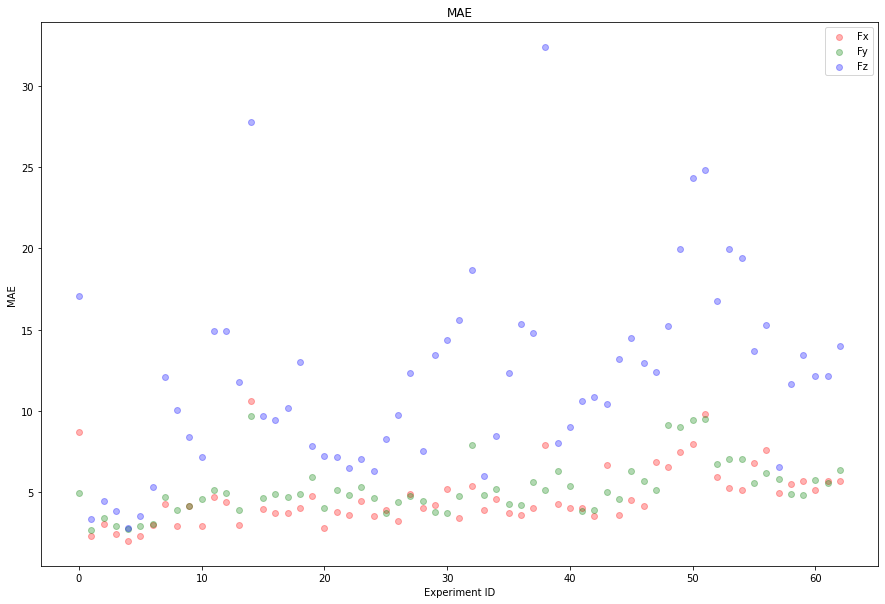

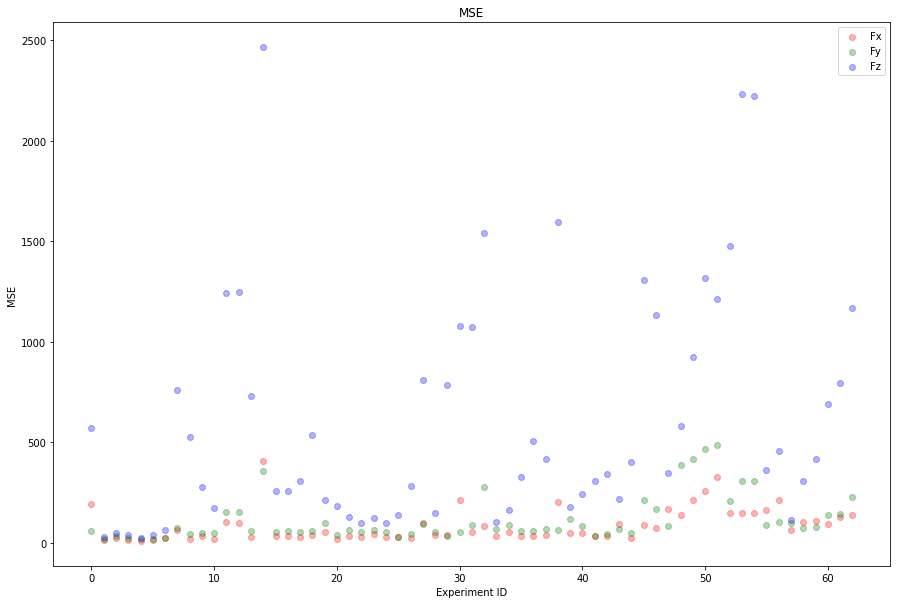

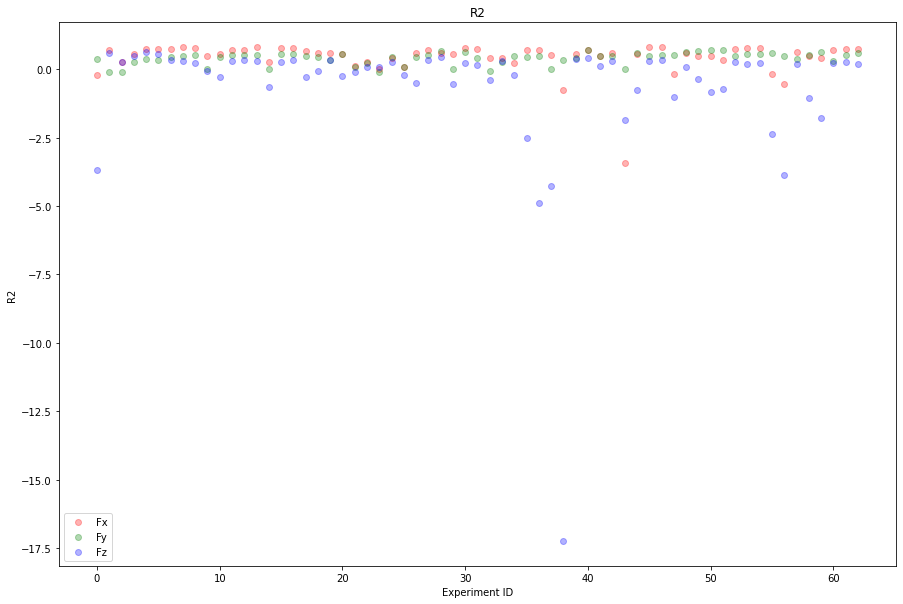

In [20]:
for loss in ['MAE', 'MSE', 'R2']:
    plt.figure(figsize=(15, 10))
    plt.scatter(range(len(results_full[' '.join(['Fx', loss])])), results_full[' '.join(['Fx', loss])], label='Fx', c='r', alpha=0.3)
    plt.scatter(range(len(results_full[' '.join(['Fy', loss])])), results_full[' '.join(['Fy', loss])], label='Fy', c='g', alpha=0.3)
    plt.scatter(range(len(results_full[' '.join(['Fz', loss])])), results_full[' '.join(['Fz', loss])], label='Fz', c='b', alpha=0.3)
    plt.title('{}'.format(loss))
    plt.xlabel('Experiment ID')
    plt.ylabel(loss)
    plt.legend()
    plt.show()

## Try the same model over the data of all experiments

In [4]:
experiments_dirs_path = glob.glob(DERIVED_DATA_DIR + '/*/*')
experiments_dirs_path

['../../../../data/10032021/1',
 '../../../../data/16022021/1',
 '../../../../data/16022021/2',
 '../../../../data/16022021/3',
 '../../../../data/16022021/4',
 '../../../../data/16022021/5',
 '../../../../data/16022021/6',
 '../../../../data/17022021/2',
 '../../../../data/17022021/3',
 '../../../../data/17022021/4',
 '../../../../data/19022021/1',
 '../../../../data/19022021/10',
 '../../../../data/19022021/11',
 '../../../../data/19022021/12',
 '../../../../data/19022021/13',
 '../../../../data/19022021/14',
 '../../../../data/19022021/15',
 '../../../../data/19022021/16',
 '../../../../data/19022021/17',
 '../../../../data/19022021/18',
 '../../../../data/19022021/2',
 '../../../../data/19022021/3',
 '../../../../data/19022021/4',
 '../../../../data/19022021/5',
 '../../../../data/19022021/6',
 '../../../../data/19022021/7',
 '../../../../data/19022021/8',
 '../../../../data/19022021/9',
 '../../../../data/22022021/1',
 '../../../../data/22022021/10',
 '../../../../data/22022021/11

In [5]:
SEQUENCE_LEN = 20

H3_LEG = 'L' # L|R

# features = [H3_LEG + a + m for a in ['Hip', 'Knee', 'Ankle'] for m in ['Pos', 'Vel', 'Acc', 'Torque']] + ['LegKnee{}Filtered'.format(m) for m in ['Position', 'Velocity', 'Torque']]
features = [H3_LEG + a + m for a in ['Hip', 'Knee'] for m in ['Pos', 'Torque']]
targets = ['F' + str(i + 1) + ax for i in range(N_CELLS) for ax in ['x', 'y', 'z']]

print('Number of features: {}'.format(len(features)))
print('Selected features: {}'.format(features))
print('\n')
print('Number of targets: {}'.format(len(targets)))
print('Selected targets: {}'.format(targets))

Number of features: 4
Selected features: ['LHipPos', 'LHipTorque', 'LKneePos', 'LKneeTorque']


Number of targets: 24
Selected targets: ['F1x', 'F1y', 'F1z', 'F2x', 'F2y', 'F2z', 'F3x', 'F3y', 'F3z', 'F4x', 'F4y', 'F4z', 'F5x', 'F5y', 'F5z', 'F6x', 'F6y', 'F6z', 'F7x', 'F7y', 'F7z', 'F8x', 'F8y', 'F8z']


In [6]:
# Total number of experiments
N_EXPERIMENTS = 63
# Number of folds for cross-validation
CV = 6
# Experiments for training set (int)
TRAIN_SIZE = 54
# Experiments for test set (int)
TEST_SIZE = 9

assert(TRAIN_SIZE + TEST_SIZE == N_EXPERIMENTS)
assert(TRAIN_SIZE % CV == 0)

assert(len(experiments_dirs_path) == N_EXPERIMENTS)

In [7]:
targets_dict = {}
features_dict = {}
for i, exp_path in enumerate(experiments_dirs_path):
    print('{} - Experiment {} from {}'.format(i, exp_path.split('/')[-1], exp_path.split('/')[-2]))
    
    # Load targets
    targets_df = pd.read_csv(exp_path + '/force_cells_processed.csv')
    
    # Load features
    exo_df = pd.read_csv(exp_path + '/H3_processed.csv')
    # leg_df = pd.read_csv(exp_path + '/leg_processed.csv')
    # features_df = pd.concat([exo_df, leg_df], axis=1)
    features_df = exo_df
    
    idx_aux = targets_df.duplicated(keep='first')
    targets_df = targets_df.loc[~idx_aux]
    features_df = features_df.loc[~idx_aux]
    print('Droping {} duplicated data points'.format(len(idx_aux[idx_aux == False])))
    
    # Drop first row to remove noise in the start of the data recording
    targets_df = targets_df.iloc[1:]
    features_df = features_df.iloc[1:]
    # Drop null values
    idx = features_df.notna().all(axis=1)
    features_df = features_df.loc[idx]
    targets_df = targets_df.loc[idx]
    print('Droping {} data points by null features'.format(len(idx[idx == False])))

    assert(len(features_df) == len(targets_df))
    # Store the final array
    targets_dict[i] = targets_df[targets].values
    features_dict[i] = features_df[features].values
    
    print('Experiment {} -> X: {}, Y: {} \n'.format(i, features_dict[i].shape, targets_dict[i].shape))

0 - Experiment 1 from 10032021
Droping 2917 duplicated data points
Droping 0 data points by null features
Experiment 0 -> X: (2916, 4), Y: (2916, 24) 

1 - Experiment 1 from 16022021
Droping 8709 duplicated data points
Droping 0 data points by null features
Experiment 1 -> X: (8708, 4), Y: (8708, 24) 

2 - Experiment 2 from 16022021
Droping 8696 duplicated data points
Droping 0 data points by null features
Experiment 2 -> X: (8695, 4), Y: (8695, 24) 

3 - Experiment 3 from 16022021
Droping 8708 duplicated data points
Droping 0 data points by null features
Experiment 3 -> X: (8707, 4), Y: (8707, 24) 

4 - Experiment 4 from 16022021
Droping 8736 duplicated data points
Droping 0 data points by null features
Experiment 4 -> X: (8735, 4), Y: (8735, 24) 

5 - Experiment 5 from 16022021
Droping 8706 duplicated data points
Droping 0 data points by null features
Experiment 5 -> X: (8705, 4), Y: (8705, 24) 

6 - Experiment 6 from 16022021
Droping 8680 duplicated data points
Droping 0 data points

In [8]:
experiments = list(range(N_EXPERIMENTS))
random.shuffle(experiments)

train_experiments = experiments[:TRAIN_SIZE]
test_experiments = experiments[TRAIN_SIZE:]

print('Train experiments ids ({}): {}'.format(len(train_experiments), train_experiments))
print('Test experiments ids ({}): {}'.format(len(test_experiments), test_experiments))

assert(len(train_experiments) + len(test_experiments) == N_EXPERIMENTS)
# Check that no test experiment is in train
assert(not any([i in test_experiments for i in train_experiments]))

Train experiments ids (54): [0, 7, 16, 52, 38, 45, 39, 40, 14, 33, 25, 8, 41, 36, 31, 9, 3, 35, 20, 23, 10, 60, 55, 12, 42, 34, 43, 29, 2, 18, 1, 17, 58, 59, 27, 19, 4, 32, 51, 22, 21, 5, 26, 6, 57, 49, 28, 11, 47, 56, 54, 44, 48, 50]
Test experiments ids (9): [61, 13, 24, 62, 37, 15, 53, 46, 30]


In [9]:
'''
X_train, Y_train = [], [] 
for i in train_experiments:
    X_aux = features_dict[i]
    Y_aux = targets_dict[i]
    
    splits = [i for i in range(0, X_aux.shape[0], SEQUENCE_LEN)]

    X_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(features)])
    Y_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(targets)])
    
    for idx, i in enumerate(splits[:-1]):
        X_tensor[idx, :, :] = X_aux[splits[idx]:splits[idx + 1], :]
        Y_tensor[idx, :, :] = Y_aux[splits[idx + 1] - 1, :]
        
    # print(X_tensor.shape)
    # print(Y_tensor.shape)

    X_train.append(X_tensor)
    Y_train.append(Y_tensor)

X_train, Y_train = np.concatenate(X_train, axis=0), np.concatenate(Y_train, axis=0) 


X_test, Y_test = [], [] 
for i in test_experiments:
    X_aux = features_dict[i]
    Y_aux = targets_dict[i]
    
    splits = [i for i in range(0, X_aux.shape[0], SEQUENCE_LEN)]

    X_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(features)])
    Y_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(targets)])
    
    for idx, i in enumerate(splits[:-1]):
        X_tensor[idx, :, :] = X_aux[splits[idx]:splits[idx + 1], :]
        Y_tensor[idx, :, :] = Y_aux[splits[idx + 1] - 1, :]

    # print(X_tensor.shape)
    # print(Y_tensor.shape)

    X_test.append(X_tensor)
    Y_test.append(Y_tensor)
    
X_test, Y_test = np.concatenate(X_test, axis=0), np.concatenate(Y_test, axis=0) 

'''

X_train, Y_train = [], [] 
for i in train_experiments:
    X_aux = features_dict[i]
    Y_aux = targets_dict[i]
    
    X_tensor = np.zeros([X_aux.shape[0] - SEQUENCE_LEN, SEQUENCE_LEN, len(features)])
    Y_tensor = np.zeros([X_aux.shape[0] - SEQUENCE_LEN, SEQUENCE_LEN, len(targets)])

    for idx, i in enumerate(range(SEQUENCE_LEN, X_aux.shape[0])):
        X_tensor[idx, :, :] = X_aux[i-SEQUENCE_LEN:i, :]
        Y_tensor[idx, :, :] = Y_aux[i, :]

    # print(X_tensor.shape)
    # print(Y_tensor.shape)

    X_train.append(X_tensor)
    Y_train.append(Y_tensor)

X_train, Y_train = np.concatenate(X_train, axis=0), np.concatenate(Y_train, axis=0) 


X_test, Y_test = [], [] 
for i in test_experiments:
    X_aux = features_dict[i]
    Y_aux = targets_dict[i]
    
    X_tensor = np.zeros([X_aux.shape[0] - SEQUENCE_LEN, SEQUENCE_LEN, len(features)])
    Y_tensor = np.zeros([X_aux.shape[0] - SEQUENCE_LEN, SEQUENCE_LEN, len(targets)])

    for idx, i in enumerate(range(SEQUENCE_LEN, X_aux.shape[0])):
        X_tensor[idx, :, :] = X_aux[i-SEQUENCE_LEN:i, :]
        Y_tensor[idx, :, :] = Y_aux[i, :]

    # print(X_tensor.shape)
    # print(Y_tensor.shape)

    X_test.append(X_tensor)
    Y_test.append(Y_tensor)
    
X_test, Y_test = np.concatenate(X_test, axis=0), np.concatenate(Y_test, axis=0) 


print('Train -> X: {}, Y: {}'.format(X_train.shape, Y_train.shape))
print('Test -> X: {}, Y: {}'.format(X_test.shape, Y_test.shape))
print('Total data sequences: {}'.format(X_train.shape[0] + X_test.shape[0]))

Train -> X: (456732, 20, 4), Y: (456732, 20, 24)
Test -> X: (78280, 20, 4), Y: (78280, 20, 24)
Total data sequences: 535012


In [10]:
X_train_norm = np.zeros(list(X_train.shape))
X_test_norm = np.zeros(list(X_test.shape))

scalers = []
for f in range(len(features)):
    s = MinMaxScaler().fit(X_train[:, :, f])

    scalers.append(s)
    
    X_train_norm[:, :, f] = s.transform(X_train[:, :, f])
    X_test_norm[:, :, f] = s.transform(X_test[:, :, f])

    print('Feature {}'.format(f))
    print('Train -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_train_norm[:, :, f], axis=0), np.max(X_train_norm[:, :, f], axis=0), np.mean(X_train_norm[:, :, f], axis=0), np.std(X_train_norm[:, :, f], axis=0)))
    print('Test -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_test_norm[:, :, f], axis=0), np.max(X_test_norm[:, :, f], axis=0), np.mean(X_test_norm[:, :, f], axis=0), np.std(X_test_norm[:, :, f], axis=0)))

Feature 0
Train -> 
 min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
 max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], 
 mean: [0.4437824  0.44376977 0.44375688 0.44374376 0.4437304  0.44371685
 0.4437031  0.44368917 0.44367509 0.44366087 0.44364653 0.44363211
 0.44361762 0.44360309 0.44358855 0.44357402 0.44355957 0.44354524
 0.44353106 0.44351701], 
 std: [0.33167308 0.33169478 0.33171665 0.33173867 0.33176083 0.33178309
 0.33180541 0.33182781 0.33185025 0.33187273 0.33189523 0.33191772
 0.33194018 0.33196261 0.33198499 0.33200728 0.33202947 0.33205157
 0.3320735  0.33209528]

Test -> 
 min: [0.01460036 0.01460036 0.01460036 0.01460036 0.01460036 0.01460036
 0.01460036 0.01460036 0.01460036 0.01460036 0.01460036 0.01460036
 0.01460036 0.01460036 0.01460036 0.01460036 0.01460036 0.01460036
 0.01460036 0.01460036], 
 max: [1.00053567 1.00053567 1.00053567 1.00053567 1.00053567 1.00053567
 1.00053567 1.00053567 1.00053567 1.00053567 1.00053567 1.0

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, sigma, output_size, sequence_length, num_iter, n_layers, device, lr=0.001, batch_size=16):
        
        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.sigma = sigma
        self.output_size = output_size
        self.sequence_length = sequence_length
        self.num_layers = n_layers
        
        # define an LSTM with specified parameters
        # batch_first=True means that the first dimension of the input will be the batch_size
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=0.3)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE

        
        self.lr = lr #Learning Rate
        self.batch_size = batch_size
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.num_iter = num_iter
        self.criterion = nn.MSELoss() #YOUR CODE HERE     
        
        self.device = device
        self.to(self.device)
        
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        
    def forward(self, x, h0=None):
        
        '''
        About the shape of the different tensors ...:
        
        - Input signal x has shape (batch_size, seq_length, input_size)
        - The initialization of the RNN hidden state h0 has shape (n_layers, batch_size, hidden_dim).
          If None value is used, internally it is initialized to zeros.
        - The RNN output (batch_size, seq_length, hidden_size). This output is the RNN state along time  

        '''
        batch_size = x.size(0) # Number of signals N
        seq_length = x.size(1) # T
        
        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state (we will use it for forecasting)
        #print(x.shape)
        r_out, hidden = self.rnn(x, h0)
        #print(r_out.shape, hidden.shape)
        
        # shape r_out to be (seq_length, hidden_dim) #UNDERSTANDING THIS POINT IS IMPORTANT!!        
        r_out = r_out.reshape(-1, self.hidden_dim) 
        #print(r_out.shape)
        
        output = self.fc1(r_out)
        #print(output.shape)
        
        noise = torch.randn_like(output) * self.sigma
        
        output += noise
        
        # reshape back to temporal structure
        output = output.reshape([-1, self.sequence_length, 1])

        return output, hidden
           
    def trainloop(self, x, y, x_val=None, y_val=None):
        
        # SGD Loop
        for e in range(int(self.num_iter)):
        
            running_loss = 0.
            
            idx = list(range(x.shape[0]))
            random.shuffle(idx)
            
            batchs = [idx[i:i + self.batch_size] for i in range(0, x.shape[0], self.batch_size)]
            for b in batchs:

                features = x[b, :, :]
                target = y[b, :, :]

                # print(features.shape, target.shape)
                self.optim.zero_grad() 
                
                features = torch.Tensor(features).to(self.device) #YOUR CODE HERE  
                target = torch.Tensor(target).to(self.device) #YOUR CODE HERE  
                
                out,hid = self.forward(features)

                # print(out.shape, hid.shape, target.shape)
                # print(out[:, -1, 0].size(), target[:, 0].size())
                loss = self.criterion(out[:, -1, 0], target[:, -1, 0]) #YOUR CODE HERE
                running_loss += loss.item()

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
                
            self.loss_during_training.append(running_loss / len(batchs))
            
            if x_val is not None and y_val is not None:
                with torch.no_grad():
                    # Set the model in evaluation mode 
                    self.eval()

                    running_loss_val = 0.
                    idx = list(range(x_val.shape[0]))

                    batchs = [idx[i:i + self.batch_size] for i in range(0, x_val.shape[0], self.batch_size)]
                    for b in batchs:
                        features = x_val[b, :, :]
                        target = y_val[b, :, :]

                        features = torch.Tensor(features).to(self.device) #YOUR CODE HERE  
                        target = torch.Tensor(target).to(self.device) #YOUR CODE HERE  

                        out,hid = self.forward(features)

                        # print(out.shape, hid.shape, target.shape)
                        # print(out[:, -1, 0].size(), target[:, -1, 0].size())
                        loss = self.criterion(out[:, -1, 0], target[:, -1, 0]) #YOUR CODE HERE
                        running_loss_val += loss.item()

                    self.valid_loss_during_training.append(running_loss_val / len(batchs))

                # Return the model to training mode
                self.train()

                if(e % 1 == 0):
                    print("%d epochs -> Train loss: %f - Val loss: %f"%(e, self.loss_during_training[-1], self.valid_loss_during_training[-1]))
                    
            else:
                if(e % 1 == 0):
                    print("%d epochs -> Train loss: %f"%(e, self.loss_during_training[-1]))

                

In [14]:
model = LSTM(input_size=4, hidden_dim=32, sigma=1, output_size=1, sequence_length=SEQUENCE_LEN, 
            num_iter=50, n_layers=1, device=TORCH_DEVICE)

In [15]:
force = 9

model.trainloop(X_train_norm, Y_train[:, :, force:force+1], X_test_norm, Y_test[:, :, force:force+1])

0 epochs -> Train loss: 201.248274 - Val loss: 541.419998
1 epochs -> Train loss: 160.219318 - Val loss: 441.841809
2 epochs -> Train loss: 141.229661 - Val loss: 391.308223
3 epochs -> Train loss: 127.666122 - Val loss: 455.072236
4 epochs -> Train loss: 115.951470 - Val loss: 393.727049
5 epochs -> Train loss: 108.978267 - Val loss: 388.800832
6 epochs -> Train loss: 102.811105 - Val loss: 337.440365
7 epochs -> Train loss: 97.855740 - Val loss: 365.874379
8 epochs -> Train loss: 93.672564 - Val loss: 355.001024
9 epochs -> Train loss: 90.748532 - Val loss: 355.594889
10 epochs -> Train loss: 87.550772 - Val loss: 410.714075
11 epochs -> Train loss: 84.937840 - Val loss: 369.266940
12 epochs -> Train loss: 82.719535 - Val loss: 347.259048
13 epochs -> Train loss: 81.315789 - Val loss: 392.486419
14 epochs -> Train loss: 79.618006 - Val loss: 338.891476
15 epochs -> Train loss: 78.378062 - Val loss: 354.769429
16 epochs -> Train loss: 76.904049 - Val loss: 342.578799
17 epochs -> Trai

KeyboardInterrupt: 

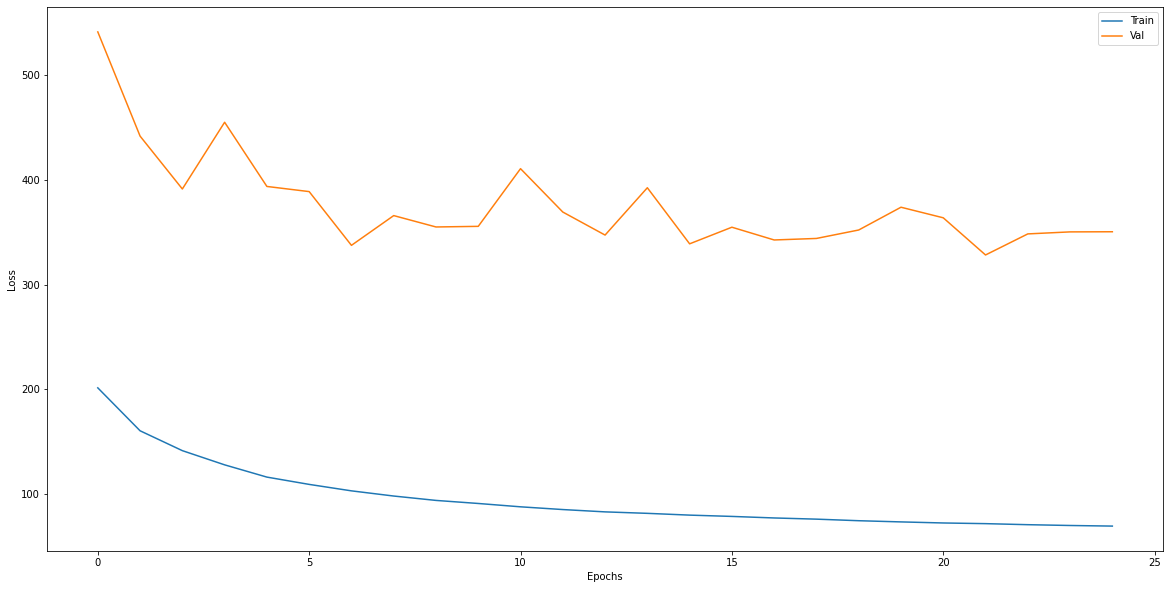

In [16]:
plt.figure(figsize=(20,10))

plt.plot(model.loss_during_training, label='Train')
plt.plot(model.valid_loss_during_training, label='Val')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

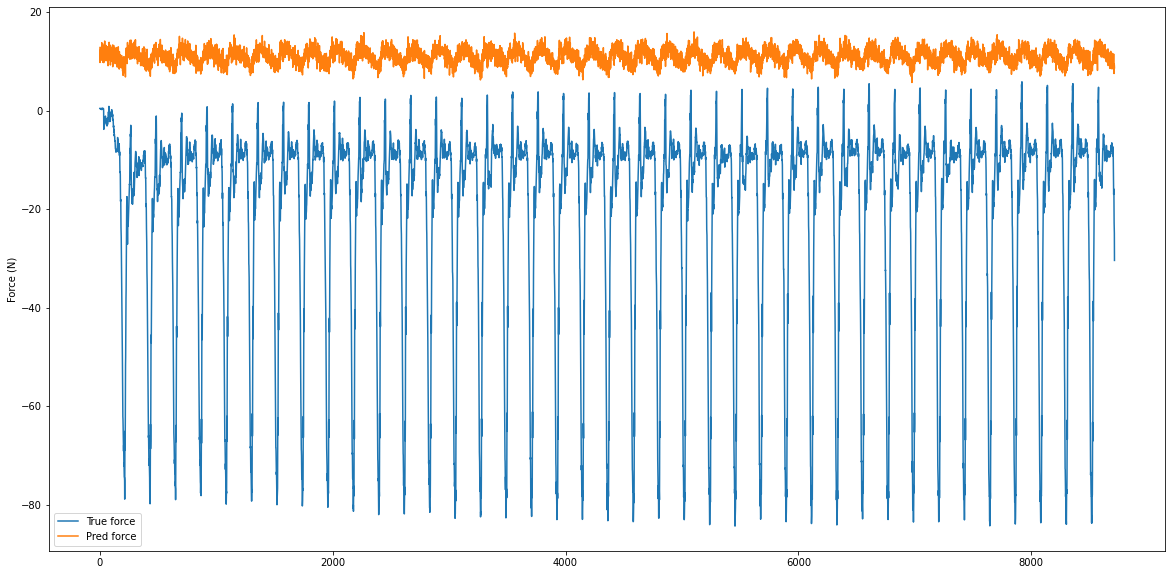

{'MAE': 30.535908, 'MSE': 1345.5004, 'R2': -2.030333110178898}




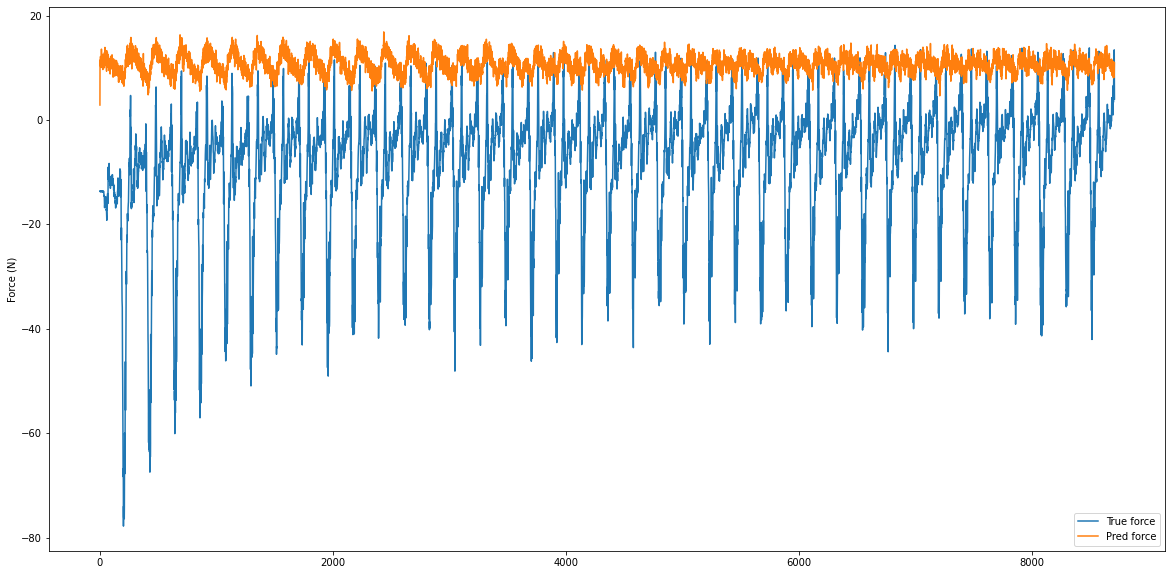

{'MAE': 19.076921, 'MSE': 494.69305, 'R2': -2.5366082324731285}




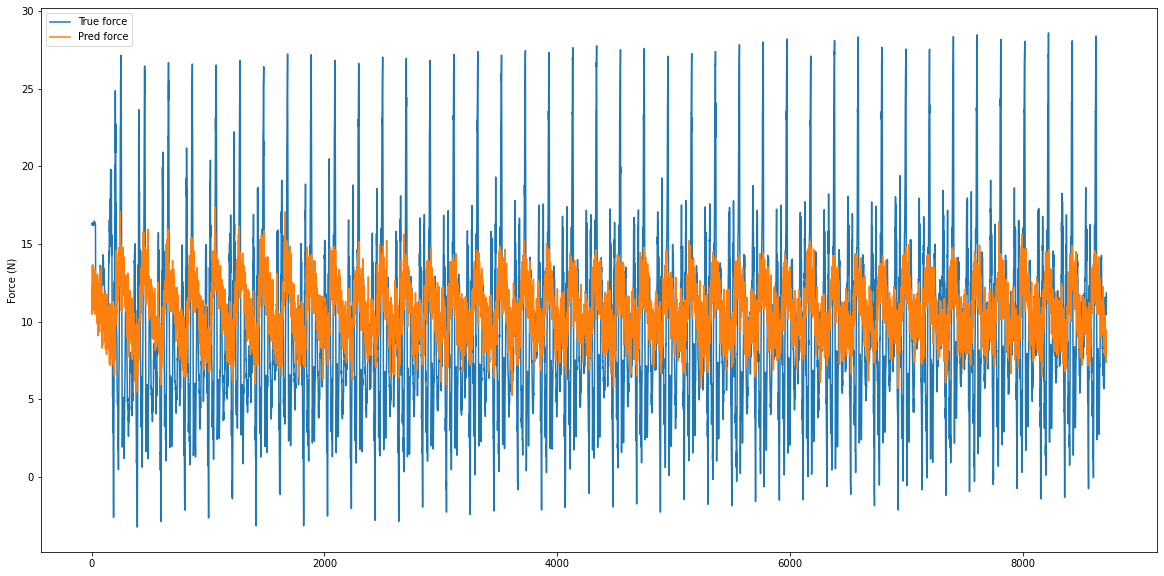

{'MAE': 4.5170636, 'MSE': 32.037834, 'R2': -0.11221665430411099}




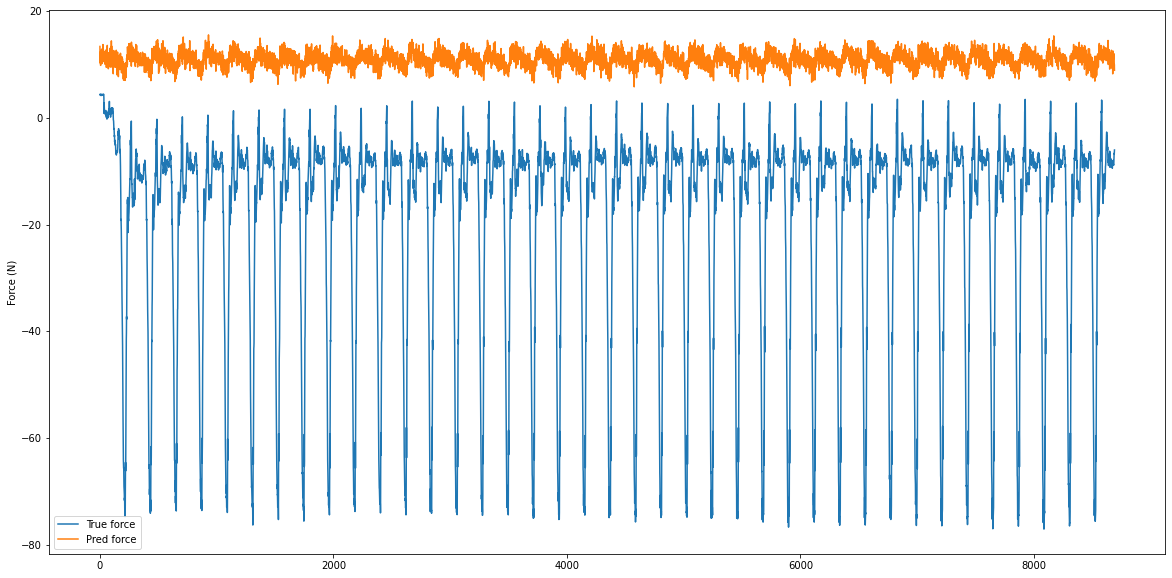

{'MAE': 29.225615, 'MSE': 1223.9775, 'R2': -2.076451520595083}




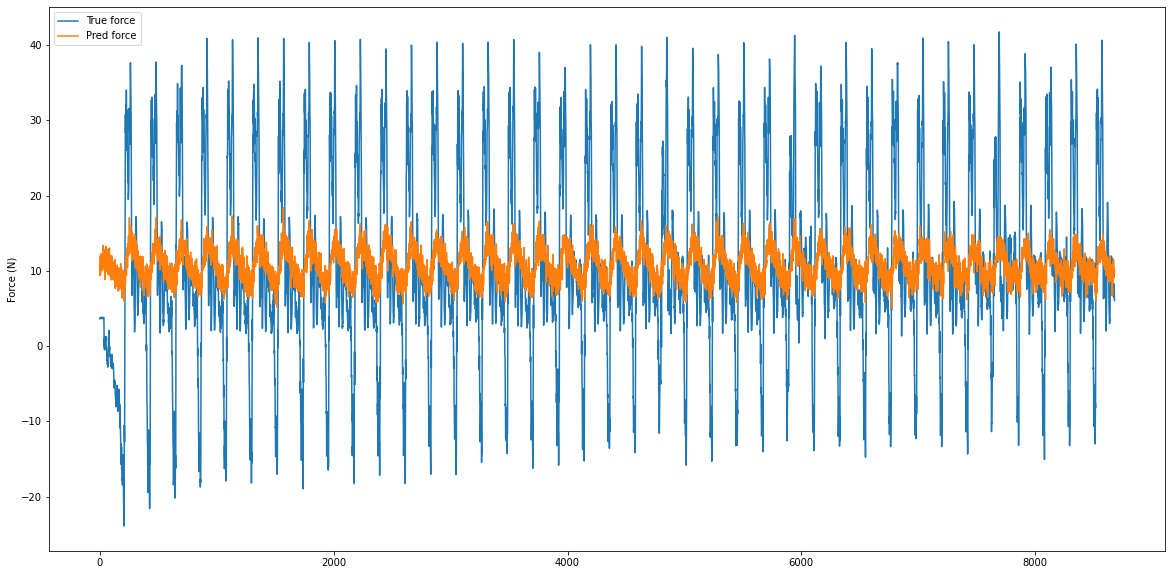

{'MAE': 8.369288, 'MSE': 120.75259, 'R2': 0.15237459695697275}




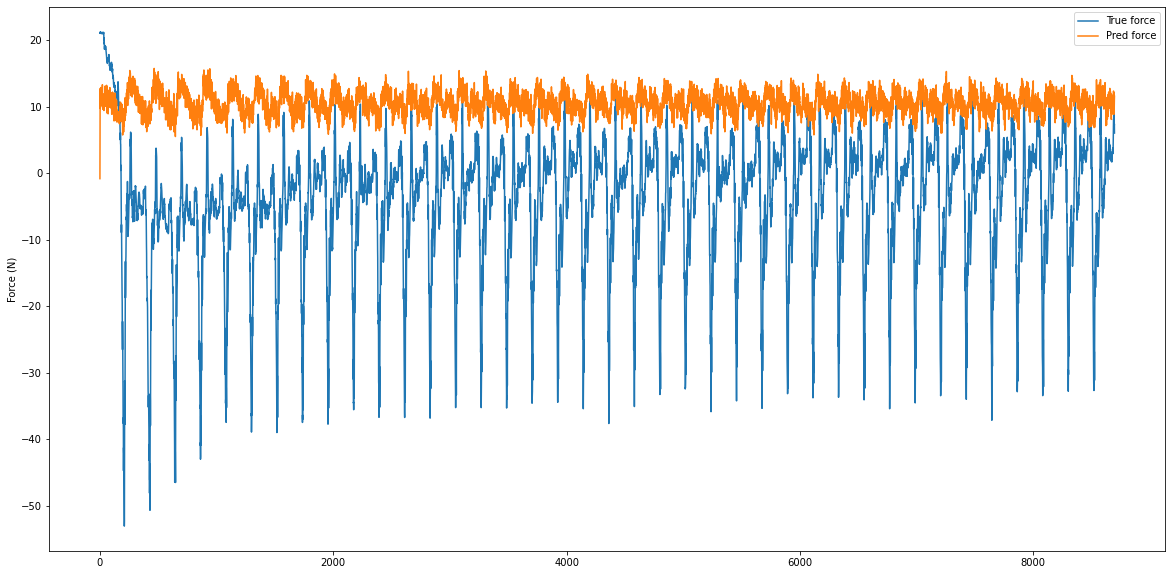

{'MAE': 14.509713, 'MSE': 293.66684, 'R2': -2.056720579024395}




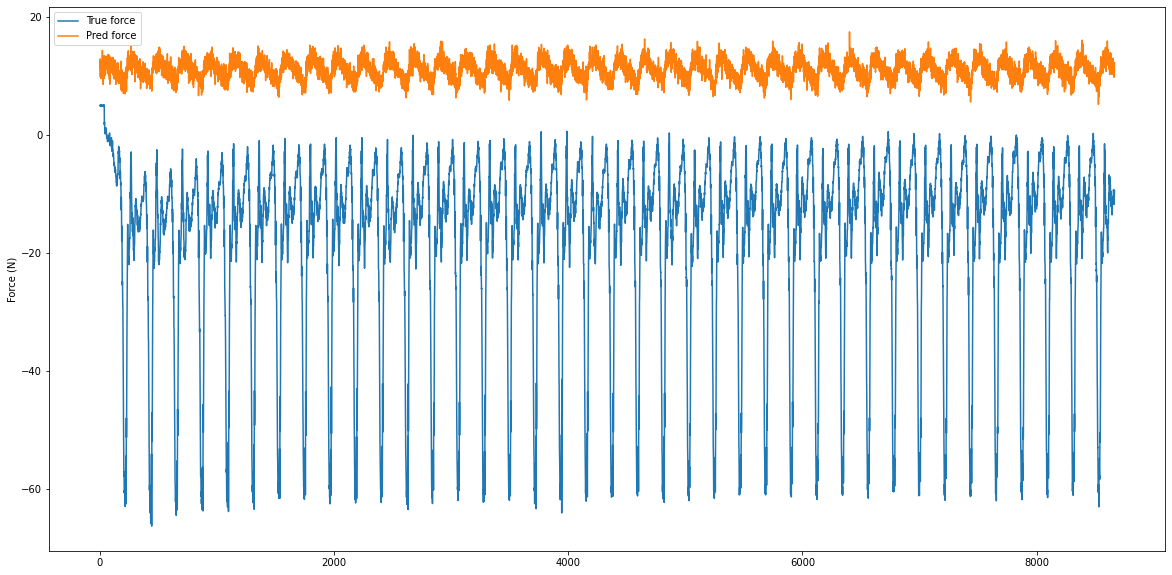

{'MAE': 28.687422, 'MSE': 1060.4696, 'R2': -3.1299050409277713}




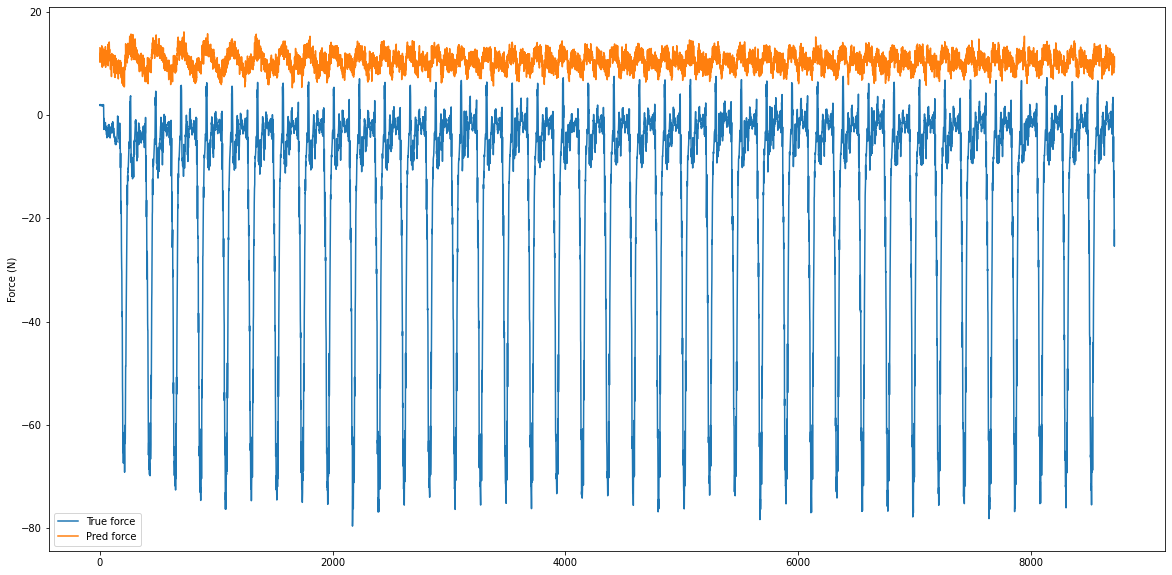

{'MAE': 24.317835, 'MSE': 1035.7966, 'R2': -1.2310179060527782}




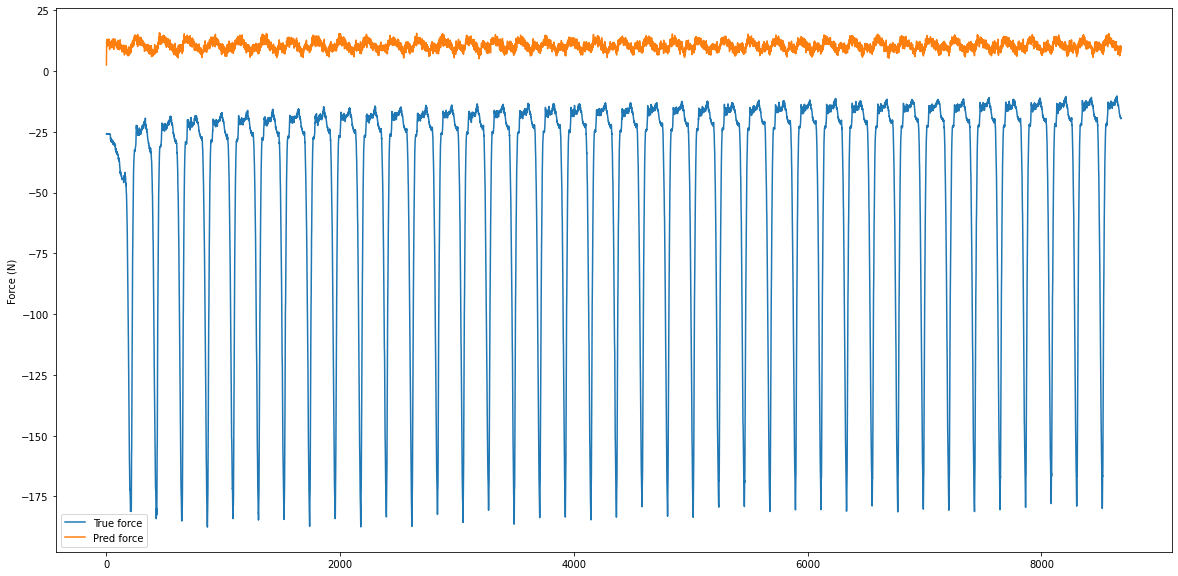

{'MAE': 53.33547, 'MSE': 4898.5996, 'R2': -1.3319263036688658}




In [17]:
all_results = {}

for i in test_experiments:
    X_aux = features_dict[i]
    Y_aux = targets_dict[i]
    
    true = []
    pred = []

    for i in range(SEQUENCE_LEN, X_aux.shape[0]):
        X_aux_ = X_aux[np.newaxis, i-SEQUENCE_LEN:i, :]
        for f in range(len(features)):
            s = scalers[f]

            X_aux_[:, :, f] = s.transform(X_aux_[:, :, f])
                
        features_ = torch.Tensor(X_aux_).to(TORCH_DEVICE)
        target_ = torch.Tensor(Y_aux[np.newaxis, i, force:force+1]).to(TORCH_DEVICE)

        out, hid = model.forward(features_)

        true.append(target_[:, 0].cpu().detach().numpy())
        pred.append(out[:, -1, 0].cpu().detach().numpy())

    plt.figure(figsize=(20,10))

    plt.plot(true, label='True force')
    plt.plot(pred, label='Pred force')

    plt.legend()
    plt.ylabel('Force (N)')
    plt.show()
    
    results = {
        'MAE': mean_absolute_error(true, pred),
        'MSE': mean_squared_error(true, pred),
        'R2': r2_score(true, pred)
    }

    all_results[i] = results
    
    print(results)
    print('\n')

In [18]:
results_summary = defaultdict(list)

for k, v in all_results.items():
    results_summary['MAE'].append(v['MAE'])
    results_summary['MSE'].append(v['MSE'])
    results_summary['R2'].append(v['R2'])
    
print('Mean MAE: {}'.format(np.mean(results_summary['MAE'])))
print('Median MAE: {}'.format(np.median(results_summary['MAE'])))
print('STD MAE: {}'.format(np.std(results_summary['MAE'])))
    
print('Mean MSE: {}'.format(np.mean(results_summary['MSE'])))
print('Median MSE: {}'.format(np.median(results_summary['MSE'])))
print('STD MSE: {}'.format(np.std(results_summary['MSE'])))

print('Mean R2: {}'.format(np.mean(results_summary['R2'])))
print('Median R2: {}'.format(np.median(results_summary['R2'])))
print('STD R2: {}'.format(np.std(results_summary['R2'])))

Mean MAE: 22.75491714477539
Median MAE: 21.697378158569336
STD MAE: 14.299274444580078
Mean MSE: 1144.999267578125
Median MSE: 765.244873046875
STD MSE: 1481.1419677734375
Mean R2: -1.5403089550111448
Median R2: -1.6943234413466304
STD R2: 1.0675478497161133
